In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import time    
import sys

In [2]:
transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

#train_data_path = 'relative path of training data set'
train_data_path = './horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1027, shuffle=False, num_workers=1)  

validation_data_path = './horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=False, num_workers=1)  


trainList = list()
validList = list()
trainLabelList = list()
validLabelList = list()

for i, data in enumerate(trainloader):
    # inputs is the image
    # labels is the class of the image
    inputs, labels = data


    # if you don't change the image size, it will be [batch_size, 1, 100, 100]

    batch_size = inputs.shape[0]

    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    # change inputs to matrix 10000*batch_size
    for bat_idx in range(batch_size):

        targMat = inputs[bat_idx][0]

        colVec = np.reshape(targMat, (np.product(targMat.shape), 1), 'F')

        if(bat_idx == 0):
            batMat = colVec
        else:
            batMat = np.concatenate((batMat, colVec), axis = 1)         

    # Add ones because of the value b in coefficient
    ones = np.ones((1, batch_size), dtype = int)
    batMat = np.concatenate((batMat, ones))
    trainList.append(batMat)
    trainLabelList.append(labels)
    
# load validation images of the batch size for every iteration
for i, data in enumerate(valloader):

    # inputs is the image
    # labels is the class of the image
    inputs, labels = data

    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
     # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]

    batch_size = inputs.shape[0]

    # Change Inputs to matrix 10000*batch_size

    for bat_idx in range(batch_size):
        targMat = inputs[bat_idx][0]
        colVec = np.reshape(targMat, (np.product(targMat.shape), 1), 'F')

        if(bat_idx == 0):
            batMat = colVec
        else:
            batMat = np.concatenate((batMat,colVec), axis = 1)
        
    # Add ones because of the value b in coefficient
    ones = np.ones((1, batch_size), dtype = int)
    batMat = np.concatenate((batMat, ones))
    validList.append(batMat)
    validLabelList.append(labels)

In [3]:
#Initialize Coef to Zeros

w_0 = np.zeros((1,10001), dtype = float)
a = np.ones((1,10001), dtype = float)
w_0 =np.concatenate((w_0, a), axis = 0)
a = 2 * np.ones((1,10001), dtype = float)
w_0 =np.concatenate((w_0, a), axis = 0)
a = 3 * np.ones((1,10001), dtype = float)
w_0 =np.concatenate((w_0, a), axis = 0)
totalDataNum = len(trainloader.dataset)



w_1 = np.array([[0,0,0,0],
              [1,1,1,1],
              [2,2,2,2]], dtype = float)

w_2 = np.zeros((1, 3), dtype = float)

#Set Learning Rate
lrnRate = 0.01

# Set Loss Lists
lrnLoss = list()
valLoss = list()

# Set Accurate Lists
lrnAcc = list()
valAcc = list()

# set Elapsed time Lists
elapTime = list()


epoch = -1
lrnAccRate = 0

while(lrnAccRate < 0.96):
#while(epoch < 10000):
    epoch += 1


    
    #Set Sum of Loss to 0
    sumL = 0
    
    #Set Sum of Cor to 0
    cor = 0
    
    start_time = time.time()

    for i, a_0 in enumerate(trainList):
        
        batch_size = a_0.shape[1]

        # Start Regression Calculation
        z_0 = np.dot(w_0, a_0)          

        a_1 = 1/(1 + np.exp(-z_0))                                               
        z_1 = np.dot(w_1, a_1)
        a_2 = 1/(1 + np.exp(-z_1))
        
        z_2 = np.dot(w_2, a_2)
        a_3 = 1/(1 + np.exp(-z_2))
   
    
        dz_2 = np.subtract(a_3, trainLabelList[i])  

        dw_2 = np.dot(dz_2, a_2.T) / totalDataNum
        w_2 -= lrnRate * dw_2
        
        da_2 = np.dot(w_2.T, dz_2)
        dz_1 = da_2 * a_2 * (1 - a_2) 
        dw_1 = np.dot(dz_1, a_1.T) / totalDataNum
        w_1 -= lrnRate * dw_1
        
        da_1 = np.dot(w_1.T, dz_1)
        dz_0 = da_1 * a_1 * (1 - a_1)
        dw_0 = np.dot(dz_0, a_0.T) / totalDataNum
        w_0 -= lrnRate * dw_0

        
        # Calculate Total Loss
        a_3 = torch.from_numpy(a_3)                                             #change ndarray to tensor
        dLabels = trainLabelList[i].double()                                   #change tensor type to double
        L = -(dLabels) * np.log(a_3) - (1-dLabels) * np.log(1-a_3)      
        sumL += L.sum()
        
        
        # Calculate Accuracy


        for batIdx in range(batch_size):

            if(a_3[0][batIdx] <= 0.5 and trainLabelList[i][batIdx] == 0):
                cor += 1

            if(a_3[0][batIdx] > 0.5 and trainLabelList[i][batIdx] == 1):
                cor += 1
            

    
    

        
    # Calculate dLossdCoef
    
    

    # Update coefs using derivatives
    
    
    elapsed_time = time.time() - start_time
    elapTime.append(elapsed_time)
    

    # Calculate TotalLoss
    sumL /= totalDataNum

    lrnLoss.append(sumL)

    
    
    # Calculate Accuracy
    
    lrnAccRate = cor/totalDataNum
    lrnAcc.append(lrnAccRate)
    
                


    # Set Sum Of Valid Loss to 0
    sumVL = 0
    # Set Sum of Valid Cor to 0
    vCor = 0
    
    # load validation images of the batch size for every iteration
    for i, a_0 in enumerate(validList):
        
        
        batch_size = a_0.shape[1]
        
        

        
        # Start Calculate Loss 
        z_0 = np.dot(w_0, a_0)
        a_1= 1/(1+np.exp(-z_0))
        
        z_1 = np.dot(w_1, a_1)
        a_2= 1/(1+np.exp(-z_1))
        
        z_2 = np.dot(w_2, a_2)
        a_3= 1/(1+np.exp(-z_2))
        
        
        a_3 = torch.from_numpy(a_3)
        dLabels = validLabelList[i].double()
        L = -(dLabels) * np.log(a_3) - (1-dLabels) * np.log(1-a_3)
        sumVL += L.sum()
        

        
        # Calculate Accuracy
        
        for batIdx in range(batch_size):
            if(a_3[0][batIdx] <= 0.5 and validLabelList[i][batIdx] == 0):
                vCor += 1
                
            if(a_3[0][batIdx] > 0.5 and validLabelList[i][batIdx] == 1):
                vCor += 1
    
    totalValDataNum = len(valloader.dataset)
    
    # CalCulate Total Loss
    sumVL /= totalValDataNum
    valLoss.append(sumVL)
    
    
    # Calculate Accuracy
    vAcc = vCor/totalValDataNum
    valAcc.append(vAcc)

    

    
    #print("epoch : ",epoch,',', "lrnCor : ", cor, "valCor : ", vCor, "a_3 : ", a_3, "total valid loss : ", sumVL.item())
    print("epoch : ",epoch,',', "lrnCor : ", cor, "valCor : ", vCor, "elapsed time : ", elapsed_time, "total loss : ", sumL.item(), "total valid loss : ", sumVL.item())
    
    
    



epoch :  0 , lrnCor :  500 valCor :  128 elapsed time :  0.07085108757019043 total loss :  0.6931471805599451 total valid loss :  0.6931471909229718
epoch :  1 , lrnCor :  527 valCor :  128 elapsed time :  0.059929847717285156 total loss :  0.6931434060373943 total valid loss :  0.6931472217852623
epoch :  2 , lrnCor :  527 valCor :  128 elapsed time :  0.05872702598571777 total loss :  0.6931396727400932 total valid loss :  0.693147272809892
epoch :  3 , lrnCor :  527 valCor :  128 elapsed time :  0.06349706649780273 total loss :  0.6931359802174705 total valid loss :  0.6931473436642364
epoch :  4 , lrnCor :  527 valCor :  128 elapsed time :  0.06095290184020996 total loss :  0.69313232802388 total valid loss :  0.6931474340199236
epoch :  5 , lrnCor :  527 valCor :  128 elapsed time :  0.05889701843261719 total loss :  0.6931287157185477 total valid loss :  0.6931475435527839
epoch :  6 , lrnCor :  527 valCor :  128 elapsed time :  0.07571983337402344 total loss :  0.693125142865517

epoch :  57 , lrnCor :  527 valCor :  128 elapsed time :  0.05603671073913574 total loss :  0.6929863845005962 total valid loss :  0.6931728861580793
epoch :  58 , lrnCor :  527 valCor :  128 elapsed time :  0.06805086135864258 total loss :  0.6929843658055268 total valid loss :  0.6931736422625319
epoch :  59 , lrnCor :  527 valCor :  128 elapsed time :  0.07582974433898926 total loss :  0.6929823691467029 total valid loss :  0.6931744050951327
epoch :  60 , lrnCor :  527 valCor :  128 elapsed time :  0.0661170482635498 total loss :  0.6929803942833206 total valid loss :  0.6931751745003026
epoch :  61 , lrnCor :  527 valCor :  128 elapsed time :  0.057322025299072266 total loss :  0.6929784409772076 total valid loss :  0.6931759503246121
epoch :  62 , lrnCor :  527 valCor :  128 elapsed time :  0.05885195732116699 total loss :  0.6929765089927961 total valid loss :  0.6931767324167561
epoch :  63 , lrnCor :  527 valCor :  128 elapsed time :  0.05883479118347168 total loss :  0.692974

epoch :  112 , lrnCor :  527 valCor :  128 elapsed time :  0.061077117919921875 total loss :  0.6929025686888648 total valid loss :  0.6932210325326459
epoch :  113 , lrnCor :  527 valCor :  128 elapsed time :  0.05806112289428711 total loss :  0.6929014646366244 total valid loss :  0.6932219761460343
epoch :  114 , lrnCor :  527 valCor :  128 elapsed time :  0.06587386131286621 total loss :  0.6929003726266058 total valid loss :  0.6932229205331328
epoch :  115 , lrnCor :  527 valCor :  128 elapsed time :  0.07032918930053711 total loss :  0.6928992925272414 total valid loss :  0.693223865624837
epoch :  116 , lrnCor :  527 valCor :  128 elapsed time :  0.06244993209838867 total loss :  0.692898224208402 total valid loss :  0.6932248113531287
epoch :  117 , lrnCor :  527 valCor :  128 elapsed time :  0.06130671501159668 total loss :  0.6928971675413809 total valid loss :  0.693225757651065
epoch :  118 , lrnCor :  527 valCor :  128 elapsed time :  0.07156896591186523 total loss :  0.6

epoch :  169 , lrnCor :  527 valCor :  128 elapsed time :  0.06787919998168945 total loss :  0.6928555153762425 total valid loss :  0.6932744088138862
epoch :  170 , lrnCor :  527 valCor :  128 elapsed time :  0.05901527404785156 total loss :  0.6928549242693304 total valid loss :  0.6932753132482519
epoch :  171 , lrnCor :  527 valCor :  128 elapsed time :  0.06119394302368164 total loss :  0.692854339600947 total valid loss :  0.6932762159079879
epoch :  172 , lrnCor :  527 valCor :  128 elapsed time :  0.06976699829101562 total loss :  0.6928537613007617 total valid loss :  0.6932771167681346
epoch :  173 , lrnCor :  527 valCor :  128 elapsed time :  0.06229090690612793 total loss :  0.6928531892992132 total valid loss :  0.6932780158042477
epoch :  174 , lrnCor :  527 valCor :  128 elapsed time :  0.06037306785583496 total loss :  0.6928526235274993 total valid loss :  0.6932789129923913
epoch :  175 , lrnCor :  527 valCor :  128 elapsed time :  0.06539702415466309 total loss :  0.

epoch :  226 , lrnCor :  527 valCor :  128 elapsed time :  0.06928205490112305 total loss :  0.6928303117737634 total valid loss :  0.6933225762028661
epoch :  227 , lrnCor :  527 valCor :  128 elapsed time :  0.06118917465209961 total loss :  0.6928299949339739 total valid loss :  0.6933233522977174
epoch :  228 , lrnCor :  527 valCor :  128 elapsed time :  0.05857419967651367 total loss :  0.6928296815370281 total valid loss :  0.6933241258435334
epoch :  229 , lrnCor :  527 valCor :  128 elapsed time :  0.07118988037109375 total loss :  0.6928293715453246 total valid loss :  0.69332489683573
epoch :  230 , lrnCor :  527 valCor :  128 elapsed time :  0.06215500831604004 total loss :  0.6928290649216737 total valid loss :  0.6933256652699489
epoch :  231 , lrnCor :  527 valCor :  128 elapsed time :  0.06552314758300781 total loss :  0.6928287616292919 total valid loss :  0.6933264311420574
epoch :  232 , lrnCor :  527 valCor :  128 elapsed time :  0.06480002403259277 total loss :  0.6

epoch :  283 , lrnCor :  527 valCor :  128 elapsed time :  0.06893491744995117 total loss :  0.6928167915942386 total valid loss :  0.6933626880519275
epoch :  284 , lrnCor :  527 valCor :  128 elapsed time :  0.07780885696411133 total loss :  0.6928166214190201 total valid loss :  0.6933633169909865
epoch :  285 , lrnCor :  527 valCor :  128 elapsed time :  0.06315994262695312 total loss :  0.6928164530849772 total valid loss :  0.6933639433968268
epoch :  286 , lrnCor :  527 valCor :  128 elapsed time :  0.07327079772949219 total loss :  0.6928162865720044 total valid loss :  0.6933645672734018
epoch :  287 , lrnCor :  527 valCor :  128 elapsed time :  0.06006217002868652 total loss :  0.6928161218602167 total valid loss :  0.6933651886247516
epoch :  288 , lrnCor :  527 valCor :  128 elapsed time :  0.06091809272766113 total loss :  0.6928159589299464 total valid loss :  0.6933658074550009
epoch :  289 , lrnCor :  527 valCor :  128 elapsed time :  0.07433009147644043 total loss :  0

epoch :  340 , lrnCor :  527 valCor :  128 elapsed time :  0.07012200355529785 total loss :  0.6928095194344782 total valid loss :  0.6933946382439418
epoch :  341 , lrnCor :  527 valCor :  128 elapsed time :  0.06059694290161133 total loss :  0.6928094276969036 total valid loss :  0.6933951310621814
epoch :  342 , lrnCor :  527 valCor :  128 elapsed time :  0.0600428581237793 total loss :  0.692809336944073 total valid loss :  0.693395621669991
epoch :  343 , lrnCor :  527 valCor :  128 elapsed time :  0.06586599349975586 total loss :  0.6928092471652357 total valid loss :  0.693396110074168
epoch :  344 , lrnCor :  527 valCor :  128 elapsed time :  0.06658196449279785 total loss :  0.6928091583497581 total valid loss :  0.6933965962815308
epoch :  345 , lrnCor :  527 valCor :  128 elapsed time :  0.06142592430114746 total loss :  0.6928090704871231 total valid loss :  0.6933970802989176
epoch :  346 , lrnCor :  527 valCor :  128 elapsed time :  0.0684809684753418 total loss :  0.6928

epoch :  397 , lrnCor :  527 valCor :  128 elapsed time :  0.06262493133544922 total loss :  0.6928055889567389 total valid loss :  0.6934194053484672
epoch :  398 , lrnCor :  527 valCor :  128 elapsed time :  0.06387090682983398 total loss :  0.6928055391737886 total valid loss :  0.6934197833732962
epoch :  399 , lrnCor :  527 valCor :  128 elapsed time :  0.059369802474975586 total loss :  0.6928054899176048 total valid loss :  0.6934201595901767
epoch :  400 , lrnCor :  527 valCor :  128 elapsed time :  0.06302618980407715 total loss :  0.6928054411824375 total valid loss :  0.6934205340061694
epoch :  401 , lrnCor :  527 valCor :  128 elapsed time :  0.05789518356323242 total loss :  0.6928053929626007 total valid loss :  0.6934209066283271
epoch :  402 , lrnCor :  527 valCor :  128 elapsed time :  0.059625864028930664 total loss :  0.69280534525247 total valid loss :  0.6934212774636946
epoch :  403 , lrnCor :  527 valCor :  128 elapsed time :  0.058754682540893555 total loss :  

epoch :  454 , lrnCor :  527 valCor :  128 elapsed time :  0.06426095962524414 total loss :  0.6928034460070844 total valid loss :  0.6934382697675063
epoch :  455 , lrnCor :  527 valCor :  128 elapsed time :  0.06345176696777344 total loss :  0.6928034186689317 total valid loss :  0.6934385556858662
epoch :  456 , lrnCor :  527 valCor :  128 elapsed time :  0.05907893180847168 total loss :  0.6928033916126282 total valid loss :  0.6934388401796296
epoch :  457 , lrnCor :  527 valCor :  128 elapsed time :  0.06007814407348633 total loss :  0.6928033648350989 total valid loss :  0.6934391232550774
epoch :  458 , lrnCor :  527 valCor :  128 elapsed time :  0.06182289123535156 total loss :  0.6928033383333028 total valid loss :  0.693439404918473
epoch :  459 , lrnCor :  527 valCor :  128 elapsed time :  0.057955026626586914 total loss :  0.6928033121042323 total valid loss :  0.6934396851760614
epoch :  460 , lrnCor :  527 valCor :  128 elapsed time :  0.059165000915527344 total loss :  

epoch :  511 , lrnCor :  527 valCor :  128 elapsed time :  0.0651540756225586 total loss :  0.6928022594619561 total valid loss :  0.6934524699314231
epoch :  512 , lrnCor :  527 valCor :  128 elapsed time :  0.06779217720031738 total loss :  0.6928022441349834 total valid loss :  0.6934526841269315
epoch :  513 , lrnCor :  527 valCor :  128 elapsed time :  0.06594586372375488 total loss :  0.6928022289588786 total valid loss :  0.6934528972258094
epoch :  514 , lrnCor :  527 valCor :  128 elapsed time :  0.06551671028137207 total loss :  0.6928022139319977 total valid loss :  0.6934531092332485
epoch :  515 , lrnCor :  527 valCor :  128 elapsed time :  0.06057286262512207 total loss :  0.6928021990527137 total valid loss :  0.6934533201544204
epoch :  516 , lrnCor :  527 valCor :  128 elapsed time :  0.06021904945373535 total loss :  0.6928021843194185 total valid loss :  0.6934535299944771
epoch :  517 , lrnCor :  527 valCor :  128 elapsed time :  0.0722811222076416 total loss :  0.6

epoch :  568 , lrnCor :  527 valCor :  128 elapsed time :  0.05760598182678223 total loss :  0.6928015848405615 total valid loss :  0.6934630730998782
epoch :  569 , lrnCor :  527 valCor :  128 elapsed time :  0.06177091598510742 total loss :  0.6928015759448365 total valid loss :  0.6934632325081704
epoch :  570 , lrnCor :  527 valCor :  128 elapsed time :  0.06823301315307617 total loss :  0.692801567129929 total valid loss :  0.6934633910851538
epoch :  571 , lrnCor :  527 valCor :  128 elapsed time :  0.0756540298461914 total loss :  0.6928015583949604 total valid loss :  0.693463548834945
epoch :  572 , lrnCor :  527 valCor :  128 elapsed time :  0.06126689910888672 total loss :  0.6928015497390606 total valid loss :  0.6934637057616423
epoch :  573 , lrnCor :  527 valCor :  128 elapsed time :  0.06161189079284668 total loss :  0.6928015411613695 total valid loss :  0.6934638618693267
epoch :  574 , lrnCor :  527 valCor :  128 elapsed time :  0.06528997421264648 total loss :  0.69

epoch :  625 , lrnCor :  527 valCor :  128 elapsed time :  0.06703782081604004 total loss :  0.6928011844308315 total valid loss :  0.6934709462202105
epoch :  626 , lrnCor :  527 valCor :  128 elapsed time :  0.06163382530212402 total loss :  0.6928011789821242 total valid loss :  0.6934710643120533
epoch :  627 , lrnCor :  527 valCor :  128 elapsed time :  0.05950188636779785 total loss :  0.6928011735767707 total valid loss :  0.6934711817802517
epoch :  628 , lrnCor :  527 valCor :  128 elapsed time :  0.06561899185180664 total loss :  0.6928011682143008 total valid loss :  0.6934712986279876
epoch :  629 , lrnCor :  527 valCor :  128 elapsed time :  0.06552577018737793 total loss :  0.692801162894249 total valid loss :  0.6934714148584272
epoch :  630 , lrnCor :  527 valCor :  128 elapsed time :  0.061450958251953125 total loss :  0.6928011576161556 total valid loss :  0.6934715304747228
epoch :  631 , lrnCor :  527 valCor :  128 elapsed time :  0.0647280216217041 total loss :  0.

epoch :  682 , lrnCor :  527 valCor :  128 elapsed time :  0.06633400917053223 total loss :  0.6928009310996717 total valid loss :  0.6934767695570079
epoch :  683 , lrnCor :  527 valCor :  128 elapsed time :  0.0621638298034668 total loss :  0.6928009275019362 total valid loss :  0.6934768567646001
epoch :  684 , lrnCor :  527 valCor :  128 elapsed time :  0.0621640682220459 total loss :  0.6928009239275175 total valid loss :  0.69347694350771
epoch :  685 , lrnCor :  527 valCor :  128 elapsed time :  0.06762218475341797 total loss :  0.6928009203761637 total valid loss :  0.6934770297887559
epoch :  686 , lrnCor :  527 valCor :  128 elapsed time :  0.06700587272644043 total loss :  0.6928009168476263 total valid loss :  0.6934771156101444
epoch :  687 , lrnCor :  527 valCor :  128 elapsed time :  0.06204509735107422 total loss :  0.6928009133416593 total valid loss :  0.6934772009742698
epoch :  688 , lrnCor :  527 valCor :  128 elapsed time :  0.06914186477661133 total loss :  0.692

epoch :  739 , lrnCor :  527 valCor :  128 elapsed time :  0.06509685516357422 total loss :  0.6928007568519181 total valid loss :  0.6934810653477586
epoch :  740 , lrnCor :  527 valCor :  128 elapsed time :  0.06191897392272949 total loss :  0.692800754251515 total valid loss :  0.6934811296111258
epoch :  741 , lrnCor :  527 valCor :  128 elapsed time :  0.06193399429321289 total loss :  0.6928007516637112 total valid loss :  0.6934811935303115
epoch :  742 , lrnCor :  527 valCor :  128 elapsed time :  0.0650627613067627 total loss :  0.6928007490883725 total valid loss :  0.6934812571071328
epoch :  743 , lrnCor :  527 valCor :  128 elapsed time :  0.06100034713745117 total loss :  0.6928007465253656 total valid loss :  0.6934813203433984
epoch :  744 , lrnCor :  527 valCor :  128 elapsed time :  0.06669330596923828 total loss :  0.6928007439745587 total valid loss :  0.693481383240907
epoch :  745 , lrnCor :  527 valCor :  128 elapsed time :  0.0645303726196289 total loss :  0.692

epoch :  796 , lrnCor :  527 valCor :  128 elapsed time :  0.06148195266723633 total loss :  0.6928006253195713 total valid loss :  0.693484228756187
epoch :  797 , lrnCor :  527 valCor :  128 elapsed time :  0.06148791313171387 total loss :  0.6928006232599004 total valid loss :  0.6934842760482949
epoch :  798 , lrnCor :  527 valCor :  128 elapsed time :  0.058626651763916016 total loss :  0.6928006212070963 total valid loss :  0.6934843230862868
epoch :  799 , lrnCor :  527 valCor :  128 elapsed time :  0.05975222587585449 total loss :  0.6928006191610868 total valid loss :  0.6934843698715185
epoch :  800 , lrnCor :  527 valCor :  128 elapsed time :  0.0628049373626709 total loss :  0.6928006171218009 total valid loss :  0.6934844164053378
epoch :  801 , lrnCor :  527 valCor :  128 elapsed time :  0.05822587013244629 total loss :  0.6928006150891679 total valid loss :  0.6934844626890866
epoch :  802 , lrnCor :  527 valCor :  128 elapsed time :  0.05794405937194824 total loss :  0.

epoch :  853 , lrnCor :  527 valCor :  128 elapsed time :  0.06301116943359375 total loss :  0.6928005170488013 total valid loss :  0.6934865558575145
epoch :  854 , lrnCor :  527 valCor :  128 elapsed time :  0.05592823028564453 total loss :  0.6928005152855982 total valid loss :  0.6934865906354561
epoch :  855 , lrnCor :  527 valCor :  128 elapsed time :  0.05746316909790039 total loss :  0.692800513526194 total valid loss :  0.6934866252262654
epoch :  856 , lrnCor :  527 valCor :  128 elapsed time :  0.06246781349182129 total loss :  0.6928005117705511 total valid loss :  0.6934866596309474
epoch :  857 , lrnCor :  527 valCor :  128 elapsed time :  0.06285691261291504 total loss :  0.692800510018631 total valid loss :  0.6934866938505024
epoch :  858 , lrnCor :  527 valCor :  128 elapsed time :  0.06036996841430664 total loss :  0.6928005082703955 total valid loss :  0.6934867278859249
epoch :  859 , lrnCor :  527 valCor :  128 elapsed time :  0.06015896797180176 total loss :  0.6

epoch :  910 , lrnCor :  527 valCor :  128 elapsed time :  0.06670904159545898 total loss :  0.6928004216313085 total valid loss :  0.6934882669665292
epoch :  911 , lrnCor :  527 valCor :  128 elapsed time :  0.06323885917663574 total loss :  0.6928004200338611 total valid loss :  0.6934882925374274
epoch :  912 , lrnCor :  527 valCor :  128 elapsed time :  0.05900382995605469 total loss :  0.6928004184385711 total valid loss :  0.6934883179707764
epoch :  913 , lrnCor :  527 valCor :  128 elapsed time :  0.061311960220336914 total loss :  0.6928004168454182 total valid loss :  0.6934883432673191
epoch :  914 , lrnCor :  527 valCor :  128 elapsed time :  0.0628499984741211 total loss :  0.6928004152543816 total valid loss :  0.6934883684277942
epoch :  915 , lrnCor :  527 valCor :  128 elapsed time :  0.09789490699768066 total loss :  0.6928004136654415 total valid loss :  0.6934883934529362
epoch :  916 , lrnCor :  527 valCor :  128 elapsed time :  0.07230210304260254 total loss :  0

epoch :  965 , lrnCor :  527 valCor :  128 elapsed time :  0.07010197639465332 total loss :  0.6928003365033679 total valid loss :  0.693489487308626
epoch :  966 , lrnCor :  527 valCor :  128 elapsed time :  0.06612491607666016 total loss :  0.6928003349990991 total valid loss :  0.6934895063200512
epoch :  967 , lrnCor :  527 valCor :  128 elapsed time :  0.07802009582519531 total loss :  0.6928003334961308 total valid loss :  0.6934895252294042
epoch :  968 , lrnCor :  527 valCor :  128 elapsed time :  0.0673360824584961 total loss :  0.6928003319944517 total valid loss :  0.6934895440372383
epoch :  969 , lrnCor :  527 valCor :  128 elapsed time :  0.06079506874084473 total loss :  0.6928003304940504 total valid loss :  0.6934895627441031
epoch :  970 , lrnCor :  527 valCor :  128 elapsed time :  0.06124687194824219 total loss :  0.6928003289949164 total valid loss :  0.6934895813505461
epoch :  971 , lrnCor :  527 valCor :  128 elapsed time :  0.0661468505859375 total loss :  0.69

epoch :  1022 , lrnCor :  527 valCor :  128 elapsed time :  0.05792379379272461 total loss :  0.6928002525484016 total valid loss :  0.6934904231248771
epoch :  1023 , lrnCor :  527 valCor :  128 elapsed time :  0.06180095672607422 total loss :  0.6928002511033451 total valid loss :  0.6934904371198495
epoch :  1024 , lrnCor :  527 valCor :  128 elapsed time :  0.06264925003051758 total loss :  0.6928002496591071 total valid loss :  0.6934904510399635
epoch :  1025 , lrnCor :  527 valCor :  128 elapsed time :  0.05979418754577637 total loss :  0.692800248215681 total valid loss :  0.6934904648856256
epoch :  1026 , lrnCor :  527 valCor :  128 elapsed time :  0.06286168098449707 total loss :  0.6928002467730608 total valid loss :  0.6934904786572402
epoch :  1027 , lrnCor :  527 valCor :  128 elapsed time :  0.055934906005859375 total loss :  0.6928002453312414 total valid loss :  0.6934904923552097
epoch :  1028 , lrnCor :  527 valCor :  128 elapsed time :  0.05765414237976074 total lo

epoch :  1076 , lrnCor :  527 valCor :  128 elapsed time :  0.06920313835144043 total loss :  0.6928001755543381 total valid loss :  0.6934910811581613
epoch :  1077 , lrnCor :  527 valCor :  128 elapsed time :  0.062001943588256836 total loss :  0.6928001741462025 total valid loss :  0.6934910916417303
epoch :  1078 , lrnCor :  527 valCor :  128 elapsed time :  0.06208181381225586 total loss :  0.6928001727386358 total valid loss :  0.6934911020695296
epoch :  1079 , lrnCor :  527 valCor :  128 elapsed time :  0.0637960433959961 total loss :  0.6928001713316344 total valid loss :  0.6934911124418627
epoch :  1080 , lrnCor :  527 valCor :  128 elapsed time :  0.0681600570678711 total loss :  0.6928001699251949 total valid loss :  0.6934911227590314
epoch :  1081 , lrnCor :  527 valCor :  128 elapsed time :  0.05835103988647461 total loss :  0.692800168519314 total valid loss :  0.6934911330213357
epoch :  1082 , lrnCor :  527 valCor :  128 elapsed time :  0.06162595748901367 total loss

epoch :  1133 , lrnCor :  527 valCor :  128 elapsed time :  0.06690096855163574 total loss :  0.6928000961121766 total valid loss :  0.6934915979774503
epoch :  1134 , lrnCor :  527 valCor :  128 elapsed time :  0.060185909271240234 total loss :  0.6928000947319825 total valid loss :  0.693491605721616
epoch :  1135 , lrnCor :  527 valCor :  128 elapsed time :  0.06403923034667969 total loss :  0.6928000933522123 total valid loss :  0.6934916134249244
epoch :  1136 , lrnCor :  527 valCor :  128 elapsed time :  0.06168389320373535 total loss :  0.6928000919728636 total valid loss :  0.693491621087598
epoch :  1137 , lrnCor :  527 valCor :  128 elapsed time :  0.056922197341918945 total loss :  0.6928000905939349 total valid loss :  0.6934916287098583
epoch :  1138 , lrnCor :  527 valCor :  128 elapsed time :  0.0584869384765625 total loss :  0.6928000892154249 total valid loss :  0.693491636291925
epoch :  1139 , lrnCor :  527 valCor :  128 elapsed time :  0.05945277214050293 total loss

epoch :  1187 , lrnCor :  527 valCor :  128 elapsed time :  0.059335947036743164 total loss :  0.692800022148004 total valid loss :  0.6934919628525456
epoch :  1188 , lrnCor :  527 valCor :  128 elapsed time :  0.06333208084106445 total loss :  0.6928000207884828 total valid loss :  0.6934919686808201
epoch :  1189 , lrnCor :  527 valCor :  128 elapsed time :  0.05707597732543945 total loss :  0.6928000194293091 total valid loss :  0.6934919744786748
epoch :  1190 , lrnCor :  527 valCor :  128 elapsed time :  0.05830502510070801 total loss :  0.692800018070482 total valid loss :  0.6934919802462757
epoch :  1191 , lrnCor :  527 valCor :  128 elapsed time :  0.06397891044616699 total loss :  0.6928000167120004 total valid loss :  0.6934919859837874
epoch :  1192 , lrnCor :  527 valCor :  128 elapsed time :  0.056584835052490234 total loss :  0.6928000153538637 total valid loss :  0.6934919916913738
epoch :  1193 , lrnCor :  527 valCor :  128 elapsed time :  0.057847023010253906 total l

epoch :  1244 , lrnCor :  527 valCor :  128 elapsed time :  0.11162185668945312 total loss :  0.6927999451833514 total valid loss :  0.6934922510273965
epoch :  1245 , lrnCor :  527 valCor :  128 elapsed time :  0.08180713653564453 total loss :  0.6927999438422509 total valid loss :  0.6934922553617123
epoch :  1246 , lrnCor :  527 valCor :  128 elapsed time :  0.07448530197143555 total loss :  0.6927999425014526 total valid loss :  0.6934922596737493
epoch :  1247 , lrnCor :  527 valCor :  128 elapsed time :  0.07234787940979004 total loss :  0.6927999411609559 total valid loss :  0.6934922639636288
epoch :  1248 , lrnCor :  527 valCor :  128 elapsed time :  0.0625460147857666 total loss :  0.6927999398207602 total valid loss :  0.6934922682314716
epoch :  1249 , lrnCor :  527 valCor :  128 elapsed time :  0.06042122840881348 total loss :  0.6927999384808651 total valid loss :  0.6934922724773978
epoch :  1250 , lrnCor :  527 valCor :  128 elapsed time :  0.08992528915405273 total los

epoch :  1299 , lrnCor :  527 valCor :  128 elapsed time :  0.06651902198791504 total loss :  0.6927998718579416 total valid loss :  0.6934924593016302
epoch :  1300 , lrnCor :  527 valCor :  128 elapsed time :  0.06880474090576172 total loss :  0.6927998705327205 total valid loss :  0.6934924625746719
epoch :  1301 , lrnCor :  527 valCor :  128 elapsed time :  0.06777691841125488 total loss :  0.6927998692077763 total valid loss :  0.6934924658312165
epoch :  1302 , lrnCor :  527 valCor :  128 elapsed time :  0.06855297088623047 total loss :  0.6927998678831085 total valid loss :  0.6934924690713535
epoch :  1303 , lrnCor :  527 valCor :  128 elapsed time :  0.07424497604370117 total loss :  0.6927998665587173 total valid loss :  0.6934924722951725
epoch :  1304 , lrnCor :  527 valCor :  128 elapsed time :  0.06969904899597168 total loss :  0.6927998652346018 total valid loss :  0.6934924755027624
epoch :  1305 , lrnCor :  527 valCor :  128 elapsed time :  0.07236814498901367 total lo

epoch :  1356 , lrnCor :  527 valCor :  128 elapsed time :  0.0655050277709961 total loss :  0.692799796753113 total valid loss :  0.6934926219809234
epoch :  1357 , lrnCor :  527 valCor :  128 elapsed time :  0.06620383262634277 total loss :  0.6927997954431945 total valid loss :  0.6934926244436459
epoch :  1358 , lrnCor :  527 valCor :  128 elapsed time :  0.06134200096130371 total loss :  0.6927997941335367 total valid loss :  0.6934926268942814
epoch :  1359 , lrnCor :  527 valCor :  128 elapsed time :  0.06877899169921875 total loss :  0.6927997928241398 total valid loss :  0.6934926293328961
epoch :  1360 , lrnCor :  527 valCor :  128 elapsed time :  0.06014513969421387 total loss :  0.6927997915150033 total valid loss :  0.6934926317595553
epoch :  1361 , lrnCor :  527 valCor :  128 elapsed time :  0.06148695945739746 total loss :  0.6927997902061274 total valid loss :  0.693492634174324
epoch :  1362 , lrnCor :  527 valCor :  128 elapsed time :  0.0594029426574707 total loss :

epoch :  1410 , lrnCor :  527 valCor :  128 elapsed time :  0.06216621398925781 total loss :  0.6927997263860204 total valid loss :  0.6934927391948182
epoch :  1411 , lrnCor :  527 valCor :  128 elapsed time :  0.06996822357177734 total loss :  0.6927997250899175 total valid loss :  0.6934927410906093
epoch :  1412 , lrnCor :  527 valCor :  128 elapsed time :  0.06268000602722168 total loss :  0.6927997237940663 total valid loss :  0.6934927429773947
epoch :  1413 , lrnCor :  527 valCor :  128 elapsed time :  0.06261396408081055 total loss :  0.6927997224984659 total valid loss :  0.6934927448552236
epoch :  1414 , lrnCor :  527 valCor :  128 elapsed time :  0.061673879623413086 total loss :  0.6927997212031163 total valid loss :  0.6934927467241444
epoch :  1415 , lrnCor :  527 valCor :  128 elapsed time :  0.06189584732055664 total loss :  0.6927997199080173 total valid loss :  0.6934927485842057
epoch :  1416 , lrnCor :  527 valCor :  128 elapsed time :  0.06083393096923828 total l

epoch :  1464 , lrnCor :  527 valCor :  128 elapsed time :  0.06694602966308594 total loss :  0.6927996567523805 total valid loss :  0.6934928298131756
epoch :  1465 , lrnCor :  527 valCor :  128 elapsed time :  0.06007695198059082 total loss :  0.6927996554696434 total valid loss :  0.6934928312864355
epoch :  1466 , lrnCor :  527 valCor :  128 elapsed time :  0.062235116958618164 total loss :  0.6927996541871501 total valid loss :  0.6934928327529808
epoch :  1467 , lrnCor :  527 valCor :  128 elapsed time :  0.06219005584716797 total loss :  0.6927996529049009 total valid loss :  0.6934928342128484
epoch :  1468 , lrnCor :  527 valCor :  128 elapsed time :  0.06083989143371582 total loss :  0.6927996516228955 total valid loss :  0.6934928356660741
epoch :  1469 , lrnCor :  527 valCor :  128 elapsed time :  0.06553411483764648 total loss :  0.6927996503411341 total valid loss :  0.6934928371126938
epoch :  1470 , lrnCor :  527 valCor :  128 elapsed time :  0.07609796524047852 total l

epoch :  1518 , lrnCor :  527 valCor :  128 elapsed time :  0.062338829040527344 total loss :  0.6927995878311483 total valid loss :  0.6934929006030096
epoch :  1519 , lrnCor :  527 valCor :  128 elapsed time :  0.059774160385131836 total loss :  0.6927995865614381 total valid loss :  0.6934929017611038
epoch :  1520 , lrnCor :  527 valCor :  128 elapsed time :  0.056121110916137695 total loss :  0.6927995852919668 total valid loss :  0.693492902914187
epoch :  1521 , lrnCor :  527 valCor :  128 elapsed time :  0.06255221366882324 total loss :  0.692799584022734 total valid loss :  0.6934929040622863
epoch :  1522 , lrnCor :  527 valCor :  128 elapsed time :  0.06283378601074219 total loss :  0.6927995827537395 total valid loss :  0.6934929052054286
epoch :  1523 , lrnCor :  527 valCor :  128 elapsed time :  0.05975914001464844 total loss :  0.6927995814849833 total valid loss :  0.6934929063436404
epoch :  1524 , lrnCor :  527 valCor :  128 elapsed time :  0.06163787841796875 total l

epoch :  1572 , lrnCor :  527 valCor :  128 elapsed time :  0.0673360824584961 total loss :  0.6927995196058746 total valid loss :  0.6934929565953016
epoch :  1573 , lrnCor :  527 valCor :  128 elapsed time :  0.06611824035644531 total loss :  0.6927995183489157 total valid loss :  0.6934929575180432
epoch :  1574 , lrnCor :  527 valCor :  128 elapsed time :  0.061979055404663086 total loss :  0.6927995170921908 total valid loss :  0.6934929584370402
epoch :  1575 , lrnCor :  527 valCor :  128 elapsed time :  0.06504583358764648 total loss :  0.6927995158356995 total valid loss :  0.6934929593523123
epoch :  1576 , lrnCor :  527 valCor :  128 elapsed time :  0.05916595458984375 total loss :  0.6927995145794419 total valid loss :  0.6934929602638795
epoch :  1577 , lrnCor :  527 valCor :  128 elapsed time :  0.059716224670410156 total loss :  0.6927995133234179 total valid loss :  0.6934929611717618
epoch :  1578 , lrnCor :  527 valCor :  128 elapsed time :  0.05866289138793945 total l

epoch :  1626 , lrnCor :  527 valCor :  128 elapsed time :  0.06011700630187988 total loss :  0.6927994520626107 total valid loss :  0.6934930015296255
epoch :  1627 , lrnCor :  527 valCor :  128 elapsed time :  0.06119394302368164 total loss :  0.6927994508181602 total valid loss :  0.6934930022763343
epoch :  1628 , lrnCor :  527 valCor :  128 elapsed time :  0.060159921646118164 total loss :  0.6927994495739387 total valid loss :  0.6934930030202391
epoch :  1629 , lrnCor :  527 valCor :  128 elapsed time :  0.061875104904174805 total loss :  0.6927994483299469 total valid loss :  0.6934930037613549
epoch :  1630 , lrnCor :  527 valCor :  128 elapsed time :  0.058573007583618164 total loss :  0.6927994470861844 total valid loss :  0.6934930044996968
epoch :  1631 , lrnCor :  527 valCor :  128 elapsed time :  0.06378412246704102 total loss :  0.6927994458426513 total valid loss :  0.693493005235279
epoch :  1632 , lrnCor :  527 valCor :  128 elapsed time :  0.061467885971069336 total

epoch :  1680 , lrnCor :  527 valCor :  128 elapsed time :  0.06218910217285156 total loss :  0.692799385188753 total valid loss :  0.6934930381850926
epoch :  1681 , lrnCor :  527 valCor :  128 elapsed time :  0.06472182273864746 total loss :  0.6927993839565851 total valid loss :  0.6934930387998478
epoch :  1682 , lrnCor :  527 valCor :  128 elapsed time :  0.06159496307373047 total loss :  0.6927993827246424 total valid loss :  0.6934930394124983
epoch :  1683 , lrnCor :  527 valCor :  128 elapsed time :  0.06810307502746582 total loss :  0.6927993814929251 total valid loss :  0.6934930400230548
epoch :  1684 , lrnCor :  527 valCor :  128 elapsed time :  0.06337785720825195 total loss :  0.6927993802614331 total valid loss :  0.6934930406315288
epoch :  1685 , lrnCor :  527 valCor :  128 elapsed time :  0.06211709976196289 total loss :  0.6927993790301664 total valid loss :  0.6934930412379311
epoch :  1686 , lrnCor :  527 valCor :  128 elapsed time :  0.06597495079040527 total los

epoch :  1734 , lrnCor :  527 valCor :  128 elapsed time :  0.06348896026611328 total loss :  0.6927993189724118 total valid loss :  0.6934930686266031
epoch :  1735 , lrnCor :  527 valCor :  128 elapsed time :  0.0665438175201416 total loss :  0.6927993177523105 total valid loss :  0.6934930691421521
epoch :  1736 , lrnCor :  527 valCor :  128 elapsed time :  0.0619807243347168 total loss :  0.6927993165324309 total valid loss :  0.6934930696561157
epoch :  1737 , lrnCor :  527 valCor :  128 elapsed time :  0.0661470890045166 total loss :  0.6927993153127727 total valid loss :  0.6934930701685019
epoch :  1738 , lrnCor :  527 valCor :  128 elapsed time :  0.05894804000854492 total loss :  0.6927993140933357 total valid loss :  0.693493070679319
epoch :  1739 , lrnCor :  527 valCor :  128 elapsed time :  0.06090807914733887 total loss :  0.6927993128741198 total valid loss :  0.6934930711885752
epoch :  1740 , lrnCor :  527 valCor :  128 elapsed time :  0.06167030334472656 total loss :

epoch :  1791 , lrnCor :  527 valCor :  128 elapsed time :  0.06723499298095703 total loss :  0.6927992497779846 total valid loss :  0.6934930957064352
epoch :  1792 , lrnCor :  527 valCor :  128 elapsed time :  0.06372499465942383 total loss :  0.6927992485703915 total valid loss :  0.6934930961435192
epoch :  1793 , lrnCor :  527 valCor :  128 elapsed time :  0.06267380714416504 total loss :  0.692799247363016 total valid loss :  0.6934930965794213
epoch :  1794 , lrnCor :  527 valCor :  128 elapsed time :  0.1297011375427246 total loss :  0.6927992461558576 total valid loss :  0.693493097014148
epoch :  1795 , lrnCor :  527 valCor :  128 elapsed time :  0.06508898735046387 total loss :  0.6927992449489165 total valid loss :  0.6934930974477049
epoch :  1796 , lrnCor :  527 valCor :  128 elapsed time :  0.06410598754882812 total loss :  0.6927992437421926 total valid loss :  0.6934930978800982
epoch :  1797 , lrnCor :  527 valCor :  128 elapsed time :  0.07415604591369629 total loss 

epoch :  1848 , lrnCor :  527 valCor :  128 elapsed time :  0.07058095932006836 total loss :  0.6927991812900032 total valid loss :  0.6934931188979123
epoch :  1849 , lrnCor :  527 valCor :  128 elapsed time :  0.07048511505126953 total loss :  0.6927991800946859 total valid loss :  0.6934931192763393
epoch :  1850 , lrnCor :  527 valCor :  128 elapsed time :  0.06679415702819824 total loss :  0.6927991788995818 total valid loss :  0.6934931196538794
epoch :  1851 , lrnCor :  527 valCor :  128 elapsed time :  0.06303000450134277 total loss :  0.6927991777046909 total valid loss :  0.6934931200305372
epoch :  1852 , lrnCor :  527 valCor :  128 elapsed time :  0.060179948806762695 total loss :  0.6927991765100132 total valid loss :  0.6934931204063169
epoch :  1853 , lrnCor :  527 valCor :  128 elapsed time :  0.056684017181396484 total loss :  0.6927991753155487 total valid loss :  0.6934931207812229
epoch :  1854 , lrnCor :  527 valCor :  128 elapsed time :  0.058747053146362305 total

epoch :  1905 , lrnCor :  527 valCor :  128 elapsed time :  0.0667579174041748 total loss :  0.6927991134952511 total valid loss :  0.693493139172412
epoch :  1906 , lrnCor :  527 valCor :  128 elapsed time :  0.07601118087768555 total loss :  0.6927991123119782 total valid loss :  0.6934931395066418
epoch :  1907 , lrnCor :  527 valCor :  128 elapsed time :  0.05862879753112793 total loss :  0.6927991111289142 total valid loss :  0.6934931398402002
epoch :  1908 , lrnCor :  527 valCor :  128 elapsed time :  0.06250500679016113 total loss :  0.6927991099460598 total valid loss :  0.6934931401730904
epoch :  1909 , lrnCor :  527 valCor :  128 elapsed time :  0.05696892738342285 total loss :  0.6927991087634142 total valid loss :  0.6934931405053153
epoch :  1910 , lrnCor :  527 valCor :  128 elapsed time :  0.0659792423248291 total loss :  0.6927991075809776 total valid loss :  0.6934931408368782
epoch :  1911 , lrnCor :  527 valCor :  128 elapsed time :  0.05774402618408203 total loss 

epoch :  1959 , lrnCor :  527 valCor :  128 elapsed time :  0.06667971611022949 total loss :  0.6927990498961712 total valid loss :  0.6934931563340152
epoch :  1960 , lrnCor :  527 valCor :  128 elapsed time :  0.06656217575073242 total loss :  0.6927990487240957 total valid loss :  0.6934931566361562
epoch :  1961 , lrnCor :  527 valCor :  128 elapsed time :  0.060775041580200195 total loss :  0.6927990475522255 total valid loss :  0.6934931569377756
epoch :  1962 , lrnCor :  527 valCor :  128 elapsed time :  0.07171988487243652 total loss :  0.6927990463805607 total valid loss :  0.6934931572388757
epoch :  1963 , lrnCor :  527 valCor :  128 elapsed time :  0.06077289581298828 total loss :  0.6927990452091011 total valid loss :  0.6934931575394591
epoch :  1964 , lrnCor :  527 valCor :  128 elapsed time :  0.06424498558044434 total loss :  0.6927990440378471 total valid loss :  0.6934931578395278
epoch :  1965 , lrnCor :  527 valCor :  128 elapsed time :  0.07197213172912598 total l

epoch :  2014 , lrnCor :  527 valCor :  128 elapsed time :  0.05494403839111328 total loss :  0.6927989857351895 total valid loss :  0.6934931722351921
epoch :  2015 , lrnCor :  527 valCor :  128 elapsed time :  0.054717063903808594 total loss :  0.6927989845743061 total valid loss :  0.6934931725118476
epoch :  2016 , lrnCor :  527 valCor :  128 elapsed time :  0.06363987922668457 total loss :  0.6927989834136243 total valid loss :  0.6934931727880943
epoch :  2017 , lrnCor :  527 valCor :  128 elapsed time :  0.06149411201477051 total loss :  0.6927989822531441 total valid loss :  0.6934931730639339
epoch :  2018 , lrnCor :  527 valCor :  128 elapsed time :  0.06039905548095703 total loss :  0.692798981092865 total valid loss :  0.6934931733393682
epoch :  2019 , lrnCor :  527 valCor :  128 elapsed time :  0.05451393127441406 total loss :  0.6927989799327874 total valid loss :  0.693493173614399
epoch :  2020 , lrnCor :  527 valCor :  128 elapsed time :  0.0582280158996582 total loss

epoch :  2071 , lrnCor :  527 valCor :  128 elapsed time :  0.07384991645812988 total loss :  0.6927989198843802 total valid loss :  0.6934931873996638
epoch :  2072 , lrnCor :  527 valCor :  128 elapsed time :  0.06296563148498535 total loss :  0.6927989187348702 total valid loss :  0.6934931876555449
epoch :  2073 , lrnCor :  527 valCor :  128 elapsed time :  0.072052001953125 total loss :  0.6927989175855573 total valid loss :  0.6934931879111028
epoch :  2074 , lrnCor :  527 valCor :  128 elapsed time :  0.06827211380004883 total loss :  0.6927989164364419 total valid loss :  0.6934931881663389
epoch :  2075 , lrnCor :  527 valCor :  128 elapsed time :  0.06607890129089355 total loss :  0.692798915287524 total valid loss :  0.6934931884212543
epoch :  2076 , lrnCor :  527 valCor :  128 elapsed time :  0.06356501579284668 total loss :  0.6927989141388033 total valid loss :  0.6934931886758504
epoch :  2077 , lrnCor :  527 valCor :  128 elapsed time :  0.06488227844238281 total loss 

epoch :  2126 , lrnCor :  527 valCor :  128 elapsed time :  0.06590104103088379 total loss :  0.6927988569527146 total valid loss :  0.6934932010243382
epoch :  2127 , lrnCor :  527 valCor :  128 elapsed time :  0.05437421798706055 total loss :  0.6927988558139604 total valid loss :  0.6934932012641623
epoch :  2128 , lrnCor :  527 valCor :  128 elapsed time :  0.06403470039367676 total loss :  0.6927988546754 total valid loss :  0.6934932015037236
epoch :  2129 , lrnCor :  527 valCor :  128 elapsed time :  0.06294417381286621 total loss :  0.6927988535370332 total valid loss :  0.6934932017430229
epoch :  2130 , lrnCor :  527 valCor :  128 elapsed time :  0.055590152740478516 total loss :  0.6927988523988596 total valid loss :  0.6934932019820614
epoch :  2131 , lrnCor :  527 valCor :  128 elapsed time :  0.06203317642211914 total loss :  0.6927988512608794 total valid loss :  0.69349320222084
epoch :  2132 , lrnCor :  527 valCor :  128 elapsed time :  0.0552980899810791 total loss : 

epoch :  2184 , lrnCor :  527 valCor :  128 elapsed time :  0.06394076347351074 total loss :  0.6927987912228047 total valid loss :  0.6934932145265735
epoch :  2185 , lrnCor :  527 valCor :  128 elapsed time :  0.060736894607543945 total loss :  0.6927987900951621 total valid loss :  0.6934932147525541
epoch :  2186 , lrnCor :  527 valCor :  128 elapsed time :  0.06313395500183105 total loss :  0.6927987889677093 total valid loss :  0.6934932149783183
epoch :  2187 , lrnCor :  527 valCor :  128 elapsed time :  0.052449703216552734 total loss :  0.6927987878404455 total valid loss :  0.6934932152038668
epoch :  2188 , lrnCor :  527 valCor :  128 elapsed time :  0.05317211151123047 total loss :  0.6927987867133714 total valid loss :  0.6934932154292003
epoch :  2189 , lrnCor :  527 valCor :  128 elapsed time :  0.060050010681152344 total loss :  0.6927987855864864 total valid loss :  0.6934932156543197
epoch :  2190 , lrnCor :  527 valCor :  128 elapsed time :  0.06134772300720215 total

epoch :  2238 , lrnCor :  527 valCor :  128 elapsed time :  0.06293725967407227 total loss :  0.6927987305995404 total valid loss :  0.693493226435522
epoch :  2239 , lrnCor :  527 valCor :  128 elapsed time :  0.05345010757446289 total loss :  0.6927987294820304 total valid loss :  0.693493226650697
epoch :  2240 , lrnCor :  527 valCor :  128 elapsed time :  0.05358695983886719 total loss :  0.6927987283647059 total valid loss :  0.6934932268656869
epoch :  2241 , lrnCor :  527 valCor :  128 elapsed time :  0.05161285400390625 total loss :  0.6927987272475672 total valid loss :  0.6934932270804925
epoch :  2242 , lrnCor :  527 valCor :  128 elapsed time :  0.056504011154174805 total loss :  0.692798726130614 total valid loss :  0.6934932272951142
epoch :  2243 , lrnCor :  527 valCor :  128 elapsed time :  0.05266380310058594 total loss :  0.6927987250138463 total valid loss :  0.6934932275095524
epoch :  2244 , lrnCor :  527 valCor :  128 elapsed time :  0.052091121673583984 total los

epoch :  2294 , lrnCor :  527 valCor :  128 elapsed time :  0.05352282524108887 total loss :  0.6927986683030207 total valid loss :  0.693493238213351
epoch :  2295 , lrnCor :  527 valCor :  128 elapsed time :  0.05153203010559082 total loss :  0.6927986671958026 total valid loss :  0.693493238418863
epoch :  2296 , lrnCor :  527 valCor :  128 elapsed time :  0.06681585311889648 total loss :  0.692798666088766 total valid loss :  0.693493238624214
epoch :  2297 , lrnCor :  527 valCor :  128 elapsed time :  0.05481696128845215 total loss :  0.6927986649819112 total valid loss :  0.6934932388294042
epoch :  2298 , lrnCor :  527 valCor :  128 elapsed time :  0.05933189392089844 total loss :  0.6927986638752378 total valid loss :  0.6934932390344342
epoch :  2299 , lrnCor :  527 valCor :  128 elapsed time :  0.05317807197570801 total loss :  0.692798662768746 total valid loss :  0.6934932392393041
epoch :  2300 , lrnCor :  527 valCor :  128 elapsed time :  0.051850080490112305 total loss :

epoch :  2348 , lrnCor :  527 valCor :  128 elapsed time :  0.06484293937683105 total loss :  0.6927986087716347 total valid loss :  0.6934932490888264
epoch :  2349 , lrnCor :  527 valCor :  128 elapsed time :  0.060426950454711914 total loss :  0.6927986076741329 total valid loss :  0.693493249286108
epoch :  2350 , lrnCor :  527 valCor :  128 elapsed time :  0.06053519248962402 total loss :  0.6927986065768094 total valid loss :  0.6934932494832453
epoch :  2351 , lrnCor :  527 valCor :  128 elapsed time :  0.0637199878692627 total loss :  0.6927986054796638 total valid loss :  0.6934932496802386
epoch :  2352 , lrnCor :  527 valCor :  128 elapsed time :  0.05890202522277832 total loss :  0.692798604382696 total valid loss :  0.693493249877088
epoch :  2353 , lrnCor :  527 valCor :  128 elapsed time :  0.06168413162231445 total loss :  0.6927986032859058 total valid loss :  0.693493250073794
epoch :  2354 , lrnCor :  527 valCor :  128 elapsed time :  0.05741000175476074 total loss :

epoch :  2405 , lrnCor :  527 valCor :  128 elapsed time :  0.06002473831176758 total loss :  0.6927985464961378 total valid loss :  0.6934932601106392
epoch :  2406 , lrnCor :  527 valCor :  128 elapsed time :  0.060053110122680664 total loss :  0.6927985454086729 total valid loss :  0.6934932603000714
epoch :  2407 , lrnCor :  527 valCor :  128 elapsed time :  0.058793067932128906 total loss :  0.6927985443213821 total valid loss :  0.693493260489372
epoch :  2408 , lrnCor :  527 valCor :  128 elapsed time :  0.1210479736328125 total loss :  0.6927985432342654 total valid loss :  0.6934932606785413
epoch :  2409 , lrnCor :  527 valCor :  128 elapsed time :  0.07222390174865723 total loss :  0.6927985421473224 total valid loss :  0.6934932608675792
epoch :  2410 , lrnCor :  527 valCor :  128 elapsed time :  0.06098604202270508 total loss :  0.6927985410605535 total valid loss :  0.6934932610564863
epoch :  2411 , lrnCor :  527 valCor :  128 elapsed time :  0.07032108306884766 total lo

epoch :  2461 , lrnCor :  527 valCor :  128 elapsed time :  0.08800387382507324 total loss :  0.6927984858642681 total valid loss :  0.693493270521025
epoch :  2462 , lrnCor :  527 valCor :  128 elapsed time :  0.07527995109558105 total loss :  0.6927984847864452 total valid loss :  0.6934932707033489
epoch :  2463 , lrnCor :  527 valCor :  128 elapsed time :  0.07532095909118652 total loss :  0.6927984837087928 total valid loss :  0.6934932708855501
epoch :  2464 , lrnCor :  527 valCor :  128 elapsed time :  0.0775296688079834 total loss :  0.6927984826313103 total valid loss :  0.6934932710676288
epoch :  2465 , lrnCor :  527 valCor :  128 elapsed time :  0.06974506378173828 total loss :  0.6927984815539978 total valid loss :  0.6934932712495852
epoch :  2466 , lrnCor :  527 valCor :  128 elapsed time :  0.06821203231811523 total loss :  0.6927984804768555 total valid loss :  0.6934932714314191
epoch :  2467 , lrnCor :  527 valCor :  128 elapsed time :  0.0703577995300293 total loss 

epoch :  2517 , lrnCor :  527 valCor :  128 elapsed time :  0.07330155372619629 total loss :  0.6927984257664295 total valid loss :  0.693493280545715
epoch :  2518 , lrnCor :  527 valCor :  128 elapsed time :  0.05690598487854004 total loss :  0.6927984246980335 total valid loss :  0.6934932807213556
epoch :  2519 , lrnCor :  527 valCor :  128 elapsed time :  0.05538201332092285 total loss :  0.6927984236298038 total valid loss :  0.6934932808968801
epoch :  2520 , lrnCor :  527 valCor :  128 elapsed time :  0.05411195755004883 total loss :  0.6927984225617405 total valid loss :  0.6934932810722881
epoch :  2521 , lrnCor :  527 valCor :  128 elapsed time :  0.05829191207885742 total loss :  0.6927984214938436 total valid loss :  0.69349328124758
epoch :  2522 , lrnCor :  527 valCor :  128 elapsed time :  0.05469918251037598 total loss :  0.6927984204261126 total valid loss :  0.6934932814227561
epoch :  2523 , lrnCor :  527 valCor :  128 elapsed time :  0.055155038833618164 total loss

epoch :  2571 , lrnCor :  527 valCor :  128 elapsed time :  0.05708479881286621 total loss :  0.6927983683094625 total valid loss :  0.6934932898660355
epoch :  2572 , lrnCor :  527 valCor :  128 elapsed time :  0.060482025146484375 total loss :  0.6927983672499545 total valid loss :  0.6934932900355167
epoch :  2573 , lrnCor :  527 valCor :  128 elapsed time :  0.06539011001586914 total loss :  0.6927983661906089 total valid loss :  0.6934932902048858
epoch :  2574 , lrnCor :  527 valCor :  128 elapsed time :  0.07527780532836914 total loss :  0.692798365131426 total valid loss :  0.6934932903741431
epoch :  2575 , lrnCor :  527 valCor :  128 elapsed time :  0.05942702293395996 total loss :  0.6927983640724057 total valid loss :  0.6934932905432885
epoch :  2576 , lrnCor :  527 valCor :  128 elapsed time :  0.06235384941101074 total loss :  0.6927983630135479 total valid loss :  0.6934932907123219
epoch :  2577 , lrnCor :  527 valCor :  128 elapsed time :  0.06618189811706543 total lo

epoch :  2628 , lrnCor :  527 valCor :  128 elapsed time :  0.05868220329284668 total loss :  0.6927983081752223 total valid loss :  0.6934932993494792
epoch :  2629 , lrnCor :  527 valCor :  128 elapsed time :  0.05850815773010254 total loss :  0.6927983071248817 total valid loss :  0.6934932995126699
epoch :  2630 , lrnCor :  527 valCor :  128 elapsed time :  0.05919909477233887 total loss :  0.6927983060746996 total valid loss :  0.6934932996757518
epoch :  2631 , lrnCor :  527 valCor :  128 elapsed time :  0.059303998947143555 total loss :  0.6927983050246768 total valid loss :  0.6934932998387249
epoch :  2632 , lrnCor :  527 valCor :  128 elapsed time :  0.05892801284790039 total loss :  0.6927983039748125 total valid loss :  0.6934933000015893
epoch :  2633 , lrnCor :  527 valCor :  128 elapsed time :  0.05859804153442383 total loss :  0.692798302925107 total valid loss :  0.6934933001643447
epoch :  2634 , lrnCor :  527 valCor :  128 elapsed time :  0.0624079704284668 total los

epoch :  2682 , lrnCor :  527 valCor :  128 elapsed time :  0.07183504104614258 total loss :  0.6927982516825216 total valid loss :  0.6934933080070063
epoch :  2683 , lrnCor :  527 valCor :  128 elapsed time :  0.05989670753479004 total loss :  0.6927982506406649 total valid loss :  0.693493308164375
epoch :  2684 , lrnCor :  527 valCor :  128 elapsed time :  0.06166791915893555 total loss :  0.6927982495989634 total valid loss :  0.6934933083216366
epoch :  2685 , lrnCor :  527 valCor :  128 elapsed time :  0.0669858455657959 total loss :  0.6927982485574171 total valid loss :  0.6934933084787915
epoch :  2686 , lrnCor :  527 valCor :  128 elapsed time :  0.0716712474822998 total loss :  0.6927982475160257 total valid loss :  0.6934933086358395
epoch :  2687 , lrnCor :  527 valCor :  128 elapsed time :  0.05942225456237793 total loss :  0.6927982464747894 total valid loss :  0.6934933087927808
epoch :  2688 , lrnCor :  527 valCor :  128 elapsed time :  0.06915616989135742 total loss 

epoch :  2738 , lrnCor :  527 valCor :  128 elapsed time :  0.07296919822692871 total loss :  0.6927981935758203 total valid loss :  0.6934933166558128
epoch :  2739 , lrnCor :  527 valCor :  128 elapsed time :  0.10924792289733887 total loss :  0.6927981925425566 total valid loss :  0.6934933168072365
epoch :  2740 , lrnCor :  527 valCor :  128 elapsed time :  0.11570405960083008 total loss :  0.6927981915094443 total valid loss :  0.6934933169585547
epoch :  2741 , lrnCor :  527 valCor :  128 elapsed time :  0.06135082244873047 total loss :  0.6927981904764838 total valid loss :  0.6934933171097675
epoch :  2742 , lrnCor :  527 valCor :  128 elapsed time :  0.06931686401367188 total loss :  0.6927981894436748 total valid loss :  0.6934933172608748
epoch :  2743 , lrnCor :  527 valCor :  128 elapsed time :  0.07910418510437012 total loss :  0.692798188411017 total valid loss :  0.6934933174118765
epoch :  2744 , lrnCor :  527 valCor :  128 elapsed time :  0.06278395652770996 total los

epoch :  2794 , lrnCor :  527 valCor :  128 elapsed time :  0.07297515869140625 total loss :  0.6927981359446446 total valid loss :  0.6934933249734883
epoch :  2795 , lrnCor :  527 valCor :  128 elapsed time :  0.06157088279724121 total loss :  0.6927981349197674 total valid loss :  0.6934933251190267
epoch :  2796 , lrnCor :  527 valCor :  128 elapsed time :  0.06279301643371582 total loss :  0.6927981338950377 total valid loss :  0.6934933252644607
epoch :  2797 , lrnCor :  527 valCor :  128 elapsed time :  0.06537294387817383 total loss :  0.6927981328704566 total valid loss :  0.6934933254097898
epoch :  2798 , lrnCor :  527 valCor :  128 elapsed time :  0.06033897399902344 total loss :  0.6927981318460228 total valid loss :  0.693493325555014
epoch :  2799 , lrnCor :  527 valCor :  128 elapsed time :  0.07562708854675293 total loss :  0.6927981308217369 total valid loss :  0.6934933257001338
epoch :  2800 , lrnCor :  527 valCor :  128 elapsed time :  0.09350204467773438 total los

epoch :  2848 , lrnCor :  527 valCor :  128 elapsed time :  0.07037019729614258 total loss :  0.6927980808112956 total valid loss :  0.6934933326829353
epoch :  2849 , lrnCor :  527 valCor :  128 elapsed time :  0.06254172325134277 total loss :  0.6927980797943115 total valid loss :  0.693493332822831
epoch :  2850 , lrnCor :  527 valCor :  128 elapsed time :  0.06335186958312988 total loss :  0.6927980787774718 total valid loss :  0.6934933329626225
epoch :  2851 , lrnCor :  527 valCor :  128 elapsed time :  0.07352995872497559 total loss :  0.6927980777607764 total valid loss :  0.6934933331023097
epoch :  2852 , lrnCor :  527 valCor :  128 elapsed time :  0.062355995178222656 total loss :  0.6927980767442253 total valid loss :  0.6934933332418926
epoch :  2853 , lrnCor :  527 valCor :  128 elapsed time :  0.06639409065246582 total loss :  0.6927980757278184 total valid loss :  0.6934933333813711
epoch :  2854 , lrnCor :  527 valCor :  128 elapsed time :  0.07621002197265625 total lo

epoch :  2902 , lrnCor :  527 valCor :  128 elapsed time :  0.05933189392089844 total loss :  0.6927980260991671 total valid loss :  0.6934933400881316
epoch :  2903 , lrnCor :  527 valCor :  128 elapsed time :  0.06334686279296875 total loss :  0.6927980250898875 total valid loss :  0.6934933402223995
epoch :  2904 , lrnCor :  527 valCor :  128 elapsed time :  0.05966901779174805 total loss :  0.692798024080749 total valid loss :  0.6934933403565632
epoch :  2905 , lrnCor :  527 valCor :  128 elapsed time :  0.05754804611206055 total loss :  0.692798023071751 total valid loss :  0.6934933404906228
epoch :  2906 , lrnCor :  527 valCor :  128 elapsed time :  0.05997204780578613 total loss :  0.6927980220628936 total valid loss :  0.6934933406245783
epoch :  2907 , lrnCor :  527 valCor :  128 elapsed time :  0.0711359977722168 total loss :  0.6927980210541775 total valid loss :  0.6934933407584295
epoch :  2908 , lrnCor :  527 valCor :  128 elapsed time :  0.06668806076049805 total loss 

epoch :  2956 , lrnCor :  527 valCor :  128 elapsed time :  0.057669878005981445 total loss :  0.6927979717981284 total valid loss :  0.6934933471895486
epoch :  2957 , lrnCor :  527 valCor :  128 elapsed time :  0.07014989852905273 total loss :  0.6927979707963666 total valid loss :  0.6934933473181917
epoch :  2958 , lrnCor :  527 valCor :  128 elapsed time :  0.058439016342163086 total loss :  0.6927979697947424 total valid loss :  0.6934933474467305
epoch :  2959 , lrnCor :  527 valCor :  128 elapsed time :  0.06629300117492676 total loss :  0.6927979687932555 total valid loss :  0.6934933475751653
epoch :  2960 , lrnCor :  527 valCor :  128 elapsed time :  0.056765079498291016 total loss :  0.6927979677919062 total valid loss :  0.6934933477034958
epoch :  2961 , lrnCor :  527 valCor :  128 elapsed time :  0.05780196189880371 total loss :  0.6927979667906937 total valid loss :  0.693493347831722
epoch :  2962 , lrnCor :  527 valCor :  128 elapsed time :  0.055600881576538086 total

epoch :  3010 , lrnCor :  527 valCor :  128 elapsed time :  0.06435775756835938 total loss :  0.6927979178981535 total valid loss :  0.6934933539871122
epoch :  3011 , lrnCor :  527 valCor :  128 elapsed time :  0.06664824485778809 total loss :  0.6927979169037249 total valid loss :  0.6934933541101251
epoch :  3012 , lrnCor :  527 valCor :  128 elapsed time :  0.06122899055480957 total loss :  0.6927979159094306 total valid loss :  0.6934933542330335
epoch :  3013 , lrnCor :  527 valCor :  128 elapsed time :  0.06961321830749512 total loss :  0.6927979149152701 total valid loss :  0.6934933543558376
epoch :  3014 , lrnCor :  527 valCor :  128 elapsed time :  0.06480884552001953 total loss :  0.6927979139212437 total valid loss :  0.6934933544785373
epoch :  3015 , lrnCor :  527 valCor :  128 elapsed time :  0.058344125747680664 total loss :  0.692797912927351 total valid loss :  0.6934933546011327
epoch :  3016 , lrnCor :  527 valCor :  128 elapsed time :  0.06314516067504883 total lo

epoch :  3064 , lrnCor :  527 valCor :  128 elapsed time :  0.06191897392272949 total loss :  0.6927978643893229 total valid loss :  0.6934933604803634
epoch :  3065 , lrnCor :  527 valCor :  128 elapsed time :  0.07106590270996094 total loss :  0.6927978634020451 total valid loss :  0.6934933605977347
epoch :  3066 , lrnCor :  527 valCor :  128 elapsed time :  0.05759692192077637 total loss :  0.6927978624148977 total valid loss :  0.6934933607150013
epoch :  3067 , lrnCor :  527 valCor :  128 elapsed time :  0.05817294120788574 total loss :  0.6927978614278814 total valid loss :  0.6934933608321634
epoch :  3068 , lrnCor :  527 valCor :  128 elapsed time :  0.06529498100280762 total loss :  0.6927978604409954 total valid loss :  0.6934933609492206
epoch :  3069 , lrnCor :  527 valCor :  128 elapsed time :  0.05804109573364258 total loss :  0.6927978594542399 total valid loss :  0.6934933610661734
epoch :  3070 , lrnCor :  527 valCor :  128 elapsed time :  0.07611393928527832 total lo

epoch :  3118 , lrnCor :  527 valCor :  128 elapsed time :  0.07436800003051758 total loss :  0.6927978112618262 total valid loss :  0.693493366668577
epoch :  3119 , lrnCor :  527 valCor :  128 elapsed time :  0.06615495681762695 total loss :  0.692797810281518 total valid loss :  0.6934933667802912
epoch :  3120 , lrnCor :  527 valCor :  128 elapsed time :  0.06660580635070801 total loss :  0.6927978093013374 total valid loss :  0.6934933668919006
epoch :  3121 , lrnCor :  527 valCor :  128 elapsed time :  0.0669560432434082 total loss :  0.692797808321284 total valid loss :  0.6934933670034049
epoch :  3122 , lrnCor :  527 valCor :  128 elapsed time :  0.0631711483001709 total loss :  0.692797807341358 total valid loss :  0.6934933671148045
epoch :  3123 , lrnCor :  527 valCor :  128 elapsed time :  0.06189370155334473 total loss :  0.6927978063615592 total valid loss :  0.6934933672260991
epoch :  3124 , lrnCor :  527 valCor :  128 elapsed time :  0.06118011474609375 total loss :  

epoch :  3175 , lrnCor :  527 valCor :  128 elapsed time :  0.06364703178405762 total loss :  0.6927977555857844 total valid loss :  0.6934933728686501
epoch :  3176 , lrnCor :  527 valCor :  128 elapsed time :  0.06586980819702148 total loss :  0.6927977546126397 total valid loss :  0.6934933729743736
epoch :  3177 , lrnCor :  527 valCor :  128 elapsed time :  0.06412386894226074 total loss :  0.6927977536396193 total valid loss :  0.6934933730799917
epoch :  3178 , lrnCor :  527 valCor :  128 elapsed time :  0.07174825668334961 total loss :  0.6927977526667224 total valid loss :  0.6934933731855046
epoch :  3179 , lrnCor :  527 valCor :  128 elapsed time :  0.06439995765686035 total loss :  0.6927977516939492 total valid loss :  0.6934933732909123
epoch :  3180 , lrnCor :  527 valCor :  128 elapsed time :  0.0661618709564209 total loss :  0.6927977507213 total valid loss :  0.6934933733962146
epoch :  3181 , lrnCor :  527 valCor :  128 elapsed time :  0.061595916748046875 total loss 

epoch :  3229 , lrnCor :  527 valCor :  128 elapsed time :  0.06443977355957031 total loss :  0.6927977032118003 total valid loss :  0.6934933784268733
epoch :  3230 , lrnCor :  527 valCor :  128 elapsed time :  0.06369400024414062 total loss :  0.6927977022452605 total valid loss :  0.693493378526901
epoch :  3231 , lrnCor :  527 valCor :  128 elapsed time :  0.06242203712463379 total loss :  0.6927977012788418 total valid loss :  0.6934933786268231
epoch :  3232 , lrnCor :  527 valCor :  128 elapsed time :  0.061821937561035156 total loss :  0.6927977003125436 total valid loss :  0.6934933787266395
epoch :  3233 , lrnCor :  527 valCor :  128 elapsed time :  0.06234407424926758 total loss :  0.6927976993463659 total valid loss :  0.6934933788263502
epoch :  3234 , lrnCor :  527 valCor :  128 elapsed time :  0.05912590026855469 total loss :  0.6927976983803088 total valid loss :  0.6934933789259554
epoch :  3235 , lrnCor :  527 valCor :  128 elapsed time :  0.06448221206665039 total lo

epoch :  3283 , lrnCor :  527 valCor :  128 elapsed time :  0.06310081481933594 total loss :  0.6927976511898627 total valid loss :  0.6934933836769817
epoch :  3284 , lrnCor :  527 valCor :  128 elapsed time :  0.05969810485839844 total loss :  0.692797650229754 total valid loss :  0.6934933837712931
epoch :  3285 , lrnCor :  527 valCor :  128 elapsed time :  0.06166887283325195 total loss :  0.6927976492697627 total valid loss :  0.6934933838654984
epoch :  3286 , lrnCor :  527 valCor :  128 elapsed time :  0.06185293197631836 total loss :  0.6927976483098889 total valid loss :  0.6934933839595976
epoch :  3287 , lrnCor :  527 valCor :  128 elapsed time :  0.06501483917236328 total loss :  0.6927976473501326 total valid loss :  0.6934933840535908
epoch :  3288 , lrnCor :  527 valCor :  128 elapsed time :  0.0661320686340332 total loss :  0.6927976463904932 total valid loss :  0.6934933841474779
epoch :  3289 , lrnCor :  527 valCor :  128 elapsed time :  0.06816291809082031 total loss

epoch :  3337 , lrnCor :  527 valCor :  128 elapsed time :  0.06391596794128418 total loss :  0.6927975995106179 total valid loss :  0.6934933886178476
epoch :  3338 , lrnCor :  527 valCor :  128 elapsed time :  0.06305909156799316 total loss :  0.6927975985567677 total valid loss :  0.6934933887064214
epoch :  3339 , lrnCor :  527 valCor :  128 elapsed time :  0.05583596229553223 total loss :  0.692797597603032 total valid loss :  0.6934933887948889
epoch :  3340 , lrnCor :  527 valCor :  128 elapsed time :  0.057274818420410156 total loss :  0.6927975966494104 total valid loss :  0.6934933888832499
epoch :  3341 , lrnCor :  527 valCor :  128 elapsed time :  0.06250977516174316 total loss :  0.692797595695903 total valid loss :  0.6934933889715045
epoch :  3342 , lrnCor :  527 valCor :  128 elapsed time :  0.05753207206726074 total loss :  0.69279759474251 total valid loss :  0.6934933890596525
epoch :  3343 , lrnCor :  527 valCor :  128 elapsed time :  0.05711221694946289 total loss 

epoch :  3394 , lrnCor :  527 valCor :  128 elapsed time :  0.05910301208496094 total loss :  0.6927975453218754 total valid loss :  0.6934933934964564
epoch :  3395 , lrnCor :  527 valCor :  128 elapsed time :  0.06682229042053223 total loss :  0.6927975443744474 total valid loss :  0.6934933935789513
epoch :  3396 , lrnCor :  527 valCor :  128 elapsed time :  0.05977225303649902 total loss :  0.6927975434271302 total valid loss :  0.6934933936613393
epoch :  3397 , lrnCor :  527 valCor :  128 elapsed time :  0.0626988410949707 total loss :  0.6927975424799241 total valid loss :  0.6934933937436203
epoch :  3398 , lrnCor :  527 valCor :  128 elapsed time :  0.058632850646972656 total loss :  0.6927975415328289 total valid loss :  0.6934933938257947
epoch :  3399 , lrnCor :  527 valCor :  128 elapsed time :  0.05929088592529297 total loss :  0.6927975405858445 total valid loss :  0.693493393907862
epoch :  3400 , lrnCor :  527 valCor :  128 elapsed time :  0.06353998184204102 total los

epoch :  3451 , lrnCor :  527 valCor :  128 elapsed time :  0.08210873603820801 total loss :  0.6927974914939409 total valid loss :  0.6934933980279039
epoch :  3452 , lrnCor :  527 valCor :  128 elapsed time :  0.0658271312713623 total loss :  0.692797490552748 total valid loss :  0.6934933981042963
epoch :  3453 , lrnCor :  527 valCor :  128 elapsed time :  0.06068992614746094 total loss :  0.6927974896116629 total valid loss :  0.6934933981805815
epoch :  3454 , lrnCor :  527 valCor :  128 elapsed time :  0.0710909366607666 total loss :  0.6927974886706851 total valid loss :  0.6934933982567594
epoch :  3455 , lrnCor :  527 valCor :  128 elapsed time :  0.061328887939453125 total loss :  0.6927974877298152 total valid loss :  0.69349339833283
epoch :  3456 , lrnCor :  527 valCor :  128 elapsed time :  0.06621599197387695 total loss :  0.6927974867890528 total valid loss :  0.6934933984087934
epoch :  3457 , lrnCor :  527 valCor :  128 elapsed time :  0.06338286399841309 total loss :

epoch :  3508 , lrnCor :  527 valCor :  128 elapsed time :  0.06678509712219238 total loss :  0.6927974380162322 total valid loss :  0.6934934022108743
epoch :  3509 , lrnCor :  527 valCor :  128 elapsed time :  0.059384822845458984 total loss :  0.6927974370810899 total valid loss :  0.6934934022811413
epoch :  3510 , lrnCor :  527 valCor :  128 elapsed time :  0.06340503692626953 total loss :  0.692797436146052 total valid loss :  0.6934934023513009
epoch :  3511 , lrnCor :  527 valCor :  128 elapsed time :  0.06391501426696777 total loss :  0.692797435211119 total valid loss :  0.6934934024213528
epoch :  3512 , lrnCor :  527 valCor :  128 elapsed time :  0.06638574600219727 total loss :  0.6927974342762901 total valid loss :  0.6934934024912971
epoch :  3513 , lrnCor :  527 valCor :  128 elapsed time :  0.059211015701293945 total loss :  0.6927974333415658 total valid loss :  0.6934934025611337
epoch :  3514 , lrnCor :  527 valCor :  128 elapsed time :  0.06637191772460938 total lo

epoch :  3563 , lrnCor :  527 valCor :  128 elapsed time :  0.056329965591430664 total loss :  0.6927973867371625 total valid loss :  0.6934934059155176
epoch :  3564 , lrnCor :  527 valCor :  128 elapsed time :  0.06764602661132812 total loss :  0.6927973858076862 total valid loss :  0.6934934059798534
epoch :  3565 , lrnCor :  527 valCor :  128 elapsed time :  0.059606075286865234 total loss :  0.6927973848783116 total valid loss :  0.6934934060440813
epoch :  3566 , lrnCor :  527 valCor :  128 elapsed time :  0.062036991119384766 total loss :  0.6927973839490382 total valid loss :  0.693493406108201
epoch :  3567 , lrnCor :  527 valCor :  128 elapsed time :  0.05958080291748047 total loss :  0.6927973830198663 total valid loss :  0.6934934061722126
epoch :  3568 , lrnCor :  527 valCor :  128 elapsed time :  0.05834388732910156 total loss :  0.6927973820907956 total valid loss :  0.6934934062361163
epoch :  3569 , lrnCor :  527 valCor :  128 elapsed time :  0.06108498573303223 total 

epoch :  3617 , lrnCor :  527 valCor :  128 elapsed time :  0.05679488182067871 total loss :  0.6927973366892796 total valid loss :  0.6934934092348934
epoch :  3618 , lrnCor :  527 valCor :  128 elapsed time :  0.0637509822845459 total loss :  0.6927973357652037 total valid loss :  0.693493409293386
epoch :  3619 , lrnCor :  527 valCor :  128 elapsed time :  0.0577542781829834 total loss :  0.6927973348412265 total valid loss :  0.6934934093517702
epoch :  3620 , lrnCor :  527 valCor :  128 elapsed time :  0.06290626525878906 total loss :  0.6927973339173478 total valid loss :  0.6934934094100461
epoch :  3621 , lrnCor :  527 valCor :  128 elapsed time :  0.058657169342041016 total loss :  0.6927973329935676 total valid loss :  0.6934934094682136
epoch :  3622 , lrnCor :  527 valCor :  128 elapsed time :  0.06013202667236328 total loss :  0.6927973320698856 total valid loss :  0.6934934095262725
epoch :  3623 , lrnCor :  527 valCor :  128 elapsed time :  0.05959296226501465 total loss

epoch :  3671 , lrnCor :  527 valCor :  128 elapsed time :  0.061782121658325195 total loss :  0.6927972869288039 total valid loss :  0.693493412238233
epoch :  3672 , lrnCor :  527 valCor :  128 elapsed time :  0.059819936752319336 total loss :  0.6927972860099698 total valid loss :  0.6934934122908636
epoch :  3673 , lrnCor :  527 valCor :  128 elapsed time :  0.06585097312927246 total loss :  0.6927972850912315 total valid loss :  0.6934934123433852
epoch :  3674 , lrnCor :  527 valCor :  128 elapsed time :  0.07722878456115723 total loss :  0.6927972841725885 total valid loss :  0.6934934123957983
epoch :  3675 , lrnCor :  527 valCor :  128 elapsed time :  0.07202410697937012 total loss :  0.6927972832540409 total valid loss :  0.6934934124481027
epoch :  3676 , lrnCor :  527 valCor :  128 elapsed time :  0.0679318904876709 total loss :  0.6927972823355888 total valid loss :  0.6934934125002983
epoch :  3677 , lrnCor :  527 valCor :  128 elapsed time :  0.09550285339355469 total lo

epoch :  3727 , lrnCor :  527 valCor :  128 elapsed time :  0.09424591064453125 total loss :  0.6927972356198083 total valid loss :  0.6934934150179219
epoch :  3728 , lrnCor :  527 valCor :  128 elapsed time :  0.0623469352722168 total loss :  0.6927972347062443 total valid loss :  0.6934934150644538
epoch :  3729 , lrnCor :  527 valCor :  128 elapsed time :  0.0619199275970459 total loss :  0.6927972337927731 total valid loss :  0.6934934151108767
epoch :  3730 , lrnCor :  527 valCor :  128 elapsed time :  0.06380987167358398 total loss :  0.6927972328793947 total valid loss :  0.6934934151571904
epoch :  3731 , lrnCor :  527 valCor :  128 elapsed time :  0.061148881912231445 total loss :  0.6927972319661084 total valid loss :  0.6934934152033951
epoch :  3732 , lrnCor :  527 valCor :  128 elapsed time :  0.057562828063964844 total loss :  0.6927972310529146 total valid loss :  0.6934934152494909
epoch :  3733 , lrnCor :  527 valCor :  128 elapsed time :  0.05832195281982422 total lo

epoch :  3784 , lrnCor :  527 valCor :  128 elapsed time :  0.058320045471191406 total loss :  0.6927971836929071 total valid loss :  0.693493417495976
epoch :  3785 , lrnCor :  527 valCor :  128 elapsed time :  0.07187819480895996 total loss :  0.6927971827845371 total valid loss :  0.6934934175362808
epoch :  3786 , lrnCor :  527 valCor :  128 elapsed time :  0.06880784034729004 total loss :  0.6927971818762567 total valid loss :  0.6934934175764762
epoch :  3787 , lrnCor :  527 valCor :  128 elapsed time :  0.06820297241210938 total loss :  0.6927971809680654 total valid loss :  0.6934934176165621
epoch :  3788 , lrnCor :  527 valCor :  128 elapsed time :  0.057472944259643555 total loss :  0.6927971800599642 total valid loss :  0.6934934176565386
epoch :  3789 , lrnCor :  527 valCor :  128 elapsed time :  0.058364152908325195 total loss :  0.692797179151952 total valid loss :  0.6934934176964058
epoch :  3790 , lrnCor :  527 valCor :  128 elapsed time :  0.0577237606048584 total lo

epoch :  3838 , lrnCor :  527 valCor :  128 elapsed time :  0.06794595718383789 total loss :  0.6927971347678449 total valid loss :  0.6934934195157092
epoch :  3839 , lrnCor :  527 valCor :  128 elapsed time :  0.05735898017883301 total loss :  0.6927971338642387 total valid loss :  0.693493419550097
epoch :  3840 , lrnCor :  527 valCor :  128 elapsed time :  0.057105302810668945 total loss :  0.6927971329607191 total valid loss :  0.6934934195843749
epoch :  3841 , lrnCor :  527 valCor :  128 elapsed time :  0.05974316596984863 total loss :  0.6927971320572867 total valid loss :  0.6934934196185432
epoch :  3842 , lrnCor :  527 valCor :  128 elapsed time :  0.060853004455566406 total loss :  0.6927971311539405 total valid loss :  0.6934934196526017
epoch :  3843 , lrnCor :  527 valCor :  128 elapsed time :  0.060476064682006836 total loss :  0.6927971302506811 total valid loss :  0.6934934196865504
epoch :  3844 , lrnCor :  527 valCor :  128 elapsed time :  0.061158180236816406 total

epoch :  3892 , lrnCor :  527 valCor :  128 elapsed time :  0.06835079193115234 total loss :  0.6927970860960402 total valid loss :  0.6934934212154718
epoch :  3893 , lrnCor :  527 valCor :  128 elapsed time :  0.06154894828796387 total loss :  0.6927970851970476 total valid loss :  0.6934934212439257
epoch :  3894 , lrnCor :  527 valCor :  128 elapsed time :  0.06328606605529785 total loss :  0.6927970842981391 total valid loss :  0.6934934212722694
epoch :  3895 , lrnCor :  527 valCor :  128 elapsed time :  0.06754875183105469 total loss :  0.6927970833993146 total valid loss :  0.6934934213005031
epoch :  3896 , lrnCor :  527 valCor :  128 elapsed time :  0.062489986419677734 total loss :  0.6927970825005739 total valid loss :  0.6934934213286268
epoch :  3897 , lrnCor :  527 valCor :  128 elapsed time :  0.06368899345397949 total loss :  0.6927970816019171 total valid loss :  0.6934934213566404
epoch :  3898 , lrnCor :  527 valCor :  128 elapsed time :  0.06091022491455078 total l

epoch :  3946 , lrnCor :  527 valCor :  128 elapsed time :  0.07834506034851074 total loss :  0.6927970376694382 total valid loss :  0.6934934225943687
epoch :  3947 , lrnCor :  527 valCor :  128 elapsed time :  0.07309484481811523 total loss :  0.6927970367749111 total valid loss :  0.6934934226168721
epoch :  3948 , lrnCor :  527 valCor :  128 elapsed time :  0.06741714477539062 total loss :  0.6927970358804654 total valid loss :  0.6934934226392655
epoch :  3949 , lrnCor :  527 valCor :  128 elapsed time :  0.08051800727844238 total loss :  0.692797034986101 total valid loss :  0.6934934226615483
epoch :  3950 , lrnCor :  527 valCor :  128 elapsed time :  0.07917499542236328 total loss :  0.6927970340918176 total valid loss :  0.6934934226837208
epoch :  3951 , lrnCor :  527 valCor :  128 elapsed time :  0.059287071228027344 total loss :  0.6927970331976155 total valid loss :  0.693493422705783
epoch :  3952 , lrnCor :  527 valCor :  128 elapsed time :  0.07922005653381348 total los

epoch :  4002 , lrnCor :  527 valCor :  128 elapsed time :  0.0894770622253418 total loss :  0.6927969876997591 total valid loss :  0.6934934236844913
epoch :  4003 , lrnCor :  527 valCor :  128 elapsed time :  0.06366109848022461 total loss :  0.6927969868097089 total valid loss :  0.6934934237008074
epoch :  4004 , lrnCor :  527 valCor :  128 elapsed time :  0.07553315162658691 total loss :  0.692796985919737 total valid loss :  0.6934934237170128
epoch :  4005 , lrnCor :  527 valCor :  128 elapsed time :  0.07128119468688965 total loss :  0.6927969850298437 total valid loss :  0.6934934237331074
epoch :  4006 , lrnCor :  527 valCor :  128 elapsed time :  0.07377314567565918 total loss :  0.6927969841400285 total valid loss :  0.6934934237490917
epoch :  4007 , lrnCor :  527 valCor :  128 elapsed time :  0.08847594261169434 total loss :  0.6927969832502919 total valid loss :  0.6934934237649653
epoch :  4008 , lrnCor :  527 valCor :  128 elapsed time :  0.08285713195800781 total loss

epoch :  4058 , lrnCor :  527 valCor :  128 elapsed time :  0.06487178802490234 total loss :  0.6927969379765077 total valid loss :  0.6934934244276505
epoch :  4059 , lrnCor :  527 valCor :  128 elapsed time :  0.06285214424133301 total loss :  0.692796937090779 total valid loss :  0.6934934244377624
epoch :  4060 , lrnCor :  527 valCor :  128 elapsed time :  0.05985713005065918 total loss :  0.6927969362051266 total valid loss :  0.6934934244477632
epoch :  4061 , lrnCor :  527 valCor :  128 elapsed time :  0.06249403953552246 total loss :  0.6927969353195496 total valid loss :  0.6934934244576529
epoch :  4062 , lrnCor :  527 valCor :  128 elapsed time :  0.06414604187011719 total loss :  0.6927969344340483 total valid loss :  0.6934934244674319
epoch :  4063 , lrnCor :  527 valCor :  128 elapsed time :  0.06276106834411621 total loss :  0.6927969335486227 total valid loss :  0.6934934244770999
epoch :  4064 , lrnCor :  527 valCor :  128 elapsed time :  0.06315016746520996 total los

epoch :  4112 , lrnCor :  527 valCor :  128 elapsed time :  0.07078003883361816 total loss :  0.6927968902544148 total valid loss :  0.6934934248147981
epoch :  4113 , lrnCor :  527 valCor :  128 elapsed time :  0.05970191955566406 total loss :  0.6927968893727094 total valid loss :  0.6934934248189115
epoch :  4114 , lrnCor :  527 valCor :  128 elapsed time :  0.058084964752197266 total loss :  0.6927968884910771 total valid loss :  0.6934934248229139
epoch :  4115 , lrnCor :  527 valCor :  128 elapsed time :  0.07540512084960938 total loss :  0.6927968876095179 total valid loss :  0.6934934248268048
epoch :  4116 , lrnCor :  527 valCor :  128 elapsed time :  0.05720090866088867 total loss :  0.6927968867280321 total valid loss :  0.6934934248305845
epoch :  4117 , lrnCor :  527 valCor :  128 elapsed time :  0.06418275833129883 total loss :  0.6927968858466188 total valid loss :  0.693493424834253
epoch :  4118 , lrnCor :  527 valCor :  128 elapsed time :  0.07416200637817383 total lo

epoch :  4166 , lrnCor :  527 valCor :  128 elapsed time :  0.05908203125 total loss :  0.6927968427458516 total valid loss :  0.6934934248776339
epoch :  4167 , lrnCor :  527 valCor :  128 elapsed time :  0.06492424011230469 total loss :  0.6927968418680297 total valid loss :  0.6934934248757338
epoch :  4168 , lrnCor :  527 valCor :  128 elapsed time :  0.055448055267333984 total loss :  0.692796840990278 total valid loss :  0.6934934248737222
epoch :  4169 , lrnCor :  527 valCor :  128 elapsed time :  0.05770516395568848 total loss :  0.692796840112597 total valid loss :  0.6934934248715993
epoch :  4170 , lrnCor :  527 valCor :  128 elapsed time :  0.056220293045043945 total loss :  0.6927968392349864 total valid loss :  0.6934934248693647
epoch :  4171 , lrnCor :  527 valCor :  128 elapsed time :  0.05665278434753418 total loss :  0.6927968383574463 total valid loss :  0.6934934248670186
epoch :  4172 , lrnCor :  527 valCor :  128 elapsed time :  0.05688977241516113 total loss :  

epoch :  4223 , lrnCor :  527 valCor :  128 elapsed time :  0.06259298324584961 total loss :  0.6927967928212924 total valid loss :  0.693493424591226
epoch :  4224 , lrnCor :  527 valCor :  128 elapsed time :  0.06219315528869629 total loss :  0.6927967919474195 total valid loss :  0.6934934245829623
epoch :  4225 , lrnCor :  527 valCor :  128 elapsed time :  0.059999942779541016 total loss :  0.6927967910736147 total valid loss :  0.6934934245745867
epoch :  4226 , lrnCor :  527 valCor :  128 elapsed time :  0.06928110122680664 total loss :  0.6927967901998774 total valid loss :  0.6934934245660993
epoch :  4227 , lrnCor :  527 valCor :  128 elapsed time :  0.06413102149963379 total loss :  0.6927967893262084 total valid loss :  0.6934934245575002
epoch :  4228 , lrnCor :  527 valCor :  128 elapsed time :  0.056731224060058594 total loss :  0.6927967884526072 total valid loss :  0.6934934245487892
epoch :  4229 , lrnCor :  527 valCor :  128 elapsed time :  0.0597379207611084 total lo

epoch :  4277 , lrnCor :  527 valCor :  128 elapsed time :  0.0672609806060791 total loss :  0.692796745728216 total valid loss :  0.6934934239848827
epoch :  4278 , lrnCor :  527 valCor :  128 elapsed time :  0.05803394317626953 total loss :  0.6927967448579451 total valid loss :  0.693493423970575
epoch :  4279 , lrnCor :  527 valCor :  128 elapsed time :  0.05807995796203613 total loss :  0.6927967439877395 total valid loss :  0.6934934239561552
epoch :  4280 , lrnCor :  527 valCor :  128 elapsed time :  0.06820511817932129 total loss :  0.6927967431175995 total valid loss :  0.6934934239416233
epoch :  4281 , lrnCor :  527 valCor :  128 elapsed time :  0.0740208625793457 total loss :  0.6927967422475245 total valid loss :  0.6934934239269792
epoch :  4282 , lrnCor :  527 valCor :  128 elapsed time :  0.08851408958435059 total loss :  0.692796741377515 total valid loss :  0.6934934239122231
epoch :  4283 , lrnCor :  527 valCor :  128 elapsed time :  0.10523128509521484 total loss : 

epoch :  4332 , lrnCor :  527 valCor :  128 elapsed time :  0.06429171562194824 total loss :  0.6927966979592802 total valid loss :  0.6934934230314063
epoch :  4333 , lrnCor :  527 valCor :  128 elapsed time :  0.07304692268371582 total loss :  0.6927966970925403 total valid loss :  0.6934934230109274
epoch :  4334 , lrnCor :  527 valCor :  128 elapsed time :  0.07195115089416504 total loss :  0.6927966962258632 total valid loss :  0.6934934229903362
epoch :  4335 , lrnCor :  527 valCor :  128 elapsed time :  0.07694005966186523 total loss :  0.6927966953592489 total valid loss :  0.6934934229696326
epoch :  4336 , lrnCor :  527 valCor :  128 elapsed time :  0.08143424987792969 total loss :  0.6927966944926975 total valid loss :  0.6934934229488168
epoch :  4337 , lrnCor :  527 valCor :  128 elapsed time :  0.11018085479736328 total loss :  0.6927966936262088 total valid loss :  0.6934934229278886
epoch :  4338 , lrnCor :  527 valCor :  128 elapsed time :  0.0721738338470459 total los

epoch :  4387 , lrnCor :  527 valCor :  128 elapsed time :  0.06352829933166504 total loss :  0.6927966503808385 total valid loss :  0.6934934217381097
epoch :  4388 , lrnCor :  527 valCor :  128 elapsed time :  0.06441712379455566 total loss :  0.6927966495174924 total valid loss :  0.6934934217114445
epoch :  4389 , lrnCor :  527 valCor :  128 elapsed time :  0.05814075469970703 total loss :  0.6927966486542069 total valid loss :  0.6934934216846667
epoch :  4390 , lrnCor :  527 valCor :  128 elapsed time :  0.05636405944824219 total loss :  0.6927966477909817 total valid loss :  0.6934934216577763
epoch :  4391 , lrnCor :  527 valCor :  128 elapsed time :  0.05993819236755371 total loss :  0.6927966469278168 total valid loss :  0.6934934216307733
epoch :  4392 , lrnCor :  527 valCor :  128 elapsed time :  0.06399202346801758 total loss :  0.6927966460647124 total valid loss :  0.6934934216036577
epoch :  4393 , lrnCor :  527 valCor :  128 elapsed time :  0.07417607307434082 total lo

epoch :  4441 , lrnCor :  527 valCor :  128 elapsed time :  0.07317185401916504 total loss :  0.6927966038455571 total valid loss :  0.6934934201369083
epoch :  4442 , lrnCor :  527 valCor :  128 elapsed time :  0.06800174713134766 total loss :  0.6927966029854118 total valid loss :  0.6934934201041545
epoch :  4443 , lrnCor :  527 valCor :  128 elapsed time :  0.062036991119384766 total loss :  0.6927966021253248 total valid loss :  0.6934934200712877
epoch :  4444 , lrnCor :  527 valCor :  128 elapsed time :  0.06584000587463379 total loss :  0.6927966012652956 total valid loss :  0.6934934200383083
epoch :  4445 , lrnCor :  527 valCor :  128 elapsed time :  0.06163620948791504 total loss :  0.6927966004053249 total valid loss :  0.6934934200052156
epoch :  4446 , lrnCor :  527 valCor :  128 elapsed time :  0.05776619911193848 total loss :  0.6927965995454116 total valid loss :  0.6934934199720102
epoch :  4447 , lrnCor :  527 valCor :  128 elapsed time :  0.059454917907714844 total 

epoch :  4495 , lrnCor :  527 valCor :  128 elapsed time :  0.0664072036743164 total loss :  0.6927965574797175 total valid loss :  0.6934934182065275
epoch :  4496 , lrnCor :  527 valCor :  128 elapsed time :  0.06803297996520996 total loss :  0.6927965566226448 total valid loss :  0.6934934181676702
epoch :  4497 , lrnCor :  527 valCor :  128 elapsed time :  0.06567931175231934 total loss :  0.6927965557656283 total valid loss :  0.6934934181286998
epoch :  4498 , lrnCor :  527 valCor :  128 elapsed time :  0.06529116630554199 total loss :  0.692796554908667 total valid loss :  0.6934934180896163
epoch :  4499 , lrnCor :  527 valCor :  128 elapsed time :  0.06087303161621094 total loss :  0.6927965540517615 total valid loss :  0.6934934180504193
epoch :  4500 , lrnCor :  527 valCor :  128 elapsed time :  0.059571027755737305 total loss :  0.6927965531949115 total valid loss :  0.6934934180111095
epoch :  4501 , lrnCor :  527 valCor :  128 elapsed time :  0.0617070198059082 total loss

epoch :  4551 , lrnCor :  527 valCor :  128 elapsed time :  0.057116031646728516 total loss :  0.6927965095682401 total valid loss :  0.6934934158561019
epoch :  4552 , lrnCor :  527 valCor :  128 elapsed time :  0.06653904914855957 total loss :  0.6927965087142205 total valid loss :  0.6934934158108994
epoch :  4553 , lrnCor :  527 valCor :  128 elapsed time :  0.05679488182067871 total loss :  0.6927965078602539 total valid loss :  0.6934934157655835
epoch :  4554 , lrnCor :  527 valCor :  128 elapsed time :  0.055824995040893555 total loss :  0.6927965070063408 total valid loss :  0.6934934157201541
epoch :  4555 , lrnCor :  527 valCor :  128 elapsed time :  0.06497597694396973 total loss :  0.6927965061524808 total valid loss :  0.6934934156746112
epoch :  4556 , lrnCor :  527 valCor :  128 elapsed time :  0.0699770450592041 total loss :  0.6927965052986741 total valid loss :  0.693493415628955
epoch :  4557 , lrnCor :  527 valCor :  128 elapsed time :  0.059350013732910156 total l

epoch :  4608 , lrnCor :  527 valCor :  128 elapsed time :  0.06056499481201172 total loss :  0.6927964609729235 total valid loss :  0.6934934130983359
epoch :  4609 , lrnCor :  527 valCor :  128 elapsed time :  0.0888071060180664 total loss :  0.6927964601218737 total valid loss :  0.6934934130466581
epoch :  4610 , lrnCor :  527 valCor :  128 elapsed time :  0.06147503852844238 total loss :  0.6927964592708742 total valid loss :  0.6934934129948668
epoch :  4611 , lrnCor :  527 valCor :  128 elapsed time :  0.07349085807800293 total loss :  0.6927964584199259 total valid loss :  0.6934934129429617
epoch :  4612 , lrnCor :  527 valCor :  128 elapsed time :  0.07729315757751465 total loss :  0.6927964575690286 total valid loss :  0.6934934128909428
epoch :  4613 , lrnCor :  527 valCor :  128 elapsed time :  0.07450008392333984 total loss :  0.6927964567181817 total valid loss :  0.69349341283881
epoch :  4614 , lrnCor :  527 valCor :  128 elapsed time :  0.06579399108886719 total loss 

epoch :  4665 , lrnCor :  527 valCor :  128 elapsed time :  0.0673370361328125 total loss :  0.6927964125430349 total valid loss :  0.6934934099710113
epoch :  4666 , lrnCor :  527 valCor :  128 elapsed time :  0.06758499145507812 total loss :  0.6927964116948179 total valid loss :  0.6934934099128414
epoch :  4667 , lrnCor :  527 valCor :  128 elapsed time :  0.06168866157531738 total loss :  0.692796410846649 total valid loss :  0.6934934098545575
epoch :  4668 , lrnCor :  527 valCor :  128 elapsed time :  0.06419491767883301 total loss :  0.6927964099985289 total valid loss :  0.6934934097961596
epoch :  4669 , lrnCor :  527 valCor :  128 elapsed time :  0.06208491325378418 total loss :  0.6927964091504568 total valid loss :  0.6934934097376476
epoch :  4670 , lrnCor :  527 valCor :  128 elapsed time :  0.06104898452758789 total loss :  0.6927964083024333 total valid loss :  0.6934934096790217
epoch :  4671 , lrnCor :  527 valCor :  128 elapsed time :  0.06657290458679199 total loss

epoch :  4722 , lrnCor :  527 valCor :  128 elapsed time :  0.06000089645385742 total loss :  0.6927963642708278 total valid loss :  0.6934934064731514
epoch :  4723 , lrnCor :  527 valCor :  128 elapsed time :  0.05879092216491699 total loss :  0.6927963634253084 total valid loss :  0.6934934064084723
epoch :  4724 , lrnCor :  527 valCor :  128 elapsed time :  0.0555720329284668 total loss :  0.6927963625798352 total valid loss :  0.6934934063436786
epoch :  4725 , lrnCor :  527 valCor :  128 elapsed time :  0.06083202362060547 total loss :  0.692796361734408 total valid loss :  0.6934934062787708
epoch :  4726 , lrnCor :  527 valCor :  128 elapsed time :  0.05714607238769531 total loss :  0.6927963608890269 total valid loss :  0.6934934062137483
epoch :  4727 , lrnCor :  527 valCor :  128 elapsed time :  0.0666508674621582 total loss :  0.692796360043692 total valid loss :  0.6934934061486115
epoch :  4728 , lrnCor :  527 valCor :  128 elapsed time :  0.07361173629760742 total loss :

epoch :  4779 , lrnCor :  527 valCor :  128 elapsed time :  0.06742691993713379 total loss :  0.6927963161486675 total valid loss :  0.6934934026037625
epoch :  4780 , lrnCor :  527 valCor :  128 elapsed time :  0.06504702568054199 total loss :  0.6927963153057131 total valid loss :  0.6934934025325561
epoch :  4781 , lrnCor :  527 valCor :  128 elapsed time :  0.06049084663391113 total loss :  0.6927963144628025 total valid loss :  0.6934934024612351
epoch :  4782 , lrnCor :  527 valCor :  128 elapsed time :  0.07074999809265137 total loss :  0.6927963136199357 total valid loss :  0.6934934023897995
epoch :  4783 , lrnCor :  527 valCor :  128 elapsed time :  0.06875085830688477 total loss :  0.6927963127771122 total valid loss :  0.6934934023182492
epoch :  4784 , lrnCor :  527 valCor :  128 elapsed time :  0.06390595436096191 total loss :  0.692796311934333 total valid loss :  0.6934934022465842
epoch :  4785 , lrnCor :  527 valCor :  128 elapsed time :  0.07958292961120605 total los

epoch :  4834 , lrnCor :  527 valCor :  128 elapsed time :  0.07915687561035156 total loss :  0.6927962698501962 total valid loss :  0.6934933985169872
epoch :  4835 , lrnCor :  527 valCor :  128 elapsed time :  0.05839395523071289 total loss :  0.6927962690095925 total valid loss :  0.6934933984394658
epoch :  4836 , lrnCor :  527 valCor :  128 elapsed time :  0.07173514366149902 total loss :  0.6927962681690303 total valid loss :  0.6934933983618293
epoch :  4837 , lrnCor :  527 valCor :  128 elapsed time :  0.07325887680053711 total loss :  0.69279626732851 total valid loss :  0.6934933982840782
epoch :  4838 , lrnCor :  527 valCor :  128 elapsed time :  0.07383608818054199 total loss :  0.6927962664880308 total valid loss :  0.6934933982062118
epoch :  4839 , lrnCor :  527 valCor :  128 elapsed time :  0.06111431121826172 total loss :  0.6927962656475933 total valid loss :  0.6934933981282305
epoch :  4840 , lrnCor :  527 valCor :  128 elapsed time :  0.08930134773254395 total loss

epoch :  4891 , lrnCor :  527 valCor :  128 elapsed time :  0.06506085395812988 total loss :  0.69279622200105 total valid loss :  0.6934933939145986
epoch :  4892 , lrnCor :  527 valCor :  128 elapsed time :  0.05860400199890137 total loss :  0.6927962211627553 total valid loss :  0.6934933938305143
epoch :  4893 , lrnCor :  527 valCor :  128 elapsed time :  0.06159687042236328 total loss :  0.6927962203245004 total valid loss :  0.6934933937463149
epoch :  4894 , lrnCor :  527 valCor :  128 elapsed time :  0.06281805038452148 total loss :  0.6927962194862843 total valid loss :  0.6934933936620001
epoch :  4895 , lrnCor :  527 valCor :  128 elapsed time :  0.0639033317565918 total loss :  0.6927962186481079 total valid loss :  0.69349339357757
epoch :  4896 , lrnCor :  527 valCor :  128 elapsed time :  0.05829000473022461 total loss :  0.6927962178099706 total valid loss :  0.6934933934930246
epoch :  4897 , lrnCor :  527 valCor :  128 elapsed time :  0.0576779842376709 total loss :  

epoch :  4945 , lrnCor :  527 valCor :  128 elapsed time :  0.05666303634643555 total loss :  0.6927961767885159 total valid loss :  0.6934933892089071
epoch :  4946 , lrnCor :  527 valCor :  128 elapsed time :  0.06644773483276367 total loss :  0.6927961759522916 total valid loss :  0.6934933891185882
epoch :  4947 , lrnCor :  527 valCor :  128 elapsed time :  0.06317901611328125 total loss :  0.6927961751161044 total valid loss :  0.6934933890281535
epoch :  4948 , lrnCor :  527 valCor :  128 elapsed time :  0.06719708442687988 total loss :  0.6927961742799545 total valid loss :  0.6934933889376032
epoch :  4949 , lrnCor :  527 valCor :  128 elapsed time :  0.061902761459350586 total loss :  0.6927961734438419 total valid loss :  0.6934933888469372
epoch :  4950 , lrnCor :  527 valCor :  128 elapsed time :  0.06006884574890137 total loss :  0.6927961726077663 total valid loss :  0.6934933887561556
epoch :  4951 , lrnCor :  527 valCor :  128 elapsed time :  0.06602692604064941 total l

epoch :  4999 , lrnCor :  527 valCor :  128 elapsed time :  0.07514381408691406 total loss :  0.6927961316847743 total valid loss :  0.6934933841660771
epoch :  5000 , lrnCor :  527 valCor :  128 elapsed time :  0.06859803199768066 total loss :  0.6927961308505073 total valid loss :  0.6934933840695058
epoch :  5001 , lrnCor :  527 valCor :  128 elapsed time :  0.06623101234436035 total loss :  0.6927961300162755 total valid loss :  0.6934933839728188
epoch :  5002 , lrnCor :  527 valCor :  128 elapsed time :  0.06956315040588379 total loss :  0.6927961291820787 total valid loss :  0.6934933838760157
epoch :  5003 , lrnCor :  527 valCor :  128 elapsed time :  0.0660409927368164 total loss :  0.6927961283479173 total valid loss :  0.6934933837790966
epoch :  5004 , lrnCor :  527 valCor :  128 elapsed time :  0.06782793998718262 total loss :  0.6927961275137908 total valid loss :  0.6934933836820616
epoch :  5005 , lrnCor :  527 valCor :  128 elapsed time :  0.0702509880065918 total loss

epoch :  5053 , lrnCor :  527 valCor :  128 elapsed time :  0.06208014488220215 total loss :  0.692796086683773 total valid loss :  0.693493378785158
epoch :  5054 , lrnCor :  527 valCor :  128 elapsed time :  0.05831003189086914 total loss :  0.6927960858513521 total valid loss :  0.6934933786823169
epoch :  5055 , lrnCor :  527 valCor :  128 elapsed time :  0.05979299545288086 total loss :  0.6927960850189641 total valid loss :  0.6934933785793593
epoch :  5056 , lrnCor :  527 valCor :  128 elapsed time :  0.061743736267089844 total loss :  0.6927960841866094 total valid loss :  0.6934933784762854
epoch :  5057 , lrnCor :  527 valCor :  128 elapsed time :  0.06131100654602051 total loss :  0.6927960833542879 total valid loss :  0.6934933783730954
epoch :  5058 , lrnCor :  527 valCor :  128 elapsed time :  0.06012892723083496 total loss :  0.6927960825219992 total valid loss :  0.693493378269789
epoch :  5059 , lrnCor :  527 valCor :  128 elapsed time :  0.060610055923461914 total los

epoch :  5107 , lrnCor :  527 valCor :  128 elapsed time :  0.05879712104797363 total loss :  0.6927960417795397 total valid loss :  0.6934933730651729
epoch :  5108 , lrnCor :  527 valCor :  128 elapsed time :  0.06634902954101562 total loss :  0.6927960409488547 total valid loss :  0.6934933729560434
epoch :  5109 , lrnCor :  527 valCor :  128 elapsed time :  0.05963921546936035 total loss :  0.6927960401182012 total valid loss :  0.6934933728467971
epoch :  5110 , lrnCor :  527 valCor :  128 elapsed time :  0.0612790584564209 total loss :  0.6927960392875787 total valid loss :  0.6934933727374343
epoch :  5111 , lrnCor :  527 valCor :  128 elapsed time :  0.058615922927856445 total loss :  0.6927960384569871 total valid loss :  0.6934933726279549
epoch :  5112 , lrnCor :  527 valCor :  128 elapsed time :  0.05734682083129883 total loss :  0.6927960376264265 total valid loss :  0.6934933725183585
epoch :  5113 , lrnCor :  527 valCor :  128 elapsed time :  0.05818891525268555 total lo

epoch :  5161 , lrnCor :  527 valCor :  128 elapsed time :  0.0648200511932373 total loss :  0.6927959969661796 total valid loss :  0.6934933670051171
epoch :  5162 , lrnCor :  527 valCor :  128 elapsed time :  0.06117606163024902 total loss :  0.6927959961371226 total valid loss :  0.6934933668896801
epoch :  5163 , lrnCor :  527 valCor :  128 elapsed time :  0.061035871505737305 total loss :  0.6927959953080948 total valid loss :  0.6934933667741263
epoch :  5164 , lrnCor :  527 valCor :  128 elapsed time :  0.06107187271118164 total loss :  0.6927959944790958 total valid loss :  0.6934933666584554
epoch :  5165 , lrnCor :  527 valCor :  128 elapsed time :  0.06539797782897949 total loss :  0.6927959936501259 total valid loss :  0.6934933665426676
epoch :  5166 , lrnCor :  527 valCor :  128 elapsed time :  0.06193423271179199 total loss :  0.6927959928211853 total valid loss :  0.6934933664267626
epoch :  5167 , lrnCor :  527 valCor :  128 elapsed time :  0.06330394744873047 total lo

epoch :  5215 , lrnCor :  527 valCor :  128 elapsed time :  0.07027196884155273 total loss :  0.6927959522378745 total valid loss :  0.6934933606039558
epoch :  5216 , lrnCor :  527 valCor :  128 elapsed time :  0.06256914138793945 total loss :  0.6927959514103383 total valid loss :  0.6934933604821922
epoch :  5217 , lrnCor :  527 valCor :  128 elapsed time :  0.059233903884887695 total loss :  0.692795950582829 total valid loss :  0.6934933603603113
epoch :  5218 , lrnCor :  527 valCor :  128 elapsed time :  0.11184477806091309 total loss :  0.692795949755347 total valid loss :  0.693493360238313
epoch :  5219 , lrnCor :  527 valCor :  128 elapsed time :  0.07605910301208496 total loss :  0.6927959489278921 total valid loss :  0.6934933601161973
epoch :  5220 , lrnCor :  527 valCor :  128 elapsed time :  0.06243777275085449 total loss :  0.6927959481004641 total valid loss :  0.6934933599939642
epoch :  5221 , lrnCor :  527 valCor :  128 elapsed time :  0.07410788536071777 total loss

epoch :  5272 , lrnCor :  527 valCor :  128 elapsed time :  0.10777497291564941 total loss :  0.692795905110592 total valid loss :  0.6934933534759394
epoch :  5273 , lrnCor :  527 valCor :  128 elapsed time :  0.06459283828735352 total loss :  0.6927959042845462 total valid loss :  0.693493353347476
epoch :  5274 , lrnCor :  527 valCor :  128 elapsed time :  0.06138014793395996 total loss :  0.6927959034585255 total valid loss :  0.6934933532188947
epoch :  5275 , lrnCor :  527 valCor :  128 elapsed time :  0.0666050910949707 total loss :  0.6927959026325298 total valid loss :  0.6934933530901956
epoch :  5276 , lrnCor :  527 valCor :  128 elapsed time :  0.06455397605895996 total loss :  0.6927959018065591 total valid loss :  0.6934933529613788
epoch :  5277 , lrnCor :  527 valCor :  128 elapsed time :  0.059655189514160156 total loss :  0.6927959009806135 total valid loss :  0.6934933528324442
epoch :  5278 , lrnCor :  527 valCor :  128 elapsed time :  0.07125186920166016 total loss

epoch :  5328 , lrnCor :  527 valCor :  128 elapsed time :  0.07264280319213867 total loss :  0.692795858889705 total valid loss :  0.6934933461004521
epoch :  5329 , lrnCor :  527 valCor :  128 elapsed time :  0.06039905548095703 total loss :  0.6927958580650102 total valid loss :  0.6934933459653836
epoch :  5330 , lrnCor :  527 valCor :  128 elapsed time :  0.05963492393493652 total loss :  0.6927958572403388 total valid loss :  0.6934933458301973
epoch :  5331 , lrnCor :  527 valCor :  128 elapsed time :  0.06307601928710938 total loss :  0.6927958564156904 total valid loss :  0.6934933456948924
epoch :  5332 , lrnCor :  527 valCor :  128 elapsed time :  0.06045794486999512 total loss :  0.692795855591065 total valid loss :  0.6934933455594696
epoch :  5333 , lrnCor :  527 valCor :  128 elapsed time :  0.06771564483642578 total loss :  0.6927958547664627 total valid loss :  0.6934933454239285
epoch :  5334 , lrnCor :  527 valCor :  128 elapsed time :  0.0682532787322998 total loss 

epoch :  5383 , lrnCor :  527 valCor :  128 elapsed time :  0.09520387649536133 total loss :  0.6927958135649113 total valid loss :  0.6934933384960418
epoch :  5384 , lrnCor :  527 valCor :  128 elapsed time :  0.08300209045410156 total loss :  0.6927958127414362 total valid loss :  0.6934933383544641
epoch :  5385 , lrnCor :  527 valCor :  128 elapsed time :  0.08431410789489746 total loss :  0.6927958119179822 total valid loss :  0.6934933382127678
epoch :  5386 , lrnCor :  527 valCor :  128 elapsed time :  0.11977410316467285 total loss :  0.6927958110945494 total valid loss :  0.6934933380709529
epoch :  5387 , lrnCor :  527 valCor :  128 elapsed time :  0.09491181373596191 total loss :  0.6927958102711375 total valid loss :  0.6934933379290196
epoch :  5388 , lrnCor :  527 valCor :  128 elapsed time :  0.07123708724975586 total loss :  0.6927958094477468 total valid loss :  0.6934933377869676
epoch :  5389 , lrnCor :  527 valCor :  128 elapsed time :  0.06336474418640137 total lo

epoch :  5438 , lrnCor :  527 valCor :  128 elapsed time :  0.0710909366607666 total loss :  0.6927957683043288 total valid loss :  0.693493330533006
epoch :  5439 , lrnCor :  527 valCor :  128 elapsed time :  0.06194281578063965 total loss :  0.6927957674819675 total valid loss :  0.6934933303848962
epoch :  5440 , lrnCor :  527 valCor :  128 elapsed time :  0.05943799018859863 total loss :  0.6927957666596254 total valid loss :  0.6934933302366673
epoch :  5441 , lrnCor :  527 valCor :  128 elapsed time :  0.06840777397155762 total loss :  0.6927957658373026 total valid loss :  0.6934933300883194
epoch :  5442 , lrnCor :  527 valCor :  128 elapsed time :  0.07355785369873047 total loss :  0.6927957650149991 total valid loss :  0.6934933299398527
epoch :  5443 , lrnCor :  527 valCor :  128 elapsed time :  0.06260299682617188 total loss :  0.6927957641927147 total valid loss :  0.6934933297912667
epoch :  5444 , lrnCor :  527 valCor :  128 elapsed time :  0.06694388389587402 total loss

epoch :  5492 , lrnCor :  527 valCor :  128 elapsed time :  0.07068085670471191 total loss :  0.6927957239235609 total valid loss :  0.6934933223646123
epoch :  5493 , lrnCor :  527 valCor :  128 elapsed time :  0.06290388107299805 total loss :  0.6927957231021917 total valid loss :  0.693493322210066
epoch :  5494 , lrnCor :  527 valCor :  128 elapsed time :  0.057817935943603516 total loss :  0.6927957222808403 total valid loss :  0.6934933220554003
epoch :  5495 , lrnCor :  527 valCor :  128 elapsed time :  0.06641817092895508 total loss :  0.6927957214595059 total valid loss :  0.6934933219006152
epoch :  5496 , lrnCor :  527 valCor :  128 elapsed time :  0.059211015701293945 total loss :  0.6927957206381891 total valid loss :  0.6934933217457107
epoch :  5497 , lrnCor :  527 valCor :  128 elapsed time :  0.059201955795288086 total loss :  0.6927957198168896 total valid loss :  0.6934933215906867
epoch :  5498 , lrnCor :  527 valCor :  128 elapsed time :  0.058910369873046875 total

epoch :  5546 , lrnCor :  527 valCor :  128 elapsed time :  0.07314205169677734 total loss :  0.6927956795937423 total valid loss :  0.6934933138480331
epoch :  5547 , lrnCor :  527 valCor :  128 elapsed time :  0.06376028060913086 total loss :  0.6927956787732662 total valid loss :  0.6934933136870269
epoch :  5548 , lrnCor :  527 valCor :  128 elapsed time :  0.06112384796142578 total loss :  0.692795677952806 total valid loss :  0.6934933135259009
epoch :  5549 , lrnCor :  527 valCor :  128 elapsed time :  0.06747198104858398 total loss :  0.6927956771323612 total valid loss :  0.693493313364655
epoch :  5550 , lrnCor :  527 valCor :  128 elapsed time :  0.059335947036743164 total loss :  0.692795676311932 total valid loss :  0.6934933132032892
epoch :  5551 , lrnCor :  527 valCor :  128 elapsed time :  0.0600428581237793 total loss :  0.6927956754915184 total valid loss :  0.6934933130418036
epoch :  5552 , lrnCor :  527 valCor :  128 elapsed time :  0.05807685852050781 total loss 

epoch :  5600 , lrnCor :  527 valCor :  128 elapsed time :  0.061444997787475586 total loss :  0.6927956353095469 total valid loss :  0.6934933049819791
epoch :  5601 , lrnCor :  527 valCor :  128 elapsed time :  0.05886220932006836 total loss :  0.6927956344898657 total valid loss :  0.6934933048144887
epoch :  5602 , lrnCor :  527 valCor :  128 elapsed time :  0.06138420104980469 total loss :  0.6927956336701987 total valid loss :  0.6934933046468779
epoch :  5603 , lrnCor :  527 valCor :  128 elapsed time :  0.0618739128112793 total loss :  0.6927956328505452 total valid loss :  0.693493304479147
epoch :  5604 , lrnCor :  527 valCor :  128 elapsed time :  0.060089111328125 total loss :  0.6927956320309058 total valid loss :  0.6934933043112956
epoch :  5605 , lrnCor :  527 valCor :  128 elapsed time :  0.059035301208496094 total loss :  0.69279563121128 total valid loss :  0.693493304143324
epoch :  5606 , lrnCor :  527 valCor :  128 elapsed time :  0.06022024154663086 total loss : 

epoch :  5654 , lrnCor :  527 valCor :  128 elapsed time :  0.07038617134094238 total loss :  0.6927955910657098 total valid loss :  0.6934932957651184
epoch :  5655 , lrnCor :  527 valCor :  128 elapsed time :  0.0624849796295166 total loss :  0.692795590246727 total valid loss :  0.6934932955911188
epoch :  5656 , lrnCor :  527 valCor :  128 elapsed time :  0.06325387954711914 total loss :  0.6927955894277562 total valid loss :  0.6934932954169984
epoch :  5657 , lrnCor :  527 valCor :  128 elapsed time :  0.06679487228393555 total loss :  0.6927955886087975 total valid loss :  0.6934932952427573
epoch :  5658 , lrnCor :  527 valCor :  128 elapsed time :  0.05981802940368652 total loss :  0.6927955877898504 total valid loss :  0.6934932950683953
epoch :  5659 , lrnCor :  527 valCor :  128 elapsed time :  0.05902695655822754 total loss :  0.6927955869709155 total valid loss :  0.6934932948939124
epoch :  5660 , lrnCor :  527 valCor :  128 elapsed time :  0.06592583656311035 total loss

epoch :  5708 , lrnCor :  527 valCor :  128 elapsed time :  0.08382892608642578 total loss :  0.6927955468570274 total valid loss :  0.6934932861960774
epoch :  5709 , lrnCor :  527 valCor :  128 elapsed time :  0.06106996536254883 total loss :  0.692795546038647 total valid loss :  0.6934932860155426
epoch :  5710 , lrnCor :  527 valCor :  128 elapsed time :  0.06324601173400879 total loss :  0.6927955452202766 total valid loss :  0.6934932858348868
epoch :  5711 , lrnCor :  527 valCor :  128 elapsed time :  0.06993389129638672 total loss :  0.6927955444019167 total valid loss :  0.6934932856541094
epoch :  5712 , lrnCor :  527 valCor :  128 elapsed time :  0.06244492530822754 total loss :  0.6927955435835668 total valid loss :  0.693493285473211
epoch :  5713 , lrnCor :  527 valCor :  128 elapsed time :  0.05905795097351074 total loss :  0.692795542765227 total valid loss :  0.693493285292191
epoch :  5714 , lrnCor :  527 valCor :  128 elapsed time :  0.06857609748840332 total loss :

epoch :  5764 , lrnCor :  527 valCor :  128 elapsed time :  0.08170890808105469 total loss :  0.692795501042617 total valid loss :  0.6934932758991229
epoch :  5765 , lrnCor :  527 valCor :  128 elapsed time :  0.06493091583251953 total loss :  0.692795500224761 total valid loss :  0.6934932757117829
epoch :  5766 , lrnCor :  527 valCor :  128 elapsed time :  0.0694131851196289 total loss :  0.6927954994069134 total valid loss :  0.6934932755243212
epoch :  5767 , lrnCor :  527 valCor :  128 elapsed time :  0.10149407386779785 total loss :  0.6927954985890744 total valid loss :  0.6934932753367375
epoch :  5768 , lrnCor :  527 valCor :  128 elapsed time :  0.08044314384460449 total loss :  0.6927954977712437 total valid loss :  0.6934932751490319
epoch :  5769 , lrnCor :  527 valCor :  128 elapsed time :  0.0652151107788086 total loss :  0.6927954969534214 total valid loss :  0.6934932749612047
epoch :  5770 , lrnCor :  527 valCor :  128 elapsed time :  0.07979702949523926 total loss :

epoch :  5820 , lrnCor :  527 valCor :  128 elapsed time :  0.058316946029663086 total loss :  0.6927954552548065 total valid loss :  0.6934932652202592
epoch :  5821 , lrnCor :  527 valCor :  128 elapsed time :  0.06444501876831055 total loss :  0.6927954544373743 total valid loss :  0.6934932650260841
epoch :  5822 , lrnCor :  527 valCor :  128 elapsed time :  0.05991792678833008 total loss :  0.6927954536199489 total valid loss :  0.6934932648317866
epoch :  5823 , lrnCor :  527 valCor :  128 elapsed time :  0.06784987449645996 total loss :  0.6927954528025301 total valid loss :  0.693493264637367
epoch :  5824 , lrnCor :  527 valCor :  128 elapsed time :  0.06162285804748535 total loss :  0.6927954519851179 total valid loss :  0.693493264442825
epoch :  5825 , lrnCor :  527 valCor :  128 elapsed time :  0.06104302406311035 total loss :  0.6927954511677122 total valid loss :  0.6934932642481606
epoch :  5826 , lrnCor :  527 valCor :  128 elapsed time :  0.07520222663879395 total los

epoch :  5874 , lrnCor :  527 valCor :  128 elapsed time :  0.08374786376953125 total loss :  0.6927954111222172 total valid loss :  0.6934932545595118
epoch :  5875 , lrnCor :  527 valCor :  128 elapsed time :  0.06178998947143555 total loss :  0.6927954103050994 total valid loss :  0.6934932543587169
epoch :  5876 , lrnCor :  527 valCor :  128 elapsed time :  0.05836892127990723 total loss :  0.6927954094879866 total valid loss :  0.6934932541577992
epoch :  5877 , lrnCor :  527 valCor :  128 elapsed time :  0.06654906272888184 total loss :  0.6927954086708786 total valid loss :  0.6934932539567585
epoch :  5878 , lrnCor :  527 valCor :  128 elapsed time :  0.059010982513427734 total loss :  0.6927954078537757 total valid loss :  0.693493253755595
epoch :  5879 , lrnCor :  527 valCor :  128 elapsed time :  0.060717105865478516 total loss :  0.6927954070366776 total valid loss :  0.6934932535543086
epoch :  5880 , lrnCor :  527 valCor :  128 elapsed time :  0.05962491035461426 total l

epoch :  5928 , lrnCor :  527 valCor :  128 elapsed time :  0.0702061653137207 total loss :  0.6927953670041704 total valid loss :  0.6934932435405181
epoch :  5929 , lrnCor :  527 valCor :  128 elapsed time :  0.0597989559173584 total loss :  0.6927953661872752 total valid loss :  0.6934932433330738
epoch :  5930 , lrnCor :  527 valCor :  128 elapsed time :  0.061617136001586914 total loss :  0.6927953653703834 total valid loss :  0.6934932431255064
epoch :  5931 , lrnCor :  527 valCor :  128 elapsed time :  0.06990694999694824 total loss :  0.6927953645534949 total valid loss :  0.6934932429178153
epoch :  5932 , lrnCor :  527 valCor :  128 elapsed time :  0.0600130558013916 total loss :  0.6927953637366097 total valid loss :  0.693493242710001
epoch :  5933 , lrnCor :  527 valCor :  128 elapsed time :  0.06203007698059082 total loss :  0.6927953629197274 total valid loss :  0.6934932425020632
epoch :  5934 , lrnCor :  527 valCor :  128 elapsed time :  0.06676125526428223 total loss 

epoch :  5982 , lrnCor :  527 valCor :  128 elapsed time :  0.07164907455444336 total loss :  0.6927953228957432 total valid loss :  0.6934932321616682
epoch :  5983 , lrnCor :  527 valCor :  128 elapsed time :  0.062065839767456055 total loss :  0.6927953220789802 total valid loss :  0.6934932319475446
epoch :  5984 , lrnCor :  527 valCor :  128 elapsed time :  0.06010293960571289 total loss :  0.6927953212622187 total valid loss :  0.693493231733297
epoch :  5985 , lrnCor :  527 valCor :  128 elapsed time :  0.0692439079284668 total loss :  0.6927953204454589 total valid loss :  0.6934932315189255
epoch :  5986 , lrnCor :  527 valCor :  128 elapsed time :  0.061235904693603516 total loss :  0.6927953196287007 total valid loss :  0.6934932313044297
epoch :  5987 , lrnCor :  527 valCor :  128 elapsed time :  0.05872797966003418 total loss :  0.6927953188119438 total valid loss :  0.6934932310898103
epoch :  5988 , lrnCor :  527 valCor :  128 elapsed time :  0.061128854751586914 total l

epoch :  6036 , lrnCor :  527 valCor :  128 elapsed time :  0.07134318351745605 total loss :  0.6927952787920635 total valid loss :  0.6934932204213029
epoch :  6037 , lrnCor :  527 valCor :  128 elapsed time :  0.06377196311950684 total loss :  0.6927952779753427 total valid loss :  0.6934932202004686
epoch :  6038 , lrnCor :  527 valCor :  128 elapsed time :  0.05849719047546387 total loss :  0.6927952771586219 total valid loss :  0.6934932199795096
epoch :  6039 , lrnCor :  527 valCor :  128 elapsed time :  0.07070612907409668 total loss :  0.6927952763419012 total valid loss :  0.6934932197584261
epoch :  6040 , lrnCor :  527 valCor :  128 elapsed time :  0.06038308143615723 total loss :  0.6927952755251802 total valid loss :  0.6934932195372181
epoch :  6041 , lrnCor :  527 valCor :  128 elapsed time :  0.0596160888671875 total loss :  0.6927952747084589 total valid loss :  0.6934932193158855
epoch :  6042 , lrnCor :  527 valCor :  128 elapsed time :  0.06812310218811035 total los

epoch :  6090 , lrnCor :  527 valCor :  128 elapsed time :  0.07056689262390137 total loss :  0.6927952346883077 total valid loss :  0.6934932083177112
epoch :  6091 , lrnCor :  527 valCor :  128 elapsed time :  0.05975699424743652 total loss :  0.6927952338715404 total valid loss :  0.6934932080901343
epoch :  6092 , lrnCor :  527 valCor :  128 elapsed time :  0.06069493293762207 total loss :  0.6927952330547715 total valid loss :  0.6934932078624318
epoch :  6093 , lrnCor :  527 valCor :  128 elapsed time :  0.06884598731994629 total loss :  0.6927952322380008 total valid loss :  0.6934932076346043
epoch :  6094 , lrnCor :  527 valCor :  128 elapsed time :  0.0612490177154541 total loss :  0.6927952314212283 total valid loss :  0.6934932074066515
epoch :  6095 , lrnCor :  527 valCor :  128 elapsed time :  0.06168198585510254 total loss :  0.6927952306044541 total valid loss :  0.6934932071785737
epoch :  6096 , lrnCor :  527 valCor :  128 elapsed time :  0.06729316711425781 total los

epoch :  6146 , lrnCor :  527 valCor :  128 elapsed time :  0.06189298629760742 total loss :  0.6927951889458934 total valid loss :  0.693493195380299
epoch :  6147 , lrnCor :  527 valCor :  128 elapsed time :  0.07138991355895996 total loss :  0.6927951881289848 total valid loss :  0.6934931951456943
epoch :  6148 , lrnCor :  527 valCor :  128 elapsed time :  0.06296014785766602 total loss :  0.6927951873120729 total valid loss :  0.6934931949109637
epoch :  6149 , lrnCor :  527 valCor :  128 elapsed time :  0.07369399070739746 total loss :  0.6927951864951575 total valid loss :  0.6934931946761071
epoch :  6150 , lrnCor :  527 valCor :  128 elapsed time :  0.07710504531860352 total loss :  0.6927951856782388 total valid loss :  0.6934931944411248
epoch :  6151 , lrnCor :  527 valCor :  128 elapsed time :  0.07285094261169434 total loss :  0.6927951848613165 total valid loss :  0.6934931942060167
epoch :  6152 , lrnCor :  527 valCor :  128 elapsed time :  0.10072207450866699 total los

epoch :  6200 , lrnCor :  527 valCor :  128 elapsed time :  0.06784796714782715 total loss :  0.6927951448272595 total valid loss :  0.6934931825312938
epoch :  6201 , lrnCor :  527 valCor :  128 elapsed time :  0.06682181358337402 total loss :  0.6927951440101261 total valid loss :  0.6934931822898776
epoch :  6202 , lrnCor :  527 valCor :  128 elapsed time :  0.05931997299194336 total loss :  0.6927951431929875 total valid loss :  0.693493182048335
epoch :  6203 , lrnCor :  527 valCor :  128 elapsed time :  0.07330632209777832 total loss :  0.692795142375844 total valid loss :  0.6934931818066657
epoch :  6204 , lrnCor :  527 valCor :  128 elapsed time :  0.06315898895263672 total loss :  0.6927951415586955 total valid loss :  0.6934931815648702
epoch :  6205 , lrnCor :  527 valCor :  128 elapsed time :  0.0601649284362793 total loss :  0.6927951407415417 total valid loss :  0.6934931813229479
epoch :  6206 , lrnCor :  527 valCor :  128 elapsed time :  0.07314515113830566 total loss 

epoch :  6254 , lrnCor :  527 valCor :  128 elapsed time :  0.07480788230895996 total loss :  0.6927951006941862 total valid loss :  0.6934931693135444
epoch :  6255 , lrnCor :  527 valCor :  128 elapsed time :  0.06315779685974121 total loss :  0.6927950998767414 total valid loss :  0.6934931690652817
epoch :  6256 , lrnCor :  527 valCor :  128 elapsed time :  0.06392097473144531 total loss :  0.6927950990592899 total valid loss :  0.6934931688168916
epoch :  6257 , lrnCor :  527 valCor :  128 elapsed time :  0.06928706169128418 total loss :  0.6927950982418318 total valid loss :  0.6934931685683746
epoch :  6258 , lrnCor :  527 valCor :  128 elapsed time :  0.05918693542480469 total loss :  0.6927950974243674 total valid loss :  0.6934931683197304
epoch :  6259 , lrnCor :  527 valCor :  128 elapsed time :  0.06037187576293945 total loss :  0.6927950966068961 total valid loss :  0.693493168070959
epoch :  6260 , lrnCor :  527 valCor :  128 elapsed time :  0.06425809860229492 total los

epoch :  6308 , lrnCor :  527 valCor :  128 elapsed time :  0.06984996795654297 total loss :  0.6927950565420328 total valid loss :  0.6934931557251243
epoch :  6309 , lrnCor :  527 valCor :  128 elapsed time :  0.06331491470336914 total loss :  0.6927950557241911 total valid loss :  0.6934931554699786
epoch :  6310 , lrnCor :  527 valCor :  128 elapsed time :  0.06154489517211914 total loss :  0.6927950549063414 total valid loss :  0.6934931552147052
epoch :  6311 , lrnCor :  527 valCor :  128 elapsed time :  0.05986309051513672 total loss :  0.6927950540884832 total valid loss :  0.693493154959304
epoch :  6312 , lrnCor :  527 valCor :  128 elapsed time :  0.07028388977050781 total loss :  0.6927950532706173 total valid loss :  0.6934931547037748
epoch :  6313 , lrnCor :  527 valCor :  128 elapsed time :  0.05979013442993164 total loss :  0.6927950524527428 total valid loss :  0.693493154448118
epoch :  6314 , lrnCor :  527 valCor :  128 elapsed time :  0.06507492065429688 total loss

epoch :  6365 , lrnCor :  527 valCor :  128 elapsed time :  0.06154918670654297 total loss :  0.6927950099112014 total valid loss :  0.6934931409774678
epoch :  6366 , lrnCor :  527 valCor :  128 elapsed time :  0.06598615646362305 total loss :  0.6927950090928486 total valid loss :  0.6934931407150167
epoch :  6367 , lrnCor :  527 valCor :  128 elapsed time :  0.05864095687866211 total loss :  0.6927950082744863 total valid loss :  0.693493140452437
epoch :  6368 , lrnCor :  527 valCor :  128 elapsed time :  0.05980181694030762 total loss :  0.6927950074561142 total valid loss :  0.6934931401897286
epoch :  6369 , lrnCor :  527 valCor :  128 elapsed time :  0.05949687957763672 total loss :  0.6927950066377323 total valid loss :  0.6934931399268918
epoch :  6370 , lrnCor :  527 valCor :  128 elapsed time :  0.05767083168029785 total loss :  0.6927950058193403 total valid loss :  0.6934931396639263
epoch :  6371 , lrnCor :  527 valCor :  128 elapsed time :  0.06294083595275879 total los

epoch :  6419 , lrnCor :  527 valCor :  128 elapsed time :  0.06218290328979492 total loss :  0.6927949657054284 total valid loss :  0.6934931266208237
epoch :  6420 , lrnCor :  527 valCor :  128 elapsed time :  0.06091904640197754 total loss :  0.6927949648865056 total valid loss :  0.6934931263514119
epoch :  6421 , lrnCor :  527 valCor :  128 elapsed time :  0.06181001663208008 total loss :  0.6927949640675714 total valid loss :  0.6934931260818711
epoch :  6422 , lrnCor :  527 valCor :  128 elapsed time :  0.06038188934326172 total loss :  0.6927949632486259 total valid loss :  0.6934931258122006
epoch :  6423 , lrnCor :  527 valCor :  128 elapsed time :  0.06679677963256836 total loss :  0.6927949624296689 total valid loss :  0.6934931255424011
epoch :  6424 , lrnCor :  527 valCor :  128 elapsed time :  0.062109947204589844 total loss :  0.6927949616107004 total valid loss :  0.6934931252724722
epoch :  6425 , lrnCor :  527 valCor :  128 elapsed time :  0.06600069999694824 total l

epoch :  6473 , lrnCor :  527 valCor :  128 elapsed time :  0.059346914291381836 total loss :  0.6927949214666469 total valid loss :  0.6934931118872703
epoch :  6474 , lrnCor :  527 valCor :  128 elapsed time :  0.05902886390686035 total loss :  0.6927949206470704 total valid loss :  0.6934931116108585
epoch :  6475 , lrnCor :  527 valCor :  128 elapsed time :  0.058895111083984375 total loss :  0.692794919827481 total valid loss :  0.6934931113343168
epoch :  6476 , lrnCor :  527 valCor :  128 elapsed time :  0.06531691551208496 total loss :  0.6927949190078788 total valid loss :  0.6934931110576451
epoch :  6477 , lrnCor :  527 valCor :  128 elapsed time :  0.07703018188476562 total loss :  0.6927949181882636 total valid loss :  0.6934931107808433
epoch :  6478 , lrnCor :  527 valCor :  128 elapsed time :  0.07548904418945312 total loss :  0.6927949173686355 total valid loss :  0.6934931105039114
epoch :  6479 , lrnCor :  527 valCor :  128 elapsed time :  0.07409906387329102 total l

epoch :  6527 , lrnCor :  527 valCor :  128 elapsed time :  0.06754207611083984 total loss :  0.6927948771903757 total valid loss :  0.6934930967746478
epoch :  6528 , lrnCor :  527 valCor :  128 elapsed time :  0.06215310096740723 total loss :  0.6927948763700631 total valid loss :  0.6934930964911955
epoch :  6529 , lrnCor :  527 valCor :  128 elapsed time :  0.06439995765686035 total loss :  0.6927948755497358 total valid loss :  0.6934930962076125
epoch :  6530 , lrnCor :  527 valCor :  128 elapsed time :  0.06181788444519043 total loss :  0.692794874729394 total valid loss :  0.6934930959238987
epoch :  6531 , lrnCor :  527 valCor :  128 elapsed time :  0.06127429008483887 total loss :  0.6927948739090382 total valid loss :  0.6934930956400541
epoch :  6532 , lrnCor :  527 valCor :  128 elapsed time :  0.06037616729736328 total loss :  0.6927948730886676 total valid loss :  0.6934930953560787
epoch :  6533 , lrnCor :  527 valCor :  128 elapsed time :  0.062258243560791016 total lo

epoch :  6581 , lrnCor :  527 valCor :  128 elapsed time :  0.06372904777526855 total loss :  0.6927948328721697 total valid loss :  0.6934930812807368
epoch :  6582 , lrnCor :  527 valCor :  128 elapsed time :  0.06858706474304199 total loss :  0.6927948320510386 total valid loss :  0.6934930809902025
epoch :  6583 , lrnCor :  527 valCor :  128 elapsed time :  0.06015896797180176 total loss :  0.6927948312298916 total valid loss :  0.6934930806995363
epoch :  6584 , lrnCor :  527 valCor :  128 elapsed time :  0.06336808204650879 total loss :  0.6927948304087287 total valid loss :  0.6934930804087387
epoch :  6585 , lrnCor :  527 valCor :  128 elapsed time :  0.057933807373046875 total loss :  0.6927948295875499 total valid loss :  0.6934930801178094
epoch :  6586 , lrnCor :  527 valCor :  128 elapsed time :  0.05733489990234375 total loss :  0.6927948287663548 total valid loss :  0.6934930798267489
epoch :  6587 , lrnCor :  527 valCor :  128 elapsed time :  0.0620427131652832 total lo

epoch :  6635 , lrnCor :  527 valCor :  128 elapsed time :  0.062387943267822266 total loss :  0.6927947885076178 total valid loss :  0.6934930654032567
epoch :  6636 , lrnCor :  527 valCor :  128 elapsed time :  0.06589913368225098 total loss :  0.6927947876855872 total valid loss :  0.6934930651055973
epoch :  6637 , lrnCor :  527 valCor :  128 elapsed time :  0.058264970779418945 total loss :  0.692794786863539 total valid loss :  0.6934930648078055
epoch :  6638 , lrnCor :  527 valCor :  128 elapsed time :  0.06137490272521973 total loss :  0.6927947860414736 total valid loss :  0.6934930645098812
epoch :  6639 , lrnCor :  527 valCor :  128 elapsed time :  0.05869698524475098 total loss :  0.6927947852193904 total valid loss :  0.6934930642118246
epoch :  6640 , lrnCor :  527 valCor :  128 elapsed time :  0.05962514877319336 total loss :  0.69279478439729 total valid loss :  0.6934930639136356
epoch :  6641 , lrnCor :  527 valCor :  128 elapsed time :  0.05797123908996582 total los

epoch :  6689 , lrnCor :  527 valCor :  128 elapsed time :  0.058860063552856445 total loss :  0.6927947440923429 total valid loss :  0.6934930491398656
epoch :  6690 , lrnCor :  527 valCor :  128 elapsed time :  0.06460809707641602 total loss :  0.692794743269332 total valid loss :  0.6934930488350373
epoch :  6691 , lrnCor :  527 valCor :  128 elapsed time :  0.06495094299316406 total loss :  0.6927947424463018 total valid loss :  0.6934930485300757
epoch :  6692 , lrnCor :  527 valCor :  128 elapsed time :  0.06327581405639648 total loss :  0.692794741623253 total valid loss :  0.6934930482249808
epoch :  6693 , lrnCor :  527 valCor :  128 elapsed time :  0.05772805213928223 total loss :  0.6927947408001852 total valid loss :  0.6934930479197527
epoch :  6694 , lrnCor :  527 valCor :  128 elapsed time :  0.05815315246582031 total loss :  0.6927947399770982 total valid loss :  0.6934930476143915
epoch :  6695 , lrnCor :  527 valCor :  128 elapsed time :  0.05546903610229492 total los

epoch :  6746 , lrnCor :  527 valCor :  128 elapsed time :  0.06003975868225098 total loss :  0.692794697149723 total valid loss :  0.6934930315516293
epoch :  6747 , lrnCor :  527 valCor :  128 elapsed time :  0.06534910202026367 total loss :  0.6927946963255901 total valid loss :  0.6934930312391847
epoch :  6748 , lrnCor :  527 valCor :  128 elapsed time :  0.06087207794189453 total loss :  0.6927946955014369 total valid loss :  0.6934930309266059
epoch :  6749 , lrnCor :  527 valCor :  128 elapsed time :  0.07098984718322754 total loss :  0.6927946946772628 total valid loss :  0.693493030613893
epoch :  6750 , lrnCor :  527 valCor :  128 elapsed time :  0.06209301948547363 total loss :  0.6927946938530685 total valid loss :  0.6934930303010459
epoch :  6751 , lrnCor :  527 valCor :  128 elapsed time :  0.062113046646118164 total loss :  0.6927946930288535 total valid loss :  0.6934930299880648
epoch :  6752 , lrnCor :  527 valCor :  128 elapsed time :  0.06703686714172363 total los

epoch :  6800 , lrnCor :  527 valCor :  128 elapsed time :  0.06233072280883789 total loss :  0.6927946526165704 total valid loss :  0.6934930144873558
epoch :  6801 , lrnCor :  527 valCor :  128 elapsed time :  0.06478619575500488 total loss :  0.6927946517912928 total valid loss :  0.693493014167648
epoch :  6802 , lrnCor :  527 valCor :  128 elapsed time :  0.06452107429504395 total loss :  0.6927946509659936 total valid loss :  0.6934930138478053
epoch :  6803 , lrnCor :  527 valCor :  128 elapsed time :  0.06507706642150879 total loss :  0.6927946501406722 total valid loss :  0.6934930135278276
epoch :  6804 , lrnCor :  527 valCor :  128 elapsed time :  0.06107068061828613 total loss :  0.6927946493153285 total valid loss :  0.6934930132077151
epoch :  6805 , lrnCor :  527 valCor :  128 elapsed time :  0.0589449405670166 total loss :  0.6927946484899633 total valid loss :  0.6934930128874675
epoch :  6806 , lrnCor :  527 valCor :  128 elapsed time :  0.07508111000061035 total loss

epoch :  6854 , lrnCor :  527 valCor :  128 elapsed time :  0.057086944580078125 total loss :  0.692794608019511 total valid loss :  0.6934929970296239
epoch :  6855 , lrnCor :  527 valCor :  128 elapsed time :  0.0644071102142334 total loss :  0.6927946071930098 total valid loss :  0.6934929967026056
epoch :  6856 , lrnCor :  527 valCor :  128 elapsed time :  0.06278705596923828 total loss :  0.692794606366485 total valid loss :  0.6934929963754515
epoch :  6857 , lrnCor :  527 valCor :  128 elapsed time :  0.06259679794311523 total loss :  0.6927946055399371 total valid loss :  0.6934929960481615
epoch :  6858 , lrnCor :  527 valCor :  128 elapsed time :  0.062394142150878906 total loss :  0.6927946047133656 total valid loss :  0.6934929957207356
epoch :  6859 , lrnCor :  527 valCor :  128 elapsed time :  0.0591280460357666 total loss :  0.6927946038867706 total valid loss :  0.6934929953931738
epoch :  6860 , lrnCor :  527 valCor :  128 elapsed time :  0.0636289119720459 total loss 

epoch :  6908 , lrnCor :  527 valCor :  128 elapsed time :  0.06760573387145996 total loss :  0.6927945633542885 total valid loss :  0.6934929791758333
epoch :  6909 , lrnCor :  527 valCor :  128 elapsed time :  0.06067013740539551 total loss :  0.6927945625264846 total valid loss :  0.6934929788414557
epoch :  6910 , lrnCor :  527 valCor :  128 elapsed time :  0.05973315238952637 total loss :  0.6927945616986566 total valid loss :  0.6934929785069412
epoch :  6911 , lrnCor :  527 valCor :  128 elapsed time :  0.06261992454528809 total loss :  0.6927945608708033 total valid loss :  0.6934929781722899
epoch :  6912 , lrnCor :  527 valCor :  128 elapsed time :  0.05756688117980957 total loss :  0.6927945600429251 total valid loss :  0.6934929778375021
epoch :  6913 , lrnCor :  527 valCor :  128 elapsed time :  0.05861783027648926 total loss :  0.692794559215022 total valid loss :  0.6934929775025772
epoch :  6914 , lrnCor :  527 valCor :  128 elapsed time :  0.06236910820007324 total los

epoch :  6962 , lrnCor :  527 valCor :  128 elapsed time :  0.05842471122741699 total loss :  0.6927945186166731 total valid loss :  0.6934929609233171
epoch :  6963 , lrnCor :  527 valCor :  128 elapsed time :  0.06653094291687012 total loss :  0.6927945177874895 total valid loss :  0.6934929605815301
epoch :  6964 , lrnCor :  527 valCor :  128 elapsed time :  0.05762195587158203 total loss :  0.6927945169582792 total valid loss :  0.6934929602396053
epoch :  6965 , lrnCor :  527 valCor :  128 elapsed time :  0.06576704978942871 total loss :  0.692794516129043 total valid loss :  0.6934929598975428
epoch :  6966 , lrnCor :  527 valCor :  128 elapsed time :  0.06664586067199707 total loss :  0.69279451529978 total valid loss :  0.6934929595553426
epoch :  6967 , lrnCor :  527 valCor :  128 elapsed time :  0.05923104286193848 total loss :  0.6927945144704909 total valid loss :  0.6934929592130047
epoch :  6968 , lrnCor :  527 valCor :  128 elapsed time :  0.06702423095703125 total loss 

epoch :  7016 , lrnCor :  527 valCor :  128 elapsed time :  0.06283092498779297 total loss :  0.6927944738024613 total valid loss :  0.6934929422693413
epoch :  7017 , lrnCor :  527 valCor :  128 elapsed time :  0.06067991256713867 total loss :  0.6927944729718195 total valid loss :  0.6934929419200937
epoch :  7018 , lrnCor :  527 valCor :  128 elapsed time :  0.05743694305419922 total loss :  0.6927944721411502 total valid loss :  0.6934929415707074
epoch :  7019 , lrnCor :  527 valCor :  128 elapsed time :  0.05761599540710449 total loss :  0.6927944713104527 total valid loss :  0.6934929412211823
epoch :  7020 , lrnCor :  527 valCor :  128 elapsed time :  0.0666201114654541 total loss :  0.6927944704797278 total valid loss :  0.6934929408715186
epoch :  7021 , lrnCor :  527 valCor :  128 elapsed time :  0.06343293190002441 total loss :  0.6927944696489751 total valid loss :  0.6934929405217162
epoch :  7022 , lrnCor :  527 valCor :  128 elapsed time :  0.0656440258026123 total loss

epoch :  7073 , lrnCor :  527 valCor :  128 elapsed time :  0.06536602973937988 total loss :  0.692794426410855 total valid loss :  0.6934929221404034
epoch :  7074 , lrnCor :  527 valCor :  128 elapsed time :  0.06519722938537598 total loss :  0.6927944255785905 total valid loss :  0.6934929217832236
epoch :  7075 , lrnCor :  527 valCor :  128 elapsed time :  0.06020998954772949 total loss :  0.6927944247462969 total valid loss :  0.693492921425904
epoch :  7076 , lrnCor :  527 valCor :  128 elapsed time :  0.06535983085632324 total loss :  0.6927944239139741 total valid loss :  0.6934929210684447
epoch :  7077 , lrnCor :  527 valCor :  128 elapsed time :  0.05854606628417969 total loss :  0.6927944230816219 total valid loss :  0.6934929207108458
epoch :  7078 , lrnCor :  527 valCor :  128 elapsed time :  0.05840301513671875 total loss :  0.6927944222492405 total valid loss :  0.6934929203531071
epoch :  7079 , lrnCor :  527 valCor :  128 elapsed time :  0.060173749923706055 total los

epoch :  7127 , lrnCor :  527 valCor :  128 elapsed time :  0.058458805084228516 total loss :  0.6927943814260941 total valid loss :  0.6934929026523323
epoch :  7128 , lrnCor :  527 valCor :  128 elapsed time :  0.06585693359375 total loss :  0.6927943805922138 total valid loss :  0.6934929022875825
epoch :  7129 , lrnCor :  527 valCor :  128 elapsed time :  0.06157684326171875 total loss :  0.6927943797583023 total valid loss :  0.693492901922692
epoch :  7130 , lrnCor :  527 valCor :  128 elapsed time :  0.06425213813781738 total loss :  0.6927943789243607 total valid loss :  0.6934929015576607
epoch :  7131 , lrnCor :  527 valCor :  128 elapsed time :  0.05918598175048828 total loss :  0.6927943780903881 total valid loss :  0.6934929011924886
epoch :  7132 , lrnCor :  527 valCor :  128 elapsed time :  0.0629730224609375 total loss :  0.6927943772563846 total valid loss :  0.693492900827176
epoch :  7133 , lrnCor :  527 valCor :  128 elapsed time :  0.06386899948120117 total loss : 

epoch :  7181 , lrnCor :  527 valCor :  128 elapsed time :  0.06268119812011719 total loss :  0.6927943363520368 total valid loss :  0.693492882754026
epoch :  7182 , lrnCor :  527 valCor :  128 elapsed time :  0.06678509712219238 total loss :  0.6927943355164636 total valid loss :  0.6934928823816511
epoch :  7183 , lrnCor :  527 valCor :  128 elapsed time :  0.06133079528808594 total loss :  0.6927943346808588 total valid loss :  0.6934928820091343
epoch :  7184 , lrnCor :  527 valCor :  128 elapsed time :  0.0660562515258789 total loss :  0.6927943338452215 total valid loss :  0.6934928816364758
epoch :  7185 , lrnCor :  527 valCor :  128 elapsed time :  0.05865907669067383 total loss :  0.6927943330095522 total valid loss :  0.6934928812636756
epoch :  7186 , lrnCor :  527 valCor :  128 elapsed time :  0.0604710578918457 total loss :  0.6927943321738508 total valid loss :  0.6934928808907336
epoch :  7187 , lrnCor :  527 valCor :  128 elapsed time :  0.06196403503417969 total loss 

epoch :  7238 , lrnCor :  527 valCor :  128 elapsed time :  0.06945919990539551 total loss :  0.6927942886724455 total valid loss :  0.6934928613018729
epoch :  7239 , lrnCor :  527 valCor :  128 elapsed time :  0.06369280815124512 total loss :  0.6927942878350037 total valid loss :  0.6934928609213877
epoch :  7240 , lrnCor :  527 valCor :  128 elapsed time :  0.06330990791320801 total loss :  0.6927942869975281 total valid loss :  0.69349286054076
epoch :  7241 , lrnCor :  527 valCor :  128 elapsed time :  0.0714869499206543 total loss :  0.692794286160019 total valid loss :  0.693492860159989
epoch :  7242 , lrnCor :  527 valCor :  128 elapsed time :  0.06339669227600098 total loss :  0.6927942853224763 total valid loss :  0.6934928597790755
epoch :  7243 , lrnCor :  527 valCor :  128 elapsed time :  0.06300806999206543 total loss :  0.6927942844849 total valid loss :  0.693492859398019
epoch :  7244 , lrnCor :  527 valCor :  128 elapsed time :  0.08912205696105957 total loss :  0.6

epoch :  7294 , lrnCor :  527 valCor :  128 elapsed time :  0.1621708869934082 total loss :  0.6927942417233253 total valid loss :  0.6934928397741638
epoch :  7295 , lrnCor :  527 valCor :  128 elapsed time :  0.1624608039855957 total loss :  0.6927942408839652 total valid loss :  0.6934928393856483
epoch :  7296 , lrnCor :  527 valCor :  128 elapsed time :  0.15153789520263672 total loss :  0.6927942400445701 total valid loss :  0.6934928389969885
epoch :  7297 , lrnCor :  527 valCor :  128 elapsed time :  0.09308695793151855 total loss :  0.69279423920514 total valid loss :  0.6934928386081851
epoch :  7298 , lrnCor :  527 valCor :  128 elapsed time :  0.07209014892578125 total loss :  0.6927942383656748 total valid loss :  0.6934928382192375
epoch :  7299 , lrnCor :  527 valCor :  128 elapsed time :  0.07056999206542969 total loss :  0.6927942375261746 total valid loss :  0.6934928378301459
epoch :  7300 , lrnCor :  527 valCor :  128 elapsed time :  0.07995963096618652 total loss :

epoch :  7351 , lrnCor :  527 valCor :  128 elapsed time :  0.10526227951049805 total loss :  0.6927941938232013 total valid loss :  0.693492817398388
epoch :  7352 , lrnCor :  527 valCor :  128 elapsed time :  0.08332991600036621 total loss :  0.6927941929818057 total valid loss :  0.693492817001633
epoch :  7353 , lrnCor :  527 valCor :  128 elapsed time :  0.07260608673095703 total loss :  0.6927941921403735 total valid loss :  0.6934928166047328
epoch :  7354 , lrnCor :  527 valCor :  128 elapsed time :  0.07154488563537598 total loss :  0.6927941912989048 total valid loss :  0.6934928162076874
epoch :  7355 , lrnCor :  527 valCor :  128 elapsed time :  0.06494021415710449 total loss :  0.6927941904573997 total valid loss :  0.6934928158104969
epoch :  7356 , lrnCor :  527 valCor :  128 elapsed time :  0.06452798843383789 total loss :  0.6927941896158581 total valid loss :  0.6934928154131611
epoch :  7357 , lrnCor :  527 valCor :  128 elapsed time :  0.06660914421081543 total loss

epoch :  7407 , lrnCor :  527 valCor :  128 elapsed time :  0.0651540756225586 total loss :  0.6927941466481893 total valid loss :  0.693492794955995
epoch :  7408 , lrnCor :  527 valCor :  128 elapsed time :  0.06941819190979004 total loss :  0.6927941458047125 total valid loss :  0.6934927945510792
epoch :  7409 , lrnCor :  527 valCor :  128 elapsed time :  0.059905052185058594 total loss :  0.6927941449611977 total valid loss :  0.6934927941460172
epoch :  7410 , lrnCor :  527 valCor :  128 elapsed time :  0.0661470890045166 total loss :  0.6927941441176453 total valid loss :  0.6934927937408087
epoch :  7411 , lrnCor :  527 valCor :  128 elapsed time :  0.0611271858215332 total loss :  0.6927941432740548 total valid loss :  0.693492793335454
epoch :  7412 , lrnCor :  527 valCor :  128 elapsed time :  0.05956912040710449 total loss :  0.6927941424304261 total valid loss :  0.6934927929299528
epoch :  7413 , lrnCor :  527 valCor :  128 elapsed time :  0.06257462501525879 total loss :

epoch :  7461 , lrnCor :  527 valCor :  128 elapsed time :  0.05901598930358887 total loss :  0.6927941010455841 total valid loss :  0.6934927728806161
epoch :  7462 , lrnCor :  527 valCor :  128 elapsed time :  0.06437373161315918 total loss :  0.6927941002000245 total valid loss :  0.6934927724677679
epoch :  7463 , lrnCor :  527 valCor :  128 elapsed time :  0.057878971099853516 total loss :  0.6927940993544256 total valid loss :  0.6934927720547722
epoch :  7464 , lrnCor :  527 valCor :  128 elapsed time :  0.05623221397399902 total loss :  0.6927940985087875 total valid loss :  0.6934927716416288
epoch :  7465 , lrnCor :  527 valCor :  128 elapsed time :  0.06096601486206055 total loss :  0.6927940976631101 total valid loss :  0.6934927712283381
epoch :  7466 , lrnCor :  527 valCor :  128 elapsed time :  0.060614824295043945 total loss :  0.6927940968173931 total valid loss :  0.6934927708148997
epoch :  7467 , lrnCor :  527 valCor :  128 elapsed time :  0.06271100044250488 total 

epoch :  7515 , lrnCor :  527 valCor :  128 elapsed time :  0.05724501609802246 total loss :  0.6927940553285352 total valid loss :  0.6934927503752053
epoch :  7516 , lrnCor :  527 valCor :  128 elapsed time :  0.06395077705383301 total loss :  0.6927940544808185 total valid loss :  0.6934927499543608
epoch :  7517 , lrnCor :  527 valCor :  128 elapsed time :  0.05798912048339844 total loss :  0.6927940536330612 total valid loss :  0.6934927495333679
epoch :  7518 , lrnCor :  527 valCor :  128 elapsed time :  0.05695605278015137 total loss :  0.6927940527852632 total valid loss :  0.6934927491122264
epoch :  7519 , lrnCor :  527 valCor :  128 elapsed time :  0.06211090087890625 total loss :  0.6927940519374245 total valid loss :  0.6934927486909359
epoch :  7520 , lrnCor :  527 valCor :  128 elapsed time :  0.05704021453857422 total loss :  0.692794051089545 total valid loss :  0.6934927482694967
epoch :  7521 , lrnCor :  527 valCor :  128 elapsed time :  0.05824995040893555 total los

epoch :  7569 , lrnCor :  527 valCor :  128 elapsed time :  0.05820608139038086 total loss :  0.6927940094930343 total valid loss :  0.6934927274362958
epoch :  7570 , lrnCor :  527 valCor :  128 elapsed time :  0.06437397003173828 total loss :  0.6927940086430863 total valid loss :  0.6934927270073905
epoch :  7571 , lrnCor :  527 valCor :  128 elapsed time :  0.05854392051696777 total loss :  0.6927940077930961 total valid loss :  0.6934927265783355
epoch :  7572 , lrnCor :  527 valCor :  128 elapsed time :  0.06198906898498535 total loss :  0.6927940069430641 total valid loss :  0.6934927261491305
epoch :  7573 , lrnCor :  527 valCor :  128 elapsed time :  0.060889244079589844 total loss :  0.69279400609299 total valid loss :  0.6934927257197755
epoch :  7574 , lrnCor :  527 valCor :  128 elapsed time :  0.05924391746520996 total loss :  0.6927940052428735 total valid loss :  0.6934927252902707
epoch :  7575 , lrnCor :  527 valCor :  128 elapsed time :  0.05910205841064453 total los

epoch :  7623 , lrnCor :  527 valCor :  128 elapsed time :  0.06308889389038086 total loss :  0.6927939635350852 total valid loss :  0.6934927040603452
epoch :  7624 , lrnCor :  527 valCor :  128 elapsed time :  0.0667273998260498 total loss :  0.6927939626828318 total valid loss :  0.6934927036233128
epoch :  7625 , lrnCor :  527 valCor :  128 elapsed time :  0.06317472457885742 total loss :  0.6927939618305352 total valid loss :  0.6934927031861292
epoch :  7626 , lrnCor :  527 valCor :  128 elapsed time :  0.06185102462768555 total loss :  0.6927939609781955 total valid loss :  0.6934927027487945
epoch :  7627 , lrnCor :  527 valCor :  128 elapsed time :  0.0718088150024414 total loss :  0.6927939601258118 total valid loss :  0.6934927023113086
epoch :  7628 , lrnCor :  527 valCor :  128 elapsed time :  0.06925010681152344 total loss :  0.6927939592733849 total valid loss :  0.6934927018736714
epoch :  7629 , lrnCor :  527 valCor :  128 elapsed time :  0.06396889686584473 total loss

epoch :  7677 , lrnCor :  527 valCor :  128 elapsed time :  0.05970406532287598 total loss :  0.6927939174507041 total valid loss :  0.693492680243734
epoch :  7678 , lrnCor :  527 valCor :  128 elapsed time :  0.0653998851776123 total loss :  0.6927939165960719 total valid loss :  0.6934926797985066
epoch :  7679 , lrnCor :  527 valCor :  128 elapsed time :  0.05789327621459961 total loss :  0.6927939157413955 total valid loss :  0.6934926793531266
epoch :  7680 , lrnCor :  527 valCor :  128 elapsed time :  0.08086204528808594 total loss :  0.6927939148866736 total valid loss :  0.6934926789075944
epoch :  7681 , lrnCor :  527 valCor :  128 elapsed time :  0.0978240966796875 total loss :  0.6927939140319074 total valid loss :  0.6934926784619097
epoch :  7682 , lrnCor :  527 valCor :  128 elapsed time :  0.14679217338562012 total loss :  0.6927939131770963 total valid loss :  0.6934926780160725
epoch :  7683 , lrnCor :  527 valCor :  128 elapsed time :  0.1048891544342041 total loss :

epoch :  7734 , lrnCor :  527 valCor :  128 elapsed time :  0.059517860412597656 total loss :  0.6927938686645271 total valid loss :  0.6934926546218283
epoch :  7735 , lrnCor :  527 valCor :  128 elapsed time :  0.0614011287689209 total loss :  0.6927938678073046 total valid loss :  0.6934926541678754
epoch :  7736 , lrnCor :  527 valCor :  128 elapsed time :  0.06182718276977539 total loss :  0.6927938669500355 total valid loss :  0.6934926537137687
epoch :  7737 , lrnCor :  527 valCor :  128 elapsed time :  0.0691068172454834 total loss :  0.6927938660927203 total valid loss :  0.6934926532595083
epoch :  7738 , lrnCor :  527 valCor :  128 elapsed time :  0.06868886947631836 total loss :  0.6927938652353591 total valid loss :  0.693492652805094
epoch :  7739 , lrnCor :  527 valCor :  128 elapsed time :  0.09008002281188965 total loss :  0.6927938643779517 total valid loss :  0.6934926523505259
epoch :  7740 , lrnCor :  527 valCor :  128 elapsed time :  0.09857678413391113 total loss

epoch :  7790 , lrnCor :  527 valCor :  128 elapsed time :  0.060404062271118164 total loss :  0.6927938205882412 total valid loss :  0.6934926289629765
epoch :  7791 , lrnCor :  527 valCor :  128 elapsed time :  0.06135082244873047 total loss :  0.6927938197283938 total valid loss :  0.6934926285003746
epoch :  7792 , lrnCor :  527 valCor :  128 elapsed time :  0.06311416625976562 total loss :  0.6927938188684986 total valid loss :  0.6934926280376175
epoch :  7793 , lrnCor :  527 valCor :  128 elapsed time :  0.10407495498657227 total loss :  0.6927938180085559 total valid loss :  0.6934926275747051
epoch :  7794 , lrnCor :  527 valCor :  128 elapsed time :  0.09565901756286621 total loss :  0.6927938171485657 total valid loss :  0.6934926271116377
epoch :  7795 , lrnCor :  527 valCor :  128 elapsed time :  0.10856080055236816 total loss :  0.6927938162885275 total valid loss :  0.693492626648415
epoch :  7796 , lrnCor :  527 valCor :  128 elapsed time :  0.09042215347290039 total lo

epoch :  7846 , lrnCor :  527 valCor :  128 elapsed time :  0.12807297706604004 total loss :  0.6927937723628049 total valid loss :  0.6934926028176446
epoch :  7847 , lrnCor :  527 valCor :  128 elapsed time :  0.08270740509033203 total loss :  0.692793771500254 total valid loss :  0.6934926023463157
epoch :  7848 , lrnCor :  527 valCor :  128 elapsed time :  0.08562803268432617 total loss :  0.6927937706376541 total valid loss :  0.6934926018748304
epoch :  7849 , lrnCor :  527 valCor :  128 elapsed time :  0.09551811218261719 total loss :  0.6927937697750054 total valid loss :  0.6934926014031884
epoch :  7850 , lrnCor :  527 valCor :  128 elapsed time :  0.07769513130187988 total loss :  0.6927937689123075 total valid loss :  0.6934926009313899
epoch :  7851 , lrnCor :  527 valCor :  128 elapsed time :  0.09343481063842773 total loss :  0.6927937680495604 total valid loss :  0.6934926004594346
epoch :  7852 , lrnCor :  527 valCor :  128 elapsed time :  0.0713798999786377 total loss

epoch :  7901 , lrnCor :  527 valCor :  128 elapsed time :  0.06854701042175293 total loss :  0.6927937248491015 total valid loss :  0.693492576661409
epoch :  7902 , lrnCor :  527 valCor :  128 elapsed time :  0.06093192100524902 total loss :  0.692793723983819 total valid loss :  0.6934925761814319
epoch :  7903 , lrnCor :  527 valCor :  128 elapsed time :  0.06472516059875488 total loss :  0.6927937231184864 total valid loss :  0.6934925757012969
epoch :  7904 , lrnCor :  527 valCor :  128 elapsed time :  0.07416224479675293 total loss :  0.6927937222531031 total valid loss :  0.6934925752210037
epoch :  7905 , lrnCor :  527 valCor :  128 elapsed time :  0.059774160385131836 total loss :  0.6927937213876694 total valid loss :  0.6934925747405526
epoch :  7906 , lrnCor :  527 valCor :  128 elapsed time :  0.06699800491333008 total loss :  0.6927937205221855 total valid loss :  0.6934925742599434
epoch :  7907 , lrnCor :  527 valCor :  128 elapsed time :  0.06486296653747559 total los

epoch :  7955 , lrnCor :  527 valCor :  128 elapsed time :  0.07431483268737793 total loss :  0.6927936780511604 total valid loss :  0.6934925505159552
epoch :  7956 , lrnCor :  527 valCor :  128 elapsed time :  0.057625770568847656 total loss :  0.6927936771831226 total valid loss :  0.6934925500274107
epoch :  7957 , lrnCor :  527 valCor :  128 elapsed time :  0.060994863510131836 total loss :  0.6927936763150329 total valid loss :  0.6934925495387072
epoch :  7958 , lrnCor :  527 valCor :  128 elapsed time :  0.05907392501831055 total loss :  0.6927936754468916 total valid loss :  0.693492549049844
epoch :  7959 , lrnCor :  527 valCor :  128 elapsed time :  0.057679176330566406 total loss :  0.6927936745786987 total valid loss :  0.6934925485608215
epoch :  7960 , lrnCor :  527 valCor :  128 elapsed time :  0.05976510047912598 total loss :  0.692793673710454 total valid loss :  0.6934925480716395
epoch :  7961 , lrnCor :  527 valCor :  128 elapsed time :  0.0576779842376709 total lo

epoch :  8012 , lrnCor :  527 valCor :  128 elapsed time :  0.06198406219482422 total loss :  0.6927936284897421 total valid loss :  0.6934925224137941
epoch :  8013 , lrnCor :  527 valCor :  128 elapsed time :  0.05892610549926758 total loss :  0.6927936276187169 total valid loss :  0.6934925219161232
epoch :  8014 , lrnCor :  527 valCor :  128 elapsed time :  0.060884952545166016 total loss :  0.6927936267476387 total valid loss :  0.6934925214182914
epoch :  8015 , lrnCor :  527 valCor :  128 elapsed time :  0.06498408317565918 total loss :  0.692793625876507 total valid loss :  0.6934925209202987
epoch :  8016 , lrnCor :  527 valCor :  128 elapsed time :  0.0583040714263916 total loss :  0.6927936250053223 total valid loss :  0.6934925204221449
epoch :  8017 , lrnCor :  527 valCor :  128 elapsed time :  0.05987715721130371 total loss :  0.6927936241340844 total valid loss :  0.6934925199238302
epoch :  8018 , lrnCor :  527 valCor :  128 elapsed time :  0.06730294227600098 total los

epoch :  8066 , lrnCor :  527 valCor :  128 elapsed time :  0.05867505073547363 total loss :  0.692793581377728 total valid loss :  0.6934924953086541
epoch :  8067 , lrnCor :  527 valCor :  128 elapsed time :  0.059059858322143555 total loss :  0.6927935805037978 total valid loss :  0.6934924948022562
epoch :  8068 , lrnCor :  527 valCor :  128 elapsed time :  0.061189889907836914 total loss :  0.6927935796298132 total valid loss :  0.6934924942956959
epoch :  8069 , lrnCor :  527 valCor :  128 elapsed time :  0.06978464126586914 total loss :  0.692793578755774 total valid loss :  0.6934924937889732
epoch :  8070 , lrnCor :  527 valCor :  128 elapsed time :  0.0605618953704834 total loss :  0.6927935778816805 total valid loss :  0.6934924932820881
epoch :  8071 , lrnCor :  527 valCor :  128 elapsed time :  0.0601809024810791 total loss :  0.6927935770075324 total valid loss :  0.6934924927750405
epoch :  8072 , lrnCor :  527 valCor :  128 elapsed time :  0.06635689735412598 total loss

epoch :  8120 , lrnCor :  527 valCor :  128 elapsed time :  0.05899524688720703 total loss :  0.6927935341069272 total valid loss :  0.6934924677301397
epoch :  8121 , lrnCor :  527 valCor :  128 elapsed time :  0.06348204612731934 total loss :  0.6927935332300196 total valid loss :  0.6934924672149347
epoch :  8122 , lrnCor :  527 valCor :  128 elapsed time :  0.05727410316467285 total loss :  0.6927935323530561 total valid loss :  0.6934924666995657
epoch :  8123 , lrnCor :  527 valCor :  128 elapsed time :  0.06429004669189453 total loss :  0.6927935314760368 total valid loss :  0.6934924661840328
epoch :  8124 , lrnCor :  527 valCor :  128 elapsed time :  0.05678200721740723 total loss :  0.6927935305989619 total valid loss :  0.6934924656683361
epoch :  8125 , lrnCor :  527 valCor :  128 elapsed time :  0.06029486656188965 total loss :  0.692793529721831 total valid loss :  0.6934924651524754
epoch :  8126 , lrnCor :  527 valCor :  128 elapsed time :  0.06049203872680664 total los

epoch :  8174 , lrnCor :  527 valCor :  128 elapsed time :  0.06153392791748047 total loss :  0.6927934866734206 total valid loss :  0.6934924396738817
epoch :  8175 , lrnCor :  527 valCor :  128 elapsed time :  0.06222391128540039 total loss :  0.6927934857934631 total valid loss :  0.6934924391497878
epoch :  8176 , lrnCor :  527 valCor :  128 elapsed time :  0.0617680549621582 total loss :  0.6927934849134483 total valid loss :  0.6934924386255286
epoch :  8177 , lrnCor :  527 valCor :  128 elapsed time :  0.06633710861206055 total loss :  0.6927934840333765 total valid loss :  0.6934924381011038
epoch :  8178 , lrnCor :  527 valCor :  128 elapsed time :  0.06122303009033203 total loss :  0.6927934831532472 total valid loss :  0.6934924375765136
epoch :  8179 , lrnCor :  527 valCor :  128 elapsed time :  0.06140899658203125 total loss :  0.6927934822730611 total valid loss :  0.6934924370517579
epoch :  8180 , lrnCor :  527 valCor :  128 elapsed time :  0.06610369682312012 total los

epoch :  8228 , lrnCor :  527 valCor :  128 elapsed time :  0.06361174583435059 total loss :  0.6927934390732924 total valid loss :  0.6934924111354255
epoch :  8229 , lrnCor :  527 valCor :  128 elapsed time :  0.05791306495666504 total loss :  0.6927934381902122 total valid loss :  0.6934924106023593
epoch :  8230 , lrnCor :  527 valCor :  128 elapsed time :  0.05924201011657715 total loss :  0.6927934373070735 total valid loss :  0.6934924100691262
epoch :  8231 , lrnCor :  527 valCor :  128 elapsed time :  0.06088972091674805 total loss :  0.6927934364238763 total valid loss :  0.6934924095357262
epoch :  8232 , lrnCor :  527 valCor :  128 elapsed time :  0.060047149658203125 total loss :  0.6927934355406207 total valid loss :  0.6934924090021592
epoch :  8233 , lrnCor :  527 valCor :  128 elapsed time :  0.059339046478271484 total loss :  0.6927934346573065 total valid loss :  0.6934924084684251
epoch :  8234 , lrnCor :  527 valCor :  128 elapsed time :  0.06482505798339844 total 

epoch :  8282 , lrnCor :  527 valCor :  128 elapsed time :  0.06834888458251953 total loss :  0.6927933913026266 total valid loss :  0.6934923821102289
epoch :  8283 , lrnCor :  527 valCor :  128 elapsed time :  0.0617830753326416 total loss :  0.6927933904163517 total valid loss :  0.6934923815681056
epoch :  8284 , lrnCor :  527 valCor :  128 elapsed time :  0.06073904037475586 total loss :  0.6927933895300168 total valid loss :  0.6934923810258139
epoch :  8285 , lrnCor :  527 valCor :  128 elapsed time :  0.06347107887268066 total loss :  0.6927933886436218 total valid loss :  0.6934923804833536
epoch :  8286 , lrnCor :  527 valCor :  128 elapsed time :  0.0626218318939209 total loss :  0.6927933877571671 total valid loss :  0.6934923799407247
epoch :  8287 , lrnCor :  527 valCor :  128 elapsed time :  0.06117510795593262 total loss :  0.6927933868706525 total valid loss :  0.6934923793979273
epoch :  8288 , lrnCor :  527 valCor :  128 elapsed time :  0.0664830207824707 total loss 

epoch :  8336 , lrnCor :  527 valCor :  128 elapsed time :  0.06356501579284668 total loss :  0.6927933433575101 total valid loss :  0.6934923525936627
epoch :  8337 , lrnCor :  527 valCor :  128 elapsed time :  0.058550119400024414 total loss :  0.6927933424679675 total valid loss :  0.6934923520423959
epoch :  8338 , lrnCor :  527 valCor :  128 elapsed time :  0.05979800224304199 total loss :  0.6927933415783636 total valid loss :  0.6934923514909588
epoch :  8339 , lrnCor :  527 valCor :  128 elapsed time :  0.06308794021606445 total loss :  0.6927933406886987 total valid loss :  0.6934923509393516
epoch :  8340 , lrnCor :  527 valCor :  128 elapsed time :  0.058980703353881836 total loss :  0.6927933397989724 total valid loss :  0.6934923503875743
epoch :  8341 , lrnCor :  527 valCor :  128 elapsed time :  0.06169486045837402 total loss :  0.6927933389091849 total valid loss :  0.6934923498356266
epoch :  8342 , lrnCor :  527 valCor :  128 elapsed time :  0.06663203239440918 total 

epoch :  8390 , lrnCor :  527 valCor :  128 elapsed time :  0.060038089752197266 total loss :  0.6927932952340274 total valid loss :  0.693492322581009
epoch :  8391 , lrnCor :  527 valCor :  128 elapsed time :  0.06125068664550781 total loss :  0.6927932943411447 total valid loss :  0.6934923220205104
epoch :  8392 , lrnCor :  527 valCor :  128 elapsed time :  0.06125187873840332 total loss :  0.6927932934481997 total valid loss :  0.6934923214598397
epoch :  8393 , lrnCor :  527 valCor :  128 elapsed time :  0.06638383865356445 total loss :  0.692793292555192 total valid loss :  0.6934923208989974
epoch :  8394 , lrnCor :  527 valCor :  128 elapsed time :  0.06000781059265137 total loss :  0.6927932916621219 total valid loss :  0.6934923203379831
epoch :  8395 , lrnCor :  527 valCor :  128 elapsed time :  0.061434268951416016 total loss :  0.692793290768989 total valid loss :  0.693492319776797
epoch :  8396 , lrnCor :  527 valCor :  128 elapsed time :  0.0673990249633789 total loss 

epoch :  8447 , lrnCor :  527 valCor :  128 elapsed time :  0.07003021240234375 total loss :  0.6927932442391864 total valid loss :  0.6934922903574786
epoch :  8448 , lrnCor :  527 valCor :  128 elapsed time :  0.05916595458984375 total loss :  0.6927932433426995 total valid loss :  0.6934922897871376
epoch :  8449 , lrnCor :  527 valCor :  128 elapsed time :  0.06289815902709961 total loss :  0.6927932424461489 total valid loss :  0.693492289216623
epoch :  8450 , lrnCor :  527 valCor :  128 elapsed time :  0.06670808792114258 total loss :  0.6927932415495341 total valid loss :  0.6934922886459348
epoch :  8451 , lrnCor :  527 valCor :  128 elapsed time :  0.06110095977783203 total loss :  0.6927932406528554 total valid loss :  0.693492288075073
epoch :  8452 , lrnCor :  527 valCor :  128 elapsed time :  0.06041383743286133 total loss :  0.6927932397561126 total valid loss :  0.6934922875040375
epoch :  8453 , lrnCor :  527 valCor :  128 elapsed time :  0.06307768821716309 total loss

epoch :  8504 , lrnCor :  527 valCor :  128 elapsed time :  0.07076311111450195 total loss :  0.6927931930366404 total valid loss :  0.6934922575700881
epoch :  8505 , lrnCor :  527 valCor :  128 elapsed time :  0.060426950454711914 total loss :  0.6927931921364686 total valid loss :  0.6934922569898027
epoch :  8506 , lrnCor :  527 valCor :  128 elapsed time :  0.0613408088684082 total loss :  0.6927931912362312 total valid loss :  0.693492256409342
epoch :  8507 , lrnCor :  527 valCor :  128 elapsed time :  0.06882596015930176 total loss :  0.6927931903359286 total valid loss :  0.6934922558287058
epoch :  8508 , lrnCor :  527 valCor :  128 elapsed time :  0.05901312828063965 total loss :  0.6927931894355607 total valid loss :  0.6934922552478942
epoch :  8509 , lrnCor :  527 valCor :  128 elapsed time :  0.06223011016845703 total loss :  0.6927931885351268 total valid loss :  0.6934922546669069
epoch :  8510 , lrnCor :  527 valCor :  128 elapsed time :  0.06659102439880371 total los

epoch :  8558 , lrnCor :  527 valCor :  128 elapsed time :  0.07250285148620605 total loss :  0.692793144333192 total valid loss :  0.6934922259828997
epoch :  8559 , lrnCor :  527 valCor :  128 elapsed time :  0.06170392036437988 total loss :  0.6927931434294543 total valid loss :  0.6934922253930973
epoch :  8560 , lrnCor :  527 valCor :  128 elapsed time :  0.06236696243286133 total loss :  0.6927931425256498 total valid loss :  0.6934922248031178
epoch :  8561 , lrnCor :  527 valCor :  128 elapsed time :  0.06499290466308594 total loss :  0.6927931416217787 total valid loss :  0.6934922242129611
epoch :  8562 , lrnCor :  527 valCor :  128 elapsed time :  0.06039881706237793 total loss :  0.6927931407178408 total valid loss :  0.6934922236226271
epoch :  8563 , lrnCor :  527 valCor :  128 elapsed time :  0.060430049896240234 total loss :  0.6927931398138362 total valid loss :  0.6934922230321159
epoch :  8564 , lrnCor :  527 valCor :  128 elapsed time :  0.05665087699890137 total lo

epoch :  8612 , lrnCor :  527 valCor :  128 elapsed time :  0.06077885627746582 total loss :  0.6927930954352645 total valid loss :  0.6934921938792779
epoch :  8613 , lrnCor :  527 valCor :  128 elapsed time :  0.06449103355407715 total loss :  0.6927930945278884 total valid loss :  0.6934921932798632
epoch :  8614 , lrnCor :  527 valCor :  128 elapsed time :  0.06052231788635254 total loss :  0.6927930936204441 total valid loss :  0.6934921926802698
epoch :  8615 , lrnCor :  527 valCor :  128 elapsed time :  0.062451839447021484 total loss :  0.6927930927129318 total valid loss :  0.6934921920804974
epoch :  8616 , lrnCor :  527 valCor :  128 elapsed time :  0.07142996788024902 total loss :  0.6927930918053513 total valid loss :  0.693492191480546
epoch :  8617 , lrnCor :  527 valCor :  128 elapsed time :  0.06655621528625488 total loss :  0.6927930908977026 total valid loss :  0.6934921908804155
epoch :  8618 , lrnCor :  527 valCor :  128 elapsed time :  0.06638407707214355 total lo

epoch :  8666 , lrnCor :  527 valCor :  128 elapsed time :  0.05942416191101074 total loss :  0.6927930463389297 total valid loss :  0.6934921612540379
epoch :  8667 , lrnCor :  527 valCor :  128 elapsed time :  0.06420731544494629 total loss :  0.6927930454278421 total valid loss :  0.6934921606449143
epoch :  8668 , lrnCor :  527 valCor :  128 elapsed time :  0.06045222282409668 total loss :  0.6927930445166851 total valid loss :  0.6934921600356099
epoch :  8669 , lrnCor :  527 valCor :  128 elapsed time :  0.06174325942993164 total loss :  0.6927930436054589 total valid loss :  0.6934921594261247
epoch :  8670 , lrnCor :  527 valCor :  128 elapsed time :  0.06028103828430176 total loss :  0.6927930426941633 total valid loss :  0.6934921588164588
epoch :  8671 , lrnCor :  527 valCor :  128 elapsed time :  0.0588529109954834 total loss :  0.6927930417827979 total valid loss :  0.6934921582066118
epoch :  8672 , lrnCor :  527 valCor :  128 elapsed time :  0.06712794303894043 total los

epoch :  8720 , lrnCor :  527 valCor :  128 elapsed time :  0.06278705596923828 total loss :  0.6927929970402535 total valid loss :  0.6934921281019009
epoch :  8721 , lrnCor :  527 valCor :  128 elapsed time :  0.062283992767333984 total loss :  0.692792996125382 total valid loss :  0.6934921274829693
epoch :  8722 , lrnCor :  527 valCor :  128 elapsed time :  0.05942201614379883 total loss :  0.6927929952104397 total valid loss :  0.6934921268638553
epoch :  8723 , lrnCor :  527 valCor :  128 elapsed time :  0.06374573707580566 total loss :  0.6927929942954265 total valid loss :  0.6934921262445587
epoch :  8724 , lrnCor :  527 valCor :  128 elapsed time :  0.06154918670654297 total loss :  0.6927929933803424 total valid loss :  0.6934921256250796
epoch :  8725 , lrnCor :  527 valCor :  128 elapsed time :  0.06431698799133301 total loss :  0.6927929924651877 total valid loss :  0.6934921250054176
epoch :  8726 , lrnCor :  527 valCor :  128 elapsed time :  0.06457710266113281 total lo

epoch :  8774 , lrnCor :  527 valCor :  128 elapsed time :  0.06058168411254883 total loss :  0.6927929475352971 total valid loss :  0.6934920944174922
epoch :  8775 , lrnCor :  527 valCor :  128 elapsed time :  0.0661630630493164 total loss :  0.6927929466165685 total valid loss :  0.6934920937886526
epoch :  8776 , lrnCor :  527 valCor :  128 elapsed time :  0.06409907341003418 total loss :  0.6927929456977673 total valid loss :  0.6934920931596285
epoch :  8777 , lrnCor :  527 valCor :  128 elapsed time :  0.06543898582458496 total loss :  0.6927929447788942 total valid loss :  0.69349209253042
epoch :  8778 , lrnCor :  527 valCor :  128 elapsed time :  0.06148886680603027 total loss :  0.6927929438599489 total valid loss :  0.6934920919010268
epoch :  8779 , lrnCor :  527 valCor :  128 elapsed time :  0.06717801094055176 total loss :  0.6927929429409313 total valid loss :  0.6934920912714494
epoch :  8780 , lrnCor :  527 valCor :  128 elapsed time :  0.06255316734313965 total loss 

epoch :  8831 , lrnCor :  527 valCor :  128 elapsed time :  0.06047701835632324 total loss :  0.6927928950519157 total valid loss :  0.6934920582782328
epoch :  8832 , lrnCor :  527 valCor :  128 elapsed time :  0.06671595573425293 total loss :  0.6927928941290358 total valid loss :  0.6934920576388235
epoch :  8833 , lrnCor :  527 valCor :  128 elapsed time :  0.05790209770202637 total loss :  0.6927928932060827 total valid loss :  0.693492056999228
epoch :  8834 , lrnCor :  527 valCor :  128 elapsed time :  0.06077098846435547 total loss :  0.6927928922830555 total valid loss :  0.6934920563594458
epoch :  8835 , lrnCor :  527 valCor :  128 elapsed time :  0.07331299781799316 total loss :  0.6927928913599551 total valid loss :  0.6934920557194771
epoch :  8836 , lrnCor :  527 valCor :  128 elapsed time :  0.06080293655395508 total loss :  0.692792890436781 total valid loss :  0.693492055079322
epoch :  8837 , lrnCor :  527 valCor :  128 elapsed time :  0.06625032424926758 total loss 

epoch :  8885 , lrnCor :  527 valCor :  128 elapsed time :  0.07801294326782227 total loss :  0.6927928451105363 total valid loss :  0.6934920234824242
epoch :  8886 , lrnCor :  527 valCor :  128 elapsed time :  0.07420492172241211 total loss :  0.6927928441836486 total valid loss :  0.6934920228328949
epoch :  8887 , lrnCor :  527 valCor :  128 elapsed time :  0.07804012298583984 total loss :  0.6927928432566864 total valid loss :  0.693492022183177
epoch :  8888 , lrnCor :  527 valCor :  128 elapsed time :  0.07379603385925293 total loss :  0.6927928423296491 total valid loss :  0.6934920215332707
epoch :  8889 , lrnCor :  527 valCor :  128 elapsed time :  0.05961918830871582 total loss :  0.6927928414025367 total valid loss :  0.693492020883176
epoch :  8890 , lrnCor :  527 valCor :  128 elapsed time :  0.06474590301513672 total loss :  0.6927928404753495 total valid loss :  0.6934920202328927
epoch :  8891 , lrnCor :  527 valCor :  128 elapsed time :  0.07396697998046875 total loss

epoch :  8941 , lrnCor :  527 valCor :  128 elapsed time :  0.08002495765686035 total loss :  0.6927927930887803 total valid loss :  0.6934919868176219
epoch :  8942 , lrnCor :  527 valCor :  128 elapsed time :  0.06782722473144531 total loss :  0.6927927921576589 total valid loss :  0.6934919861574856
epoch :  8943 , lrnCor :  527 valCor :  128 elapsed time :  0.0877840518951416 total loss :  0.6927927912264616 total valid loss :  0.6934919854971586
epoch :  8944 , lrnCor :  527 valCor :  128 elapsed time :  0.08318495750427246 total loss :  0.6927927902951877 total valid loss :  0.6934919848366414
epoch :  8945 , lrnCor :  527 valCor :  128 elapsed time :  0.06707096099853516 total loss :  0.6927927893638375 total valid loss :  0.6934919841759335
epoch :  8946 , lrnCor :  527 valCor :  128 elapsed time :  0.07600212097167969 total loss :  0.6927927884324109 total valid loss :  0.693491983515035
epoch :  8947 , lrnCor :  527 valCor :  128 elapsed time :  0.07342004776000977 total loss

epoch :  8996 , lrnCor :  527 valCor :  128 elapsed time :  0.06756997108459473 total loss :  0.6927927417631133 total valid loss :  0.6934919502263148
epoch :  8997 , lrnCor :  527 valCor :  128 elapsed time :  0.05981922149658203 total loss :  0.692792740827757 total valid loss :  0.693491949555648
epoch :  8998 , lrnCor :  527 valCor :  128 elapsed time :  0.06350898742675781 total loss :  0.6927927398923227 total valid loss :  0.6934919488847885
epoch :  8999 , lrnCor :  527 valCor :  128 elapsed time :  0.08256697654724121 total loss :  0.6927927389568108 total valid loss :  0.6934919482137366
epoch :  9000 , lrnCor :  527 valCor :  128 elapsed time :  0.06225299835205078 total loss :  0.6927927380212213 total valid loss :  0.6934919475424921
epoch :  9001 , lrnCor :  527 valCor :  128 elapsed time :  0.06275796890258789 total loss :  0.6927927370855539 total valid loss :  0.6934919468710549
epoch :  9002 , lrnCor :  527 valCor :  128 elapsed time :  0.0649871826171875 total loss 

epoch :  9050 , lrnCor :  527 valCor :  128 elapsed time :  0.0618131160736084 total loss :  0.6927926911420307 total valid loss :  0.693491913733883
epoch :  9051 , lrnCor :  527 valCor :  128 elapsed time :  0.06561017036437988 total loss :  0.6927926902024413 total valid loss :  0.6934919130527664
epoch :  9052 , lrnCor :  527 valCor :  128 elapsed time :  0.06171703338623047 total loss :  0.6927926892627732 total valid loss :  0.6934919123714551
epoch :  9053 , lrnCor :  527 valCor :  128 elapsed time :  0.06459498405456543 total loss :  0.6927926883230258 total valid loss :  0.6934919116899494
epoch :  9054 , lrnCor :  527 valCor :  128 elapsed time :  0.06152009963989258 total loss :  0.6927926873831992 total valid loss :  0.6934919110082488
epoch :  9055 , lrnCor :  527 valCor :  128 elapsed time :  0.062307119369506836 total loss :  0.6927926864432936 total valid loss :  0.6934919103263538
epoch :  9056 , lrnCor :  527 valCor :  128 elapsed time :  0.06278491020202637 total los

epoch :  9104 , lrnCor :  527 valCor :  128 elapsed time :  0.07178878784179688 total loss :  0.6927926402904182 total valid loss :  0.6934918766742133
epoch :  9105 , lrnCor :  527 valCor :  128 elapsed time :  0.06376194953918457 total loss :  0.692792639346522 total valid loss :  0.6934918759825353
epoch :  9106 , lrnCor :  527 valCor :  128 elapsed time :  0.08957314491271973 total loss :  0.6927926384025457 total valid loss :  0.6934918752906606
epoch :  9107 , lrnCor :  527 valCor :  128 elapsed time :  0.06545495986938477 total loss :  0.6927926374584888 total valid loss :  0.6934918745985892
epoch :  9108 , lrnCor :  527 valCor :  128 elapsed time :  0.06218576431274414 total loss :  0.6927926365143514 total valid loss :  0.6934918739063213
epoch :  9109 , lrnCor :  527 valCor :  128 elapsed time :  0.05916190147399902 total loss :  0.6927926355701333 total valid loss :  0.6934918732138562
epoch :  9110 , lrnCor :  527 valCor :  128 elapsed time :  0.06487226486206055 total los

epoch :  9158 , lrnCor :  527 valCor :  128 elapsed time :  0.06909799575805664 total loss :  0.6927925892042726 total valid loss :  0.6934918390412274
epoch :  9159 , lrnCor :  527 valCor :  128 elapsed time :  0.05841398239135742 total loss :  0.6927925882559954 total valid loss :  0.6934918383388744
epoch :  9160 , lrnCor :  527 valCor :  128 elapsed time :  0.060395002365112305 total loss :  0.6927925873076367 total valid loss :  0.6934918376363226
epoch :  9161 , lrnCor :  527 valCor :  128 elapsed time :  0.061450958251953125 total loss :  0.6927925863591958 total valid loss :  0.6934918369335721
epoch :  9162 , lrnCor :  527 valCor :  128 elapsed time :  0.06354904174804688 total loss :  0.6927925854106733 total valid loss :  0.6934918362306226
epoch :  9163 , lrnCor :  527 valCor :  128 elapsed time :  0.06104016304016113 total loss :  0.6927925844620688 total valid loss :  0.6934918355274743
epoch :  9164 , lrnCor :  527 valCor :  128 elapsed time :  0.06353521347045898 total 

epoch :  9212 , lrnCor :  527 valCor :  128 elapsed time :  0.062222957611083984 total loss :  0.6927925378795784 total valid loss :  0.6934918008287432
epoch :  9213 , lrnCor :  527 valCor :  128 elapsed time :  0.0597689151763916 total loss :  0.6927925369268457 total valid loss :  0.6934918001155999
epoch :  9214 , lrnCor :  527 valCor :  128 elapsed time :  0.06321191787719727 total loss :  0.6927925359740299 total valid loss :  0.6934917994022556
epoch :  9215 , lrnCor :  527 valCor :  128 elapsed time :  0.06271886825561523 total loss :  0.6927925350211311 total valid loss :  0.6934917986887101
epoch :  9216 , lrnCor :  527 valCor :  128 elapsed time :  0.0643007755279541 total loss :  0.6927925340681489 total valid loss :  0.6934917979749639
epoch :  9217 , lrnCor :  527 valCor :  128 elapsed time :  0.06087183952331543 total loss :  0.6927925331150834 total valid loss :  0.6934917972610165
epoch :  9218 , lrnCor :  527 valCor :  128 elapsed time :  0.07830286026000977 total los

epoch :  9266 , lrnCor :  527 valCor :  128 elapsed time :  0.06612110137939453 total loss :  0.6927924863123078 total valid loss :  0.693491762030475
epoch :  9267 , lrnCor :  527 valCor :  128 elapsed time :  0.06599807739257812 total loss :  0.692792485355045 total valid loss :  0.6934917613064238
epoch :  9268 , lrnCor :  527 valCor :  128 elapsed time :  0.05941605567932129 total loss :  0.6927924843976975 total valid loss :  0.6934917605821694
epoch :  9269 , lrnCor :  527 valCor :  128 elapsed time :  0.06567597389221191 total loss :  0.6927924834402654 total valid loss :  0.693491759857712
epoch :  9270 , lrnCor :  527 valCor :  128 elapsed time :  0.059638023376464844 total loss :  0.6927924824827488 total valid loss :  0.6934917591330512
epoch :  9271 , lrnCor :  527 valCor :  128 elapsed time :  0.0625908374786377 total loss :  0.6927924815251475 total valid loss :  0.6934917584081874
epoch :  9272 , lrnCor :  527 valCor :  128 elapsed time :  0.06242012977600098 total loss 

epoch :  9320 , lrnCor :  527 valCor :  128 elapsed time :  0.0683138370513916 total loss :  0.6927924344984189 total valid loss :  0.6934917226400319
epoch :  9321 , lrnCor :  527 valCor :  128 elapsed time :  0.06205010414123535 total loss :  0.6927924335365511 total valid loss :  0.6934917219049535
epoch :  9322 , lrnCor :  527 valCor :  128 elapsed time :  0.05988311767578125 total loss :  0.692792432574597 total valid loss :  0.6934917211696698
epoch :  9323 , lrnCor :  527 valCor :  128 elapsed time :  0.06274008750915527 total loss :  0.6927924316125572 total valid loss :  0.6934917204341808
epoch :  9324 , lrnCor :  527 valCor :  128 elapsed time :  0.06162905693054199 total loss :  0.6927924306504312 total valid loss :  0.6934917196984862
epoch :  9325 , lrnCor :  527 valCor :  128 elapsed time :  0.07169198989868164 total loss :  0.6927924296882191 total valid loss :  0.6934917189625862
epoch :  9326 , lrnCor :  527 valCor :  128 elapsed time :  0.06761002540588379 total loss

epoch :  9374 , lrnCor :  527 valCor :  128 elapsed time :  0.06256985664367676 total loss :  0.692792382433857 total valid loss :  0.6934916826509169
epoch :  9375 , lrnCor :  527 valCor :  128 elapsed time :  0.05771994590759277 total loss :  0.6927923814673086 total valid loss :  0.69349168190469
epoch :  9376 , lrnCor :  527 valCor :  128 elapsed time :  0.05812978744506836 total loss :  0.6927923805006728 total valid loss :  0.6934916811582557
epoch :  9377 , lrnCor :  527 valCor :  128 elapsed time :  0.061305999755859375 total loss :  0.6927923795339498 total valid loss :  0.6934916804116136
epoch :  9378 , lrnCor :  527 valCor :  128 elapsed time :  0.11182904243469238 total loss :  0.692792378567139 total valid loss :  0.6934916796647639
epoch :  9379 , lrnCor :  527 valCor :  128 elapsed time :  0.05679607391357422 total loss :  0.6927923776002409 total valid loss :  0.6934916789177061
epoch :  9380 , lrnCor :  527 valCor :  128 elapsed time :  0.06119203567504883 total loss 

epoch :  9428 , lrnCor :  527 valCor :  128 elapsed time :  0.06763696670532227 total loss :  0.6927923301145515 total valid loss :  0.6934916420565258
epoch :  9429 , lrnCor :  527 valCor :  128 elapsed time :  0.10516905784606934 total loss :  0.6927923291432472 total valid loss :  0.6934916412990273
epoch :  9430 , lrnCor :  527 valCor :  128 elapsed time :  0.07629060745239258 total loss :  0.6927923281718541 total valid loss :  0.6934916405413186
epoch :  9431 , lrnCor :  527 valCor :  128 elapsed time :  0.07915902137756348 total loss :  0.6927923272003723 total valid loss :  0.6934916397834003
epoch :  9432 , lrnCor :  527 valCor :  128 elapsed time :  0.07742619514465332 total loss :  0.6927923262288016 total valid loss :  0.6934916390252719
epoch :  9433 , lrnCor :  527 valCor :  128 elapsed time :  0.0813760757446289 total loss :  0.692792325257142 total valid loss :  0.6934916382669334
epoch :  9434 , lrnCor :  527 valCor :  128 elapsed time :  0.08093404769897461 total loss

epoch :  9484 , lrnCor :  527 valCor :  128 elapsed time :  0.0862729549407959 total loss :  0.6927922755840552 total valid loss :  0.6934915993121431
epoch :  9485 , lrnCor :  527 valCor :  128 elapsed time :  0.07287979125976562 total loss :  0.6927922746077386 total valid loss :  0.6934915985428229
epoch :  9486 , lrnCor :  527 valCor :  128 elapsed time :  0.09076690673828125 total loss :  0.6927922736313318 total valid loss :  0.6934915977732903
epoch :  9487 , lrnCor :  527 valCor :  128 elapsed time :  0.07771968841552734 total loss :  0.692792272654835 total valid loss :  0.6934915970035453
epoch :  9488 , lrnCor :  527 valCor :  128 elapsed time :  0.06761670112609863 total loss :  0.6927922716782476 total valid loss :  0.6934915962335879
epoch :  9489 , lrnCor :  527 valCor :  128 elapsed time :  0.08007597923278809 total loss :  0.69279227070157 total valid loss :  0.693491595463418
epoch :  9490 , lrnCor :  527 valCor :  128 elapsed time :  0.0781397819519043 total loss :  

epoch :  9540 , lrnCor :  527 valCor :  128 elapsed time :  0.09846615791320801 total loss :  0.6927922207706277 total valid loss :  0.6934915559019895
epoch :  9541 , lrnCor :  527 valCor :  128 elapsed time :  0.0667111873626709 total loss :  0.6927922197892171 total valid loss :  0.6934915551207105
epoch :  9542 , lrnCor :  527 valCor :  128 elapsed time :  0.08109021186828613 total loss :  0.6927922188077149 total valid loss :  0.6934915543392168
epoch :  9543 , lrnCor :  527 valCor :  128 elapsed time :  0.08702731132507324 total loss :  0.6927922178261209 total valid loss :  0.6934915535575081
epoch :  9544 , lrnCor :  527 valCor :  128 elapsed time :  0.07744431495666504 total loss :  0.6927922168444353 total valid loss :  0.6934915527755846
epoch :  9545 , lrnCor :  527 valCor :  128 elapsed time :  0.08008289337158203 total loss :  0.6927922158626577 total valid loss :  0.6934915519934463
epoch :  9546 , lrnCor :  527 valCor :  128 elapsed time :  0.10426712036132812 total los

epoch :  9594 , lrnCor :  527 valCor :  128 elapsed time :  0.06586289405822754 total loss :  0.6927921676425698 total valid loss :  0.6934915134044299
epoch :  9595 , lrnCor :  527 valCor :  128 elapsed time :  0.07474708557128906 total loss :  0.6927921666561694 total valid loss :  0.6934915126114873
epoch :  9596 , lrnCor :  527 valCor :  128 elapsed time :  0.07210087776184082 total loss :  0.6927921656696756 total valid loss :  0.6934915118183276
epoch :  9597 , lrnCor :  527 valCor :  128 elapsed time :  0.07142114639282227 total loss :  0.6927921646830889 total valid loss :  0.6934915110249505
epoch :  9598 , lrnCor :  527 valCor :  128 elapsed time :  0.05972576141357422 total loss :  0.692792163696409 total valid loss :  0.6934915102313562
epoch :  9599 , lrnCor :  527 valCor :  128 elapsed time :  0.0793619155883789 total loss :  0.6927921627096357 total valid loss :  0.6934915094375447
epoch :  9600 , lrnCor :  527 valCor :  128 elapsed time :  0.06420588493347168 total loss

epoch :  9649 , lrnCor :  527 valCor :  128 elapsed time :  0.06320691108703613 total loss :  0.692792113251554 total valid loss :  0.6934914694688227
epoch :  9650 , lrnCor :  527 valCor :  128 elapsed time :  0.06183505058288574 total loss :  0.6927921122599922 total valid loss :  0.6934914686638654
epoch :  9651 , lrnCor :  527 valCor :  128 elapsed time :  0.0618741512298584 total loss :  0.6927921112683358 total valid loss :  0.6934914678586882
epoch :  9652 , lrnCor :  527 valCor :  128 elapsed time :  0.06478691101074219 total loss :  0.6927921102765847 total valid loss :  0.6934914670532913
epoch :  9653 , lrnCor :  527 valCor :  128 elapsed time :  0.060626983642578125 total loss :  0.6927921092847392 total valid loss :  0.6934914662476748
epoch :  9654 , lrnCor :  527 valCor :  128 elapsed time :  0.05558300018310547 total loss :  0.692792108292799 total valid loss :  0.693491465441838
epoch :  9655 , lrnCor :  527 valCor :  128 elapsed time :  0.06454205513000488 total loss 

epoch :  9704 , lrnCor :  527 valCor :  128 elapsed time :  0.06580686569213867 total loss :  0.6927920585745091 total valid loss :  0.6934914248686623
epoch :  9705 , lrnCor :  527 valCor :  128 elapsed time :  0.06873297691345215 total loss :  0.6927920575777059 total valid loss :  0.6934914240515513
epoch :  9706 , lrnCor :  527 valCor :  128 elapsed time :  0.07430505752563477 total loss :  0.6927920565808069 total valid loss :  0.6934914232342182
epoch :  9707 , lrnCor :  527 valCor :  128 elapsed time :  0.0781393051147461 total loss :  0.6927920555838116 total valid loss :  0.6934914224166626
epoch :  9708 , lrnCor :  527 valCor :  128 elapsed time :  0.0646517276763916 total loss :  0.6927920545867204 total valid loss :  0.6934914215988847
epoch :  9709 , lrnCor :  527 valCor :  128 elapsed time :  0.0612950325012207 total loss :  0.6927920535895332 total valid loss :  0.6934914207808844
epoch :  9710 , lrnCor :  527 valCor :  128 elapsed time :  0.06319880485534668 total loss 

epoch :  9759 , lrnCor :  527 valCor :  128 elapsed time :  0.059915781021118164 total loss :  0.6927920036070252 total valid loss :  0.6934913795962571
epoch :  9760 , lrnCor :  527 valCor :  128 elapsed time :  0.06458783149719238 total loss :  0.6927920026049006 total valid loss :  0.6934913787668515
epoch :  9761 , lrnCor :  527 valCor :  128 elapsed time :  0.057556867599487305 total loss :  0.6927920016026783 total valid loss :  0.693491377937221
epoch :  9762 , lrnCor :  527 valCor :  128 elapsed time :  0.0690150260925293 total loss :  0.6927920006003585 total valid loss :  0.6934913771073656
epoch :  9763 , lrnCor :  527 valCor :  128 elapsed time :  0.07683110237121582 total loss :  0.6927919995979411 total valid loss :  0.6934913762772854
epoch :  9764 , lrnCor :  527 valCor :  128 elapsed time :  0.05985689163208008 total loss :  0.6927919985954264 total valid loss :  0.6934913754469803
epoch :  9765 , lrnCor :  527 valCor :  128 elapsed time :  0.0625450611114502 total los

epoch :  9813 , lrnCor :  527 valCor :  128 elapsed time :  0.061325788497924805 total loss :  0.6927919493520999 total valid loss :  0.6934913344854077
epoch :  9814 , lrnCor :  527 valCor :  128 elapsed time :  0.06266975402832031 total loss :  0.6927919483446717 total valid loss :  0.6934913336437919
epoch :  9815 , lrnCor :  527 valCor :  128 elapsed time :  0.0624690055847168 total loss :  0.6927919473371444 total valid loss :  0.6934913328019484
epoch :  9816 , lrnCor :  527 valCor :  128 elapsed time :  0.06221413612365723 total loss :  0.6927919463295182 total valid loss :  0.6934913319598776
epoch :  9817 , lrnCor :  527 valCor :  128 elapsed time :  0.058979034423828125 total loss :  0.6927919453217933 total valid loss :  0.6934913311175792
epoch :  9818 , lrnCor :  527 valCor :  128 elapsed time :  0.0585939884185791 total loss :  0.6927919443139691 total valid loss :  0.6934913302750532
epoch :  9819 , lrnCor :  527 valCor :  128 elapsed time :  0.060685157775878906 total l

epoch :  9867 , lrnCor :  527 valCor :  128 elapsed time :  0.06016898155212402 total loss :  0.6927918948087161 total valid loss :  0.6934912887114907
epoch :  9868 , lrnCor :  527 valCor :  128 elapsed time :  0.06719303131103516 total loss :  0.6927918937959062 total valid loss :  0.693491287857524
epoch :  9869 , lrnCor :  527 valCor :  128 elapsed time :  0.06046581268310547 total loss :  0.6927918927829959 total valid loss :  0.6934912870033274
epoch :  9870 , lrnCor :  527 valCor :  128 elapsed time :  0.0681159496307373 total loss :  0.6927918917699852 total valid loss :  0.6934912861489007
epoch :  9871 , lrnCor :  527 valCor :  128 elapsed time :  0.06060290336608887 total loss :  0.6927918907568741 total valid loss :  0.6934912852942439
epoch :  9872 , lrnCor :  527 valCor :  128 elapsed time :  0.06177711486816406 total loss :  0.6927918897436623 total valid loss :  0.6934912844393568
epoch :  9873 , lrnCor :  527 valCor :  128 elapsed time :  0.06207704544067383 total loss

epoch :  9921 , lrnCor :  527 valCor :  128 elapsed time :  0.06572127342224121 total loss :  0.6927918399726399 total valid loss :  0.6934912422668763
epoch :  9922 , lrnCor :  527 valCor :  128 elapsed time :  0.06352400779724121 total loss :  0.6927918389543697 total valid loss :  0.6934912414004167
epoch :  9923 , lrnCor :  527 valCor :  128 elapsed time :  0.0584869384765625 total loss :  0.6927918379359979 total valid loss :  0.6934912405337246
epoch :  9924 , lrnCor :  527 valCor :  128 elapsed time :  0.06378698348999023 total loss :  0.6927918369175239 total valid loss :  0.6934912396667994
epoch :  9925 , lrnCor :  527 valCor :  128 elapsed time :  0.05995535850524902 total loss :  0.692791835898948 total valid loss :  0.6934912387996416
epoch :  9926 , lrnCor :  527 valCor :  128 elapsed time :  0.06322526931762695 total loss :  0.6927918348802701 total valid loss :  0.6934912379322506
epoch :  9927 , lrnCor :  527 valCor :  128 elapsed time :  0.059098005294799805 total los

epoch :  9978 , lrnCor :  527 valCor :  128 elapsed time :  0.06667900085449219 total loss :  0.6927917817678778 total valid loss :  0.6934911925058198
epoch :  9979 , lrnCor :  527 valCor :  128 elapsed time :  0.06636309623718262 total loss :  0.6927917807437582 total valid loss :  0.6934911916260164
epoch :  9980 , lrnCor :  527 valCor :  128 elapsed time :  0.06793999671936035 total loss :  0.6927917797195353 total valid loss :  0.6934911907459772
epoch :  9981 , lrnCor :  527 valCor :  128 elapsed time :  0.07423710823059082 total loss :  0.6927917786952088 total valid loss :  0.6934911898657026
epoch :  9982 , lrnCor :  527 valCor :  128 elapsed time :  0.062113046646118164 total loss :  0.6927917776707789 total valid loss :  0.6934911889851921
epoch :  9983 , lrnCor :  527 valCor :  128 elapsed time :  0.06655693054199219 total loss :  0.6927917766462457 total valid loss :  0.6934911881044461
epoch :  9984 , lrnCor :  527 valCor :  128 elapsed time :  0.07023119926452637 total l

epoch :  10033 , lrnCor :  527 valCor :  128 elapsed time :  0.060539960861206055 total loss :  0.6927917252870261 total valid loss :  0.6934911437654939
epoch :  10034 , lrnCor :  527 valCor :  128 elapsed time :  0.06807899475097656 total loss :  0.6927917242571786 total valid loss :  0.6934911428726596
epoch :  10035 , lrnCor :  527 valCor :  128 elapsed time :  0.06336808204650879 total loss :  0.6927917232272263 total valid loss :  0.6934911419795866
epoch :  10036 , lrnCor :  527 valCor :  128 elapsed time :  0.06827402114868164 total loss :  0.6927917221971687 total valid loss :  0.6934911410862754
epoch :  10037 , lrnCor :  527 valCor :  128 elapsed time :  0.06092095375061035 total loss :  0.6927917211670063 total valid loss :  0.6934911401927258
epoch :  10038 , lrnCor :  527 valCor :  128 elapsed time :  0.06017589569091797 total loss :  0.6927917201367391 total valid loss :  0.6934911392989377
epoch :  10039 , lrnCor :  527 valCor :  128 elapsed time :  0.05938291549682617 

epoch :  10087 , lrnCor :  527 valCor :  128 elapsed time :  0.06205391883850098 total loss :  0.6927916695244506 total valid loss :  0.69349109521008
epoch :  10088 , lrnCor :  527 valCor :  128 elapsed time :  0.07142782211303711 total loss :  0.6927916684888985 total valid loss :  0.6934910943043011
epoch :  10089 , lrnCor :  527 valCor :  128 elapsed time :  0.060665130615234375 total loss :  0.6927916674532401 total valid loss :  0.693491093398281
epoch :  10090 , lrnCor :  527 valCor :  128 elapsed time :  0.07831501960754395 total loss :  0.6927916664174751 total valid loss :  0.6934910924920197
epoch :  10091 , lrnCor :  527 valCor :  128 elapsed time :  0.05960893630981445 total loss :  0.692791665381604 total valid loss :  0.6934910915855172
epoch :  10092 , lrnCor :  527 valCor :  128 elapsed time :  0.0625002384185791 total loss :  0.6927916643456262 total valid loss :  0.6934910906787733
epoch :  10093 , lrnCor :  527 valCor :  128 elapsed time :  0.06529784202575684 total

epoch :  10141 , lrnCor :  527 valCor :  128 elapsed time :  0.06068897247314453 total loss :  0.6927916134517076 total valid loss :  0.6934910459516599
epoch :  10142 , lrnCor :  527 valCor :  128 elapsed time :  0.05982494354248047 total loss :  0.6927916124103709 total valid loss :  0.6934910450327849
epoch :  10143 , lrnCor :  527 valCor :  128 elapsed time :  0.05912184715270996 total loss :  0.6927916113689262 total valid loss :  0.693491044113666
epoch :  10144 , lrnCor :  527 valCor :  128 elapsed time :  0.05951213836669922 total loss :  0.6927916103273736 total valid loss :  0.6934910431943033
epoch :  10145 , lrnCor :  527 valCor :  128 elapsed time :  0.06242513656616211 total loss :  0.692791609285713 total valid loss :  0.6934910422746963
epoch :  10146 , lrnCor :  527 valCor :  128 elapsed time :  0.058593034744262695 total loss :  0.6927916082439446 total valid loss :  0.6934910413548452
epoch :  10147 , lrnCor :  527 valCor :  128 elapsed time :  0.0617070198059082 tot

epoch :  10195 , lrnCor :  527 valCor :  128 elapsed time :  0.05918407440185547 total loss :  0.6927915570644497 total valid loss :  0.6934909959819966
epoch :  10196 , lrnCor :  527 valCor :  128 elapsed time :  0.06787514686584473 total loss :  0.6927915560172477 total valid loss :  0.6934909950498721
epoch :  10197 , lrnCor :  527 valCor :  128 elapsed time :  0.05723428726196289 total loss :  0.6927915549699359 total valid loss :  0.6934909941175007
epoch :  10198 , lrnCor :  527 valCor :  128 elapsed time :  0.061357975006103516 total loss :  0.6927915539225149 total valid loss :  0.6934909931848825
epoch :  10199 , lrnCor :  527 valCor :  128 elapsed time :  0.05802488327026367 total loss :  0.6927915528749844 total valid loss :  0.6934909922520173
epoch :  10200 , lrnCor :  527 valCor :  128 elapsed time :  0.0623621940612793 total loss :  0.6927915518273442 total valid loss :  0.6934909913189051
epoch :  10201 , lrnCor :  527 valCor :  128 elapsed time :  0.0615689754486084 to

epoch :  10249 , lrnCor :  527 valCor :  128 elapsed time :  0.07035183906555176 total loss :  0.6927915003583052 total valid loss :  0.6934909452927308
epoch :  10250 , lrnCor :  527 valCor :  128 elapsed time :  0.06502294540405273 total loss :  0.6927914993051563 total valid loss :  0.6934909443472006
epoch :  10251 , lrnCor :  527 valCor :  128 elapsed time :  0.0572352409362793 total loss :  0.6927914982518965 total valid loss :  0.6934909434014209
epoch :  10252 , lrnCor :  527 valCor :  128 elapsed time :  0.061608076095581055 total loss :  0.6927914971985256 total valid loss :  0.6934909424553912
epoch :  10253 , lrnCor :  527 valCor :  128 elapsed time :  0.057585716247558594 total loss :  0.6927914961450439 total valid loss :  0.6934909415091117
epoch :  10254 , lrnCor :  527 valCor :  128 elapsed time :  0.05743885040283203 total loss :  0.692791495091451 total valid loss :  0.6934909405625822
epoch :  10255 , lrnCor :  527 valCor :  128 elapsed time :  0.05965995788574219 t

epoch :  10303 , lrnCor :  527 valCor :  128 elapsed time :  0.06842184066772461 total loss :  0.6927914433288778 total valid loss :  0.6934908938753791
epoch :  10304 , lrnCor :  527 valCor :  128 elapsed time :  0.06139802932739258 total loss :  0.6927914422697002 total valid loss :  0.6934908929162852
epoch :  10305 , lrnCor :  527 valCor :  128 elapsed time :  0.05994009971618652 total loss :  0.6927914412104107 total valid loss :  0.6934908919569385
epoch :  10306 , lrnCor :  527 valCor :  128 elapsed time :  0.0623021125793457 total loss :  0.6927914401510085 total valid loss :  0.693490890997339
epoch :  10307 , lrnCor :  527 valCor :  128 elapsed time :  0.06026721000671387 total loss :  0.6927914390914939 total valid loss :  0.6934908900374868
epoch :  10308 , lrnCor :  527 valCor :  128 elapsed time :  0.061837196350097656 total loss :  0.6927914380318666 total valid loss :  0.6934908890773817
epoch :  10309 , lrnCor :  527 valCor :  128 elapsed time :  0.06385016441345215 to

epoch :  10357 , lrnCor :  527 valCor :  128 elapsed time :  0.058632850646972656 total loss :  0.6927913859717455 total valid loss :  0.6934908417213331
epoch :  10358 , lrnCor :  527 valCor :  128 elapsed time :  0.0644690990447998 total loss :  0.6927913849064575 total valid loss :  0.6934908407485147
epoch :  10359 , lrnCor :  527 valCor :  128 elapsed time :  0.05977487564086914 total loss :  0.6927913838410559 total valid loss :  0.6934908397754406
epoch :  10360 , lrnCor :  527 valCor :  128 elapsed time :  0.05927705764770508 total loss :  0.6927913827755403 total valid loss :  0.6934908388021107
epoch :  10361 , lrnCor :  527 valCor :  128 elapsed time :  0.05937314033508301 total loss :  0.6927913817099106 total valid loss :  0.693490837828525
epoch :  10362 , lrnCor :  527 valCor :  128 elapsed time :  0.059918880462646484 total loss :  0.6927913806441669 total valid loss :  0.6934908368546835
epoch :  10363 , lrnCor :  527 valCor :  128 elapsed time :  0.059823036193847656 

epoch :  10411 , lrnCor :  527 valCor :  128 elapsed time :  0.06371688842773438 total loss :  0.6927913282824609 total valid loss :  0.6934907888218591
epoch :  10412 , lrnCor :  527 valCor :  128 elapsed time :  0.06152772903442383 total loss :  0.6927913272109804 total valid loss :  0.6934907878351532
epoch :  10413 , lrnCor :  527 valCor :  128 elapsed time :  0.059355974197387695 total loss :  0.692791326139384 total valid loss :  0.6934907868481887
epoch :  10414 , lrnCor :  527 valCor :  128 elapsed time :  0.06390690803527832 total loss :  0.692791325067672 total valid loss :  0.6934907858609654
epoch :  10415 , lrnCor :  527 valCor :  128 elapsed time :  0.06571817398071289 total loss :  0.6927913239958448 total valid loss :  0.693490784873483
epoch :  10416 , lrnCor :  527 valCor :  128 elapsed time :  0.07768106460571289 total loss :  0.6927913229239018 total valid loss :  0.693490783885742
epoch :  10417 , lrnCor :  527 valCor :  128 elapsed time :  0.0641329288482666 total

epoch :  10465 , lrnCor :  527 valCor :  128 elapsed time :  0.05692100524902344 total loss :  0.6927912702565509 total valid loss :  0.6934907351680957
epoch :  10466 , lrnCor :  527 valCor :  128 elapsed time :  0.06402730941772461 total loss :  0.6927912691787937 total valid loss :  0.693490734167337
epoch :  10467 , lrnCor :  527 valCor :  128 elapsed time :  0.06170511245727539 total loss :  0.6927912681009196 total valid loss :  0.6934907331663167
epoch :  10468 , lrnCor :  527 valCor :  128 elapsed time :  0.06772303581237793 total loss :  0.6927912670229285 total valid loss :  0.6934907321650345
epoch :  10469 , lrnCor :  527 valCor :  128 elapsed time :  0.05948185920715332 total loss :  0.6927912659448202 total valid loss :  0.6934907311634904
epoch :  10470 , lrnCor :  527 valCor :  128 elapsed time :  0.06335592269897461 total loss :  0.6927912648665951 total valid loss :  0.6934907301616843
epoch :  10471 , lrnCor :  527 valCor :  128 elapsed time :  0.06520605087280273 to

epoch :  10519 , lrnCor :  527 valCor :  128 elapsed time :  0.05943799018859863 total loss :  0.6927912118895136 total valid loss :  0.693490680751054
epoch :  10520 , lrnCor :  527 valCor :  128 elapsed time :  0.0698089599609375 total loss :  0.6927912108053967 total valid loss :  0.693490679736075
epoch :  10521 , lrnCor :  527 valCor :  128 elapsed time :  0.06750702857971191 total loss :  0.6927912097211614 total valid loss :  0.6934906787208313
epoch :  10522 , lrnCor :  527 valCor :  128 elapsed time :  0.06509590148925781 total loss :  0.6927912086368074 total valid loss :  0.6934906777053222
epoch :  10523 , lrnCor :  527 valCor :  128 elapsed time :  0.0623931884765625 total loss :  0.6927912075523348 total valid loss :  0.6934906766895486
epoch :  10524 , lrnCor :  527 valCor :  128 elapsed time :  0.062042236328125 total loss :  0.6927912064677434 total valid loss :  0.6934906756735095
epoch :  10525 , lrnCor :  527 valCor :  128 elapsed time :  0.06565308570861816 total l

epoch :  10573 , lrnCor :  527 valCor :  128 elapsed time :  0.05615711212158203 total loss :  0.6927911531768214 total valid loss :  0.6934906255616162
epoch :  10574 , lrnCor :  527 valCor :  128 elapsed time :  0.06491875648498535 total loss :  0.6927911520862606 total valid loss :  0.693490624532247
epoch :  10575 , lrnCor :  527 valCor :  128 elapsed time :  0.08276486396789551 total loss :  0.6927911509955799 total valid loss :  0.6934906235026095
epoch :  10576 , lrnCor :  527 valCor :  128 elapsed time :  0.07065105438232422 total loss :  0.6927911499047787 total valid loss :  0.6934906224727038
epoch :  10577 , lrnCor :  527 valCor :  128 elapsed time :  0.06335186958312988 total loss :  0.6927911488138575 total valid loss :  0.6934906214425299
epoch :  10578 , lrnCor :  527 valCor :  128 elapsed time :  0.059340715408325195 total loss :  0.6927911477228162 total valid loss :  0.6934906204120879
epoch :  10579 , lrnCor :  527 valCor :  128 elapsed time :  0.06713414192199707 t

epoch :  10628 , lrnCor :  527 valCor :  128 elapsed time :  0.07862687110900879 total loss :  0.6927910930168287 total valid loss :  0.6934905685466026
epoch :  10629 , lrnCor :  527 valCor :  128 elapsed time :  0.08223104476928711 total loss :  0.6927910919196177 total valid loss :  0.693490567502399
epoch :  10630 , lrnCor :  527 valCor :  128 elapsed time :  0.07835793495178223 total loss :  0.6927910908222848 total valid loss :  0.6934905664579241
epoch :  10631 , lrnCor :  527 valCor :  128 elapsed time :  0.08396005630493164 total loss :  0.6927910897248306 total valid loss :  0.6934905654131776
epoch :  10632 , lrnCor :  527 valCor :  128 elapsed time :  0.07523083686828613 total loss :  0.6927910886272545 total valid loss :  0.6934905643681597
epoch :  10633 , lrnCor :  527 valCor :  128 elapsed time :  0.08727812767028809 total loss :  0.6927910875295562 total valid loss :  0.6934905633228701
epoch :  10634 , lrnCor :  527 valCor :  128 elapsed time :  0.07895231246948242 to

epoch :  10682 , lrnCor :  527 valCor :  128 elapsed time :  0.06806302070617676 total loss :  0.6927910335925156 total valid loss :  0.6934905117697612
epoch :  10683 , lrnCor :  527 valCor :  128 elapsed time :  0.061247825622558594 total loss :  0.6927910324886893 total valid loss :  0.6934905107108165
epoch :  10684 , lrnCor :  527 valCor :  128 elapsed time :  0.06261181831359863 total loss :  0.6927910313847396 total valid loss :  0.6934905096515971
epoch :  10685 , lrnCor :  527 valCor :  128 elapsed time :  0.06631302833557129 total loss :  0.6927910302806668 total valid loss :  0.693490508592103
epoch :  10686 , lrnCor :  527 valCor :  128 elapsed time :  0.062288761138916016 total loss :  0.6927910291764704 total valid loss :  0.6934905075323342
epoch :  10687 , lrnCor :  527 valCor :  128 elapsed time :  0.06137490272521973 total loss :  0.6927910280721509 total valid loss :  0.6934905064722905
epoch :  10688 , lrnCor :  527 valCor :  128 elapsed time :  0.06382584571838379 

epoch :  10736 , lrnCor :  527 valCor :  128 elapsed time :  0.06634807586669922 total loss :  0.6927909738087069 total valid loss :  0.6934904541922098
epoch :  10737 , lrnCor :  527 valCor :  128 elapsed time :  0.06366109848022461 total loss :  0.6927909726981796 total valid loss :  0.6934904531183466
epoch :  10738 , lrnCor :  527 valCor :  128 elapsed time :  0.062425851821899414 total loss :  0.6927909715875273 total valid loss :  0.6934904520442055
epoch :  10739 , lrnCor :  527 valCor :  128 elapsed time :  0.06737875938415527 total loss :  0.6927909704767502 total valid loss :  0.6934904509697861
epoch :  10740 , lrnCor :  527 valCor :  128 elapsed time :  0.06348204612731934 total loss :  0.6927909693658482 total valid loss :  0.6934904498950888
epoch :  10741 , lrnCor :  527 valCor :  128 elapsed time :  0.06184816360473633 total loss :  0.6927909682548211 total valid loss :  0.6934904488201133
epoch :  10742 , lrnCor :  527 valCor :  128 elapsed time :  0.0659489631652832 t

epoch :  10790 , lrnCor :  527 valCor :  128 elapsed time :  0.06847476959228516 total loss :  0.6927909136607587 total valid loss :  0.6934903958043026
epoch :  10791 , lrnCor :  527 valCor :  128 elapsed time :  0.06163620948791504 total loss :  0.6927909125434442 total valid loss :  0.693490394715341
epoch :  10792 , lrnCor :  527 valCor :  128 elapsed time :  0.06048107147216797 total loss :  0.692790911426003 total valid loss :  0.6934903936260982
epoch :  10793 , lrnCor :  527 valCor :  128 elapsed time :  0.0727531909942627 total loss :  0.6927909103084356 total valid loss :  0.6934903925365739
epoch :  10794 , lrnCor :  527 valCor :  128 elapsed time :  0.06207585334777832 total loss :  0.6927909091907414 total valid loss :  0.693490391446768
epoch :  10795 , lrnCor :  527 valCor :  128 elapsed time :  0.06184124946594238 total loss :  0.6927909080729203 total valid loss :  0.6934903903566809
epoch :  10796 , lrnCor :  527 valCor :  128 elapsed time :  0.06473708152770996 total

epoch :  10844 , lrnCor :  527 valCor :  128 elapsed time :  0.061493635177612305 total loss :  0.6927908531439972 total valid loss :  0.6934903365962608
epoch :  10845 , lrnCor :  527 valCor :  128 elapsed time :  0.06424999237060547 total loss :  0.6927908520198084 total valid loss :  0.6934903354920184
epoch :  10846 , lrnCor :  527 valCor :  128 elapsed time :  0.05754494667053223 total loss :  0.6927908508954917 total valid loss :  0.6934903343874913
epoch :  10847 , lrnCor :  527 valCor :  128 elapsed time :  0.058255910873413086 total loss :  0.6927908497710467 total valid loss :  0.6934903332826794
epoch :  10848 , lrnCor :  527 valCor :  128 elapsed time :  0.06408190727233887 total loss :  0.6927908486464733 total valid loss :  0.6934903321775827
epoch :  10849 , lrnCor :  527 valCor :  128 elapsed time :  0.06502771377563477 total loss :  0.6927908475217721 total valid loss :  0.6934903310722009
epoch :  10850 , lrnCor :  527 valCor :  128 elapsed time :  0.08376598358154297

epoch :  10899 , lrnCor :  527 valCor :  128 elapsed time :  0.06459593772888184 total loss :  0.6927907911225675 total valid loss :  0.6934902754384619
epoch :  10900 , lrnCor :  527 valCor :  128 elapsed time :  0.08539104461669922 total loss :  0.6927907899912874 total valid loss :  0.6934902743184657
epoch :  10901 , lrnCor :  527 valCor :  128 elapsed time :  0.08967995643615723 total loss :  0.6927907888598777 total valid loss :  0.6934902731981812
epoch :  10902 , lrnCor :  527 valCor :  128 elapsed time :  0.08292698860168457 total loss :  0.6927907877283378 total valid loss :  0.6934902720776086
epoch :  10903 , lrnCor :  527 valCor :  128 elapsed time :  0.061113834381103516 total loss :  0.6927907865966685 total valid loss :  0.6934902709567475
epoch :  10904 , lrnCor :  527 valCor :  128 elapsed time :  0.06652283668518066 total loss :  0.6927907854648692 total valid loss :  0.693490269835598
epoch :  10905 , lrnCor :  527 valCor :  128 elapsed time :  0.06293296813964844 t

epoch :  10954 , lrnCor :  527 valCor :  128 elapsed time :  0.06505894660949707 total loss :  0.6927907287086537 total valid loss :  0.6934902134089667
epoch :  10955 , lrnCor :  527 valCor :  128 elapsed time :  0.05897974967956543 total loss :  0.6927907275701908 total valid loss :  0.6934902122730222
epoch :  10956 , lrnCor :  527 valCor :  128 elapsed time :  0.061867713928222656 total loss :  0.6927907264315969 total valid loss :  0.6934902111367861
epoch :  10957 , lrnCor :  527 valCor :  128 elapsed time :  0.0639801025390625 total loss :  0.6927907252928713 total valid loss :  0.6934902100002581
epoch :  10958 , lrnCor :  527 valCor :  128 elapsed time :  0.06536388397216797 total loss :  0.6927907241540141 total valid loss :  0.693490208863438
epoch :  10959 , lrnCor :  527 valCor :  128 elapsed time :  0.0632481575012207 total loss :  0.6927907230150255 total valid loss :  0.6934902077263262
epoch :  10960 , lrnCor :  527 valCor :  128 elapsed time :  0.060312747955322266 to

epoch :  11008 , lrnCor :  527 valCor :  128 elapsed time :  0.06821203231811523 total loss :  0.6927906670428218 total valid loss :  0.6934901516488032
epoch :  11009 , lrnCor :  527 valCor :  128 elapsed time :  0.0633840560913086 total loss :  0.6927906658972179 total valid loss :  0.6934901504970089
epoch :  11010 , lrnCor :  527 valCor :  128 elapsed time :  0.060891151428222656 total loss :  0.6927906647514805 total valid loss :  0.6934901493449191
epoch :  11011 , lrnCor :  527 valCor :  128 elapsed time :  0.06685209274291992 total loss :  0.6927906636056104 total valid loss :  0.6934901481925341
epoch :  11012 , lrnCor :  527 valCor :  128 elapsed time :  0.06283116340637207 total loss :  0.6927906624596067 total valid loss :  0.6934901470398533
epoch :  11013 , lrnCor :  527 valCor :  128 elapsed time :  0.05787324905395508 total loss :  0.6927906613134702 total valid loss :  0.6934901458868772
epoch :  11014 , lrnCor :  527 valCor :  128 elapsed time :  0.0629730224609375 to

epoch :  11062 , lrnCor :  527 valCor :  128 elapsed time :  0.05939602851867676 total loss :  0.6927906049889917 total valid loss :  0.693490089027647
epoch :  11063 , lrnCor :  527 valCor :  128 elapsed time :  0.06416773796081543 total loss :  0.6927906038361572 total valid loss :  0.6934900878598101
epoch :  11064 , lrnCor :  527 valCor :  128 elapsed time :  0.05705118179321289 total loss :  0.6927906026831875 total valid loss :  0.693490086691674
epoch :  11065 , lrnCor :  527 valCor :  128 elapsed time :  0.0583648681640625 total loss :  0.6927906015300832 total valid loss :  0.6934900855232391
epoch :  11066 , lrnCor :  527 valCor :  128 elapsed time :  0.05955195426940918 total loss :  0.6927906003768443 total valid loss :  0.6934900843545051
epoch :  11067 , lrnCor :  527 valCor :  128 elapsed time :  0.060235023498535156 total loss :  0.6927905992234702 total valid loss :  0.6934900831854721
epoch :  11068 , lrnCor :  527 valCor :  128 elapsed time :  0.05942392349243164 tot

epoch :  11116 , lrnCor :  527 valCor :  128 elapsed time :  0.0817708969116211 total loss :  0.6927905425423301 total valid loss :  0.6934900255350313
epoch :  11117 , lrnCor :  527 valCor :  128 elapsed time :  0.06659889221191406 total loss :  0.6927905413821748 total valid loss :  0.6934900243509564
epoch :  11118 , lrnCor :  527 valCor :  128 elapsed time :  0.07258200645446777 total loss :  0.6927905402218834 total valid loss :  0.6934900231665792
epoch :  11119 , lrnCor :  527 valCor :  128 elapsed time :  0.07417607307434082 total loss :  0.6927905390614553 total valid loss :  0.6934900219818992
epoch :  11120 , lrnCor :  527 valCor :  128 elapsed time :  0.0718998908996582 total loss :  0.6927905379008908 total valid loss :  0.6934900207969166
epoch :  11121 , lrnCor :  527 valCor :  128 elapsed time :  0.07030868530273438 total loss :  0.6927905367401898 total valid loss :  0.6934900196116313
epoch :  11122 , lrnCor :  527 valCor :  128 elapsed time :  0.0808720588684082 tota

epoch :  11171 , lrnCor :  527 valCor :  128 elapsed time :  0.10949301719665527 total loss :  0.6927904785304051 total valid loss :  0.6934899599598399
epoch :  11172 , lrnCor :  527 valCor :  128 elapsed time :  0.0945580005645752 total loss :  0.6927904773627009 total valid loss :  0.6934899587590233
epoch :  11173 , lrnCor :  527 valCor :  128 elapsed time :  0.10529112815856934 total loss :  0.6927904761948588 total valid loss :  0.6934899575579007
epoch :  11174 , lrnCor :  527 valCor :  128 elapsed time :  0.09231281280517578 total loss :  0.6927904750268783 total valid loss :  0.6934899563564716
epoch :  11175 , lrnCor :  527 valCor :  128 elapsed time :  0.10105395317077637 total loss :  0.6927904738587597 total valid loss :  0.6934899551547359
epoch :  11176 , lrnCor :  527 valCor :  128 elapsed time :  0.08936190605163574 total loss :  0.692790472690503 total valid loss :  0.6934899539526939
epoch :  11177 , lrnCor :  527 valCor :  128 elapsed time :  0.12582826614379883 tot

epoch :  11226 , lrnCor :  527 valCor :  128 elapsed time :  0.10946416854858398 total loss :  0.6927904141007396 total valid loss :  0.6934898934582562
epoch :  11227 , lrnCor :  527 valCor :  128 elapsed time :  0.07854700088500977 total loss :  0.692790412925392 total valid loss :  0.69348989224049
epoch :  11228 , lrnCor :  527 valCor :  128 elapsed time :  0.08162403106689453 total loss :  0.6927904117499045 total valid loss :  0.693489891022414
epoch :  11229 , lrnCor :  527 valCor :  128 elapsed time :  0.08306407928466797 total loss :  0.6927904105742774 total valid loss :  0.6934898898040276
epoch :  11230 , lrnCor :  527 valCor :  128 elapsed time :  0.07024312019348145 total loss :  0.69279040939851 total valid loss :  0.693489888585331
epoch :  11231 , lrnCor :  527 valCor :  128 elapsed time :  0.06893396377563477 total loss :  0.6927904082226031 total valid loss :  0.6934898873663242
epoch :  11232 , lrnCor :  527 valCor :  128 elapsed time :  0.07859110832214355 total lo

epoch :  11281 , lrnCor :  527 valCor :  128 elapsed time :  0.0715949535369873 total loss :  0.69279034924812 total valid loss :  0.6934898260187732
epoch :  11282 , lrnCor :  527 valCor :  128 elapsed time :  0.0656728744506836 total loss :  0.6927903480650337 total valid loss :  0.6934898247838472
epoch :  11283 , lrnCor :  527 valCor :  128 elapsed time :  0.06242990493774414 total loss :  0.6927903468818061 total valid loss :  0.6934898235486071
epoch :  11284 , lrnCor :  527 valCor :  128 elapsed time :  0.0680091381072998 total loss :  0.6927903456984371 total valid loss :  0.6934898223130528
epoch :  11285 , lrnCor :  527 valCor :  128 elapsed time :  0.05957388877868652 total loss :  0.6927903445149258 total valid loss :  0.6934898210771847
epoch :  11286 , lrnCor :  527 valCor :  128 elapsed time :  0.06020092964172363 total loss :  0.692790343331273 total valid loss :  0.6934898198410022
epoch :  11287 , lrnCor :  527 valCor :  128 elapsed time :  0.05749821662902832 total l

epoch :  11335 , lrnCor :  527 valCor :  128 elapsed time :  0.07136917114257812 total loss :  0.692790285158073 total valid loss :  0.6934897588817148
epoch :  11336 , lrnCor :  527 valCor :  128 elapsed time :  0.06183910369873047 total loss :  0.6927902839672957 total valid loss :  0.6934897576297329
epoch :  11337 , lrnCor :  527 valCor :  128 elapsed time :  0.0633080005645752 total loss :  0.6927902827763752 total valid loss :  0.6934897563774332
epoch :  11338 , lrnCor :  527 valCor :  128 elapsed time :  0.06725406646728516 total loss :  0.6927902815853116 total valid loss :  0.6934897551248156
epoch :  11339 , lrnCor :  527 valCor :  128 elapsed time :  0.06200599670410156 total loss :  0.6927902803941043 total valid loss :  0.69348975387188
epoch :  11340 , lrnCor :  527 valCor :  128 elapsed time :  0.06391382217407227 total loss :  0.6927902792027534 total valid loss :  0.6934897526186266
epoch :  11341 , lrnCor :  527 valCor :  128 elapsed time :  0.06295490264892578 total

epoch :  11389 , lrnCor :  527 valCor :  128 elapsed time :  0.06956911087036133 total loss :  0.6927902206502464 total valid loss :  0.6934896908181368
epoch :  11390 , lrnCor :  527 valCor :  128 elapsed time :  0.06041431427001953 total loss :  0.692790219451685 total valid loss :  0.6934896895488907
epoch :  11391 , lrnCor :  527 valCor :  128 elapsed time :  0.06348800659179688 total loss :  0.6927902182529788 total valid loss :  0.6934896882793231
epoch :  11392 , lrnCor :  527 valCor :  128 elapsed time :  0.06745123863220215 total loss :  0.6927902170541272 total valid loss :  0.6934896870094338
epoch :  11393 , lrnCor :  527 valCor :  128 elapsed time :  0.06550812721252441 total loss :  0.6927902158551309 total valid loss :  0.6934896857392225
epoch :  11394 , lrnCor :  527 valCor :  128 elapsed time :  0.06259799003601074 total loss :  0.6927902146559892 total valid loss :  0.6934896844686893
epoch :  11395 , lrnCor :  527 valCor :  128 elapsed time :  0.06720995903015137 to

epoch :  11443 , lrnCor :  527 valCor :  128 elapsed time :  0.06946992874145508 total loss :  0.6927901557196003 total valid loss :  0.6934896218167187
epoch :  11444 , lrnCor :  527 valCor :  128 elapsed time :  0.06267189979553223 total loss :  0.6927901545131614 total valid loss :  0.6934896205299974
epoch :  11445 , lrnCor :  527 valCor :  128 elapsed time :  0.057036638259887695 total loss :  0.6927901533065756 total valid loss :  0.6934896192429508
epoch :  11446 , lrnCor :  527 valCor :  128 elapsed time :  0.05664801597595215 total loss :  0.6927901520998431 total valid loss :  0.6934896179555784
epoch :  11447 , lrnCor :  527 valCor :  128 elapsed time :  0.05838489532470703 total loss :  0.6927901508929636 total valid loss :  0.6934896166678803
epoch :  11448 , lrnCor :  527 valCor :  128 elapsed time :  0.05682086944580078 total loss :  0.6927901496859372 total valid loss :  0.6934896153798562
epoch :  11449 , lrnCor :  527 valCor :  128 elapsed time :  0.058305978775024414

epoch :  11497 , lrnCor :  527 valCor :  128 elapsed time :  0.07339119911193848 total loss :  0.6927900903610595 total valid loss :  0.6934895518659959
epoch :  11498 , lrnCor :  527 valCor :  128 elapsed time :  0.05650734901428223 total loss :  0.6927900891466484 total valid loss :  0.693489550561586
epoch :  11499 , lrnCor :  527 valCor :  128 elapsed time :  0.057031869888305664 total loss :  0.6927900879320888 total valid loss :  0.6934895492568467
epoch :  11500 , lrnCor :  527 valCor :  128 elapsed time :  0.05964183807373047 total loss :  0.6927900867173807 total valid loss :  0.6934895479517775
epoch :  11501 , lrnCor :  527 valCor :  128 elapsed time :  0.06161904335021973 total loss :  0.6927900855025241 total valid loss :  0.6934895466463786
epoch :  11502 , lrnCor :  527 valCor :  128 elapsed time :  0.05888175964355469 total loss :  0.6927900842875185 total valid loss :  0.6934895453406499
epoch :  11503 , lrnCor :  527 valCor :  128 elapsed time :  0.0823061466217041 to

epoch :  11551 , lrnCor :  527 valCor :  128 elapsed time :  0.07162904739379883 total loss :  0.6927900245695121 total valid loss :  0.69348948095436
epoch :  11552 , lrnCor :  527 valCor :  128 elapsed time :  0.06201291084289551 total loss :  0.6927900233470341 total valid loss :  0.6934894796320451
epoch :  11553 , lrnCor :  527 valCor :  128 elapsed time :  0.06192302703857422 total loss :  0.6927900221244057 total valid loss :  0.6934894783093966
epoch :  11554 , lrnCor :  527 valCor :  128 elapsed time :  0.06348586082458496 total loss :  0.692790020901627 total valid loss :  0.6934894769864144
epoch :  11555 , lrnCor :  527 valCor :  128 elapsed time :  0.0673530101776123 total loss :  0.6927900196786978 total valid loss :  0.6934894756630984
epoch :  11556 , lrnCor :  527 valCor :  128 elapsed time :  0.05889296531677246 total loss :  0.6927900184556184 total valid loss :  0.6934894743394485
epoch :  11557 , lrnCor :  527 valCor :  128 elapsed time :  0.08934307098388672 total

epoch :  11605 , lrnCor :  527 valCor :  128 elapsed time :  0.07506608963012695 total loss :  0.6927899583398102 total valid loss :  0.6934894090700578
epoch :  11606 , lrnCor :  527 valCor :  128 elapsed time :  0.06324887275695801 total loss :  0.6927899571091692 total valid loss :  0.6934894077296188
epoch :  11607 , lrnCor :  527 valCor :  128 elapsed time :  0.06516885757446289 total loss :  0.6927899558783762 total valid loss :  0.6934894063888419
epoch :  11608 , lrnCor :  527 valCor :  128 elapsed time :  0.06907987594604492 total loss :  0.6927899546474312 total valid loss :  0.6934894050477276
epoch :  11609 , lrnCor :  527 valCor :  128 elapsed time :  0.06872892379760742 total loss :  0.6927899534163339 total valid loss :  0.6934894037062752
epoch :  11610 , lrnCor :  527 valCor :  128 elapsed time :  0.06778979301452637 total loss :  0.6927899521850843 total valid loss :  0.6934894023644849
epoch :  11611 , lrnCor :  527 valCor :  128 elapsed time :  0.07658004760742188 t

epoch :  11659 , lrnCor :  527 valCor :  128 elapsed time :  0.06649112701416016 total loss :  0.6927898916667682 total valid loss :  0.6934893362011902
epoch :  11660 , lrnCor :  527 valCor :  128 elapsed time :  0.06357598304748535 total loss :  0.6927898904278683 total valid loss :  0.6934893348424054
epoch :  11661 , lrnCor :  527 valCor :  128 elapsed time :  0.06250905990600586 total loss :  0.6927898891888142 total valid loss :  0.6934893334832786
epoch :  11662 , lrnCor :  527 valCor :  128 elapsed time :  0.06956815719604492 total loss :  0.6927898879496066 total valid loss :  0.69348933212381
epoch :  11663 , lrnCor :  527 valCor :  128 elapsed time :  0.06202197074890137 total loss :  0.6927898867102447 total valid loss :  0.6934893307639994
epoch :  11664 , lrnCor :  527 valCor :  128 elapsed time :  0.061702728271484375 total loss :  0.6927898854707291 total valid loss :  0.6934893294038467
epoch :  11665 , lrnCor :  527 valCor :  128 elapsed time :  0.05973315238952637 to

epoch :  11713 , lrnCor :  527 valCor :  128 elapsed time :  0.07274007797241211 total loss :  0.692789824545164 total valid loss :  0.6934892623357125
epoch :  11714 , lrnCor :  527 valCor :  128 elapsed time :  0.06276202201843262 total loss :  0.6927898232979078 total valid loss :  0.6934892609583574
epoch :  11715 , lrnCor :  527 valCor :  128 elapsed time :  0.0616459846496582 total loss :  0.692789822050496 total valid loss :  0.6934892595806563
epoch :  11716 , lrnCor :  527 valCor :  128 elapsed time :  0.06543898582458496 total loss :  0.6927898208029283 total valid loss :  0.6934892582026091
epoch :  11717 , lrnCor :  527 valCor :  128 elapsed time :  0.06360411643981934 total loss :  0.6927898195552049 total valid loss :  0.6934892568242156
epoch :  11718 , lrnCor :  527 valCor :  128 elapsed time :  0.08522391319274902 total loss :  0.6927898183073259 total valid loss :  0.693489255445476
epoch :  11719 , lrnCor :  527 valCor :  128 elapsed time :  0.09775710105895996 total

epoch :  11769 , lrnCor :  527 valCor :  128 elapsed time :  0.06282377243041992 total loss :  0.6927897544581596 total valid loss :  0.6934891846687781
epoch :  11770 , lrnCor :  527 valCor :  128 elapsed time :  0.05677008628845215 total loss :  0.6927897532021343 total valid loss :  0.6934891832719249
epoch :  11771 , lrnCor :  527 valCor :  128 elapsed time :  0.05605792999267578 total loss :  0.6927897519459516 total valid loss :  0.6934891818747213
epoch :  11772 , lrnCor :  527 valCor :  128 elapsed time :  0.0814511775970459 total loss :  0.6927897506896112 total valid loss :  0.6934891804771675
epoch :  11773 , lrnCor :  527 valCor :  128 elapsed time :  0.0757298469543457 total loss :  0.6927897494331132 total valid loss :  0.6934891790792628
epoch :  11774 , lrnCor :  527 valCor :  128 elapsed time :  0.07548809051513672 total loss :  0.6927897481764577 total valid loss :  0.6934891776810076
epoch :  11775 , lrnCor :  527 valCor :  128 elapsed time :  0.06725883483886719 tot

epoch :  11825 , lrnCor :  527 valCor :  128 elapsed time :  0.05499267578125 total loss :  0.6927896838771835 total valid loss :  0.6934891059031677
epoch :  11826 , lrnCor :  527 valCor :  128 elapsed time :  0.06149601936340332 total loss :  0.6927896826122834 total valid loss :  0.6934891044865692
epoch :  11827 , lrnCor :  527 valCor :  128 elapsed time :  0.05431389808654785 total loss :  0.6927896813472237 total valid loss :  0.6934891030696158
epoch :  11828 , lrnCor :  527 valCor :  128 elapsed time :  0.05349588394165039 total loss :  0.6927896800820047 total valid loss :  0.6934891016523077
epoch :  11829 , lrnCor :  527 valCor :  128 elapsed time :  0.057914018630981445 total loss :  0.692789678816626 total valid loss :  0.6934891002346442
epoch :  11830 , lrnCor :  527 valCor :  128 elapsed time :  0.05739402770996094 total loss :  0.692789677551088 total valid loss :  0.6934890988166259
epoch :  11831 , lrnCor :  527 valCor :  128 elapsed time :  0.05502605438232422 total

epoch :  11881 , lrnCor :  527 valCor :  128 elapsed time :  0.07941603660583496 total loss :  0.6927896127962813 total valid loss :  0.6934890260249471
epoch :  11882 , lrnCor :  527 valCor :  128 elapsed time :  0.06775021553039551 total loss :  0.6927896115223995 total valid loss :  0.6934890245883529
epoch :  11883 , lrnCor :  527 valCor :  128 elapsed time :  0.05558514595031738 total loss :  0.6927896102483565 total valid loss :  0.6934890231513993
epoch :  11884 , lrnCor :  527 valCor :  128 elapsed time :  0.05617094039916992 total loss :  0.6927896089741518 total valid loss :  0.6934890217140863
epoch :  11885 , lrnCor :  527 valCor :  128 elapsed time :  0.056282758712768555 total loss :  0.6927896076997859 total valid loss :  0.6934890202764139
epoch :  11886 , lrnCor :  527 valCor :  128 elapsed time :  0.05665707588195801 total loss :  0.6927896064252587 total valid loss :  0.6934890188383818
epoch :  11887 , lrnCor :  527 valCor :  128 elapsed time :  0.056242942810058594

epoch :  11937 , lrnCor :  527 valCor :  128 elapsed time :  0.06238579750061035 total loss :  0.6927895412094538 total valid loss :  0.6934889450200112
epoch :  11938 , lrnCor :  527 valCor :  128 elapsed time :  0.05392789840698242 total loss :  0.6927895399264831 total valid loss :  0.6934889435631679
epoch :  11939 , lrnCor :  527 valCor :  128 elapsed time :  0.062134742736816406 total loss :  0.6927895386433488 total valid loss :  0.6934889421059607
epoch :  11940 , lrnCor :  527 valCor :  128 elapsed time :  0.05471491813659668 total loss :  0.6927895373600513 total valid loss :  0.6934889406483894
epoch :  11941 , lrnCor :  527 valCor :  128 elapsed time :  0.059114933013916016 total loss :  0.6927895360765903 total valid loss :  0.6934889391904542
epoch :  11942 , lrnCor :  527 valCor :  128 elapsed time :  0.05566096305847168 total loss :  0.6927895347929659 total valid loss :  0.6934889377321547
epoch :  11943 , lrnCor :  527 valCor :  128 elapsed time :  0.05850911140441894

epoch :  11992 , lrnCor :  527 valCor :  128 elapsed time :  0.06615877151489258 total loss :  0.6927894704026597 total valid loss :  0.6934888643510643
epoch :  11993 , lrnCor :  527 valCor :  128 elapsed time :  0.0639643669128418 total loss :  0.6927894691106565 total valid loss :  0.6934888628740836
epoch :  11994 , lrnCor :  527 valCor :  128 elapsed time :  0.05657696723937988 total loss :  0.6927894678184878 total valid loss :  0.6934888613967347
epoch :  11995 , lrnCor :  527 valCor :  128 elapsed time :  0.0699303150177002 total loss :  0.6927894665261543 total valid loss :  0.6934888599190172
epoch :  11996 , lrnCor :  527 valCor :  128 elapsed time :  0.05653882026672363 total loss :  0.6927894652336551 total valid loss :  0.6934888584409311
epoch :  11997 , lrnCor :  527 valCor :  128 elapsed time :  0.06876611709594727 total loss :  0.6927894639409911 total valid loss :  0.6934888569624764
epoch :  11998 , lrnCor :  527 valCor :  128 elapsed time :  0.05756807327270508 tot

epoch :  12046 , lrnCor :  527 valCor :  128 elapsed time :  0.05488920211791992 total loss :  0.6927894003972213 total valid loss :  0.6934887840648206
epoch :  12047 , lrnCor :  527 valCor :  128 elapsed time :  0.062364816665649414 total loss :  0.6927893990962475 total valid loss :  0.6934887825678255
epoch :  12048 , lrnCor :  527 valCor :  128 elapsed time :  0.060636281967163086 total loss :  0.6927893977951064 total valid loss :  0.6934887810704573
epoch :  12049 , lrnCor :  527 valCor :  128 elapsed time :  0.05526876449584961 total loss :  0.6927893964937983 total valid loss :  0.6934887795727163
epoch :  12050 , lrnCor :  527 valCor :  128 elapsed time :  0.06107378005981445 total loss :  0.6927893951923232 total valid loss :  0.6934887780746022
epoch :  12051 , lrnCor :  527 valCor :  128 elapsed time :  0.05347084999084473 total loss :  0.6927893938906807 total valid loss :  0.6934887765761149
epoch :  12052 , lrnCor :  527 valCor :  128 elapsed time :  0.06118607521057129

epoch :  12100 , lrnCor :  527 valCor :  128 elapsed time :  0.06423497200012207 total loss :  0.6927893299046667 total valid loss :  0.6934887026913336
epoch :  12101 , lrnCor :  527 valCor :  128 elapsed time :  0.05441713333129883 total loss :  0.6927893285946198 total valid loss :  0.6934887011740798
epoch :  12102 , lrnCor :  527 valCor :  128 elapsed time :  0.06364798545837402 total loss :  0.6927893272844042 total valid loss :  0.6934886996564485
epoch :  12103 , lrnCor :  527 valCor :  128 elapsed time :  0.0540308952331543 total loss :  0.6927893259740197 total valid loss :  0.6934886981384396
epoch :  12104 , lrnCor :  527 valCor :  128 elapsed time :  0.05678296089172363 total loss :  0.692789324663466 total valid loss :  0.6934886966200533
epoch :  12105 , lrnCor :  527 valCor :  128 elapsed time :  0.05193901062011719 total loss :  0.6927893233527432 total valid loss :  0.6934886951012891
epoch :  12106 , lrnCor :  527 valCor :  128 elapsed time :  0.052255868911743164 to

epoch :  12155 , lrnCor :  527 valCor :  128 elapsed time :  0.07164692878723145 total loss :  0.6927892576002321 total valid loss :  0.6934886186795916
epoch :  12156 , lrnCor :  527 valCor :  128 elapsed time :  0.05709099769592285 total loss :  0.6927892562808389 total valid loss :  0.6934886171414502
epoch :  12157 , lrnCor :  527 valCor :  128 elapsed time :  0.0626838207244873 total loss :  0.6927892549612745 total valid loss :  0.6934886156029266
epoch :  12158 , lrnCor :  527 valCor :  128 elapsed time :  0.06327104568481445 total loss :  0.6927892536415394 total valid loss :  0.6934886140640208
epoch :  12159 , lrnCor :  527 valCor :  128 elapsed time :  0.1235969066619873 total loss :  0.6927892523216331 total valid loss :  0.6934886125247328
epoch :  12160 , lrnCor :  527 valCor :  128 elapsed time :  0.07733297348022461 total loss :  0.6927892510015558 total valid loss :  0.6934886109850624
epoch :  12161 , lrnCor :  527 valCor :  128 elapsed time :  0.06796622276306152 tot

epoch :  12211 , lrnCor :  527 valCor :  128 elapsed time :  0.08228707313537598 total loss :  0.6927891834499791 total valid loss :  0.6934885319527677
epoch :  12212 , lrnCor :  527 valCor :  128 elapsed time :  0.07358789443969727 total loss :  0.6927891821209583 total valid loss :  0.6934885303930929
epoch :  12213 , lrnCor :  527 valCor :  128 elapsed time :  0.06516289710998535 total loss :  0.6927891807917649 total valid loss :  0.6934885288330312
epoch :  12214 , lrnCor :  527 valCor :  128 elapsed time :  0.0664529800415039 total loss :  0.6927891794623985 total valid loss :  0.6934885272725824
epoch :  12215 , lrnCor :  527 valCor :  128 elapsed time :  0.06250691413879395 total loss :  0.692789178132859 total valid loss :  0.6934885257117464
epoch :  12216 , lrnCor :  527 valCor :  128 elapsed time :  0.06165671348571777 total loss :  0.6927891768031464 total valid loss :  0.6934885241505232
epoch :  12217 , lrnCor :  527 valCor :  128 elapsed time :  0.06349992752075195 tot

epoch :  12266 , lrnCor :  527 valCor :  128 elapsed time :  0.07223176956176758 total loss :  0.6927891100960976 total valid loss :  0.6934884455937078
epoch :  12267 , lrnCor :  527 valCor :  128 elapsed time :  0.0614628791809082 total loss :  0.6927891087575122 total valid loss :  0.6934884440126198
epoch :  12268 , lrnCor :  527 valCor :  128 elapsed time :  0.07316207885742188 total loss :  0.6927891074187519 total valid loss :  0.69348844243114
epoch :  12269 , lrnCor :  527 valCor :  128 elapsed time :  0.06721377372741699 total loss :  0.6927891060798168 total valid loss :  0.6934884408492685
epoch :  12270 , lrnCor :  527 valCor :  128 elapsed time :  0.061894893646240234 total loss :  0.6927891047407067 total valid loss :  0.693488439267005
epoch :  12271 , lrnCor :  527 valCor :  128 elapsed time :  0.06977605819702148 total loss :  0.6927891034014213 total valid loss :  0.6934884376843495
epoch :  12272 , lrnCor :  527 valCor :  128 elapsed time :  0.07050490379333496 tota

epoch :  12320 , lrnCor :  527 valCor :  128 elapsed time :  0.11628603935241699 total loss :  0.6927890375612897 total valid loss :  0.6934883596521547
epoch :  12321 , lrnCor :  527 valCor :  128 elapsed time :  0.10018301010131836 total loss :  0.6927890362132072 total valid loss :  0.6934883580497854
epoch :  12322 , lrnCor :  527 valCor :  128 elapsed time :  0.08251404762268066 total loss :  0.6927890348649479 total valid loss :  0.6934883564470193
epoch :  12323 , lrnCor :  527 valCor :  128 elapsed time :  0.0829160213470459 total loss :  0.6927890335165117 total valid loss :  0.6934883548438567
epoch :  12324 , lrnCor :  527 valCor :  128 elapsed time :  0.14399290084838867 total loss :  0.6927890321678984 total valid loss :  0.6934883532402975
epoch :  12325 , lrnCor :  527 valCor :  128 elapsed time :  0.07707691192626953 total loss :  0.6927890308191083 total valid loss :  0.6934883516363415
epoch :  12326 , lrnCor :  527 valCor :  128 elapsed time :  0.09746384620666504 to

epoch :  12374 , lrnCor :  527 valCor :  128 elapsed time :  0.13080215454101562 total loss :  0.6927889645108268 total valid loss :  0.6934882725545745
epoch :  12375 , lrnCor :  527 valCor :  128 elapsed time :  0.07082605361938477 total loss :  0.6927889631531409 total valid loss :  0.6934882709306653
epoch :  12376 , lrnCor :  527 valCor :  128 elapsed time :  0.07744789123535156 total loss :  0.6927889617952764 total valid loss :  0.6934882693063551
epoch :  12377 , lrnCor :  527 valCor :  128 elapsed time :  0.07870173454284668 total loss :  0.6927889604372328 total valid loss :  0.6934882676816433
epoch :  12378 , lrnCor :  527 valCor :  128 elapsed time :  0.06282424926757812 total loss :  0.6927889590790103 total valid loss :  0.6934882660565301
epoch :  12379 , lrnCor :  527 valCor :  128 elapsed time :  0.05778002738952637 total loss :  0.692788957720609 total valid loss :  0.6934882644310152
epoch :  12380 , lrnCor :  527 valCor :  128 elapsed time :  0.06923580169677734 to

epoch :  12428 , lrnCor :  527 valCor :  128 elapsed time :  0.06844687461853027 total loss :  0.6927888909389582 total valid loss :  0.6934881842869581
epoch :  12429 , lrnCor :  527 valCor :  128 elapsed time :  0.05944514274597168 total loss :  0.6927888895715621 total valid loss :  0.6934881826412489
epoch :  12430 , lrnCor :  527 valCor :  128 elapsed time :  0.06334781646728516 total loss :  0.6927888882039855 total valid loss :  0.6934881809951332
epoch :  12431 , lrnCor :  527 valCor :  128 elapsed time :  0.0871269702911377 total loss :  0.6927888868362279 total valid loss :  0.6934881793486114
epoch :  12432 , lrnCor :  527 valCor :  128 elapsed time :  0.0678567886352539 total loss :  0.6927888854682894 total valid loss :  0.6934881777016833
epoch :  12433 , lrnCor :  527 valCor :  128 elapsed time :  0.06481504440307617 total loss :  0.6927888841001699 total valid loss :  0.6934881760543485
epoch :  12434 , lrnCor :  527 valCor :  128 elapsed time :  0.07004714012145996 tot

epoch :  12482 , lrnCor :  527 valCor :  128 elapsed time :  0.09155678749084473 total loss :  0.6927888168398918 total valid loss :  0.6934880948351487
epoch :  12483 , lrnCor :  527 valCor :  128 elapsed time :  0.07895016670227051 total loss :  0.692788815462678 total valid loss :  0.6934880931673755
epoch :  12484 , lrnCor :  527 valCor :  128 elapsed time :  0.06505680084228516 total loss :  0.6927888140852815 total valid loss :  0.693488091499191
epoch :  12485 , lrnCor :  527 valCor :  128 elapsed time :  0.07081174850463867 total loss :  0.692788812707702 total valid loss :  0.6934880898305953
epoch :  12486 , lrnCor :  527 valCor :  128 elapsed time :  0.062391042709350586 total loss :  0.6927888113299396 total valid loss :  0.6934880881615886
epoch :  12487 , lrnCor :  527 valCor :  128 elapsed time :  0.0727381706237793 total loss :  0.6927888099519941 total valid loss :  0.6934880864921703
epoch :  12488 , lrnCor :  527 valCor :  128 elapsed time :  0.06891107559204102 tota

epoch :  12536 , lrnCor :  527 valCor :  128 elapsed time :  0.07476615905761719 total loss :  0.692788742207793 total valid loss :  0.6934880041848404
epoch :  12537 , lrnCor :  527 valCor :  128 elapsed time :  0.060736894607543945 total loss :  0.692788740820653 total valid loss :  0.6934880024947367
epoch :  12538 , lrnCor :  527 valCor :  128 elapsed time :  0.059372901916503906 total loss :  0.6927887394333282 total valid loss :  0.693488000804217
epoch :  12539 , lrnCor :  527 valCor :  128 elapsed time :  0.06585907936096191 total loss :  0.6927887380458184 total valid loss :  0.6934879991132812
epoch :  12540 , lrnCor :  527 valCor :  128 elapsed time :  0.06030392646789551 total loss :  0.6927887366581237 total valid loss :  0.6934879974219291
epoch :  12541 , lrnCor :  527 valCor :  128 elapsed time :  0.058094024658203125 total loss :  0.6927887352702439 total valid loss :  0.6934879957301607
epoch :  12542 , lrnCor :  527 valCor :  128 elapsed time :  0.062029123306274414 

epoch :  12590 , lrnCor :  527 valCor :  128 elapsed time :  0.11085391044616699 total loss :  0.6927886670367848 total valid loss :  0.6934879123215786
epoch :  12591 , lrnCor :  527 valCor :  128 elapsed time :  0.06628298759460449 total loss :  0.6927886656396092 total valid loss :  0.6934879106088757
epoch :  12592 , lrnCor :  527 valCor :  128 elapsed time :  0.056970834732055664 total loss :  0.6927886642422468 total valid loss :  0.6934879088957517
epoch :  12593 , lrnCor :  527 valCor :  128 elapsed time :  0.06568384170532227 total loss :  0.6927886628446975 total valid loss :  0.6934879071822065
epoch :  12594 , lrnCor :  527 valCor :  128 elapsed time :  0.05957818031311035 total loss :  0.6927886614469613 total valid loss :  0.6934879054682401
epoch :  12595 , lrnCor :  527 valCor :  128 elapsed time :  0.05755186080932617 total loss :  0.6927886600490379 total valid loss :  0.6934879037538523
epoch :  12596 , lrnCor :  527 valCor :  128 elapsed time :  0.073577880859375 to

epoch :  12644 , lrnCor :  527 valCor :  128 elapsed time :  0.0650177001953125 total loss :  0.6927885913209468 total valid loss :  0.693487819230762
epoch :  12645 , lrnCor :  527 valCor :  128 elapsed time :  0.0632328987121582 total loss :  0.6927885899136258 total valid loss :  0.693487817495188
epoch :  12646 , lrnCor :  527 valCor :  128 elapsed time :  0.06258010864257812 total loss :  0.6927885885061158 total valid loss :  0.6934878157591877
epoch :  12647 , lrnCor :  527 valCor :  128 elapsed time :  0.06955790519714355 total loss :  0.6927885870984168 total valid loss :  0.6934878140227612
epoch :  12648 , lrnCor :  527 valCor :  128 elapsed time :  0.0634160041809082 total loss :  0.6927885856905288 total valid loss :  0.6934878122859084
epoch :  12649 , lrnCor :  527 valCor :  128 elapsed time :  0.06296014785766602 total loss :  0.6927885842824519 total valid loss :  0.6934878105486293
epoch :  12650 , lrnCor :  527 valCor :  128 elapsed time :  0.06830430030822754 total 

epoch :  12698 , lrnCor :  527 valCor :  128 elapsed time :  0.09458613395690918 total loss :  0.6927885150543167 total valid loss :  0.6934877248976409
epoch :  12699 , lrnCor :  527 valCor :  128 elapsed time :  0.08196592330932617 total loss :  0.6927885136367393 total valid loss :  0.6934877231389212
epoch :  12700 , lrnCor :  527 valCor :  128 elapsed time :  0.0822761058807373 total loss :  0.692788512218971 total valid loss :  0.6934877213797702
epoch :  12701 , lrnCor :  527 valCor :  128 elapsed time :  0.07648682594299316 total loss :  0.6927885108010113 total valid loss :  0.6934877196201878
epoch :  12702 , lrnCor :  527 valCor :  128 elapsed time :  0.06070399284362793 total loss :  0.692788509382861 total valid loss :  0.6934877178601742
epoch :  12703 , lrnCor :  527 valCor :  128 elapsed time :  0.08613300323486328 total loss :  0.6927885079645192 total valid loss :  0.6934877160997288
epoch :  12704 , lrnCor :  527 valCor :  128 elapsed time :  0.09317398071289062 tota

epoch :  12752 , lrnCor :  527 valCor :  128 elapsed time :  0.07663512229919434 total loss :  0.6927884382308878 total valid loss :  0.6934876293073194
epoch :  12753 , lrnCor :  527 valCor :  128 elapsed time :  0.06598401069641113 total loss :  0.6927884368029421 total valid loss :  0.6934876275251768
epoch :  12754 , lrnCor :  527 valCor :  128 elapsed time :  0.06251716613769531 total loss :  0.692788435374804 total valid loss :  0.6934876257425977
epoch :  12755 , lrnCor :  527 valCor :  128 elapsed time :  0.07500100135803223 total loss :  0.6927884339464722 total valid loss :  0.6934876239595822
epoch :  12756 , lrnCor :  527 valCor :  128 elapsed time :  0.074066162109375 total loss :  0.6927884325179474 total valid loss :  0.6934876221761299
epoch :  12757 , lrnCor :  527 valCor :  128 elapsed time :  0.0765531063079834 total loss :  0.6927884310892297 total valid loss :  0.6934876203922412
epoch :  12758 , lrnCor :  527 valCor :  128 elapsed time :  0.0836799144744873 total 

epoch :  12806 , lrnCor :  527 valCor :  128 elapsed time :  0.060266971588134766 total loss :  0.6927883608446105 total valid loss :  0.6934875324447549
epoch :  12807 , lrnCor :  527 valCor :  128 elapsed time :  0.05881977081298828 total loss :  0.6927883594061847 total valid loss :  0.6934875306389096
epoch :  12808 , lrnCor :  527 valCor :  128 elapsed time :  0.05992698669433594 total loss :  0.6927883579675637 total valid loss :  0.6934875288326223
epoch :  12809 , lrnCor :  527 valCor :  128 elapsed time :  0.0575861930847168 total loss :  0.6927883565287474 total valid loss :  0.6934875270258936
epoch :  12810 , lrnCor :  527 valCor :  128 elapsed time :  0.06000995635986328 total loss :  0.6927883550897361 total valid loss :  0.6934875252187229
epoch :  12811 , lrnCor :  527 valCor :  128 elapsed time :  0.06021928787231445 total loss :  0.6927883536505293 total valid loss :  0.6934875234111104
epoch :  12812 , lrnCor :  527 valCor :  128 elapsed time :  0.061888933181762695 

epoch :  12860 , lrnCor :  527 valCor :  128 elapsed time :  0.06869196891784668 total loss :  0.6927882828893914 total valid loss :  0.6934874342947597
epoch :  12861 , lrnCor :  527 valCor :  128 elapsed time :  0.05969524383544922 total loss :  0.6927882814403721 total valid loss :  0.6934874324649287
epoch :  12862 , lrnCor :  527 valCor :  128 elapsed time :  0.06428098678588867 total loss :  0.6927882799911551 total valid loss :  0.6934874306346509
epoch :  12863 , lrnCor :  527 valCor :  128 elapsed time :  0.06866288185119629 total loss :  0.6927882785417411 total valid loss :  0.6934874288039261
epoch :  12864 , lrnCor :  527 valCor :  128 elapsed time :  0.06270289421081543 total loss :  0.6927882770921296 total valid loss :  0.6934874269727542
epoch :  12865 , lrnCor :  527 valCor :  128 elapsed time :  0.06292605400085449 total loss :  0.6927882756423207 total valid loss :  0.6934874251411353
epoch :  12866 , lrnCor :  527 valCor :  128 elapsed time :  0.06740713119506836 t

epoch :  12914 , lrnCor :  527 valCor :  128 elapsed time :  0.07078313827514648 total loss :  0.692788204359094 total valid loss :  0.6934873348420008
epoch :  12915 , lrnCor :  527 valCor :  128 elapsed time :  0.0656278133392334 total loss :  0.6927882028993668 total valid loss :  0.6934873329878988
epoch :  12916 , lrnCor :  527 valCor :  128 elapsed time :  0.06351113319396973 total loss :  0.69278820143944 total valid loss :  0.6934873311333449
epoch :  12917 , lrnCor :  527 valCor :  128 elapsed time :  0.06756019592285156 total loss :  0.692788199979314 total valid loss :  0.6934873292783388
epoch :  12918 , lrnCor :  527 valCor :  128 elapsed time :  0.06026601791381836 total loss :  0.6927881985189882 total valid loss :  0.6934873274228802
epoch :  12919 , lrnCor :  527 valCor :  128 elapsed time :  0.061335086822509766 total loss :  0.6927881970584633 total valid loss :  0.6934873255669692
epoch :  12920 , lrnCor :  527 valCor :  128 elapsed time :  0.06833004951477051 total

epoch :  12968 , lrnCor :  527 valCor :  128 elapsed time :  0.06741118431091309 total loss :  0.6927881252475367 total valid loss :  0.6934872340710012
epoch :  12969 , lrnCor :  527 valCor :  128 elapsed time :  0.06252598762512207 total loss :  0.6927881237769866 total valid loss :  0.6934872321923407
epoch :  12970 , lrnCor :  527 valCor :  128 elapsed time :  0.06172800064086914 total loss :  0.6927881223062352 total valid loss :  0.6934872303132227
epoch :  12971 , lrnCor :  527 valCor :  128 elapsed time :  0.07172513008117676 total loss :  0.6927881208352821 total valid loss :  0.6934872284336471
epoch :  12972 , lrnCor :  527 valCor :  128 elapsed time :  0.06230974197387695 total loss :  0.6927881193641275 total valid loss :  0.6934872265536137
epoch :  12973 , lrnCor :  527 valCor :  128 elapsed time :  0.061456918716430664 total loss :  0.6927881178927712 total valid loss :  0.6934872246731225
epoch :  12974 , lrnCor :  527 valCor :  128 elapsed time :  0.06854009628295898 

epoch :  13023 , lrnCor :  527 valCor :  128 elapsed time :  0.05521988868713379 total loss :  0.6927880440670059 total valid loss :  0.6934871300626316
epoch :  13024 , lrnCor :  527 valCor :  128 elapsed time :  0.062258005142211914 total loss :  0.6927880425853141 total valid loss :  0.693487128158659
epoch :  13025 , lrnCor :  527 valCor :  128 elapsed time :  0.061547040939331055 total loss :  0.6927880411034182 total valid loss :  0.6934871262542233
epoch :  13026 , lrnCor :  527 valCor :  128 elapsed time :  0.058808088302612305 total loss :  0.6927880396213187 total valid loss :  0.6934871243493244
epoch :  13027 , lrnCor :  527 valCor :  128 elapsed time :  0.055207252502441406 total loss :  0.6927880381390157 total valid loss :  0.6934871224439623
epoch :  13028 , lrnCor :  527 valCor :  128 elapsed time :  0.05546879768371582 total loss :  0.6927880366565086 total valid loss :  0.6934871205381368
epoch :  13029 , lrnCor :  527 valCor :  128 elapsed time :  0.0538549423217773

epoch :  13078 , lrnCor :  527 valCor :  128 elapsed time :  0.06412887573242188 total loss :  0.6927879622704051 total valid loss :  0.6934870246538869
epoch :  13079 , lrnCor :  527 valCor :  128 elapsed time :  0.05612969398498535 total loss :  0.69278796077745 total valid loss :  0.6934870227242976
epoch :  13080 , lrnCor :  527 valCor :  128 elapsed time :  0.05611300468444824 total loss :  0.6927879592842893 total valid loss :  0.6934870207942397
epoch :  13081 , lrnCor :  527 valCor :  128 elapsed time :  0.054842233657836914 total loss :  0.6927879577909226 total valid loss :  0.6934870188637132
epoch :  13082 , lrnCor :  527 valCor :  128 elapsed time :  0.05878090858459473 total loss :  0.6927879562973498 total valid loss :  0.6934870169327181
epoch :  13083 , lrnCor :  527 valCor :  128 elapsed time :  0.05527997016906738 total loss :  0.6927879548035712 total valid loss :  0.6934870150012539
epoch :  13084 , lrnCor :  527 valCor :  128 elapsed time :  0.055062055587768555 t

epoch :  13134 , lrnCor :  527 valCor :  128 elapsed time :  0.0543820858001709 total loss :  0.6927878783467217 total valid loss :  0.6934869158724473
epoch :  13135 , lrnCor :  527 valCor :  128 elapsed time :  0.06621408462524414 total loss :  0.6927878768421741 total valid loss :  0.6934869139164606
epoch :  13136 , lrnCor :  527 valCor :  128 elapsed time :  0.056883811950683594 total loss :  0.6927878753374184 total valid loss :  0.6934869119599993
epoch :  13137 , lrnCor :  527 valCor :  128 elapsed time :  0.058973073959350586 total loss :  0.6927878738324543 total valid loss :  0.6934869100030636
epoch :  13138 , lrnCor :  527 valCor :  128 elapsed time :  0.05562329292297363 total loss :  0.6927878723272819 total valid loss :  0.6934869080456537
epoch :  13139 , lrnCor :  527 valCor :  128 elapsed time :  0.05466818809509277 total loss :  0.6927878708219014 total valid loss :  0.6934869060877691
epoch :  13140 , lrnCor :  527 valCor :  128 elapsed time :  0.05500626564025879 

epoch :  13190 , lrnCor :  527 valCor :  128 elapsed time :  0.06492066383361816 total loss :  0.6927877937703505 total valid loss :  0.6934868056039227
epoch :  13191 , lrnCor :  527 valCor :  128 elapsed time :  0.06609296798706055 total loss :  0.6927877922540829 total valid loss :  0.6934868036212171
epoch :  13192 , lrnCor :  527 valCor :  128 elapsed time :  0.05500483512878418 total loss :  0.6927877907376048 total valid loss :  0.6934868016380314
epoch :  13193 , lrnCor :  527 valCor :  128 elapsed time :  0.055212974548339844 total loss :  0.6927877892209162 total valid loss :  0.6934867996543657
epoch :  13194 , lrnCor :  527 valCor :  128 elapsed time :  0.05857419967651367 total loss :  0.6927877877040173 total valid loss :  0.6934867976702195
epoch :  13195 , lrnCor :  527 valCor :  128 elapsed time :  0.05475187301635742 total loss :  0.6927877861869076 total valid loss :  0.693486795685593
epoch :  13196 , lrnCor :  527 valCor :  128 elapsed time :  0.0532689094543457 to

epoch :  13245 , lrnCor :  527 valCor :  128 elapsed time :  0.06538200378417969 total loss :  0.6927877100620476 total valid loss :  0.6934866958395156
epoch :  13246 , lrnCor :  527 valCor :  128 elapsed time :  0.05374574661254883 total loss :  0.692787708534145 total valid loss :  0.6934866938302531
epoch :  13247 , lrnCor :  527 valCor :  128 elapsed time :  0.05314803123474121 total loss :  0.6927877070060292 total valid loss :  0.6934866918205047
epoch :  13248 , lrnCor :  527 valCor :  128 elapsed time :  0.053877830505371094 total loss :  0.6927877054777009 total valid loss :  0.6934866898102706
epoch :  13249 , lrnCor :  527 valCor :  128 elapsed time :  0.05810904502868652 total loss :  0.6927877039491597 total valid loss :  0.6934866877995505
epoch :  13250 , lrnCor :  527 valCor :  128 elapsed time :  0.05221986770629883 total loss :  0.6927877024204057 total valid loss :  0.6934866857883443
epoch :  13251 , lrnCor :  527 valCor :  128 elapsed time :  0.05363821983337402 t

epoch :  13300 , lrnCor :  527 valCor :  128 elapsed time :  0.05512881278991699 total loss :  0.6927876257104476 total valid loss :  0.6934865846059808
epoch :  13301 , lrnCor :  527 valCor :  128 elapsed time :  0.05428504943847656 total loss :  0.6927876241707852 total valid loss :  0.6934865825698462
epoch :  13302 , lrnCor :  527 valCor :  128 elapsed time :  0.054615020751953125 total loss :  0.6927876226309075 total valid loss :  0.6934865805332201
epoch :  13303 , lrnCor :  527 valCor :  128 elapsed time :  0.0541529655456543 total loss :  0.6927876210908147 total valid loss :  0.6934865784961024
epoch :  13304 , lrnCor :  527 valCor :  128 elapsed time :  0.06323409080505371 total loss :  0.6927876195505073 total valid loss :  0.6934865764584929
epoch :  13305 , lrnCor :  527 valCor :  128 elapsed time :  0.05568408966064453 total loss :  0.6927876180099845 total valid loss :  0.6934865744203917
epoch :  13306 , lrnCor :  527 valCor :  128 elapsed time :  0.05499887466430664 t

epoch :  13357 , lrnCor :  527 valCor :  128 elapsed time :  0.061129093170166016 total loss :  0.692787537605371 total valid loss :  0.6934864677587687
epoch :  13358 , lrnCor :  527 valCor :  128 elapsed time :  0.0526881217956543 total loss :  0.6927875360533887 total valid loss :  0.6934864656944494
epoch :  13359 , lrnCor :  527 valCor :  128 elapsed time :  0.05329108238220215 total loss :  0.6927875345011891 total valid loss :  0.6934864636296327
epoch :  13360 , lrnCor :  527 valCor :  128 elapsed time :  0.05242800712585449 total loss :  0.6927875329487723 total valid loss :  0.6934864615643184
epoch :  13361 , lrnCor :  527 valCor :  128 elapsed time :  0.057913780212402344 total loss :  0.6927875313961378 total valid loss :  0.6934864594985062
epoch :  13362 , lrnCor :  527 valCor :  128 elapsed time :  0.052435874938964844 total loss :  0.6927875298432858 total valid loss :  0.6934864574321964
epoch :  13363 , lrnCor :  527 valCor :  128 elapsed time :  0.05441713333129883 

epoch :  13413 , lrnCor :  527 valCor :  128 elapsed time :  0.06287407875061035 total loss :  0.6927874503585048 total valid loss :  0.6934863513877563
epoch :  13414 , lrnCor :  527 valCor :  128 elapsed time :  0.05786013603210449 total loss :  0.692787448794287 total valid loss :  0.6934863492954118
epoch :  13415 , lrnCor :  527 valCor :  128 elapsed time :  0.053856849670410156 total loss :  0.6927874472298496 total valid loss :  0.6934863472025639
epoch :  13416 , lrnCor :  527 valCor :  128 elapsed time :  0.05367231369018555 total loss :  0.6927874456651926 total valid loss :  0.6934863451092124
epoch :  13417 , lrnCor :  527 valCor :  128 elapsed time :  0.060315847396850586 total loss :  0.6927874441003159 total valid loss :  0.693486343015357
epoch :  13418 , lrnCor :  527 valCor :  128 elapsed time :  0.05488109588623047 total loss :  0.6927874425352192 total valid loss :  0.6934863409209981
epoch :  13419 , lrnCor :  527 valCor :  128 elapsed time :  0.054650068283081055 

epoch :  13467 , lrnCor :  527 valCor :  128 elapsed time :  0.12331128120422363 total loss :  0.6927873655753377 total valid loss :  0.6934862376780118
epoch :  13468 , lrnCor :  527 valCor :  128 elapsed time :  0.05879783630371094 total loss :  0.6927873639991965 total valid loss :  0.693486235558326
epoch :  13469 , lrnCor :  527 valCor :  128 elapsed time :  0.05948901176452637 total loss :  0.6927873624228338 total valid loss :  0.6934862334381307
epoch :  13470 , lrnCor :  527 valCor :  128 elapsed time :  0.05572986602783203 total loss :  0.692787360846249 total valid loss :  0.693486231317426
epoch :  13471 , lrnCor :  527 valCor :  128 elapsed time :  0.05772089958190918 total loss :  0.6927873592694418 total valid loss :  0.6934862291962118
epoch :  13472 , lrnCor :  527 valCor :  128 elapsed time :  0.15627074241638184 total loss :  0.6927873576924128 total valid loss :  0.6934862270744881
epoch :  13473 , lrnCor :  527 valCor :  128 elapsed time :  0.11314201354980469 tota

epoch :  13523 , lrnCor :  527 valCor :  128 elapsed time :  0.06431102752685547 total loss :  0.6927872769684501 total valid loss :  0.6934861181883216
epoch :  13524 , lrnCor :  527 valCor :  128 elapsed time :  0.06036686897277832 total loss :  0.6927872753798139 total valid loss :  0.6934861160399501
epoch :  13525 , lrnCor :  527 valCor :  128 elapsed time :  0.059706926345825195 total loss :  0.6927872737909535 total valid loss :  0.6934861138910631
epoch :  13526 , lrnCor :  527 valCor :  128 elapsed time :  0.06468486785888672 total loss :  0.6927872722018686 total valid loss :  0.6934861117416606
epoch :  13527 , lrnCor :  527 valCor :  128 elapsed time :  0.06263399124145508 total loss :  0.6927872706125595 total valid loss :  0.6934861095917426
epoch :  13528 , lrnCor :  527 valCor :  128 elapsed time :  0.06316995620727539 total loss :  0.6927872690230257 total valid loss :  0.693486107441309
epoch :  13529 , lrnCor :  527 valCor :  128 elapsed time :  0.07045722007751465 t

epoch :  13577 , lrnCor :  527 valCor :  128 elapsed time :  0.06022381782531738 total loss :  0.6927871908600131 total valid loss :  0.6934860014361242
epoch :  13578 , lrnCor :  527 valCor :  128 elapsed time :  0.058220863342285156 total loss :  0.6927871892592016 total valid loss :  0.6934859992597693
epoch :  13579 , lrnCor :  527 valCor :  128 elapsed time :  0.059365272521972656 total loss :  0.6927871876581636 total valid loss :  0.6934859970828933
epoch :  13580 , lrnCor :  527 valCor :  128 elapsed time :  0.05900716781616211 total loss :  0.6927871860568986 total valid loss :  0.6934859949054957
epoch :  13581 , lrnCor :  527 valCor :  128 elapsed time :  0.06566882133483887 total loss :  0.692787184455407 total valid loss :  0.6934859927275769
epoch :  13582 , lrnCor :  527 valCor :  128 elapsed time :  0.07529878616333008 total loss :  0.6927871828536888 total valid loss :  0.6934859905491364
epoch :  13583 , lrnCor :  527 valCor :  128 elapsed time :  0.07205677032470703 

epoch :  13631 , lrnCor :  527 valCor :  128 elapsed time :  0.07622718811035156 total loss :  0.6927871040907931 total valid loss :  0.6934858831643997
epoch :  13632 , lrnCor :  527 valCor :  128 elapsed time :  0.05916619300842285 total loss :  0.6927871024776813 total valid loss :  0.6934858809597431
epoch :  13633 , lrnCor :  527 valCor :  128 elapsed time :  0.06204795837402344 total loss :  0.69278710086434 total valid loss :  0.6934858787545591
epoch :  13634 , lrnCor :  527 valCor :  128 elapsed time :  0.0629570484161377 total loss :  0.6927870992507703 total valid loss :  0.6934858765488482
epoch :  13635 , lrnCor :  527 valCor :  128 elapsed time :  0.05874300003051758 total loss :  0.6927870976369713 total valid loss :  0.6934858743426097
epoch :  13636 , lrnCor :  527 valCor :  128 elapsed time :  0.05969405174255371 total loss :  0.6927870960229431 total valid loss :  0.6934858721358439
epoch :  13637 , lrnCor :  527 valCor :  128 elapsed time :  0.05737423896789551 tota

epoch :  13687 , lrnCor :  527 valCor :  128 elapsed time :  0.05740189552307129 total loss :  0.6927870134027064 total valid loss :  0.6934857588887944
epoch :  13688 , lrnCor :  527 valCor :  128 elapsed time :  0.06026887893676758 total loss :  0.6927870117767054 total valid loss :  0.6934857566544488
epoch :  13689 , lrnCor :  527 valCor :  128 elapsed time :  0.05687117576599121 total loss :  0.6927870101504731 total valid loss :  0.6934857544195698
epoch :  13690 , lrnCor :  527 valCor :  128 elapsed time :  0.060919761657714844 total loss :  0.6927870085240091 total valid loss :  0.6934857521841575
epoch :  13691 , lrnCor :  527 valCor :  128 elapsed time :  0.0587613582611084 total loss :  0.6927870068973139 total valid loss :  0.6934857499482117
epoch :  13692 , lrnCor :  527 valCor :  128 elapsed time :  0.06192493438720703 total loss :  0.6927870052703868 total valid loss :  0.6934857477117321
epoch :  13693 , lrnCor :  527 valCor :  128 elapsed time :  0.06586599349975586 t

epoch :  13741 , lrnCor :  527 valCor :  128 elapsed time :  0.07437300682067871 total loss :  0.6927869252664406 total valid loss :  0.6934856374682112
epoch :  13742 , lrnCor :  527 valCor :  128 elapsed time :  0.06323504447937012 total loss :  0.6927869236278816 total valid loss :  0.6934856352049079
epoch :  13743 , lrnCor :  527 valCor :  128 elapsed time :  0.060629844665527344 total loss :  0.692786921989089 total valid loss :  0.6934856329410654
epoch :  13744 , lrnCor :  527 valCor :  128 elapsed time :  0.0677189826965332 total loss :  0.6927869203500626 total valid loss :  0.6934856306766832
epoch :  13745 , lrnCor :  527 valCor :  128 elapsed time :  0.06366777420043945 total loss :  0.6927869187108023 total valid loss :  0.6934856284117618
epoch :  13746 , lrnCor :  527 valCor :  128 elapsed time :  0.05766868591308594 total loss :  0.6927869170713084 total valid loss :  0.6934856261463004
epoch :  13747 , lrnCor :  527 valCor :  128 elapsed time :  0.06239581108093262 to

epoch :  13795 , lrnCor :  527 valCor :  128 elapsed time :  0.08857583999633789 total loss :  0.6927868364486751 total valid loss :  0.6934855144753029
epoch :  13796 , lrnCor :  527 valCor :  128 elapsed time :  0.07777214050292969 total loss :  0.6927868347974308 total valid loss :  0.6934855121827167
epoch :  13797 , lrnCor :  527 valCor :  128 elapsed time :  0.1173560619354248 total loss :  0.6927868331459505 total valid loss :  0.6934855098895852
epoch :  13798 , lrnCor :  527 valCor :  128 elapsed time :  0.13212800025939941 total loss :  0.6927868314942339 total valid loss :  0.6934855075959081
epoch :  13799 , lrnCor :  527 valCor :  128 elapsed time :  0.08009171485900879 total loss :  0.6927868298422811 total valid loss :  0.6934855053016853
epoch :  13800 , lrnCor :  527 valCor :  128 elapsed time :  0.07660198211669922 total loss :  0.6927868281900922 total valid loss :  0.6934855030069169
epoch :  13801 , lrnCor :  527 valCor :  128 elapsed time :  0.059654951095581055 t

epoch :  13850 , lrnCor :  527 valCor :  128 elapsed time :  0.1426098346710205 total loss :  0.6927867452784403 total valid loss :  0.6934853875702506
epoch :  13851 , lrnCor :  527 valCor :  128 elapsed time :  0.07779407501220703 total loss :  0.6927867436141437 total valid loss :  0.6934853852475025
epoch :  13852 , lrnCor :  527 valCor :  128 elapsed time :  0.07382702827453613 total loss :  0.6927867419496085 total valid loss :  0.6934853829242028
epoch :  13853 , lrnCor :  527 valCor :  128 elapsed time :  0.08384990692138672 total loss :  0.6927867402848349 total valid loss :  0.6934853806003516
epoch :  13854 , lrnCor :  527 valCor :  128 elapsed time :  0.10515809059143066 total loss :  0.6927867386198223 total valid loss :  0.6934853782759484
epoch :  13855 , lrnCor :  527 valCor :  128 elapsed time :  0.15147185325622559 total loss :  0.6927867369545713 total valid loss :  0.6934853759509936
epoch :  13856 , lrnCor :  527 valCor :  128 elapsed time :  0.1597139835357666 tot

epoch :  13904 , lrnCor :  527 valCor :  128 elapsed time :  0.08703899383544922 total loss :  0.6927866550639522 total valid loss :  0.6934852613497713
epoch :  13905 , lrnCor :  527 valCor :  128 elapsed time :  0.06921529769897461 total loss :  0.6927866533867102 total valid loss :  0.6934852589970771
epoch :  13906 , lrnCor :  527 valCor :  128 elapsed time :  0.07878398895263672 total loss :  0.6927866517092272 total valid loss :  0.6934852566438254
epoch :  13907 , lrnCor :  527 valCor :  128 elapsed time :  0.07411575317382812 total loss :  0.692786650031503 total valid loss :  0.6934852542900157
epoch :  13908 , lrnCor :  527 valCor :  128 elapsed time :  0.06302714347839355 total loss :  0.6927866483535381 total valid loss :  0.6934852519356484
epoch :  13909 , lrnCor :  527 valCor :  128 elapsed time :  0.0695040225982666 total loss :  0.6927866466753319 total valid loss :  0.6934852495807227
epoch :  13910 , lrnCor :  527 valCor :  128 elapsed time :  0.06905865669250488 tot

epoch :  13960 , lrnCor :  527 valCor :  128 elapsed time :  0.07546496391296387 total loss :  0.6927865607660856 total valid loss :  0.6934851287369224
epoch :  13961 , lrnCor :  527 valCor :  128 elapsed time :  0.06772398948669434 total loss :  0.6927865590752809 total valid loss :  0.6934851263528228
epoch :  13962 , lrnCor :  527 valCor :  128 elapsed time :  0.06612610816955566 total loss :  0.6927865573842332 total valid loss :  0.6934851239681593
epoch :  13963 , lrnCor :  527 valCor :  128 elapsed time :  0.07655978202819824 total loss :  0.6927865556929418 total valid loss :  0.6934851215829316
epoch :  13964 , lrnCor :  527 valCor :  128 elapsed time :  0.07549524307250977 total loss :  0.6927865540014067 total valid loss :  0.6934851191971396
epoch :  13965 , lrnCor :  527 valCor :  128 elapsed time :  0.06253266334533691 total loss :  0.692786552309628 total valid loss :  0.6934851168107832
epoch :  13966 , lrnCor :  527 valCor :  128 elapsed time :  0.08774781227111816 to

epoch :  14014 , lrnCor :  527 valCor :  128 elapsed time :  0.07435107231140137 total loss :  0.6927864691131347 total valid loss :  0.6934849991855332
epoch :  14015 , lrnCor :  527 valCor :  128 elapsed time :  0.06347393989562988 total loss :  0.6927864674091188 total valid loss :  0.6934849967708103
epoch :  14016 , lrnCor :  527 valCor :  128 elapsed time :  0.061980247497558594 total loss :  0.692786465704857 total valid loss :  0.693484994355517
epoch :  14017 , lrnCor :  527 valCor :  128 elapsed time :  0.06797504425048828 total loss :  0.6927864640003494 total valid loss :  0.6934849919396534
epoch :  14018 , lrnCor :  527 valCor :  128 elapsed time :  0.06096482276916504 total loss :  0.6927864622955958 total valid loss :  0.6934849895232195
epoch :  14019 , lrnCor :  527 valCor :  128 elapsed time :  0.061531782150268555 total loss :  0.692786460590596 total valid loss :  0.6934849871062146
epoch :  14020 , lrnCor :  527 valCor :  128 elapsed time :  0.07107806205749512 to

epoch :  14068 , lrnCor :  527 valCor :  128 elapsed time :  0.06692194938659668 total loss :  0.6927863767432809 total valid loss :  0.6934848679715926
epoch :  14069 , lrnCor :  527 valCor :  128 elapsed time :  0.07510232925415039 total loss :  0.6927863750259218 total valid loss :  0.6934848655259106
epoch :  14070 , lrnCor :  527 valCor :  128 elapsed time :  0.059780120849609375 total loss :  0.6927863733083147 total valid loss :  0.6934848630796524
epoch :  14071 , lrnCor :  527 valCor :  128 elapsed time :  0.11263298988342285 total loss :  0.6927863715904589 total valid loss :  0.693484860632817
epoch :  14072 , lrnCor :  527 valCor :  128 elapsed time :  0.10325479507446289 total loss :  0.6927863698723548 total valid loss :  0.6934848581854054
epoch :  14073 , lrnCor :  527 valCor :  128 elapsed time :  0.07790827751159668 total loss :  0.6927863681540021 total valid loss :  0.6934848557374167
epoch :  14074 , lrnCor :  527 valCor :  128 elapsed time :  0.07998180389404297 t

epoch :  14124 , lrnCor :  527 valCor :  128 elapsed time :  0.0707859992980957 total loss :  0.6927862801874658 total valid loss :  0.6934847301223942
epoch :  14125 , lrnCor :  527 valCor :  128 elapsed time :  0.06018519401550293 total loss :  0.6927862784561295 total valid loss :  0.6934847276442502
epoch :  14126 , lrnCor :  527 valCor :  128 elapsed time :  0.058326005935668945 total loss :  0.6927862767245421 total valid loss :  0.6934847251655232
epoch :  14127 , lrnCor :  527 valCor :  128 elapsed time :  0.06283688545227051 total loss :  0.692786274992704 total valid loss :  0.6934847226862131
epoch :  14128 , lrnCor :  527 valCor :  128 elapsed time :  0.06090998649597168 total loss :  0.6927862732606146 total valid loss :  0.6934847202063199
epoch :  14129 , lrnCor :  527 valCor :  128 elapsed time :  0.06331515312194824 total loss :  0.6927862715282745 total valid loss :  0.6934847177258432
epoch :  14130 , lrnCor :  527 valCor :  128 elapsed time :  0.06751775741577148 to

epoch :  14178 , lrnCor :  527 valCor :  128 elapsed time :  0.05910897254943848 total loss :  0.6927861863351266 total valid loss :  0.6934845954654743
epoch :  14179 , lrnCor :  527 valCor :  128 elapsed time :  0.07827496528625488 total loss :  0.6927861845901759 total valid loss :  0.6934845929556821
epoch :  14180 , lrnCor :  527 valCor :  128 elapsed time :  0.0618901252746582 total loss :  0.6927861828449722 total valid loss :  0.6934845904453006
epoch :  14181 , lrnCor :  527 valCor :  128 elapsed time :  0.06471610069274902 total loss :  0.6927861810995146 total valid loss :  0.6934845879343299
epoch :  14182 , lrnCor :  527 valCor :  128 elapsed time :  0.05864405632019043 total loss :  0.6927861793538038 total valid loss :  0.6934845854227696
epoch :  14183 , lrnCor :  527 valCor :  128 elapsed time :  0.0656120777130127 total loss :  0.6927861776078393 total valid loss :  0.6934845829106197
epoch :  14184 , lrnCor :  527 valCor :  128 elapsed time :  0.06829524040222168 tot

epoch :  14232 , lrnCor :  527 valCor :  128 elapsed time :  0.08829808235168457 total loss :  0.6927860917440682 total valid loss :  0.6934844590905289
epoch :  14233 , lrnCor :  527 valCor :  128 elapsed time :  0.06891918182373047 total loss :  0.6927860899853693 total valid loss :  0.6934844565487478
epoch :  14234 , lrnCor :  527 valCor :  128 elapsed time :  0.06555390357971191 total loss :  0.6927860882264144 total valid loss :  0.6934844540063712
epoch :  14235 , lrnCor :  527 valCor :  128 elapsed time :  0.08789491653442383 total loss :  0.6927860864672036 total valid loss :  0.6934844514633985
epoch :  14236 , lrnCor :  527 valCor :  128 elapsed time :  0.05823087692260742 total loss :  0.692786084707737 total valid loss :  0.6934844489198302
epoch :  14237 , lrnCor :  527 valCor :  128 elapsed time :  0.06641101837158203 total loss :  0.6927860829480142 total valid loss :  0.6934844463756659
epoch :  14238 , lrnCor :  527 valCor :  128 elapsed time :  0.06473875045776367 to

epoch :  14286 , lrnCor :  527 valCor :  128 elapsed time :  0.08193206787109375 total loss :  0.6927859964070187 total valid loss :  0.6934843209791037
epoch :  14287 , lrnCor :  527 valCor :  128 elapsed time :  0.06944489479064941 total loss :  0.692785994634436 total valid loss :  0.693484318404991
epoch :  14288 , lrnCor :  527 valCor :  128 elapsed time :  0.06234002113342285 total loss :  0.692785992861595 total valid loss :  0.6934843158302763
epoch :  14289 , lrnCor :  527 valCor :  128 elapsed time :  0.06755399703979492 total loss :  0.6927859910884956 total valid loss :  0.6934843132549594
epoch :  14290 , lrnCor :  527 valCor :  128 elapsed time :  0.05832314491271973 total loss :  0.692785989315138 total valid loss :  0.6934843106790403
epoch :  14291 , lrnCor :  527 valCor :  128 elapsed time :  0.06067991256713867 total loss :  0.6927859875415217 total valid loss :  0.6934843081025189
epoch :  14292 , lrnCor :  527 valCor :  128 elapsed time :  0.061491966247558594 tota

epoch :  14340 , lrnCor :  527 valCor :  128 elapsed time :  0.05729794502258301 total loss :  0.6927859003166605 total valid loss :  0.6934841811126566
epoch :  14341 , lrnCor :  527 valCor :  128 elapsed time :  0.0700371265411377 total loss :  0.6927858985300583 total valid loss :  0.6934841785058681
epoch :  14342 , lrnCor :  527 valCor :  128 elapsed time :  0.05891084671020508 total loss :  0.6927858967431957 total valid loss :  0.6934841758984711
epoch :  14343 , lrnCor :  527 valCor :  128 elapsed time :  0.0610501766204834 total loss :  0.6927858949560719 total valid loss :  0.6934841732904657
epoch :  14344 , lrnCor :  527 valCor :  128 elapsed time :  0.05926704406738281 total loss :  0.692785893168687 total valid loss :  0.6934841706818515
epoch :  14345 , lrnCor :  527 valCor :  128 elapsed time :  0.060205936431884766 total loss :  0.6927858913810412 total valid loss :  0.6934841680726289
epoch :  14346 , lrnCor :  527 valCor :  128 elapsed time :  0.07841086387634277 tot

epoch :  14394 , lrnCor :  527 valCor :  128 elapsed time :  0.07209086418151855 total loss :  0.6927858034656339 total valid loss :  0.6934840394725618
epoch :  14395 , lrnCor :  527 valCor :  128 elapsed time :  0.06276702880859375 total loss :  0.6927858016648757 total valid loss :  0.6934840368327517
epoch :  14396 , lrnCor :  527 valCor :  128 elapsed time :  0.062268733978271484 total loss :  0.6927857998638542 total valid loss :  0.6934840341923268
epoch :  14397 , lrnCor :  527 valCor :  128 elapsed time :  0.07754182815551758 total loss :  0.6927857980625692 total valid loss :  0.6934840315512871
epoch :  14398 , lrnCor :  527 valCor :  128 elapsed time :  0.06876897811889648 total loss :  0.6927857962610207 total valid loss :  0.6934840289096323
epoch :  14399 , lrnCor :  527 valCor :  128 elapsed time :  0.07094287872314453 total loss :  0.6927857944592086 total valid loss :  0.6934840262673624
epoch :  14400 , lrnCor :  527 valCor :  128 elapsed time :  0.07516217231750488 

epoch :  14448 , lrnCor :  527 valCor :  128 elapsed time :  0.09036993980407715 total loss :  0.692785705846535 total valid loss :  0.6934838960401135
epoch :  14449 , lrnCor :  527 valCor :  128 elapsed time :  0.05979609489440918 total loss :  0.6927857040314832 total valid loss :  0.6934838933669348
epoch :  14450 , lrnCor :  527 valCor :  128 elapsed time :  0.057016849517822266 total loss :  0.6927857022161655 total valid loss :  0.6934838906931349
epoch :  14451 , lrnCor :  527 valCor :  128 elapsed time :  0.08257102966308594 total loss :  0.6927857004005816 total valid loss :  0.6934838880187135
epoch :  14452 , lrnCor :  527 valCor :  128 elapsed time :  0.06995511054992676 total loss :  0.6927856985847317 total valid loss :  0.6934838853436709
epoch :  14453 , lrnCor :  527 valCor :  128 elapsed time :  0.06166672706604004 total loss :  0.6927856967686157 total valid loss :  0.6934838826680065
epoch :  14454 , lrnCor :  527 valCor :  128 elapsed time :  0.06768107414245605 t

epoch :  14502 , lrnCor :  527 valCor :  128 elapsed time :  0.0681147575378418 total loss :  0.6927856074519163 total valid loss :  0.6934837507965305
epoch :  14503 , lrnCor :  527 valCor :  128 elapsed time :  0.06003284454345703 total loss :  0.6927856056224325 total valid loss :  0.6934837480896345
epoch :  14504 , lrnCor :  527 valCor :  128 elapsed time :  0.0604250431060791 total loss :  0.6927856037926803 total valid loss :  0.6934837453821112
epoch :  14505 , lrnCor :  527 valCor :  128 elapsed time :  0.07838797569274902 total loss :  0.6927856019626593 total valid loss :  0.69348374267396
epoch :  14506 , lrnCor :  527 valCor :  128 elapsed time :  0.05797982215881348 total loss :  0.6927856001323698 total valid loss :  0.6934837399651808
epoch :  14507 , lrnCor :  527 valCor :  128 elapsed time :  0.057051897048950195 total loss :  0.6927855983018115 total valid loss :  0.6934837372557734
epoch :  14508 , lrnCor :  527 valCor :  128 elapsed time :  0.05650591850280762 tota

epoch :  14556 , lrnCor :  527 valCor :  128 elapsed time :  0.08556604385375977 total loss :  0.6927855082742876 total valid loss :  0.6934836037229599
epoch :  14557 , lrnCor :  527 valCor :  128 elapsed time :  0.06077885627746582 total loss :  0.6927855064302328 total valid loss :  0.6934836009819971
epoch :  14558 , lrnCor :  527 valCor :  128 elapsed time :  0.07494187355041504 total loss :  0.6927855045859067 total valid loss :  0.6934835982404002
epoch :  14559 , lrnCor :  527 valCor :  128 elapsed time :  0.08155417442321777 total loss :  0.6927855027413095 total valid loss :  0.6934835954981691
epoch :  14560 , lrnCor :  527 valCor :  128 elapsed time :  0.08268904685974121 total loss :  0.6927855008964409 total valid loss :  0.6934835927553036
epoch :  14561 , lrnCor :  527 valCor :  128 elapsed time :  0.07497596740722656 total loss :  0.6927854990513014 total valid loss :  0.6934835900118034
epoch :  14562 , lrnCor :  527 valCor :  128 elapsed time :  0.09033441543579102 t

epoch :  14612 , lrnCor :  527 valCor :  128 elapsed time :  0.0623629093170166 total loss :  0.6927854045883098 total valid loss :  0.6934834492490796
epoch :  14613 , lrnCor :  527 valCor :  128 elapsed time :  0.06231808662414551 total loss :  0.6927854027289966 total valid loss :  0.6934834464724176
epoch :  14614 , lrnCor :  527 valCor :  128 elapsed time :  0.05972886085510254 total loss :  0.6927854008694092 total valid loss :  0.6934834436951145
epoch :  14615 , lrnCor :  527 valCor :  128 elapsed time :  0.06180906295776367 total loss :  0.6927853990095482 total valid loss :  0.6934834409171704
epoch :  14616 , lrnCor :  527 valCor :  128 elapsed time :  0.07175874710083008 total loss :  0.692785397149413 total valid loss :  0.6934834381385852
epoch :  14617 , lrnCor :  527 valCor :  128 elapsed time :  0.059828996658325195 total loss :  0.6927853952890038 total valid loss :  0.6934834353593586
epoch :  14618 , lrnCor :  527 valCor :  128 elapsed time :  0.0622410774230957 tot

epoch :  14666 , lrnCor :  527 valCor :  128 elapsed time :  0.07048964500427246 total loss :  0.6927853037923124 total valid loss :  0.6934832983891637
epoch :  14667 , lrnCor :  527 valCor :  128 elapsed time :  0.07356595993041992 total loss :  0.6927853019181419 total valid loss :  0.6934832955777186
epoch :  14668 , lrnCor :  527 valCor :  128 elapsed time :  0.07503962516784668 total loss :  0.692785300043695 total valid loss :  0.693483292765626
epoch :  14669 , lrnCor :  527 valCor :  128 elapsed time :  0.06693196296691895 total loss :  0.6927852981689719 total valid loss :  0.6934832899528858
epoch :  14670 , lrnCor :  527 valCor :  128 elapsed time :  0.0677042007446289 total loss :  0.692785296293972 total valid loss :  0.693483287139498
epoch :  14671 , lrnCor :  527 valCor :  128 elapsed time :  0.06048107147216797 total loss :  0.6927852944186957 total valid loss :  0.6934832843254624
epoch :  14672 , lrnCor :  527 valCor :  128 elapsed time :  0.07297801971435547 total 

epoch :  14720 , lrnCor :  527 valCor :  128 elapsed time :  0.07958507537841797 total loss :  0.6927852021902939 total valid loss :  0.6934831456416093
epoch :  14721 , lrnCor :  527 valCor :  128 elapsed time :  0.06863284111022949 total loss :  0.6927852003011252 total valid loss :  0.6934831427950279
epoch :  14722 , lrnCor :  527 valCor :  128 elapsed time :  0.06935882568359375 total loss :  0.6927851984116773 total valid loss :  0.6934831399477926
epoch :  14723 , lrnCor :  527 valCor :  128 elapsed time :  0.06825613975524902 total loss :  0.6927851965219505 total valid loss :  0.6934831370999032
epoch :  14724 , lrnCor :  527 valCor :  128 elapsed time :  0.0577850341796875 total loss :  0.6927851946319443 total valid loss :  0.6934831342513594
epoch :  14725 , lrnCor :  527 valCor :  128 elapsed time :  0.05842304229736328 total loss :  0.6927851927416587 total valid loss :  0.6934831314021613
epoch :  14726 , lrnCor :  527 valCor :  128 elapsed time :  0.06251215934753418 to

epoch :  14774 , lrnCor :  527 valCor :  128 elapsed time :  0.09074687957763672 total loss :  0.6927850997745927 total valid loss :  0.6934829909873192
epoch :  14775 , lrnCor :  527 valCor :  128 elapsed time :  0.07788991928100586 total loss :  0.6927850978702835 total valid loss :  0.6934829881052476
epoch :  14776 , lrnCor :  527 valCor :  128 elapsed time :  0.06250190734863281 total loss :  0.6927850959656922 total valid loss :  0.6934829852225154
epoch :  14777 , lrnCor :  527 valCor :  128 elapsed time :  0.0837697982788086 total loss :  0.6927850940608191 total valid loss :  0.6934829823391226
epoch :  14778 , lrnCor :  527 valCor :  128 elapsed time :  0.07567477226257324 total loss :  0.6927850921556643 total valid loss :  0.6934829794550688
epoch :  14779 , lrnCor :  527 valCor :  128 elapsed time :  0.08434629440307617 total loss :  0.6927850902502275 total valid loss :  0.6934829765703541
epoch :  14780 , lrnCor :  527 valCor :  128 elapsed time :  0.0849142074584961 tot

epoch :  14828 , lrnCor :  527 valCor :  128 elapsed time :  0.09222674369812012 total loss :  0.6927849965375048 total valid loss :  0.6934828344071482
epoch :  14829 , lrnCor :  527 valCor :  128 elapsed time :  0.06682610511779785 total loss :  0.6927849946179117 total valid loss :  0.6934828314892314
epoch :  14830 , lrnCor :  527 valCor :  128 elapsed time :  0.08122086524963379 total loss :  0.692784992698034 total valid loss :  0.6934828285706471
epoch :  14831 , lrnCor :  527 valCor :  128 elapsed time :  0.08910274505615234 total loss :  0.6927849907778719 total valid loss :  0.6934828256513959
epoch :  14832 , lrnCor :  527 valCor :  128 elapsed time :  0.07916688919067383 total loss :  0.6927849888574251 total valid loss :  0.6934828227314771
epoch :  14833 , lrnCor :  527 valCor :  128 elapsed time :  0.06572294235229492 total loss :  0.6927849869366941 total valid loss :  0.6934828198108907
epoch :  14834 , lrnCor :  527 valCor :  128 elapsed time :  0.08007121086120605 to

epoch :  14882 , lrnCor :  527 valCor :  128 elapsed time :  0.06610822677612305 total loss :  0.6927848924712849 total valid loss :  0.6934826758819068
epoch :  14883 , lrnCor :  527 valCor :  128 elapsed time :  0.0847480297088623 total loss :  0.6927848905362641 total valid loss :  0.6934826729277888
epoch :  14884 , lrnCor :  527 valCor :  128 elapsed time :  0.07939314842224121 total loss :  0.692784888600956 total valid loss :  0.6934826699729969
epoch :  14885 , lrnCor :  527 valCor :  128 elapsed time :  0.08466815948486328 total loss :  0.692784886665361 total valid loss :  0.6934826670175314
epoch :  14886 , lrnCor :  527 valCor :  128 elapsed time :  0.07416677474975586 total loss :  0.692784884729479 total valid loss :  0.6934826640613918
epoch :  14887 , lrnCor :  527 valCor :  128 elapsed time :  0.06405997276306152 total loss :  0.6927848827933095 total valid loss :  0.6934826611045779
epoch :  14888 , lrnCor :  527 valCor :  128 elapsed time :  0.08279800415039062 total

epoch :  14938 , lrnCor :  527 valCor :  128 elapsed time :  0.0698709487915039 total loss :  0.6927847836666702 total valid loss :  0.6934825094103354
epoch :  14939 , lrnCor :  527 valCor :  128 elapsed time :  0.06001687049865723 total loss :  0.6927847817154975 total valid loss :  0.6934825064182991
epoch :  14940 , lrnCor :  527 valCor :  128 elapsed time :  0.06153583526611328 total loss :  0.6927847797640352 total valid loss :  0.6934825034255823
epoch :  14941 , lrnCor :  527 valCor :  128 elapsed time :  0.08719062805175781 total loss :  0.6927847778122828 total valid loss :  0.6934825004321846
epoch :  14942 , lrnCor :  527 valCor :  128 elapsed time :  0.062264204025268555 total loss :  0.6927847758602405 total valid loss :  0.6934824974381062
epoch :  14943 , lrnCor :  527 valCor :  128 elapsed time :  0.06994318962097168 total loss :  0.6927847739079082 total valid loss :  0.6934824944433466
epoch :  14944 , lrnCor :  527 valCor :  128 elapsed time :  0.07552981376647949 t

epoch :  14992 , lrnCor :  527 valCor :  128 elapsed time :  0.06344199180603027 total loss :  0.692784677887347 total valid loss :  0.6934823468633997
epoch :  14993 , lrnCor :  527 valCor :  128 elapsed time :  0.057360172271728516 total loss :  0.6927846759204516 total valid loss :  0.6934823438344359
epoch :  14994 , lrnCor :  527 valCor :  128 elapsed time :  0.05954623222351074 total loss :  0.6927846739532635 total valid loss :  0.6934823408047845
epoch :  14995 , lrnCor :  527 valCor :  128 elapsed time :  0.05925607681274414 total loss :  0.692784671985783 total valid loss :  0.6934823377744461
epoch :  14996 , lrnCor :  527 valCor :  128 elapsed time :  0.06251192092895508 total loss :  0.6927846700180096 total valid loss :  0.6934823347434201
epoch :  14997 , lrnCor :  527 valCor :  128 elapsed time :  0.05933737754821777 total loss :  0.6927846680499437 total valid loss :  0.6934823317117066
epoch :  14998 , lrnCor :  527 valCor :  128 elapsed time :  0.0668799877166748 tot

epoch :  15046 , lrnCor :  527 valCor :  128 elapsed time :  0.06684088706970215 total loss :  0.6927845712551173 total valid loss :  0.693482182312899
epoch :  15047 , lrnCor :  527 valCor :  128 elapsed time :  0.05908823013305664 total loss :  0.6927845692723527 total valid loss :  0.6934821792466501
epoch :  15048 , lrnCor :  527 valCor :  128 elapsed time :  0.05986595153808594 total loss :  0.6927845672892928 total valid loss :  0.693482176179707
epoch :  15049 , lrnCor :  527 valCor :  128 elapsed time :  0.06165003776550293 total loss :  0.6927845653059378 total valid loss :  0.6934821731120702
epoch :  15050 , lrnCor :  527 valCor :  128 elapsed time :  0.058017730712890625 total loss :  0.6927845633222873 total valid loss :  0.6934821700437392
epoch :  15051 , lrnCor :  527 valCor :  128 elapsed time :  0.056810855865478516 total loss :  0.6927845613383412 total valid loss :  0.6934821669747139
epoch :  15052 , lrnCor :  527 valCor :  128 elapsed time :  0.05617094039916992 t

epoch :  15102 , lrnCor :  527 valCor :  128 elapsed time :  0.0943148136138916 total loss :  0.6927844597642119 total valid loss :  0.6934820095310351
epoch :  15103 , lrnCor :  527 valCor :  128 elapsed time :  0.07214808464050293 total loss :  0.6927844577648355 total valid loss :  0.693482006425742
epoch :  15104 , lrnCor :  527 valCor :  128 elapsed time :  0.061801910400390625 total loss :  0.6927844557651609 total valid loss :  0.6934820033197482
epoch :  15105 , lrnCor :  527 valCor :  128 elapsed time :  0.09268498420715332 total loss :  0.6927844537651882 total valid loss :  0.6934820002130535
epoch :  15106 , lrnCor :  527 valCor :  128 elapsed time :  0.09858274459838867 total loss :  0.6927844517649172 total valid loss :  0.6934819971056579
epoch :  15107 , lrnCor :  527 valCor :  128 elapsed time :  0.07567000389099121 total loss :  0.6927844497643482 total valid loss :  0.6934819939975612
epoch :  15108 , lrnCor :  527 valCor :  128 elapsed time :  0.08720684051513672 to

epoch :  15158 , lrnCor :  527 valCor :  128 elapsed time :  0.06864690780639648 total loss :  0.6927843473386774 total valid loss :  0.6934818345521152
epoch :  15159 , lrnCor :  527 valCor :  128 elapsed time :  0.06082892417907715 total loss :  0.6927843453225303 total valid loss :  0.693481831407393
epoch :  15160 , lrnCor :  527 valCor :  128 elapsed time :  0.06269407272338867 total loss :  0.6927843433060823 total valid loss :  0.693481828261963
epoch :  15161 , lrnCor :  527 valCor :  128 elapsed time :  0.06443977355957031 total loss :  0.6927843412893333 total valid loss :  0.6934818251158255
epoch :  15162 , lrnCor :  527 valCor :  128 elapsed time :  0.0601201057434082 total loss :  0.692784339272283 total valid loss :  0.69348182196898
epoch :  15163 , lrnCor :  527 valCor :  128 elapsed time :  0.06463217735290527 total loss :  0.6927843372549322 total valid loss :  0.6934818188214266
epoch :  15164 , lrnCor :  527 valCor :  128 elapsed time :  0.06337523460388184 total l

epoch :  15214 , lrnCor :  527 valCor :  128 elapsed time :  0.08010530471801758 total loss :  0.6927842339696014 total valid loss :  0.6934816573545666
epoch :  15215 , lrnCor :  527 valCor :  128 elapsed time :  0.06162595748901367 total loss :  0.6927842319365239 total valid loss :  0.6934816541700298
epoch :  15216 , lrnCor :  527 valCor :  128 elapsed time :  0.062306880950927734 total loss :  0.6927842299031428 total valid loss :  0.6934816509847785
epoch :  15217 , lrnCor :  527 valCor :  128 elapsed time :  0.0851449966430664 total loss :  0.6927842278694578 total valid loss :  0.6934816477988126
epoch :  15218 , lrnCor :  527 valCor :  128 elapsed time :  0.09331202507019043 total loss :  0.6927842258354691 total valid loss :  0.6934816446121322
epoch :  15219 , lrnCor :  527 valCor :  128 elapsed time :  0.08310914039611816 total loss :  0.6927842238011762 total valid loss :  0.6934816414247368
epoch :  15220 , lrnCor :  527 valCor :  128 elapsed time :  0.08427214622497559 t

epoch :  15269 , lrnCor :  527 valCor :  128 elapsed time :  0.07162237167358398 total loss :  0.6927841216978868 total valid loss :  0.6934814811408254
epoch :  15270 , lrnCor :  527 valCor :  128 elapsed time :  0.06109881401062012 total loss :  0.6927841196480253 total valid loss :  0.6934814779168099
epoch :  15271 , lrnCor :  527 valCor :  128 elapsed time :  0.06058788299560547 total loss :  0.6927841175978576 total valid loss :  0.6934814746920733
epoch :  15272 , lrnCor :  527 valCor :  128 elapsed time :  0.05934000015258789 total loss :  0.6927841155473826 total valid loss :  0.6934814714666154
epoch :  15273 , lrnCor :  527 valCor :  128 elapsed time :  0.05914592742919922 total loss :  0.6927841134966015 total valid loss :  0.693481468240436
epoch :  15274 , lrnCor :  527 valCor :  128 elapsed time :  0.062306880950927734 total loss :  0.6927841114455134 total valid loss :  0.6934814650135349
epoch :  15275 , lrnCor :  527 valCor :  128 elapsed time :  0.07248783111572266 t

epoch :  15324 , lrnCor :  527 valCor :  128 elapsed time :  0.15197110176086426 total loss :  0.6927840084988584 total valid loss :  0.6934813027457262
epoch :  15325 , lrnCor :  527 valCor :  128 elapsed time :  0.07325482368469238 total loss :  0.6927840064320574 total valid loss :  0.6934812994818604
epoch :  15326 , lrnCor :  527 valCor :  128 elapsed time :  0.06352806091308594 total loss :  0.6927840043649471 total valid loss :  0.6934812962172668
epoch :  15327 , lrnCor :  527 valCor :  128 elapsed time :  0.0667881965637207 total loss :  0.6927840022975273 total valid loss :  0.693481292951945
epoch :  15328 , lrnCor :  527 valCor :  128 elapsed time :  0.06294083595275879 total loss :  0.6927840002297981 total valid loss :  0.6934812896858952
epoch :  15329 , lrnCor :  527 valCor :  128 elapsed time :  0.0578150749206543 total loss :  0.6927839981617592 total valid loss :  0.6934812864191169
epoch :  15330 , lrnCor :  527 valCor :  128 elapsed time :  0.061403751373291016 tot

epoch :  15380 , lrnCor :  527 valCor :  128 elapsed time :  0.08192014694213867 total loss :  0.6927838922800489 total valid loss :  0.6934811188447452
epoch :  15381 , lrnCor :  527 valCor :  128 elapsed time :  0.06411194801330566 total loss :  0.6927838901958403 total valid loss :  0.6934811155399231
epoch :  15382 , lrnCor :  527 valCor :  128 elapsed time :  0.06193423271179199 total loss :  0.692783888111319 total valid loss :  0.693481112234366
epoch :  15383 , lrnCor :  527 valCor :  128 elapsed time :  0.08802914619445801 total loss :  0.6927838860264857 total valid loss :  0.6934811089280741
epoch :  15384 , lrnCor :  527 valCor :  128 elapsed time :  0.06112504005432129 total loss :  0.6927838839413394 total valid loss :  0.693481105621047
epoch :  15385 , lrnCor :  527 valCor :  128 elapsed time :  0.06215810775756836 total loss :  0.6927838818558812 total valid loss :  0.693481102313285
epoch :  15386 , lrnCor :  527 valCor :  128 elapsed time :  0.06571698188781738 total

epoch :  15436 , lrnCor :  527 valCor :  128 elapsed time :  0.06230282783508301 total loss :  0.6927837750819246 total valid loss :  0.6934809326396197
epoch :  15437 , lrnCor :  527 valCor :  128 elapsed time :  0.060652971267700195 total loss :  0.6927837729801448 total valid loss :  0.6934809292934565
epoch :  15438 , lrnCor :  527 valCor :  128 elapsed time :  0.06043696403503418 total loss :  0.6927837708780504 total valid loss :  0.6934809259465514
epoch :  15439 , lrnCor :  527 valCor :  128 elapsed time :  0.06214785575866699 total loss :  0.6927837687756404 total valid loss :  0.6934809225989047
epoch :  15440 , lrnCor :  527 valCor :  128 elapsed time :  0.06436300277709961 total loss :  0.692783766672915 total valid loss :  0.6934809192505158
epoch :  15441 , lrnCor :  527 valCor :  128 elapsed time :  0.08210086822509766 total loss :  0.6927837645698744 total valid loss :  0.6934809159013848
epoch :  15442 , lrnCor :  527 valCor :  128 elapsed time :  0.06777501106262207 t

epoch :  15490 , lrnCor :  527 valCor :  128 elapsed time :  0.07204985618591309 total loss :  0.6927836611334244 total valid loss :  0.6934807508823474
epoch :  15491 , lrnCor :  527 valCor :  128 elapsed time :  0.06231093406677246 total loss :  0.6927836590145472 total valid loss :  0.6934807474959555
epoch :  15492 , lrnCor :  527 valCor :  128 elapsed time :  0.05829310417175293 total loss :  0.6927836568953517 total valid loss :  0.6934807441088151
epoch :  15493 , lrnCor :  527 valCor :  128 elapsed time :  0.061218976974487305 total loss :  0.6927836547758381 total valid loss :  0.6934807407209262
epoch :  15494 , lrnCor :  527 valCor :  128 elapsed time :  0.061266183853149414 total loss :  0.6927836526560064 total valid loss :  0.6934807373322887
epoch :  15495 , lrnCor :  527 valCor :  128 elapsed time :  0.06316280364990234 total loss :  0.6927836505358566 total valid loss :  0.6934807339429027
epoch :  15496 , lrnCor :  527 valCor :  128 elapsed time :  0.0669248104095459 

epoch :  15544 , lrnCor :  527 valCor :  128 elapsed time :  0.06218600273132324 total loss :  0.6927835462575925 total valid loss :  0.6934805669432653
epoch :  15545 , lrnCor :  527 valCor :  128 elapsed time :  0.05859804153442383 total loss :  0.6927835441214647 total valid loss :  0.6934805635162876
epoch :  15546 , lrnCor :  527 valCor :  128 elapsed time :  0.06206226348876953 total loss :  0.6927835419850155 total valid loss :  0.6934805600885552
epoch :  15547 , lrnCor :  527 valCor :  128 elapsed time :  0.06551504135131836 total loss :  0.6927835398482458 total valid loss :  0.6934805566600675
epoch :  15548 , lrnCor :  527 valCor :  128 elapsed time :  0.06278395652770996 total loss :  0.6927835377111551 total valid loss :  0.6934805532308248
epoch :  15549 , lrnCor :  527 valCor :  128 elapsed time :  0.06822705268859863 total loss :  0.6927835355737433 total valid loss :  0.6934805498008266
epoch :  15550 , lrnCor :  527 valCor :  128 elapsed time :  0.06647229194641113 t

epoch :  15598 , lrnCor :  527 valCor :  128 elapsed time :  0.06143903732299805 total loss :  0.6927834304461656 total valid loss :  0.6934803808031209
epoch :  15599 , lrnCor :  527 valCor :  128 elapsed time :  0.05849504470825195 total loss :  0.6927834282926334 total valid loss :  0.6934803773352016
epoch :  15600 , lrnCor :  527 valCor :  128 elapsed time :  0.06849884986877441 total loss :  0.6927834261387775 total valid loss :  0.6934803738665208
epoch :  15601 , lrnCor :  527 valCor :  128 elapsed time :  0.07078909873962402 total loss :  0.6927834239845981 total valid loss :  0.6934803703970783
epoch :  15602 , lrnCor :  527 valCor :  128 elapsed time :  0.062042951583862305 total loss :  0.6927834218300946 total valid loss :  0.693480366926874
epoch :  15603 , lrnCor :  527 valCor :  128 elapsed time :  0.06168484687805176 total loss :  0.6927834196752674 total valid loss :  0.6934803634559078
epoch :  15604 , lrnCor :  527 valCor :  128 elapsed time :  0.06978297233581543 t

epoch :  15652 , lrnCor :  527 valCor :  128 elapsed time :  0.05976724624633789 total loss :  0.692783313690843 total valid loss :  0.6934801924426999
epoch :  15653 , lrnCor :  527 valCor :  128 elapsed time :  0.05782198905944824 total loss :  0.6927833115197529 total valid loss :  0.6934801889334835
epoch :  15654 , lrnCor :  527 valCor :  128 elapsed time :  0.05966901779174805 total loss :  0.6927833093483361 total valid loss :  0.6934801854234989
epoch :  15655 , lrnCor :  527 valCor :  128 elapsed time :  0.059393882751464844 total loss :  0.6927833071765929 total valid loss :  0.6934801819127461
epoch :  15656 , lrnCor :  527 valCor :  128 elapsed time :  0.06423687934875488 total loss :  0.6927833050045228 total valid loss :  0.6934801784012248
epoch :  15657 , lrnCor :  527 valCor :  128 elapsed time :  0.06136131286621094 total loss :  0.692783302832126 total valid loss :  0.6934801748889352
epoch :  15658 , lrnCor :  527 valCor :  128 elapsed time :  0.06779289245605469 to

epoch :  15706 , lrnCor :  527 valCor :  128 elapsed time :  0.06815314292907715 total loss :  0.6927831959832895 total valid loss :  0.6934800018428315
epoch :  15707 , lrnCor :  527 valCor :  128 elapsed time :  0.06372499465942383 total loss :  0.6927831937944866 total valid loss :  0.6934799982919633
epoch :  15708 , lrnCor :  527 valCor :  128 elapsed time :  0.059230804443359375 total loss :  0.6927831916053545 total valid loss :  0.6934799947403204
epoch :  15709 , lrnCor :  527 valCor :  128 elapsed time :  0.07629704475402832 total loss :  0.6927831894158928 total valid loss :  0.6934799911879028
epoch :  15710 , lrnCor :  527 valCor :  128 elapsed time :  0.06525802612304688 total loss :  0.6927831872261013 total valid loss :  0.6934799876347102
epoch :  15711 , lrnCor :  527 valCor :  128 elapsed time :  0.06453394889831543 total loss :  0.6927831850359804 total valid loss :  0.6934799840807426
epoch :  15712 , lrnCor :  527 valCor :  128 elapsed time :  0.0963900089263916 t

epoch :  15760 , lrnCor :  527 valCor :  128 elapsed time :  0.08076691627502441 total loss :  0.6927830773151344 total valid loss :  0.6934798089843955
epoch :  15761 , lrnCor :  527 valCor :  128 elapsed time :  0.06624007225036621 total loss :  0.6927830751084634 total valid loss :  0.6934798053915221
epoch :  15762 , lrnCor :  527 valCor :  128 elapsed time :  0.07029294967651367 total loss :  0.6927830729014602 total valid loss :  0.6934798017978674
epoch :  15763 , lrnCor :  527 valCor :  128 elapsed time :  0.07375192642211914 total loss :  0.6927830706941246 total valid loss :  0.6934797982034313
epoch :  15764 , lrnCor :  527 valCor :  128 elapsed time :  0.0684058666229248 total loss :  0.6927830684864563 total valid loss :  0.6934797946082137
epoch :  15765 , lrnCor :  527 valCor :  128 elapsed time :  0.060250043869018555 total loss :  0.692783066278456 total valid loss :  0.693479791012215
epoch :  15766 , lrnCor :  527 valCor :  128 elapsed time :  0.07529711723327637 tot

epoch :  15814 , lrnCor :  527 valCor :  128 elapsed time :  0.09739804267883301 total loss :  0.6927829576779714 total valid loss :  0.6934796138483286
epoch :  15815 , lrnCor :  527 valCor :  128 elapsed time :  0.0813131332397461 total loss :  0.6927829554532763 total valid loss :  0.6934796102130973
epoch :  15816 , lrnCor :  527 valCor :  128 elapsed time :  0.07616686820983887 total loss :  0.692782953228246 total valid loss :  0.6934796065770783
epoch :  15817 , lrnCor :  527 valCor :  128 elapsed time :  0.07154011726379395 total loss :  0.6927829510028806 total valid loss :  0.6934796029402717
epoch :  15818 , lrnCor :  527 valCor :  128 elapsed time :  0.07790899276733398 total loss :  0.6927829487771796 total valid loss :  0.6934795993026767
epoch :  15819 , lrnCor :  527 valCor :  128 elapsed time :  0.0741109848022461 total loss :  0.6927829465511431 total valid loss :  0.6934795956642938
epoch :  15820 , lrnCor :  527 valCor :  128 elapsed time :  0.06564879417419434 tota

epoch :  15870 , lrnCor :  527 valCor :  128 elapsed time :  0.0663909912109375 total loss :  0.6927828325772697 total valid loss :  0.6934794090589556
epoch :  15871 , lrnCor :  527 valCor :  128 elapsed time :  0.07269024848937988 total loss :  0.6927828303337175 total valid loss :  0.6934794053794268
epoch :  15872 , lrnCor :  527 valCor :  128 elapsed time :  0.06388521194458008 total loss :  0.6927828280898272 total valid loss :  0.6934794016991035
epoch :  15873 , lrnCor :  527 valCor :  128 elapsed time :  0.0827021598815918 total loss :  0.6927828258455985 total valid loss :  0.6934793980179857
epoch :  15874 , lrnCor :  527 valCor :  128 elapsed time :  0.0776519775390625 total loss :  0.6927828236010316 total valid loss :  0.6934793943360731
epoch :  15875 , lrnCor :  527 valCor :  128 elapsed time :  0.07587099075317383 total loss :  0.6927828213561259 total valid loss :  0.693479390653366
epoch :  15876 , lrnCor :  527 valCor :  128 elapsed time :  0.08713865280151367 total

epoch :  15924 , lrnCor :  527 valCor :  128 elapsed time :  0.06011605262756348 total loss :  0.6927827109400552 total valid loss :  0.6934792092245712
epoch :  15925 , lrnCor :  527 valCor :  128 elapsed time :  0.07858991622924805 total loss :  0.6927827086781593 total valid loss :  0.6934792055019705
epoch :  15926 , lrnCor :  527 valCor :  128 elapsed time :  0.07592511177062988 total loss :  0.6927827064159222 total valid loss :  0.6934792017785691
epoch :  15927 , lrnCor :  527 valCor :  128 elapsed time :  0.07995390892028809 total loss :  0.6927827041533438 total valid loss :  0.6934791980543666
epoch :  15928 , lrnCor :  527 valCor :  128 elapsed time :  0.07701802253723145 total loss :  0.6927827018904241 total valid loss :  0.6934791943293631
epoch :  15929 , lrnCor :  527 valCor :  128 elapsed time :  0.07568192481994629 total loss :  0.6927826996271631 total valid loss :  0.6934791906035581
epoch :  15930 , lrnCor :  527 valCor :  128 elapsed time :  0.08249092102050781 t

epoch :  15980 , lrnCor :  527 valCor :  128 elapsed time :  0.07328987121582031 total loss :  0.692782583746953 total valid loss :  0.6934789995222254
epoch :  15981 , lrnCor :  527 valCor :  128 elapsed time :  0.07742786407470703 total loss :  0.692782581465867 total valid loss :  0.6934789957545899
epoch :  15982 , lrnCor :  527 valCor :  128 elapsed time :  0.0601658821105957 total loss :  0.6927825791844369 total valid loss :  0.6934789919861468
epoch :  15983 , lrnCor :  527 valCor :  128 elapsed time :  0.07426571846008301 total loss :  0.6927825769026624 total valid loss :  0.6934789882168961
epoch :  15984 , lrnCor :  527 valCor :  128 elapsed time :  0.06645083427429199 total loss :  0.6927825746205436 total valid loss :  0.6934789844468376
epoch :  15985 , lrnCor :  527 valCor :  128 elapsed time :  0.0758821964263916 total loss :  0.6927825723380804 total valid loss :  0.6934789806759711
epoch :  15986 , lrnCor :  527 valCor :  128 elapsed time :  0.08105897903442383 total

epoch :  16034 , lrnCor :  527 valCor :  128 elapsed time :  0.08408808708190918 total loss :  0.6927824600743752 total valid loss :  0.6934787949113069
epoch :  16035 , lrnCor :  527 valCor :  128 elapsed time :  0.07599687576293945 total loss :  0.6927824577746231 total valid loss :  0.693478791099892
epoch :  16036 , lrnCor :  527 valCor :  128 elapsed time :  0.0655050277709961 total loss :  0.6927824554745239 total valid loss :  0.6934787872876629
epoch :  16037 , lrnCor :  527 valCor :  128 elapsed time :  0.06846737861633301 total loss :  0.6927824531740775 total valid loss :  0.6934787834746197
epoch :  16038 , lrnCor :  527 valCor :  128 elapsed time :  0.06354832649230957 total loss :  0.6927824508732838 total valid loss :  0.6934787796607622
epoch :  16039 , lrnCor :  527 valCor :  128 elapsed time :  0.06221818923950195 total loss :  0.6927824485721429 total valid loss :  0.6934787758460905
epoch :  16040 , lrnCor :  527 valCor :  128 elapsed time :  0.06976985931396484 tot

epoch :  16089 , lrnCor :  527 valCor :  128 elapsed time :  0.06682801246643066 total loss :  0.692782333071034 total valid loss :  0.6934785840715991
epoch :  16090 , lrnCor :  527 valCor :  128 elapsed time :  0.0632331371307373 total loss :  0.6927823307521066 total valid loss :  0.6934785802152391
epoch :  16091 , lrnCor :  527 valCor :  128 elapsed time :  0.06167888641357422 total loss :  0.692782328432829 total valid loss :  0.6934785763580585
epoch :  16092 , lrnCor :  527 valCor :  128 elapsed time :  0.06583905220031738 total loss :  0.6927823261132012 total valid loss :  0.6934785725000575
epoch :  16093 , lrnCor :  527 valCor :  128 elapsed time :  0.07146596908569336 total loss :  0.6927823237932229 total valid loss :  0.6934785686412356
epoch :  16094 , lrnCor :  527 valCor :  128 elapsed time :  0.06899094581604004 total loss :  0.6927823214728945 total valid loss :  0.6934785647815931
epoch :  16095 , lrnCor :  527 valCor :  128 elapsed time :  0.09714627265930176 tota

epoch :  16144 , lrnCor :  527 valCor :  128 elapsed time :  0.07131385803222656 total loss :  0.6927822050085741 total valid loss :  0.6934783707503003
epoch :  16145 , lrnCor :  527 valCor :  128 elapsed time :  0.05968785285949707 total loss :  0.6927822026703055 total valid loss :  0.6934783668486393
epoch :  16146 , lrnCor :  527 valCor :  128 elapsed time :  0.06401920318603516 total loss :  0.6927822003316837 total valid loss :  0.6934783629461516
epoch :  16147 , lrnCor :  527 valCor :  128 elapsed time :  0.06716060638427734 total loss :  0.6927821979927085 total valid loss :  0.6934783590428367
epoch :  16148 , lrnCor :  527 valCor :  128 elapsed time :  0.05889415740966797 total loss :  0.6927821956533803 total valid loss :  0.6934783551386947
epoch :  16149 , lrnCor :  527 valCor :  128 elapsed time :  0.06203913688659668 total loss :  0.6927821933136986 total valid loss :  0.6934783512337254
epoch :  16150 , lrnCor :  527 valCor :  128 elapsed time :  0.06248807907104492 t

epoch :  16198 , lrnCor :  527 valCor :  128 elapsed time :  0.1682748794555664 total loss :  0.6927820782352829 total valid loss :  0.693478158874374
epoch :  16199 , lrnCor :  527 valCor :  128 elapsed time :  0.06459999084472656 total loss :  0.692782075877863 total valid loss :  0.6934781549278917
epoch :  16200 , lrnCor :  527 valCor :  128 elapsed time :  0.0644230842590332 total loss :  0.6927820735200869 total valid loss :  0.6934781509805761
epoch :  16201 , lrnCor :  527 valCor :  128 elapsed time :  0.07997369766235352 total loss :  0.6927820711619547 total valid loss :  0.693478147032427
epoch :  16202 , lrnCor :  527 valCor :  128 elapsed time :  0.07031607627868652 total loss :  0.692782068803466 total valid loss :  0.6934781430834448
epoch :  16203 , lrnCor :  527 valCor :  128 elapsed time :  0.06812906265258789 total loss :  0.692782066444621 total valid loss :  0.6934781391336289
epoch :  16204 , lrnCor :  527 valCor :  128 elapsed time :  0.07904815673828125 total lo

epoch :  16254 , lrnCor :  527 valCor :  128 elapsed time :  0.07409095764160156 total loss :  0.6927819456697348 total valid loss :  0.6934779365849723
epoch :  16255 , lrnCor :  527 valCor :  128 elapsed time :  0.06256914138793945 total loss :  0.6927819432922844 total valid loss :  0.6934779325916505
epoch :  16256 , lrnCor :  527 valCor :  128 elapsed time :  0.06499004364013672 total loss :  0.6927819409144748 total valid loss :  0.693477928597489
epoch :  16257 , lrnCor :  527 valCor :  128 elapsed time :  0.06754088401794434 total loss :  0.6927819385363055 total valid loss :  0.6934779246024876
epoch :  16258 , lrnCor :  527 valCor :  128 elapsed time :  0.0604250431060791 total loss :  0.6927819361577771 total valid loss :  0.6934779206066463
epoch :  16259 , lrnCor :  527 valCor :  128 elapsed time :  0.08190727233886719 total loss :  0.6927819337788892 total valid loss :  0.6934779166099648
epoch :  16260 , lrnCor :  527 valCor :  128 elapsed time :  0.06939411163330078 tot

epoch :  16308 , lrnCor :  527 valCor :  128 elapsed time :  0.06425714492797852 total loss :  0.6927818167719209 total valid loss :  0.693477719741098
epoch :  16309 , lrnCor :  527 valCor :  128 elapsed time :  0.05688905715942383 total loss :  0.6927818143749905 total valid loss :  0.6934777157022665
epoch :  16310 , lrnCor :  527 valCor :  128 elapsed time :  0.06566715240478516 total loss :  0.692781811977698 total valid loss :  0.693477711662589
epoch :  16311 , lrnCor :  527 valCor :  128 elapsed time :  0.0733029842376709 total loss :  0.6927818095800431 total valid loss :  0.6934777076220656
epoch :  16312 , lrnCor :  527 valCor :  128 elapsed time :  0.06439614295959473 total loss :  0.692781807182026 total valid loss :  0.693477703580696
epoch :  16313 , lrnCor :  527 valCor :  128 elapsed time :  0.0624079704284668 total loss :  0.692781804783646 total valid loss :  0.6934776995384802
epoch :  16314 , lrnCor :  527 valCor :  128 elapsed time :  0.06905913352966309 total los

epoch :  16362 , lrnCor :  527 valCor :  128 elapsed time :  0.08482980728149414 total loss :  0.6927816868179064 total valid loss :  0.6934775004308327
epoch :  16363 , lrnCor :  527 valCor :  128 elapsed time :  0.06584906578063965 total loss :  0.6927816844013341 total valid loss :  0.6934774963461572
epoch :  16364 , lrnCor :  527 valCor :  128 elapsed time :  0.0672156810760498 total loss :  0.6927816819843967 total valid loss :  0.6934774922606297
epoch :  16365 , lrnCor :  527 valCor :  128 elapsed time :  0.07303190231323242 total loss :  0.692781679567094 total valid loss :  0.69347748817425
epoch :  16366 , lrnCor :  527 valCor :  128 elapsed time :  0.06975388526916504 total loss :  0.6927816771494258 total valid loss :  0.6934774840870178
epoch :  16367 , lrnCor :  527 valCor :  128 elapsed time :  0.06989693641662598 total loss :  0.6927816747313922 total valid loss :  0.6934774799989334
epoch :  16368 , lrnCor :  527 valCor :  128 elapsed time :  0.06727290153503418 total

epoch :  16416 , lrnCor :  527 valCor :  128 elapsed time :  0.05634784698486328 total loss :  0.6927815557989232 total valid loss :  0.6934772786361856
epoch :  16417 , lrnCor :  527 valCor :  128 elapsed time :  0.06242704391479492 total loss :  0.6927815533625463 total valid loss :  0.6934772745053344
epoch :  16418 , lrnCor :  527 valCor :  128 elapsed time :  0.05689215660095215 total loss :  0.6927815509258015 total valid loss :  0.6934772703736247
epoch :  16419 , lrnCor :  527 valCor :  128 elapsed time :  0.05707597732543945 total loss :  0.6927815484886881 total valid loss :  0.6934772662410569
epoch :  16420 , lrnCor :  527 valCor :  128 elapsed time :  0.05970311164855957 total loss :  0.6927815460512065 total valid loss :  0.6934772621076305
epoch :  16421 , lrnCor :  527 valCor :  128 elapsed time :  0.06474018096923828 total loss :  0.6927815436133562 total valid loss :  0.6934772579733457
epoch :  16422 , lrnCor :  527 valCor :  128 elapsed time :  0.06790614128112793 t

epoch :  16470 , lrnCor :  527 valCor :  128 elapsed time :  0.07413005828857422 total loss :  0.6927814237061726 total valid loss :  0.6934770543393007
epoch :  16471 , lrnCor :  527 valCor :  128 elapsed time :  0.07104206085205078 total loss :  0.6927814212498283 total valid loss :  0.6934770501619443
epoch :  16472 , lrnCor :  527 valCor :  128 elapsed time :  0.05819201469421387 total loss :  0.6927814187931125 total valid loss :  0.6934770459837234
epoch :  16473 , lrnCor :  527 valCor :  128 elapsed time :  0.0727698802947998 total loss :  0.6927814163360254 total valid loss :  0.6934770418046381
epoch :  16474 , lrnCor :  527 valCor :  128 elapsed time :  0.06008505821228027 total loss :  0.692781413878567 total valid loss :  0.6934770376246883
epoch :  16475 , lrnCor :  527 valCor :  128 elapsed time :  0.0580289363861084 total loss :  0.6927814114207369 total valid loss :  0.6934770334438738
epoch :  16476 , lrnCor :  527 valCor :  128 elapsed time :  0.07401108741760254 tota

epoch :  16526 , lrnCor :  527 valCor :  128 elapsed time :  0.07100391387939453 total loss :  0.692781285577501 total valid loss :  0.6934768190732161
epoch :  16527 , lrnCor :  527 valCor :  128 elapsed time :  0.06562376022338867 total loss :  0.6927812831002762 total valid loss :  0.693476814847287
epoch :  16528 , lrnCor :  527 valCor :  128 elapsed time :  0.06500697135925293 total loss :  0.6927812806226772 total valid loss :  0.6934768106204872
epoch :  16529 , lrnCor :  527 valCor :  128 elapsed time :  0.08106684684753418 total loss :  0.6927812781447035 total valid loss :  0.6934768063928168
epoch :  16530 , lrnCor :  527 valCor :  128 elapsed time :  0.06739592552185059 total loss :  0.6927812756663551 total valid loss :  0.6934768021642757
epoch :  16531 , lrnCor :  527 valCor :  128 elapsed time :  0.06177115440368652 total loss :  0.6927812731876324 total valid loss :  0.6934767979348635
epoch :  16532 , lrnCor :  527 valCor :  128 elapsed time :  0.06675887107849121 tot

epoch :  16580 , lrnCor :  527 valCor :  128 elapsed time :  0.06467390060424805 total loss :  0.6927811512701081 total valid loss :  0.6934765896245418
epoch :  16581 , lrnCor :  527 valCor :  128 elapsed time :  0.09936785697937012 total loss :  0.6927811487725815 total valid loss :  0.6934765853514447
epoch :  16582 , lrnCor :  527 valCor :  128 elapsed time :  0.08390593528747559 total loss :  0.6927811462746772 total valid loss :  0.6934765810774712
epoch :  16583 , lrnCor :  527 valCor :  128 elapsed time :  0.10120606422424316 total loss :  0.6927811437763957 total valid loss :  0.6934765768026212
epoch :  16584 , lrnCor :  527 valCor :  128 elapsed time :  0.07902002334594727 total loss :  0.6927811412777364 total valid loss :  0.6934765725268942
epoch :  16585 , lrnCor :  527 valCor :  128 elapsed time :  0.08251190185546875 total loss :  0.6927811387786994 total valid loss :  0.6934765682502906
epoch :  16586 , lrnCor :  527 valCor :  128 elapsed time :  0.0829319953918457 to

epoch :  16636 , lrnCor :  527 valCor :  128 elapsed time :  0.08445215225219727 total loss :  0.6927810108256791 total valid loss :  0.6934763489782382
epoch :  16637 , lrnCor :  527 valCor :  128 elapsed time :  0.07564902305603027 total loss :  0.6927810083069247 total valid loss :  0.6934763446558876
epoch :  16638 , lrnCor :  527 valCor :  128 elapsed time :  0.06630706787109375 total loss :  0.6927810057877892 total valid loss :  0.6934763403326545
epoch :  16639 , lrnCor :  527 valCor :  128 elapsed time :  0.08355093002319336 total loss :  0.6927810032682732 total valid loss :  0.6934763360085383
epoch :  16640 , lrnCor :  527 valCor :  128 elapsed time :  0.08026909828186035 total loss :  0.6927810007483767 total valid loss :  0.6934763316835395
epoch :  16641 , lrnCor :  527 valCor :  128 elapsed time :  0.0671379566192627 total loss :  0.6927809982280991 total valid loss :  0.6934763273576577
epoch :  16642 , lrnCor :  527 valCor :  128 elapsed time :  0.06789898872375488 to

epoch :  16692 , lrnCor :  527 valCor :  128 elapsed time :  0.09314918518066406 total loss :  0.6927808691875961 total valid loss :  0.6934761055643195
epoch :  16693 , lrnCor :  527 valCor :  128 elapsed time :  0.07630586624145508 total loss :  0.6927808666474357 total valid loss :  0.6934761011923736
epoch :  16694 , lrnCor :  527 valCor :  128 elapsed time :  0.07749795913696289 total loss :  0.6927808641068913 total valid loss :  0.6934760968195388
epoch :  16695 , lrnCor :  527 valCor :  128 elapsed time :  0.08710670471191406 total loss :  0.6927808615659633 total valid loss :  0.6934760924458154
epoch :  16696 , lrnCor :  527 valCor :  128 elapsed time :  0.0791170597076416 total loss :  0.692780859024651 total valid loss :  0.6934760880712031
epoch :  16697 , lrnCor :  527 valCor :  128 elapsed time :  0.06522607803344727 total loss :  0.692780856482955 total valid loss :  0.6934760836957016
epoch :  16698 , lrnCor :  527 valCor :  128 elapsed time :  0.08296585083007812 tota

epoch :  16746 , lrnCor :  527 valCor :  128 elapsed time :  0.08719205856323242 total loss :  0.6927807314682098 total valid loss :  0.6934758682048188
epoch :  16747 , lrnCor :  527 valCor :  128 elapsed time :  0.06111001968383789 total loss :  0.6927807289072393 total valid loss :  0.6934758637847285
epoch :  16748 , lrnCor :  527 valCor :  128 elapsed time :  0.05985283851623535 total loss :  0.6927807263458815 total valid loss :  0.6934758593637436
epoch :  16749 , lrnCor :  527 valCor :  128 elapsed time :  0.0654301643371582 total loss :  0.6927807237841369 total valid loss :  0.693475854941864
epoch :  16750 , lrnCor :  527 valCor :  128 elapsed time :  0.0588381290435791 total loss :  0.6927807212220053 total valid loss :  0.6934758505190899
epoch :  16751 , lrnCor :  527 valCor :  128 elapsed time :  0.06139802932739258 total loss :  0.6927807186594863 total valid loss :  0.6934758460954207
epoch :  16752 , lrnCor :  527 valCor :  128 elapsed time :  0.06538581848144531 tota

epoch :  16801 , lrnCor :  527 valCor :  128 elapsed time :  0.0693058967590332 total loss :  0.6927805900387094 total valid loss :  0.6934756237687069
epoch :  16802 , lrnCor :  527 valCor :  128 elapsed time :  0.05616879463195801 total loss :  0.6927805874563717 total valid loss :  0.6934756192992605
epoch :  16803 , lrnCor :  527 valCor :  128 elapsed time :  0.06280803680419922 total loss :  0.6927805848736442 total valid loss :  0.6934756148289136
epoch :  16804 , lrnCor :  527 valCor :  128 elapsed time :  0.06708788871765137 total loss :  0.6927805822905262 total valid loss :  0.6934756103576665
epoch :  16805 , lrnCor :  527 valCor :  128 elapsed time :  0.057955026626586914 total loss :  0.6927805797070183 total valid loss :  0.6934756058855187
epoch :  16806 , lrnCor :  527 valCor :  128 elapsed time :  0.06551098823547363 total loss :  0.6927805771231201 total valid loss :  0.6934756014124702
epoch :  16807 , lrnCor :  527 valCor :  128 elapsed time :  0.07695269584655762 t

epoch :  16855 , lrnCor :  527 valCor :  128 elapsed time :  0.07809805870056152 total loss :  0.6927804500328432 total valid loss :  0.6934753811275893
epoch :  16856 , lrnCor :  527 valCor :  128 elapsed time :  0.062073707580566406 total loss :  0.6927804474293588 total valid loss :  0.6934753766093735
epoch :  16857 , lrnCor :  527 valCor :  128 elapsed time :  0.05722403526306152 total loss :  0.6927804448254811 total valid loss :  0.6934753720902518
epoch :  16858 , lrnCor :  527 valCor :  128 elapsed time :  0.06831884384155273 total loss :  0.6927804422212105 total valid loss :  0.6934753675702238
epoch :  16859 , lrnCor :  527 valCor :  128 elapsed time :  0.061020851135253906 total loss :  0.6927804396165463 total valid loss :  0.6934753630492896
epoch :  16860 , lrnCor :  527 valCor :  128 elapsed time :  0.05817389488220215 total loss :  0.6927804370114887 total valid loss :  0.6934753585274491
epoch :  16861 , lrnCor :  527 valCor :  128 elapsed time :  0.07455635070800781

epoch :  16909 , lrnCor :  527 valCor :  128 elapsed time :  0.08009791374206543 total loss :  0.6927803088806112 total valid loss :  0.6934751358448388
epoch :  16910 , lrnCor :  527 valCor :  128 elapsed time :  0.07177019119262695 total loss :  0.6927803062558124 total valid loss :  0.6934751312775491
epoch :  16911 , lrnCor :  527 valCor :  128 elapsed time :  0.058592796325683594 total loss :  0.6927803036306174 total valid loss :  0.6934751267093477
epoch :  16912 , lrnCor :  527 valCor :  128 elapsed time :  0.07751083374023438 total loss :  0.6927803010050261 total valid loss :  0.6934751221402348
epoch :  16913 , lrnCor :  527 valCor :  128 elapsed time :  0.060140132904052734 total loss :  0.6927802983790384 total valid loss :  0.6934751175702097
epoch :  16914 , lrnCor :  527 valCor :  128 elapsed time :  0.05854010581970215 total loss :  0.6927802957526541 total valid loss :  0.6934751129992731
epoch :  16915 , lrnCor :  527 valCor :  128 elapsed time :  0.07749700546264648

epoch :  16963 , lrnCor :  527 valCor :  128 elapsed time :  0.0642240047454834 total loss :  0.6927801665729563 total valid loss :  0.6934748879041055
epoch :  16964 , lrnCor :  527 valCor :  128 elapsed time :  0.06720185279846191 total loss :  0.6927801639266752 total valid loss :  0.6934748832874409
epoch :  16965 , lrnCor :  527 valCor :  128 elapsed time :  0.05653715133666992 total loss :  0.6927801612799948 total valid loss :  0.693474878669859
epoch :  16966 , lrnCor :  527 valCor :  128 elapsed time :  0.05312800407409668 total loss :  0.692780158632915 total valid loss :  0.69347487405136
epoch :  16967 , lrnCor :  527 valCor :  128 elapsed time :  0.05600476264953613 total loss :  0.6927801559854354 total valid loss :  0.6934748694319436
epoch :  16968 , lrnCor :  527 valCor :  128 elapsed time :  0.060270071029663086 total loss :  0.6927801533375564 total valid loss :  0.6934748648116097
epoch :  16969 , lrnCor :  527 valCor :  128 elapsed time :  0.051885128021240234 tota

epoch :  17017 , lrnCor :  527 valCor :  128 elapsed time :  0.05970883369445801 total loss :  0.6927800231007946 total valid loss :  0.6934746372892313
epoch :  17018 , lrnCor :  527 valCor :  128 elapsed time :  0.05212807655334473 total loss :  0.6927800204328626 total valid loss :  0.6934746326228944
epoch :  17019 , lrnCor :  527 valCor :  128 elapsed time :  0.05189013481140137 total loss :  0.6927800177645285 total valid loss :  0.693474627955635
epoch :  17020 , lrnCor :  527 valCor :  128 elapsed time :  0.05323982238769531 total loss :  0.6927800150957915 total valid loss :  0.6934746232874527
epoch :  17021 , lrnCor :  527 valCor :  128 elapsed time :  0.05728411674499512 total loss :  0.6927800124266518 total valid loss :  0.6934746186183476
epoch :  17022 , lrnCor :  527 valCor :  128 elapsed time :  0.05872797966003418 total loss :  0.6927800097571095 total valid loss :  0.6934746139483196
epoch :  17023 , lrnCor :  527 valCor :  128 elapsed time :  0.05377006530761719 to

epoch :  17072 , lrnCor :  527 valCor :  128 elapsed time :  0.0629417896270752 total loss :  0.6927798757652639 total valid loss :  0.6934743792679532
epoch :  17073 , lrnCor :  527 valCor :  128 elapsed time :  0.058589935302734375 total loss :  0.6927798730751068 total valid loss :  0.6934743745507223
epoch :  17074 , lrnCor :  527 valCor :  128 elapsed time :  0.06202220916748047 total loss :  0.6927798703845437 total valid loss :  0.6934743698325632
epoch :  17075 , lrnCor :  527 valCor :  128 elapsed time :  0.0531461238861084 total loss :  0.6927798676935749 total valid loss :  0.693474365113476
epoch :  17076 , lrnCor :  527 valCor :  128 elapsed time :  0.05856895446777344 total loss :  0.6927798650022006 total valid loss :  0.6934743603934604
epoch :  17077 , lrnCor :  527 valCor :  128 elapsed time :  0.06017327308654785 total loss :  0.69277986231042 total valid loss :  0.6934743556725165
epoch :  17078 , lrnCor :  527 valCor :  128 elapsed time :  0.05347800254821777 total

epoch :  17126 , lrnCor :  527 valCor :  128 elapsed time :  0.05932903289794922 total loss :  0.6927797299147417 total valid loss :  0.6934741232068612
epoch :  17127 , lrnCor :  527 valCor :  128 elapsed time :  0.06020402908325195 total loss :  0.6927797272025922 total valid loss :  0.6934741184393691
epoch :  17128 , lrnCor :  527 valCor :  128 elapsed time :  0.06440401077270508 total loss :  0.6927797244900337 total valid loss :  0.6934741136709437
epoch :  17129 , lrnCor :  527 valCor :  128 elapsed time :  0.06860804557800293 total loss :  0.6927797217770664 total valid loss :  0.6934741089015847
epoch :  17130 , lrnCor :  527 valCor :  128 elapsed time :  0.05376887321472168 total loss :  0.6927797190636901 total valid loss :  0.693474104131292
epoch :  17131 , lrnCor :  527 valCor :  128 elapsed time :  0.06172299385070801 total loss :  0.6927797163499045 total valid loss :  0.6934740993600654
epoch :  17132 , lrnCor :  527 valCor :  128 elapsed time :  0.05413413047790527 to

epoch :  17182 , lrnCor :  527 valCor :  128 elapsed time :  0.060195207595825195 total loss :  0.6927795774030964 total valid loss :  0.6934738547870524
epoch :  17183 , lrnCor :  527 valCor :  128 elapsed time :  0.05325722694396973 total loss :  0.6927795746679606 total valid loss :  0.6934738499671357
epoch :  17184 , lrnCor :  527 valCor :  128 elapsed time :  0.05266284942626953 total loss :  0.6927795719324125 total valid loss :  0.6934738451462799
epoch :  17185 , lrnCor :  527 valCor :  128 elapsed time :  0.051760196685791016 total loss :  0.6927795691964522 total valid loss :  0.6934738403244853
epoch :  17186 , lrnCor :  527 valCor :  128 elapsed time :  0.05735492706298828 total loss :  0.6927795664600798 total valid loss :  0.6934738355017513
epoch :  17187 , lrnCor :  527 valCor :  128 elapsed time :  0.05292201042175293 total loss :  0.6927795637232952 total valid loss :  0.6934738306780784
epoch :  17188 , lrnCor :  527 valCor :  128 elapsed time :  0.05649495124816894

epoch :  17237 , lrnCor :  527 valCor :  128 elapsed time :  0.07016706466674805 total loss :  0.6927794263570666 total valid loss :  0.6934735882948012
epoch :  17238 , lrnCor :  527 valCor :  128 elapsed time :  0.06902599334716797 total loss :  0.6927794235991764 total valid loss :  0.6934735834231007
epoch :  17239 , lrnCor :  527 valCor :  128 elapsed time :  0.05855298042297363 total loss :  0.6927794208408707 total valid loss :  0.693473578550456
epoch :  17240 , lrnCor :  527 valCor :  128 elapsed time :  0.06688117980957031 total loss :  0.6927794180821499 total valid loss :  0.6934735736768671
epoch :  17241 , lrnCor :  527 valCor :  128 elapsed time :  0.09036898612976074 total loss :  0.6927794153230133 total valid loss :  0.6934735688023338
epoch :  17242 , lrnCor :  527 valCor :  128 elapsed time :  0.05739331245422363 total loss :  0.6927794125634614 total valid loss :  0.6934735639268559
epoch :  17243 , lrnCor :  527 valCor :  128 elapsed time :  0.18549489974975586 to

epoch :  17291 , lrnCor :  527 valCor :  128 elapsed time :  0.07152199745178223 total loss :  0.6927792768351676 total valid loss :  0.6934733238694677
epoch :  17292 , lrnCor :  527 valCor :  128 elapsed time :  0.06653523445129395 total loss :  0.692779274054764 total valid loss :  0.6934733189466445
epoch :  17293 , lrnCor :  527 valCor :  128 elapsed time :  0.059602975845336914 total loss :  0.6927792712739421 total valid loss :  0.6934733140228722
epoch :  17294 , lrnCor :  527 valCor :  128 elapsed time :  0.07212305068969727 total loss :  0.6927792684927018 total valid loss :  0.6934733090981504
epoch :  17295 , lrnCor :  527 valCor :  128 elapsed time :  0.09116482734680176 total loss :  0.6927792657110426 total valid loss :  0.6934733041724791
epoch :  17296 , lrnCor :  527 valCor :  128 elapsed time :  0.08790826797485352 total loss :  0.6927792629289649 total valid loss :  0.6934732992458582
epoch :  17297 , lrnCor :  527 valCor :  128 elapsed time :  0.07329392433166504 t

epoch :  17346 , lrnCor :  527 valCor :  128 elapsed time :  0.054386138916015625 total loss :  0.6927791232899322 total valid loss :  0.6934730517020196
epoch :  17347 , lrnCor :  527 valCor :  128 elapsed time :  0.06383681297302246 total loss :  0.6927791204864227 total valid loss :  0.6934730467268457
epoch :  17348 , lrnCor :  527 valCor :  128 elapsed time :  0.05627179145812988 total loss :  0.6927791176824913 total valid loss :  0.6934730417507173
epoch :  17349 , lrnCor :  527 valCor :  128 elapsed time :  0.06742596626281738 total loss :  0.6927791148781383 total valid loss :  0.6934730367736347
epoch :  17350 , lrnCor :  527 valCor :  128 elapsed time :  0.055431365966796875 total loss :  0.692779112073363 total valid loss :  0.6934730317955972
epoch :  17351 , lrnCor :  527 valCor :  128 elapsed time :  0.05630612373352051 total loss :  0.6927791092681661 total valid loss :  0.693473026816605
epoch :  17352 , lrnCor :  527 valCor :  128 elapsed time :  0.056726694107055664 

epoch :  17401 , lrnCor :  527 valCor :  128 elapsed time :  0.06377315521240234 total loss :  0.6927789684690426 total valid loss :  0.6934727766477096
epoch :  17402 , lrnCor :  527 valCor :  128 elapsed time :  0.06099104881286621 total loss :  0.6927789656422485 total valid loss :  0.6934727716199054
epoch :  17403 , lrnCor :  527 valCor :  128 elapsed time :  0.05473613739013672 total loss :  0.6927789628150294 total valid loss :  0.6934727665911418
epoch :  17404 , lrnCor :  527 valCor :  128 elapsed time :  0.05417323112487793 total loss :  0.692778959987385 total valid loss :  0.6934727615614185
epoch :  17405 , lrnCor :  527 valCor :  128 elapsed time :  0.057971954345703125 total loss :  0.6927789571593158 total valid loss :  0.6934727565307355
epoch :  17406 , lrnCor :  527 valCor :  128 elapsed time :  0.05548810958862305 total loss :  0.6927789543308216 total valid loss :  0.6934727514990928
epoch :  17407 , lrnCor :  527 valCor :  128 elapsed time :  0.057034969329833984 

epoch :  17455 , lrnCor :  527 valCor :  128 elapsed time :  0.06138181686401367 total loss :  0.6927788152125068 total valid loss :  0.6934725037710212
epoch :  17456 , lrnCor :  527 valCor :  128 elapsed time :  0.0527040958404541 total loss :  0.6927788123626776 total valid loss :  0.6934724986912757
epoch :  17457 , lrnCor :  527 valCor :  128 elapsed time :  0.05481219291687012 total loss :  0.6927788095124202 total valid loss :  0.693472493610566
epoch :  17458 , lrnCor :  527 valCor :  128 elapsed time :  0.05362105369567871 total loss :  0.6927788066617344 total valid loss :  0.6934724885288917
epoch :  17459 , lrnCor :  527 valCor :  128 elapsed time :  0.05944490432739258 total loss :  0.6927788038106203 total valid loss :  0.6934724834462529
epoch :  17460 , lrnCor :  527 valCor :  128 elapsed time :  0.053292036056518555 total loss :  0.6927788009590782 total valid loss :  0.6934724783626492
epoch :  17461 , lrnCor :  527 valCor :  128 elapsed time :  0.05353593826293945 to

epoch :  17509 , lrnCor :  527 valCor :  128 elapsed time :  0.06266427040100098 total loss :  0.6927786607074947 total valid loss :  0.6934722280825646
epoch :  17510 , lrnCor :  527 valCor :  128 elapsed time :  0.055024147033691406 total loss :  0.6927786578344576 total valid loss :  0.6934722229506167
epoch :  17511 , lrnCor :  527 valCor :  128 elapsed time :  0.05358076095581055 total loss :  0.6927786549609889 total valid loss :  0.6934722178176996
epoch :  17512 , lrnCor :  527 valCor :  128 elapsed time :  0.05399823188781738 total loss :  0.6927786520870888 total valid loss :  0.6934722126838133
epoch :  17513 , lrnCor :  527 valCor :  128 elapsed time :  0.060529232025146484 total loss :  0.6927786492127571 total valid loss :  0.6934722075489578
epoch :  17514 , lrnCor :  527 valCor :  128 elapsed time :  0.05368208885192871 total loss :  0.6927786463379939 total valid loss :  0.6934722024131327
epoch :  17515 , lrnCor :  527 valCor :  128 elapsed time :  0.05373501777648926

epoch :  17563 , lrnCor :  527 valCor :  128 elapsed time :  0.06180310249328613 total loss :  0.69277850494466 total valid loss :  0.693471949568353
epoch :  17564 , lrnCor :  527 valCor :  128 elapsed time :  0.055856943130493164 total loss :  0.6927785020482414 total valid loss :  0.6934719443839459
epoch :  17565 , lrnCor :  527 valCor :  128 elapsed time :  0.055436134338378906 total loss :  0.6927784991513882 total valid loss :  0.6934719391985649
epoch :  17566 , lrnCor :  527 valCor :  128 elapsed time :  0.05384087562561035 total loss :  0.6927784962541004 total valid loss :  0.6934719340122097
epoch :  17567 , lrnCor :  527 valCor :  128 elapsed time :  0.06155705451965332 total loss :  0.6927784933563778 total valid loss :  0.6934719288248807
epoch :  17568 , lrnCor :  527 valCor :  128 elapsed time :  0.05348992347717285 total loss :  0.6927784904582203 total valid loss :  0.6934719236365776
epoch :  17569 , lrnCor :  527 valCor :  128 elapsed time :  0.0542750358581543 tot

epoch :  17617 , lrnCor :  527 valCor :  128 elapsed time :  0.06640291213989258 total loss :  0.6927783479146306 total valid loss :  0.6934716682146307
epoch :  17618 , lrnCor :  527 valCor :  128 elapsed time :  0.060066938400268555 total loss :  0.6927783449946566 total valid loss :  0.6934716629775118
epoch :  17619 , lrnCor :  527 valCor :  128 elapsed time :  0.05950808525085449 total loss :  0.6927783420742454 total valid loss :  0.6934716577394144
epoch :  17620 , lrnCor :  527 valCor :  128 elapsed time :  0.05944180488586426 total loss :  0.692778339153396 total valid loss :  0.6934716525003384
epoch :  17621 , lrnCor :  527 valCor :  128 elapsed time :  0.06265616416931152 total loss :  0.6927783362321083 total valid loss :  0.6934716472602838
epoch :  17622 , lrnCor :  527 valCor :  128 elapsed time :  0.0573887825012207 total loss :  0.6927783333103831 total valid loss :  0.6934716420192502
epoch :  17623 , lrnCor :  527 valCor :  128 elapsed time :  0.06367731094360352 to

epoch :  17671 , lrnCor :  527 valCor :  128 elapsed time :  0.07275199890136719 total loss :  0.6927781896080085 total valid loss :  0.693471384007876
epoch :  17672 , lrnCor :  527 valCor :  128 elapsed time :  0.06166791915893555 total loss :  0.6927781866643056 total valid loss :  0.6934713787177971
epoch :  17673 , lrnCor :  527 valCor :  128 elapsed time :  0.06572318077087402 total loss :  0.6927781837201614 total valid loss :  0.6934713734267351
epoch :  17674 , lrnCor :  527 valCor :  128 elapsed time :  0.06564188003540039 total loss :  0.6927781807755763 total valid loss :  0.69347136813469
epoch :  17675 , lrnCor :  527 valCor :  128 elapsed time :  0.0641777515411377 total loss :  0.6927781778305498 total valid loss :  0.6934713628416618
epoch :  17676 , lrnCor :  527 valCor :  128 elapsed time :  0.06053304672241211 total loss :  0.6927781748850822 total valid loss :  0.6934713575476501
epoch :  17677 , lrnCor :  527 valCor :  128 elapsed time :  0.06617999076843262 total

epoch :  17725 , lrnCor :  527 valCor :  128 elapsed time :  0.06224679946899414 total loss :  0.6927780300153715 total valid loss :  0.6934710969348011
epoch :  17726 , lrnCor :  527 valCor :  128 elapsed time :  0.0648949146270752 total loss :  0.6927780270477643 total valid loss :  0.6934710915915185
epoch :  17727 , lrnCor :  527 valCor :  128 elapsed time :  0.06304669380187988 total loss :  0.6927780240797129 total valid loss :  0.6934710862472482
epoch :  17728 , lrnCor :  527 valCor :  128 elapsed time :  0.06852030754089355 total loss :  0.6927780211112171 total valid loss :  0.6934710809019904
epoch :  17729 , lrnCor :  527 valCor :  128 elapsed time :  0.0611269474029541 total loss :  0.6927780181422768 total valid loss :  0.6934710755557449
epoch :  17730 , lrnCor :  527 valCor :  128 elapsed time :  0.06461477279663086 total loss :  0.6927780151728916 total valid loss :  0.6934710702085115
epoch :  17731 , lrnCor :  527 valCor :  128 elapsed time :  0.07308483123779297 tot

epoch :  17779 , lrnCor :  527 valCor :  128 elapsed time :  0.07151007652282715 total loss :  0.6927778691272696 total valid loss :  0.6934708069823547
epoch :  17780 , lrnCor :  527 valCor :  128 elapsed time :  0.06050300598144531 total loss :  0.6927778661355832 total valid loss :  0.6934708015856288
epoch :  17781 , lrnCor :  527 valCor :  128 elapsed time :  0.05905580520629883 total loss :  0.6927778631434491 total valid loss :  0.6934707961879109
epoch :  17782 , lrnCor :  527 valCor :  128 elapsed time :  0.0683748722076416 total loss :  0.6927778601508674 total valid loss :  0.6934707907892009
epoch :  17783 , lrnCor :  527 valCor :  128 elapsed time :  0.06457185745239258 total loss :  0.6927778571578378 total valid loss :  0.693470785389499
epoch :  17784 , lrnCor :  527 valCor :  128 elapsed time :  0.061454057693481445 total loss :  0.6927778541643607 total valid loss :  0.6934707799888047
epoch :  17785 , lrnCor :  527 valCor :  128 elapsed time :  0.06999516487121582 to

epoch :  17833 , lrnCor :  527 valCor :  128 elapsed time :  0.07282710075378418 total loss :  0.6927777069342287 total valid loss :  0.6934705141377218
epoch :  17834 , lrnCor :  527 valCor :  128 elapsed time :  0.061656951904296875 total loss :  0.6927777039182869 total valid loss :  0.6934705086873174
epoch :  17835 , lrnCor :  527 valCor :  128 elapsed time :  0.06172800064086914 total loss :  0.6927777009018945 total valid loss :  0.6934705032359169
epoch :  17836 , lrnCor :  527 valCor :  128 elapsed time :  0.059860944747924805 total loss :  0.6927776978850514 total valid loss :  0.6934704977835199
epoch :  17837 , lrnCor :  527 valCor :  128 elapsed time :  0.05923032760620117 total loss :  0.6927776948677571 total valid loss :  0.6934704923301267
epoch :  17838 , lrnCor :  527 valCor :  128 elapsed time :  0.06131410598754883 total loss :  0.6927776918500117 total valid loss :  0.6934704868757369
epoch :  17839 , lrnCor :  527 valCor :  128 elapsed time :  0.06313800811767578

epoch :  17887 , lrnCor :  527 valCor :  128 elapsed time :  0.07306480407714844 total loss :  0.6927775434267472 total valid loss :  0.6934702183883243
epoch :  17888 , lrnCor :  527 valCor :  128 elapsed time :  0.061888933181762695 total loss :  0.6927775403863743 total valid loss :  0.6934702128840109
epoch :  17889 , lrnCor :  527 valCor :  128 elapsed time :  0.06156110763549805 total loss :  0.6927775373455473 total valid loss :  0.6934702073786971
epoch :  17890 , lrnCor :  527 valCor :  128 elapsed time :  0.0692131519317627 total loss :  0.6927775343042663 total valid loss :  0.6934702018723827
epoch :  17891 , lrnCor :  527 valCor :  128 elapsed time :  0.058917999267578125 total loss :  0.6927775312625309 total valid loss :  0.6934701963650677
epoch :  17892 , lrnCor :  527 valCor :  128 elapsed time :  0.058901071548461914 total loss :  0.6927775282203411 total valid loss :  0.6934701908567519
epoch :  17893 , lrnCor :  527 valCor :  128 elapsed time :  0.06868505477905273

epoch :  17941 , lrnCor :  527 valCor :  128 elapsed time :  0.06830286979675293 total loss :  0.6927773785952981 total valid loss :  0.6934699197218221
epoch :  17942 , lrnCor :  527 valCor :  128 elapsed time :  0.07528114318847656 total loss :  0.6927773755303174 total valid loss :  0.6934699141633736
epoch :  17943 , lrnCor :  527 valCor :  128 elapsed time :  0.06111621856689453 total loss :  0.6927773724648791 total valid loss :  0.69346990860392
epoch :  17944 , lrnCor :  527 valCor :  128 elapsed time :  0.07057976722717285 total loss :  0.6927773693989835 total valid loss :  0.693469903043462
epoch :  17945 , lrnCor :  527 valCor :  128 elapsed time :  0.06112480163574219 total loss :  0.6927773663326304 total valid loss :  0.6934698974819993
epoch :  17946 , lrnCor :  527 valCor :  128 elapsed time :  0.06216788291931152 total loss :  0.6927773632658198 total valid loss :  0.6934698919195315
epoch :  17947 , lrnCor :  527 valCor :  128 elapsed time :  0.06758999824523926 tota

epoch :  17997 , lrnCor :  527 valCor :  128 elapsed time :  0.07264518737792969 total loss :  0.6927772062503353 total valid loss :  0.693469606899491
epoch :  17998 , lrnCor :  527 valCor :  128 elapsed time :  0.0688776969909668 total loss :  0.6927772031596483 total valid loss :  0.6934696012846675
epoch :  17999 , lrnCor :  527 valCor :  128 elapsed time :  0.06317806243896484 total loss :  0.6927772000685001 total valid loss :  0.6934695956688353
epoch :  18000 , lrnCor :  527 valCor :  128 elapsed time :  0.08928203582763672 total loss :  0.6927771969768913 total valid loss :  0.6934695900519942
epoch :  18001 , lrnCor :  527 valCor :  128 elapsed time :  0.0699310302734375 total loss :  0.6927771938848215 total valid loss :  0.6934695844341441
epoch :  18002 , lrnCor :  527 valCor :  128 elapsed time :  0.07238101959228516 total loss :  0.6927771907922906 total valid loss :  0.6934695788152847
epoch :  18003 , lrnCor :  527 valCor :  128 elapsed time :  0.0788419246673584 total

epoch :  18052 , lrnCor :  527 valCor :  128 elapsed time :  0.05487418174743652 total loss :  0.6927770355766784 total valid loss :  0.6934692965841452
epoch :  18053 , lrnCor :  527 valCor :  128 elapsed time :  0.05965995788574219 total loss :  0.6927770324605577 total valid loss :  0.6934692909137263
epoch :  18054 , lrnCor :  527 valCor :  128 elapsed time :  0.05533027648925781 total loss :  0.6927770293439729 total valid loss :  0.6934692852422945
epoch :  18055 , lrnCor :  527 valCor :  128 elapsed time :  0.05452108383178711 total loss :  0.6927770262269238 total valid loss :  0.6934692795698495
epoch :  18056 , lrnCor :  527 valCor :  128 elapsed time :  0.057684898376464844 total loss :  0.6927770231094105 total valid loss :  0.6934692738963917
epoch :  18057 , lrnCor :  527 valCor :  128 elapsed time :  0.0552220344543457 total loss :  0.692777019991433 total valid loss :  0.6934692682219208
epoch :  18058 , lrnCor :  527 valCor :  128 elapsed time :  0.055921077728271484 t

epoch :  18107 , lrnCor :  527 valCor :  128 elapsed time :  0.08383607864379883 total loss :  0.6927768634991941 total valid loss :  0.693468983205058
epoch :  18108 , lrnCor :  527 valCor :  128 elapsed time :  0.09479093551635742 total loss :  0.692776860357455 total valid loss :  0.6934689774788225
epoch :  18109 , lrnCor :  527 valCor :  128 elapsed time :  0.113861083984375 total loss :  0.6927768572152485 total valid loss :  0.6934689717515702
epoch :  18110 , lrnCor :  527 valCor :  128 elapsed time :  0.07033491134643555 total loss :  0.6927768540725746 total valid loss :  0.6934689660233009
epoch :  18111 , lrnCor :  527 valCor :  128 elapsed time :  0.059274911880493164 total loss :  0.6927768509294328 total valid loss :  0.6934689602940147
epoch :  18112 , lrnCor :  527 valCor :  128 elapsed time :  0.06972002983093262 total loss :  0.6927768477858235 total valid loss :  0.6934689545637114
epoch :  18113 , lrnCor :  527 valCor :  128 elapsed time :  0.0724020004272461 total

epoch :  18162 , lrnCor :  527 valCor :  128 elapsed time :  0.07250618934631348 total loss :  0.6927766900077009 total valid loss :  0.6934686667502024
epoch :  18163 , lrnCor :  527 valCor :  128 elapsed time :  0.06043529510498047 total loss :  0.692776686840158 total valid loss :  0.6934686609679341
epoch :  18164 , lrnCor :  527 valCor :  128 elapsed time :  0.06854987144470215 total loss :  0.6927766836721446 total valid loss :  0.6934686551846451
epoch :  18165 , lrnCor :  527 valCor :  128 elapsed time :  0.07862687110900879 total loss :  0.69277668050366 total valid loss :  0.6934686494003351
epoch :  18166 , lrnCor :  527 valCor :  128 elapsed time :  0.05901837348937988 total loss :  0.6927766773347046 total valid loss :  0.6934686436150045
epoch :  18167 , lrnCor :  527 valCor :  128 elapsed time :  0.057450056076049805 total loss :  0.6927766741652781 total valid loss :  0.6934686378286526
epoch :  18168 , lrnCor :  527 valCor :  128 elapsed time :  0.057419776916503906 to

epoch :  18218 , lrnCor :  527 valCor :  128 elapsed time :  0.0842750072479248 total loss :  0.6927765118984553 total valid loss :  0.6934683413692888
epoch :  18219 , lrnCor :  527 valCor :  128 elapsed time :  0.06161189079284668 total loss :  0.6927765087044486 total valid loss :  0.6934683355297514
epoch :  18220 , lrnCor :  527 valCor :  128 elapsed time :  0.06475329399108887 total loss :  0.6927765055099678 total valid loss :  0.6934683296891893
epoch :  18221 , lrnCor :  527 valCor :  128 elapsed time :  0.08475708961486816 total loss :  0.6927765023150126 total valid loss :  0.6934683238476025
epoch :  18222 , lrnCor :  527 valCor :  128 elapsed time :  0.08301305770874023 total loss :  0.692776499119583 total valid loss :  0.6934683180049908
epoch :  18223 , lrnCor :  527 valCor :  128 elapsed time :  0.06408119201660156 total loss :  0.6927764959236786 total valid loss :  0.6934683121613545
epoch :  18224 , lrnCor :  527 valCor :  128 elapsed time :  0.07160806655883789 tot

epoch :  18272 , lrnCor :  527 valCor :  128 elapsed time :  0.07251834869384766 total loss :  0.692776338741813 total valid loss :  0.693468024566327
epoch :  18273 , lrnCor :  527 valCor :  128 elapsed time :  0.064453125 total loss :  0.6927763355221048 total valid loss :  0.6934680186713622
epoch :  18274 , lrnCor :  527 valCor :  128 elapsed time :  0.0732731819152832 total loss :  0.6927763323019187 total valid loss :  0.6934680127753688
epoch :  18275 , lrnCor :  527 valCor :  128 elapsed time :  0.06976795196533203 total loss :  0.692776329081255 total valid loss :  0.6934680068783473
epoch :  18276 , lrnCor :  527 valCor :  128 elapsed time :  0.06056094169616699 total loss :  0.6927763258601135 total valid loss :  0.6934680009802974
epoch :  18277 , lrnCor :  527 valCor :  128 elapsed time :  0.06202816963195801 total loss :  0.6927763226384941 total valid loss :  0.6934679950812188
epoch :  18278 , lrnCor :  527 valCor :  128 elapsed time :  0.06353569030761719 total loss : 

epoch :  18326 , lrnCor :  527 valCor :  128 elapsed time :  0.09486579895019531 total loss :  0.6927761641924964 total valid loss :  0.6934677047650813
epoch :  18327 , lrnCor :  527 valCor :  128 elapsed time :  0.06758403778076172 total loss :  0.6927761609469059 total valid loss :  0.6934676988144934
epoch :  18328 , lrnCor :  527 valCor :  128 elapsed time :  0.061223745346069336 total loss :  0.6927761577008344 total valid loss :  0.6934676928628736
epoch :  18329 , lrnCor :  527 valCor :  128 elapsed time :  0.07370686531066895 total loss :  0.6927761544542818 total valid loss :  0.6934676869102218
epoch :  18330 , lrnCor :  527 valCor :  128 elapsed time :  0.0670769214630127 total loss :  0.692776151207248 total valid loss :  0.693467680956538
epoch :  18331 , lrnCor :  527 valCor :  128 elapsed time :  0.0688178539276123 total loss :  0.6927761479597332 total valid loss :  0.6934676750018223
epoch :  18332 , lrnCor :  527 valCor :  128 elapsed time :  0.07951521873474121 tota

epoch :  18380 , lrnCor :  527 valCor :  128 elapsed time :  0.06717324256896973 total loss :  0.6927759882407545 total valid loss :  0.6934673819550984
epoch :  18381 , lrnCor :  527 valCor :  128 elapsed time :  0.07829809188842773 total loss :  0.692775984969101 total valid loss :  0.6934673759486959
epoch :  18382 , lrnCor :  527 valCor :  128 elapsed time :  0.07567572593688965 total loss :  0.6927759816969632 total valid loss :  0.6934673699412579
epoch :  18383 , lrnCor :  527 valCor :  128 elapsed time :  0.08484101295471191 total loss :  0.692775978424341 total valid loss :  0.6934673639327846
epoch :  18384 , lrnCor :  527 valCor :  128 elapsed time :  0.0698690414428711 total loss :  0.6927759751512342 total valid loss :  0.6934673579232757
epoch :  18385 , lrnCor :  527 valCor :  128 elapsed time :  0.06896328926086426 total loss :  0.6927759718776428 total valid loss :  0.6934673519127315
epoch :  18386 , lrnCor :  527 valCor :  128 elapsed time :  0.06888508796691895 tota

epoch :  18434 , lrnCor :  527 valCor :  128 elapsed time :  0.060971975326538086 total loss :  0.6927758108768081 total valid loss :  0.6934670561261455
epoch :  18435 , lrnCor :  527 valCor :  128 elapsed time :  0.058152198791503906 total loss :  0.6927758075789099 total valid loss :  0.6934670500637409
epoch :  18436 , lrnCor :  527 valCor :  128 elapsed time :  0.05889010429382324 total loss :  0.6927758042805245 total valid loss :  0.6934670440002977
epoch :  18437 , lrnCor :  527 valCor :  128 elapsed time :  0.09685802459716797 total loss :  0.6927758009816513 total valid loss :  0.6934670379358154
epoch :  18438 , lrnCor :  527 valCor :  128 elapsed time :  0.07238221168518066 total loss :  0.6927757976822899 total valid loss :  0.6934670318702945
epoch :  18439 , lrnCor :  527 valCor :  128 elapsed time :  0.06308102607727051 total loss :  0.6927757943824409 total valid loss :  0.6934670258037343
epoch :  18440 , lrnCor :  527 valCor :  128 elapsed time :  0.06676697731018066

epoch :  18488 , lrnCor :  527 valCor :  128 elapsed time :  0.07489895820617676 total loss :  0.6927756320908474 total valid loss :  0.6934667272682074
epoch :  18489 , lrnCor :  527 valCor :  128 elapsed time :  0.0663151741027832 total loss :  0.6927756287665231 total valid loss :  0.6934667211496174
epoch :  18490 , lrnCor :  527 valCor :  128 elapsed time :  0.06728386878967285 total loss :  0.6927756254417078 total valid loss :  0.6934667150299854
epoch :  18491 , lrnCor :  527 valCor :  128 elapsed time :  0.07459187507629395 total loss :  0.6927756221164012 total valid loss :  0.6934667089093111
epoch :  18492 , lrnCor :  527 valCor :  128 elapsed time :  0.07257390022277832 total loss :  0.6927756187906038 total valid loss :  0.6934667027875945
epoch :  18493 , lrnCor :  527 valCor :  128 elapsed time :  0.06695127487182617 total loss :  0.6927756154643148 total valid loss :  0.6934666966648355
epoch :  18494 , lrnCor :  527 valCor :  128 elapsed time :  0.07544398307800293 to

epoch :  18543 , lrnCor :  527 valCor :  128 elapsed time :  0.10365414619445801 total loss :  0.6927754485220997 total valid loss :  0.6934663891965273
epoch :  18544 , lrnCor :  527 valCor :  128 elapsed time :  0.07167625427246094 total loss :  0.6927754451706724 total valid loss :  0.693466383020527
epoch :  18545 , lrnCor :  527 valCor :  128 elapsed time :  0.06784915924072266 total loss :  0.6927754418187505 total valid loss :  0.6934663768434811
epoch :  18546 , lrnCor :  527 valCor :  128 elapsed time :  0.06771087646484375 total loss :  0.6927754384663339 total valid loss :  0.6934663706653899
epoch :  18547 , lrnCor :  527 valCor :  128 elapsed time :  0.0677340030670166 total loss :  0.6927754351134225 total valid loss :  0.6934663644862527
epoch :  18548 , lrnCor :  527 valCor :  128 elapsed time :  0.06161093711853027 total loss :  0.6927754317600167 total valid loss :  0.69346635830607
epoch :  18549 , lrnCor :  527 valCor :  128 elapsed time :  0.06585502624511719 total

epoch :  18597 , lrnCor :  527 valCor :  128 elapsed time :  0.06507635116577148 total loss :  0.6927752668357698 total valid loss :  0.6934660541948812
epoch :  18598 , lrnCor :  527 valCor :  128 elapsed time :  0.06855177879333496 total loss :  0.6927752634575471 total valid loss :  0.693466047962337
epoch :  18599 , lrnCor :  527 valCor :  128 elapsed time :  0.06801629066467285 total loss :  0.6927752600788264 total valid loss :  0.6934660417287439
epoch :  18600 , lrnCor :  527 valCor :  128 elapsed time :  0.07744002342224121 total loss :  0.6927752566996078 total valid loss :  0.6934660354941022
epoch :  18601 , lrnCor :  527 valCor :  128 elapsed time :  0.06746435165405273 total loss :  0.6927752533198913 total valid loss :  0.6934660292584118
epoch :  18602 , lrnCor :  527 valCor :  128 elapsed time :  0.06882095336914062 total loss :  0.6927752499396764 total valid loss :  0.6934660230216724
epoch :  18603 , lrnCor :  527 valCor :  128 elapsed time :  0.07645297050476074 to

epoch :  18651 , lrnCor :  527 valCor :  128 elapsed time :  0.058619022369384766 total loss :  0.6927750836976307 total valid loss :  0.6934657161352935
epoch :  18652 , lrnCor :  527 valCor :  128 elapsed time :  0.0587310791015625 total loss :  0.6927750802924294 total valid loss :  0.6934657098460335
epoch :  18653 , lrnCor :  527 valCor :  128 elapsed time :  0.057296037673950195 total loss :  0.6927750768867265 total valid loss :  0.6934657035557217
epoch :  18654 , lrnCor :  527 valCor :  128 elapsed time :  0.05962705612182617 total loss :  0.692775073480522 total valid loss :  0.6934656972643578
epoch :  18655 , lrnCor :  527 valCor :  128 elapsed time :  0.06051921844482422 total loss :  0.6927750700738163 total valid loss :  0.6934656909719421
epoch :  18656 , lrnCor :  527 valCor :  128 elapsed time :  0.05925559997558594 total loss :  0.6927750666666087 total valid loss :  0.6934656846784744
epoch :  18657 , lrnCor :  527 valCor :  128 elapsed time :  0.0630185604095459 to

epoch :  18705 , lrnCor :  527 valCor :  128 elapsed time :  0.0702211856842041 total loss :  0.6927748990977496 total valid loss :  0.6934653750085774
epoch :  18706 , lrnCor :  527 valCor :  128 elapsed time :  0.08314394950866699 total loss :  0.6927748956653849 total valid loss :  0.6934653686624334
epoch :  18707 , lrnCor :  527 valCor :  128 elapsed time :  0.059387922286987305 total loss :  0.6927748922325153 total valid loss :  0.6934653623152344
epoch :  18708 , lrnCor :  527 valCor :  128 elapsed time :  0.06639480590820312 total loss :  0.6927748887991408 total valid loss :  0.6934653559669803
epoch :  18709 , lrnCor :  527 valCor :  128 elapsed time :  0.061675071716308594 total loss :  0.6927748853652617 total valid loss :  0.6934653496176711
epoch :  18710 , lrnCor :  527 valCor :  128 elapsed time :  0.06361103057861328 total loss :  0.6927748819308773 total valid loss :  0.6934653432673068
epoch :  18711 , lrnCor :  527 valCor :  128 elapsed time :  0.06937313079833984 

epoch :  18759 , lrnCor :  527 valCor :  128 elapsed time :  0.06077909469604492 total loss :  0.6927747130261596 total valid loss :  0.6934650308057388
epoch :  18760 , lrnCor :  527 valCor :  128 elapsed time :  0.06211996078491211 total loss :  0.6927747095664467 total valid loss :  0.6934650244025459
epoch :  18761 , lrnCor :  527 valCor :  128 elapsed time :  0.058732032775878906 total loss :  0.6927747061062255 total valid loss :  0.6934650179982951
epoch :  18762 , lrnCor :  527 valCor :  128 elapsed time :  0.06611299514770508 total loss :  0.6927747026454962 total valid loss :  0.6934650115929861
epoch :  18763 , lrnCor :  527 valCor :  128 elapsed time :  0.06058907508850098 total loss :  0.6927746991842587 total valid loss :  0.6934650051866191
epoch :  18764 , lrnCor :  527 valCor :  128 elapsed time :  0.06152033805847168 total loss :  0.6927746957225127 total valid loss :  0.6934649987791939
epoch :  18765 , lrnCor :  527 valCor :  128 elapsed time :  0.06530976295471191 

epoch :  18813 , lrnCor :  527 valCor :  128 elapsed time :  0.06991887092590332 total loss :  0.6927745254728614 total valid loss :  0.6934646835179707
epoch :  18814 , lrnCor :  527 valCor :  128 elapsed time :  0.062222957611083984 total loss :  0.6927745219856151 total valid loss :  0.6934646770575676
epoch :  18815 , lrnCor :  527 valCor :  128 elapsed time :  0.06023383140563965 total loss :  0.6927745184978568 total valid loss :  0.6934646705961036
epoch :  18816 , lrnCor :  527 valCor :  128 elapsed time :  0.07291221618652344 total loss :  0.6927745150095872 total valid loss :  0.6934646641335784
epoch :  18817 , lrnCor :  527 valCor :  128 elapsed time :  0.06259512901306152 total loss :  0.6927745115208057 total valid loss :  0.6934646576699923
epoch :  18818 , lrnCor :  527 valCor :  128 elapsed time :  0.061453819274902344 total loss :  0.6927745080315125 total valid loss :  0.6934646512053451
epoch :  18819 , lrnCor :  527 valCor :  128 elapsed time :  0.06863188743591309

epoch :  18867 , lrnCor :  527 valCor :  128 elapsed time :  0.06114697456359863 total loss :  0.6927743364278223 total valid loss :  0.6934643331366469
epoch :  18868 , lrnCor :  527 valCor :  128 elapsed time :  0.05941486358642578 total loss :  0.6927743329128562 total valid loss :  0.6934643266188754
epoch :  18869 , lrnCor :  527 valCor :  128 elapsed time :  0.057884931564331055 total loss :  0.6927743293973749 total valid loss :  0.6934643201000401
epoch :  18870 , lrnCor :  527 valCor :  128 elapsed time :  0.05924701690673828 total loss :  0.6927743258813785 total valid loss :  0.693464313580141
epoch :  18871 , lrnCor :  527 valCor :  128 elapsed time :  0.0638730525970459 total loss :  0.6927743223648674 total valid loss :  0.6934643070591778
epoch :  18872 , lrnCor :  527 valCor :  128 elapsed time :  0.05918097496032715 total loss :  0.6927743188478404 total valid loss :  0.6934643005371508
epoch :  18873 , lrnCor :  527 valCor :  128 elapsed time :  0.08340883255004883 to

epoch :  18921 , lrnCor :  527 valCor :  128 elapsed time :  0.073638916015625 total loss :  0.6927741458809749 total valid loss :  0.6934639796533146
epoch :  18922 , lrnCor :  527 valCor :  128 elapsed time :  0.06334114074707031 total loss :  0.6927741423381022 total valid loss :  0.6934639730780199
epoch :  18923 , lrnCor :  527 valCor :  128 elapsed time :  0.061821937561035156 total loss :  0.6927741387947112 total valid loss :  0.6934639665016586
epoch :  18924 , lrnCor :  527 valCor :  128 elapsed time :  0.06934285163879395 total loss :  0.6927741352508014 total valid loss :  0.6934639599242305
epoch :  18925 , lrnCor :  527 valCor :  128 elapsed time :  0.07499289512634277 total loss :  0.6927741317063729 total valid loss :  0.6934639533457356
epoch :  18926 , lrnCor :  527 valCor :  128 elapsed time :  0.07103800773620605 total loss :  0.692774128161426 total valid loss :  0.6934639467661738
epoch :  18927 , lrnCor :  527 valCor :  128 elapsed time :  0.0859839916229248 tota

epoch :  18975 , lrnCor :  527 valCor :  128 elapsed time :  0.06026816368103027 total loss :  0.6927739538222162 total valid loss :  0.6934636230596884
epoch :  18976 , lrnCor :  527 valCor :  128 elapsed time :  0.06079602241516113 total loss :  0.69277395025125 total valid loss :  0.6934636164267188
epoch :  18977 , lrnCor :  527 valCor :  128 elapsed time :  0.06523013114929199 total loss :  0.6927739466797614 total valid loss :  0.6934636097926794
epoch :  18978 , lrnCor :  527 valCor :  128 elapsed time :  0.07318305969238281 total loss :  0.692773943107751 total valid loss :  0.6934636031575707
epoch :  18979 , lrnCor :  527 valCor :  128 elapsed time :  0.07106781005859375 total loss :  0.6927739395352182 total valid loss :  0.6934635965213923
epoch :  18980 , lrnCor :  527 valCor :  128 elapsed time :  0.062386274337768555 total loss :  0.6927739359621635 total valid loss :  0.6934635898841442
epoch :  18981 , lrnCor :  527 valCor :  128 elapsed time :  0.08016729354858398 tot

epoch :  19029 , lrnCor :  527 valCor :  128 elapsed time :  0.08871102333068848 total loss :  0.6927737602414084 total valid loss :  0.6934632633476427
epoch :  19030 , lrnCor :  527 valCor :  128 elapsed time :  0.06778407096862793 total loss :  0.6927737566421602 total valid loss :  0.6934632566568486
epoch :  19031 , lrnCor :  527 valCor :  128 elapsed time :  0.06325387954711914 total loss :  0.6927737530423863 total valid loss :  0.6934632499649824
epoch :  19032 , lrnCor :  527 valCor :  128 elapsed time :  0.08015322685241699 total loss :  0.6927737494420869 total valid loss :  0.693463243272044
epoch :  19033 , lrnCor :  527 valCor :  128 elapsed time :  0.0746922492980957 total loss :  0.6927737458412618 total valid loss :  0.6934632365780333
epoch :  19034 , lrnCor :  527 valCor :  128 elapsed time :  0.05996894836425781 total loss :  0.6927737422399112 total valid loss :  0.6934632298829502
epoch :  19035 , lrnCor :  527 valCor :  128 elapsed time :  0.09813690185546875 tot

epoch :  19083 , lrnCor :  527 valCor :  128 elapsed time :  0.05654406547546387 total loss :  0.6927735651283765 total valid loss :  0.6934629005092028
epoch :  19084 , lrnCor :  527 valCor :  128 elapsed time :  0.06180000305175781 total loss :  0.6927735615006578 total valid loss :  0.6934628937604383
epoch :  19085 , lrnCor :  527 valCor :  128 elapsed time :  0.06690502166748047 total loss :  0.6927735578724096 total valid loss :  0.693462887010599
epoch :  19086 , lrnCor :  527 valCor :  128 elapsed time :  0.07908082008361816 total loss :  0.6927735542436325 total valid loss :  0.6934628802596847
epoch :  19087 , lrnCor :  527 valCor :  128 elapsed time :  0.060656070709228516 total loss :  0.6927735506143261 total valid loss :  0.6934628735076954
epoch :  19088 , lrnCor :  527 valCor :  128 elapsed time :  0.06903719902038574 total loss :  0.6927735469844908 total valid loss :  0.6934628667546312
epoch :  19089 , lrnCor :  527 valCor :  128 elapsed time :  0.07093596458435059 t

epoch :  19137 , lrnCor :  527 valCor :  128 elapsed time :  0.07651901245117188 total loss :  0.6927733684729084 total valid loss :  0.6934625345365386
epoch :  19138 , lrnCor :  527 valCor :  128 elapsed time :  0.06216788291931152 total loss :  0.6927733648165291 total valid loss :  0.6934625277296599
epoch :  19139 , lrnCor :  527 valCor :  128 elapsed time :  0.05585885047912598 total loss :  0.6927733611596175 total valid loss :  0.6934625209217038
epoch :  19140 , lrnCor :  527 valCor :  128 elapsed time :  0.07608985900878906 total loss :  0.6927733575021733 total valid loss :  0.6934625141126701
epoch :  19141 , lrnCor :  527 valCor :  128 elapsed time :  0.07725000381469727 total loss :  0.6927733538441961 total valid loss :  0.6934625073025588
epoch :  19142 , lrnCor :  527 valCor :  128 elapsed time :  0.09207606315612793 total loss :  0.6927733501856863 total valid loss :  0.6934625004913697
epoch :  19143 , lrnCor :  527 valCor :  128 elapsed time :  0.08367085456848145 t

epoch :  19191 , lrnCor :  527 valCor :  128 elapsed time :  0.08056521415710449 total loss :  0.6927731702647533 total valid loss :  0.693462165421955
epoch :  19192 , lrnCor :  527 valCor :  128 elapsed time :  0.06969094276428223 total loss :  0.6927731665795237 total valid loss :  0.6934621585568211
epoch :  19193 , lrnCor :  527 valCor :  128 elapsed time :  0.07015705108642578 total loss :  0.692773162893758 total valid loss :  0.693462151690607
epoch :  19194 , lrnCor :  527 valCor :  128 elapsed time :  0.0748751163482666 total loss :  0.6927731592074563 total valid loss :  0.6934621448233126
epoch :  19195 , lrnCor :  527 valCor :  128 elapsed time :  0.06868624687194824 total loss :  0.6927731555206181 total valid loss :  0.693462137954938
epoch :  19196 , lrnCor :  527 valCor :  128 elapsed time :  0.06913590431213379 total loss :  0.6927731518332441 total valid loss :  0.6934621310854832
epoch :  19197 , lrnCor :  527 valCor :  128 elapsed time :  0.0744009017944336 total l

epoch :  19245 , lrnCor :  527 valCor :  128 elapsed time :  0.05701184272766113 total loss :  0.6927729704936219 total valid loss :  0.6934617931578846
epoch :  19246 , lrnCor :  527 valCor :  128 elapsed time :  0.061927080154418945 total loss :  0.6927729667793512 total valid loss :  0.6934617862343563
epoch :  19247 , lrnCor :  527 valCor :  128 elapsed time :  0.05915403366088867 total loss :  0.6927729630645406 total valid loss :  0.693461779309745
epoch :  19248 , lrnCor :  527 valCor :  128 elapsed time :  0.0578000545501709 total loss :  0.6927729593491905 total valid loss :  0.693461772384051
epoch :  19249 , lrnCor :  527 valCor :  128 elapsed time :  0.06011700630187988 total loss :  0.6927729556333004 total valid loss :  0.6934617654572744
epoch :  19250 , lrnCor :  527 valCor :  128 elapsed time :  0.056876182556152344 total loss :  0.6927729519168708 total valid loss :  0.6934617585294149
epoch :  19251 , lrnCor :  527 valCor :  128 elapsed time :  0.05757904052734375 to

epoch :  19301 , lrnCor :  527 valCor :  128 elapsed time :  0.07085919380187988 total loss :  0.6927727616616346 total valid loss :  0.6934614037716722
epoch :  19302 , lrnCor :  527 valCor :  128 elapsed time :  0.0617060661315918 total loss :  0.6927727579170441 total valid loss :  0.693461396787442
epoch :  19303 , lrnCor :  527 valCor :  128 elapsed time :  0.05952000617980957 total loss :  0.6927727541719108 total valid loss :  0.6934613898021265
epoch :  19304 , lrnCor :  527 valCor :  128 elapsed time :  0.06932711601257324 total loss :  0.6927727504262337 total valid loss :  0.6934613828157257
epoch :  19305 , lrnCor :  527 valCor :  128 elapsed time :  0.06310892105102539 total loss :  0.6927727466800133 total valid loss :  0.6934613758282393
epoch :  19306 , lrnCor :  527 valCor :  128 elapsed time :  0.06550025939941406 total loss :  0.6927727429332498 total valid loss :  0.6934613688396677
epoch :  19307 , lrnCor :  527 valCor :  128 elapsed time :  0.07274794578552246 tot

epoch :  19355 , lrnCor :  527 valCor :  128 elapsed time :  0.07747006416320801 total loss :  0.6927725586746682 total valid loss :  0.6934610250690516
epoch :  19356 , lrnCor :  527 valCor :  128 elapsed time :  0.06940627098083496 total loss :  0.6927725549006457 total valid loss :  0.69346101802615
epoch :  19357 , lrnCor :  527 valCor :  128 elapsed time :  0.06529474258422852 total loss :  0.6927725511260757 total valid loss :  0.6934610109821606
epoch :  19358 , lrnCor :  527 valCor :  128 elapsed time :  0.06825065612792969 total loss :  0.6927725473509595 total valid loss :  0.6934610039370834
epoch :  19359 , lrnCor :  527 valCor :  128 elapsed time :  0.06593894958496094 total loss :  0.6927725435752958 total valid loss :  0.6934609968909187
epoch :  19360 , lrnCor :  527 valCor :  128 elapsed time :  0.0652921199798584 total loss :  0.6927725397990853 total valid loss :  0.6934609898436657
epoch :  19361 , lrnCor :  527 valCor :  128 elapsed time :  0.07269573211669922 tota

epoch :  19409 , lrnCor :  527 valCor :  128 elapsed time :  0.07952427864074707 total loss :  0.6927723540932293 total valid loss :  0.6934606431946447
epoch :  19410 , lrnCor :  527 valCor :  128 elapsed time :  0.06734633445739746 total loss :  0.692772350289581 total valid loss :  0.6934606360929387
epoch :  19411 , lrnCor :  527 valCor :  128 elapsed time :  0.0661919116973877 total loss :  0.6927723464853819 total valid loss :  0.6934606289901426
epoch :  19412 , lrnCor :  527 valCor :  128 elapsed time :  0.07514500617980957 total loss :  0.6927723426806324 total valid loss :  0.693460621886256
epoch :  19413 , lrnCor :  527 valCor :  128 elapsed time :  0.07648515701293945 total loss :  0.6927723388753324 total valid loss :  0.6934606147812792
epoch :  19414 , lrnCor :  527 valCor :  128 elapsed time :  0.06525421142578125 total loss :  0.6927723350694818 total valid loss :  0.6934606076752121
epoch :  19415 , lrnCor :  527 valCor :  128 elapsed time :  0.07444405555725098 tota

epoch :  19463 , lrnCor :  527 valCor :  128 elapsed time :  0.0593111515045166 total loss :  0.6927721479068621 total valid loss :  0.6934602581413031
epoch :  19464 , lrnCor :  527 valCor :  128 elapsed time :  0.06886410713195801 total loss :  0.692772144073394 total valid loss :  0.6934602509806611
epoch :  19465 , lrnCor :  527 valCor :  128 elapsed time :  0.06457185745239258 total loss :  0.6927721402393717 total valid loss :  0.6934602438189263
epoch :  19466 , lrnCor :  527 valCor :  128 elapsed time :  0.06828594207763672 total loss :  0.6927721364047953 total valid loss :  0.693460236656099
epoch :  19467 , lrnCor :  527 valCor :  128 elapsed time :  0.06214404106140137 total loss :  0.6927721325696646 total valid loss :  0.6934602294921789
epoch :  19468 , lrnCor :  527 valCor :  128 elapsed time :  0.06041216850280762 total loss :  0.6927721287339799 total valid loss :  0.693460222327166
epoch :  19469 , lrnCor :  527 valCor :  128 elapsed time :  0.06926822662353516 total

epoch :  19519 , lrnCor :  527 valCor :  128 elapsed time :  0.09677815437316895 total loss :  0.6927719323775453 total valid loss :  0.693459855461446
epoch :  19520 , lrnCor :  527 valCor :  128 elapsed time :  0.06029486656188965 total loss :  0.692771928512947 total valid loss :  0.6934598482395474
epoch :  19521 , lrnCor :  527 valCor :  128 elapsed time :  0.0697319507598877 total loss :  0.6927719246477911 total valid loss :  0.6934598410165538
epoch :  19522 , lrnCor :  527 valCor :  128 elapsed time :  0.08714079856872559 total loss :  0.692771920782077 total valid loss :  0.693459833792465
epoch :  19523 , lrnCor :  527 valCor :  128 elapsed time :  0.06268596649169922 total loss :  0.6927719169158054 total valid loss :  0.6934598265672811
epoch :  19524 , lrnCor :  527 valCor :  128 elapsed time :  0.06237196922302246 total loss :  0.6927719130489756 total valid loss :  0.6934598193410018
epoch :  19525 , lrnCor :  527 valCor :  128 elapsed time :  0.07028508186340332 total 

epoch :  19574 , lrnCor :  527 valCor :  128 elapsed time :  0.08883094787597656 total loss :  0.6927717189945427 total valid loss :  0.6934594566296053
epoch :  19575 , lrnCor :  527 valCor :  128 elapsed time :  0.09739995002746582 total loss :  0.6927717150991655 total valid loss :  0.6934594493474093
epoch :  19576 , lrnCor :  527 valCor :  128 elapsed time :  0.17329096794128418 total loss :  0.6927717112032269 total valid loss :  0.6934594420641156
epoch :  19577 , lrnCor :  527 valCor :  128 elapsed time :  0.07994222640991211 total loss :  0.6927717073067265 total valid loss :  0.6934594347797245
epoch :  19578 , lrnCor :  527 valCor :  128 elapsed time :  0.08081793785095215 total loss :  0.6927717034096647 total valid loss :  0.6934594274942356
epoch :  19579 , lrnCor :  527 valCor :  128 elapsed time :  0.07980990409851074 total loss :  0.6927716995120412 total valid loss :  0.6934594202076492
epoch :  19580 , lrnCor :  527 valCor :  128 elapsed time :  0.07358384132385254 t

epoch :  19628 , lrnCor :  527 valCor :  128 elapsed time :  0.08632111549377441 total loss :  0.6927715078389917 total valid loss :  0.6934590618193353
epoch :  19629 , lrnCor :  527 valCor :  128 elapsed time :  0.07248783111572266 total loss :  0.6927715039131968 total valid loss :  0.6934590544778089
epoch :  19630 , lrnCor :  527 valCor :  128 elapsed time :  0.06746697425842285 total loss :  0.6927714999868367 total valid loss :  0.6934590471351825
epoch :  19631 , lrnCor :  527 valCor :  128 elapsed time :  0.08464717864990234 total loss :  0.6927714960599115 total valid loss :  0.693459039791456
epoch :  19632 , lrnCor :  527 valCor :  128 elapsed time :  0.17082977294921875 total loss :  0.6927714921324208 total valid loss :  0.6934590324466298
epoch :  19633 , lrnCor :  527 valCor :  128 elapsed time :  0.16930723190307617 total loss :  0.6927714882043651 total valid loss :  0.6934590251007032
epoch :  19634 , lrnCor :  527 valCor :  128 elapsed time :  0.0861208438873291 tot

epoch :  19682 , lrnCor :  527 valCor :  128 elapsed time :  0.07828903198242188 total loss :  0.6927712950356578 total valid loss :  0.6934586638018482
epoch :  19683 , lrnCor :  527 valCor :  128 elapsed time :  0.06043577194213867 total loss :  0.6927712910792476 total valid loss :  0.693458656400864
epoch :  19684 , lrnCor :  527 valCor :  128 elapsed time :  0.058732032775878906 total loss :  0.6927712871222689 total valid loss :  0.6934586489987777
epoch :  19685 , lrnCor :  527 valCor :  128 elapsed time :  0.05814385414123535 total loss :  0.6927712831647214 total valid loss :  0.693458641595589
epoch :  19686 , lrnCor :  527 valCor :  128 elapsed time :  0.06117606163024902 total loss :  0.6927712792066045 total valid loss :  0.6934586341912978
epoch :  19687 , lrnCor :  527 valCor :  128 elapsed time :  0.05882096290588379 total loss :  0.6927712752479191 total valid loss :  0.6934586267859044
epoch :  19688 , lrnCor :  527 valCor :  128 elapsed time :  0.06380414962768555 to

epoch :  19736 , lrnCor :  527 valCor :  128 elapsed time :  0.07172703742980957 total loss :  0.6927710805738576 total valid loss :  0.6934582625702921
epoch :  19737 , lrnCor :  527 valCor :  128 elapsed time :  0.061859130859375 total loss :  0.6927710765866343 total valid loss :  0.6934582551097238
epoch :  19738 , lrnCor :  527 valCor :  128 elapsed time :  0.06082320213317871 total loss :  0.6927710725988383 total valid loss :  0.6934582476480509
epoch :  19739 , lrnCor :  527 valCor :  128 elapsed time :  0.06981205940246582 total loss :  0.6927710686104699 total valid loss :  0.6934582401852734
epoch :  19740 , lrnCor :  527 valCor :  128 elapsed time :  0.06174302101135254 total loss :  0.6927710646215288 total valid loss :  0.693458232721391
epoch :  19741 , lrnCor :  527 valCor :  128 elapsed time :  0.05982065200805664 total loss :  0.692771060632015 total valid loss :  0.693458225256404
epoch :  19742 , lrnCor :  527 valCor :  128 elapsed time :  0.07159900665283203 total 

epoch :  19790 , lrnCor :  527 valCor :  128 elapsed time :  0.06273627281188965 total loss :  0.6927708644428597 total valid loss :  0.6934578581178426
epoch :  19791 , lrnCor :  527 valCor :  128 elapsed time :  0.06331396102905273 total loss :  0.6927708604246239 total valid loss :  0.6934578505975638
epoch :  19792 , lrnCor :  527 valCor :  128 elapsed time :  0.06651902198791504 total loss :  0.6927708564058116 total valid loss :  0.6934578430761781
epoch :  19793 , lrnCor :  527 valCor :  128 elapsed time :  0.07156610488891602 total loss :  0.6927708523864231 total valid loss :  0.6934578355536853
epoch :  19794 , lrnCor :  527 valCor :  128 elapsed time :  0.06314492225646973 total loss :  0.6927708483664584 total valid loss :  0.6934578280300856
epoch :  19795 , lrnCor :  527 valCor :  128 elapsed time :  0.06254792213439941 total loss :  0.6927708443459172 total valid loss :  0.693457820505379
epoch :  19796 , lrnCor :  527 valCor :  128 elapsed time :  0.07766079902648926 to

epoch :  19844 , lrnCor :  527 valCor :  128 elapsed time :  0.08272004127502441 total loss :  0.6927706466318839 total valid loss :  0.6934574504376905
epoch :  19845 , lrnCor :  527 valCor :  128 elapsed time :  0.06572699546813965 total loss :  0.6927706425824353 total valid loss :  0.6934574428575753
epoch :  19846 , lrnCor :  527 valCor :  128 elapsed time :  0.06102108955383301 total loss :  0.6927706385324067 total valid loss :  0.6934574352763507
epoch :  19847 , lrnCor :  527 valCor :  128 elapsed time :  0.08071494102478027 total loss :  0.6927706344817981 total valid loss :  0.6934574276940171
epoch :  19848 , lrnCor :  527 valCor :  128 elapsed time :  0.08441901206970215 total loss :  0.6927706304306097 total valid loss :  0.6934574201105739
epoch :  19849 , lrnCor :  527 valCor :  128 elapsed time :  0.07121706008911133 total loss :  0.692770626378841 total valid loss :  0.6934574125260214
epoch :  19850 , lrnCor :  527 valCor :  128 elapsed time :  0.06483793258666992 to

epoch :  19899 , lrnCor :  527 valCor :  128 elapsed time :  0.06140303611755371 total loss :  0.6927704230492382 total valid loss :  0.6934570318829545
epoch :  19900 , lrnCor :  527 valCor :  128 elapsed time :  0.05889391899108887 total loss :  0.6927704189677919 total valid loss :  0.6934570242417653
epoch :  19901 , lrnCor :  527 valCor :  128 elapsed time :  0.0614011287689209 total loss :  0.6927704148857623 total valid loss :  0.6934570165994642
epoch :  19902 , lrnCor :  527 valCor :  128 elapsed time :  0.06344819068908691 total loss :  0.6927704108031489 total valid loss :  0.6934570089560518
epoch :  19903 , lrnCor :  527 valCor :  128 elapsed time :  0.06096196174621582 total loss :  0.6927704067199514 total valid loss :  0.6934570013115275
epoch :  19904 , lrnCor :  527 valCor :  128 elapsed time :  0.0610051155090332 total loss :  0.6927704026361702 total valid loss :  0.6934569936658913
epoch :  19905 , lrnCor :  527 valCor :  128 elapsed time :  0.05885815620422363 tot

epoch :  19953 , lrnCor :  527 valCor :  128 elapsed time :  0.06624221801757812 total loss :  0.6927702018141499 total valid loss :  0.6934566176668914
epoch :  19954 , lrnCor :  527 valCor :  128 elapsed time :  0.05828404426574707 total loss :  0.6927701977010845 total valid loss :  0.693456609965611
epoch :  19955 , lrnCor :  527 valCor :  128 elapsed time :  0.059268951416015625 total loss :  0.6927701935874316 total valid loss :  0.6934566022632167
epoch :  19956 , lrnCor :  527 valCor :  128 elapsed time :  0.06356191635131836 total loss :  0.6927701894731911 total valid loss :  0.6934565945597085
epoch :  19957 , lrnCor :  527 valCor :  128 elapsed time :  0.06063413619995117 total loss :  0.6927701853583633 total valid loss :  0.6934565868550862
epoch :  19958 , lrnCor :  527 valCor :  128 elapsed time :  0.062191009521484375 total loss :  0.6927701812429475 total valid loss :  0.6934565791493497
epoch :  19959 , lrnCor :  527 valCor :  128 elapsed time :  0.06939506530761719 

epoch :  20007 , lrnCor :  527 valCor :  128 elapsed time :  0.07392621040344238 total loss :  0.6927699788662376 total valid loss :  0.6934562002025583
epoch :  20008 , lrnCor :  527 valCor :  128 elapsed time :  0.060366153717041016 total loss :  0.6927699747213497 total valid loss :  0.6934561924410604
epoch :  20009 , lrnCor :  527 valCor :  128 elapsed time :  0.06875801086425781 total loss :  0.6927699705758706 total valid loss :  0.6934561846784459
epoch :  20010 , lrnCor :  527 valCor :  128 elapsed time :  0.0737149715423584 total loss :  0.6927699664298003 total valid loss :  0.6934561769147154
epoch :  20011 , lrnCor :  527 valCor :  128 elapsed time :  0.061797142028808594 total loss :  0.6927699622831385 total valid loss :  0.6934561691498682
epoch :  20012 , lrnCor :  527 valCor :  128 elapsed time :  0.0621790885925293 total loss :  0.6927699581358853 total valid loss :  0.6934561613839045
epoch :  20013 , lrnCor :  527 valCor :  128 elapsed time :  0.06371307373046875 t

epoch :  20061 , lrnCor :  527 valCor :  128 elapsed time :  0.09509992599487305 total loss :  0.6927697541945145 total valid loss :  0.6934557794830993
epoch :  20062 , lrnCor :  527 valCor :  128 elapsed time :  0.07395100593566895 total loss :  0.6927697500176001 total valid loss :  0.6934557716612563
epoch :  20063 , lrnCor :  527 valCor :  128 elapsed time :  0.07124090194702148 total loss :  0.692769745840091 total valid loss :  0.6934557638382947
epoch :  20064 , lrnCor :  527 valCor :  128 elapsed time :  0.07603287696838379 total loss :  0.6927697416619867 total valid loss :  0.6934557560142142
epoch :  20065 , lrnCor :  527 valCor :  128 elapsed time :  0.06348109245300293 total loss :  0.6927697374832871 total valid loss :  0.693455748189015
epoch :  20066 , lrnCor :  527 valCor :  128 elapsed time :  0.05830979347229004 total loss :  0.6927697333039927 total valid loss :  0.693455740362697
epoch :  20067 , lrnCor :  527 valCor :  128 elapsed time :  0.062248945236206055 tot

epoch :  20115 , lrnCor :  527 valCor :  128 elapsed time :  0.07343411445617676 total loss :  0.6927695277879407 total valid loss :  0.6934553555016186
epoch :  20116 , lrnCor :  527 valCor :  128 elapsed time :  0.06325411796569824 total loss :  0.6927695235787952 total valid loss :  0.6934553476193025
epoch :  20117 , lrnCor :  527 valCor :  128 elapsed time :  0.06143999099731445 total loss :  0.6927695193690507 total valid loss :  0.6934553397358653
epoch :  20118 , lrnCor :  527 valCor :  128 elapsed time :  0.07385802268981934 total loss :  0.6927695151587074 total valid loss :  0.693455331851307
epoch :  20119 , lrnCor :  527 valCor :  128 elapsed time :  0.06440997123718262 total loss :  0.6927695109477655 total valid loss :  0.6934553239656275
epoch :  20120 , lrnCor :  527 valCor :  128 elapsed time :  0.06330323219299316 total loss :  0.6927695067362241 total valid loss :  0.6934553160788267
epoch :  20121 , lrnCor :  527 valCor :  128 elapsed time :  0.0814521312713623 tot

epoch :  20169 , lrnCor :  527 valCor :  128 elapsed time :  0.07359600067138672 total loss :  0.6927692996354214 total valid loss :  0.6934549282511696
epoch :  20170 , lrnCor :  527 valCor :  128 elapsed time :  0.0748600959777832 total loss :  0.6927692953938387 total valid loss :  0.6934549203082512
epoch :  20171 , lrnCor :  527 valCor :  128 elapsed time :  0.05613994598388672 total loss :  0.6927692911516532 total valid loss :  0.6934549123642093
epoch :  20172 , lrnCor :  527 valCor :  128 elapsed time :  0.08044075965881348 total loss :  0.692769286908865 total valid loss :  0.6934549044190437
epoch :  20173 , lrnCor :  527 valCor :  128 elapsed time :  0.05950021743774414 total loss :  0.6927692826654739 total valid loss :  0.6934548964727547
epoch :  20174 , lrnCor :  527 valCor :  128 elapsed time :  0.05727815628051758 total loss :  0.6927692784214802 total valid loss :  0.6934548885253418
epoch :  20175 , lrnCor :  527 valCor :  128 elapsed time :  0.0684518814086914 tota

epoch :  20223 , lrnCor :  527 valCor :  128 elapsed time :  0.07040190696716309 total loss :  0.6927690697258064 total valid loss :  0.6934544977247433
epoch :  20224 , lrnCor :  527 valCor :  128 elapsed time :  0.06039595603942871 total loss :  0.6927690654515795 total valid loss :  0.693454489721092
epoch :  20225 , lrnCor :  527 valCor :  128 elapsed time :  0.05777573585510254 total loss :  0.6927690611767459 total valid loss :  0.6934544817163149
epoch :  20226 , lrnCor :  527 valCor :  128 elapsed time :  0.07997417449951172 total loss :  0.6927690569013054 total valid loss :  0.6934544737104118
epoch :  20227 , lrnCor :  527 valCor :  128 elapsed time :  0.05942392349243164 total loss :  0.6927690526252587 total valid loss :  0.6934544657033825
epoch :  20228 , lrnCor :  527 valCor :  128 elapsed time :  0.06841492652893066 total loss :  0.6927690483486049 total valid loss :  0.6934544576952273
epoch :  20229 , lrnCor :  527 valCor :  128 elapsed time :  0.07940030097961426 to

epoch :  20277 , lrnCor :  527 valCor :  128 elapsed time :  0.06393885612487793 total loss :  0.6927688380478888 total valid loss :  0.6934540639152575
epoch :  20278 , lrnCor :  527 valCor :  128 elapsed time :  0.05803275108337402 total loss :  0.6927688337408092 total valid loss :  0.6934540558507416
epoch :  20279 , lrnCor :  527 valCor :  128 elapsed time :  0.06165289878845215 total loss :  0.6927688294331193 total valid loss :  0.6934540477850972
epoch :  20280 , lrnCor :  527 valCor :  128 elapsed time :  0.05959892272949219 total loss :  0.6927688251248191 total valid loss :  0.6934540397183244
epoch :  20281 , lrnCor :  527 valCor :  128 elapsed time :  0.06125593185424805 total loss :  0.6927688208159083 total valid loss :  0.6934540316504232
epoch :  20282 , lrnCor :  527 valCor :  128 elapsed time :  0.06004786491394043 total loss :  0.6927688165063869 total valid loss :  0.6934540235813934
epoch :  20283 , lrnCor :  527 valCor :  128 elapsed time :  0.06182503700256348 t

epoch :  20331 , lrnCor :  527 valCor :  128 elapsed time :  0.07042098045349121 total loss :  0.6927686045904039 total valid loss :  0.6934536268155458
epoch :  20332 , lrnCor :  527 valCor :  128 elapsed time :  0.06285309791564941 total loss :  0.6927686002502628 total valid loss :  0.6934536186900314
epoch :  20333 , lrnCor :  527 valCor :  128 elapsed time :  0.06229281425476074 total loss :  0.6927685959095076 total valid loss :  0.6934536105633863
epoch :  20334 , lrnCor :  527 valCor :  128 elapsed time :  0.07008719444274902 total loss :  0.6927685915681377 total valid loss :  0.6934536024356104
epoch :  20335 , lrnCor :  527 valCor :  128 elapsed time :  0.06620407104492188 total loss :  0.6927685872261538 total valid loss :  0.6934535943067033
epoch :  20336 , lrnCor :  527 valCor :  128 elapsed time :  0.06664586067199707 total loss :  0.6927685828835554 total valid loss :  0.6934535861766653
epoch :  20337 , lrnCor :  527 valCor :  128 elapsed time :  0.07481813430786133 t

epoch :  20385 , lrnCor :  527 valCor :  128 elapsed time :  0.0796658992767334 total loss :  0.6927683693420287 total valid loss :  0.6934531864183456
epoch :  20386 , lrnCor :  527 valCor :  128 elapsed time :  0.06203317642211914 total loss :  0.6927683649686158 total valid loss :  0.6934531782316977
epoch :  20387 , lrnCor :  527 valCor :  128 elapsed time :  0.06015801429748535 total loss :  0.6927683605945846 total valid loss :  0.6934531700439164
epoch :  20388 , lrnCor :  527 valCor :  128 elapsed time :  0.06765007972717285 total loss :  0.6927683562199355 total valid loss :  0.6934531618550015
epoch :  20389 , lrnCor :  527 valCor :  128 elapsed time :  0.061785221099853516 total loss :  0.6927683518446677 total valid loss :  0.6934531536649532
epoch :  20390 , lrnCor :  527 valCor :  128 elapsed time :  0.0603640079498291 total loss :  0.692768347468782 total valid loss :  0.6934531454737712
epoch :  20391 , lrnCor :  527 valCor :  128 elapsed time :  0.07039093971252441 tot

epoch :  20439 , lrnCor :  527 valCor :  128 elapsed time :  0.07733416557312012 total loss :  0.6927681322913805 total valid loss :  0.6934527427162889
epoch :  20440 , lrnCor :  527 valCor :  128 elapsed time :  0.07541012763977051 total loss :  0.6927681278844845 total valid loss :  0.6934527344683696
epoch :  20441 , lrnCor :  527 valCor :  128 elapsed time :  0.07417988777160645 total loss :  0.6927681234769663 total valid loss :  0.6934527262193144
epoch :  20442 , lrnCor :  527 valCor :  128 elapsed time :  0.08419203758239746 total loss :  0.6927681190688261 total valid loss :  0.6934527179691232
epoch :  20443 , lrnCor :  527 valCor :  128 elapsed time :  0.06401300430297852 total loss :  0.6927681146600637 total valid loss :  0.6934527097177958
epoch :  20444 , lrnCor :  527 valCor :  128 elapsed time :  0.06169724464416504 total loss :  0.6927681102506789 total valid loss :  0.6934527014653324
epoch :  20445 , lrnCor :  527 valCor :  128 elapsed time :  0.07226920127868652 t

epoch :  20493 , lrnCor :  527 valCor :  128 elapsed time :  0.07744622230529785 total loss :  0.6927678934270167 total valid loss :  0.6934522957018892
epoch :  20494 , lrnCor :  527 valCor :  128 elapsed time :  0.06048774719238281 total loss :  0.6927678889864249 total valid loss :  0.6934522873925589
epoch :  20495 , lrnCor :  527 valCor :  128 elapsed time :  0.09603214263916016 total loss :  0.6927678845452073 total valid loss :  0.69345227908209
epoch :  20496 , lrnCor :  527 valCor :  128 elapsed time :  0.08806872367858887 total loss :  0.6927678801033634 total valid loss :  0.6934522707704824
epoch :  20497 , lrnCor :  527 valCor :  128 elapsed time :  0.07606077194213867 total loss :  0.6927678756608936 total valid loss :  0.6934522624577362
epoch :  20498 , lrnCor :  527 valCor :  128 elapsed time :  0.08079218864440918 total loss :  0.6927678712177974 total valid loss :  0.6934522541438513
epoch :  20499 , lrnCor :  527 valCor :  128 elapsed time :  0.08218073844909668 tot

epoch :  20549 , lrnCor :  527 valCor :  128 elapsed time :  0.08662915229797363 total loss :  0.6927676437878006 total valid loss :  0.6934518286246241
epoch :  20550 , lrnCor :  527 valCor :  128 elapsed time :  0.061955928802490234 total loss :  0.6927676393120397 total valid loss :  0.6934518202514579
epoch :  20551 , lrnCor :  527 valCor :  128 elapsed time :  0.06939196586608887 total loss :  0.6927676348356485 total valid loss :  0.6934518118771502
epoch :  20552 , lrnCor :  527 valCor :  128 elapsed time :  0.0707559585571289 total loss :  0.6927676303586273 total valid loss :  0.6934518035017013
epoch :  20553 , lrnCor :  527 valCor :  128 elapsed time :  0.06412076950073242 total loss :  0.6927676258809756 total valid loss :  0.6934517951251109
epoch :  20554 , lrnCor :  527 valCor :  128 elapsed time :  0.07640790939331055 total loss :  0.6927676214026935 total valid loss :  0.6934517867473792
epoch :  20555 , lrnCor :  527 valCor :  128 elapsed time :  0.08884978294372559 t

epoch :  20605 , lrnCor :  527 valCor :  128 elapsed time :  0.07763409614562988 total loss :  0.6927673921727574 total valid loss :  0.6934513579682742
epoch :  20606 , lrnCor :  527 valCor :  128 elapsed time :  0.06350111961364746 total loss :  0.6927673876615961 total valid loss :  0.6934513495311161
epoch :  20607 , lrnCor :  527 valCor :  128 elapsed time :  0.06112384796142578 total loss :  0.6927673831498006 total valid loss :  0.6934513410928139
epoch :  20608 , lrnCor :  527 valCor :  128 elapsed time :  0.07240414619445801 total loss :  0.6927673786373706 total valid loss :  0.6934513326533674
epoch :  20609 , lrnCor :  527 valCor :  128 elapsed time :  0.09070420265197754 total loss :  0.6927673741243064 total valid loss :  0.6934513242127767
epoch :  20610 , lrnCor :  527 valCor :  128 elapsed time :  0.07343220710754395 total loss :  0.6927673696106075 total valid loss :  0.6934513157710417
epoch :  20611 , lrnCor :  527 valCor :  128 elapsed time :  0.08791279792785645 t

epoch :  20659 , lrnCor :  527 valCor :  128 elapsed time :  0.08788704872131348 total loss :  0.6927671476605854 total valid loss :  0.6934509007231944
epoch :  20660 , lrnCor :  527 valCor :  128 elapsed time :  0.07702803611755371 total loss :  0.6927671431150683 total valid loss :  0.6934508922241791
epoch :  20661 , lrnCor :  527 valCor :  128 elapsed time :  0.060098886489868164 total loss :  0.6927671385689125 total valid loss :  0.693450883724017
epoch :  20662 , lrnCor :  527 valCor :  128 elapsed time :  0.0872809886932373 total loss :  0.6927671340221184 total valid loss :  0.6934508752227077
epoch :  20663 , lrnCor :  527 valCor :  128 elapsed time :  0.07615995407104492 total loss :  0.692767129474686 total valid loss :  0.6934508667202515
epoch :  20664 , lrnCor :  527 valCor :  128 elapsed time :  0.060070037841796875 total loss :  0.6927671249266152 total valid loss :  0.6934508582166483
epoch :  20665 , lrnCor :  527 valCor :  128 elapsed time :  0.06556487083435059 to

epoch :  20715 , lrnCor :  527 valCor :  128 elapsed time :  0.07579231262207031 total loss :  0.6927668921266101 total valid loss :  0.6934504230106399
epoch :  20716 , lrnCor :  527 valCor :  128 elapsed time :  0.06071019172668457 total loss :  0.6927668875452349 total valid loss :  0.6934504144473167
epoch :  20717 , lrnCor :  527 valCor :  128 elapsed time :  0.06020092964172363 total loss :  0.6927668829632168 total valid loss :  0.6934504058828438
epoch :  20718 , lrnCor :  527 valCor :  128 elapsed time :  0.0709991455078125 total loss :  0.6927668783805564 total valid loss :  0.6934503973172208
epoch :  20719 , lrnCor :  527 valCor :  128 elapsed time :  0.060534000396728516 total loss :  0.6927668737972534 total valid loss :  0.693450388750448
epoch :  20720 , lrnCor :  527 valCor :  128 elapsed time :  0.062085866928100586 total loss :  0.6927668692133079 total valid loss :  0.6934503801825251
epoch :  20721 , lrnCor :  527 valCor :  128 elapsed time :  0.06668615341186523 t

epoch :  20769 , lrnCor :  527 valCor :  128 elapsed time :  0.09728789329528809 total loss :  0.6927666438111271 total valid loss :  0.6934499589444314
epoch :  20770 , lrnCor :  527 valCor :  128 elapsed time :  0.07975411415100098 total loss :  0.6927666391949516 total valid loss :  0.69344995031894
epoch :  20771 , lrnCor :  527 valCor :  128 elapsed time :  0.07755017280578613 total loss :  0.6927666345781299 total valid loss :  0.6934499416922957
epoch :  20772 , lrnCor :  527 valCor :  128 elapsed time :  0.08873605728149414 total loss :  0.6927666299606613 total valid loss :  0.6934499330644985
epoch :  20773 , lrnCor :  527 valCor :  128 elapsed time :  0.07525897026062012 total loss :  0.6927666253425466 total valid loss :  0.6934499244355485
epoch :  20774 , lrnCor :  527 valCor :  128 elapsed time :  0.06669378280639648 total loss :  0.6927666207237847 total valid loss :  0.6934499158054458
epoch :  20775 , lrnCor :  527 valCor :  128 elapsed time :  0.07110404968261719 tot

epoch :  20823 , lrnCor :  527 valCor :  128 elapsed time :  0.05854988098144531 total loss :  0.6927663936106304 total valid loss :  0.6934494915169598
epoch :  20824 , lrnCor :  527 valCor :  128 elapsed time :  0.06088399887084961 total loss :  0.6927663889594355 total valid loss :  0.6934494828291419
epoch :  20825 , lrnCor :  527 valCor :  128 elapsed time :  0.05793905258178711 total loss :  0.69276638430759 total valid loss :  0.6934494741401682
epoch :  20826 , lrnCor :  527 valCor :  128 elapsed time :  0.07524824142456055 total loss :  0.6927663796550939 total valid loss :  0.6934494654500389
epoch :  20827 , lrnCor :  527 valCor :  128 elapsed time :  0.06184077262878418 total loss :  0.6927663750019468 total valid loss :  0.6934494567587538
epoch :  20828 , lrnCor :  527 valCor :  128 elapsed time :  0.06183195114135742 total loss :  0.692766370348149 total valid loss :  0.6934494480663128
epoch :  20829 , lrnCor :  527 valCor :  128 elapsed time :  0.07026791572570801 tota

epoch :  20879 , lrnCor :  527 valCor :  128 elapsed time :  0.05966520309448242 total loss :  0.6927661321396951 total valid loss :  0.693449003217832
epoch :  20880 , lrnCor :  527 valCor :  128 elapsed time :  0.06663703918457031 total loss :  0.69276612745195 total valid loss :  0.6934489944652087
epoch :  20881 , lrnCor :  527 valCor :  128 elapsed time :  0.06186318397521973 total loss :  0.69276612276355 total valid loss :  0.6934489857114265
epoch :  20882 , lrnCor :  527 valCor :  128 elapsed time :  0.0714411735534668 total loss :  0.692766118074495 total valid loss :  0.6934489769564856
epoch :  20883 , lrnCor :  527 valCor :  128 elapsed time :  0.060632944107055664 total loss :  0.6927661133847852 total valid loss :  0.6934489682003857
epoch :  20884 , lrnCor :  527 valCor :  128 elapsed time :  0.06209683418273926 total loss :  0.69276610869442 total valid loss :  0.6934489594431267
epoch :  20885 , lrnCor :  527 valCor :  128 elapsed time :  0.06899595260620117 total los

epoch :  20933 , lrnCor :  527 valCor :  128 elapsed time :  0.07265615463256836 total loss :  0.692765878062475 total valid loss :  0.6934485289164563
epoch :  20934 , lrnCor :  527 valCor :  128 elapsed time :  0.05967593193054199 total loss :  0.6927658733392585 total valid loss :  0.6934485201011735
epoch :  20935 , lrnCor :  527 valCor :  128 elapsed time :  0.0629270076751709 total loss :  0.6927658686153835 total valid loss :  0.693448511284729
epoch :  20936 , lrnCor :  527 valCor :  128 elapsed time :  0.0674288272857666 total loss :  0.6927658638908488 total valid loss :  0.6934485024671224
epoch :  20937 , lrnCor :  527 valCor :  128 elapsed time :  0.06411480903625488 total loss :  0.6927658591656556 total valid loss :  0.6934484936483537
epoch :  20938 , lrnCor :  527 valCor :  128 elapsed time :  0.06542515754699707 total loss :  0.6927658544398029 total valid loss :  0.693448484828423
epoch :  20939 , lrnCor :  527 valCor :  128 elapsed time :  0.07903790473937988 total 

epoch :  20989 , lrnCor :  527 valCor :  128 elapsed time :  0.08353400230407715 total loss :  0.6927656125454055 total valid loss :  0.6934480334696129
epoch :  20990 , lrnCor :  527 valCor :  128 elapsed time :  0.08658313751220703 total loss :  0.692765607785168 total valid loss :  0.6934480245891712
epoch :  20991 , lrnCor :  527 valCor :  128 elapsed time :  0.1267249584197998 total loss :  0.6927656030242675 total valid loss :  0.6934480157075642
epoch :  20992 , lrnCor :  527 valCor :  128 elapsed time :  0.08783626556396484 total loss :  0.6927655982627035 total valid loss :  0.6934480068247919
epoch :  20993 , lrnCor :  527 valCor :  128 elapsed time :  0.08804011344909668 total loss :  0.6927655935004757 total valid loss :  0.6934479979408541
epoch :  20994 , lrnCor :  527 valCor :  128 elapsed time :  0.08491969108581543 total loss :  0.6927655887375846 total valid loss :  0.693447989055751
epoch :  20995 , lrnCor :  527 valCor :  128 elapsed time :  0.0641469955444336 total

epoch :  21045 , lrnCor :  527 valCor :  128 elapsed time :  0.07508087158203125 total loss :  0.6927653449485068 total valid loss :  0.6934475343687416
epoch :  21046 , lrnCor :  527 valCor :  128 elapsed time :  0.06322216987609863 total loss :  0.6927653401510062 total valid loss :  0.6934475254229537
epoch :  21047 , lrnCor :  527 valCor :  128 elapsed time :  0.061997175216674805 total loss :  0.692765335352838 total valid loss :  0.6934475164759974
epoch :  21048 , lrnCor :  527 valCor :  128 elapsed time :  0.0706639289855957 total loss :  0.6927653305540024 total valid loss :  0.6934475075278723
epoch :  21049 , lrnCor :  527 valCor :  128 elapsed time :  0.06249070167541504 total loss :  0.6927653257544989 total valid loss :  0.6934474985785786
epoch :  21050 , lrnCor :  527 valCor :  128 elapsed time :  0.06897687911987305 total loss :  0.6927653209543274 total valid loss :  0.6934474896281159
epoch :  21051 , lrnCor :  527 valCor :  128 elapsed time :  0.07408881187438965 to

epoch :  21099 , lrnCor :  527 valCor :  128 elapsed time :  0.07098793983459473 total loss :  0.6927650849261893 total valid loss :  0.6934470496223823
epoch :  21100 , lrnCor :  527 valCor :  128 elapsed time :  0.07984209060668945 total loss :  0.692765080092526 total valid loss :  0.693447040613401
epoch :  21101 , lrnCor :  527 valCor :  128 elapsed time :  0.06342101097106934 total loss :  0.6927650752581911 total valid loss :  0.6934470316032475
epoch :  21102 , lrnCor :  527 valCor :  128 elapsed time :  0.07769203186035156 total loss :  0.6927650704231842 total valid loss :  0.6934470225919223
epoch :  21103 , lrnCor :  527 valCor :  128 elapsed time :  0.062119245529174805 total loss :  0.6927650655875052 total valid loss :  0.6934470135794247
epoch :  21104 , lrnCor :  527 valCor :  128 elapsed time :  0.06224799156188965 total loss :  0.6927650607511543 total valid loss :  0.693447004565755
epoch :  21105 , lrnCor :  527 valCor :  128 elapsed time :  0.06152486801147461 tot

epoch :  21153 , lrnCor :  527 valCor :  128 elapsed time :  0.0735619068145752 total loss :  0.692764822945059 total valid loss :  0.6934465614587464
epoch :  21154 , lrnCor :  527 valCor :  128 elapsed time :  0.06215977668762207 total loss :  0.6927648180750055 total valid loss :  0.6934465523863886
epoch :  21155 , lrnCor :  527 valCor :  128 elapsed time :  0.062064170837402344 total loss :  0.6927648132042759 total valid loss :  0.6934465433128556
epoch :  21156 , lrnCor :  527 valCor :  128 elapsed time :  0.06798505783081055 total loss :  0.6927648083328702 total valid loss :  0.693446534238147
epoch :  21157 , lrnCor :  527 valCor :  128 elapsed time :  0.06133294105529785 total loss :  0.6927648034607882 total valid loss :  0.6934465251622629
epoch :  21158 , lrnCor :  527 valCor :  128 elapsed time :  0.0628352165222168 total loss :  0.6927647985880299 total valid loss :  0.6934465160852032
epoch :  21159 , lrnCor :  527 valCor :  128 elapsed time :  0.0709068775177002 total

epoch :  21207 , lrnCor :  527 valCor :  128 elapsed time :  0.06859183311462402 total loss :  0.6927645589927878 total valid loss :  0.6934460698678484
epoch :  21208 , lrnCor :  527 valCor :  128 elapsed time :  0.06572484970092773 total loss :  0.6927645540861148 total valid loss :  0.693446060731927
epoch :  21209 , lrnCor :  527 valCor :  128 elapsed time :  0.06079578399658203 total loss :  0.6927645491787618 total valid loss :  0.6934460515948269
epoch :  21210 , lrnCor :  527 valCor :  128 elapsed time :  0.06369304656982422 total loss :  0.6927645442707281 total valid loss :  0.6934460424565476
epoch :  21211 , lrnCor :  527 valCor :  128 elapsed time :  0.05615592002868652 total loss :  0.6927645393620142 total valid loss :  0.6934460333170894
epoch :  21212 , lrnCor :  527 valCor :  128 elapsed time :  0.05847311019897461 total loss :  0.6927645344526194 total valid loss :  0.6934460241764524
epoch :  21213 , lrnCor :  527 valCor :  128 elapsed time :  0.06280183792114258 to

epoch :  21261 , lrnCor :  527 valCor :  128 elapsed time :  0.07193517684936523 total loss :  0.692764293056974 total valid loss :  0.6934455748394504
epoch :  21262 , lrnCor :  527 valCor :  128 elapsed time :  0.06210613250732422 total loss :  0.6927642881134514 total valid loss :  0.6934455656397736
epoch :  21263 , lrnCor :  527 valCor :  128 elapsed time :  0.06097006797790527 total loss :  0.6927642831692442 total valid loss :  0.6934455564389141
epoch :  21264 , lrnCor :  527 valCor :  128 elapsed time :  0.07405424118041992 total loss :  0.6927642782243523 total valid loss :  0.6934455472368721
epoch :  21265 , lrnCor :  527 valCor :  128 elapsed time :  0.06020188331604004 total loss :  0.6927642732787759 total valid loss :  0.6934455380336475
epoch :  21266 , lrnCor :  527 valCor :  128 elapsed time :  0.062418222427368164 total loss :  0.6927642683325144 total valid loss :  0.6934455288292403
epoch :  21267 , lrnCor :  527 valCor :  128 elapsed time :  0.06690311431884766 t

epoch :  21317 , lrnCor :  527 valCor :  128 elapsed time :  0.09399008750915527 total loss :  0.692764015163245 total valid loss :  0.693445057834609
epoch :  21318 , lrnCor :  527 valCor :  128 elapsed time :  0.08848381042480469 total loss :  0.6927640101812633 total valid loss :  0.693445048568607
epoch :  21319 , lrnCor :  527 valCor :  128 elapsed time :  0.09260797500610352 total loss :  0.6927640051985923 total valid loss :  0.6934450393014189
epoch :  21320 , lrnCor :  527 valCor :  128 elapsed time :  0.06887483596801758 total loss :  0.6927640002152323 total valid loss :  0.6934450300330443
epoch :  21321 , lrnCor :  527 valCor :  128 elapsed time :  0.0637350082397461 total loss :  0.692763995231183 total valid loss :  0.6934450207634831
epoch :  21322 , lrnCor :  527 valCor :  128 elapsed time :  0.06979680061340332 total loss :  0.6927639902464444 total valid loss :  0.6934450114927356
epoch :  21323 , lrnCor :  527 valCor :  128 elapsed time :  0.06895804405212402 total 

epoch :  21373 , lrnCor :  527 valCor :  128 elapsed time :  0.07948493957519531 total loss :  0.6927637351089078 total valid loss :  0.693444537109617
epoch :  21374 , lrnCor :  527 valCor :  128 elapsed time :  0.06093621253967285 total loss :  0.6927637300882159 total valid loss :  0.6934445277770728
epoch :  21375 , lrnCor :  527 valCor :  128 elapsed time :  0.06156277656555176 total loss :  0.6927637250668305 total valid loss :  0.6934445184433384
epoch :  21376 , lrnCor :  527 valCor :  128 elapsed time :  0.07212090492248535 total loss :  0.6927637200447514 total valid loss :  0.6934445091084136
epoch :  21377 , lrnCor :  527 valCor :  128 elapsed time :  0.06090712547302246 total loss :  0.6927637150219789 total valid loss :  0.6934444997722982
epoch :  21378 , lrnCor :  527 valCor :  128 elapsed time :  0.06166410446166992 total loss :  0.692763709998512 total valid loss :  0.6934444904349926
epoch :  21379 , lrnCor :  527 valCor :  128 elapsed time :  0.06874799728393555 tot

epoch :  21427 , lrnCor :  527 valCor :  128 elapsed time :  0.0715336799621582 total loss :  0.6927634629970909 total valid loss :  0.6934440314471801
epoch :  21428 , lrnCor :  527 valCor :  128 elapsed time :  0.06256985664367676 total loss :  0.6927634579388324 total valid loss :  0.6934440220502589
epoch :  21429 , lrnCor :  527 valCor :  128 elapsed time :  0.05922293663024902 total loss :  0.6927634528798762 total valid loss :  0.6934440126521434
epoch :  21430 , lrnCor :  527 valCor :  128 elapsed time :  0.07426691055297852 total loss :  0.6927634478202217 total valid loss :  0.6934440032528336
epoch :  21431 , lrnCor :  527 valCor :  128 elapsed time :  0.05942225456237793 total loss :  0.6927634427598693 total valid loss :  0.6934439938523296
epoch :  21432 , lrnCor :  527 valCor :  128 elapsed time :  0.06302499771118164 total loss :  0.692763437698819 total valid loss :  0.693443984450631
epoch :  21433 , lrnCor :  527 valCor :  128 elapsed time :  0.06717491149902344 tota

epoch :  21481 , lrnCor :  527 valCor :  128 elapsed time :  0.07086515426635742 total loss :  0.6927631888504331 total valid loss :  0.6934435223027646
epoch :  21482 , lrnCor :  527 valCor :  128 elapsed time :  0.06223702430725098 total loss :  0.6927631837543723 total valid loss :  0.6934435128412533
epoch :  21483 , lrnCor :  527 valCor :  128 elapsed time :  0.06155705451965332 total loss :  0.692763178657609 total valid loss :  0.6934435033785439
epoch :  21484 , lrnCor :  527 valCor :  128 elapsed time :  0.06812882423400879 total loss :  0.6927631735601433 total valid loss :  0.6934434939146363
epoch :  21485 , lrnCor :  527 valCor :  128 elapsed time :  0.06380271911621094 total loss :  0.6927631684619752 total valid loss :  0.6934434844495305
epoch :  21486 , lrnCor :  527 valCor :  128 elapsed time :  0.05903911590576172 total loss :  0.6927631633631046 total valid loss :  0.6934434749832261
epoch :  21487 , lrnCor :  527 valCor :  128 elapsed time :  0.07251620292663574 to

epoch :  21535 , lrnCor :  527 valCor :  128 elapsed time :  0.07001423835754395 total loss :  0.6927629126561494 total valid loss :  0.6934430096647377
epoch :  21536 , lrnCor :  527 valCor :  128 elapsed time :  0.06335306167602539 total loss :  0.6927629075220483 total valid loss :  0.6934430001384183
epoch :  21537 , lrnCor :  527 valCor :  128 elapsed time :  0.06117606163024902 total loss :  0.6927629023872405 total valid loss :  0.6934429906108968
epoch :  21538 , lrnCor :  527 valCor :  128 elapsed time :  0.06870293617248535 total loss :  0.692762897251726 total valid loss :  0.693442981082173
epoch :  21539 , lrnCor :  527 valCor :  128 elapsed time :  0.06572604179382324 total loss :  0.6927628921155045 total valid loss :  0.6934429715522468
epoch :  21540 , lrnCor :  527 valCor :  128 elapsed time :  0.06127119064331055 total loss :  0.6927628869785764 total valid loss :  0.693442962021118
epoch :  21541 , lrnCor :  527 valCor :  128 elapsed time :  0.06770181655883789 tota

epoch :  21589 , lrnCor :  527 valCor :  128 elapsed time :  0.06891489028930664 total loss :  0.692762634401376 total valid loss :  0.6934424935211725
epoch :  21590 , lrnCor :  527 valCor :  128 elapsed time :  0.06382894515991211 total loss :  0.6927626292289957 total valid loss :  0.6934424839298214
epoch :  21591 , lrnCor :  527 valCor :  128 elapsed time :  0.06281900405883789 total loss :  0.6927626240559047 total valid loss :  0.6934424743372639
epoch :  21592 , lrnCor :  527 valCor :  128 elapsed time :  0.0627739429473877 total loss :  0.6927626188821022 total valid loss :  0.6934424647434998
epoch :  21593 , lrnCor :  527 valCor :  128 elapsed time :  0.05867600440979004 total loss :  0.6927626137075885 total valid loss :  0.6934424551485292
epoch :  21594 , lrnCor :  527 valCor :  128 elapsed time :  0.060630083084106445 total loss :  0.6927626085323635 total valid loss :  0.6934424455523519
epoch :  21595 , lrnCor :  527 valCor :  128 elapsed time :  0.06360888481140137 to

epoch :  21643 , lrnCor :  527 valCor :  128 elapsed time :  0.05684304237365723 total loss :  0.6927623540731705 total valid loss :  0.6934419738598416
epoch :  21644 , lrnCor :  527 valCor :  128 elapsed time :  0.06041908264160156 total loss :  0.6927623488622711 total valid loss :  0.6934419642032295
epoch :  21645 , lrnCor :  527 valCor :  128 elapsed time :  0.05809426307678223 total loss :  0.692762343650656 total valid loss :  0.6934419545454067
epoch :  21646 , lrnCor :  527 valCor :  128 elapsed time :  0.05817914009094238 total loss :  0.6927623384383251 total valid loss :  0.693441944886373
epoch :  21647 , lrnCor :  527 valCor :  128 elapsed time :  0.06375813484191895 total loss :  0.6927623332252787 total valid loss :  0.6934419352261284
epoch :  21648 , lrnCor :  527 valCor :  128 elapsed time :  0.0633392333984375 total loss :  0.692762328011516 total valid loss :  0.6934419255646728
epoch :  21649 , lrnCor :  527 valCor :  128 elapsed time :  0.06591415405273438 total

epoch :  21697 , lrnCor :  527 valCor :  128 elapsed time :  0.05831289291381836 total loss :  0.6927620716585114 total valid loss :  0.6934414506682122
epoch :  21698 , lrnCor :  527 valCor :  128 elapsed time :  0.061095237731933594 total loss :  0.6927620664088504 total valid loss :  0.693441440946104
epoch :  21699 , lrnCor :  527 valCor :  128 elapsed time :  0.06439399719238281 total loss :  0.6927620611584695 total valid loss :  0.6934414312227806
epoch :  21700 , lrnCor :  527 valCor :  128 elapsed time :  0.06829690933227539 total loss :  0.6927620559073684 total valid loss :  0.6934414214982421
epoch :  21701 , lrnCor :  527 valCor :  128 elapsed time :  0.06270718574523926 total loss :  0.6927620506555472 total valid loss :  0.6934414117724882
epoch :  21702 , lrnCor :  527 valCor :  128 elapsed time :  0.05843496322631836 total loss :  0.6927620454030051 total valid loss :  0.693441402045519
epoch :  21703 , lrnCor :  527 valCor :  128 elapsed time :  0.06915402412414551 to

epoch :  21751 , lrnCor :  527 valCor :  128 elapsed time :  0.07330822944641113 total loss :  0.6927617871442958 total valid loss :  0.6934409239334399
epoch :  21752 , lrnCor :  527 valCor :  128 elapsed time :  0.05998492240905762 total loss :  0.69276178185563 total valid loss :  0.6934409141455949
epoch :  21753 , lrnCor :  527 valCor :  128 elapsed time :  0.06271934509277344 total loss :  0.6927617765662399 total valid loss :  0.6934409043565302
epoch :  21754 , lrnCor :  527 valCor :  128 elapsed time :  0.08178973197937012 total loss :  0.6927617712761249 total valid loss :  0.6934408945662458
epoch :  21755 , lrnCor :  527 valCor :  128 elapsed time :  0.06186199188232422 total loss :  0.6927617659852852 total valid loss :  0.6934408847747415
epoch :  21756 , lrnCor :  527 valCor :  128 elapsed time :  0.06541299819946289 total loss :  0.6927617606937206 total valid loss :  0.6934408749820173
epoch :  21757 , lrnCor :  527 valCor :  128 elapsed time :  0.06746077537536621 tot

epoch :  21807 , lrnCor :  527 valCor :  128 elapsed time :  0.06545209884643555 total loss :  0.6927614898607806 total valid loss :  0.6934403739334841
epoch :  21808 , lrnCor :  527 valCor :  128 elapsed time :  0.07709693908691406 total loss :  0.6927614845314067 total valid loss :  0.6934403640772069
epoch :  21809 , lrnCor :  527 valCor :  128 elapsed time :  0.0733649730682373 total loss :  0.6927614792013037 total valid loss :  0.6934403542197052
epoch :  21810 , lrnCor :  527 valCor :  128 elapsed time :  0.06633400917053223 total loss :  0.692761473870471 total valid loss :  0.6934403443609789
epoch :  21811 , lrnCor :  527 valCor :  128 elapsed time :  0.060536861419677734 total loss :  0.6927614685389094 total valid loss :  0.6934403345010279
epoch :  21812 , lrnCor :  527 valCor :  128 elapsed time :  0.0649259090423584 total loss :  0.6927614632066176 total valid loss :  0.6934403246398523
epoch :  21813 , lrnCor :  527 valCor :  128 elapsed time :  0.12469005584716797 tot

epoch :  21861 , lrnCor :  527 valCor :  128 elapsed time :  0.08394408226013184 total loss :  0.6927612010288228 total valid loss :  0.6934398399401505
epoch :  21862 , lrnCor :  527 valCor :  128 elapsed time :  0.06933379173278809 total loss :  0.6927611956599437 total valid loss :  0.6934398300176275
epoch :  21863 , lrnCor :  527 valCor :  128 elapsed time :  0.06427788734436035 total loss :  0.6927611902903308 total valid loss :  0.6934398200938754
epoch :  21864 , lrnCor :  527 valCor :  128 elapsed time :  0.09323906898498535 total loss :  0.692761184919984 total valid loss :  0.6934398101688938
epoch :  21865 , lrnCor :  527 valCor :  128 elapsed time :  0.09440374374389648 total loss :  0.6927611795489033 total valid loss :  0.6934398002426829
epoch :  21866 , lrnCor :  527 valCor :  128 elapsed time :  0.12293672561645508 total loss :  0.6927611741770879 total valid loss :  0.6934397903152427
epoch :  21867 , lrnCor :  527 valCor :  128 elapsed time :  0.13231611251831055 to

epoch :  21915 , lrnCor :  527 valCor :  128 elapsed time :  0.08410406112670898 total loss :  0.6927609100570152 total valid loss :  0.6934393023627132
epoch :  21916 , lrnCor :  527 valCor :  128 elapsed time :  0.06775188446044922 total loss :  0.692760904648383 total valid loss :  0.6934392923736855
epoch :  21917 , lrnCor :  527 valCor :  128 elapsed time :  0.06541109085083008 total loss :  0.6927608992390123 total valid loss :  0.6934392823834239
epoch :  21918 , lrnCor :  527 valCor :  128 elapsed time :  0.0718531608581543 total loss :  0.6927608938289029 total valid loss :  0.693439272391928
epoch :  21919 , lrnCor :  527 valCor :  128 elapsed time :  0.06102490425109863 total loss :  0.6927608884180548 total valid loss :  0.6934392623991981
epoch :  21920 , lrnCor :  527 valCor :  128 elapsed time :  0.06397294998168945 total loss :  0.6927608830064679 total valid loss :  0.6934392524052335
epoch :  21921 , lrnCor :  527 valCor :  128 elapsed time :  0.06331086158752441 tota

epoch :  21971 , lrnCor :  527 valCor :  128 elapsed time :  0.05647897720336914 total loss :  0.6927606060339103 total valid loss :  0.6934387410741942
epoch :  21972 , lrnCor :  527 valCor :  128 elapsed time :  0.061679840087890625 total loss :  0.6927606005837886 total valid loss :  0.6934387310159188
epoch :  21973 , lrnCor :  527 valCor :  128 elapsed time :  0.06163501739501953 total loss :  0.6927605951329238 total valid loss :  0.6934387209564041
epoch :  21974 , lrnCor :  527 valCor :  128 elapsed time :  0.05631518363952637 total loss :  0.6927605896813154 total valid loss :  0.6934387108956501
epoch :  21975 , lrnCor :  527 valCor :  128 elapsed time :  0.05600094795227051 total loss :  0.6927605842289637 total valid loss :  0.6934387008336567
epoch :  21976 , lrnCor :  527 valCor :  128 elapsed time :  0.05615687370300293 total loss :  0.6927605787758683 total valid loss :  0.6934386907704239
epoch :  21977 , lrnCor :  527 valCor :  128 elapsed time :  0.05477094650268555 

epoch :  22027 , lrnCor :  527 valCor :  128 elapsed time :  0.054386138916015625 total loss :  0.6927602996799845 total valid loss :  0.6934381758998005
epoch :  22028 , lrnCor :  527 valCor :  128 elapsed time :  0.0649261474609375 total loss :  0.6927602941881038 total valid loss :  0.6934381657719851
epoch :  22029 , lrnCor :  527 valCor :  128 elapsed time :  0.05593585968017578 total loss :  0.6927602886954747 total valid loss :  0.6934381556429254
epoch :  22030 , lrnCor :  527 valCor :  128 elapsed time :  0.05623316764831543 total loss :  0.6927602832020971 total valid loss :  0.6934381455126211
epoch :  22031 , lrnCor :  527 valCor :  128 elapsed time :  0.05767202377319336 total loss :  0.6927602777079716 total valid loss :  0.6934381353810721
epoch :  22032 , lrnCor :  527 valCor :  128 elapsed time :  0.054035186767578125 total loss :  0.6927602722130973 total valid loss :  0.6934381252482783
epoch :  22033 , lrnCor :  527 valCor :  128 elapsed time :  0.053260087966918945

epoch :  22081 , lrnCor :  527 valCor :  128 elapsed time :  0.06404924392700195 total loss :  0.6927600020456275 total valid loss :  0.693437627214551
epoch :  22082 , lrnCor :  527 valCor :  128 elapsed time :  0.05573296546936035 total loss :  0.6927599965132211 total valid loss :  0.6934376170193968
epoch :  22083 , lrnCor :  527 valCor :  128 elapsed time :  0.05483603477478027 total loss :  0.6927599909800616 total valid loss :  0.6934376068229926
epoch :  22084 , lrnCor :  527 valCor :  128 elapsed time :  0.05376625061035156 total loss :  0.6927599854461493 total valid loss :  0.6934375966253385
epoch :  22085 , lrnCor :  527 valCor :  128 elapsed time :  0.05978870391845703 total loss :  0.6927599799114841 total valid loss :  0.6934375864264347
epoch :  22086 , lrnCor :  527 valCor :  128 elapsed time :  0.05490994453430176 total loss :  0.6927599743760654 total valid loss :  0.693437576226281
epoch :  22087 , lrnCor :  527 valCor :  128 elapsed time :  0.055145978927612305 to

epoch :  22136 , lrnCor :  527 valCor :  128 elapsed time :  0.053990840911865234 total loss :  0.6927596966429695 total valid loss :  0.6934370646227044
epoch :  22137 , lrnCor :  527 valCor :  128 elapsed time :  0.0608518123626709 total loss :  0.6927596910690256 total valid loss :  0.6934370543586713
epoch :  22138 , lrnCor :  527 valCor :  128 elapsed time :  0.05609488487243652 total loss :  0.6927596854943237 total valid loss :  0.6934370440933835
epoch :  22139 , lrnCor :  527 valCor :  128 elapsed time :  0.05384683609008789 total loss :  0.6927596799188642 total valid loss :  0.6934370338268402
epoch :  22140 , lrnCor :  527 valCor :  128 elapsed time :  0.055532217025756836 total loss :  0.692759674342647 total valid loss :  0.6934370235590417
epoch :  22141 , lrnCor :  527 valCor :  128 elapsed time :  0.056417226791381836 total loss :  0.6927596687656717 total valid loss :  0.6934370132899879
epoch :  22142 , lrnCor :  527 valCor :  128 elapsed time :  0.05317211151123047 

epoch :  22192 , lrnCor :  527 valCor :  128 elapsed time :  0.07084226608276367 total loss :  0.6927593833328336 total valid loss :  0.6934364879012219
epoch :  22193 , lrnCor :  527 valCor :  128 elapsed time :  0.05417275428771973 total loss :  0.6927593777163238 total valid loss :  0.6934364775667485
epoch :  22194 , lrnCor :  527 valCor :  128 elapsed time :  0.056435346603393555 total loss :  0.6927593720990514 total valid loss :  0.6934364672310143
epoch :  22195 , lrnCor :  527 valCor :  128 elapsed time :  0.059927940368652344 total loss :  0.6927593664810161 total valid loss :  0.6934364568940192
epoch :  22196 , lrnCor :  527 valCor :  128 elapsed time :  0.06316304206848145 total loss :  0.6927593608622185 total valid loss :  0.6934364465557632
epoch :  22197 , lrnCor :  527 valCor :  128 elapsed time :  0.06062483787536621 total loss :  0.6927593552426576 total valid loss :  0.6934364362162462
epoch :  22198 , lrnCor :  527 valCor :  128 elapsed time :  0.0665590763092041 

epoch :  22248 , lrnCor :  527 valCor :  128 elapsed time :  0.07238507270812988 total loss :  0.6927590676314009 total valid loss :  0.6934359072263095
epoch :  22249 , lrnCor :  527 valCor :  128 elapsed time :  0.05357003211975098 total loss :  0.6927590619720484 total valid loss :  0.693435896821076
epoch :  22250 , lrnCor :  527 valCor :  128 elapsed time :  0.05144214630126953 total loss :  0.692759056311928 total valid loss :  0.6934358864145758
epoch :  22251 , lrnCor :  527 valCor :  128 elapsed time :  0.06152701377868652 total loss :  0.6927590506510399 total valid loss :  0.6934358760068089
epoch :  22252 , lrnCor :  527 valCor :  128 elapsed time :  0.05818510055541992 total loss :  0.692759044989384 total valid loss :  0.6934358655977753
epoch :  22253 , lrnCor :  527 valCor :  128 elapsed time :  0.05261993408203125 total loss :  0.6927590393269606 total valid loss :  0.6934358551874749
epoch :  22254 , lrnCor :  527 valCor :  128 elapsed time :  0.0660698413848877 total

epoch :  22303 , lrnCor :  527 valCor :  128 elapsed time :  0.06952309608459473 total loss :  0.6927587552248005 total valid loss :  0.6934353330549172
epoch :  22304 , lrnCor :  527 valCor :  128 elapsed time :  0.05404996871948242 total loss :  0.6927587495230982 total valid loss :  0.6934353225798688
epoch :  22305 , lrnCor :  527 valCor :  128 elapsed time :  0.05264711380004883 total loss :  0.6927587438206233 total valid loss :  0.693435312103548
epoch :  22306 , lrnCor :  527 valCor :  128 elapsed time :  0.051896095275878906 total loss :  0.692758738117376 total valid loss :  0.6934353016259547
epoch :  22307 , lrnCor :  527 valCor :  128 elapsed time :  0.05755114555358887 total loss :  0.692758732413356 total valid loss :  0.6934352911470891
epoch :  22308 , lrnCor :  527 valCor :  128 elapsed time :  0.058438777923583984 total loss :  0.6927587267085632 total valid loss :  0.6934352806669506
epoch :  22309 , lrnCor :  527 valCor :  128 elapsed time :  0.05523991584777832 to

epoch :  22357 , lrnCor :  527 valCor :  128 elapsed time :  0.09912800788879395 total loss :  0.6927584462252165 total valid loss :  0.6934347655789561
epoch :  22358 , lrnCor :  527 valCor :  128 elapsed time :  0.05500388145446777 total loss :  0.6927584404816709 total valid loss :  0.693434755035049
epoch :  22359 , lrnCor :  527 valCor :  128 elapsed time :  0.060269832611083984 total loss :  0.6927584347373483 total valid loss :  0.6934347444898636
epoch :  22360 , lrnCor :  527 valCor :  128 elapsed time :  0.05539298057556152 total loss :  0.6927584289922483 total valid loss :  0.6934347339434002
epoch :  22361 , lrnCor :  527 valCor :  128 elapsed time :  0.06628918647766113 total loss :  0.6927584232463706 total valid loss :  0.6934347233956583
epoch :  22362 , lrnCor :  527 valCor :  128 elapsed time :  0.06273293495178223 total loss :  0.6927584174997156 total valid loss :  0.6934347128466379
epoch :  22363 , lrnCor :  527 valCor :  128 elapsed time :  0.0585787296295166 to

epoch :  22411 , lrnCor :  527 valCor :  128 elapsed time :  0.06832098960876465 total loss :  0.6927581349591505 total valid loss :  0.6934341943762573
epoch :  22412 , lrnCor :  527 valCor :  128 elapsed time :  0.05628013610839844 total loss :  0.6927581291734993 total valid loss :  0.6934341837631746
epoch :  22413 , lrnCor :  527 valCor :  128 elapsed time :  0.06135725975036621 total loss :  0.692758123387066 total valid loss :  0.6934341731488078
epoch :  22414 , lrnCor :  527 valCor :  128 elapsed time :  0.05483508110046387 total loss :  0.6927581175998503 total valid loss :  0.6934341625331568
epoch :  22415 , lrnCor :  527 valCor :  128 elapsed time :  0.05692791938781738 total loss :  0.6927581118118523 total valid loss :  0.6934341519162217
epoch :  22416 , lrnCor :  527 valCor :  128 elapsed time :  0.05541086196899414 total loss :  0.6927581060230715 total valid loss :  0.6934341412980021
epoch :  22417 , lrnCor :  527 valCor :  128 elapsed time :  0.06639528274536133 to

epoch :  22465 , lrnCor :  527 valCor :  128 elapsed time :  0.06281709671020508 total loss :  0.6927578214123672 total valid loss :  0.6934336194295367
epoch :  22466 , lrnCor :  527 valCor :  128 elapsed time :  0.05294609069824219 total loss :  0.6927578155843457 total valid loss :  0.693433608746955
epoch :  22467 , lrnCor :  527 valCor :  128 elapsed time :  0.05394601821899414 total loss :  0.6927578097555371 total valid loss :  0.6934335980630832
epoch :  22468 , lrnCor :  527 valCor :  128 elapsed time :  0.05353498458862305 total loss :  0.692757803925941 total valid loss :  0.6934335873779213
epoch :  22469 , lrnCor :  527 valCor :  128 elapsed time :  0.05904412269592285 total loss :  0.6927577980955578 total valid loss :  0.6934335766914689
epoch :  22470 , lrnCor :  527 valCor :  128 elapsed time :  0.053087711334228516 total loss :  0.6927577922643874 total valid loss :  0.6934335660037262
epoch :  22471 , lrnCor :  527 valCor :  128 elapsed time :  0.054383039474487305 t

epoch :  22519 , lrnCor :  527 valCor :  128 elapsed time :  0.07245802879333496 total loss :  0.6927575055705392 total valid loss :  0.6934330407211604
epoch :  22520 , lrnCor :  527 valCor :  128 elapsed time :  0.07742905616760254 total loss :  0.6927574996998812 total valid loss :  0.6934330299687499
epoch :  22521 , lrnCor :  527 valCor :  128 elapsed time :  0.06339001655578613 total loss :  0.6927574938284311 total valid loss :  0.693433019215043
epoch :  22522 , lrnCor :  527 valCor :  128 elapsed time :  0.06311488151550293 total loss :  0.6927574879561887 total valid loss :  0.6934330084600397
epoch :  22523 , lrnCor :  527 valCor :  128 elapsed time :  0.05454397201538086 total loss :  0.6927574820831541 total valid loss :  0.6934329977037401
epoch :  22524 , lrnCor :  527 valCor :  128 elapsed time :  0.07550907135009766 total loss :  0.6927574762093271 total valid loss :  0.6934329869461437
epoch :  22525 , lrnCor :  527 valCor :  128 elapsed time :  0.06003904342651367 to

epoch :  22573 , lrnCor :  527 valCor :  128 elapsed time :  0.07370710372924805 total loss :  0.692757187419248 total valid loss :  0.6934324582331435
epoch :  22574 , lrnCor :  527 valCor :  128 elapsed time :  0.06522440910339355 total loss :  0.6927571815056854 total valid loss :  0.6934324474105678
epoch :  22575 , lrnCor :  527 valCor :  128 elapsed time :  0.06665205955505371 total loss :  0.692757175591326 total valid loss :  0.6934324365866895
epoch :  22576 , lrnCor :  527 valCor :  128 elapsed time :  0.07164597511291504 total loss :  0.6927571696761694 total valid loss :  0.6934324257615084
epoch :  22577 , lrnCor :  527 valCor :  128 elapsed time :  0.06019783020019531 total loss :  0.6927571637602155 total valid loss :  0.6934324149350248
epoch :  22578 , lrnCor :  527 valCor :  128 elapsed time :  0.0590059757232666 total loss :  0.6927571578434643 total valid loss :  0.693432404107238
epoch :  22579 , lrnCor :  527 valCor :  128 elapsed time :  0.052993059158325195 tota

epoch :  22627 , lrnCor :  527 valCor :  128 elapsed time :  0.06014394760131836 total loss :  0.6927568669439823 total valid loss :  0.6934318719471505
epoch :  22628 , lrnCor :  527 valCor :  128 elapsed time :  0.05878019332885742 total loss :  0.6927568609872459 total valid loss :  0.6934318610540668
epoch :  22629 , lrnCor :  527 valCor :  128 elapsed time :  0.05721783638000488 total loss :  0.6927568550297073 total valid loss :  0.6934318501596742
epoch :  22630 , lrnCor :  527 valCor :  128 elapsed time :  0.054090023040771484 total loss :  0.6927568490713667 total valid loss :  0.6934318392639723
epoch :  22631 , lrnCor :  527 valCor :  128 elapsed time :  0.06151390075683594 total loss :  0.6927568431122235 total valid loss :  0.6934318283669614
epoch :  22632 , lrnCor :  527 valCor :  128 elapsed time :  0.05303812026977539 total loss :  0.6927568371522783 total valid loss :  0.6934318174686409
epoch :  22633 , lrnCor :  527 valCor :  128 elapsed time :  0.05320620536804199 

epoch :  22682 , lrnCor :  527 valCor :  128 elapsed time :  0.0639348030090332 total loss :  0.692756538129956 total valid loss :  0.6934312708805545
epoch :  22683 , lrnCor :  527 valCor :  128 elapsed time :  0.06621193885803223 total loss :  0.6927565321289668 total valid loss :  0.6934312599152979
epoch :  22684 , lrnCor :  527 valCor :  128 elapsed time :  0.05891609191894531 total loss :  0.6927565261271709 total valid loss :  0.6934312489487257
epoch :  22685 , lrnCor :  527 valCor :  128 elapsed time :  0.07766103744506836 total loss :  0.6927565201245675 total valid loss :  0.6934312379808376
epoch :  22686 , lrnCor :  527 valCor :  128 elapsed time :  0.05596518516540527 total loss :  0.6927565141211567 total valid loss :  0.6934312270116336
epoch :  22687 , lrnCor :  527 valCor :  128 elapsed time :  0.06648802757263184 total loss :  0.6927565081169382 total valid loss :  0.6934312160411139
epoch :  22688 , lrnCor :  527 valCor :  128 elapsed time :  0.07347607612609863 tot

epoch :  22738 , lrnCor :  527 valCor :  128 elapsed time :  0.05431985855102539 total loss :  0.6927562008288779 total valid loss :  0.6934306547967117
epoch :  22739 , lrnCor :  527 valCor :  128 elapsed time :  0.06373286247253418 total loss :  0.692756194782541 total valid loss :  0.6934306437575906
epoch :  22740 , lrnCor :  527 valCor :  128 elapsed time :  0.06157112121582031 total loss :  0.6927561887353916 total valid loss :  0.6934306327171468
epoch :  22741 , lrnCor :  527 valCor :  128 elapsed time :  0.05359840393066406 total loss :  0.6927561826874293 total valid loss :  0.6934306216753804
epoch :  22742 , lrnCor :  527 valCor :  128 elapsed time :  0.058901071548461914 total loss :  0.6927561766386547 total valid loss :  0.6934306106322912
epoch :  22743 , lrnCor :  527 valCor :  128 elapsed time :  0.05492997169494629 total loss :  0.6927561705890671 total valid loss :  0.6934305995878792
epoch :  22744 , lrnCor :  527 valCor :  128 elapsed time :  0.06480002403259277 t

epoch :  22793 , lrnCor :  527 valCor :  128 elapsed time :  0.056897878646850586 total loss :  0.6927558670713441 total valid loss :  0.6934300456778064
epoch :  22794 , lrnCor :  527 valCor :  128 elapsed time :  0.05294299125671387 total loss :  0.6927558609801809 total valid loss :  0.69343003456576
epoch :  22795 , lrnCor :  527 valCor :  128 elapsed time :  0.06751108169555664 total loss :  0.6927558548881999 total valid loss :  0.6934300234523842
epoch :  22796 , lrnCor :  527 valCor :  128 elapsed time :  0.0530550479888916 total loss :  0.6927558487954014 total valid loss :  0.6934300123376789
epoch :  22797 , lrnCor :  527 valCor :  128 elapsed time :  0.06664776802062988 total loss :  0.6927558427017848 total valid loss :  0.6934300012216439
epoch :  22798 , lrnCor :  527 valCor :  128 elapsed time :  0.05332589149475098 total loss :  0.6927558366073505 total valid loss :  0.693429990104279
epoch :  22799 , lrnCor :  527 valCor :  128 elapsed time :  0.0775296688079834 total

epoch :  22847 , lrnCor :  527 valCor :  128 elapsed time :  0.10655498504638672 total loss :  0.6927555369760804 total valid loss :  0.6934294437217223
epoch :  22848 , lrnCor :  527 valCor :  128 elapsed time :  0.1574409008026123 total loss :  0.6927555308406268 total valid loss :  0.693429432537704
epoch :  22849 , lrnCor :  527 valCor :  128 elapsed time :  0.07555985450744629 total loss :  0.6927555247043503 total valid loss :  0.6934294213523493
epoch :  22850 , lrnCor :  527 valCor :  128 elapsed time :  0.06347179412841797 total loss :  0.6927555185672508 total valid loss :  0.6934294101656582
epoch :  22851 , lrnCor :  527 valCor :  128 elapsed time :  0.06968498229980469 total loss :  0.6927555124293283 total valid loss :  0.6934293989776306
epoch :  22852 , lrnCor :  527 valCor :  128 elapsed time :  0.06585288047790527 total loss :  0.6927555062905829 total valid loss :  0.693429387788266
epoch :  22853 , lrnCor :  527 valCor :  128 elapsed time :  0.05733823776245117 tota

epoch :  22901 , lrnCor :  527 valCor :  128 elapsed time :  0.07579517364501953 total loss :  0.6927552044817575 total valid loss :  0.6934288378692253
epoch :  22902 , lrnCor :  527 valCor :  128 elapsed time :  0.06359982490539551 total loss :  0.6927551983017348 total valid loss :  0.6934288266128593
epoch :  22903 , lrnCor :  527 valCor :  128 elapsed time :  0.06378412246704102 total loss :  0.692755192120884 total valid loss :  0.69342881535515
epoch :  22904 , lrnCor :  527 valCor :  128 elapsed time :  0.0703580379486084 total loss :  0.6927551859392053 total valid loss :  0.6934288040960972
epoch :  22905 , lrnCor :  527 valCor :  128 elapsed time :  0.061654090881347656 total loss :  0.6927551797566982 total valid loss :  0.6934287928357008
epoch :  22906 , lrnCor :  527 valCor :  128 elapsed time :  0.06426596641540527 total loss :  0.692755173573363 total valid loss :  0.6934287815739604
epoch :  22907 , lrnCor :  527 valCor :  128 elapsed time :  0.07842111587524414 total

epoch :  22955 , lrnCor :  527 valCor :  128 elapsed time :  0.07179999351501465 total loss :  0.6927548695732852 total valid loss :  0.6934282280998549
epoch :  22956 , lrnCor :  527 valCor :  128 elapsed time :  0.06277608871459961 total loss :  0.6927548633484134 total valid loss :  0.693428216770759
epoch :  22957 , lrnCor :  527 valCor :  128 elapsed time :  0.06067824363708496 total loss :  0.6927548571227079 total valid loss :  0.6934282054403127
epoch :  22958 , lrnCor :  527 valCor :  128 elapsed time :  0.07060980796813965 total loss :  0.6927548508961693 total valid loss :  0.6934281941085157
epoch :  22959 , lrnCor :  527 valCor :  128 elapsed time :  0.0675511360168457 total loss :  0.6927548446687971 total valid loss :  0.6934281827753681
epoch :  22960 , lrnCor :  527 valCor :  128 elapsed time :  0.08309292793273926 total loss :  0.6927548384405917 total valid loss :  0.6934281714408694
epoch :  22961 , lrnCor :  527 valCor :  128 elapsed time :  0.07027006149291992 tot

epoch :  23009 , lrnCor :  527 valCor :  128 elapsed time :  0.07182097434997559 total loss :  0.6927545322354758 total valid loss :  0.6934276143928034
epoch :  23010 , lrnCor :  527 valCor :  128 elapsed time :  0.07046389579772949 total loss :  0.6927545259654719 total valid loss :  0.6934276029905893
epoch :  23011 , lrnCor :  527 valCor :  128 elapsed time :  0.06563496589660645 total loss :  0.6927545196946299 total valid loss :  0.6934275915870171
epoch :  23012 , lrnCor :  527 valCor :  128 elapsed time :  0.06459307670593262 total loss :  0.6927545134229492 total valid loss :  0.6934275801820873
epoch :  23013 , lrnCor :  527 valCor :  128 elapsed time :  0.0627279281616211 total loss :  0.6927545071504295 total valid loss :  0.6934275687757993
epoch :  23014 , lrnCor :  527 valCor :  128 elapsed time :  0.06204104423522949 total loss :  0.6927545008770717 total valid loss :  0.6934275573681532
epoch :  23015 , lrnCor :  527 valCor :  128 elapsed time :  0.06736087799072266 to

epoch :  23063 , lrnCor :  527 valCor :  128 elapsed time :  0.06148386001586914 total loss :  0.6927541924530417 total valid loss :  0.6934269967269173
epoch :  23064 , lrnCor :  527 valCor :  128 elapsed time :  0.0624692440032959 total loss :  0.6927541861376224 total valid loss :  0.6934269852511897
epoch :  23065 , lrnCor :  527 valCor :  128 elapsed time :  0.05828499794006348 total loss :  0.6927541798213592 total valid loss :  0.6934269737740968
epoch :  23066 , lrnCor :  527 valCor :  128 elapsed time :  0.0592498779296875 total loss :  0.6927541735042524 total valid loss :  0.6934269622956388
epoch :  23067 , lrnCor :  527 valCor :  128 elapsed time :  0.0701141357421875 total loss :  0.6927541671863016 total valid loss :  0.6934269508158153
epoch :  23068 , lrnCor :  527 valCor :  128 elapsed time :  0.05853390693664551 total loss :  0.692754160867507 total valid loss :  0.6934269393346262
epoch :  23069 , lrnCor :  527 valCor :  128 elapsed time :  0.06379008293151855 total

epoch :  23117 , lrnCor :  527 valCor :  128 elapsed time :  0.06984686851501465 total loss :  0.6927538502105964 total valid loss :  0.693426375080699
epoch :  23118 , lrnCor :  527 valCor :  128 elapsed time :  0.06282186508178711 total loss :  0.6927538438494756 total valid loss :  0.6934263635310564
epoch :  23119 , lrnCor :  527 valCor :  128 elapsed time :  0.06507706642150879 total loss :  0.6927538374875056 total valid loss :  0.6934263519800414
epoch :  23120 , lrnCor :  527 valCor :  128 elapsed time :  0.0711050033569336 total loss :  0.6927538311246865 total valid loss :  0.6934263404276534
epoch :  23121 , lrnCor :  527 valCor :  128 elapsed time :  0.06113290786743164 total loss :  0.6927538247610184 total valid loss :  0.6934263288738927
epoch :  23122 , lrnCor :  527 valCor :  128 elapsed time :  0.06206202507019043 total loss :  0.6927538183965007 total valid loss :  0.6934263173187589
epoch :  23123 , lrnCor :  527 valCor :  128 elapsed time :  0.06944417953491211 tot

epoch :  23171 , lrnCor :  527 valCor :  128 elapsed time :  0.06945610046386719 total loss :  0.6927535054926521 total valid loss :  0.6934257494323073
epoch :  23172 , lrnCor :  527 valCor :  128 elapsed time :  0.07403683662414551 total loss :  0.6927534990855418 total valid loss :  0.6934257378083423
epoch :  23173 , lrnCor :  527 valCor :  128 elapsed time :  0.06429386138916016 total loss :  0.6927534926775775 total valid loss :  0.6934257261829972
epoch :  23174 , lrnCor :  527 valCor :  128 elapsed time :  0.07114315032958984 total loss :  0.6927534862687584 total valid loss :  0.6934257145562717
epoch :  23175 , lrnCor :  527 valCor :  128 elapsed time :  0.07577705383300781 total loss :  0.692753479859085 total valid loss :  0.6934257029281655
epoch :  23176 , lrnCor :  527 valCor :  128 elapsed time :  0.0723872184753418 total loss :  0.6927534734485566 total valid loss :  0.6934256912986788
epoch :  23177 , lrnCor :  527 valCor :  128 elapsed time :  0.08224010467529297 tot

epoch :  23225 , lrnCor :  527 valCor :  128 elapsed time :  0.0661776065826416 total loss :  0.69275315828362 total valid loss :  0.6934251197595607
epoch :  23226 , lrnCor :  527 valCor :  128 elapsed time :  0.054900169372558594 total loss :  0.6927531518302309 total valid loss :  0.6934251080608593
epoch :  23227 , lrnCor :  527 valCor :  128 elapsed time :  0.05658698081970215 total loss :  0.6927531453759821 total valid loss :  0.69342509636077
epoch :  23228 , lrnCor :  527 valCor :  128 elapsed time :  0.05578899383544922 total loss :  0.6927531389208734 total valid loss :  0.6934250846592925
epoch :  23229 , lrnCor :  527 valCor :  128 elapsed time :  0.06091499328613281 total loss :  0.6927531324649048 total valid loss :  0.6934250729564269
epoch :  23230 , lrnCor :  527 valCor :  128 elapsed time :  0.05488085746765137 total loss :  0.6927531260080758 total valid loss :  0.6934250612521728
epoch :  23231 , lrnCor :  527 valCor :  128 elapsed time :  0.057290077209472656 tota

epoch :  23279 , lrnCor :  527 valCor :  128 elapsed time :  0.05677914619445801 total loss :  0.6927528085678082 total valid loss :  0.693424486039938
epoch :  23280 , lrnCor :  527 valCor :  128 elapsed time :  0.05766606330871582 total loss :  0.6927528020678487 total valid loss :  0.6934244742660799
epoch :  23281 , lrnCor :  527 valCor :  128 elapsed time :  0.10447311401367188 total loss :  0.692752795567024 total valid loss :  0.693424462490826
epoch :  23282 , lrnCor :  527 valCor :  128 elapsed time :  0.09825825691223145 total loss :  0.692752789065334 total valid loss :  0.6934244507141762
epoch :  23283 , lrnCor :  527 valCor :  128 elapsed time :  0.08161520957946777 total loss :  0.6927527825627786 total valid loss :  0.6934244389361303
epoch :  23284 , lrnCor :  527 valCor :  128 elapsed time :  0.06830000877380371 total loss :  0.6927527760593577 total valid loss :  0.6934244271566883
epoch :  23285 , lrnCor :  527 valCor :  128 elapsed time :  0.08191490173339844 total

epoch :  23333 , lrnCor :  527 valCor :  128 elapsed time :  0.10874795913696289 total loss :  0.6927524563294222 total valid loss :  0.6934238482505806
epoch :  23334 , lrnCor :  527 valCor :  128 elapsed time :  0.06781601905822754 total loss :  0.6927524497825985 total valid loss :  0.6934238364011394
epoch :  23335 , lrnCor :  527 valCor :  128 elapsed time :  0.06314587593078613 total loss :  0.6927524432349047 total valid loss :  0.6934238245502943
epoch :  23336 , lrnCor :  527 valCor :  128 elapsed time :  0.07040905952453613 total loss :  0.6927524366863397 total valid loss :  0.6934238126980454
epoch :  23337 , lrnCor :  527 valCor :  128 elapsed time :  0.0694739818572998 total loss :  0.6927524301369038 total valid loss :  0.6934238008443925
epoch :  23338 , lrnCor :  527 valCor :  128 elapsed time :  0.06297993659973145 total loss :  0.6927524235865972 total valid loss :  0.6934237889893354
epoch :  23339 , lrnCor :  527 valCor :  128 elapsed time :  0.06979799270629883 to

epoch :  23387 , lrnCor :  527 valCor :  128 elapsed time :  0.07316875457763672 total loss :  0.6927521015525625 total valid loss :  0.6934232063682945
epoch :  23388 , lrnCor :  527 valCor :  128 elapsed time :  0.06714797019958496 total loss :  0.6927520949585795 total valid loss :  0.6934231944428375
epoch :  23389 , lrnCor :  527 valCor :  128 elapsed time :  0.06831598281860352 total loss :  0.6927520883637206 total valid loss :  0.6934231825159685
epoch :  23390 , lrnCor :  527 valCor :  128 elapsed time :  0.07404804229736328 total loss :  0.6927520817679853 total valid loss :  0.6934231705876877
epoch :  23391 , lrnCor :  527 valCor :  128 elapsed time :  0.07080483436584473 total loss :  0.6927520751713738 total valid loss :  0.6934231586579946
epoch :  23392 , lrnCor :  527 valCor :  128 elapsed time :  0.06177783012390137 total loss :  0.6927520685738856 total valid loss :  0.6934231467268895
epoch :  23393 , lrnCor :  527 valCor :  128 elapsed time :  0.07080912590026855 t

epoch :  23441 , lrnCor :  527 valCor :  128 elapsed time :  0.07703876495361328 total loss :  0.6927517442212245 total valid loss :  0.6934225603695523
epoch :  23442 , lrnCor :  527 valCor :  128 elapsed time :  0.06170487403869629 total loss :  0.692751737579785 total valid loss :  0.6934225483676408
epoch :  23443 , lrnCor :  527 valCor :  128 elapsed time :  0.06675100326538086 total loss :  0.6927517309374637 total valid loss :  0.6934225363643091
epoch :  23444 , lrnCor :  527 valCor :  128 elapsed time :  0.06856131553649902 total loss :  0.6927517242942607 total valid loss :  0.6934225243595572
epoch :  23445 , lrnCor :  527 valCor :  128 elapsed time :  0.06175589561462402 total loss :  0.6927517176501756 total valid loss :  0.6934225123533848
epoch :  23446 , lrnCor :  527 valCor :  128 elapsed time :  0.07046890258789062 total loss :  0.6927517110052087 total valid loss :  0.6934225003457922
epoch :  23447 , lrnCor :  527 valCor :  128 elapsed time :  0.07087492942810059 to

epoch :  23495 , lrnCor :  527 valCor :  128 elapsed time :  0.08777403831481934 total loss :  0.692751384319298 total valid loss :  0.6934219102304959
epoch :  23496 , lrnCor :  527 valCor :  128 elapsed time :  0.06329703330993652 total loss :  0.6927513776301024 total valid loss :  0.6934218981516846
epoch :  23497 , lrnCor :  527 valCor :  128 elapsed time :  0.06312704086303711 total loss :  0.6927513709400193 total valid loss :  0.6934218860714452
epoch :  23498 , lrnCor :  527 valCor :  128 elapsed time :  0.07350587844848633 total loss :  0.6927513642490493 total valid loss :  0.693421873989777
epoch :  23499 , lrnCor :  527 valCor :  128 elapsed time :  0.06507110595703125 total loss :  0.6927513575571915 total valid loss :  0.6934218619066804
epoch :  23500 , lrnCor :  527 valCor :  128 elapsed time :  0.06161904335021973 total loss :  0.6927513508644462 total valid loss :  0.6934218498221549
epoch :  23501 , lrnCor :  527 valCor :  128 elapsed time :  0.07993006706237793 tot

epoch :  23549 , lrnCor :  527 valCor :  128 elapsed time :  0.09078001976013184 total loss :  0.6927510218305653 total valid loss :  0.6934212559269376
epoch :  23550 , lrnCor :  527 valCor :  128 elapsed time :  0.06527209281921387 total loss :  0.692751015093312 total valid loss :  0.6934212437707756
epoch :  23551 , lrnCor :  527 valCor :  128 elapsed time :  0.06086897850036621 total loss :  0.692751008355166 total valid loss :  0.6934212316131771
epoch :  23552 , lrnCor :  527 valCor :  128 elapsed time :  0.07570981979370117 total loss :  0.692751001616127 total valid loss :  0.6934212194541416
epoch :  23553 , lrnCor :  527 valCor :  128 elapsed time :  0.06268620491027832 total loss :  0.6927509948761952 total valid loss :  0.6934212072936692
epoch :  23554 , lrnCor :  527 valCor :  128 elapsed time :  0.057274818420410156 total loss :  0.69275098813537 total valid loss :  0.6934211951317595
epoch :  23555 , lrnCor :  527 valCor :  128 elapsed time :  0.06090211868286133 total

epoch :  23603 , lrnCor :  527 valCor :  128 elapsed time :  0.0714268684387207 total loss :  0.6927506567386997 total valid loss :  0.6934205974343634
epoch :  23604 , lrnCor :  527 valCor :  128 elapsed time :  0.06093287467956543 total loss :  0.6927506499530859 total valid loss :  0.6934205852003938
epoch :  23605 , lrnCor :  527 valCor :  128 elapsed time :  0.0591740608215332 total loss :  0.6927506431665733 total valid loss :  0.693420572964979
epoch :  23606 , lrnCor :  527 valCor :  128 elapsed time :  0.06715989112854004 total loss :  0.6927506363791623 total valid loss :  0.693420560728119
epoch :  23607 , lrnCor :  527 valCor :  128 elapsed time :  0.05923199653625488 total loss :  0.6927506295908528 total valid loss :  0.6934205484898133
epoch :  23608 , lrnCor :  527 valCor :  128 elapsed time :  0.059487104415893555 total loss :  0.6927506228016443 total valid loss :  0.693420536250062
epoch :  23609 , lrnCor :  527 valCor :  128 elapsed time :  0.06183195114135742 total

epoch :  23659 , lrnCor :  527 valCor :  128 elapsed time :  0.07342171669006348 total loss :  0.6927502753578023 total valid loss :  0.6934199101020004
epoch :  23660 , lrnCor :  527 valCor :  128 elapsed time :  0.07179498672485352 total loss :  0.6927502685217136 total valid loss :  0.6934198977868524
epoch :  23661 , lrnCor :  527 valCor :  128 elapsed time :  0.06295895576477051 total loss :  0.6927502616847209 total valid loss :  0.6934198854702504
epoch :  23662 , lrnCor :  527 valCor :  128 elapsed time :  0.0646822452545166 total loss :  0.6927502548468236 total valid loss :  0.6934198731521938
epoch :  23663 , lrnCor :  527 valCor :  128 elapsed time :  0.06330204010009766 total loss :  0.6927502480080215 total valid loss :  0.6934198608326827
epoch :  23664 , lrnCor :  527 valCor :  128 elapsed time :  0.05986475944519043 total loss :  0.6927502411683151 total valid loss :  0.6934198485117171
epoch :  23665 , lrnCor :  527 valCor :  128 elapsed time :  0.058699846267700195 t

epoch :  23713 , lrnCor :  527 valCor :  128 elapsed time :  0.06395506858825684 total loss :  0.6927499049123035 total valid loss :  0.6934192429990691
epoch :  23714 , lrnCor :  527 valCor :  128 elapsed time :  0.05915713310241699 total loss :  0.6927498980272297 total valid loss :  0.6934192306051639
epoch :  23715 , lrnCor :  527 valCor :  128 elapsed time :  0.06459498405456543 total loss :  0.6927498911412461 total valid loss :  0.693419218209796
epoch :  23716 , lrnCor :  527 valCor :  128 elapsed time :  0.07043719291687012 total loss :  0.6927498842543524 total valid loss :  0.6934192058129649
epoch :  23717 , lrnCor :  527 valCor :  128 elapsed time :  0.062438011169433594 total loss :  0.6927498773665483 total valid loss :  0.6934191934146705
epoch :  23718 , lrnCor :  527 valCor :  128 elapsed time :  0.06761312484741211 total loss :  0.6927498704778337 total valid loss :  0.6934191810149127
epoch :  23719 , lrnCor :  527 valCor :  128 elapsed time :  0.07127809524536133 t

epoch :  23767 , lrnCor :  527 valCor :  128 elapsed time :  0.07363176345825195 total loss :  0.6927495318134157 total valid loss :  0.6934185716306928
epoch :  23768 , lrnCor :  527 valCor :  128 elapsed time :  0.06397104263305664 total loss :  0.6927495248790475 total valid loss :  0.6934185591575557
epoch :  23769 , lrnCor :  527 valCor :  128 elapsed time :  0.0640711784362793 total loss :  0.6927495179437633 total valid loss :  0.6934185466829466
epoch :  23770 , lrnCor :  527 valCor :  128 elapsed time :  0.07151103019714355 total loss :  0.6927495110075633 total valid loss :  0.6934185342068657
epoch :  23771 , lrnCor :  527 valCor :  128 elapsed time :  0.06118607521057129 total loss :  0.6927495040704473 total valid loss :  0.6934185217293125
epoch :  23772 , lrnCor :  527 valCor :  128 elapsed time :  0.059976816177368164 total loss :  0.6927494971324152 total valid loss :  0.6934185092502873
epoch :  23773 , lrnCor :  527 valCor :  128 elapsed time :  0.06457090377807617 t

epoch :  23821 , lrnCor :  527 valCor :  128 elapsed time :  0.06710505485534668 total loss :  0.6927491560443659 total valid loss :  0.6934178959710626
epoch :  23822 , lrnCor :  527 valCor :  128 elapsed time :  0.06942081451416016 total loss :  0.6927491490603913 total valid loss :  0.6934178834182125
epoch :  23823 , lrnCor :  527 valCor :  128 elapsed time :  0.07409095764160156 total loss :  0.6927491420754951 total valid loss :  0.6934178708638814
epoch :  23824 , lrnCor :  527 valCor :  128 elapsed time :  0.06833410263061523 total loss :  0.6927491350896771 total valid loss :  0.6934178583080695
epoch :  23825 , lrnCor :  527 valCor :  128 elapsed time :  0.07332420349121094 total loss :  0.6927491281029374 total valid loss :  0.6934178457507765
epoch :  23826 , lrnCor :  527 valCor :  128 elapsed time :  0.06364703178405762 total loss :  0.6927491211152758 total valid loss :  0.6934178331920021
epoch :  23827 , lrnCor :  527 valCor :  128 elapsed time :  0.06980371475219727 t

epoch :  23875 , lrnCor :  527 valCor :  128 elapsed time :  0.07567310333251953 total loss :  0.6927487775882674 total valid loss :  0.6934172159940548
epoch :  23876 , lrnCor :  527 valCor :  128 elapsed time :  0.0863962173461914 total loss :  0.6927487705543728 total valid loss :  0.6934172033610048
epoch :  23877 , lrnCor :  527 valCor :  128 elapsed time :  0.06285691261291504 total loss :  0.6927487635195504 total valid loss :  0.6934171907264648
epoch :  23878 , lrnCor :  527 valCor :  128 elapsed time :  0.1048891544342041 total loss :  0.6927487564838007 total valid loss :  0.693417178090435
epoch :  23879 , lrnCor :  527 valCor :  128 elapsed time :  0.06893324851989746 total loss :  0.6927487494471234 total valid loss :  0.6934171654529149
epoch :  23880 , lrnCor :  527 valCor :  128 elapsed time :  0.062185049057006836 total loss :  0.6927487424095181 total valid loss :  0.6934171528139046
epoch :  23881 , lrnCor :  527 valCor :  128 elapsed time :  0.06812810897827148 tot

epoch :  23929 , lrnCor :  527 valCor :  128 elapsed time :  0.09069180488586426 total loss :  0.6927483964281185 total valid loss :  0.6934165316732328
epoch :  23930 , lrnCor :  527 valCor :  128 elapsed time :  0.06112217903137207 total loss :  0.6927483893439876 total valid loss :  0.6934165189594905
epoch :  23931 , lrnCor :  527 valCor :  128 elapsed time :  0.07275605201721191 total loss :  0.6927483822589234 total valid loss :  0.6934165062442491
epoch :  23932 , lrnCor :  527 valCor :  128 elapsed time :  0.06838679313659668 total loss :  0.6927483751729256 total valid loss :  0.6934164935275084
epoch :  23933 , lrnCor :  527 valCor :  128 elapsed time :  0.06034398078918457 total loss :  0.6927483680859946 total valid loss :  0.6934164808092689
epoch :  23934 , lrnCor :  527 valCor :  128 elapsed time :  0.06630706787109375 total loss :  0.69274836099813 total valid loss :  0.6934164680895295
epoch :  23935 , lrnCor :  527 valCor :  128 elapsed time :  0.06546306610107422 tot

epoch :  23984 , lrnCor :  527 valCor :  128 elapsed time :  0.08919072151184082 total loss :  0.6927480054121168 total valid loss :  0.6934158301869173
epoch :  23985 , lrnCor :  527 valCor :  128 elapsed time :  0.08826422691345215 total loss :  0.6927479982764926 total valid loss :  0.6934158173904761
epoch :  23986 , lrnCor :  527 valCor :  128 elapsed time :  0.07865500450134277 total loss :  0.692747991139929 total valid loss :  0.6934158045925267
epoch :  23987 , lrnCor :  527 valCor :  128 elapsed time :  0.07825613021850586 total loss :  0.692747984002426 total valid loss :  0.6934157917930684
epoch :  23988 , lrnCor :  527 valCor :  128 elapsed time :  0.06711912155151367 total loss :  0.6927479768639835 total valid loss :  0.6934157789921014
epoch :  23989 , lrnCor :  527 valCor :  128 elapsed time :  0.07771110534667969 total loss :  0.6927479697246014 total valid loss :  0.6934157661896256
epoch :  23990 , lrnCor :  527 valCor :  128 elapsed time :  0.0762488842010498 tota

epoch :  24038 , lrnCor :  527 valCor :  128 elapsed time :  0.09706807136535645 total loss :  0.6927476187415235 total valid loss :  0.6934151370162256
epoch :  24039 , lrnCor :  527 valCor :  128 elapsed time :  0.10818099975585938 total loss :  0.6927476115550188 total valid loss :  0.6934151241380805
epoch :  24040 , lrnCor :  527 valCor :  128 elapsed time :  0.10294413566589355 total loss :  0.6927476043675689 total valid loss :  0.6934151112584178
epoch :  24041 , lrnCor :  527 valCor :  128 elapsed time :  0.08559107780456543 total loss :  0.6927475971791737 total valid loss :  0.6934150983772371
epoch :  24042 , lrnCor :  527 valCor :  128 elapsed time :  0.08145570755004883 total loss :  0.692747589989833 total valid loss :  0.6934150854945382
epoch :  24043 , lrnCor :  527 valCor :  128 elapsed time :  0.0731511116027832 total loss :  0.6927475827995466 total valid loss :  0.6934150726103209
epoch :  24044 , lrnCor :  527 valCor :  128 elapsed time :  0.06814193725585938 tot

epoch :  24094 , lrnCor :  527 valCor :  128 elapsed time :  0.057478904724121094 total loss :  0.6927472148384867 total valid loss :  0.6934144134978055
epoch :  24095 , lrnCor :  527 valCor :  128 elapsed time :  0.05507302284240723 total loss :  0.6927472075988765 total valid loss :  0.6934144005343925
epoch :  24096 , lrnCor :  527 valCor :  128 elapsed time :  0.05392313003540039 total loss :  0.692747200358315 total valid loss :  0.6934143875694516
epoch :  24097 , lrnCor :  527 valCor :  128 elapsed time :  0.05566525459289551 total loss :  0.6927471931168018 total valid loss :  0.6934143746029829
epoch :  24098 , lrnCor :  527 valCor :  128 elapsed time :  0.05992293357849121 total loss :  0.6927471858743371 total valid loss :  0.6934143616349865
epoch :  24099 , lrnCor :  527 valCor :  128 elapsed time :  0.05492901802062988 total loss :  0.6927471786309203 total valid loss :  0.6934143486654615
epoch :  24100 , lrnCor :  527 valCor :  128 elapsed time :  0.05375218391418457 t

epoch :  24148 , lrnCor :  527 valCor :  128 elapsed time :  0.0741720199584961 total loss :  0.6927468225352035 total valid loss :  0.6934137112830101
epoch :  24149 , lrnCor :  527 valCor :  128 elapsed time :  0.05627012252807617 total loss :  0.6927468152440537 total valid loss :  0.693413698236849
epoch :  24150 , lrnCor :  527 valCor :  128 elapsed time :  0.05609607696533203 total loss :  0.6927468079519463 total valid loss :  0.6934136851891508
epoch :  24151 , lrnCor :  527 valCor :  128 elapsed time :  0.05789303779602051 total loss :  0.6927468006588812 total valid loss :  0.6934136721399152
epoch :  24152 , lrnCor :  527 valCor :  128 elapsed time :  0.05586695671081543 total loss :  0.6927467933648588 total valid loss :  0.6934136590891419
epoch :  24153 , lrnCor :  527 valCor :  128 elapsed time :  0.06223583221435547 total loss :  0.692746786069878 total valid loss :  0.6934136460368308
epoch :  24154 , lrnCor :  527 valCor :  128 elapsed time :  0.05532026290893555 tota

epoch :  24202 , lrnCor :  527 valCor :  128 elapsed time :  0.06927108764648438 total loss :  0.6927464274401197 total valid loss :  0.6934130045860507
epoch :  24203 , lrnCor :  527 valCor :  128 elapsed time :  0.060330867767333984 total loss :  0.6927464200971031 total valid loss :  0.6934129914566207
epoch :  24204 , lrnCor :  527 valCor :  128 elapsed time :  0.05711507797241211 total loss :  0.692746412753123 total valid loss :  0.6934129783256442
epoch :  24205 , lrnCor :  527 valCor :  128 elapsed time :  0.07081818580627441 total loss :  0.692746405408179 total valid loss :  0.69341296519312
epoch :  24206 , lrnCor :  527 valCor :  128 elapsed time :  0.06661605834960938 total loss :  0.6927463980622715 total valid loss :  0.693412952059049
epoch :  24207 , lrnCor :  527 valCor :  128 elapsed time :  0.05390501022338867 total loss :  0.6927463907153997 total valid loss :  0.6934129389234303
epoch :  24208 , lrnCor :  527 valCor :  128 elapsed time :  0.06927800178527832 total

epoch :  24256 , lrnCor :  527 valCor :  128 elapsed time :  0.07359004020690918 total loss :  0.6927460295355138 total valid loss :  0.6934122933786475
epoch :  24257 , lrnCor :  527 valCor :  128 elapsed time :  0.06186509132385254 total loss :  0.6927460221403009 total valid loss :  0.6934122801654223
epoch :  24258 , lrnCor :  527 valCor :  128 elapsed time :  0.06145215034484863 total loss :  0.6927460147441187 total valid loss :  0.6934122669506404
epoch :  24259 , lrnCor :  527 valCor :  128 elapsed time :  0.0698707103729248 total loss :  0.6927460073469662 total valid loss :  0.6934122537343017
epoch :  24260 , lrnCor :  527 valCor :  128 elapsed time :  0.0619199275970459 total loss :  0.6927459999488441 total valid loss :  0.6934122405164058
epoch :  24261 , lrnCor :  527 valCor :  128 elapsed time :  0.0589909553527832 total loss :  0.692745992549752 total valid loss :  0.6934122272969525
epoch :  24262 , lrnCor :  527 valCor :  128 elapsed time :  0.06165814399719238 total

epoch :  24313 , lrnCor :  527 valCor :  128 elapsed time :  0.07367801666259766 total loss :  0.6927456064573911 total valid loss :  0.6934115377348671
epoch :  24314 , lrnCor :  527 valCor :  128 elapsed time :  0.0532679557800293 total loss :  0.6927455990067227 total valid loss :  0.6934115244326141
epoch :  24315 , lrnCor :  527 valCor :  128 elapsed time :  0.05357503890991211 total loss :  0.6927455915550781 total valid loss :  0.693411511128794
epoch :  24316 , lrnCor :  527 valCor :  128 elapsed time :  0.05921626091003418 total loss :  0.6927455841024571 total valid loss :  0.6934114978234065
epoch :  24317 , lrnCor :  527 valCor :  128 elapsed time :  0.05884218215942383 total loss :  0.6927455766488598 total valid loss :  0.6934114845164512
epoch :  24318 , lrnCor :  527 valCor :  128 elapsed time :  0.05221819877624512 total loss :  0.6927455691942858 total valid loss :  0.6934114712079282
epoch :  24319 , lrnCor :  527 valCor :  128 elapsed time :  0.05178380012512207 tot

epoch :  24369 , lrnCor :  527 valCor :  128 elapsed time :  0.0550389289855957 total loss :  0.6927451877133968 total valid loss :  0.6934107903900562
epoch :  24370 , lrnCor :  527 valCor :  128 elapsed time :  0.05744171142578125 total loss :  0.6927451802078832 total valid loss :  0.6934107769997538
epoch :  24371 , lrnCor :  527 valCor :  128 elapsed time :  0.052221059799194336 total loss :  0.6927451727013869 total valid loss :  0.693410763607874
epoch :  24372 , lrnCor :  527 valCor :  128 elapsed time :  0.051841020584106445 total loss :  0.6927451651939077 total valid loss :  0.6934107502144162
epoch :  24373 , lrnCor :  527 valCor :  128 elapsed time :  0.05782485008239746 total loss :  0.6927451576854458 total valid loss :  0.6934107368193805
epoch :  24374 , lrnCor :  527 valCor :  128 elapsed time :  0.05207109451293945 total loss :  0.6927451501760005 total valid loss :  0.6934107234227667
epoch :  24375 , lrnCor :  527 valCor :  128 elapsed time :  0.05803108215332031 t

epoch :  24423 , lrnCor :  527 valCor :  128 elapsed time :  0.06355094909667969 total loss :  0.6927447810066004 total valid loss :  0.6934100650515482
epoch :  24424 , lrnCor :  527 valCor :  128 elapsed time :  0.052893877029418945 total loss :  0.6927447734478573 total valid loss :  0.6934100515757878
epoch :  24425 , lrnCor :  527 valCor :  128 elapsed time :  0.054895877838134766 total loss :  0.6927447658881255 total valid loss :  0.6934100380984397
epoch :  24426 , lrnCor :  527 valCor :  128 elapsed time :  0.06271219253540039 total loss :  0.6927447583274045 total valid loss :  0.6934100246195036
epoch :  24427 , lrnCor :  527 valCor :  128 elapsed time :  0.05794167518615723 total loss :  0.6927447507656945 total valid loss :  0.6934100111389796
epoch :  24428 , lrnCor :  527 valCor :  128 elapsed time :  0.05426168441772461 total loss :  0.6927447432029953 total valid loss :  0.6934099976568673
epoch :  24429 , lrnCor :  527 valCor :  128 elapsed time :  0.05347585678100586

epoch :  24478 , lrnCor :  527 valCor :  128 elapsed time :  0.06016421318054199 total loss :  0.692744363804142 total valid loss :  0.6934093215220207
epoch :  24479 , lrnCor :  527 valCor :  128 elapsed time :  0.05276083946228027 total loss :  0.6927443561908357 total valid loss :  0.6934093079586556
epoch :  24480 , lrnCor :  527 valCor :  128 elapsed time :  0.05340409278869629 total loss :  0.6927443485765341 total valid loss :  0.6934092943936924
epoch :  24481 , lrnCor :  527 valCor :  128 elapsed time :  0.05369210243225098 total loss :  0.6927443409612368 total valid loss :  0.6934092808271307
epoch :  24482 , lrnCor :  527 valCor :  128 elapsed time :  0.06096386909484863 total loss :  0.692744333344944 total valid loss :  0.6934092672589709
epoch :  24483 , lrnCor :  527 valCor :  128 elapsed time :  0.05617403984069824 total loss :  0.6927443257276557 total valid loss :  0.6934092536892121
epoch :  24484 , lrnCor :  527 valCor :  128 elapsed time :  0.05590105056762695 tot

epoch :  24534 , lrnCor :  527 valCor :  128 elapsed time :  0.06792402267456055 total loss :  0.6927439359229239 total valid loss :  0.6934085595071952
epoch :  24535 , lrnCor :  527 valCor :  128 elapsed time :  0.06377291679382324 total loss :  0.6927439282536983 total valid loss :  0.693408545854042
epoch :  24536 , lrnCor :  527 valCor :  128 elapsed time :  0.05404806137084961 total loss :  0.6927439205834708 total valid loss :  0.6934085321992798
epoch :  24537 , lrnCor :  527 valCor :  128 elapsed time :  0.060385942459106445 total loss :  0.6927439129122411 total valid loss :  0.6934085185429086
epoch :  24538 , lrnCor :  527 valCor :  128 elapsed time :  0.05482602119445801 total loss :  0.6927439052400094 total valid loss :  0.6934085048849286
epoch :  24539 , lrnCor :  527 valCor :  128 elapsed time :  0.05530714988708496 total loss :  0.6927438975667753 total valid loss :  0.6934084912253389
epoch :  24540 , lrnCor :  527 valCor :  128 elapsed time :  0.06576418876647949 t

epoch :  24590 , lrnCor :  527 valCor :  128 elapsed time :  0.05719494819641113 total loss :  0.6927435049000678 total valid loss :  0.6934077924477086
epoch :  24591 , lrnCor :  527 valCor :  128 elapsed time :  0.06415796279907227 total loss :  0.692743497174553 total valid loss :  0.6934077787041653
epoch :  24592 , lrnCor :  527 valCor :  128 elapsed time :  0.0549168586730957 total loss :  0.6927434894480295 total valid loss :  0.6934077649590025
epoch :  24593 , lrnCor :  527 valCor :  128 elapsed time :  0.06451797485351562 total loss :  0.6927434817204976 total valid loss :  0.6934077512122198
epoch :  24594 , lrnCor :  527 valCor :  128 elapsed time :  0.06679701805114746 total loss :  0.6927434739919568 total valid loss :  0.6934077374638171
epoch :  24595 , lrnCor :  527 valCor :  128 elapsed time :  0.06377911567687988 total loss :  0.692743466262407 total valid loss :  0.6934077237137941
epoch :  24596 , lrnCor :  527 valCor :  128 elapsed time :  0.07371115684509277 tota

epoch :  24646 , lrnCor :  527 valCor :  128 elapsed time :  0.05990195274353027 total loss :  0.6927430707147876 total valid loss :  0.6934070203096945
epoch :  24647 , lrnCor :  527 valCor :  128 elapsed time :  0.051397085189819336 total loss :  0.6927430629326108 total valid loss :  0.6934070064751534
epoch :  24648 , lrnCor :  527 valCor :  128 elapsed time :  0.05197596549987793 total loss :  0.6927430551494193 total valid loss :  0.6934069926389819
epoch :  24649 , lrnCor :  527 valCor :  128 elapsed time :  0.057717084884643555 total loss :  0.6927430473652122 total valid loss :  0.6934069788011794
epoch :  24650 , lrnCor :  527 valCor :  128 elapsed time :  0.06082415580749512 total loss :  0.69274303957999 total valid loss :  0.6934069649617463
epoch :  24651 , lrnCor :  527 valCor :  128 elapsed time :  0.061511993408203125 total loss :  0.6927430317937516 total valid loss :  0.693406951120682
epoch :  24652 , lrnCor :  527 valCor :  128 elapsed time :  0.05929708480834961 t

epoch :  24702 , lrnCor :  527 valCor :  128 elapsed time :  0.05836296081542969 total loss :  0.6927426333461433 total valid loss :  0.6934062430589567
epoch :  24703 , lrnCor :  527 valCor :  128 elapsed time :  0.07384014129638672 total loss :  0.6927426255069298 total valid loss :  0.6934062291328043
epoch :  24704 , lrnCor :  527 valCor :  128 elapsed time :  0.06920695304870605 total loss :  0.6927426176666943 total valid loss :  0.6934062152050102
epoch :  24705 , lrnCor :  527 valCor :  128 elapsed time :  0.07104086875915527 total loss :  0.6927426098254367 total valid loss :  0.6934062012755744
epoch :  24706 , lrnCor :  527 valCor :  128 elapsed time :  0.056700706481933594 total loss :  0.6927426019831568 total valid loss :  0.6934061873444969
epoch :  24707 , lrnCor :  527 valCor :  128 elapsed time :  0.054392099380493164 total loss :  0.6927425941398548 total valid loss :  0.6934061734117771
epoch :  24708 , lrnCor :  527 valCor :  128 elapsed time :  0.05225992202758789

epoch :  24757 , lrnCor :  527 valCor :  128 elapsed time :  0.07642984390258789 total loss :  0.6927422006686381 total valid loss :  0.693405474677703
epoch :  24758 , lrnCor :  527 valCor :  128 elapsed time :  0.060012102127075195 total loss :  0.692742192773038 total valid loss :  0.6934054606609721
epoch :  24759 , lrnCor :  527 valCor :  128 elapsed time :  0.058283090591430664 total loss :  0.6927421848764093 total valid loss :  0.6934054466425887
epoch :  24760 , lrnCor :  527 valCor :  128 elapsed time :  0.05529594421386719 total loss :  0.6927421769787517 total valid loss :  0.6934054326225527
epoch :  24761 , lrnCor :  527 valCor :  128 elapsed time :  0.05461287498474121 total loss :  0.6927421690800654 total valid loss :  0.6934054186008639
epoch :  24762 , lrnCor :  527 valCor :  128 elapsed time :  0.051564931869506836 total loss :  0.69274216118035 total valid loss :  0.693405404577522
epoch :  24763 , lrnCor :  527 valCor :  128 elapsed time :  0.06650400161743164 tot

epoch :  24813 , lrnCor :  527 valCor :  128 elapsed time :  0.10698127746582031 total loss :  0.6927417569276056 total valid loss :  0.6934046871904661
epoch :  24814 , lrnCor :  527 valCor :  128 elapsed time :  0.06332588195800781 total loss :  0.6927417489742159 total valid loss :  0.6934046730808903
epoch :  24815 , lrnCor :  527 valCor :  128 elapsed time :  0.06763005256652832 total loss :  0.6927417410197911 total valid loss :  0.6934046589696509
epoch :  24816 , lrnCor :  527 valCor :  128 elapsed time :  0.058405160903930664 total loss :  0.6927417330643305 total valid loss :  0.6934046448567474
epoch :  24817 , lrnCor :  527 valCor :  128 elapsed time :  0.062474966049194336 total loss :  0.6927417251078344 total valid loss :  0.69340463074218
epoch :  24818 , lrnCor :  527 valCor :  128 elapsed time :  0.06530904769897461 total loss :  0.6927417171503024 total valid loss :  0.6934046166259483
epoch :  24819 , lrnCor :  527 valCor :  128 elapsed time :  0.06980776786804199 t

epoch :  24868 , lrnCor :  527 valCor :  128 elapsed time :  0.08032989501953125 total loss :  0.6927413179503451 total valid loss :  0.6934039086879653
epoch :  24869 , lrnCor :  527 valCor :  128 elapsed time :  0.07509517669677734 total loss :  0.6927413099398244 total valid loss :  0.6934038944865883
epoch :  24870 , lrnCor :  527 valCor :  128 elapsed time :  0.07262277603149414 total loss :  0.6927413019282618 total valid loss :  0.6934038802835365
epoch :  24871 , lrnCor :  527 valCor :  128 elapsed time :  0.12253165245056152 total loss :  0.6927412939156565 total valid loss :  0.6934038660788099
epoch :  24872 , lrnCor :  527 valCor :  128 elapsed time :  0.07070708274841309 total loss :  0.6927412859020091 total valid loss :  0.6934038518724079
epoch :  24873 , lrnCor :  527 valCor :  128 elapsed time :  0.06382203102111816 total loss :  0.692741277887319 total valid loss :  0.6934038376643306
epoch :  24874 , lrnCor :  527 valCor :  128 elapsed time :  0.07032489776611328 to

epoch :  24924 , lrnCor :  527 valCor :  128 elapsed time :  0.0751810073852539 total loss :  0.6927408677527925 total valid loss :  0.6934031108260542
epoch :  24925 , lrnCor :  527 valCor :  128 elapsed time :  0.06258487701416016 total loss :  0.692740859683719 total valid loss :  0.6934030965305762
epoch :  24926 , lrnCor :  527 valCor :  128 elapsed time :  0.06266593933105469 total loss :  0.6927408516135962 total valid loss :  0.6934030822334116
epoch :  24927 , lrnCor :  527 valCor :  128 elapsed time :  0.07625913619995117 total loss :  0.692740843542424 total valid loss :  0.6934030679345609
epoch :  24928 , lrnCor :  527 valCor :  128 elapsed time :  0.06264495849609375 total loss :  0.6927408354702027 total valid loss :  0.6934030536340234
epoch :  24929 , lrnCor :  527 valCor :  128 elapsed time :  0.0633690357208252 total loss :  0.6927408273969318 total valid loss :  0.6934030393317993
epoch :  24930 , lrnCor :  527 valCor :  128 elapsed time :  0.06689810752868652 total

epoch :  24978 , lrnCor :  527 valCor :  128 elapsed time :  0.07060718536376953 total loss :  0.6927404305184307 total valid loss :  0.693402336452186
epoch :  24979 , lrnCor :  527 valCor :  128 elapsed time :  0.062059879302978516 total loss :  0.6927404223925262 total valid loss :  0.6934023220653588
epoch :  24980 , lrnCor :  527 valCor :  128 elapsed time :  0.06308722496032715 total loss :  0.6927404142655657 total valid loss :  0.6934023076768345
epoch :  24981 , lrnCor :  527 valCor :  128 elapsed time :  0.06693768501281738 total loss :  0.6927404061375491 total valid loss :  0.6934022932866126
epoch :  24982 , lrnCor :  527 valCor :  128 elapsed time :  0.061243295669555664 total loss :  0.6927403980084766 total valid loss :  0.693402278894693
epoch :  24983 , lrnCor :  527 valCor :  128 elapsed time :  0.0628201961517334 total loss :  0.692740389878348 total valid loss :  0.6934022645010754
epoch :  24984 , lrnCor :  527 valCor :  128 elapsed time :  0.06758522987365723 tot

epoch :  25032 , lrnCor :  527 valCor :  128 elapsed time :  0.07312798500061035 total loss :  0.6927399902055387 total valid loss :  0.6934015571295378
epoch :  25033 , lrnCor :  527 valCor :  128 elapsed time :  0.0628352165222168 total loss :  0.6927399820224382 total valid loss :  0.6934015426507594
epoch :  25034 , lrnCor :  527 valCor :  128 elapsed time :  0.06304097175598145 total loss :  0.6927399738382749 total valid loss :  0.6934015281702726
epoch :  25035 , lrnCor :  527 valCor :  128 elapsed time :  0.06871175765991211 total loss :  0.6927399656530491 total valid loss :  0.6934015136880769
epoch :  25036 , lrnCor :  527 valCor :  128 elapsed time :  0.06093621253967285 total loss :  0.6927399574667602 total valid loss :  0.6934014992041724
epoch :  25037 , lrnCor :  527 valCor :  128 elapsed time :  0.06115913391113281 total loss :  0.6927399492794084 total valid loss :  0.6934014847185588
epoch :  25038 , lrnCor :  527 valCor :  128 elapsed time :  0.06771612167358398 to

epoch :  25086 , lrnCor :  527 valCor :  128 elapsed time :  0.07791304588317871 total loss :  0.6927395467943338 total valid loss :  0.693400772825438
epoch :  25087 , lrnCor :  527 valCor :  128 elapsed time :  0.06081819534301758 total loss :  0.6927395385536695 total valid loss :  0.6934007582541006
epoch :  25088 , lrnCor :  527 valCor :  128 elapsed time :  0.057687997817993164 total loss :  0.692739530311936 total valid loss :  0.6934007436810434
epoch :  25089 , lrnCor :  527 valCor :  128 elapsed time :  0.0647130012512207 total loss :  0.6927395220691326 total valid loss :  0.6934007291062663
epoch :  25090 , lrnCor :  527 valCor :  128 elapsed time :  0.05802106857299805 total loss :  0.6927395138252597 total valid loss :  0.6934007145297688
epoch :  25091 , lrnCor :  527 valCor :  128 elapsed time :  0.0586698055267334 total loss :  0.6927395055803168 total valid loss :  0.693400699951551
epoch :  25092 , lrnCor :  527 valCor :  128 elapsed time :  0.05994606018066406 total

epoch :  25140 , lrnCor :  527 valCor :  128 elapsed time :  0.09483003616333008 total loss :  0.6927391002648855 total valid loss :  0.6933999835069364
epoch :  25141 , lrnCor :  527 valCor :  128 elapsed time :  0.07375812530517578 total loss :  0.6927390919662874 total valid loss :  0.6933999688424273
epoch :  25142 , lrnCor :  527 valCor :  128 elapsed time :  0.06133008003234863 total loss :  0.6927390836666125 total valid loss :  0.6933999541761869
epoch :  25143 , lrnCor :  527 valCor :  128 elapsed time :  0.08389925956726074 total loss :  0.6927390753658613 total valid loss :  0.693399939508215
epoch :  25144 , lrnCor :  527 valCor :  128 elapsed time :  0.05946803092956543 total loss :  0.6927390670640335 total valid loss :  0.6933999248385116
epoch :  25145 , lrnCor :  527 valCor :  128 elapsed time :  0.059845924377441406 total loss :  0.6927390587611291 total valid loss :  0.6933999101670762
epoch :  25146 , lrnCor :  527 valCor :  128 elapsed time :  0.078887939453125 tot

epoch :  25194 , lrnCor :  527 valCor :  128 elapsed time :  0.0596468448638916 total loss :  0.6927386505971143 total valid loss :  0.6933991891408045
epoch :  25195 , lrnCor :  527 valCor :  128 elapsed time :  0.06770491600036621 total loss :  0.6927386422402082 total valid loss :  0.6933991743825056
epoch :  25196 , lrnCor :  527 valCor :  128 elapsed time :  0.06229400634765625 total loss :  0.6927386338822191 total valid loss :  0.693399159622464
epoch :  25197 , lrnCor :  527 valCor :  128 elapsed time :  0.0737149715423584 total loss :  0.6927386255231468 total valid loss :  0.6933991448606793
epoch :  25198 , lrnCor :  527 valCor :  128 elapsed time :  0.06019902229309082 total loss :  0.6927386171629907 total valid loss :  0.6933991300971516
epoch :  25199 , lrnCor :  527 valCor :  128 elapsed time :  0.06194496154785156 total loss :  0.692738608801751 total valid loss :  0.6933991153318806
epoch :  25200 , lrnCor :  527 valCor :  128 elapsed time :  0.06735587120056152 total

epoch :  25249 , lrnCor :  527 valCor :  128 elapsed time :  0.07247114181518555 total loss :  0.6927381893551985 total valid loss :  0.6933983748408241
epoch :  25250 , lrnCor :  527 valCor :  128 elapsed time :  0.060341835021972656 total loss :  0.692738180938519 total valid loss :  0.693398359986358
epoch :  25251 , lrnCor :  527 valCor :  128 elapsed time :  0.07531905174255371 total loss :  0.692738172520749 total valid loss :  0.6933983451301374
epoch :  25252 , lrnCor :  527 valCor :  128 elapsed time :  0.07418584823608398 total loss :  0.6927381641018885 total valid loss :  0.6933983302721621
epoch :  25253 , lrnCor :  527 valCor :  128 elapsed time :  0.07765889167785645 total loss :  0.6927381556819372 total valid loss :  0.6933983154124317
epoch :  25254 , lrnCor :  527 valCor :  128 elapsed time :  0.07109665870666504 total loss :  0.6927381472608951 total valid loss :  0.6933983005509463
epoch :  25255 , lrnCor :  527 valCor :  128 elapsed time :  0.0720062255859375 tota

epoch :  25303 , lrnCor :  527 valCor :  128 elapsed time :  0.07036185264587402 total loss :  0.6927377332908708 total valid loss :  0.6933975701835933
epoch :  25304 , lrnCor :  527 valCor :  128 elapsed time :  0.05932211875915527 total loss :  0.6927377248151217 total valid loss :  0.6933975552340742
epoch :  25305 , lrnCor :  527 valCor :  128 elapsed time :  0.05673980712890625 total loss :  0.692737716338275 total valid loss :  0.6933975402827891
epoch :  25306 , lrnCor :  527 valCor :  128 elapsed time :  0.10000205039978027 total loss :  0.6927377078603307 total valid loss :  0.6933975253297375
epoch :  25307 , lrnCor :  527 valCor :  128 elapsed time :  0.08357930183410645 total loss :  0.6927376993812887 total valid loss :  0.6933975103749196
epoch :  25308 , lrnCor :  527 valCor :  128 elapsed time :  0.06692695617675781 total loss :  0.6927376909011494 total valid loss :  0.6933974954183345
epoch :  25309 , lrnCor :  527 valCor :  128 elapsed time :  0.10925602912902832 to

epoch :  25359 , lrnCor :  527 valCor :  128 elapsed time :  0.055442094802856445 total loss :  0.6927372569551761 total valid loss :  0.6933967302845558
epoch :  25360 , lrnCor :  527 valCor :  128 elapsed time :  0.06485295295715332 total loss :  0.6927372484177664 total valid loss :  0.6933967152357945
epoch :  25361 , lrnCor :  527 valCor :  128 elapsed time :  0.06482219696044922 total loss :  0.6927372398792515 total valid loss :  0.6933967001852546
epoch :  25362 , lrnCor :  527 valCor :  128 elapsed time :  0.05739307403564453 total loss :  0.6927372313396322 total valid loss :  0.6933966851329361
epoch :  25363 , lrnCor :  527 valCor :  128 elapsed time :  0.07248997688293457 total loss :  0.6927372227989074 total valid loss :  0.6933966700788388
epoch :  25364 , lrnCor :  527 valCor :  128 elapsed time :  0.12563800811767578 total loss :  0.6927372142570775 total valid loss :  0.6933966550229623
epoch :  25365 , lrnCor :  527 valCor :  128 elapsed time :  0.06958317756652832 

epoch :  25416 , lrnCor :  527 valCor :  128 elapsed time :  0.06218600273132324 total loss :  0.6927367685556289 total valid loss :  0.6933958696603781
epoch :  25417 , lrnCor :  527 valCor :  128 elapsed time :  0.05384016036987305 total loss :  0.6927367599550323 total valid loss :  0.6933958545098962
epoch :  25418 , lrnCor :  527 valCor :  128 elapsed time :  0.07261276245117188 total loss :  0.6927367513533229 total valid loss :  0.6933958393576235
epoch :  25419 , lrnCor :  527 valCor :  128 elapsed time :  0.05721688270568848 total loss :  0.6927367427505015 total valid loss :  0.6933958242035596
epoch :  25420 , lrnCor :  527 valCor :  128 elapsed time :  0.05688285827636719 total loss :  0.6927367341465672 total valid loss :  0.6933958090477041
epoch :  25421 , lrnCor :  527 valCor :  128 elapsed time :  0.05337190628051758 total loss :  0.69273672554152 total valid loss :  0.6933957938900572
epoch :  25422 , lrnCor :  527 valCor :  128 elapsed time :  0.053236961364746094 to

epoch :  25470 , lrnCor :  527 valCor :  128 elapsed time :  0.05332493782043457 total loss :  0.6927363025282653 total valid loss :  0.6933950489660075
epoch :  25471 , lrnCor :  527 valCor :  128 elapsed time :  0.06644511222839355 total loss :  0.6927362938674082 total valid loss :  0.6933950337184966
epoch :  25472 , lrnCor :  527 valCor :  128 elapsed time :  0.05292701721191406 total loss :  0.6927362852054321 total valid loss :  0.6933950184691833
epoch :  25473 , lrnCor :  527 valCor :  128 elapsed time :  0.05494189262390137 total loss :  0.6927362765423358 total valid loss :  0.6933950032180665
epoch :  25474 , lrnCor :  527 valCor :  128 elapsed time :  0.0673987865447998 total loss :  0.6927362678781197 total valid loss :  0.6933949879651464
epoch :  25475 , lrnCor :  527 valCor :  128 elapsed time :  0.0585019588470459 total loss :  0.6927362592127836 total valid loss :  0.6933949727104227
epoch :  25476 , lrnCor :  527 valCor :  128 elapsed time :  0.06641101837158203 tot

epoch :  25524 , lrnCor :  527 valCor :  128 elapsed time :  0.15145277976989746 total loss :  0.692735833236505 total valid loss :  0.6933942230148904
epoch :  25525 , lrnCor :  527 valCor :  128 elapsed time :  0.09597635269165039 total loss :  0.6927358245149968 total valid loss :  0.6933942076697015
epoch :  25526 , lrnCor :  527 valCor :  128 elapsed time :  0.17804431915283203 total loss :  0.6927358157923621 total valid loss :  0.6933941923226976
epoch :  25527 , lrnCor :  527 valCor :  128 elapsed time :  0.0938119888305664 total loss :  0.6927358070686002 total valid loss :  0.6933941769738783
epoch :  25528 , lrnCor :  527 valCor :  128 elapsed time :  0.09912919998168945 total loss :  0.6927357983437109 total valid loss :  0.6933941616232435
epoch :  25529 , lrnCor :  527 valCor :  128 elapsed time :  0.12227487564086914 total loss :  0.6927357896176947 total valid loss :  0.6933941462707931
epoch :  25530 , lrnCor :  527 valCor :  128 elapsed time :  0.1318950653076172 tota

epoch :  25579 , lrnCor :  527 valCor :  128 elapsed time :  0.06399416923522949 total loss :  0.6927353518765947 total valid loss :  0.6933933763282902
epoch :  25580 , lrnCor :  527 valCor :  128 elapsed time :  0.06386780738830566 total loss :  0.6927353430929073 total valid loss :  0.693393360882941
epoch :  25581 , lrnCor :  527 valCor :  128 elapsed time :  0.05598115921020508 total loss :  0.6927353343080853 total valid loss :  0.6933933454357643
epoch :  25582 , lrnCor :  527 valCor :  128 elapsed time :  0.053804874420166016 total loss :  0.6927353255221289 total valid loss :  0.6933933299867596
epoch :  25583 , lrnCor :  527 valCor :  128 elapsed time :  0.05697989463806152 total loss :  0.692735316735038 total valid loss :  0.6933933145359275
epoch :  25584 , lrnCor :  527 valCor :  128 elapsed time :  0.05469703674316406 total loss :  0.692735307946812 total valid loss :  0.693393299083267
epoch :  25585 , lrnCor :  527 valCor :  128 elapsed time :  0.055230140686035156 tot

epoch :  25633 , lrnCor :  527 valCor :  128 elapsed time :  0.0838460922241211 total loss :  0.6927348759308329 total valid loss :  0.6933925396587601
epoch :  25634 , lrnCor :  527 valCor :  128 elapsed time :  0.08126997947692871 total loss :  0.6927348670856952 total valid loss :  0.6933925241144053
epoch :  25635 , lrnCor :  527 valCor :  128 elapsed time :  0.07667398452758789 total loss :  0.6927348582394159 total valid loss :  0.6933925085682108
epoch :  25636 , lrnCor :  527 valCor :  128 elapsed time :  0.0873720645904541 total loss :  0.6927348493919948 total valid loss :  0.6933924930201762
epoch :  25637 , lrnCor :  527 valCor :  128 elapsed time :  0.08084893226623535 total loss :  0.6927348405434316 total valid loss :  0.6933924774703015
epoch :  25638 , lrnCor :  527 valCor :  128 elapsed time :  0.08290791511535645 total loss :  0.6927348316937263 total valid loss :  0.6933924619185865
epoch :  25639 , lrnCor :  527 valCor :  128 elapsed time :  0.08692097663879395 tot

epoch :  25687 , lrnCor :  527 valCor :  128 elapsed time :  0.10103893280029297 total loss :  0.692734396656174 total valid loss :  0.6933916976253242
epoch :  25688 , lrnCor :  527 valCor :  128 elapsed time :  0.162614107131958 total loss :  0.6927343877491859 total valid loss :  0.6933916819812985
epoch :  25689 , lrnCor :  527 valCor :  128 elapsed time :  0.10187387466430664 total loss :  0.6927343788410487 total valid loss :  0.6933916663354207
epoch :  25690 , lrnCor :  527 valCor :  128 elapsed time :  0.08658885955810547 total loss :  0.6927343699317621 total valid loss :  0.6933916506876905
epoch :  25691 , lrnCor :  527 valCor :  128 elapsed time :  0.09598302841186523 total loss :  0.6927343610213262 total valid loss :  0.6933916350381079
epoch :  25692 , lrnCor :  527 valCor :  128 elapsed time :  0.08684182167053223 total loss :  0.6927343521097405 total valid loss :  0.6933916193866725
epoch :  25693 , lrnCor :  527 valCor :  128 elapsed time :  0.07580113410949707 tota

epoch :  25743 , lrnCor :  527 valCor :  128 elapsed time :  0.06391787528991699 total loss :  0.6927338960912692 total valid loss :  0.6933908187013107
epoch :  25744 , lrnCor :  527 valCor :  128 elapsed time :  0.0563657283782959 total loss :  0.6927338871197137 total valid loss :  0.6933908029532141
epoch :  25745 , lrnCor :  527 valCor :  128 elapsed time :  0.05319929122924805 total loss :  0.692733878147001 total valid loss :  0.6933907872032525
epoch :  25746 , lrnCor :  527 valCor :  128 elapsed time :  0.0553438663482666 total loss :  0.6927338691731314 total valid loss :  0.6933907714514256
epoch :  25747 , lrnCor :  527 valCor :  128 elapsed time :  0.05827975273132324 total loss :  0.6927338601981045 total valid loss :  0.6933907556977332
epoch :  25748 , lrnCor :  527 valCor :  128 elapsed time :  0.056076765060424805 total loss :  0.6927338512219203 total valid loss :  0.6933907399421751
epoch :  25749 , lrnCor :  527 valCor :  128 elapsed time :  0.05773115158081055 tot

epoch :  25799 , lrnCor :  527 valCor :  128 elapsed time :  0.07141590118408203 total loss :  0.6927333918985625 total valid loss :  0.693389933929355
epoch :  25800 , lrnCor :  527 valCor :  128 elapsed time :  0.06343293190002441 total loss :  0.6927333828620016 total valid loss :  0.6933899180764602
epoch :  25801 , lrnCor :  527 valCor :  128 elapsed time :  0.0655510425567627 total loss :  0.6927333738242759 total valid loss :  0.6933899022216874
epoch :  25802 , lrnCor :  527 valCor :  128 elapsed time :  0.060523033142089844 total loss :  0.6927333647853856 total valid loss :  0.6933898863650362
epoch :  25803 , lrnCor :  527 valCor :  128 elapsed time :  0.054509639739990234 total loss :  0.6927333557453298 total valid loss :  0.6933898705065065
epoch :  25804 , lrnCor :  527 valCor :  128 elapsed time :  0.05567812919616699 total loss :  0.692733346704109 total valid loss :  0.693389854646098
epoch :  25805 , lrnCor :  527 valCor :  128 elapsed time :  0.053662776947021484 to

epoch :  25855 , lrnCor :  527 valCor :  128 elapsed time :  0.06861495971679688 total loss :  0.6927328840534445 total valid loss :  0.6933890432685657
epoch :  25856 , lrnCor :  527 valCor :  128 elapsed time :  0.05872702598571777 total loss :  0.6927328749514373 total valid loss :  0.6933890273101395
epoch :  25857 , lrnCor :  527 valCor :  128 elapsed time :  0.06153297424316406 total loss :  0.6927328658482571 total valid loss :  0.693389011349822
epoch :  25858 , lrnCor :  527 valCor :  128 elapsed time :  0.06775808334350586 total loss :  0.6927328567439041 total valid loss :  0.6933889953876132
epoch :  25859 , lrnCor :  527 valCor :  128 elapsed time :  0.07483410835266113 total loss :  0.6927328476383782 total valid loss :  0.6933889794235126
epoch :  25860 , lrnCor :  527 valCor :  128 elapsed time :  0.06183505058288574 total loss :  0.6927328385316791 total valid loss :  0.6933889634575202
epoch :  25861 , lrnCor :  527 valCor :  128 elapsed time :  0.06702685356140137 to

epoch :  25910 , lrnCor :  527 valCor :  128 elapsed time :  0.07607293128967285 total loss :  0.6927323816978183 total valid loss :  0.6933881627405084
epoch :  25911 , lrnCor :  527 valCor :  128 elapsed time :  0.06686806678771973 total loss :  0.6927323725311001 total valid loss :  0.6933881466777156
epoch :  25912 , lrnCor :  527 valCor :  128 elapsed time :  0.060452938079833984 total loss :  0.6927323633632012 total valid loss :  0.6933881306130187
epoch :  25913 , lrnCor :  527 valCor :  128 elapsed time :  0.07226419448852539 total loss :  0.6927323541941215 total valid loss :  0.6933881145464175
epoch :  25914 , lrnCor :  527 valCor :  128 elapsed time :  0.062222957611083984 total loss :  0.6927323450238609 total valid loss :  0.6933880984779113
epoch :  25915 , lrnCor :  527 valCor :  128 elapsed time :  0.06192326545715332 total loss :  0.6927323358524194 total valid loss :  0.6933880824075003
epoch :  25916 , lrnCor :  527 valCor :  128 elapsed time :  0.06134700775146484

epoch :  25964 , lrnCor :  527 valCor :  128 elapsed time :  0.05943489074707031 total loss :  0.6927318850020919 total valid loss :  0.693387292618873
epoch :  25965 , lrnCor :  527 valCor :  128 elapsed time :  0.06538891792297363 total loss :  0.692731875771418 total valid loss :  0.6933872764529119
epoch :  25966 , lrnCor :  527 valCor :  128 elapsed time :  0.059538841247558594 total loss :  0.692731866539556 total valid loss :  0.6933872602850338
epoch :  25967 , lrnCor :  527 valCor :  128 elapsed time :  0.060788869857788086 total loss :  0.6927318573065051 total valid loss :  0.6933872441152387
epoch :  25968 , lrnCor :  527 valCor :  128 elapsed time :  0.060556888580322266 total loss :  0.692731848072266 total valid loss :  0.6933872279435256
epoch :  25969 , lrnCor :  527 valCor :  128 elapsed time :  0.05984807014465332 total loss :  0.692731838836838 total valid loss :  0.6933872117698948
epoch :  25970 , lrnCor :  527 valCor :  128 elapsed time :  0.05727219581604004 tot

epoch :  26018 , lrnCor :  527 valCor :  128 elapsed time :  0.06567692756652832 total loss :  0.6927313848416379 total valid loss :  0.6933864169076676
epoch :  26019 , lrnCor :  527 valCor :  128 elapsed time :  0.059484004974365234 total loss :  0.6927313755465878 total valid loss :  0.6933864006378399
epoch :  26020 , lrnCor :  527 valCor :  128 elapsed time :  0.05797004699707031 total loss :  0.6927313662503417 total valid loss :  0.6933863843660821
epoch :  26021 , lrnCor :  527 valCor :  128 elapsed time :  0.05724310874938965 total loss :  0.6927313569528994 total valid loss :  0.6933863680923941
epoch :  26022 , lrnCor :  527 valCor :  128 elapsed time :  0.05926012992858887 total loss :  0.6927313476542607 total valid loss :  0.6933863518167755
epoch :  26023 , lrnCor :  527 valCor :  128 elapsed time :  0.060476064682006836 total loss :  0.692731338354425 total valid loss :  0.693386335539226
epoch :  26024 , lrnCor :  527 valCor :  128 elapsed time :  0.06025505065917969 t

epoch :  26072 , lrnCor :  527 valCor :  128 elapsed time :  0.0590972900390625 total loss :  0.6927308811936504 total valid loss :  0.6933855355690289
epoch :  26073 , lrnCor :  527 valCor :  128 elapsed time :  0.06624484062194824 total loss :  0.6927308718338002 total valid loss :  0.6933855191946305
epoch :  26074 , lrnCor :  527 valCor :  128 elapsed time :  0.05929970741271973 total loss :  0.6927308624727461 total valid loss :  0.693385502818289
epoch :  26075 , lrnCor :  527 valCor :  128 elapsed time :  0.06117677688598633 total loss :  0.6927308531104878 total valid loss :  0.6933854864400042
epoch :  26076 , lrnCor :  527 valCor :  128 elapsed time :  0.060173988342285156 total loss :  0.6927308437470251 total valid loss :  0.6933854700597755
epoch :  26077 , lrnCor :  527 valCor :  128 elapsed time :  0.06129813194274902 total loss :  0.6927308343823579 total valid loss :  0.6933854536776028
epoch :  26078 , lrnCor :  527 valCor :  128 elapsed time :  0.06868791580200195 to

epoch :  26126 , lrnCor :  527 valCor :  128 elapsed time :  0.06899380683898926 total loss :  0.6927303740351364 total valid loss :  0.693384648564793
epoch :  26127 , lrnCor :  527 valCor :  128 elapsed time :  0.06307792663574219 total loss :  0.6927303646100583 total valid loss :  0.6933846320851142
epoch :  26128 , lrnCor :  527 valCor :  128 elapsed time :  0.060787200927734375 total loss :  0.6927303551837684 total valid loss :  0.6933846156034793
epoch :  26129 , lrnCor :  527 valCor :  128 elapsed time :  0.06197404861450195 total loss :  0.6927303457562662 total valid loss :  0.6933845991198875
epoch :  26130 , lrnCor :  527 valCor :  128 elapsed time :  0.06021571159362793 total loss :  0.6927303363275519 total valid loss :  0.6933845826343391
epoch :  26131 , lrnCor :  527 valCor :  128 elapsed time :  0.05816793441772461 total loss :  0.6927303268976253 total valid loss :  0.6933845661468334
epoch :  26132 , lrnCor :  527 valCor :  128 elapsed time :  0.05755114555358887 t

epoch :  26180 , lrnCor :  527 valCor :  128 elapsed time :  0.06396794319152832 total loss :  0.6927298633429109 total valid loss :  0.6933837558564923
epoch :  26181 , lrnCor :  527 valCor :  128 elapsed time :  0.06207418441772461 total loss :  0.6927298538521739 total valid loss :  0.693383739270818
epoch :  26182 , lrnCor :  527 valCor :  128 elapsed time :  0.060401201248168945 total loss :  0.6927298443602171 total valid loss :  0.693383722683174
epoch :  26183 , lrnCor :  527 valCor :  128 elapsed time :  0.06982016563415527 total loss :  0.6927298348670397 total valid loss :  0.6933837060935604
epoch :  26184 , lrnCor :  527 valCor :  128 elapsed time :  0.062081098556518555 total loss :  0.6927298253726425 total valid loss :  0.6933836895019763
epoch :  26185 , lrnCor :  527 valCor :  128 elapsed time :  0.05864119529724121 total loss :  0.692729815877025 total valid loss :  0.693383672908422
epoch :  26186 , lrnCor :  527 valCor :  128 elapsed time :  0.07138776779174805 tot

epoch :  26234 , lrnCor :  527 valCor :  128 elapsed time :  0.05708909034729004 total loss :  0.6927293490935962 total valid loss :  0.6933828574053529
epoch :  26235 , lrnCor :  527 valCor :  128 elapsed time :  0.0591280460357666 total loss :  0.6927293395367659 total valid loss :  0.6933828407129621
epoch :  26236 , lrnCor :  527 valCor :  128 elapsed time :  0.06476902961730957 total loss :  0.692729329978707 total valid loss :  0.6933828240185883
epoch :  26237 , lrnCor :  527 valCor :  128 elapsed time :  0.05953097343444824 total loss :  0.6927293204194201 total valid loss :  0.6933828073222313
epoch :  26238 , lrnCor :  527 valCor :  128 elapsed time :  0.06301021575927734 total loss :  0.6927293108589045 total valid loss :  0.6933827906238905
epoch :  26239 , lrnCor :  527 valCor :  128 elapsed time :  0.06052112579345703 total loss :  0.6927293012971607 total valid loss :  0.6933827739235661
epoch :  26240 , lrnCor :  527 valCor :  128 elapsed time :  0.059419870376586914 to

epoch :  26288 , lrnCor :  527 valCor :  128 elapsed time :  0.0639188289642334 total loss :  0.6927288312636188 total valid loss :  0.6933819531722916
epoch :  26289 , lrnCor :  527 valCor :  128 elapsed time :  0.06283998489379883 total loss :  0.692728821640256 total valid loss :  0.6933819363724576
epoch :  26290 , lrnCor :  527 valCor :  128 elapsed time :  0.06101489067077637 total loss :  0.6927288120156571 total valid loss :  0.6933819195706272
epoch :  26291 , lrnCor :  527 valCor :  128 elapsed time :  0.08252096176147461 total loss :  0.6927288023898215 total valid loss :  0.6933819027667999
epoch :  26292 , lrnCor :  527 valCor :  128 elapsed time :  0.06462311744689941 total loss :  0.6927287927627496 total valid loss :  0.6933818859609755
epoch :  26293 , lrnCor :  527 valCor :  128 elapsed time :  0.06153392791748047 total loss :  0.692728783134441 total valid loss :  0.6933818691531537
epoch :  26294 , lrnCor :  527 valCor :  128 elapsed time :  0.07011580467224121 tota

epoch :  26342 , lrnCor :  527 valCor :  128 elapsed time :  0.05795788764953613 total loss :  0.6927283098292052 total valid loss :  0.6933810431179125
epoch :  26343 , lrnCor :  527 valCor :  128 elapsed time :  0.0619661808013916 total loss :  0.6927283001388682 total valid loss :  0.6933810262099028
epoch :  26344 , lrnCor :  527 valCor :  128 elapsed time :  0.05959796905517578 total loss :  0.6927282904472867 total valid loss :  0.6933810092998831
epoch :  26345 , lrnCor :  527 valCor :  128 elapsed time :  0.0651240348815918 total loss :  0.6927282807544607 total valid loss :  0.6933809923878528
epoch :  26346 , lrnCor :  527 valCor :  128 elapsed time :  0.0607762336730957 total loss :  0.6927282710603896 total valid loss :  0.6933809754738117
epoch :  26347 , lrnCor :  527 valCor :  128 elapsed time :  0.059906959533691406 total loss :  0.6927282613650736 total valid loss :  0.6933809585577597
epoch :  26348 , lrnCor :  527 valCor :  128 elapsed time :  0.06394314765930176 tot

epoch :  26396 , lrnCor :  527 valCor :  128 elapsed time :  0.06030607223510742 total loss :  0.6927277847663807 total valid loss :  0.6933801272025032
epoch :  26397 , lrnCor :  527 valCor :  128 elapsed time :  0.0670621395111084 total loss :  0.6927277750086233 total valid loss :  0.6933801101855793
epoch :  26398 , lrnCor :  527 valCor :  128 elapsed time :  0.056572914123535156 total loss :  0.6927277652496133 total valid loss :  0.6933800931666316
epoch :  26399 , lrnCor :  527 valCor :  128 elapsed time :  0.06507706642150879 total loss :  0.6927277554893503 total valid loss :  0.6933800761456599
epoch :  26400 , lrnCor :  527 valCor :  128 elapsed time :  0.06322216987609863 total loss :  0.6927277457278344 total valid loss :  0.6933800591226635
epoch :  26401 , lrnCor :  527 valCor :  128 elapsed time :  0.060201168060302734 total loss :  0.692727735965065 total valid loss :  0.6933800420976424
epoch :  26402 , lrnCor :  527 valCor :  128 elapsed time :  0.06429409980773926 t

epoch :  26450 , lrnCor :  527 valCor :  128 elapsed time :  0.06230902671813965 total loss :  0.6927272560509653 total valid loss :  0.6933792053860314
epoch :  26451 , lrnCor :  527 valCor :  128 elapsed time :  0.06785202026367188 total loss :  0.6927272462253381 total valid loss :  0.6933791882594491
epoch :  26452 , lrnCor :  527 valCor :  128 elapsed time :  0.06018209457397461 total loss :  0.6927272363984499 total valid loss :  0.693379171130829
epoch :  26453 , lrnCor :  527 valCor :  128 elapsed time :  0.07035994529724121 total loss :  0.6927272265703001 total valid loss :  0.6933791540001709
epoch :  26454 , lrnCor :  527 valCor :  128 elapsed time :  0.06188797950744629 total loss :  0.692727216740889 total valid loss :  0.6933791368674747
epoch :  26455 , lrnCor :  527 valCor :  128 elapsed time :  0.06405186653137207 total loss :  0.6927272069102164 total valid loss :  0.6933791197327397
epoch :  26456 , lrnCor :  527 valCor :  128 elapsed time :  0.06808805465698242 tot

epoch :  26504 , lrnCor :  527 valCor :  128 elapsed time :  0.06246185302734375 total loss :  0.6927267236585712 total valid loss :  0.6933782776281414
epoch :  26505 , lrnCor :  527 valCor :  128 elapsed time :  0.0663912296295166 total loss :  0.6927267137646207 total valid loss :  0.6933782603911502
epoch :  26506 , lrnCor :  527 valCor :  128 elapsed time :  0.059420108795166016 total loss :  0.6927267038694004 total valid loss :  0.6933782431521073
epoch :  26507 , lrnCor :  527 valCor :  128 elapsed time :  0.06223702430725098 total loss :  0.6927266939729103 total valid loss :  0.6933782259110124
epoch :  26508 , lrnCor :  527 valCor :  128 elapsed time :  0.06231808662414551 total loss :  0.6927266840751505 total valid loss :  0.6933782086678653
epoch :  26509 , lrnCor :  527 valCor :  128 elapsed time :  0.0602259635925293 total loss :  0.6927266741761208 total valid loss :  0.6933781914226657
epoch :  26510 , lrnCor :  527 valCor :  128 elapsed time :  0.06279802322387695 to

epoch :  26558 , lrnCor :  527 valCor :  128 elapsed time :  0.061515092849731445 total loss :  0.6927261875646006 total valid loss :  0.6933773438881499
epoch :  26559 , lrnCor :  527 valCor :  128 elapsed time :  0.07266569137573242 total loss :  0.6927261776018688 total valid loss :  0.6933773265399932
epoch :  26560 , lrnCor :  527 valCor :  128 elapsed time :  0.060643911361694336 total loss :  0.6927261676378589 total valid loss :  0.6933773091897708
epoch :  26561 , lrnCor :  527 valCor :  128 elapsed time :  0.062238216400146484 total loss :  0.692726157672571 total valid loss :  0.6933772918374823
epoch :  26562 , lrnCor :  527 valCor :  128 elapsed time :  0.05915522575378418 total loss :  0.6927261477060046 total valid loss :  0.6933772744831276
epoch :  26563 , lrnCor :  527 valCor :  128 elapsed time :  0.05855512619018555 total loss :  0.6927261377381595 total valid loss :  0.6933772571267063
epoch :  26564 , lrnCor :  527 valCor :  128 elapsed time :  0.05832910537719726

epoch :  26613 , lrnCor :  527 valCor :  128 elapsed time :  0.08146095275878906 total loss :  0.6927256377122664 total valid loss :  0.6933763866649567
epoch :  26614 , lrnCor :  527 valCor :  128 elapsed time :  0.0757598876953125 total loss :  0.6927256276790054 total valid loss :  0.6933763692027919
epoch :  26615 , lrnCor :  527 valCor :  128 elapsed time :  0.06963992118835449 total loss :  0.6927256176444576 total valid loss :  0.6933763517385472
epoch :  26616 , lrnCor :  527 valCor :  128 elapsed time :  0.07439708709716797 total loss :  0.6927256076086227 total valid loss :  0.6933763342722215
epoch :  26617 , lrnCor :  527 valCor :  128 elapsed time :  0.07692718505859375 total loss :  0.6927255975715007 total valid loss :  0.6933763168038152
epoch :  26618 , lrnCor :  527 valCor :  128 elapsed time :  0.06389498710632324 total loss :  0.6927255875330913 total valid loss :  0.693376299333328
epoch :  26619 , lrnCor :  527 valCor :  128 elapsed time :  0.09761595726013184 tot

epoch :  26668 , lrnCor :  527 valCor :  128 elapsed time :  0.0634613037109375 total loss :  0.6927250839678014 total valid loss :  0.6933754231498072
epoch :  26669 , lrnCor :  527 valCor :  128 elapsed time :  0.06207108497619629 total loss :  0.6927250738635281 total valid loss :  0.6933754055728365
epoch :  26670 , lrnCor :  527 valCor :  128 elapsed time :  0.06184196472167969 total loss :  0.6927250637579592 total valid loss :  0.6933753879937711
epoch :  26671 , lrnCor :  527 valCor :  128 elapsed time :  0.061144113540649414 total loss :  0.6927250536510944 total valid loss :  0.6933753704126105
epoch :  26672 , lrnCor :  527 valCor :  128 elapsed time :  0.0792398452758789 total loss :  0.6927250435429337 total valid loss :  0.6933753528293546
epoch :  26673 , lrnCor :  527 valCor :  128 elapsed time :  0.05869412422180176 total loss :  0.692725033433477 total valid loss :  0.6933753352440031
epoch :  26674 , lrnCor :  527 valCor :  128 elapsed time :  0.061090946197509766 to

epoch :  26723 , lrnCor :  527 valCor :  128 elapsed time :  0.0707249641418457 total loss :  0.6927245263045206 total valid loss :  0.6933744532986402
epoch :  26724 , lrnCor :  527 valCor :  128 elapsed time :  0.06710505485534668 total loss :  0.6927245161287479 total valid loss :  0.693374435606059
epoch :  26725 , lrnCor :  527 valCor :  128 elapsed time :  0.06418991088867188 total loss :  0.6927245059516701 total valid loss :  0.6933744179113686
epoch :  26726 , lrnCor :  527 valCor :  128 elapsed time :  0.09870719909667969 total loss :  0.6927244957732878 total valid loss :  0.6933744002145681
epoch :  26727 , lrnCor :  527 valCor :  128 elapsed time :  0.07225489616394043 total loss :  0.692724485593601 total valid loss :  0.6933743825156576
epoch :  26728 , lrnCor :  527 valCor :  128 elapsed time :  0.07786202430725098 total loss :  0.6927244754126087 total valid loss :  0.693374364814637
epoch :  26729 , lrnCor :  527 valCor :  128 elapsed time :  0.07868170738220215 total

epoch :  26777 , lrnCor :  527 valCor :  128 elapsed time :  0.06748318672180176 total loss :  0.6927239749419495 total valid loss :  0.6933734948739021
epoch :  26778 , lrnCor :  527 valCor :  128 elapsed time :  0.08318209648132324 total loss :  0.6927239646954982 total valid loss :  0.6933734770670232
epoch :  26779 , lrnCor :  527 valCor :  128 elapsed time :  0.08657503128051758 total loss :  0.6927239544477339 total valid loss :  0.6933734592580203
epoch :  26780 , lrnCor :  527 valCor :  128 elapsed time :  0.07787895202636719 total loss :  0.6927239441986556 total valid loss :  0.6933734414468931
epoch :  26781 , lrnCor :  527 valCor :  128 elapsed time :  0.06682801246643066 total loss :  0.692723933948264 total valid loss :  0.6933734236336413
epoch :  26782 , lrnCor :  527 valCor :  128 elapsed time :  0.06288409233093262 total loss :  0.6927239236965584 total valid loss :  0.6933734058182646
epoch :  26783 , lrnCor :  527 valCor :  128 elapsed time :  0.0616300106048584 tot

epoch :  26833 , lrnCor :  527 valCor :  128 elapsed time :  0.06061601638793945 total loss :  0.692723399113563 total valid loss :  0.6933724944101468
epoch :  26834 , lrnCor :  527 valCor :  128 elapsed time :  0.06687378883361816 total loss :  0.6927233887933106 total valid loss :  0.6933724764839039
epoch :  26835 , lrnCor :  527 valCor :  128 elapsed time :  0.06275701522827148 total loss :  0.6927233784717359 total valid loss :  0.6933724585555217
epoch :  26836 , lrnCor :  527 valCor :  128 elapsed time :  0.06578826904296875 total loss :  0.6927233681488382 total valid loss :  0.6933724406249999
epoch :  26837 , lrnCor :  527 valCor :  128 elapsed time :  0.08269405364990234 total loss :  0.6927233578246176 total valid loss :  0.6933724226923383
epoch :  26838 , lrnCor :  527 valCor :  128 elapsed time :  0.06227707862854004 total loss :  0.6927233474990738 total valid loss :  0.6933724047575369
epoch :  26839 , lrnCor :  527 valCor :  128 elapsed time :  0.07598185539245605 to

epoch :  26887 , lrnCor :  527 valCor :  128 elapsed time :  0.07184696197509766 total loss :  0.6927228399232059 total valid loss :  0.6933715233249738
epoch :  26888 , lrnCor :  527 valCor :  128 elapsed time :  0.0647737979888916 total loss :  0.6927228295312965 total valid loss :  0.6933715052828195
epoch :  26889 , lrnCor :  527 valCor :  128 elapsed time :  0.06887412071228027 total loss :  0.6927228191380554 total valid loss :  0.6933714872385113
epoch :  26890 , lrnCor :  527 valCor :  128 elapsed time :  0.07407879829406738 total loss :  0.6927228087434826 total valid loss :  0.6933714691920487
epoch :  26891 , lrnCor :  527 valCor :  128 elapsed time :  0.07686018943786621 total loss :  0.6927227983475782 total valid loss :  0.6933714511434317
epoch :  26892 , lrnCor :  527 valCor :  128 elapsed time :  0.07786107063293457 total loss :  0.6927227879503416 total valid loss :  0.6933714330926597
epoch :  26893 , lrnCor :  527 valCor :  128 elapsed time :  0.07129502296447754 to

epoch :  26941 , lrnCor :  527 valCor :  128 elapsed time :  0.08115816116333008 total loss :  0.6927222768504757 total valid loss :  0.6933705459593664
epoch :  26942 , lrnCor :  527 valCor :  128 elapsed time :  0.0769197940826416 total loss :  0.6927222663864219 total valid loss :  0.6933705278004987
epoch :  26943 , lrnCor :  527 valCor :  128 elapsed time :  0.070343017578125 total loss :  0.6927222559210275 total valid loss :  0.6933705096394621
epoch :  26944 , lrnCor :  527 valCor :  128 elapsed time :  0.08116912841796875 total loss :  0.6927222454542925 total valid loss :  0.6933704914762564
epoch :  26945 , lrnCor :  527 valCor :  128 elapsed time :  0.07125091552734375 total loss :  0.6927222349862163 total valid loss :  0.693370473310881
epoch :  26946 , lrnCor :  527 valCor :  128 elapsed time :  0.06689310073852539 total loss :  0.6927222245167993 total valid loss :  0.6933704551433358
epoch :  26947 , lrnCor :  527 valCor :  128 elapsed time :  0.07343006134033203 total

epoch :  26996 , lrnCor :  527 valCor :  128 elapsed time :  0.08818817138671875 total loss :  0.6927216993322581 total valid loss :  0.6933695439934344
epoch :  26997 , lrnCor :  527 valCor :  128 elapsed time :  0.06132197380065918 total loss :  0.6927216887942187 total valid loss :  0.6933695257148602
epoch :  26998 , lrnCor :  527 valCor :  128 elapsed time :  0.0772407054901123 total loss :  0.6927216782548297 total valid loss :  0.6933695074341018
epoch :  26999 , lrnCor :  527 valCor :  128 elapsed time :  0.06323099136352539 total loss :  0.6927216677140902 total valid loss :  0.6933694891511588
epoch :  27000 , lrnCor :  527 valCor :  128 elapsed time :  0.07692813873291016 total loss :  0.6927216571720004 total valid loss :  0.693369470866031
epoch :  27001 , lrnCor :  527 valCor :  128 elapsed time :  0.06186389923095703 total loss :  0.6927216466285603 total valid loss :  0.6933694525787181
epoch :  27002 , lrnCor :  527 valCor :  128 elapsed time :  0.06469893455505371 tot

epoch :  27051 , lrnCor :  527 valCor :  128 elapsed time :  0.09491705894470215 total loss :  0.6927211177309545 total valid loss :  0.6933685354208202
epoch :  27052 , lrnCor :  527 valCor :  128 elapsed time :  0.09725379943847656 total loss :  0.6927211071184146 total valid loss :  0.693368517021693
epoch :  27053 , lrnCor :  527 valCor :  128 elapsed time :  0.06975698471069336 total loss :  0.6927210965045155 total valid loss :  0.6933684986203661
epoch :  27054 , lrnCor :  527 valCor :  128 elapsed time :  0.09950828552246094 total loss :  0.6927210858892568 total valid loss :  0.6933684802168391
epoch :  27055 , lrnCor :  527 valCor :  128 elapsed time :  0.08845210075378418 total loss :  0.6927210752726388 total valid loss :  0.6933684618111117
epoch :  27056 , lrnCor :  527 valCor :  128 elapsed time :  0.08778905868530273 total loss :  0.6927210646546605 total valid loss :  0.6933684434031838
epoch :  27057 , lrnCor :  527 valCor :  128 elapsed time :  0.07027626037597656 to

epoch :  27105 , lrnCor :  527 valCor :  128 elapsed time :  0.06151294708251953 total loss :  0.6927205427043139 total valid loss :  0.6933675387130802
epoch :  27106 , lrnCor :  527 valCor :  128 elapsed time :  0.06271672248840332 total loss :  0.6927205320181229 total valid loss :  0.6933675201947609
epoch :  27107 , lrnCor :  527 valCor :  128 elapsed time :  0.06647181510925293 total loss :  0.6927205213305632 total valid loss :  0.6933675016742266
epoch :  27108 , lrnCor :  527 valCor :  128 elapsed time :  0.0633687973022461 total loss :  0.6927205106416345 total valid loss :  0.6933674831514769
epoch :  27109 , lrnCor :  527 valCor :  128 elapsed time :  0.060591936111450195 total loss :  0.6927204999513372 total valid loss :  0.6933674646265116
epoch :  27110 , lrnCor :  527 valCor :  128 elapsed time :  0.06022477149963379 total loss :  0.6927204892596706 total valid loss :  0.6933674460993302
epoch :  27111 , lrnCor :  527 valCor :  128 elapsed time :  0.06423592567443848 t

epoch :  27160 , lrnCor :  527 valCor :  128 elapsed time :  0.06127810478210449 total loss :  0.6927199529267807 total valid loss :  0.6933665169086537
epoch :  27161 , lrnCor :  527 valCor :  128 elapsed time :  0.060224056243896484 total loss :  0.692719942165055 total valid loss :  0.6933664982680815
epoch :  27162 , lrnCor :  527 valCor :  128 elapsed time :  0.05853414535522461 total loss :  0.6927199314019508 total valid loss :  0.6933664796252783
epoch :  27163 , lrnCor :  527 valCor :  128 elapsed time :  0.07631397247314453 total loss :  0.6927199206374683 total valid loss :  0.6933664609802442
epoch :  27164 , lrnCor :  527 valCor :  128 elapsed time :  0.08080482482910156 total loss :  0.6927199098716071 total valid loss :  0.6933664423329786
epoch :  27165 , lrnCor :  527 valCor :  128 elapsed time :  0.10057902336120605 total loss :  0.6927198991043672 total valid loss :  0.6933664236834814
epoch :  27166 , lrnCor :  527 valCor :  128 elapsed time :  0.07418012619018555 t

epoch :  27216 , lrnCor :  527 valCor :  128 elapsed time :  0.06206107139587402 total loss :  0.6927193481427689 total valid loss :  0.6933654695931883
epoch :  27217 , lrnCor :  527 valCor :  128 elapsed time :  0.0668337345123291 total loss :  0.692719337303591 total valid loss :  0.6933654508272475
epoch :  27218 , lrnCor :  527 valCor :  128 elapsed time :  0.05962204933166504 total loss :  0.6927193264630247 total valid loss :  0.6933654320590594
epoch :  27219 , lrnCor :  527 valCor :  128 elapsed time :  0.06056499481201172 total loss :  0.6927193156210704 total valid loss :  0.6933654132886242
epoch :  27220 , lrnCor :  527 valCor :  128 elapsed time :  0.05945014953613281 total loss :  0.6927193047777274 total valid loss :  0.6933653945159414
epoch :  27221 , lrnCor :  527 valCor :  128 elapsed time :  0.061370849609375 total loss :  0.6927192939329959 total valid loss :  0.6933653757410108
epoch :  27222 , lrnCor :  527 valCor :  128 elapsed time :  0.06417489051818848 total

epoch :  27270 , lrnCor :  527 valCor :  128 elapsed time :  0.06161093711853027 total loss :  0.6927187608363959 total valid loss :  0.693364453009757
epoch :  27271 , lrnCor :  527 valCor :  128 elapsed time :  0.06164216995239258 total loss :  0.6927187499220072 total valid loss :  0.6933644341220637
epoch :  27272 , lrnCor :  527 valCor :  128 elapsed time :  0.05887794494628906 total loss :  0.6927187390062206 total valid loss :  0.6933644152321078
epoch :  27273 , lrnCor :  527 valCor :  128 elapsed time :  0.061753034591674805 total loss :  0.6927187280890363 total valid loss :  0.6933643963398888
epoch :  27274 , lrnCor :  527 valCor :  128 elapsed time :  0.07040214538574219 total loss :  0.6927187171704537 total valid loss :  0.6933643774454064
epoch :  27275 , lrnCor :  527 valCor :  128 elapsed time :  0.06034588813781738 total loss :  0.6927187062504732 total valid loss :  0.6933643585486606
epoch :  27276 , lrnCor :  527 valCor :  128 elapsed time :  0.06451106071472168 t

epoch :  27324 , lrnCor :  527 valCor :  128 elapsed time :  0.06264209747314453 total loss :  0.6927181694548783 total valid loss :  0.6933634298291328
epoch :  27325 , lrnCor :  527 valCor :  128 elapsed time :  0.06961393356323242 total loss :  0.6927181584647584 total valid loss :  0.6933634108188343
epoch :  27326 , lrnCor :  527 valCor :  128 elapsed time :  0.06219005584716797 total loss :  0.6927181474732312 total valid loss :  0.6933633918062572
epoch :  27327 , lrnCor :  527 valCor :  128 elapsed time :  0.062335968017578125 total loss :  0.6927181364802963 total valid loss :  0.6933633727914011
epoch :  27328 , lrnCor :  527 valCor :  128 elapsed time :  0.06374764442443848 total loss :  0.6927181254859539 total valid loss :  0.6933633537742662
epoch :  27329 , lrnCor :  527 valCor :  128 elapsed time :  0.061163902282714844 total loss :  0.6927181144902036 total valid loss :  0.6933633347548516
epoch :  27330 , lrnCor :  527 valCor :  128 elapsed time :  0.06289100646972656

epoch :  27378 , lrnCor :  527 valCor :  128 elapsed time :  0.07637810707092285 total loss :  0.6927175739699958 total valid loss :  0.6933624000050567
epoch :  27379 , lrnCor :  527 valCor :  128 elapsed time :  0.06552004814147949 total loss :  0.6927175629036199 total valid loss :  0.6933623808712922
epoch :  27380 , lrnCor :  527 valCor :  128 elapsed time :  0.057813167572021484 total loss :  0.692717551835827 total valid loss :  0.6933623617352334
epoch :  27381 , lrnCor :  527 valCor :  128 elapsed time :  0.08016300201416016 total loss :  0.6927175407666164 total valid loss :  0.6933623425968796
epoch :  27382 , lrnCor :  527 valCor :  128 elapsed time :  0.05861806869506836 total loss :  0.6927175296959885 total valid loss :  0.6933623234562307
epoch :  27383 , lrnCor :  527 valCor :  128 elapsed time :  0.0800619125366211 total loss :  0.6927175186239432 total valid loss :  0.6933623043132864
epoch :  27384 , lrnCor :  527 valCor :  128 elapsed time :  0.10755109786987305 to

epoch :  27432 , lrnCor :  527 valCor :  128 elapsed time :  0.08117389678955078 total loss :  0.6927169743532604 total valid loss :  0.693361363490855
epoch :  27433 , lrnCor :  527 valCor :  128 elapsed time :  0.06283307075500488 total loss :  0.6927169632100985 total valid loss :  0.6933613442327566
epoch :  27434 , lrnCor :  527 valCor :  128 elapsed time :  0.061779022216796875 total loss :  0.6927169520655092 total valid loss :  0.6933613249723474
epoch :  27435 , lrnCor :  527 valCor :  128 elapsed time :  0.05932807922363281 total loss :  0.6927169409194931 total valid loss :  0.6933613057096273
epoch :  27436 , lrnCor :  527 valCor :  128 elapsed time :  0.06833100318908691 total loss :  0.6927169297720496 total valid loss :  0.693361286444596
epoch :  27437 , lrnCor :  527 valCor :  128 elapsed time :  0.059793949127197266 total loss :  0.6927169186231782 total valid loss :  0.693361267177253
epoch :  27438 , lrnCor :  527 valCor :  128 elapsed time :  0.06957721710205078 to

epoch :  27488 , lrnCor :  527 valCor :  128 elapsed time :  0.06670522689819336 total loss :  0.6927163481335062 total valid loss :  0.693360281470489
epoch :  27489 , lrnCor :  527 valCor :  128 elapsed time :  0.0758829116821289 total loss :  0.6927163369101488 total valid loss :  0.6933602620825262
epoch :  27490 , lrnCor :  527 valCor :  128 elapsed time :  0.09450078010559082 total loss :  0.6927163256853537 total valid loss :  0.6933602426922357
epoch :  27491 , lrnCor :  527 valCor :  128 elapsed time :  0.08537817001342773 total loss :  0.6927163144591214 total valid loss :  0.6933602232996173
epoch :  27492 , lrnCor :  527 valCor :  128 elapsed time :  0.059128761291503906 total loss :  0.6927163032314513 total valid loss :  0.6933602039046707
epoch :  27493 , lrnCor :  527 valCor :  128 elapsed time :  0.0598599910736084 total loss :  0.6927162920023432 total valid loss :  0.6933601845073953
epoch :  27494 , lrnCor :  527 valCor :  128 elapsed time :  0.06096673011779785 tot

epoch :  27542 , lrnCor :  527 valCor :  128 elapsed time :  0.06242513656616211 total loss :  0.6927157400107676 total valid loss :  0.6933592311821194
epoch :  27543 , lrnCor :  527 valCor :  128 elapsed time :  0.06719326972961426 total loss :  0.692715728709528 total valid loss :  0.6933592116680294
epoch :  27544 , lrnCor :  527 valCor :  128 elapsed time :  0.0621337890625 total loss :  0.6927157174068412 total valid loss :  0.6933591921515951
epoch :  27545 , lrnCor :  527 valCor :  128 elapsed time :  0.06643390655517578 total loss :  0.6927157061027067 total valid loss :  0.6933591726328168
epoch :  27546 , lrnCor :  527 valCor :  128 elapsed time :  0.06146502494812012 total loss :  0.6927156947971244 total valid loss :  0.6933591531116934
epoch :  27547 , lrnCor :  527 valCor :  128 elapsed time :  0.09773111343383789 total loss :  0.692715683490094 total valid loss :  0.6933591335882252
epoch :  27548 , lrnCor :  527 valCor :  128 elapsed time :  0.07072615623474121 total l

epoch :  27596 , lrnCor :  527 valCor :  128 elapsed time :  0.06776189804077148 total loss :  0.6927151276679608 total valid loss :  0.6933581740592645
epoch :  27597 , lrnCor :  527 valCor :  128 elapsed time :  0.07935118675231934 total loss :  0.6927151162882934 total valid loss :  0.6933581544181546
epoch :  27598 , lrnCor :  527 valCor :  128 elapsed time :  0.08394289016723633 total loss :  0.6927151049071685 total valid loss :  0.693358134774684
epoch :  27599 , lrnCor :  527 valCor :  128 elapsed time :  0.0787510871887207 total loss :  0.6927150935245856 total valid loss :  0.6933581151288524
epoch :  27600 , lrnCor :  527 valCor :  128 elapsed time :  0.06927204132080078 total loss :  0.6927150821405451 total valid loss :  0.6933580954806596
epoch :  27601 , lrnCor :  527 valCor :  128 elapsed time :  0.0742340087890625 total loss :  0.6927150707550466 total valid loss :  0.6933580758301051
epoch :  27602 , lrnCor :  527 valCor :  128 elapsed time :  0.07655024528503418 tota

epoch :  27650 , lrnCor :  527 valCor :  128 elapsed time :  0.07675909996032715 total loss :  0.6927145110754663 total valid loss :  0.693357110053507
epoch :  27651 , lrnCor :  527 valCor :  128 elapsed time :  0.06801390647888184 total loss :  0.6927144996168197 total valid loss :  0.6933570902844765
epoch :  27652 , lrnCor :  527 valCor :  128 elapsed time :  0.0608518123626709 total loss :  0.6927144881567053 total valid loss :  0.6933570705130685
epoch :  27653 , lrnCor :  527 valCor :  128 elapsed time :  0.06395125389099121 total loss :  0.692714476695123 total valid loss :  0.6933570507392829
epoch :  27654 , lrnCor :  527 valCor :  128 elapsed time :  0.06488585472106934 total loss :  0.6927144652320725 total valid loss :  0.6933570309631193
epoch :  27655 , lrnCor :  527 valCor :  128 elapsed time :  0.05755496025085449 total loss :  0.6927144537675534 total valid loss :  0.6933570111845772
epoch :  27656 , lrnCor :  527 valCor :  128 elapsed time :  0.061118125915527344 tot

epoch :  27705 , lrnCor :  527 valCor :  128 elapsed time :  0.06135821342468262 total loss :  0.6927138786651904 total valid loss :  0.6933560192181196
epoch :  27706 , lrnCor :  527 valCor :  128 elapsed time :  0.06386876106262207 total loss :  0.69271386712553 total valid loss :  0.6933559993178648
epoch :  27707 , lrnCor :  527 valCor :  128 elapsed time :  0.05709576606750488 total loss :  0.692713855584391 total valid loss :  0.6933559794152155
epoch :  27708 , lrnCor :  527 valCor :  128 elapsed time :  0.059927940368652344 total loss :  0.6927138440417737 total valid loss :  0.6933559595101713
epoch :  27709 , lrnCor :  527 valCor :  128 elapsed time :  0.05886483192443848 total loss :  0.6927138324976777 total valid loss :  0.6933559396027316
epoch :  27710 , lrnCor :  527 valCor :  128 elapsed time :  0.05460810661315918 total loss :  0.6927138209521027 total valid loss :  0.6933559196928962
epoch :  27711 , lrnCor :  527 valCor :  128 elapsed time :  0.07425999641418457 tot

epoch :  27761 , lrnCor :  527 valCor :  128 elapsed time :  0.05404782295227051 total loss :  0.6927132301621662 total valid loss :  0.6933549011072997
epoch :  27762 , lrnCor :  527 valCor :  128 elapsed time :  0.05704665184020996 total loss :  0.6927132185394195 total valid loss :  0.6933548810724564
epoch :  27763 , lrnCor :  527 valCor :  128 elapsed time :  0.05370306968688965 total loss :  0.6927132069151835 total valid loss :  0.6933548610352007
epoch :  27764 , lrnCor :  527 valCor :  128 elapsed time :  0.0535581111907959 total loss :  0.6927131952894581 total valid loss :  0.6933548409955325
epoch :  27765 , lrnCor :  527 valCor :  128 elapsed time :  0.0576171875 total loss :  0.6927131836622431 total valid loss :  0.693354820953451
epoch :  27766 , lrnCor :  527 valCor :  128 elapsed time :  0.05394911766052246 total loss :  0.6927131720335383 total valid loss :  0.6933548009089563
epoch :  27767 , lrnCor :  527 valCor :  128 elapsed time :  0.055622100830078125 total los

epoch :  27815 , lrnCor :  527 valCor :  128 elapsed time :  0.05874896049499512 total loss :  0.6927126003979234 total valid loss :  0.6933538157657183
epoch :  27816 , lrnCor :  527 valCor :  128 elapsed time :  0.05477285385131836 total loss :  0.6927125886944789 total valid loss :  0.693353795600149
epoch :  27817 , lrnCor :  527 valCor :  128 elapsed time :  0.05587291717529297 total loss :  0.6927125769895349 total valid loss :  0.6933537754321504
epoch :  27818 , lrnCor :  527 valCor :  128 elapsed time :  0.05553793907165527 total loss :  0.6927125652830909 total valid loss :  0.6933537552617217
epoch :  27819 , lrnCor :  527 valCor :  128 elapsed time :  0.05582594871520996 total loss :  0.6927125535751467 total valid loss :  0.6933537350888626
epoch :  27820 , lrnCor :  527 valCor :  128 elapsed time :  0.05345010757446289 total loss :  0.6927125418657016 total valid loss :  0.6933537149135729
epoch :  27821 , lrnCor :  527 valCor :  128 elapsed time :  0.0534212589263916 tot

epoch :  27872 , lrnCor :  527 valCor :  128 elapsed time :  0.061017751693725586 total loss :  0.6927119309021527 total valid loss :  0.6933526624411462
epoch :  27873 , lrnCor :  527 valCor :  128 elapsed time :  0.05464601516723633 total loss :  0.6927119191129048 total valid loss :  0.6933526421365732
epoch :  27874 , lrnCor :  527 valCor :  128 elapsed time :  0.0546109676361084 total loss :  0.692711907322146 total valid loss :  0.6933526218295522
epoch :  27875 , lrnCor :  527 valCor :  128 elapsed time :  0.053980112075805664 total loss :  0.6927118955298759 total valid loss :  0.6933526015200828
epoch :  27876 , lrnCor :  527 valCor :  128 elapsed time :  0.057379722595214844 total loss :  0.6927118837360945 total valid loss :  0.6933525812081647
epoch :  27877 , lrnCor :  527 valCor :  128 elapsed time :  0.05243802070617676 total loss :  0.6927118719408011 total valid loss :  0.6933525608937976
epoch :  27878 , lrnCor :  527 valCor :  128 elapsed time :  0.05457615852355957 

epoch :  27929 , lrnCor :  527 valCor :  128 elapsed time :  0.05763816833496094 total loss :  0.6927112564975244 total valid loss :  0.6933515011639115
epoch :  27930 , lrnCor :  527 valCor :  128 elapsed time :  0.053627967834472656 total loss :  0.692711244621827 total valid loss :  0.6933514807192814
epoch :  27931 , lrnCor :  527 valCor :  128 elapsed time :  0.0548708438873291 total loss :  0.6927112327446069 total valid loss :  0.6933514602721846
epoch :  27932 , lrnCor :  527 valCor :  128 elapsed time :  0.05313611030578613 total loss :  0.6927112208658645 total valid loss :  0.6933514398226208
epoch :  27933 , lrnCor :  527 valCor :  128 elapsed time :  0.05736494064331055 total loss :  0.6927112089855991 total valid loss :  0.6933514193705899
epoch :  27934 , lrnCor :  527 valCor :  128 elapsed time :  0.05308699607849121 total loss :  0.6927111971038105 total valid loss :  0.6933513989160912
epoch :  27935 , lrnCor :  527 valCor :  128 elapsed time :  0.05292701721191406 to

epoch :  27984 , lrnCor :  527 valCor :  128 elapsed time :  0.05696988105773926 total loss :  0.6927106010680086 total valid loss :  0.693350373037722
epoch :  27985 , lrnCor :  527 valCor :  128 elapsed time :  0.057021141052246094 total loss :  0.6927105891082755 total valid loss :  0.6933503524569403
epoch :  27986 , lrnCor :  527 valCor :  128 elapsed time :  0.05672311782836914 total loss :  0.6927105771470091 total valid loss :  0.6933503318736739
epoch :  27987 , lrnCor :  527 valCor :  128 elapsed time :  0.05341911315917969 total loss :  0.6927105651842086 total valid loss :  0.6933503112879225
epoch :  27988 , lrnCor :  527 valCor :  128 elapsed time :  0.0572052001953125 total loss :  0.6927105532198744 total valid loss :  0.6933502906996856
epoch :  27989 , lrnCor :  527 valCor :  128 elapsed time :  0.05281805992126465 total loss :  0.692710541254006 total valid loss :  0.693350270108963
epoch :  27990 , lrnCor :  527 valCor :  128 elapsed time :  0.054306745529174805 tot

epoch :  28039 , lrnCor :  527 valCor :  128 elapsed time :  0.05391883850097656 total loss :  0.6927099409999792 total valid loss :  0.6933492373962268
epoch :  28040 , lrnCor :  527 valCor :  128 elapsed time :  0.06206798553466797 total loss :  0.6927099289555961 total valid loss :  0.6933492166782929
epoch :  28041 , lrnCor :  527 valCor :  128 elapsed time :  0.05267000198364258 total loss :  0.6927099169096684 total valid loss :  0.6933491959578559
epoch :  28042 , lrnCor :  527 valCor :  128 elapsed time :  0.05350828170776367 total loss :  0.6927099048621957 total valid loss :  0.6933491752349157
epoch :  28043 , lrnCor :  527 valCor :  128 elapsed time :  0.05504584312438965 total loss :  0.6927098928131779 total valid loss :  0.6933491545094719
epoch :  28044 , lrnCor :  527 valCor :  128 elapsed time :  0.05576682090759277 total loss :  0.6927098807626143 total valid loss :  0.693349133781524
epoch :  28045 , lrnCor :  527 valCor :  128 elapsed time :  0.05960702896118164 to

epoch :  28093 , lrnCor :  527 valCor :  128 elapsed time :  0.06699204444885254 total loss :  0.6927092883875625 total valid loss :  0.6933481150376963
epoch :  28094 , lrnCor :  527 valCor :  128 elapsed time :  0.07558822631835938 total loss :  0.6927092762594647 total valid loss :  0.6933480941841207
epoch :  28095 , lrnCor :  527 valCor :  128 elapsed time :  0.0529329776763916 total loss :  0.6927092641298106 total valid loss :  0.693348073328024
epoch :  28096 , lrnCor :  527 valCor :  128 elapsed time :  0.0684809684753418 total loss :  0.6927092519986008 total valid loss :  0.6933480524694058
epoch :  28097 , lrnCor :  527 valCor :  128 elapsed time :  0.06186509132385254 total loss :  0.6927092398658343 total valid loss :  0.6933480316082657
epoch :  28098 , lrnCor :  527 valCor :  128 elapsed time :  0.056324005126953125 total loss :  0.6927092277315113 total valid loss :  0.6933480107446037
epoch :  28099 , lrnCor :  527 valCor :  128 elapsed time :  0.05476093292236328 tot

epoch :  28147 , lrnCor :  527 valCor :  128 elapsed time :  0.0684208869934082 total loss :  0.6927086312385378 total valid loss :  0.6933469853284833
epoch :  28148 , lrnCor :  527 valCor :  128 elapsed time :  0.07080602645874023 total loss :  0.69270861902612 total valid loss :  0.693346964338282
epoch :  28149 , lrnCor :  527 valCor :  128 elapsed time :  0.05533885955810547 total loss :  0.6927086068121352 total valid loss :  0.6933469433455414
epoch :  28150 , lrnCor :  527 valCor :  128 elapsed time :  0.06929993629455566 total loss :  0.6927085945965828 total valid loss :  0.6933469223502609
epoch :  28151 , lrnCor :  527 valCor :  128 elapsed time :  0.0682213306427002 total loss :  0.6927085823794628 total valid loss :  0.6933469013524405
epoch :  28152 , lrnCor :  527 valCor :  128 elapsed time :  0.06640410423278809 total loss :  0.6927085701607751 total valid loss :  0.6933468803520793
epoch :  28153 , lrnCor :  527 valCor :  128 elapsed time :  0.06728410720825195 total 

epoch :  28204 , lrnCor :  527 valCor :  128 elapsed time :  0.05481290817260742 total loss :  0.692707932623297 total valid loss :  0.6933457848240583
epoch :  28205 , lrnCor :  527 valCor :  128 elapsed time :  0.055298805236816406 total loss :  0.6927079203212122 total valid loss :  0.6933457636885627
epoch :  28206 , lrnCor :  527 valCor :  128 elapsed time :  0.05253291130065918 total loss :  0.6927079080175478 total valid loss :  0.6933457425505083
epoch :  28207 , lrnCor :  527 valCor :  128 elapsed time :  0.05330824851989746 total loss :  0.6927078957123042 total valid loss :  0.6933457214098944
epoch :  28208 , lrnCor :  527 valCor :  128 elapsed time :  0.058075904846191406 total loss :  0.692707883405481 total valid loss :  0.6933457002667209
epoch :  28209 , lrnCor :  527 valCor :  128 elapsed time :  0.054780006408691406 total loss :  0.6927078710970775 total valid loss :  0.6933456791209873
epoch :  28210 , lrnCor :  527 valCor :  128 elapsed time :  0.05327630043029785 

epoch :  28259 , lrnCor :  527 valCor :  128 elapsed time :  0.055954933166503906 total loss :  0.6927072536578862 total valid loss :  0.6933446185626628
epoch :  28260 , lrnCor :  527 valCor :  128 elapsed time :  0.05741596221923828 total loss :  0.6927072412686274 total valid loss :  0.6933445972859105
epoch :  28261 , lrnCor :  527 valCor :  128 elapsed time :  0.055975914001464844 total loss :  0.6927072288777778 total valid loss :  0.6933445760065797
epoch :  28262 , lrnCor :  527 valCor :  128 elapsed time :  0.05237102508544922 total loss :  0.6927072164853371 total valid loss :  0.6933445547246709
epoch :  28263 , lrnCor :  527 valCor :  128 elapsed time :  0.05894303321838379 total loss :  0.692707204091305 total valid loss :  0.6933445334401833
epoch :  28264 , lrnCor :  527 valCor :  128 elapsed time :  0.05295896530151367 total loss :  0.6927071916956812 total valid loss :  0.6933445121531165
epoch :  28265 , lrnCor :  527 valCor :  128 elapsed time :  0.05327296257019043 

epoch :  28315 , lrnCor :  527 valCor :  128 elapsed time :  0.053709983825683594 total loss :  0.6927065574033813 total valid loss :  0.6933434230846962
epoch :  28316 , lrnCor :  527 valCor :  128 elapsed time :  0.06022024154663086 total loss :  0.6927065449246983 total valid loss :  0.6933434016630367
epoch :  28317 , lrnCor :  527 valCor :  128 elapsed time :  0.05360674858093262 total loss :  0.692706532444412 total valid loss :  0.6933433802387795
epoch :  28318 , lrnCor :  527 valCor :  128 elapsed time :  0.05365705490112305 total loss :  0.6927065199625229 total valid loss :  0.6933433588119242
epoch :  28319 , lrnCor :  527 valCor :  128 elapsed time :  0.057668209075927734 total loss :  0.6927065074790303 total valid loss :  0.6933433373824709
epoch :  28320 , lrnCor :  527 valCor :  128 elapsed time :  0.05377602577209473 total loss :  0.6927064949939339 total valid loss :  0.6933433159504189
epoch :  28321 , lrnCor :  527 valCor :  128 elapsed time :  0.05299711227416992 

epoch :  28369 , lrnCor :  527 valCor :  128 elapsed time :  0.055245161056518555 total loss :  0.6927058812551997 total valid loss :  0.6933422625891486
epoch :  28370 , lrnCor :  527 valCor :  128 elapsed time :  0.07755613327026367 total loss :  0.6927058686896429 total valid loss :  0.6933422410267129
epoch :  28371 , lrnCor :  527 valCor :  128 elapsed time :  0.06329703330993652 total loss :  0.6927058561224713 total valid loss :  0.6933422194616603
epoch :  28372 , lrnCor :  527 valCor :  128 elapsed time :  0.05579805374145508 total loss :  0.6927058435536848 total valid loss :  0.6933421978939909
epoch :  28373 , lrnCor :  527 valCor :  128 elapsed time :  0.06051898002624512 total loss :  0.692705830983283 total valid loss :  0.693342176323704
epoch :  28374 , lrnCor :  527 valCor :  128 elapsed time :  0.05868697166442871 total loss :  0.692705818411266 total valid loss :  0.6933421547507992
epoch :  28375 , lrnCor :  527 valCor :  128 elapsed time :  0.05294013023376465 tot

epoch :  28423 , lrnCor :  527 valCor :  128 elapsed time :  0.05696988105773926 total loss :  0.6927052003989557 total valid loss :  0.6933410944642753
epoch :  28424 , lrnCor :  527 valCor :  128 elapsed time :  0.05318403244018555 total loss :  0.6927051877458867 total valid loss :  0.6933410727600272
epoch :  28425 , lrnCor :  527 valCor :  128 elapsed time :  0.05294680595397949 total loss :  0.6927051750911917 total valid loss :  0.6933410510531431
epoch :  28426 , lrnCor :  527 valCor :  128 elapsed time :  0.05369281768798828 total loss :  0.6927051624348693 total valid loss :  0.6933410293436226
epoch :  28427 , lrnCor :  527 valCor :  128 elapsed time :  0.05840301513671875 total loss :  0.6927051497769202 total valid loss :  0.6933410076314654
epoch :  28428 , lrnCor :  527 valCor :  128 elapsed time :  0.054074764251708984 total loss :  0.6927051371173434 total valid loss :  0.693340985916671
epoch :  28429 , lrnCor :  527 valCor :  128 elapsed time :  0.06207895278930664 t

epoch :  28477 , lrnCor :  527 valCor :  128 elapsed time :  0.05504417419433594 total loss :  0.692704514800004 total valid loss :  0.6933399186538374
epoch :  28478 , lrnCor :  527 valCor :  128 elapsed time :  0.06209683418273926 total loss :  0.6927045020587783 total valid loss :  0.6933398968067299
epoch :  28479 , lrnCor :  527 valCor :  128 elapsed time :  0.053871870040893555 total loss :  0.692704489315914 total valid loss :  0.6933398749569668
epoch :  28480 , lrnCor :  527 valCor :  128 elapsed time :  0.054892778396606445 total loss :  0.6927044765714105 total valid loss :  0.693339853104548
epoch :  28481 , lrnCor :  527 valCor :  128 elapsed time :  0.06465506553649902 total loss :  0.6927044638252685 total valid loss :  0.6933398312494731
epoch :  28482 , lrnCor :  527 valCor :  128 elapsed time :  0.05935096740722656 total loss :  0.6927044510774868 total valid loss :  0.6933398093917413
epoch :  28483 , lrnCor :  527 valCor :  128 elapsed time :  0.06182408332824707 to

epoch :  28532 , lrnCor :  527 valCor :  128 elapsed time :  0.05585217475891113 total loss :  0.6927038115932905 total valid loss :  0.6933387131099829
epoch :  28533 , lrnCor :  527 valCor :  128 elapsed time :  0.054495811462402344 total loss :  0.692703798761605 total valid loss :  0.693338691116283
epoch :  28534 , lrnCor :  527 valCor :  128 elapsed time :  0.051393985748291016 total loss :  0.6927037859282682 total valid loss :  0.6933386691199074
epoch :  28535 , lrnCor :  527 valCor :  128 elapsed time :  0.05094504356384277 total loss :  0.6927037730932804 total valid loss :  0.6933386471208559
epoch :  28536 , lrnCor :  527 valCor :  128 elapsed time :  0.05494403839111328 total loss :  0.692703760256641 total valid loss :  0.6933386251191281
epoch :  28537 , lrnCor :  527 valCor :  128 elapsed time :  0.052687883377075195 total loss :  0.6927037474183498 total valid loss :  0.6933386031147237
epoch :  28538 , lrnCor :  527 valCor :  128 elapsed time :  0.05185294151306152 t

epoch :  28586 , lrnCor :  527 valCor :  128 elapsed time :  0.06965208053588867 total loss :  0.6927031163140156 total valid loss :  0.6933375216123503
epoch :  28587 , lrnCor :  527 valCor :  128 elapsed time :  0.055133819580078125 total loss :  0.6927031033928497 total valid loss :  0.6933374994736439
epoch :  28588 , lrnCor :  527 valCor :  128 elapsed time :  0.05242419242858887 total loss :  0.6927030904700201 total valid loss :  0.6933374773322422
epoch :  28589 , lrnCor :  527 valCor :  128 elapsed time :  0.054116010665893555 total loss :  0.692703077545527 total valid loss :  0.6933374551881445
epoch :  28590 , lrnCor :  527 valCor :  128 elapsed time :  0.05740714073181152 total loss :  0.6927030646193704 total valid loss :  0.6933374330413506
epoch :  28591 , lrnCor :  527 valCor :  128 elapsed time :  0.05317997932434082 total loss :  0.6927030516915496 total valid loss :  0.6933374108918602
epoch :  28592 , lrnCor :  527 valCor :  128 elapsed time :  0.05423903465270996 

epoch :  28641 , lrnCor :  527 valCor :  128 elapsed time :  0.058827877044677734 total loss :  0.6927024031738463 total valid loss :  0.693336299970993
epoch :  28642 , lrnCor :  527 valCor :  128 elapsed time :  0.0539851188659668 total loss :  0.6927023901608574 total valid loss :  0.693336277683484
epoch :  28643 , lrnCor :  527 valCor :  128 elapsed time :  0.05226016044616699 total loss :  0.6927023771461923 total valid loss :  0.693336255393259
epoch :  28644 , lrnCor :  527 valCor :  128 elapsed time :  0.052464962005615234 total loss :  0.6927023641298514 total valid loss :  0.6933362331003177
epoch :  28645 , lrnCor :  527 valCor :  128 elapsed time :  0.054451942443847656 total loss :  0.6927023511118336 total valid loss :  0.6933362108046597
epoch :  28646 , lrnCor :  527 valCor :  128 elapsed time :  0.0522608757019043 total loss :  0.6927023380921397 total valid loss :  0.6933361885062845
epoch :  28647 , lrnCor :  527 valCor :  128 elapsed time :  0.053575754165649414 to

epoch :  28695 , lrnCor :  527 valCor :  128 elapsed time :  0.054991722106933594 total loss :  0.6927016980683989 total valid loss :  0.6933350925496529
epoch :  28696 , lrnCor :  527 valCor :  128 elapsed time :  0.05398702621459961 total loss :  0.6927016849645762 total valid loss :  0.6933350701149441
epoch :  28697 , lrnCor :  527 valCor :  128 elapsed time :  0.05347418785095215 total loss :  0.6927016718590651 total valid loss :  0.693335047677499
epoch :  28698 , lrnCor :  527 valCor :  128 elapsed time :  0.0538330078125 total loss :  0.6927016587518654 total valid loss :  0.6933350252373173
epoch :  28699 , lrnCor :  527 valCor :  128 elapsed time :  0.05785703659057617 total loss :  0.6927016456429764 total valid loss :  0.6933350027943985
epoch :  28700 , lrnCor :  527 valCor :  128 elapsed time :  0.056945085525512695 total loss :  0.6927016325323985 total valid loss :  0.6933349803487422
epoch :  28701 , lrnCor :  527 valCor :  128 elapsed time :  0.05347919464111328 tota

epoch :  28751 , lrnCor :  527 valCor :  128 elapsed time :  0.05746889114379883 total loss :  0.6927009616475336 total valid loss :  0.6933338319815319
epoch :  28752 , lrnCor :  527 valCor :  128 elapsed time :  0.06253314018249512 total loss :  0.6927009484487934 total valid loss :  0.6933338093930049
epoch :  28753 , lrnCor :  527 valCor :  128 elapsed time :  0.059111833572387695 total loss :  0.6927009352483512 total valid loss :  0.6933337868017202
epoch :  28754 , lrnCor :  527 valCor :  128 elapsed time :  0.05329465866088867 total loss :  0.6927009220462073 total valid loss :  0.6933337642076776
epoch :  28755 , lrnCor :  527 valCor :  128 elapsed time :  0.05895590782165527 total loss :  0.6927009088423611 total valid loss :  0.6933337416108767
epoch :  28756 , lrnCor :  527 valCor :  128 elapsed time :  0.05263471603393555 total loss :  0.6927008956368127 total valid loss :  0.6933337190113168
epoch :  28757 , lrnCor :  527 valCor :  128 elapsed time :  0.05424690246582031 

epoch :  28807 , lrnCor :  527 valCor :  128 elapsed time :  0.05983114242553711 total loss :  0.6927002198909229 total valid loss :  0.6933325627666247
epoch :  28808 , lrnCor :  527 valCor :  128 elapsed time :  0.0537111759185791 total loss :  0.6927002065965234 total valid loss :  0.6933325400230784
epoch :  28809 , lrnCor :  527 valCor :  128 elapsed time :  0.05272316932678223 total loss :  0.6927001933004089 total valid loss :  0.6933325172767529
epoch :  28810 , lrnCor :  527 valCor :  128 elapsed time :  0.05281877517700195 total loss :  0.6927001800025789 total valid loss :  0.6933324945276478
epoch :  28811 , lrnCor :  527 valCor :  128 elapsed time :  0.06110811233520508 total loss :  0.6927001667030337 total valid loss :  0.6933324717757627
epoch :  28812 , lrnCor :  527 valCor :  128 elapsed time :  0.05392575263977051 total loss :  0.6927001534017728 total valid loss :  0.6933324490210975
epoch :  28813 , lrnCor :  527 valCor :  128 elapsed time :  0.05395102500915527 to

epoch :  28861 , lrnCor :  527 valCor :  128 elapsed time :  0.05289483070373535 total loss :  0.6926994995332415 total valid loss :  0.6933313306284554
epoch :  28862 , lrnCor :  527 valCor :  128 elapsed time :  0.05599212646484375 total loss :  0.6926994861458887 total valid loss :  0.693331307734276
epoch :  28863 , lrnCor :  527 valCor :  128 elapsed time :  0.052491188049316406 total loss :  0.6926994727568081 total valid loss :  0.6933312848372963
epoch :  28864 , lrnCor :  527 valCor :  128 elapsed time :  0.05196714401245117 total loss :  0.6926994593659992 total valid loss :  0.693331261937516
epoch :  28865 , lrnCor :  527 valCor :  128 elapsed time :  0.05350613594055176 total loss :  0.6926994459734618 total valid loss :  0.6933312390349347
epoch :  28866 , lrnCor :  527 valCor :  128 elapsed time :  0.054093122482299805 total loss :  0.6926994325791958 total valid loss :  0.6933312161295518
epoch :  28867 , lrnCor :  527 valCor :  128 elapsed time :  0.052520036697387695 

epoch :  28915 , lrnCor :  527 valCor :  128 elapsed time :  0.05363202095031738 total loss :  0.6926987741374349 total valid loss :  0.6933300903258883
epoch :  28916 , lrnCor :  527 valCor :  128 elapsed time :  0.05692601203918457 total loss :  0.6926987606564238 total valid loss :  0.6933300672799338
epoch :  28917 , lrnCor :  527 valCor :  128 elapsed time :  0.054466962814331055 total loss :  0.6926987471736713 total valid loss :  0.6933300442311576
epoch :  28918 , lrnCor :  527 valCor :  128 elapsed time :  0.056001901626586914 total loss :  0.6926987336891776 total valid loss :  0.6933300211795597
epoch :  28919 , lrnCor :  527 valCor :  128 elapsed time :  0.06145000457763672 total loss :  0.6926987202029422 total valid loss :  0.6933299981251394
epoch :  28920 , lrnCor :  527 valCor :  128 elapsed time :  0.05654191970825195 total loss :  0.6926987067149651 total valid loss :  0.6933299750678963
epoch :  28921 , lrnCor :  527 valCor :  128 elapsed time :  0.05392575263977051

epoch :  28970 , lrnCor :  527 valCor :  128 elapsed time :  0.05646800994873047 total loss :  0.6926980300898172 total valid loss :  0.6933288185980351
epoch :  28971 , lrnCor :  527 valCor :  128 elapsed time :  0.0641932487487793 total loss :  0.6926980165126798 total valid loss :  0.6933287953963075
epoch :  28972 , lrnCor :  527 valCor :  128 elapsed time :  0.06459975242614746 total loss :  0.6926980029337876 total valid loss :  0.6933287721917366
epoch :  28973 , lrnCor :  527 valCor :  128 elapsed time :  0.06247401237487793 total loss :  0.6926979893531406 total valid loss :  0.6933287489843218
epoch :  28974 , lrnCor :  527 valCor :  128 elapsed time :  0.06065797805786133 total loss :  0.6926979757707382 total valid loss :  0.6933287257740629
epoch :  28975 , lrnCor :  527 valCor :  128 elapsed time :  0.05730605125427246 total loss :  0.6926979621865806 total valid loss :  0.6933287025609594
epoch :  28976 , lrnCor :  527 valCor :  128 elapsed time :  0.055806875228881836 t

epoch :  29026 , lrnCor :  527 valCor :  128 elapsed time :  0.06916999816894531 total loss :  0.6926972670610658 total valid loss :  0.6933275149113114
epoch :  29027 , lrnCor :  527 valCor :  128 elapsed time :  0.06284976005554199 total loss :  0.692697253385285 total valid loss :  0.6933274915497338
epoch :  29028 , lrnCor :  527 valCor :  128 elapsed time :  0.06286787986755371 total loss :  0.6926972397077353 total valid loss :  0.6933274681852903
epoch :  29029 , lrnCor :  527 valCor :  128 elapsed time :  0.05780029296875 total loss :  0.692697226028417 total valid loss :  0.6933274448179805
epoch :  29030 , lrnCor :  527 valCor :  128 elapsed time :  0.0643758773803711 total loss :  0.6926972123473296 total valid loss :  0.6933274214478038
epoch :  29031 , lrnCor :  527 valCor :  128 elapsed time :  0.064208984375 total loss :  0.6926971986644728 total valid loss :  0.6933273980747598
epoch :  29032 , lrnCor :  527 valCor :  128 elapsed time :  0.06836700439453125 total loss :

epoch :  29082 , lrnCor :  527 valCor :  128 elapsed time :  0.06349682807922363 total loss :  0.692696498486731 total valid loss :  0.6933262022381108
epoch :  29083 , lrnCor :  527 valCor :  128 elapsed time :  0.07024312019348145 total loss :  0.6926964847115212 total valid loss :  0.6933261787154126
epoch :  29084 , lrnCor :  527 valCor :  128 elapsed time :  0.06197190284729004 total loss :  0.6926964709345288 total valid loss :  0.6933261551898254
epoch :  29085 , lrnCor :  527 valCor :  128 elapsed time :  0.06959366798400879 total loss :  0.6926964571557537 total valid loss :  0.6933261316613493
epoch :  29086 , lrnCor :  527 valCor :  128 elapsed time :  0.06192612648010254 total loss :  0.6926964433751949 total valid loss :  0.6933261081299832
epoch :  29087 , lrnCor :  527 valCor :  128 elapsed time :  0.06978201866149902 total loss :  0.692696429592853 total valid loss :  0.6933260845957272
epoch :  29088 , lrnCor :  527 valCor :  128 elapsed time :  0.06752920150756836 tot

epoch :  29136 , lrnCor :  527 valCor :  128 elapsed time :  0.05774879455566406 total loss :  0.6926957520680463 total valid loss :  0.6933249278683373
epoch :  29137 , lrnCor :  527 valCor :  128 elapsed time :  0.06316709518432617 total loss :  0.6926957381962062 total valid loss :  0.693324904189055
epoch :  29138 , lrnCor :  527 valCor :  128 elapsed time :  0.06289935111999512 total loss :  0.6926957243225697 total valid loss :  0.6933248805068617
epoch :  29139 , lrnCor :  527 valCor :  128 elapsed time :  0.06832194328308105 total loss :  0.6926957104471363 total valid loss :  0.693324856821757
epoch :  29140 , lrnCor :  527 valCor :  128 elapsed time :  0.0738821029663086 total loss :  0.692695696569906 total valid loss :  0.6933248331337403
epoch :  29141 , lrnCor :  527 valCor :  128 elapsed time :  0.06326079368591309 total loss :  0.6926956826908783 total valid loss :  0.6933248094428115
epoch :  29142 , lrnCor :  527 valCor :  128 elapsed time :  0.06375718116760254 total

epoch :  29191 , lrnCor :  527 valCor :  128 elapsed time :  0.055982112884521484 total loss :  0.6926949864423234 total valid loss :  0.6933236211739745
epoch :  29192 , lrnCor :  527 valCor :  128 elapsed time :  0.05845308303833008 total loss :  0.6926949724712949 total valid loss :  0.6933235973339654
epoch :  29193 , lrnCor :  527 valCor :  128 elapsed time :  0.054260969161987305 total loss :  0.6926949584984554 total valid loss :  0.6933235734910224
epoch :  29194 , lrnCor :  527 valCor :  128 elapsed time :  0.05537104606628418 total loss :  0.6926949445238051 total valid loss :  0.6933235496451452
epoch :  29195 , lrnCor :  527 valCor :  128 elapsed time :  0.060613155364990234 total loss :  0.6926949305473435 total valid loss :  0.6933235257963329
epoch :  29196 , lrnCor :  527 valCor :  128 elapsed time :  0.05505108833312988 total loss :  0.6926949165690709 total valid loss :  0.6933235019445854
epoch :  29197 , lrnCor :  527 valCor :  128 elapsed time :  0.0605480670928955

epoch :  29246 , lrnCor :  527 valCor :  128 elapsed time :  0.05249905586242676 total loss :  0.692694215340078 total valid loss :  0.6933223056054427
epoch :  29247 , lrnCor :  527 valCor :  128 elapsed time :  0.058648109436035156 total loss :  0.6926942012690757 total valid loss :  0.6933222816034379
epoch :  29248 , lrnCor :  527 valCor :  128 elapsed time :  0.05283093452453613 total loss :  0.6926941871962484 total valid loss :  0.6933222575984759
epoch :  29249 , lrnCor :  527 valCor :  128 elapsed time :  0.0526580810546875 total loss :  0.692694173121596 total valid loss :  0.6933222335905561
epoch :  29250 , lrnCor :  527 valCor :  128 elapsed time :  0.056606292724609375 total loss :  0.6926941590451179 total valid loss :  0.6933222095796784
epoch :  29251 , lrnCor :  527 valCor :  128 elapsed time :  0.052000999450683594 total loss :  0.6926941449668139 total valid loss :  0.6933221855658421
epoch :  29252 , lrnCor :  527 valCor :  128 elapsed time :  0.053234100341796875 

epoch :  29301 , lrnCor :  527 valCor :  128 elapsed time :  0.056864023208618164 total loss :  0.692693438717884 total valid loss :  0.6933209810925346
epoch :  29302 , lrnCor :  527 valCor :  128 elapsed time :  0.06142282485961914 total loss :  0.6926934245461138 total valid loss :  0.6933209569272496
epoch :  29303 , lrnCor :  527 valCor :  128 elapsed time :  0.05455374717712402 total loss :  0.6926934103725043 total valid loss :  0.6933209327589842
epoch :  29304 , lrnCor :  527 valCor :  128 elapsed time :  0.053475141525268555 total loss :  0.6926933961970547 total valid loss :  0.6933209085877374
epoch :  29305 , lrnCor :  527 valCor :  128 elapsed time :  0.06096935272216797 total loss :  0.6926933820197652 total valid loss :  0.693320884413509
epoch :  29306 , lrnCor :  527 valCor :  128 elapsed time :  0.05311703681945801 total loss :  0.6926933678406353 total valid loss :  0.6933208602362988
epoch :  29307 , lrnCor :  527 valCor :  128 elapsed time :  0.05563020706176758 t

epoch :  29356 , lrnCor :  527 valCor :  128 elapsed time :  0.060674190521240234 total loss :  0.6926926565317925 total valid loss :  0.6933196475642087
epoch :  29357 , lrnCor :  527 valCor :  128 elapsed time :  0.053021907806396484 total loss :  0.6926926422584503 total valid loss :  0.6933196232343443
epoch :  29358 , lrnCor :  527 valCor :  128 elapsed time :  0.05288887023925781 total loss :  0.6926926279832543 total valid loss :  0.6933195989014754
epoch :  29359 , lrnCor :  527 valCor :  128 elapsed time :  0.05368924140930176 total loss :  0.6926926137062035 total valid loss :  0.6933195745656017
epoch :  29360 , lrnCor :  527 valCor :  128 elapsed time :  0.056962013244628906 total loss :  0.6926925994272977 total valid loss :  0.6933195502267224
epoch :  29361 , lrnCor :  527 valCor :  128 elapsed time :  0.054852962493896484 total loss :  0.6926925851465373 total valid loss :  0.6933195258848376
epoch :  29362 , lrnCor :  527 valCor :  128 elapsed time :  0.054054975509643

epoch :  29412 , lrnCor :  527 valCor :  128 elapsed time :  0.05834174156188965 total loss :  0.6926918543615941 total valid loss :  0.6933182804528156
epoch :  29413 , lrnCor :  527 valCor :  128 elapsed time :  0.05518913269042969 total loss :  0.6926918399839973 total valid loss :  0.6933182559540282
epoch :  29414 , lrnCor :  527 valCor :  128 elapsed time :  0.05295062065124512 total loss :  0.6926918256045311 total valid loss :  0.6933182314522116
epoch :  29415 , lrnCor :  527 valCor :  128 elapsed time :  0.052414894104003906 total loss :  0.6926918112231952 total valid loss :  0.6933182069473657
epoch :  29416 , lrnCor :  527 valCor :  128 elapsed time :  0.0586848258972168 total loss :  0.6926917968399894 total valid loss :  0.69331818243949
epoch :  29417 , lrnCor :  527 valCor :  128 elapsed time :  0.05316805839538574 total loss :  0.6926917824549133 total valid loss :  0.6933181579285839
epoch :  29418 , lrnCor :  527 valCor :  128 elapsed time :  0.05358481407165527 tot

epoch :  29469 , lrnCor :  527 valCor :  128 elapsed time :  0.05493927001953125 total loss :  0.6926910318469837 total valid loss :  0.6933168791747638
epoch :  29470 , lrnCor :  527 valCor :  128 elapsed time :  0.05394935607910156 total loss :  0.6926910173623931 total valid loss :  0.6933168545026194
epoch :  29471 , lrnCor :  527 valCor :  128 elapsed time :  0.05446195602416992 total loss :  0.6926910028759178 total valid loss :  0.6933168298274206
epoch :  29472 , lrnCor :  527 valCor :  128 elapsed time :  0.05605888366699219 total loss :  0.692690988387557 total valid loss :  0.6933168051491672
epoch :  29473 , lrnCor :  527 valCor :  128 elapsed time :  0.05571889877319336 total loss :  0.6926909738973106 total valid loss :  0.6933167804678587
epoch :  29474 , lrnCor :  527 valCor :  128 elapsed time :  0.0535888671875 total loss :  0.6926909594051784 total valid loss :  0.6933167557834947
epoch :  29475 , lrnCor :  527 valCor :  128 elapsed time :  0.05329275131225586 total 

epoch :  29525 , lrnCor :  527 valCor :  128 elapsed time :  0.06020712852478027 total loss :  0.6926902177992753 total valid loss :  0.6933154928187808
epoch :  29526 , lrnCor :  527 valCor :  128 elapsed time :  0.05403900146484375 total loss :  0.6926902032086957 total valid loss :  0.6933154679749108
epoch :  29527 , lrnCor :  527 valCor :  128 elapsed time :  0.05274701118469238 total loss :  0.6926901886162155 total valid loss :  0.6933154431279616
epoch :  29528 , lrnCor :  527 valCor :  128 elapsed time :  0.05308699607849121 total loss :  0.6926901740218341 total valid loss :  0.6933154182779323
epoch :  29529 , lrnCor :  527 valCor :  128 elapsed time :  0.05670499801635742 total loss :  0.6926901594255519 total valid loss :  0.6933153934248231
epoch :  29530 , lrnCor :  527 valCor :  128 elapsed time :  0.053045034408569336 total loss :  0.6926901448273681 total valid loss :  0.693315368568633
epoch :  29531 , lrnCor :  527 valCor :  128 elapsed time :  0.051718950271606445 

epoch :  29580 , lrnCor :  527 valCor :  128 elapsed time :  0.055142879486083984 total loss :  0.6926894124876617 total valid loss :  0.693314121821248
epoch :  29581 , lrnCor :  527 valCor :  128 elapsed time :  0.05758190155029297 total loss :  0.6926893977921327 total valid loss :  0.6933140968073418
epoch :  29582 , lrnCor :  527 valCor :  128 elapsed time :  0.05805015563964844 total loss :  0.6926893830946879 total valid loss :  0.6933140717903314
epoch :  29583 , lrnCor :  527 valCor :  128 elapsed time :  0.058647871017456055 total loss :  0.6926893683953268 total valid loss :  0.6933140467702162
epoch :  29584 , lrnCor :  527 valCor :  128 elapsed time :  0.05536484718322754 total loss :  0.6926893536940489 total valid loss :  0.6933140217469959
epoch :  29585 , lrnCor :  527 valCor :  128 elapsed time :  0.055871009826660156 total loss :  0.6926893389908542 total valid loss :  0.6933139967206698
epoch :  29586 , lrnCor :  527 valCor :  128 elapsed time :  0.05763101577758789

epoch :  29635 , lrnCor :  527 valCor :  128 elapsed time :  0.053575992584228516 total loss :  0.6926886013807987 total valid loss :  0.6933127414345015
epoch :  29636 , lrnCor :  527 valCor :  128 elapsed time :  0.06089615821838379 total loss :  0.6926885865794654 total valid loss :  0.6933127162491777
epoch :  29637 , lrnCor :  527 valCor :  128 elapsed time :  0.054987192153930664 total loss :  0.6926885717762002 total valid loss :  0.6933126910607242
epoch :  29638 , lrnCor :  527 valCor :  128 elapsed time :  0.0547327995300293 total loss :  0.6926885569710034 total valid loss :  0.6933126658691406
epoch :  29639 , lrnCor :  527 valCor :  128 elapsed time :  0.05731678009033203 total loss :  0.6926885421638741 total valid loss :  0.6933126406744266
epoch :  29640 , lrnCor :  527 valCor :  128 elapsed time :  0.05298185348510742 total loss :  0.6926885273548121 total valid loss :  0.6933126154765816
epoch :  29641 , lrnCor :  527 valCor :  128 elapsed time :  0.05215787887573242 

epoch :  29690 , lrnCor :  527 valCor :  128 elapsed time :  0.0567629337310791 total loss :  0.6926877844313502 total valid loss :  0.6933113515820881
epoch :  29691 , lrnCor :  527 valCor :  128 elapsed time :  0.05734705924987793 total loss :  0.6926877695233462 total valid loss :  0.6933113262239478
epoch :  29692 , lrnCor :  527 valCor :  128 elapsed time :  0.053225040435791016 total loss :  0.6926877546133947 total valid loss :  0.693311300862652
epoch :  29693 , lrnCor :  527 valCor :  128 elapsed time :  0.0536198616027832 total loss :  0.6926877397014952 total valid loss :  0.6933112754982006
epoch :  29694 , lrnCor :  527 valCor :  128 elapsed time :  0.059101104736328125 total loss :  0.6926877247876477 total valid loss :  0.6933112501305934
epoch :  29695 , lrnCor :  527 valCor :  128 elapsed time :  0.05295300483703613 total loss :  0.6926877098718517 total valid loss :  0.6933112247598292
epoch :  29696 , lrnCor :  527 valCor :  128 elapsed time :  0.05318880081176758 to

epoch :  29746 , lrnCor :  527 valCor :  128 elapsed time :  0.056973934173583984 total loss :  0.6926869465758326 total valid loss :  0.6933099266542289
epoch :  29747 , lrnCor :  527 valCor :  128 elapsed time :  0.0529170036315918 total loss :  0.6926869315583175 total valid loss :  0.6933099011186743
epoch :  29748 , lrnCor :  527 valCor :  128 elapsed time :  0.052175045013427734 total loss :  0.6926869165388383 total valid loss :  0.6933098755799381
epoch :  29749 , lrnCor :  527 valCor :  128 elapsed time :  0.05237078666687012 total loss :  0.6926869015173948 total valid loss :  0.6933098500380201
epoch :  29750 , lrnCor :  527 valCor :  128 elapsed time :  0.056344032287597656 total loss :  0.6926868864939869 total valid loss :  0.6933098244929194
epoch :  29751 , lrnCor :  527 valCor :  128 elapsed time :  0.054100990295410156 total loss :  0.6926868714686142 total valid loss :  0.6933097989446358
epoch :  29752 , lrnCor :  527 valCor :  128 elapsed time :  0.0530400276184082

epoch :  29800 , lrnCor :  527 valCor :  128 elapsed time :  0.05876874923706055 total loss :  0.6926861328123651 total valid loss :  0.6933085431696675
epoch :  29801 , lrnCor :  527 valCor :  128 elapsed time :  0.05364418029785156 total loss :  0.6926861176883776 total valid loss :  0.6933085174616271
epoch :  29802 , lrnCor :  527 valCor :  128 elapsed time :  0.05297994613647461 total loss :  0.6926861025624099 total valid loss :  0.6933084917503793
epoch :  29803 , lrnCor :  527 valCor :  128 elapsed time :  0.05291175842285156 total loss :  0.6926860874344622 total valid loss :  0.6933084660359238
epoch :  29804 , lrnCor :  527 valCor :  128 elapsed time :  0.05763888359069824 total loss :  0.6926860723045343 total valid loss :  0.69330844031826
epoch :  29805 , lrnCor :  527 valCor :  128 elapsed time :  0.0528562068939209 total loss :  0.6926860571726253 total valid loss :  0.6933084145973873
epoch :  29806 , lrnCor :  527 valCor :  128 elapsed time :  0.0541841983795166 total

epoch :  29856 , lrnCor :  527 valCor :  128 elapsed time :  0.05764508247375488 total loss :  0.6926852828118156 total valid loss :  0.6933070985667595
epoch :  29857 , lrnCor :  527 valCor :  128 elapsed time :  0.05578017234802246 total loss :  0.6926852675764964 total valid loss :  0.6933070726783659
epoch :  29858 , lrnCor :  527 valCor :  128 elapsed time :  0.05472707748413086 total loss :  0.6926852523391804 total valid loss :  0.6933070467867379
epoch :  29859 , lrnCor :  527 valCor :  128 elapsed time :  0.05395007133483887 total loss :  0.6926852370998675 total valid loss :  0.693307020891875
epoch :  29860 , lrnCor :  527 valCor :  128 elapsed time :  0.058190107345581055 total loss :  0.6926852218585576 total valid loss :  0.6933069949937767
epoch :  29861 , lrnCor :  527 valCor :  128 elapsed time :  0.05334615707397461 total loss :  0.6926852066152501 total valid loss :  0.6933069690924426
epoch :  29862 , lrnCor :  527 valCor :  128 elapsed time :  0.05254197120666504 t

epoch :  29912 , lrnCor :  527 valCor :  128 elapsed time :  0.056303977966308594 total loss :  0.6926844265507723 total valid loss :  0.693305643822224
epoch :  29913 , lrnCor :  527 valCor :  128 elapsed time :  0.05354189872741699 total loss :  0.6926844112031766 total valid loss :  0.6933056177519523
epoch :  29914 , lrnCor :  527 valCor :  128 elapsed time :  0.05283212661743164 total loss :  0.6926843958535672 total valid loss :  0.6933055916784185
epoch :  29915 , lrnCor :  527 valCor :  128 elapsed time :  0.05279684066772461 total loss :  0.6926843805019441 total valid loss :  0.6933055656016224
epoch :  29916 , lrnCor :  527 valCor :  128 elapsed time :  0.05822014808654785 total loss :  0.6926843651483072 total valid loss :  0.6933055395215637
epoch :  29917 , lrnCor :  527 valCor :  128 elapsed time :  0.05379199981689453 total loss :  0.6926843497926551 total valid loss :  0.6933055134382415
epoch :  29918 , lrnCor :  527 valCor :  128 elapsed time :  0.05584907531738281 t

epoch :  29967 , lrnCor :  527 valCor :  128 elapsed time :  0.0547938346862793 total loss :  0.6926835794347932 total valid loss :  0.6933042051005162
epoch :  29968 , lrnCor :  527 valCor :  128 elapsed time :  0.06902098655700684 total loss :  0.6926835639759946 total valid loss :  0.69330417885011
epoch :  29969 , lrnCor :  527 valCor :  128 elapsed time :  0.06465482711791992 total loss :  0.6926835485151657 total valid loss :  0.6933041525964148
epoch :  29970 , lrnCor :  527 valCor :  128 elapsed time :  0.05728888511657715 total loss :  0.692683533052306 total valid loss :  0.69330412633943
epoch :  29971 , lrnCor :  527 valCor :  128 elapsed time :  0.05315518379211426 total loss :  0.6926835175874152 total valid loss :  0.6933041000791551
epoch :  29972 , lrnCor :  527 valCor :  128 elapsed time :  0.05622506141662598 total loss :  0.6926835021204929 total valid loss :  0.6933040738155896
epoch :  29973 , lrnCor :  527 valCor :  128 elapsed time :  0.06190204620361328 total l

epoch :  30022 , lrnCor :  527 valCor :  128 elapsed time :  0.05656599998474121 total loss :  0.6926827261774628 total valid loss :  0.6933027564307565
epoch :  30023 , lrnCor :  527 valCor :  128 elapsed time :  0.052078962326049805 total loss :  0.6926827106065263 total valid loss :  0.6933027299987065
epoch :  30024 , lrnCor :  527 valCor :  128 elapsed time :  0.05182313919067383 total loss :  0.6926826950335424 total valid loss :  0.6933027035633398
epoch :  30025 , lrnCor :  527 valCor :  128 elapsed time :  0.05102109909057617 total loss :  0.6926826794585103 total valid loss :  0.693302677124656
epoch :  30026 , lrnCor :  527 valCor :  128 elapsed time :  0.07199525833129883 total loss :  0.69268266388143 total valid loss :  0.6933026506826543
epoch :  30027 , lrnCor :  527 valCor :  128 elapsed time :  0.07641911506652832 total loss :  0.6926826483023012 total valid loss :  0.6933026242373345
epoch :  30028 , lrnCor :  527 valCor :  128 elapsed time :  0.05559897422790527 tot

epoch :  30078 , lrnCor :  527 valCor :  128 elapsed time :  0.059153079986572266 total loss :  0.6926818510429994 total valid loss :  0.6933012711141685
epoch :  30079 , lrnCor :  527 valCor :  128 elapsed time :  0.052664995193481445 total loss :  0.6926818353569123 total valid loss :  0.6933012444956009
epoch :  30080 , lrnCor :  527 valCor :  128 elapsed time :  0.053208112716674805 total loss :  0.6926818196687604 total valid loss :  0.6933012178736881
epoch :  30081 , lrnCor :  527 valCor :  128 elapsed time :  0.05372786521911621 total loss :  0.6926818039785428 total valid loss :  0.6933011912484296
epoch :  30082 , lrnCor :  527 valCor :  128 elapsed time :  0.057459354400634766 total loss :  0.6926817882862593 total valid loss :  0.6933011646198248
epoch :  30083 , lrnCor :  527 valCor :  128 elapsed time :  0.05293607711791992 total loss :  0.6926817725919096 total valid loss :  0.6933011379878734
epoch :  30084 , lrnCor :  527 valCor :  128 elapsed time :  0.053767919540405

epoch :  30135 , lrnCor :  527 valCor :  128 elapsed time :  0.05900216102600098 total loss :  0.6926809536305817 total valid loss :  0.6932997485018246
epoch :  30136 , lrnCor :  527 valCor :  128 elapsed time :  0.05453228950500488 total loss :  0.6926809378262663 total valid loss :  0.6932997216917589
epoch :  30137 , lrnCor :  527 valCor :  128 elapsed time :  0.052557945251464844 total loss :  0.6926809220198674 total valid loss :  0.6932996948783186
epoch :  30138 , lrnCor :  527 valCor :  128 elapsed time :  0.053488969802856445 total loss :  0.692680906211385 total valid loss :  0.6932996680615031
epoch :  30139 , lrnCor :  527 valCor :  128 elapsed time :  0.05780816078186035 total loss :  0.692680890400818 total valid loss :  0.6932996412413119
epoch :  30140 , lrnCor :  527 valCor :  128 elapsed time :  0.05390000343322754 total loss :  0.6926808745881669 total valid loss :  0.6932996144177448
epoch :  30141 , lrnCor :  527 valCor :  128 elapsed time :  0.05454897880554199 t

epoch :  30190 , lrnCor :  527 valCor :  128 elapsed time :  0.06883502006530762 total loss :  0.6926800812908102 total valid loss :  0.6932982689232527
epoch :  30191 , lrnCor :  527 valCor :  128 elapsed time :  0.06625676155090332 total loss :  0.6926800653714239 total valid loss :  0.6932982419268091
epoch :  30192 , lrnCor :  527 valCor :  128 elapsed time :  0.06342291831970215 total loss :  0.6926800494499364 total valid loss :  0.6932982149269622
epoch :  30193 , lrnCor :  527 valCor :  128 elapsed time :  0.06352877616882324 total loss :  0.6926800335263471 total valid loss :  0.6932981879237116
epoch :  30194 , lrnCor :  527 valCor :  128 elapsed time :  0.054791927337646484 total loss :  0.6926800176006563 total valid loss :  0.6932981609170562
epoch :  30195 , lrnCor :  527 valCor :  128 elapsed time :  0.059854984283447266 total loss :  0.692680001672863 total valid loss :  0.6932981339069962
epoch :  30196 , lrnCor :  527 valCor :  128 elapsed time :  0.06721115112304688 

epoch :  30244 , lrnCor :  527 valCor :  128 elapsed time :  0.06240391731262207 total loss :  0.6926792186289028 total valid loss :  0.6932968062320085
epoch :  30245 , lrnCor :  527 valCor :  128 elapsed time :  0.06791996955871582 total loss :  0.6926792025955788 total valid loss :  0.6932967790510276
epoch :  30246 , lrnCor :  527 valCor :  128 elapsed time :  0.06066584587097168 total loss :  0.6926791865601356 total valid loss :  0.6932967518666148
epoch :  30247 , lrnCor :  527 valCor :  128 elapsed time :  0.0741119384765625 total loss :  0.6926791705225732 total valid loss :  0.6932967246787696
epoch :  30248 , lrnCor :  527 valCor :  128 elapsed time :  0.0575101375579834 total loss :  0.6926791544828912 total valid loss :  0.6932966974874912
epoch :  30249 , lrnCor :  527 valCor :  128 elapsed time :  0.060237884521484375 total loss :  0.6926791384410891 total valid loss :  0.6932966702927794
epoch :  30250 , lrnCor :  527 valCor :  128 elapsed time :  0.07887101173400879 to

epoch :  30298 , lrnCor :  527 valCor :  128 elapsed time :  0.0698699951171875 total loss :  0.6926783497888905 total valid loss :  0.693295333534656
epoch :  30299 , lrnCor :  527 valCor :  128 elapsed time :  0.06282305717468262 total loss :  0.6926783336406657 total valid loss :  0.6932953061675837
epoch :  30300 , lrnCor :  527 valCor :  128 elapsed time :  0.06205487251281738 total loss :  0.6926783174903037 total valid loss :  0.6932952787970506
epoch :  30301 , lrnCor :  527 valCor :  128 elapsed time :  0.05999898910522461 total loss :  0.6926783013378046 total valid loss :  0.6932952514230558
epoch :  30302 , lrnCor :  527 valCor :  128 elapsed time :  0.059400081634521484 total loss :  0.692678285183168 total valid loss :  0.6932952240455992
epoch :  30303 , lrnCor :  527 valCor :  128 elapsed time :  0.06169891357421875 total loss :  0.6926782690263933 total valid loss :  0.69329519666468
epoch :  30304 , lrnCor :  527 valCor :  128 elapsed time :  0.057885169982910156 tota

epoch :  30352 , lrnCor :  527 valCor :  128 elapsed time :  0.06005692481994629 total loss :  0.6926774747184421 total valid loss :  0.6932938507467321
epoch :  30353 , lrnCor :  527 valCor :  128 elapsed time :  0.06614804267883301 total loss :  0.6926774584543409 total valid loss :  0.6932938231919938
epoch :  30354 , lrnCor :  527 valCor :  128 elapsed time :  0.05829191207885742 total loss :  0.6926774421880845 total valid loss :  0.6932937956337651
epoch :  30355 , lrnCor :  527 valCor :  128 elapsed time :  0.0630340576171875 total loss :  0.6926774259196725 total valid loss :  0.6932937680720459
epoch :  30356 , lrnCor :  527 valCor :  128 elapsed time :  0.05733990669250488 total loss :  0.692677409649105 total valid loss :  0.6932937405068349
epoch :  30357 , lrnCor :  527 valCor :  128 elapsed time :  0.05990409851074219 total loss :  0.6926773933763811 total valid loss :  0.6932937129381324
epoch :  30358 , lrnCor :  527 valCor :  128 elapsed time :  0.05980706214904785 tot

epoch :  30406 , lrnCor :  527 valCor :  128 elapsed time :  0.06432199478149414 total loss :  0.6926765933645351 total valid loss :  0.6932923577826599
epoch :  30407 , lrnCor :  527 valCor :  128 elapsed time :  0.06411409378051758 total loss :  0.6926765769835694 total valid loss :  0.6932923300386602
epoch :  30408 , lrnCor :  527 valCor :  128 elapsed time :  0.06510400772094727 total loss :  0.6926765606004298 total valid loss :  0.6932923022911404
epoch :  30409 , lrnCor :  527 valCor :  128 elapsed time :  0.06310796737670898 total loss :  0.6926765442151163 total valid loss :  0.6932922745401
epoch :  30410 , lrnCor :  527 valCor :  128 elapsed time :  0.06926298141479492 total loss :  0.6926765278276285 total valid loss :  0.6932922467855387
epoch :  30411 , lrnCor :  527 valCor :  128 elapsed time :  0.06165599822998047 total loss :  0.6926765114379662 total valid loss :  0.6932922190274555
epoch :  30412 , lrnCor :  527 valCor :  128 elapsed time :  0.06650805473327637 tota

epoch :  30460 , lrnCor :  527 valCor :  128 elapsed time :  0.058257102966308594 total loss :  0.6926757056734454 total valid loss :  0.6932908545557275
epoch :  30461 , lrnCor :  527 valCor :  128 elapsed time :  0.06589698791503906 total loss :  0.6926756891746131 total valid loss :  0.6932908266208497
epoch :  30462 , lrnCor :  527 valCor :  128 elapsed time :  0.05686807632446289 total loss :  0.6926756726735883 total valid loss :  0.6932907986824219
epoch :  30463 , lrnCor :  527 valCor :  128 elapsed time :  0.06812191009521484 total loss :  0.692675656170371 total valid loss :  0.6932907707404432
epoch :  30464 , lrnCor :  527 valCor :  128 elapsed time :  0.062204837799072266 total loss :  0.6926756396649609 total valid loss :  0.6932907427949133
epoch :  30465 , lrnCor :  527 valCor :  128 elapsed time :  0.06670784950256348 total loss :  0.6926756231573573 total valid loss :  0.6932907148458315
epoch :  30466 , lrnCor :  527 valCor :  128 elapsed time :  0.06138896942138672 

epoch :  30514 , lrnCor :  527 valCor :  128 elapsed time :  0.06334996223449707 total loss :  0.692674811590731 total valid loss :  0.6932893409780663
epoch :  30515 , lrnCor :  527 valCor :  128 elapsed time :  0.06845498085021973 total loss :  0.6926747949730171 total valid loss :  0.6932893128506723
epoch :  30516 , lrnCor :  527 valCor :  128 elapsed time :  0.07421612739562988 total loss :  0.692674778353092 total valid loss :  0.6932892847196974
epoch :  30517 , lrnCor :  527 valCor :  128 elapsed time :  0.06195211410522461 total loss :  0.6926747617309553 total valid loss :  0.6932892565851414
epoch :  30518 , lrnCor :  527 valCor :  128 elapsed time :  0.07927703857421875 total loss :  0.692674745106607 total valid loss :  0.6932892284470037
epoch :  30519 , lrnCor :  527 valCor :  128 elapsed time :  0.07362818717956543 total loss :  0.6926747284800463 total valid loss :  0.6932892003052833
epoch :  30520 , lrnCor :  527 valCor :  128 elapsed time :  0.06412220001220703 tota

epoch :  30568 , lrnCor :  527 valCor :  128 elapsed time :  0.06881523132324219 total loss :  0.6926739110612203 total valid loss :  0.6932878169606287
epoch :  30569 , lrnCor :  527 valCor :  128 elapsed time :  0.06827282905578613 total loss :  0.6926738943235963 total valid loss :  0.693287788639058
epoch :  30570 , lrnCor :  527 valCor :  128 elapsed time :  0.07613086700439453 total loss :  0.6926738775837419 total valid loss :  0.6932877603138756
epoch :  30571 , lrnCor :  527 valCor :  128 elapsed time :  0.08261394500732422 total loss :  0.6926738608416569 total valid loss :  0.6932877319850812
epoch :  30572 , lrnCor :  527 valCor :  128 elapsed time :  0.06518888473510742 total loss :  0.6926738440973407 total valid loss :  0.6932877036526739
epoch :  30573 , lrnCor :  527 valCor :  128 elapsed time :  0.07547187805175781 total loss :  0.6926738273507932 total valid loss :  0.6932876753166533
epoch :  30574 , lrnCor :  527 valCor :  128 elapsed time :  0.06719303131103516 to

epoch :  30622 , lrnCor :  527 valCor :  128 elapsed time :  0.08007097244262695 total loss :  0.6926730040289986 total valid loss :  0.6932862824131651
epoch :  30623 , lrnCor :  527 valCor :  128 elapsed time :  0.07623696327209473 total loss :  0.6926729871704218 total valid loss :  0.6932862538957352
epoch :  30624 , lrnCor :  527 valCor :  128 elapsed time :  0.07543611526489258 total loss :  0.6926729703095954 total valid loss :  0.6932862253746623
epoch :  30625 , lrnCor :  527 valCor :  128 elapsed time :  0.07111120223999023 total loss :  0.6926729534465188 total valid loss :  0.6932861968499457
epoch :  30626 , lrnCor :  527 valCor :  128 elapsed time :  0.05790281295776367 total loss :  0.6926729365811917 total valid loss :  0.6932861683215851
epoch :  30627 , lrnCor :  527 valCor :  128 elapsed time :  0.05929422378540039 total loss :  0.6926729197136138 total valid loss :  0.6932861397895793
epoch :  30628 , lrnCor :  527 valCor :  128 elapsed time :  0.05785202980041504 t

epoch :  30676 , lrnCor :  527 valCor :  128 elapsed time :  0.05966901779174805 total loss :  0.6926720904373931 total valid loss :  0.6932847372442024
epoch :  30677 , lrnCor :  527 valCor :  128 elapsed time :  0.07361316680908203 total loss :  0.6926720734568069 total valid loss :  0.6932847085292075
epoch :  30678 , lrnCor :  527 valCor :  128 elapsed time :  0.06151723861694336 total loss :  0.6926720564739514 total valid loss :  0.6932846798105379
epoch :  30679 , lrnCor :  527 valCor :  128 elapsed time :  0.07317996025085449 total loss :  0.6926720394888258 total valid loss :  0.6932846510881926
epoch :  30680 , lrnCor :  527 valCor :  128 elapsed time :  0.06126880645751953 total loss :  0.6926720225014302 total valid loss :  0.6932846223621714
epoch :  30681 , lrnCor :  527 valCor :  128 elapsed time :  0.05935072898864746 total loss :  0.6926720055117638 total valid loss :  0.6932845936324736
epoch :  30682 , lrnCor :  527 valCor :  128 elapsed time :  0.06068301200866699 t

epoch :  30732 , lrnCor :  527 valCor :  128 elapsed time :  0.06726217269897461 total loss :  0.6926711360193366 total valid loss :  0.6932831235287332
epoch :  30733 , lrnCor :  527 valCor :  128 elapsed time :  0.062402963638305664 total loss :  0.6926711189110906 total valid loss :  0.6932830946070296
epoch :  30734 , lrnCor :  527 valCor :  128 elapsed time :  0.060302019119262695 total loss :  0.6926711018005544 total valid loss :  0.6932830656816176
epoch :  30735 , lrnCor :  527 valCor :  128 elapsed time :  0.07114481925964355 total loss :  0.6926710846877276 total valid loss :  0.6932830367524968
epoch :  30736 , lrnCor :  527 valCor :  128 elapsed time :  0.06400680541992188 total loss :  0.69267106757261 total valid loss :  0.6932830078196663
epoch :  30737 , lrnCor :  527 valCor :  128 elapsed time :  0.05998802185058594 total loss :  0.6926710504552009 total valid loss :  0.693282978883126
epoch :  30738 , lrnCor :  527 valCor :  128 elapsed time :  0.06381702423095703 to

epoch :  30786 , lrnCor :  527 valCor :  128 elapsed time :  0.08136510848999023 total loss :  0.6926702088874909 total valid loss :  0.6932815564352065
epoch :  30787 , lrnCor :  527 valCor :  128 elapsed time :  0.08410286903381348 total loss :  0.6926701916550381 total valid loss :  0.6932815273123908
epoch :  30788 , lrnCor :  527 valCor :  128 elapsed time :  0.08244991302490234 total loss :  0.6926701744202748 total valid loss :  0.693281498185834
epoch :  30789 , lrnCor :  527 valCor :  128 elapsed time :  0.08410382270812988 total loss :  0.6926701571832004 total valid loss :  0.6932814690555356
epoch :  30790 , lrnCor :  527 valCor :  128 elapsed time :  0.07638883590698242 total loss :  0.6926701399438152 total valid loss :  0.6932814399214949
epoch :  30791 , lrnCor :  527 valCor :  128 elapsed time :  0.062442779541015625 total loss :  0.692670122702118 total valid loss :  0.6932814107837115
epoch :  30792 , lrnCor :  527 valCor :  128 elapsed time :  0.08649396896362305 to

epoch :  30840 , lrnCor :  527 valCor :  128 elapsed time :  0.06807398796081543 total loss :  0.6926692750193519 total valid loss :  0.6932799784346177
epoch :  30841 , lrnCor :  527 valCor :  128 elapsed time :  0.06653308868408203 total loss :  0.6926692576615908 total valid loss :  0.6932799491089119
epoch :  30842 , lrnCor :  527 valCor :  128 elapsed time :  0.06444096565246582 total loss :  0.6926692403014986 total valid loss :  0.6932799197794319
epoch :  30843 , lrnCor :  527 valCor :  128 elapsed time :  0.06722378730773926 total loss :  0.6926692229390748 total valid loss :  0.693279890446177
epoch :  30844 , lrnCor :  527 valCor :  128 elapsed time :  0.07133913040161133 total loss :  0.6926692055743195 total valid loss :  0.6932798611091469
epoch :  30845 , lrnCor :  527 valCor :  128 elapsed time :  0.07042884826660156 total loss :  0.6926691882072319 total valid loss :  0.6932798317683405
epoch :  30846 , lrnCor :  527 valCor :  128 elapsed time :  0.07344794273376465 to

epoch :  30895 , lrnCor :  527 valCor :  128 elapsed time :  0.07468318939208984 total loss :  0.6926683168708543 total valid loss :  0.6932783598999055
epoch :  30896 , lrnCor :  527 valCor :  128 elapsed time :  0.07192826271057129 total loss :  0.6926682993843161 total valid loss :  0.6932783303656991
epoch :  30897 , lrnCor :  527 valCor :  128 elapsed time :  0.06608986854553223 total loss :  0.6926682818954257 total valid loss :  0.693278300827684
epoch :  30898 , lrnCor :  527 valCor :  128 elapsed time :  0.06946301460266113 total loss :  0.6926682644041829 total valid loss :  0.6932782712858602
epoch :  30899 , lrnCor :  527 valCor :  128 elapsed time :  0.07494091987609863 total loss :  0.6926682469105868 total valid loss :  0.6932782417402266
epoch :  30900 , lrnCor :  527 valCor :  128 elapsed time :  0.06573700904846191 total loss :  0.6926682294146376 total valid loss :  0.6932782121907828
epoch :  30901 , lrnCor :  527 valCor :  128 elapsed time :  0.08222222328186035 to

epoch :  30949 , lrnCor :  527 valCor :  128 elapsed time :  0.05850481986999512 total loss :  0.6926673692221003 total valid loss :  0.6932767595873346
epoch :  30950 , lrnCor :  527 valCor :  128 elapsed time :  0.059941768646240234 total loss :  0.692667351607984 total valid loss :  0.6932767298465732
epoch :  30951 , lrnCor :  527 valCor :  128 elapsed time :  0.058087825775146484 total loss :  0.6926673339914943 total valid loss :  0.6932767001019695
epoch :  30952 , lrnCor :  527 valCor :  128 elapsed time :  0.058714866638183594 total loss :  0.6926673163726305 total valid loss :  0.6932766703535225
epoch :  30953 , lrnCor :  527 valCor :  128 elapsed time :  0.06181621551513672 total loss :  0.6926672987513931 total valid loss :  0.6932766406012318
epoch :  30954 , lrnCor :  527 valCor :  128 elapsed time :  0.061682939529418945 total loss :  0.6926672811277809 total valid loss :  0.6932766108450968
epoch :  30955 , lrnCor :  527 valCor :  128 elapsed time :  0.1137862205505371

epoch :  31004 , lrnCor :  527 valCor :  128 elapsed time :  0.0638570785522461 total loss :  0.6926663969109099 total valid loss :  0.6932751181226169
epoch :  31005 , lrnCor :  527 valCor :  128 elapsed time :  0.06623125076293945 total loss :  0.6926663791656716 total valid loss :  0.6932750881695696
epoch :  31006 , lrnCor :  527 valCor :  128 elapsed time :  0.0681617259979248 total loss :  0.6926663614180388 total valid loss :  0.6932750582126446
epoch :  31007 , lrnCor :  527 valCor :  128 elapsed time :  0.06543207168579102 total loss :  0.6926663436680097 total valid loss :  0.6932750282518413
epoch :  31008 , lrnCor :  527 valCor :  128 elapsed time :  0.058657169342041016 total loss :  0.692666325915585 total valid loss :  0.693274998287159
epoch :  31009 , lrnCor :  527 valCor :  128 elapsed time :  0.06170988082885742 total loss :  0.692666308160764 total valid loss :  0.6932749683185968
epoch :  31010 , lrnCor :  527 valCor :  128 elapsed time :  0.06729817390441895 total

epoch :  31060 , lrnCor :  527 valCor :  128 elapsed time :  0.0642697811126709 total loss :  0.6926653994779162 total valid loss :  0.6932734347623337
epoch :  31061 , lrnCor :  527 valCor :  128 elapsed time :  0.061131954193115234 total loss :  0.6926653815979308 total valid loss :  0.6932734045911358
epoch :  31062 , lrnCor :  527 valCor :  128 elapsed time :  0.05874037742614746 total loss :  0.6926653637155277 total valid loss :  0.6932733744160239
epoch :  31063 , lrnCor :  527 valCor :  128 elapsed time :  0.09438014030456543 total loss :  0.6926653458307065 total valid loss :  0.6932733442369972
epoch :  31064 , lrnCor :  527 valCor :  128 elapsed time :  0.06801724433898926 total loss :  0.692665327943467 total valid loss :  0.6932733140540551
epoch :  31065 , lrnCor :  527 valCor :  128 elapsed time :  0.05939006805419922 total loss :  0.6926653100538083 total valid loss :  0.6932732838671967
epoch :  31066 , lrnCor :  527 valCor :  128 elapsed time :  0.06392216682434082 to

epoch :  31114 , lrnCor :  527 valCor :  128 elapsed time :  0.07118511199951172 total loss :  0.69266443048889 total valid loss :  0.6932717999002658
epoch :  31115 , lrnCor :  527 valCor :  128 elapsed time :  0.0724039077758789 total loss :  0.6926644124777662 total valid loss :  0.693271769516765
epoch :  31116 , lrnCor :  527 valCor :  128 elapsed time :  0.06652283668518066 total loss :  0.6926643944642024 total valid loss :  0.6932717391293144
epoch :  31117 , lrnCor :  527 valCor :  128 elapsed time :  0.10173797607421875 total loss :  0.6926643764481987 total valid loss :  0.6932717087379134
epoch :  31118 , lrnCor :  527 valCor :  128 elapsed time :  0.11807513236999512 total loss :  0.6926643584297543 total valid loss :  0.6932716783425614
epoch :  31119 , lrnCor :  527 valCor :  128 elapsed time :  0.10943484306335449 total loss :  0.6926643404088688 total valid loss :  0.6932716479432578
epoch :  31120 , lrnCor :  527 valCor :  128 elapsed time :  0.08470773696899414 total

epoch :  31169 , lrnCor :  527 valCor :  128 elapsed time :  0.08030223846435547 total loss :  0.6926634362432262 total valid loss :  0.693270122924919
epoch :  31170 , lrnCor :  527 valCor :  128 elapsed time :  0.0699458122253418 total loss :  0.6926634180973029 total valid loss :  0.6932700923231934
epoch :  31171 , lrnCor :  527 valCor :  128 elapsed time :  0.06770825386047363 total loss :  0.6926633999489167 total valid loss :  0.6932700617174814
epoch :  31172 , lrnCor :  527 valCor :  128 elapsed time :  0.08299684524536133 total loss :  0.6926633817980679 total valid loss :  0.693270031107782
epoch :  31173 , lrnCor :  527 valCor :  128 elapsed time :  0.07765412330627441 total loss :  0.6926633636447554 total valid loss :  0.6932700004940949
epoch :  31174 , lrnCor :  527 valCor :  128 elapsed time :  0.07493090629577637 total loss :  0.6926633454889795 total valid loss :  0.6932699698764194
epoch :  31175 , lrnCor :  527 valCor :  128 elapsed time :  0.07488417625427246 tota

epoch :  31223 , lrnCor :  527 valCor :  128 elapsed time :  0.07692599296569824 total loss :  0.6926624528291038 total valid loss :  0.6932684647102997
epoch :  31224 , lrnCor :  527 valCor :  128 elapsed time :  0.06650495529174805 total loss :  0.6926624345496042 total valid loss :  0.6932684338923351
epoch :  31225 , lrnCor :  527 valCor :  128 elapsed time :  0.07282185554504395 total loss :  0.6926624162676196 total valid loss :  0.6932684030703471
epoch :  31226 , lrnCor :  527 valCor :  128 elapsed time :  0.08000421524047852 total loss :  0.6926623979831492 total valid loss :  0.6932683722443356
epoch :  31227 , lrnCor :  527 valCor :  128 elapsed time :  0.06777811050415039 total loss :  0.6926623796961928 total valid loss :  0.6932683414142994
epoch :  31228 , lrnCor :  527 valCor :  128 elapsed time :  0.06786298751831055 total loss :  0.6926623614067496 total valid loss :  0.693268310580238
epoch :  31229 , lrnCor :  527 valCor :  128 elapsed time :  0.0712430477142334 tot

epoch :  31277 , lrnCor :  527 valCor :  128 elapsed time :  0.06552577018737793 total loss :  0.6926614621692568 total valid loss :  0.6932667947660929
epoch :  31278 , lrnCor :  527 valCor :  128 elapsed time :  0.06175398826599121 total loss :  0.6926614437549474 total valid loss :  0.6932667637298964
epoch :  31279 , lrnCor :  527 valCor :  128 elapsed time :  0.06067776679992676 total loss :  0.6926614253381296 total valid loss :  0.6932667326896398
epoch :  31280 , lrnCor :  527 valCor :  128 elapsed time :  0.0679931640625 total loss :  0.6926614069188035 total valid loss :  0.693266701645322
epoch :  31281 , lrnCor :  527 valCor :  128 elapsed time :  0.06213688850402832 total loss :  0.6926613884969679 total valid loss :  0.6932666705969428
epoch :  31282 , lrnCor :  527 valCor :  128 elapsed time :  0.06008100509643555 total loss :  0.6926613700726231 total valid loss :  0.693266639544501
epoch :  31283 , lrnCor :  527 valCor :  128 elapsed time :  0.06981301307678223 total l

epoch :  31331 , lrnCor :  527 valCor :  128 elapsed time :  0.07313394546508789 total loss :  0.6926604641965896 total valid loss :  0.6932651129839369
epoch :  31332 , lrnCor :  527 valCor :  128 elapsed time :  0.06063580513000488 total loss :  0.6926604456462185 total valid loss :  0.6932650817274872
epoch :  31333 , lrnCor :  527 valCor :  128 elapsed time :  0.06267499923706055 total loss :  0.6926604270933162 total valid loss :  0.6932650504669396
epoch :  31334 , lrnCor :  527 valCor :  128 elapsed time :  0.07676172256469727 total loss :  0.6926604085378817 total valid loss :  0.6932650192022933
epoch :  31335 , lrnCor :  527 valCor :  128 elapsed time :  0.07235002517700195 total loss :  0.6926603899799146 total valid loss :  0.6932649879335476
epoch :  31336 , lrnCor :  527 valCor :  128 elapsed time :  0.06821990013122559 total loss :  0.6926603714194148 total valid loss :  0.6932649566607019
epoch :  31337 , lrnCor :  527 valCor :  128 elapsed time :  0.08946585655212402 t

epoch :  31387 , lrnCor :  527 valCor :  128 elapsed time :  0.08292126655578613 total loss :  0.6926594214650751 total valid loss :  0.6932633562922492
epoch :  31388 , lrnCor :  527 valCor :  128 elapsed time :  0.0628206729888916 total loss :  0.6926594027722619 total valid loss :  0.6932633248052222
epoch :  31389 , lrnCor :  527 valCor :  128 elapsed time :  0.0592648983001709 total loss :  0.6926593840768925 total valid loss :  0.6932632933140577
epoch :  31390 , lrnCor :  527 valCor :  128 elapsed time :  0.06934118270874023 total loss :  0.6926593653789667 total valid loss :  0.6932632618187545
epoch :  31391 , lrnCor :  527 valCor :  128 elapsed time :  0.07028675079345703 total loss :  0.6926593466784838 total valid loss :  0.6932632303193123
epoch :  31392 , lrnCor :  527 valCor :  128 elapsed time :  0.06751012802124023 total loss :  0.6926593279754435 total valid loss :  0.6932631988157301
epoch :  31393 , lrnCor :  527 valCor :  128 elapsed time :  0.0674600601196289 tota

epoch :  31441 , lrnCor :  527 valCor :  128 elapsed time :  0.07009673118591309 total loss :  0.6926584083843118 total valid loss :  0.6932616500539617
epoch :  31442 , lrnCor :  527 valCor :  128 elapsed time :  0.062196969985961914 total loss :  0.692658389552831 total valid loss :  0.6932616183424718
epoch :  31443 , lrnCor :  527 valCor :  128 elapsed time :  0.060810089111328125 total loss :  0.6926583707187699 total valid loss :  0.6932615866268053
epoch :  31444 , lrnCor :  527 valCor :  128 elapsed time :  0.06817483901977539 total loss :  0.6926583518821284 total valid loss :  0.6932615549069616
epoch :  31445 , lrnCor :  527 valCor :  128 elapsed time :  0.06402707099914551 total loss :  0.6926583330429056 total valid loss :  0.69326152318294
epoch :  31446 , lrnCor :  527 valCor :  128 elapsed time :  0.05995297431945801 total loss :  0.6926583142011014 total valid loss :  0.6932614914547397
epoch :  31447 , lrnCor :  527 valCor :  128 elapsed time :  0.06605386734008789 to

epoch :  31495 , lrnCor :  527 valCor :  128 elapsed time :  0.07476496696472168 total loss :  0.6926573877809208 total valid loss :  0.6932599316388287
epoch :  31496 , lrnCor :  527 valCor :  128 elapsed time :  0.06248021125793457 total loss :  0.6926573688094642 total valid loss :  0.6932598997007631
epoch :  31497 , lrnCor :  527 valCor :  128 elapsed time :  0.061419010162353516 total loss :  0.6926573498354034 total valid loss :  0.6932598677584816
epoch :  31498 , lrnCor :  527 valCor :  128 elapsed time :  0.07122516632080078 total loss :  0.6926573308587373 total valid loss :  0.6932598358119834
epoch :  31499 , lrnCor :  527 valCor :  128 elapsed time :  0.06074810028076172 total loss :  0.6926573118794657 total valid loss :  0.6932598038612676
epoch :  31500 , lrnCor :  527 valCor :  128 elapsed time :  0.06210494041442871 total loss :  0.692657292897588 total valid loss :  0.6932597719063338
epoch :  31501 , lrnCor :  527 valCor :  128 elapsed time :  0.06943106651306152 t

epoch :  31549 , lrnCor :  527 valCor :  128 elapsed time :  0.06646203994750977 total loss :  0.6926563595837654 total valid loss :  0.693258200931929
epoch :  31550 , lrnCor :  527 valCor :  128 elapsed time :  0.058470964431762695 total loss :  0.6926563404710064 total valid loss :  0.6932581687651437
epoch :  31551 , lrnCor :  527 valCor :  128 elapsed time :  0.0579221248626709 total loss :  0.6926563213556178 total valid loss :  0.6932581365941022
epoch :  31552 , lrnCor :  527 valCor :  128 elapsed time :  0.06002092361450195 total loss :  0.6926563022375993 total valid loss :  0.6932581044188041
epoch :  31553 , lrnCor :  527 valCor :  128 elapsed time :  0.059764862060546875 total loss :  0.6926562831169507 total valid loss :  0.6932580722392485
epoch :  31554 , lrnCor :  527 valCor :  128 elapsed time :  0.059117794036865234 total loss :  0.6926562639936714 total valid loss :  0.6932580400554347
epoch :  31555 , lrnCor :  527 valCor :  128 elapsed time :  0.06119513511657715 

epoch :  31603 , lrnCor :  527 valCor :  128 elapsed time :  0.07001018524169922 total loss :  0.6926553237206592 total valid loss :  0.6932564578166348
epoch :  31604 , lrnCor :  527 valCor :  128 elapsed time :  0.0582890510559082 total loss :  0.6926553044652506 total valid loss :  0.6932564254189535
epoch :  31605 , lrnCor :  527 valCor :  128 elapsed time :  0.061756134033203125 total loss :  0.6926552852071874 total valid loss :  0.6932563930169755
epoch :  31606 , lrnCor :  527 valCor :  128 elapsed time :  0.06344175338745117 total loss :  0.6926552659464691 total valid loss :  0.6932563606107002
epoch :  31607 , lrnCor :  527 valCor :  128 elapsed time :  0.06037402153015137 total loss :  0.6926552466830955 total valid loss :  0.6932563282001267
epoch :  31608 , lrnCor :  527 valCor :  128 elapsed time :  0.07358193397521973 total loss :  0.6926552274170661 total valid loss :  0.6932562957852546
epoch :  31609 , lrnCor :  527 valCor :  128 elapsed time :  0.06258606910705566 t

epoch :  31659 , lrnCor :  527 valCor :  128 elapsed time :  0.059264183044433594 total loss :  0.6926542413168139 total valid loss :  0.6932546369086682
epoch :  31660 , lrnCor :  527 valCor :  128 elapsed time :  0.0647439956665039 total loss :  0.6926542219120282 total valid loss :  0.6932546042692058
epoch :  31661 , lrnCor :  527 valCor :  128 elapsed time :  0.06253600120544434 total loss :  0.6926542025045618 total valid loss :  0.6932545716254042
epoch :  31662 , lrnCor :  527 valCor :  128 elapsed time :  0.06412720680236816 total loss :  0.6926541830944138 total valid loss :  0.6932545389772624
epoch :  31663 , lrnCor :  527 valCor :  128 elapsed time :  0.06346797943115234 total loss :  0.6926541636815835 total valid loss :  0.6932545063247797
epoch :  31664 , lrnCor :  527 valCor :  128 elapsed time :  0.0588228702545166 total loss :  0.6926541442660712 total valid loss :  0.6932544736679555
epoch :  31665 , lrnCor :  527 valCor :  128 elapsed time :  0.06275200843811035 to

epoch :  31715 , lrnCor :  527 valCor :  128 elapsed time :  0.07768416404724121 total loss :  0.6926531505069171 total valid loss :  0.6932528023948046
epoch :  31716 , lrnCor :  527 valCor :  128 elapsed time :  0.07012081146240234 total loss :  0.6926531309512617 total valid loss :  0.6932527695111489
epoch :  31717 , lrnCor :  527 valCor :  128 elapsed time :  0.06973099708557129 total loss :  0.6926531113928984 total valid loss :  0.6932527366231107
epoch :  31718 , lrnCor :  527 valCor :  128 elapsed time :  0.07106518745422363 total loss :  0.692653091831827 total valid loss :  0.6932527037306888
epoch :  31719 , lrnCor :  527 valCor :  128 elapsed time :  0.06714701652526855 total loss :  0.6926530722680467 total valid loss :  0.6932526708338826
epoch :  31720 , lrnCor :  527 valCor :  128 elapsed time :  0.0682382583618164 total loss :  0.692653052701557 total valid loss :  0.6932526379326913
epoch :  31721 , lrnCor :  527 valCor :  128 elapsed time :  0.060037851333618164 tot

epoch :  31769 , lrnCor :  527 valCor :  128 elapsed time :  0.07409191131591797 total loss :  0.6926520906146139 total valid loss :  0.6932510203862394
epoch :  31770 , lrnCor :  527 valCor :  128 elapsed time :  0.06531000137329102 total loss :  0.6926520709120414 total valid loss :  0.6932509872647918
epoch :  31771 , lrnCor :  527 valCor :  128 elapsed time :  0.06381702423095703 total loss :  0.6926520512067349 total valid loss :  0.6932509541389189
epoch :  31772 , lrnCor :  527 valCor :  128 elapsed time :  0.06424283981323242 total loss :  0.6926520314986938 total valid loss :  0.69325092100862
epoch :  31773 , lrnCor :  527 valCor :  128 elapsed time :  0.06400489807128906 total loss :  0.6926520117879175 total valid loss :  0.6932508878738941
epoch :  31774 , lrnCor :  527 valCor :  128 elapsed time :  0.061368703842163086 total loss :  0.6926519920744059 total valid loss :  0.6932508547347407
epoch :  31775 , lrnCor :  527 valCor :  128 elapsed time :  0.060851097106933594 t

epoch :  31823 , lrnCor :  527 valCor :  128 elapsed time :  0.07829499244689941 total loss :  0.6926510227509669 total valid loss :  0.6932492254757712
epoch :  31824 , lrnCor :  527 valCor :  128 elapsed time :  0.07883381843566895 total loss :  0.6926510029000466 total valid loss :  0.6932491921142186
epoch :  31825 , lrnCor :  527 valCor :  128 elapsed time :  0.06109619140625 total loss :  0.6926509830463653 total valid loss :  0.6932491587481978
epoch :  31826 , lrnCor :  527 valCor :  128 elapsed time :  0.07224583625793457 total loss :  0.6926509631899226 total valid loss :  0.6932491253777077
epoch :  31827 , lrnCor :  527 valCor :  128 elapsed time :  0.06365704536437988 total loss :  0.6926509433307184 total valid loss :  0.6932490920027474
epoch :  31828 , lrnCor :  527 valCor :  128 elapsed time :  0.06783890724182129 total loss :  0.6926509234687519 total valid loss :  0.6932490586233164
epoch :  31829 , lrnCor :  527 valCor :  128 elapsed time :  0.07772517204284668 tota

epoch :  31877 , lrnCor :  527 valCor :  128 elapsed time :  0.05619001388549805 total loss :  0.6926499468381307 total valid loss :  0.6932474175375768
epoch :  31878 , lrnCor :  527 valCor :  128 elapsed time :  0.07525396347045898 total loss :  0.6926499268374098 total valid loss :  0.6932473839335713
epoch :  31879 , lrnCor :  527 valCor :  128 elapsed time :  0.07506513595581055 total loss :  0.6926499068339007 total valid loss :  0.6932473503250536
epoch :  31880 , lrnCor :  527 valCor :  128 elapsed time :  0.1178128719329834 total loss :  0.6926498868276034 total valid loss :  0.693247316712023
epoch :  31881 , lrnCor :  527 valCor :  128 elapsed time :  0.07527303695678711 total loss :  0.6926498668185169 total valid loss :  0.6932472830944783
epoch :  31882 , lrnCor :  527 valCor :  128 elapsed time :  0.09890484809875488 total loss :  0.6926498468066409 total valid loss :  0.6932472494724189
epoch :  31883 , lrnCor :  527 valCor :  128 elapsed time :  0.0645608901977539 tota

epoch :  31933 , lrnCor :  527 valCor :  128 elapsed time :  0.0661618709564209 total loss :  0.692648822490268 total valid loss :  0.6932455287416679
epoch :  31934 , lrnCor :  527 valCor :  128 elapsed time :  0.06436705589294434 total loss :  0.69264880233264 total valid loss :  0.6932454948837112
epoch :  31935 , lrnCor :  527 valCor :  128 elapsed time :  0.06439614295959473 total loss :  0.6926487821721957 total valid loss :  0.6932454610211961
epoch :  31936 , lrnCor :  527 valCor :  128 elapsed time :  0.061074018478393555 total loss :  0.6926487620089344 total valid loss :  0.6932454271541217
epoch :  31937 , lrnCor :  527 valCor :  128 elapsed time :  0.0688929557800293 total loss :  0.6926487418428554 total valid loss :  0.6932453932824872
epoch :  31938 , lrnCor :  527 valCor :  128 elapsed time :  0.060983896255493164 total loss :  0.6926487216739581 total valid loss :  0.6932453594062922
epoch :  31939 , lrnCor :  527 valCor :  128 elapsed time :  0.07347607612609863 tota

epoch :  31987 , lrnCor :  527 valCor :  128 elapsed time :  0.07662487030029297 total loss :  0.6926477299351873 total valid loss :  0.6932436938682589
epoch :  31988 , lrnCor :  527 valCor :  128 elapsed time :  0.06371617317199707 total loss :  0.6926477096247304 total valid loss :  0.693243659762954
epoch :  31989 , lrnCor :  527 valCor :  128 elapsed time :  0.060498952865600586 total loss :  0.6926476893114294 total valid loss :  0.6932436256530455
epoch :  31990 , lrnCor :  527 valCor :  128 elapsed time :  0.06085610389709473 total loss :  0.6926476689952833 total valid loss :  0.6932435915385327
epoch :  31991 , lrnCor :  527 valCor :  128 elapsed time :  0.05755114555358887 total loss :  0.6926476486762916 total valid loss :  0.6932435574194145
epoch :  31992 , lrnCor :  527 valCor :  128 elapsed time :  0.07072997093200684 total loss :  0.692647628354454 total valid loss :  0.6932435232956902
epoch :  31993 , lrnCor :  527 valCor :  128 elapsed time :  0.0606379508972168 tot

epoch :  32041 , lrnCor :  527 valCor :  128 elapsed time :  0.06348991394042969 total loss :  0.6926466290871455 total valid loss :  0.6932418455730422
epoch :  32042 , lrnCor :  527 valCor :  128 elapsed time :  0.06573104858398438 total loss :  0.6926466086223386 total valid loss :  0.6932418112179295
epoch :  32043 , lrnCor :  527 valCor :  128 elapsed time :  0.05896902084350586 total loss :  0.6926465881546592 total valid loss :  0.6932417768581675
epoch :  32044 , lrnCor :  527 valCor :  128 elapsed time :  0.06390810012817383 total loss :  0.6926465676841065 total valid loss :  0.6932417424937549
epoch :  32045 , lrnCor :  527 valCor :  128 elapsed time :  0.06733298301696777 total loss :  0.6926465472106794 total valid loss :  0.6932417081246914
epoch :  32046 , lrnCor :  527 valCor :  128 elapsed time :  0.05771684646606445 total loss :  0.6926465267343782 total valid loss :  0.6932416737509756
epoch :  32047 , lrnCor :  527 valCor :  128 elapsed time :  0.06650805473327637 t

epoch :  32095 , lrnCor :  527 valCor :  128 elapsed time :  0.06614017486572266 total loss :  0.6926455198633746 total valid loss :  0.6932399837221904
epoch :  32096 , lrnCor :  527 valCor :  128 elapsed time :  0.06656885147094727 total loss :  0.6926454992426732 total valid loss :  0.6932399491147724
epoch :  32097 , lrnCor :  527 valCor :  128 elapsed time :  0.06080198287963867 total loss :  0.69264547861907 total valid loss :  0.6932399145026582
epoch :  32098 , lrnCor :  527 valCor :  128 elapsed time :  0.06661510467529297 total loss :  0.6926454579925648 total valid loss :  0.6932398798858469
epoch :  32099 , lrnCor :  527 valCor :  128 elapsed time :  0.0621950626373291 total loss :  0.6926454373631564 total valid loss :  0.6932398452643378
epoch :  32100 , lrnCor :  527 valCor :  128 elapsed time :  0.06299400329589844 total loss :  0.6926454167308452 total valid loss :  0.69323981063813
epoch :  32101 , lrnCor :  527 valCor :  128 elapsed time :  0.06966209411621094 total 

epoch :  32149 , lrnCor :  527 valCor :  128 elapsed time :  0.06223797798156738 total loss :  0.6926444021798243 total valid loss :  0.6932381081797928
epoch :  32150 , lrnCor :  527 valCor :  128 elapsed time :  0.07164812088012695 total loss :  0.6926443814016593 total valid loss :  0.6932380733175323
epoch :  32151 , lrnCor :  527 valCor :  128 elapsed time :  0.07651519775390625 total loss :  0.6926443606205634 total valid loss :  0.6932380384505286
epoch :  32152 , lrnCor :  527 valCor :  128 elapsed time :  0.07642388343811035 total loss :  0.6926443398365363 total valid loss :  0.6932380035787802
epoch :  32153 , lrnCor :  527 valCor :  128 elapsed time :  0.06473493576049805 total loss :  0.6926443190495768 total valid loss :  0.6932379687022867
epoch :  32154 , lrnCor :  527 valCor :  128 elapsed time :  0.06544804573059082 total loss :  0.6926442982596848 total valid loss :  0.6932379338210471
epoch :  32155 , lrnCor :  527 valCor :  128 elapsed time :  0.06589412689208984 t

epoch :  32203 , lrnCor :  527 valCor :  128 elapsed time :  0.07717394828796387 total loss :  0.6926432759511376 total valid loss :  0.693236218807812
epoch :  32204 , lrnCor :  527 valCor :  128 elapsed time :  0.07977437973022461 total loss :  0.6926432550139159 total valid loss :  0.6932361836881328
epoch :  32205 , lrnCor :  527 valCor :  128 elapsed time :  0.05999588966369629 total loss :  0.6926432340737337 total valid loss :  0.693236148563662
epoch :  32206 , lrnCor :  527 valCor :  128 elapsed time :  0.07438898086547852 total loss :  0.6926432131305902 total valid loss :  0.6932361134343986
epoch :  32207 , lrnCor :  527 valCor :  128 elapsed time :  0.07258486747741699 total loss :  0.6926431921844848 total valid loss :  0.693236078300342
epoch :  32208 , lrnCor :  527 valCor :  128 elapsed time :  0.060846805572509766 total loss :  0.6926431712354172 total valid loss :  0.693236043161491
epoch :  32209 , lrnCor :  527 valCor :  128 elapsed time :  0.06270289421081543 tota

epoch :  32257 , lrnCor :  527 valCor :  128 elapsed time :  0.06945085525512695 total loss :  0.6926421410906232 total valid loss :  0.6932343154660426
epoch :  32258 , lrnCor :  527 valCor :  128 elapsed time :  0.06676101684570312 total loss :  0.6926421199927266 total valid loss :  0.6932342800863274
epoch :  32259 , lrnCor :  527 valCor :  128 elapsed time :  0.06683492660522461 total loss :  0.6926420988918395 total valid loss :  0.6932342447017716
epoch :  32260 , lrnCor :  527 valCor :  128 elapsed time :  0.06750297546386719 total loss :  0.6926420777879606 total valid loss :  0.6932342093123746
epoch :  32261 , lrnCor :  527 valCor :  128 elapsed time :  0.0680837631225586 total loss :  0.6926420566810898 total valid loss :  0.6932341739181354
epoch :  32262 , lrnCor :  527 valCor :  128 elapsed time :  0.0634300708770752 total loss :  0.6926420355712266 total valid loss :  0.6932341385190528
epoch :  32263 , lrnCor :  527 valCor :  128 elapsed time :  0.07457780838012695 tot

epoch :  32313 , lrnCor :  527 valCor :  128 elapsed time :  0.05853605270385742 total loss :  0.6926409549867785 total valid loss :  0.6932323267223564
epoch :  32314 , lrnCor :  527 valCor :  128 elapsed time :  0.06182980537414551 total loss :  0.6926409337205198 total valid loss :  0.6932322910701655
epoch :  32315 , lrnCor :  527 valCor :  128 elapsed time :  0.05858588218688965 total loss :  0.6926409124512386 total valid loss :  0.6932322554130828
epoch :  32316 , lrnCor :  527 valCor :  128 elapsed time :  0.05811572074890137 total loss :  0.6926408911789341 total valid loss :  0.6932322197511072
epoch :  32317 , lrnCor :  527 valCor :  128 elapsed time :  0.06052112579345703 total loss :  0.6926408699036058 total valid loss :  0.6932321840842379
epoch :  32318 , lrnCor :  527 valCor :  128 elapsed time :  0.05794405937194824 total loss :  0.6926408486252532 total valid loss :  0.6932321484124739
epoch :  32319 , lrnCor :  527 valCor :  128 elapsed time :  0.06059384346008301 t

epoch :  32367 , lrnCor :  527 valCor :  128 elapsed time :  0.062348127365112305 total loss :  0.6926398022690595 total valid loss :  0.6932303944806559
epoch :  32368 , lrnCor :  527 valCor :  128 elapsed time :  0.06400489807128906 total loss :  0.6926397808387508 total valid loss :  0.6932303585629689
epoch :  32369 , lrnCor :  527 valCor :  128 elapsed time :  0.059334754943847656 total loss :  0.692639759405388 total valid loss :  0.6932303226403397
epoch :  32370 , lrnCor :  527 valCor :  128 elapsed time :  0.06223630905151367 total loss :  0.6926397379689708 total valid loss :  0.6932302867127671
epoch :  32371 , lrnCor :  527 valCor :  128 elapsed time :  0.06553220748901367 total loss :  0.6926397165294984 total valid loss :  0.6932302507802501
epoch :  32372 , lrnCor :  527 valCor :  128 elapsed time :  0.061537981033325195 total loss :  0.6926396950869708 total valid loss :  0.6932302148427882
epoch :  32373 , lrnCor :  527 valCor :  128 elapsed time :  0.06414580345153809

epoch :  32421 , lrnCor :  527 valCor :  128 elapsed time :  0.07810306549072266 total loss :  0.6926386406477741 total valid loss :  0.6932284478296054
epoch :  32422 , lrnCor :  527 valCor :  128 elapsed time :  0.07422900199890137 total loss :  0.6926386190517179 total valid loss :  0.6932284116436767
epoch :  32423 , lrnCor :  527 valCor :  128 elapsed time :  0.06298089027404785 total loss :  0.6926385974525763 total valid loss :  0.6932283754527544
epoch :  32424 , lrnCor :  527 valCor :  128 elapsed time :  0.06506586074829102 total loss :  0.6926385758503484 total valid loss :  0.6932283392568377
epoch :  32425 , lrnCor :  527 valCor :  128 elapsed time :  0.057579994201660156 total loss :  0.6926385542450338 total valid loss :  0.6932283030559254
epoch :  32426 , lrnCor :  527 valCor :  128 elapsed time :  0.05744218826293945 total loss :  0.6926385326366319 total valid loss :  0.6932282668500166
epoch :  32427 , lrnCor :  527 valCor :  128 elapsed time :  0.06966209411621094 

epoch :  32477 , lrnCor :  527 valCor :  128 elapsed time :  0.08209705352783203 total loss :  0.6926374265003948 total valid loss :  0.6932264137008222
epoch :  32478 , lrnCor :  527 valCor :  128 elapsed time :  0.0726480484008789 total loss :  0.6926374047306314 total valid loss :  0.6932263772337702
epoch :  32479 , lrnCor :  527 valCor :  128 elapsed time :  0.07878828048706055 total loss :  0.6926373829577487 total valid loss :  0.6932263407616707
epoch :  32480 , lrnCor :  527 valCor :  128 elapsed time :  0.0843350887298584 total loss :  0.6926373611817465 total valid loss :  0.6932263042845225
epoch :  32481 , lrnCor :  527 valCor :  128 elapsed time :  0.059539794921875 total loss :  0.6926373394026242 total valid loss :  0.6932262678023248
epoch :  32482 , lrnCor :  527 valCor :  128 elapsed time :  0.06923222541809082 total loss :  0.6926373176203809 total valid loss :  0.6932262313150763
epoch :  32483 , lrnCor :  527 valCor :  128 elapsed time :  0.08897590637207031 total

epoch :  32531 , lrnCor :  527 valCor :  128 elapsed time :  0.08051919937133789 total loss :  0.692636246454959 total valid loss :  0.6932244372326368
epoch :  32532 , lrnCor :  527 valCor :  128 elapsed time :  0.06978511810302734 total loss :  0.6926362245159066 total valid loss :  0.6932244004916135
epoch :  32533 , lrnCor :  527 valCor :  128 elapsed time :  0.06258416175842285 total loss :  0.6926362025737027 total valid loss :  0.6932243637454897
epoch :  32534 , lrnCor :  527 valCor :  128 elapsed time :  0.09502983093261719 total loss :  0.692636180628347 total valid loss :  0.6932243269942643
epoch :  32535 , lrnCor :  527 valCor :  128 elapsed time :  0.06237602233886719 total loss :  0.6926361586798376 total valid loss :  0.6932242902379364
epoch :  32536 , lrnCor :  527 valCor :  128 elapsed time :  0.06817412376403809 total loss :  0.6926361367281753 total valid loss :  0.693224253476505
epoch :  32537 , lrnCor :  527 valCor :  128 elapsed time :  0.06742286682128906 tota

epoch :  32585 , lrnCor :  527 valCor :  128 elapsed time :  0.06456279754638672 total loss :  0.6926350572208765 total valid loss :  0.6932224458938414
epoch :  32586 , lrnCor :  527 valCor :  128 elapsed time :  0.06044912338256836 total loss :  0.6926350351107549 total valid loss :  0.6932224088759651
epoch :  32587 , lrnCor :  527 valCor :  128 elapsed time :  0.05945920944213867 total loss :  0.6926350129974485 total valid loss :  0.6932223718529342
epoch :  32588 , lrnCor :  527 valCor :  128 elapsed time :  0.07652568817138672 total loss :  0.6926349908809563 total valid loss :  0.6932223348247479
epoch :  32589 , lrnCor :  527 valCor :  128 elapsed time :  0.06712913513183594 total loss :  0.6926349687612781 total valid loss :  0.6932222977914054
epoch :  32590 , lrnCor :  527 valCor :  128 elapsed time :  0.07326984405517578 total loss :  0.6926349466384131 total valid loss :  0.6932222607529055
epoch :  32591 , lrnCor :  527 valCor :  128 elapsed time :  0.09107303619384766 t

epoch :  32641 , lrnCor :  527 valCor :  128 elapsed time :  0.06451082229614258 total loss :  0.6926338141319991 total valid loss :  0.6932203649270535
epoch :  32642 , lrnCor :  527 valCor :  128 elapsed time :  0.05925297737121582 total loss :  0.6926337918425604 total valid loss :  0.6932203276189761
epoch :  32643 , lrnCor :  527 valCor :  128 elapsed time :  0.056572914123535156 total loss :  0.6926337695499014 total valid loss :  0.6932202903056878
epoch :  32644 , lrnCor :  527 valCor :  128 elapsed time :  0.055737972259521484 total loss :  0.692633747254022 total valid loss :  0.6932202529871871
epoch :  32645 , lrnCor :  527 valCor :  128 elapsed time :  0.06253981590270996 total loss :  0.6926337249549215 total valid loss :  0.6932202156634732
epoch :  32646 , lrnCor :  527 valCor :  128 elapsed time :  0.05667710304260254 total loss :  0.6926337026525988 total valid loss :  0.6932201783345453
epoch :  32647 , lrnCor :  527 valCor :  128 elapsed time :  0.05709695816040039 

epoch :  32695 , lrnCor :  527 valCor :  128 elapsed time :  0.09041094779968262 total loss :  0.6926326058787976 total valid loss :  0.6932183428083433
epoch :  32696 , lrnCor :  527 valCor :  128 elapsed time :  0.09602594375610352 total loss :  0.6926325834145721 total valid loss :  0.6932183052173966
epoch :  32697 , lrnCor :  527 valCor :  128 elapsed time :  0.1010599136352539 total loss :  0.6926325609470921 total valid loss :  0.6932182676211831
epoch :  32698 , lrnCor :  527 valCor :  128 elapsed time :  0.09913206100463867 total loss :  0.6926325384763571 total valid loss :  0.6932182300197018
epoch :  32699 , lrnCor :  527 valCor :  128 elapsed time :  0.1004948616027832 total loss :  0.6926325160023666 total valid loss :  0.6932181924129519
epoch :  32700 , lrnCor :  527 valCor :  128 elapsed time :  0.09466910362243652 total loss :  0.6926324935251197 total valid loss :  0.6932181548009321
epoch :  32701 , lrnCor :  527 valCor :  128 elapsed time :  0.09233880043029785 tot

epoch :  32749 , lrnCor :  527 valCor :  128 elapsed time :  0.06954789161682129 total loss :  0.6926313881376858 total valid loss :  0.6932163053346939
epoch :  32750 , lrnCor :  527 valCor :  128 elapsed time :  0.07546401023864746 total loss :  0.6926313654968032 total valid loss :  0.6932162674578506
epoch :  32751 , lrnCor :  527 valCor :  128 elapsed time :  0.08009219169616699 total loss :  0.6926313428526314 total valid loss :  0.6932162295756844
epoch :  32752 , lrnCor :  527 valCor :  128 elapsed time :  0.07453417778015137 total loss :  0.6926313202051696 total valid loss :  0.6932161916881937
epoch :  32753 , lrnCor :  527 valCor :  128 elapsed time :  0.06939172744750977 total loss :  0.6926312975544172 total valid loss :  0.6932161537953778
epoch :  32754 , lrnCor :  527 valCor :  128 elapsed time :  0.07391786575317383 total loss :  0.6926312749003739 total valid loss :  0.6932161158972354
epoch :  32755 , lrnCor :  527 valCor :  128 elapsed time :  0.07224488258361816 t

epoch :  32805 , lrnCor :  527 valCor :  128 elapsed time :  0.062229156494140625 total loss :  0.6926301151646637 total valid loss :  0.6932141760043226
epoch :  32806 , lrnCor :  527 valCor :  128 elapsed time :  0.06735515594482422 total loss :  0.6926300923385734 total valid loss :  0.693214137827744
epoch :  32807 , lrnCor :  527 valCor :  128 elapsed time :  0.06278181076049805 total loss :  0.6926300695091567 total valid loss :  0.6932140996457825
epoch :  32808 , lrnCor :  527 valCor :  128 elapsed time :  0.06610608100891113 total loss :  0.6926300466764137 total valid loss :  0.6932140614584373
epoch :  32809 , lrnCor :  527 valCor :  128 elapsed time :  0.06021285057067871 total loss :  0.6926300238403431 total valid loss :  0.6932140232657069
epoch :  32810 , lrnCor :  527 valCor :  128 elapsed time :  0.06547379493713379 total loss :  0.6926300010009445 total valid loss :  0.6932139850675906
epoch :  32811 , lrnCor :  527 valCor :  128 elapsed time :  0.062493085861206055 

epoch :  32859 , lrnCor :  527 valCor :  128 elapsed time :  0.06031489372253418 total loss :  0.6926288777796638 total valid loss :  0.6932121067395127
epoch :  32860 , lrnCor :  527 valCor :  128 elapsed time :  0.06589293479919434 total loss :  0.6926288547730113 total valid loss :  0.6932120682707167
epoch :  32861 , lrnCor :  527 valCor :  128 elapsed time :  0.05756020545959473 total loss :  0.692628831762997 total valid loss :  0.6932120297964796
epoch :  32862 , lrnCor :  527 valCor :  128 elapsed time :  0.0609431266784668 total loss :  0.69262880874962 total valid loss :  0.6932119913167998
epoch :  32863 , lrnCor :  527 valCor :  128 elapsed time :  0.06289172172546387 total loss :  0.692628785732879 total valid loss :  0.6932119528316769
epoch :  32864 , lrnCor :  527 valCor :  128 elapsed time :  0.06604290008544922 total loss :  0.6926287627127745 total valid loss :  0.6932119143411093
epoch :  32865 , lrnCor :  527 valCor :  128 elapsed time :  0.05987811088562012 total 

epoch :  32914 , lrnCor :  527 valCor :  128 elapsed time :  0.062425851821899414 total loss :  0.6926276074032215 total valid loss :  0.693209982846703
epoch :  32915 , lrnCor :  527 valCor :  128 elapsed time :  0.06412696838378906 total loss :  0.6926275842106436 total valid loss :  0.6932099440770078
epoch :  32916 , lrnCor :  527 valCor :  128 elapsed time :  0.05749702453613281 total loss :  0.6926275610146662 total valid loss :  0.6932099053018106
epoch :  32917 , lrnCor :  527 valCor :  128 elapsed time :  0.06046581268310547 total loss :  0.6926275378152886 total valid loss :  0.6932098665211108
epoch :  32918 , lrnCor :  527 valCor :  128 elapsed time :  0.062152862548828125 total loss :  0.6926275146125104 total valid loss :  0.6932098277349068
epoch :  32919 , lrnCor :  527 valCor :  128 elapsed time :  0.06253623962402344 total loss :  0.6926274914063301 total valid loss :  0.6932097889431978
epoch :  32920 , lrnCor :  527 valCor :  128 elapsed time :  0.07770371437072754 

epoch :  32968 , lrnCor :  527 valCor :  128 elapsed time :  0.06153297424316406 total loss :  0.6926263501222003 total valid loss :  0.6932078813824636
epoch :  32969 , lrnCor :  527 valCor :  128 elapsed time :  0.06750321388244629 total loss :  0.692626326745061 total valid loss :  0.6932078423140753
epoch :  32970 , lrnCor :  527 valCor :  128 elapsed time :  0.06129193305969238 total loss :  0.6926263033644846 total valid loss :  0.6932078032401245
epoch :  32971 , lrnCor :  527 valCor :  128 elapsed time :  0.07416772842407227 total loss :  0.6926262799804708 total valid loss :  0.6932077641606107
epoch :  32972 , lrnCor :  527 valCor :  128 elapsed time :  0.06608891487121582 total loss :  0.6926262565930186 total valid loss :  0.6932077250755321
epoch :  32973 , lrnCor :  527 valCor :  128 elapsed time :  0.058112144470214844 total loss :  0.6926262332021276 total valid loss :  0.6932076859848879
epoch :  32974 , lrnCor :  527 valCor :  128 elapsed time :  0.0622100830078125 to

epoch :  33022 , lrnCor :  527 valCor :  128 elapsed time :  0.06334090232849121 total loss :  0.6926250828211681 total valid loss :  0.6932057637018704
epoch :  33023 , lrnCor :  527 valCor :  128 elapsed time :  0.06344294548034668 total loss :  0.6926250592574356 total valid loss :  0.6932057243314993
epoch :  33024 , lrnCor :  527 valCor :  128 elapsed time :  0.06268906593322754 total loss :  0.6926250356902283 total valid loss :  0.6932056849555048
epoch :  33025 , lrnCor :  527 valCor :  128 elapsed time :  0.062254905700683594 total loss :  0.6926250121195455 total valid loss :  0.6932056455738853
epoch :  33026 , lrnCor :  527 valCor :  128 elapsed time :  0.06001400947570801 total loss :  0.6926249885453863 total valid loss :  0.6932056061866401
epoch :  33027 , lrnCor :  527 valCor :  128 elapsed time :  0.06097292900085449 total loss :  0.6926249649677502 total valid loss :  0.6932055667937677
epoch :  33028 , lrnCor :  527 valCor :  128 elapsed time :  0.06255793571472168 

epoch :  33078 , lrnCor :  527 valCor :  128 elapsed time :  0.06282305717468262 total loss :  0.6926237578812354 total valid loss :  0.6932035502687641
epoch :  33079 , lrnCor :  527 valCor :  128 elapsed time :  0.06202578544616699 total loss :  0.6926237341218169 total valid loss :  0.6932035105816929
epoch :  33080 , lrnCor :  527 valCor :  128 elapsed time :  0.059346914291381836 total loss :  0.6926237103588836 total valid loss :  0.6932034708889332
epoch :  33081 , lrnCor :  527 valCor :  128 elapsed time :  0.06234383583068848 total loss :  0.6926236865924349 total valid loss :  0.693203431190484
epoch :  33082 , lrnCor :  527 valCor :  128 elapsed time :  0.06590795516967773 total loss :  0.6926236628224698 total valid loss :  0.693203391486344
epoch :  33083 , lrnCor :  527 valCor :  128 elapsed time :  0.06930303573608398 total loss :  0.6926236390489877 total valid loss :  0.6932033517765119
epoch :  33084 , lrnCor :  527 valCor :  128 elapsed time :  0.06424427032470703 to

epoch :  33132 , lrnCor :  527 valCor :  128 elapsed time :  0.06443619728088379 total loss :  0.6926224698249912 total valid loss :  0.6932013989977029
epoch :  33133 , lrnCor :  527 valCor :  128 elapsed time :  0.07797622680664062 total loss :  0.6926224458747358 total valid loss :  0.6932013590017772
epoch :  33134 , lrnCor :  527 valCor :  128 elapsed time :  0.06090998649597168 total loss :  0.6926224219209264 total valid loss :  0.6932013190000991
epoch :  33135 , lrnCor :  527 valCor :  128 elapsed time :  0.06473493576049805 total loss :  0.6926223979635621 total valid loss :  0.693201278992668
epoch :  33136 , lrnCor :  527 valCor :  128 elapsed time :  0.06286287307739258 total loss :  0.6926223740026423 total valid loss :  0.6932012389794824
epoch :  33137 , lrnCor :  527 valCor :  128 elapsed time :  0.061879873275756836 total loss :  0.6926223500381662 total valid loss :  0.6932011989605414
epoch :  33138 , lrnCor :  527 valCor :  128 elapsed time :  0.06144285202026367 t

epoch :  33186 , lrnCor :  527 valCor :  128 elapsed time :  0.0629739761352539 total loss :  0.692621171407089 total valid loss :  0.6931992309570467
epoch :  33187 , lrnCor :  527 valCor :  128 elapsed time :  0.06767487525939941 total loss :  0.6926211472638599 total valid loss :  0.6931991906488056
epoch :  33188 , lrnCor :  527 valCor :  128 elapsed time :  0.07167267799377441 total loss :  0.6926211231170368 total valid loss :  0.6931991503347479
epoch :  33189 , lrnCor :  527 valCor :  128 elapsed time :  0.06498289108276367 total loss :  0.692621098966619 total valid loss :  0.6931991100148724
epoch :  33190 , lrnCor :  527 valCor :  128 elapsed time :  0.057926177978515625 total loss :  0.6926210748126058 total valid loss :  0.6931990696891778
epoch :  33191 , lrnCor :  527 valCor :  128 elapsed time :  0.06060004234313965 total loss :  0.6926210506549964 total valid loss :  0.6931990293576629
epoch :  33192 , lrnCor :  527 valCor :  128 elapsed time :  0.07121467590332031 tot

epoch :  33240 , lrnCor :  527 valCor :  128 elapsed time :  0.06342673301696777 total loss :  0.6926198625111905 total valid loss :  0.6931970459583817
epoch :  33241 , lrnCor :  527 valCor :  128 elapsed time :  0.07236909866333008 total loss :  0.6926198381728147 total valid loss :  0.6931970053343063
epoch :  33242 , lrnCor :  527 valCor :  128 elapsed time :  0.06302094459533691 total loss :  0.6926198138308045 total valid loss :  0.6931969647043487
epoch :  33243 , lrnCor :  527 valCor :  128 elapsed time :  0.06664299964904785 total loss :  0.692619789485159 total valid loss :  0.6931969240685072
epoch :  33244 , lrnCor :  527 valCor :  128 elapsed time :  0.0667257308959961 total loss :  0.6926197651358774 total valid loss :  0.6931968834267811
epoch :  33245 , lrnCor :  527 valCor :  128 elapsed time :  0.05940604209899902 total loss :  0.692619740782959 total valid loss :  0.6931968427791688
epoch :  33246 , lrnCor :  527 valCor :  128 elapsed time :  0.06605172157287598 tota

epoch :  33294 , lrnCor :  527 valCor :  128 elapsed time :  0.0709688663482666 total loss :  0.6926185430189854 total valid loss :  0.6931948438100901
epoch :  33295 , lrnCor :  527 valCor :  128 elapsed time :  0.07715272903442383 total loss :  0.6926185184832534 total valid loss :  0.6931948028666013
epoch :  33296 , lrnCor :  527 valCor :  128 elapsed time :  0.07624077796936035 total loss :  0.6926184939438457 total valid loss :  0.6931947619171631
epoch :  33297 , lrnCor :  527 valCor :  128 elapsed time :  0.0724029541015625 total loss :  0.6926184694007613 total valid loss :  0.6931947209617746
epoch :  33298 , lrnCor :  527 valCor :  128 elapsed time :  0.07408618927001953 total loss :  0.6926184448539995 total valid loss :  0.6931946800004345
epoch :  33299 , lrnCor :  527 valCor :  128 elapsed time :  0.06778883934020996 total loss :  0.6926184203035594 total valid loss :  0.6931946390331412
epoch :  33300 , lrnCor :  527 valCor :  128 elapsed time :  0.0676279067993164 tota

epoch :  33348 , lrnCor :  527 valCor :  128 elapsed time :  0.06409502029418945 total loss :  0.6926172128101505 total valid loss :  0.6931926243172821
epoch :  33349 , lrnCor :  527 valCor :  128 elapsed time :  0.06576418876647949 total loss :  0.6926171880748146 total valid loss :  0.6931925830507395
epoch :  33350 , lrnCor :  527 valCor :  128 elapsed time :  0.06201314926147461 total loss :  0.6926171633357611 total valid loss :  0.6931925417781795
epoch :  33351 , lrnCor :  527 valCor :  128 elapsed time :  0.06566405296325684 total loss :  0.6926171385929889 total valid loss :  0.6931925004996012
epoch :  33352 , lrnCor :  527 valCor :  128 elapsed time :  0.06849002838134766 total loss :  0.6926171138464972 total valid loss :  0.6931924592150033
epoch :  33353 , lrnCor :  527 valCor :  128 elapsed time :  0.064971923828125 total loss :  0.6926170890962855 total valid loss :  0.6931924179243842
epoch :  33354 , lrnCor :  527 valCor :  128 elapsed time :  0.06692814826965332 tot

epoch :  33402 , lrnCor :  527 valCor :  128 elapsed time :  0.05875086784362793 total loss :  0.6926158717623062 total valid loss :  0.6931903872817281
epoch :  33403 , lrnCor :  527 valCor :  128 elapsed time :  0.06416177749633789 total loss :  0.6926158468250805 total valid loss :  0.6931903456884289
epoch :  33404 , lrnCor :  527 valCor :  128 elapsed time :  0.05915522575378418 total loss :  0.6926158218840942 total valid loss :  0.6931903040890434
epoch :  33405 , lrnCor :  527 valCor :  128 elapsed time :  0.06075787544250488 total loss :  0.6926157969393468 total valid loss :  0.69319026248357
epoch :  33406 , lrnCor :  527 valCor :  128 elapsed time :  0.05823016166687012 total loss :  0.6926157719908372 total valid loss :  0.6931902208720075
epoch :  33407 , lrnCor :  527 valCor :  128 elapsed time :  0.05638480186462402 total loss :  0.6926157470385648 total valid loss :  0.6931901792543551
epoch :  33408 , lrnCor :  527 valCor :  128 elapsed time :  0.06983709335327148 tot

epoch :  33456 , lrnCor :  527 valCor :  128 elapsed time :  0.05403423309326172 total loss :  0.6926145197509733 total valid loss :  0.6931881325017887
epoch :  33457 , lrnCor :  527 valCor :  128 elapsed time :  0.08902978897094727 total loss :  0.6926144946095326 total valid loss :  0.6931880905779662
epoch :  33458 , lrnCor :  527 valCor :  128 elapsed time :  0.10461902618408203 total loss :  0.6926144694642881 total valid loss :  0.6931880486479869
epoch :  33459 , lrnCor :  527 valCor :  128 elapsed time :  0.06439781188964844 total loss :  0.6926144443152388 total valid loss :  0.6931880067118494
epoch :  33460 , lrnCor :  527 valCor :  128 elapsed time :  0.055992841720581055 total loss :  0.6926144191623838 total valid loss :  0.6931879647695527
epoch :  33461 , lrnCor :  527 valCor :  128 elapsed time :  0.05977511405944824 total loss :  0.6926143940057226 total valid loss :  0.6931879228210953
epoch :  33462 , lrnCor :  527 valCor :  128 elapsed time :  0.05958700180053711 

epoch :  33512 , lrnCor :  527 valCor :  128 elapsed time :  0.05348086357116699 total loss :  0.6926131059496392 total valid loss :  0.6931857752497584
epoch :  33513 , lrnCor :  527 valCor :  128 elapsed time :  0.06571197509765625 total loss :  0.6926130805939211 total valid loss :  0.6931857329791227
epoch :  33514 , lrnCor :  527 valCor :  128 elapsed time :  0.06360793113708496 total loss :  0.6926130552343532 total valid loss :  0.693185690702256
epoch :  33515 , lrnCor :  527 valCor :  128 elapsed time :  0.06313395500183105 total loss :  0.6926130298709348 total valid loss :  0.6931856484191569
epoch :  33516 , lrnCor :  527 valCor :  128 elapsed time :  0.07167816162109375 total loss :  0.6926130045036647 total valid loss :  0.6931856061298242
epoch :  33517 , lrnCor :  527 valCor :  128 elapsed time :  0.054902076721191406 total loss :  0.6926129791325425 total valid loss :  0.6931855638342564
epoch :  33518 , lrnCor :  527 valCor :  128 elapsed time :  0.054145097732543945 

epoch :  33567 , lrnCor :  527 valCor :  128 elapsed time :  0.06620907783508301 total loss :  0.6926117056464595 total valid loss :  0.6931834410765135
epoch :  33568 , lrnCor :  527 valCor :  128 elapsed time :  0.06027102470397949 total loss :  0.6926116800777701 total valid loss :  0.6931833984611747
epoch :  33569 , lrnCor :  527 valCor :  128 elapsed time :  0.05301403999328613 total loss :  0.6926116545051847 total valid loss :  0.6931833558395306
epoch :  33570 , lrnCor :  527 valCor :  128 elapsed time :  0.07541418075561523 total loss :  0.6926116289287033 total valid loss :  0.69318331321158
epoch :  33571 , lrnCor :  527 valCor :  128 elapsed time :  0.06315493583679199 total loss :  0.6926116033483244 total valid loss :  0.6931832705773214
epoch :  33572 , lrnCor :  527 valCor :  128 elapsed time :  0.06463789939880371 total loss :  0.6926115777640476 total valid loss :  0.6931832279367535
epoch :  33573 , lrnCor :  527 valCor :  128 elapsed time :  0.05889582633972168 tot

epoch :  33623 , lrnCor :  527 valCor :  128 elapsed time :  0.05617809295654297 total loss :  0.6926102677772156 total valid loss :  0.6931810448695698
epoch :  33624 , lrnCor :  527 valCor :  128 elapsed time :  0.05293416976928711 total loss :  0.6926102419890703 total valid loss :  0.6931810018990284
epoch :  33625 , lrnCor :  527 valCor :  128 elapsed time :  0.05785870552062988 total loss :  0.6926102161969819 total valid loss :  0.693180958922105
epoch :  33626 , lrnCor :  527 valCor :  128 elapsed time :  0.053138017654418945 total loss :  0.6926101904009496 total valid loss :  0.693180915938798
epoch :  33627 , lrnCor :  527 valCor :  128 elapsed time :  0.05957317352294922 total loss :  0.6926101646009722 total valid loss :  0.693180872949106
epoch :  33628 , lrnCor :  527 valCor :  128 elapsed time :  0.053373098373413086 total loss :  0.6926101387970494 total valid loss :  0.6931808299530278
epoch :  33629 , lrnCor :  527 valCor :  128 elapsed time :  0.05250668525695801 to

epoch :  33678 , lrnCor :  527 valCor :  128 elapsed time :  0.0671548843383789 total loss :  0.6926088435511784 total valid loss :  0.6931786719757395
epoch :  33679 , lrnCor :  527 valCor :  128 elapsed time :  0.06402993202209473 total loss :  0.6926088175448846 total valid loss :  0.6931786286521076
epoch :  33680 , lrnCor :  527 valCor :  128 elapsed time :  0.061013221740722656 total loss :  0.6926087915346003 total valid loss :  0.6931785853220167
epoch :  33681 , lrnCor :  527 valCor :  128 elapsed time :  0.06328606605529785 total loss :  0.6926087655203246 total valid loss :  0.6931785419854652
epoch :  33682 , lrnCor :  527 valCor :  128 elapsed time :  0.06498885154724121 total loss :  0.6926087395020564 total valid loss :  0.693178498642452
epoch :  33683 , lrnCor :  527 valCor :  128 elapsed time :  0.059782981872558594 total loss :  0.6926087134797951 total valid loss :  0.6931784552929753
epoch :  33684 , lrnCor :  527 valCor :  128 elapsed time :  0.08124232292175293 t

epoch :  33732 , lrnCor :  527 valCor :  128 elapsed time :  0.05197787284851074 total loss :  0.692607433479102 total valid loss :  0.693176323221488
epoch :  33733 , lrnCor :  527 valCor :  128 elapsed time :  0.05388689041137695 total loss :  0.6926074072560636 total valid loss :  0.6931762795470336
epoch :  33734 , lrnCor :  527 valCor :  128 elapsed time :  0.06658506393432617 total loss :  0.692607381028987 total valid loss :  0.6931762358660429
epoch :  33735 , lrnCor :  527 valCor :  128 elapsed time :  0.05546212196350098 total loss :  0.6926073547978715 total valid loss :  0.6931761921785149
epoch :  33736 , lrnCor :  527 valCor :  128 elapsed time :  0.0721588134765625 total loss :  0.692607328562716 total valid loss :  0.6931761484844479
epoch :  33737 , lrnCor :  527 valCor :  128 elapsed time :  0.06077218055725098 total loss :  0.6926073023235201 total valid loss :  0.6931761047838407
epoch :  33738 , lrnCor :  527 valCor :  128 elapsed time :  0.05986309051513672 total 

epoch :  33787 , lrnCor :  527 valCor :  128 elapsed time :  0.05797886848449707 total loss :  0.6926059851921605 total valid loss :  0.6931739113827111
epoch :  33788 , lrnCor :  527 valCor :  128 elapsed time :  0.05112409591674805 total loss :  0.6926059587457069 total valid loss :  0.6931738673466322
epoch :  33789 , lrnCor :  527 valCor :  128 elapsed time :  0.052002906799316406 total loss :  0.6926059322951655 total valid loss :  0.6931738233039378
epoch :  33790 , lrnCor :  527 valCor :  128 elapsed time :  0.05119514465332031 total loss :  0.6926059058405365 total valid loss :  0.6931737792546262
epoch :  33791 , lrnCor :  527 valCor :  128 elapsed time :  0.06258296966552734 total loss :  0.6926058793818183 total valid loss :  0.6931737351986962
epoch :  33792 , lrnCor :  527 valCor :  128 elapsed time :  0.05710172653198242 total loss :  0.69260585291901 total valid loss :  0.6931736911361459
epoch :  33793 , lrnCor :  527 valCor :  128 elapsed time :  0.055869340896606445 t

epoch :  33843 , lrnCor :  527 valCor :  128 elapsed time :  0.10936808586120605 total loss :  0.6926044978713182 total valid loss :  0.6931714351334557
epoch :  33844 , lrnCor :  527 valCor :  128 elapsed time :  0.10608673095703125 total loss :  0.6926044711945827 total valid loss :  0.6931713907246342
epoch :  33845 , lrnCor :  527 valCor :  128 elapsed time :  0.08864593505859375 total loss :  0.692604444513709 total valid loss :  0.6931713463091143
epoch :  33846 , lrnCor :  527 valCor :  128 elapsed time :  0.06132698059082031 total loss :  0.6926044178286962 total valid loss :  0.6931713018868948
epoch :  33847 , lrnCor :  527 valCor :  128 elapsed time :  0.06135129928588867 total loss :  0.6926043911395433 total valid loss :  0.6931712574579738
epoch :  33848 , lrnCor :  527 valCor :  128 elapsed time :  0.06774711608886719 total loss :  0.6926043644462496 total valid loss :  0.6931712130223503
epoch :  33849 , lrnCor :  527 valCor :  128 elapsed time :  0.06498098373413086 to

epoch :  33899 , lrnCor :  527 valCor :  128 elapsed time :  0.06939697265625 total loss :  0.6926029975757158 total valid loss :  0.6931689378826192
epoch :  33900 , lrnCor :  527 valCor :  128 elapsed time :  0.062377214431762695 total loss :  0.6926029706658172 total valid loss :  0.6931688930963864
epoch :  33901 , lrnCor :  527 valCor :  128 elapsed time :  0.058129072189331055 total loss :  0.6926029437517287 total valid loss :  0.6931688483033712
epoch :  33902 , lrnCor :  527 valCor :  128 elapsed time :  0.057515859603881836 total loss :  0.6926029168334492 total valid loss :  0.6931688035035719
epoch :  33903 , lrnCor :  527 valCor :  128 elapsed time :  0.0613861083984375 total loss :  0.6926028899109776 total valid loss :  0.6931687586969872
epoch :  33904 , lrnCor :  527 valCor :  128 elapsed time :  0.06251907348632812 total loss :  0.6926028629843131 total valid loss :  0.6931687138836156
epoch :  33905 , lrnCor :  527 valCor :  128 elapsed time :  0.06474113464355469 to

epoch :  33953 , lrnCor :  527 valCor :  128 elapsed time :  0.06362605094909668 total loss :  0.6926015384218115 total valid loss :  0.6931665096825987
epoch :  33954 , lrnCor :  527 valCor :  128 elapsed time :  0.0635530948638916 total loss :  0.6926015112842988 total valid loss :  0.6931664645279314
epoch :  33955 , lrnCor :  527 valCor :  128 elapsed time :  0.06598186492919922 total loss :  0.6926014841425453 total valid loss :  0.693166419366399
epoch :  33956 , lrnCor :  527 valCor :  128 elapsed time :  0.06530117988586426 total loss :  0.6926014569965496 total valid loss :  0.6931663741980002
epoch :  33957 , lrnCor :  527 valCor :  128 elapsed time :  0.0667729377746582 total loss :  0.6926014298463109 total valid loss :  0.693166329022733
epoch :  33958 , lrnCor :  527 valCor :  128 elapsed time :  0.06064605712890625 total loss :  0.6926014026918281 total valid loss :  0.6931662838405962
epoch :  33959 , lrnCor :  527 valCor :  128 elapsed time :  0.06567621231079102 total

epoch :  34007 , lrnCor :  527 valCor :  128 elapsed time :  0.06304216384887695 total loss :  0.6926000669033646 total valid loss :  0.6931640614682169
epoch :  34008 , lrnCor :  527 valCor :  128 elapsed time :  0.06714224815368652 total loss :  0.6926000395354606 total valid loss :  0.6931640159406146
epoch :  34009 , lrnCor :  527 valCor :  128 elapsed time :  0.06583404541015625 total loss :  0.6926000121632635 total valid loss :  0.6931639704060634
epoch :  34010 , lrnCor :  527 valCor :  128 elapsed time :  0.06625509262084961 total loss :  0.6925999847867724 total valid loss :  0.6931639248645614
epoch :  34011 , lrnCor :  527 valCor :  128 elapsed time :  0.06311607360839844 total loss :  0.6925999574059866 total valid loss :  0.693163879316107
epoch :  34012 , lrnCor :  527 valCor :  128 elapsed time :  0.059786081314086914 total loss :  0.6925999300209045 total valid loss :  0.6931638337606989
epoch :  34013 , lrnCor :  527 valCor :  128 elapsed time :  0.06310701370239258 t

epoch :  34061 , lrnCor :  527 valCor :  128 elapsed time :  0.058541059494018555 total loss :  0.6925985828690817 total valid loss :  0.6931615929943225
epoch :  34062 , lrnCor :  527 valCor :  128 elapsed time :  0.06229710578918457 total loss :  0.6925985552679589 total valid loss :  0.6931615470892043
epoch :  34063 , lrnCor :  527 valCor :  128 elapsed time :  0.06354308128356934 total loss :  0.6925985276624904 total valid loss :  0.6931615011770517
epoch :  34064 , lrnCor :  527 valCor :  128 elapsed time :  0.05928492546081543 total loss :  0.692598500052675 total valid loss :  0.6931614552578624
epoch :  34065 , lrnCor :  527 valCor :  128 elapsed time :  0.06256604194641113 total loss :  0.6925984724385117 total valid loss :  0.6931614093316353
epoch :  34066 , lrnCor :  527 valCor :  128 elapsed time :  0.05755305290222168 total loss :  0.6925984448199997 total valid loss :  0.6931613633983686
epoch :  34067 , lrnCor :  527 valCor :  128 elapsed time :  0.057806968688964844 

epoch :  34115 , lrnCor :  527 valCor :  128 elapsed time :  0.06370091438293457 total loss :  0.6925970861649503 total valid loss :  0.6931591040113577
epoch :  34116 , lrnCor :  527 valCor :  128 elapsed time :  0.07012414932250977 total loss :  0.6925970583277304 total valid loss :  0.6931590577240602
epoch :  34117 , lrnCor :  527 valCor :  128 elapsed time :  0.06236124038696289 total loss :  0.6925970304861113 total valid loss :  0.6931590114296408
epoch :  34118 , lrnCor :  527 valCor :  128 elapsed time :  0.07176804542541504 total loss :  0.6925970026400915 total valid loss :  0.6931589651280977
epoch :  34119 , lrnCor :  527 valCor :  128 elapsed time :  0.05890297889709473 total loss :  0.69259697478967 total valid loss :  0.6931589188194296
epoch :  34120 , lrnCor :  527 valCor :  128 elapsed time :  0.06351900100708008 total loss :  0.692596946934846 total valid loss :  0.6931588725036345
epoch :  34121 , lrnCor :  527 valCor :  128 elapsed time :  0.06259584426879883 tota

epoch :  34169 , lrnCor :  527 valCor :  128 elapsed time :  0.07298612594604492 total loss :  0.6925955766341789 total valid loss :  0.6931565942652627
epoch :  34170 , lrnCor :  527 valCor :  128 elapsed time :  0.06425881385803223 total loss :  0.6925955485579325 total valid loss :  0.6931565475910377
epoch :  34171 , lrnCor :  527 valCor :  128 elapsed time :  0.061676979064941406 total loss :  0.6925955204772316 total valid loss :  0.693156500909602
epoch :  34172 , lrnCor :  527 valCor :  128 elapsed time :  0.06026291847229004 total loss :  0.6925954923920752 total valid loss :  0.693156454220954
epoch :  34173 , lrnCor :  527 valCor :  128 elapsed time :  0.061142683029174805 total loss :  0.6925954643024627 total valid loss :  0.6931564075250922
epoch :  34174 , lrnCor :  527 valCor :  128 elapsed time :  0.06255316734313965 total loss :  0.6925954362083925 total valid loss :  0.6931563608220146
epoch :  34175 , lrnCor :  527 valCor :  128 elapsed time :  0.060333967208862305 

epoch :  34223 , lrnCor :  527 valCor :  128 elapsed time :  0.06857109069824219 total loss :  0.6925940541171388 total valid loss :  0.6931540634973776
epoch :  34224 , lrnCor :  527 valCor :  128 elapsed time :  0.060356855392456055 total loss :  0.6925940257988822 total valid loss :  0.6931540164313914
epoch :  34225 , lrnCor :  527 valCor :  128 elapsed time :  0.057938337326049805 total loss :  0.6925939974761152 total valid loss :  0.6931539693581039
epoch :  34226 , lrnCor :  527 valCor :  128 elapsed time :  0.0770869255065918 total loss :  0.6925939691488374 total valid loss :  0.6931539222775138
epoch :  34227 , lrnCor :  527 valCor :  128 elapsed time :  0.0646979808807373 total loss :  0.692593940817047 total valid loss :  0.6931538751896196
epoch :  34228 , lrnCor :  527 valCor :  128 elapsed time :  0.0593719482421875 total loss :  0.6925939124807433 total valid loss :  0.693153828094419
epoch :  34229 , lrnCor :  527 valCor :  128 elapsed time :  0.0616297721862793 total

epoch :  34277 , lrnCor :  527 valCor :  128 elapsed time :  0.06258392333984375 total loss :  0.6925925184512989 total valid loss :  0.6931515114443455
epoch :  34278 , lrnCor :  527 valCor :  128 elapsed time :  0.06324982643127441 total loss :  0.6925924898879945 total valid loss :  0.6931514639816757
epoch :  34279 , lrnCor :  527 valCor :  128 elapsed time :  0.06943273544311523 total loss :  0.6925924613201233 total valid loss :  0.693151416511613
epoch :  34280 , lrnCor :  527 valCor :  128 elapsed time :  0.06801104545593262 total loss :  0.6925924327476836 total valid loss :  0.6931513690341556
epoch :  34281 , lrnCor :  527 valCor :  128 elapsed time :  0.06005287170410156 total loss :  0.6925924041706754 total valid loss :  0.6931513215493018
epoch :  34282 , lrnCor :  527 valCor :  128 elapsed time :  0.06001710891723633 total loss :  0.6925923755890967 total valid loss :  0.6931512740570499
epoch :  34283 , lrnCor :  527 valCor :  128 elapsed time :  0.08680868148803711 to

epoch :  34331 , lrnCor :  527 valCor :  128 elapsed time :  0.07484579086303711 total loss :  0.6925909694711649 total valid loss :  0.6931489378380087
epoch :  34332 , lrnCor :  527 valCor :  128 elapsed time :  0.0647737979888916 total loss :  0.6925909406597194 total valid loss :  0.6931488899736439
epoch :  34333 , lrnCor :  527 valCor :  128 elapsed time :  0.06555438041687012 total loss :  0.6925909118436493 total valid loss :  0.6931488421017922
epoch :  34334 , lrnCor :  527 valCor :  128 elapsed time :  0.06699204444885254 total loss :  0.6925908830229535 total valid loss :  0.6931487942224523
epoch :  34335 , lrnCor :  527 valCor :  128 elapsed time :  0.0654458999633789 total loss :  0.6925908541976306 total valid loss :  0.6931487463356222
epoch :  34336 , lrnCor :  527 valCor :  128 elapsed time :  0.06926202774047852 total loss :  0.69259082536768 total valid loss :  0.6931486984413003
epoch :  34337 , lrnCor :  527 valCor :  128 elapsed time :  0.06077218055725098 total

epoch :  34387 , lrnCor :  527 valCor :  128 elapsed time :  0.06244778633117676 total loss :  0.6925893488780567 total valid loss :  0.6931462458553964
epoch :  34388 , lrnCor :  527 valCor :  128 elapsed time :  0.06305694580078125 total loss :  0.6925893198059523 total valid loss :  0.6931461975690669
epoch :  34389 , lrnCor :  527 valCor :  128 elapsed time :  0.06312012672424316 total loss :  0.6925892907291621 total valid loss :  0.6931461492751517
epoch :  34390 , lrnCor :  527 valCor :  128 elapsed time :  0.062255144119262695 total loss :  0.6925892616476853 total valid loss :  0.6931461009736494
epoch :  34391 , lrnCor :  527 valCor :  128 elapsed time :  0.05888533592224121 total loss :  0.6925892325615204 total valid loss :  0.6931460526645578
epoch :  34392 , lrnCor :  527 valCor :  128 elapsed time :  0.08713293075561523 total loss :  0.6925892034706661 total valid loss :  0.6931460043478751
epoch :  34393 , lrnCor :  527 valCor :  128 elapsed time :  0.0682978630065918 t

epoch :  34441 , lrnCor :  527 valCor :  128 elapsed time :  0.06843805313110352 total loss :  0.6925877722516094 total valid loss :  0.6931436274941658
epoch :  34442 , lrnCor :  527 valCor :  128 elapsed time :  0.06937909126281738 total loss :  0.692587742924887 total valid loss :  0.6931435787956459
epoch :  34443 , lrnCor :  527 valCor :  128 elapsed time :  0.061738014221191406 total loss :  0.6925877135934183 total valid loss :  0.6931435300894432
epoch :  34444 , lrnCor :  527 valCor :  128 elapsed time :  0.0633230209350586 total loss :  0.692587684257203 total valid loss :  0.6931434813755557
epoch :  34445 , lrnCor :  527 valCor :  128 elapsed time :  0.06375908851623535 total loss :  0.6925876549162396 total valid loss :  0.6931434326539819
epoch :  34446 , lrnCor :  527 valCor :  128 elapsed time :  0.06331682205200195 total loss :  0.6925876255705268 total valid loss :  0.6931433839247197
epoch :  34447 , lrnCor :  527 valCor :  128 elapsed time :  0.0672760009765625 tota

epoch :  34497 , lrnCor :  527 valCor :  128 elapsed time :  0.0638132095336914 total loss :  0.692586122615378 total valid loss :  0.6931408884949215
epoch :  34498 , lrnCor :  527 valCor :  128 elapsed time :  0.06448626518249512 total loss :  0.6925860930211528 total valid loss :  0.6931408393633487
epoch :  34499 , lrnCor :  527 valCor :  128 elapsed time :  0.06117677688598633 total loss :  0.6925860634221184 total valid loss :  0.6931407902239902
epoch :  34500 , lrnCor :  527 valCor :  128 elapsed time :  0.06460285186767578 total loss :  0.6925860338182734 total valid loss :  0.6931407410768445
epoch :  34501 , lrnCor :  527 valCor :  128 elapsed time :  0.08213925361633301 total loss :  0.6925860042096174 total valid loss :  0.6931406919219094
epoch :  34502 , lrnCor :  527 valCor :  128 elapsed time :  0.057358741760253906 total loss :  0.6925859745961485 total valid loss :  0.6931406427591835
epoch :  34503 , lrnCor :  527 valCor :  128 elapsed time :  0.06324028968811035 to

epoch :  34553 , lrnCor :  527 valCor :  128 elapsed time :  0.07199263572692871 total loss :  0.6925844579007756 total valid loss :  0.6931381250855724
epoch :  34554 , lrnCor :  527 valCor :  128 elapsed time :  0.06754207611083984 total loss :  0.6925844280354643 total valid loss :  0.693138075515141
epoch :  34555 , lrnCor :  527 valCor :  128 elapsed time :  0.0623929500579834 total loss :  0.6925843981652793 total valid loss :  0.693138025936819
epoch :  34556 , lrnCor :  527 valCor :  128 elapsed time :  0.06554889678955078 total loss :  0.6925843682902192 total valid loss :  0.6931379763506051
epoch :  34557 , lrnCor :  527 valCor :  128 elapsed time :  0.060420989990234375 total loss :  0.6925843384102829 total valid loss :  0.6931379267564977
epoch :  34558 , lrnCor :  527 valCor :  128 elapsed time :  0.06453585624694824 total loss :  0.6925843085254694 total valid loss :  0.6931378771544938
epoch :  34559 , lrnCor :  527 valCor :  128 elapsed time :  0.06446123123168945 tot

epoch :  34608 , lrnCor :  527 valCor :  128 elapsed time :  0.10379409790039062 total loss :  0.6925828080403427 total valid loss :  0.69313538694514
epoch :  34609 , lrnCor :  527 valCor :  128 elapsed time :  0.08283019065856934 total loss :  0.692582777905231 total valid loss :  0.6931353369379271
epoch :  34610 , lrnCor :  527 valCor :  128 elapsed time :  0.0875558853149414 total loss :  0.6925827477651811 total valid loss :  0.6931352869227192
epoch :  34611 , lrnCor :  527 valCor :  128 elapsed time :  0.08466720581054688 total loss :  0.6925827176201915 total valid loss :  0.6931352368995143
epoch :  34612 , lrnCor :  527 valCor :  128 elapsed time :  0.08093523979187012 total loss :  0.6925826874702609 total valid loss :  0.6931351868683107
epoch :  34613 , lrnCor :  527 valCor :  128 elapsed time :  0.06518197059631348 total loss :  0.6925826573153883 total valid loss :  0.6931351368291061
epoch :  34614 , lrnCor :  527 valCor :  128 elapsed time :  0.08387899398803711 total

epoch :  34662 , lrnCor :  527 valCor :  128 elapsed time :  0.06178402900695801 total loss :  0.6925811736477642 total valid loss :  0.6931326750668956
epoch :  34663 , lrnCor :  527 valCor :  128 elapsed time :  0.0664219856262207 total loss :  0.6925811432442652 total valid loss :  0.6931326246251844
epoch :  34664 , lrnCor :  527 valCor :  128 elapsed time :  0.06009101867675781 total loss :  0.692581112835763 total valid loss :  0.6931325741753734
epoch :  34665 , lrnCor :  527 valCor :  128 elapsed time :  0.07816219329833984 total loss :  0.6925810824222564 total valid loss :  0.6931325237174608
epoch :  34666 , lrnCor :  527 valCor :  128 elapsed time :  0.05993819236755371 total loss :  0.692581052003744 total valid loss :  0.6931324732514443
epoch :  34667 , lrnCor :  527 valCor :  128 elapsed time :  0.060962677001953125 total loss :  0.6925810215802249 total valid loss :  0.6931324227773223
epoch :  34668 , lrnCor :  527 valCor :  128 elapsed time :  0.05690121650695801 tot

epoch :  34718 , lrnCor :  527 valCor :  128 elapsed time :  0.055085182189941406 total loss :  0.6925794633132265 total valid loss :  0.6931298378028146
epoch :  34719 , lrnCor :  527 valCor :  128 elapsed time :  0.059098005294799805 total loss :  0.6925794326276746 total valid loss :  0.6931297869044784
epoch :  34720 , lrnCor :  527 valCor :  128 elapsed time :  0.056173086166381836 total loss :  0.6925794019370511 total valid loss :  0.6931297359979315
epoch :  34721 , lrnCor :  527 valCor :  128 elapsed time :  0.055217742919921875 total loss :  0.6925793712413549 total valid loss :  0.6931296850831721
epoch :  34722 , lrnCor :  527 valCor :  128 elapsed time :  0.058664798736572266 total loss :  0.6925793405405848 total valid loss :  0.6931296341601982
epoch :  34723 , lrnCor :  527 valCor :  128 elapsed time :  0.05622673034667969 total loss :  0.6925793098347394 total valid loss :  0.6931295832290076
epoch :  34724 , lrnCor :  527 valCor :  128 elapsed time :  0.05553102493286

epoch :  34772 , lrnCor :  527 valCor :  128 elapsed time :  0.05927705764770508 total loss :  0.6925777990052907 total valid loss :  0.6931270774935638
epoch :  34773 , lrnCor :  527 valCor :  128 elapsed time :  0.06722712516784668 total loss :  0.6925777680440988 total valid loss :  0.693127026148981
epoch :  34774 , lrnCor :  527 valCor :  128 elapsed time :  0.05492377281188965 total loss :  0.6925777370777683 total valid loss :  0.6931269747960791
epoch :  34775 , lrnCor :  527 valCor :  128 elapsed time :  0.0529017448425293 total loss :  0.6925777061062979 total valid loss :  0.6931269234348554
epoch :  34776 , lrnCor :  527 valCor :  128 elapsed time :  0.06220507621765137 total loss :  0.6925776751296858 total valid loss :  0.6931268720653083
epoch :  34777 , lrnCor :  527 valCor :  128 elapsed time :  0.0530848503112793 total loss :  0.6925776441479315 total valid loss :  0.6931268206874356
epoch :  34778 , lrnCor :  527 valCor :  128 elapsed time :  0.06833672523498535 tota

epoch :  34828 , lrnCor :  527 valCor :  128 elapsed time :  0.05968213081359863 total loss :  0.6925760572298558 total valid loss :  0.6931241893283373
epoch :  34829 , lrnCor :  527 valCor :  128 elapsed time :  0.05427908897399902 total loss :  0.6925760259789459 total valid loss :  0.693124137514713
epoch :  34830 , lrnCor :  527 valCor :  128 elapsed time :  0.05430173873901367 total loss :  0.6925759947228259 total valid loss :  0.6931240856926539
epoch :  34831 , lrnCor :  527 valCor :  128 elapsed time :  0.057845115661621094 total loss :  0.6925759634614951 total valid loss :  0.6931240338621585
epoch :  34832 , lrnCor :  527 valCor :  128 elapsed time :  0.05517005920410156 total loss :  0.692575932194952 total valid loss :  0.6931239820232243
epoch :  34833 , lrnCor :  527 valCor :  128 elapsed time :  0.05995893478393555 total loss :  0.6925759009231951 total valid loss :  0.6931239301758496
epoch :  34834 , lrnCor :  527 valCor :  128 elapsed time :  0.06343793869018555 to

epoch :  34885 , lrnCor :  527 valCor :  128 elapsed time :  0.053156137466430664 total loss :  0.6925742675754759 total valid loss :  0.6931212224293058
epoch :  34886 , lrnCor :  527 valCor :  128 elapsed time :  0.053891658782958984 total loss :  0.6925742360255492 total valid loss :  0.6931211701315829
epoch :  34887 , lrnCor :  527 valCor :  128 elapsed time :  0.052271127700805664 total loss :  0.692574204470339 total valid loss :  0.693121117825306
epoch :  34888 , lrnCor :  527 valCor :  128 elapsed time :  0.05139517784118652 total loss :  0.6925741729098439 total valid loss :  0.6931210655104731
epoch :  34889 , lrnCor :  527 valCor :  128 elapsed time :  0.05530095100402832 total loss :  0.6925741413440626 total valid loss :  0.693121013187082
epoch :  34890 , lrnCor :  527 valCor :  128 elapsed time :  0.05111885070800781 total loss :  0.6925741097729943 total valid loss :  0.6931209608551308
epoch :  34891 , lrnCor :  527 valCor :  128 elapsed time :  0.05148482322692871 t

epoch :  34940 , lrnCor :  527 valCor :  128 elapsed time :  0.06444478034973145 total loss :  0.6925725244490049 total valid loss :  0.6931183332962005
epoch :  34941 , lrnCor :  527 valCor :  128 elapsed time :  0.06662511825561523 total loss :  0.6925724926065308 total valid loss :  0.6931182805248499
epoch :  34942 , lrnCor :  527 valCor :  128 elapsed time :  0.0672450065612793 total loss :  0.6925724607587002 total valid loss :  0.6931182277448278
epoch :  34943 , lrnCor :  527 valCor :  128 elapsed time :  0.06705307960510254 total loss :  0.6925724289055124 total valid loss :  0.6931181749561319
epoch :  34944 , lrnCor :  527 valCor :  128 elapsed time :  0.06349492073059082 total loss :  0.6925723970469659 total valid loss :  0.6931181221587606
epoch :  34945 , lrnCor :  527 valCor :  128 elapsed time :  0.06654715538024902 total loss :  0.6925723651830592 total valid loss :  0.6931180693527113
epoch :  34946 , lrnCor :  527 valCor :  128 elapsed time :  0.06415796279907227 to

epoch :  34994 , lrnCor :  527 valCor :  128 elapsed time :  0.06490182876586914 total loss :  0.6925707972576183 total valid loss :  0.693115471180704
epoch :  34995 , lrnCor :  527 valCor :  128 elapsed time :  0.08403301239013672 total loss :  0.6925707651239964 total valid loss :  0.6931154179379905
epoch :  34996 , lrnCor :  527 valCor :  128 elapsed time :  0.06275296211242676 total loss :  0.6925707329849458 total valid loss :  0.6931153646864878
epoch :  34997 , lrnCor :  527 valCor :  128 elapsed time :  0.06459712982177734 total loss :  0.692570700840465 total valid loss :  0.6931153114261941
epoch :  34998 , lrnCor :  527 valCor :  128 elapsed time :  0.06745433807373047 total loss :  0.6925706686905531 total valid loss :  0.6931152581571068
epoch :  34999 , lrnCor :  527 valCor :  128 elapsed time :  0.062340736389160156 total loss :  0.6925706365352082 total valid loss :  0.693115204879224
epoch :  35000 , lrnCor :  527 valCor :  128 elapsed time :  0.06388998031616211 tot

epoch :  35048 , lrnCor :  527 valCor :  128 elapsed time :  0.061827898025512695 total loss :  0.6925690542397193 total valid loss :  0.6931125834423182
epoch :  35049 , lrnCor :  527 valCor :  128 elapsed time :  0.06303596496582031 total loss :  0.6925690218109921 total valid loss :  0.6931125297218328
epoch :  35050 , lrnCor :  527 valCor :  128 elapsed time :  0.0642538070678711 total loss :  0.6925689893767621 total valid loss :  0.6931124759924383
epoch :  35051 , lrnCor :  527 valCor :  128 elapsed time :  0.0604398250579834 total loss :  0.6925689569370278 total valid loss :  0.693112422254133
epoch :  35052 , lrnCor :  527 valCor :  128 elapsed time :  0.060706138610839844 total loss :  0.6925689244917885 total valid loss :  0.6931123685069143
epoch :  35053 , lrnCor :  527 valCor :  128 elapsed time :  0.06418514251708984 total loss :  0.6925688920410421 total valid loss :  0.6931123147507798
epoch :  35054 , lrnCor :  527 valCor :  128 elapsed time :  0.06343603134155273 to

epoch :  35102 , lrnCor :  527 valCor :  128 elapsed time :  0.0671699047088623 total loss :  0.6925672951795802 total valid loss :  0.6931096697317232
epoch :  35103 , lrnCor :  527 valCor :  128 elapsed time :  0.09302711486816406 total loss :  0.6925672624517137 total valid loss :  0.6931096155269345
epoch :  35104 , lrnCor :  527 valCor :  128 elapsed time :  0.11035633087158203 total loss :  0.6925672297182693 total valid loss :  0.6931095613131145
epoch :  35105 , lrnCor :  527 valCor :  128 elapsed time :  0.11400914192199707 total loss :  0.6925671969792452 total valid loss :  0.6931095070902614
epoch :  35106 , lrnCor :  527 valCor :  128 elapsed time :  0.06689620018005371 total loss :  0.6925671642346402 total valid loss :  0.6931094528583729
epoch :  35107 , lrnCor :  527 valCor :  128 elapsed time :  0.06886005401611328 total loss :  0.6925671314844526 total valid loss :  0.6931093986174464
epoch :  35108 , lrnCor :  527 valCor :  128 elapsed time :  0.06544280052185059 to

epoch :  35157 , lrnCor :  527 valCor :  128 elapsed time :  0.06955289840698242 total loss :  0.6925654868262061 total valid loss :  0.6931066749971604
epoch :  35158 , lrnCor :  527 valCor :  128 elapsed time :  0.07680511474609375 total loss :  0.692565453789434 total valid loss :  0.693106620292256
epoch :  35159 , lrnCor :  527 valCor :  128 elapsed time :  0.058573007583618164 total loss :  0.6925654207470052 total valid loss :  0.6931065655781936
epoch :  35160 , lrnCor :  527 valCor :  128 elapsed time :  0.07319808006286621 total loss :  0.6925653876989187 total valid loss :  0.6931065108549713
epoch :  35161 , lrnCor :  527 valCor :  128 elapsed time :  0.07271194458007812 total loss :  0.692565354645173 total valid loss :  0.6931064561225864
epoch :  35162 , lrnCor :  527 valCor :  128 elapsed time :  0.06681489944458008 total loss :  0.6925653215857663 total valid loss :  0.6931064013810369
epoch :  35163 , lrnCor :  527 valCor :  128 elapsed time :  0.06461906433105469 tot

epoch :  35211 , lrnCor :  527 valCor :  128 elapsed time :  0.08357596397399902 total loss :  0.6925636947102672 total valid loss :  0.6931037077695333
epoch :  35212 , lrnCor :  527 valCor :  128 elapsed time :  0.0648949146270752 total loss :  0.6925636613659754 total valid loss :  0.6931036525667569
epoch :  35213 , lrnCor :  527 valCor :  128 elapsed time :  0.08048105239868164 total loss :  0.692563628015948 total valid loss :  0.6931035973546956
epoch :  35214 , lrnCor :  527 valCor :  128 elapsed time :  0.06837916374206543 total loss :  0.6925635946601846 total valid loss :  0.6931035421333475
epoch :  35215 , lrnCor :  527 valCor :  128 elapsed time :  0.0730888843536377 total loss :  0.6925635612986831 total valid loss :  0.6931034869027097
epoch :  35216 , lrnCor :  527 valCor :  128 elapsed time :  0.07692694664001465 total loss :  0.6925635279314427 total valid loss :  0.6931034316627802
epoch :  35217 , lrnCor :  527 valCor :  128 elapsed time :  0.06688904762268066 tota

epoch :  35265 , lrnCor :  527 valCor :  128 elapsed time :  0.06497526168823242 total loss :  0.6925618858753543 total valid loss :  0.6931007134740803
epoch :  35266 , lrnCor :  527 valCor :  128 elapsed time :  0.06573677062988281 total loss :  0.6925618522192681 total valid loss :  0.6931006577665138
epoch :  35267 , lrnCor :  527 valCor :  128 elapsed time :  0.061216115951538086 total loss :  0.6925618185573671 total valid loss :  0.6931006020495328
epoch :  35268 , lrnCor :  527 valCor :  128 elapsed time :  0.06301593780517578 total loss :  0.6925617848896497 total valid loss :  0.6931005463231356
epoch :  35269 , lrnCor :  527 valCor :  128 elapsed time :  0.059571027755737305 total loss :  0.6925617512161145 total valid loss :  0.6931004905873193
epoch :  35270 , lrnCor :  527 valCor :  128 elapsed time :  0.05816912651062012 total loss :  0.6925617175367601 total valid loss :  0.6931004348420818
epoch :  35271 , lrnCor :  527 valCor :  128 elapsed time :  0.05740714073181152

epoch :  35319 , lrnCor :  527 valCor :  128 elapsed time :  0.060508012771606445 total loss :  0.6925600600884818 total valid loss :  0.6930976917336767
epoch :  35320 , lrnCor :  527 valCor :  128 elapsed time :  0.06181979179382324 total loss :  0.6925600261162445 total valid loss :  0.6930976355142675
epoch :  35321 , lrnCor :  527 valCor :  128 elapsed time :  0.06174015998840332 total loss :  0.6925599921381108 total valid loss :  0.6930975792853122
epoch :  35322 , lrnCor :  527 valCor :  128 elapsed time :  0.06003212928771973 total loss :  0.6925599581540796 total valid loss :  0.6930975230468086
epoch :  35323 , lrnCor :  527 valCor :  128 elapsed time :  0.06214094161987305 total loss :  0.6925599241641488 total valid loss :  0.693097466798754
epoch :  35324 , lrnCor :  527 valCor :  128 elapsed time :  0.05981588363647461 total loss :  0.6925598901683172 total valid loss :  0.6930974105411462
epoch :  35325 , lrnCor :  527 valCor :  128 elapsed time :  0.06271171569824219 t

epoch :  35373 , lrnCor :  527 valCor :  128 elapsed time :  0.06148505210876465 total loss :  0.6925582171121228 total valid loss :  0.6930946421638846
epoch :  35374 , lrnCor :  527 valCor :  128 elapsed time :  0.06118512153625488 total loss :  0.6925581828192924 total valid loss :  0.6930945854254436
epoch :  35375 , lrnCor :  527 valCor :  128 elapsed time :  0.06005692481994629 total loss :  0.6925581485204824 total valid loss :  0.693094528677322
epoch :  35376 , lrnCor :  527 valCor :  128 elapsed time :  0.07211804389953613 total loss :  0.6925581142156917 total valid loss :  0.6930944719195177
epoch :  35377 , lrnCor :  527 valCor :  128 elapsed time :  0.07939410209655762 total loss :  0.6925580799049186 total valid loss :  0.693094415152028
epoch :  35378 , lrnCor :  527 valCor :  128 elapsed time :  0.07165074348449707 total loss :  0.6925580455881613 total valid loss :  0.6930943583748503
epoch :  35379 , lrnCor :  527 valCor :  128 elapsed time :  0.07213091850280762 tot

epoch :  35429 , lrnCor :  527 valCor :  128 elapsed time :  0.05749201774597168 total loss :  0.6925562874621339 total valid loss :  0.6930914498333673
epoch :  35430 , lrnCor :  527 valCor :  128 elapsed time :  0.05861973762512207 total loss :  0.6925562528320511 total valid loss :  0.6930913925489279
epoch :  35431 , lrnCor :  527 valCor :  128 elapsed time :  0.05733990669250488 total loss :  0.6925562181959014 total valid loss :  0.6930913352546657
epoch :  35432 , lrnCor :  527 valCor :  128 elapsed time :  0.05781817436218262 total loss :  0.6925561835536828 total valid loss :  0.6930912779505785
epoch :  35433 , lrnCor :  527 valCor :  128 elapsed time :  0.06404924392700195 total loss :  0.6925561489053937 total valid loss :  0.6930912206366633
epoch :  35434 , lrnCor :  527 valCor :  128 elapsed time :  0.08975505828857422 total loss :  0.6925561142510326 total valid loss :  0.693091163312918
epoch :  35435 , lrnCor :  527 valCor :  128 elapsed time :  0.09448790550231934 to

epoch :  35483 , lrnCor :  527 valCor :  128 elapsed time :  0.06793093681335449 total loss :  0.6925544087159606 total valid loss :  0.6930883423536007
epoch :  35484 , lrnCor :  527 valCor :  128 elapsed time :  0.0674591064453125 total loss :  0.6925543737559647 total valid loss :  0.6930882845350483
epoch :  35485 , lrnCor :  527 valCor :  128 elapsed time :  0.0664529800415039 total loss :  0.6925543387898151 total valid loss :  0.6930882267065331
epoch :  35486 , lrnCor :  527 valCor :  128 elapsed time :  0.07485270500183105 total loss :  0.6925543038175099 total valid loss :  0.693088168868053
epoch :  35487 , lrnCor :  527 valCor :  128 elapsed time :  0.06519436836242676 total loss :  0.6925542688390481 total valid loss :  0.6930881110196053
epoch :  35488 , lrnCor :  527 valCor :  128 elapsed time :  0.0672919750213623 total loss :  0.6925542338544278 total valid loss :  0.6930880531611874
epoch :  35489 , lrnCor :  527 valCor :  128 elapsed time :  0.07159018516540527 total

epoch :  35539 , lrnCor :  527 valCor :  128 elapsed time :  0.07681608200073242 total loss :  0.692552441434506 total valid loss :  0.6930850890996647
epoch :  35540 , lrnCor :  527 valCor :  128 elapsed time :  0.07853174209594727 total loss :  0.6925524061273989 total valid loss :  0.6930850307191618
epoch :  35541 , lrnCor :  527 valCor :  128 elapsed time :  0.07421398162841797 total loss :  0.6925523708140463 total valid loss :  0.6930849723285487
epoch :  35542 , lrnCor :  527 valCor :  128 elapsed time :  0.07634401321411133 total loss :  0.6925523354944467 total valid loss :  0.6930849139278227
epoch :  35543 , lrnCor :  527 valCor :  128 elapsed time :  0.07323718070983887 total loss :  0.6925523001685993 total valid loss :  0.6930848555169806
epoch :  35544 , lrnCor :  527 valCor :  128 elapsed time :  0.07873296737670898 total loss :  0.6925522648365015 total valid loss :  0.6930847970960206
epoch :  35545 , lrnCor :  527 valCor :  128 elapsed time :  0.08934593200683594 to

epoch :  35595 , lrnCor :  527 valCor :  128 elapsed time :  0.06451678276062012 total loss :  0.6925504545730657 total valid loss :  0.6930818041472189
epoch :  35596 , lrnCor :  527 valCor :  128 elapsed time :  0.07346796989440918 total loss :  0.6925504189136749 total valid loss :  0.6930817451963991
epoch :  35597 , lrnCor :  527 valCor :  128 elapsed time :  0.07642483711242676 total loss :  0.692550383247945 total valid loss :  0.693081686235318
epoch :  35598 , lrnCor :  527 valCor :  128 elapsed time :  0.08134222030639648 total loss :  0.6925503475758752 total valid loss :  0.6930816272639728
epoch :  35599 , lrnCor :  527 valCor :  128 elapsed time :  0.08133888244628906 total loss :  0.6925503118974639 total valid loss :  0.6930815682823609
epoch :  35600 , lrnCor :  527 valCor :  128 elapsed time :  0.08103084564208984 total loss :  0.692550276212709 total valid loss :  0.6930815092904794
epoch :  35601 , lrnCor :  527 valCor :  128 elapsed time :  0.08778524398803711 tota

epoch :  35651 , lrnCor :  527 valCor :  128 elapsed time :  0.07119393348693848 total loss :  0.6925484478390697 total valid loss :  0.6930784870230287
epoch :  35652 , lrnCor :  527 valCor :  128 elapsed time :  0.06800723075866699 total loss :  0.6925484118221158 total valid loss :  0.6930784274933537
epoch :  35653 , lrnCor :  527 valCor :  128 elapsed time :  0.06181621551513672 total loss :  0.6925483757987283 total valid loss :  0.6930783679532635
epoch :  35654 , lrnCor :  527 valCor :  128 elapsed time :  0.0662088394165039 total loss :  0.6925483397689055 total valid loss :  0.693078308402755
epoch :  35655 , lrnCor :  527 valCor :  128 elapsed time :  0.06707620620727539 total loss :  0.6925483037326455 total valid loss :  0.6930782488418257
epoch :  35656 , lrnCor :  527 valCor :  128 elapsed time :  0.061782121658325195 total loss :  0.6925482676899468 total valid loss :  0.6930781892704726
epoch :  35657 , lrnCor :  527 valCor :  128 elapsed time :  0.06171584129333496 to

epoch :  35707 , lrnCor :  527 valCor :  128 elapsed time :  0.06676769256591797 total loss :  0.6925464209339105 total valid loss :  0.6930751372441626
epoch :  35708 , lrnCor :  527 valCor :  128 elapsed time :  0.06320500373840332 total loss :  0.6925463845540063 total valid loss :  0.6930750771269192
epoch :  35709 , lrnCor :  527 valCor :  128 elapsed time :  0.06133294105529785 total loss :  0.6925463481675709 total valid loss :  0.6930750169991032
epoch :  35710 , lrnCor :  527 valCor :  128 elapsed time :  0.05974721908569336 total loss :  0.6925463117746031 total valid loss :  0.693074956860712
epoch :  35711 , lrnCor :  527 valCor :  128 elapsed time :  0.06194305419921875 total loss :  0.6925462753751005 total valid loss :  0.6930748967117423
epoch :  35712 , lrnCor :  527 valCor :  128 elapsed time :  0.06388306617736816 total loss :  0.6925462389690621 total valid loss :  0.6930748365521916
epoch :  35713 , lrnCor :  527 valCor :  128 elapsed time :  0.06444597244262695 to

epoch :  35761 , lrnCor :  527 valCor :  128 elapsed time :  0.06123471260070801 total loss :  0.6925444470296261 total valid loss :  0.6930718757129849
epoch :  35762 , lrnCor :  527 valCor :  128 elapsed time :  0.06628918647766113 total loss :  0.6925444102945263 total valid loss :  0.6930718150207377
epoch :  35763 , lrnCor :  527 valCor :  128 elapsed time :  0.064971923828125 total loss :  0.6925443735527999 total valid loss :  0.6930717543177634
epoch :  35764 , lrnCor :  527 valCor :  128 elapsed time :  0.06292104721069336 total loss :  0.6925443368044449 total valid loss :  0.6930716936040588
epoch :  35765 , lrnCor :  527 valCor :  128 elapsed time :  0.061975955963134766 total loss :  0.6925443000494601 total valid loss :  0.6930716328796214
epoch :  35766 , lrnCor :  527 valCor :  128 elapsed time :  0.057970285415649414 total loss :  0.6925442632878431 total valid loss :  0.6930715721444479
epoch :  35767 , lrnCor :  527 valCor :  128 elapsed time :  0.0576939582824707 to

epoch :  35815 , lrnCor :  527 valCor :  128 elapsed time :  0.06951713562011719 total loss :  0.6925424538070162 total valid loss :  0.693068582908871
epoch :  35816 , lrnCor :  527 valCor :  128 elapsed time :  0.06737685203552246 total loss :  0.6925424167115045 total valid loss :  0.6930685216331869
epoch :  35817 , lrnCor :  527 valCor :  128 elapsed time :  0.0657658576965332 total loss :  0.6925423796092685 total valid loss :  0.6930684603466177
epoch :  35818 , lrnCor :  527 valCor :  128 elapsed time :  0.07199215888977051 total loss :  0.6925423425003063 total valid loss :  0.6930683990491606
epoch :  35819 , lrnCor :  527 valCor :  128 elapsed time :  0.07465600967407227 total loss :  0.6925423053846168 total valid loss :  0.6930683377408126
epoch :  35820 , lrnCor :  527 valCor :  128 elapsed time :  0.06786799430847168 total loss :  0.6925422682621971 total valid loss :  0.6930682764215708
epoch :  35821 , lrnCor :  527 valCor :  128 elapsed time :  0.10662603378295898 tot

epoch :  35871 , lrnCor :  527 valCor :  128 elapsed time :  0.05404019355773926 total loss :  0.6925403660523065 total valid loss :  0.6930651346254845
epoch :  35872 , lrnCor :  527 valCor :  128 elapsed time :  0.07317590713500977 total loss :  0.6925403285774119 total valid loss :  0.6930650727356666
epoch :  35873 , lrnCor :  527 valCor :  128 elapsed time :  0.057578086853027344 total loss :  0.6925402910956899 total valid loss :  0.6930650108347971
epoch :  35874 , lrnCor :  527 valCor :  128 elapsed time :  0.05693411827087402 total loss :  0.6925402536071388 total valid loss :  0.6930649489228725
epoch :  35875 , lrnCor :  527 valCor :  128 elapsed time :  0.054071664810180664 total loss :  0.6925402161117565 total valid loss :  0.6930648869998899
epoch :  35876 , lrnCor :  527 valCor :  128 elapsed time :  0.05327010154724121 total loss :  0.6925401786095411 total valid loss :  0.6930648250658467
epoch :  35877 , lrnCor :  527 valCor :  128 elapsed time :  0.07007408142089844

epoch :  35925 , lrnCor :  527 valCor :  128 elapsed time :  0.06334590911865234 total loss :  0.6925383325915067 total valid loss :  0.693061776684982
epoch :  35926 , lrnCor :  527 valCor :  128 elapsed time :  0.057760000228881836 total loss :  0.6925382947452465 total valid loss :  0.6930617141940234
epoch :  35927 , lrnCor :  527 valCor :  128 elapsed time :  0.05621504783630371 total loss :  0.6925382568920578 total valid loss :  0.6930616516918484
epoch :  35928 , lrnCor :  527 valCor :  128 elapsed time :  0.05508899688720703 total loss :  0.6925382190319376 total valid loss :  0.6930615891784544
epoch :  35929 , lrnCor :  527 valCor :  128 elapsed time :  0.06975698471069336 total loss :  0.692538181164885 total valid loss :  0.693061526653838
epoch :  35930 , lrnCor :  527 valCor :  128 elapsed time :  0.054335832595825195 total loss :  0.6925381432908975 total valid loss :  0.6930614641179962
epoch :  35931 , lrnCor :  527 valCor :  128 elapsed time :  0.05532503128051758 to

epoch :  35981 , lrnCor :  527 valCor :  128 elapsed time :  0.0570528507232666 total loss :  0.6925362024772209 total valid loss :  0.6930582598328212
epoch :  35982 , lrnCor :  527 valCor :  128 elapsed time :  0.0522158145904541 total loss :  0.6925361642399852 total valid loss :  0.6930581967089943
epoch :  35983 , lrnCor :  527 valCor :  128 elapsed time :  0.053176164627075195 total loss :  0.6925361259957129 total valid loss :  0.6930581335737773
epoch :  35984 , lrnCor :  527 valCor :  128 elapsed time :  0.05201101303100586 total loss :  0.6925360877444022 total valid loss :  0.6930580704271674
epoch :  35985 , lrnCor :  527 valCor :  128 elapsed time :  0.054229021072387695 total loss :  0.6925360494860509 total valid loss :  0.6930580072691611
epoch :  35986 , lrnCor :  527 valCor :  128 elapsed time :  0.05340003967285156 total loss :  0.6925360112206569 total valid loss :  0.6930579440997555
epoch :  35987 , lrnCor :  527 valCor :  128 elapsed time :  0.05154109001159668 t

epoch :  36035 , lrnCor :  527 valCor :  128 elapsed time :  0.056919097900390625 total loss :  0.6925341275486662 total valid loss :  0.6930548347689336
epoch :  36036 , lrnCor :  527 valCor :  128 elapsed time :  0.06537508964538574 total loss :  0.6925340889286551 total valid loss :  0.6930547710255301
epoch :  36037 , lrnCor :  527 valCor :  128 elapsed time :  0.06127500534057617 total loss :  0.6925340503015016 total valid loss :  0.6930547072705656
epoch :  36038 , lrnCor :  527 valCor :  128 elapsed time :  0.061769962310791016 total loss :  0.6925340116672036 total valid loss :  0.6930546435040369
epoch :  36039 , lrnCor :  527 valCor :  128 elapsed time :  0.06222701072692871 total loss :  0.6925339730257588 total valid loss :  0.6930545797259405
epoch :  36040 , lrnCor :  527 valCor :  128 elapsed time :  0.06328773498535156 total loss :  0.6925339343771659 total valid loss :  0.6930545159362738
epoch :  36041 , lrnCor :  527 valCor :  128 elapsed time :  0.0523371696472168 

epoch :  36090 , lrnCor :  527 valCor :  128 elapsed time :  0.06573605537414551 total loss :  0.6925319927891636 total valid loss :  0.6930513116292373
epoch :  36091 , lrnCor :  527 valCor :  128 elapsed time :  0.07200169563293457 total loss :  0.6925319537733512 total valid loss :  0.6930512472451931
epoch :  36092 , lrnCor :  527 valCor :  128 elapsed time :  0.06293702125549316 total loss :  0.6925319147502865 total valid loss :  0.6930511828494101
epoch :  36093 , lrnCor :  527 valCor :  128 elapsed time :  0.059226036071777344 total loss :  0.6925318757199671 total valid loss :  0.6930511184418853
epoch :  36094 , lrnCor :  527 valCor :  128 elapsed time :  0.054193973541259766 total loss :  0.6925318366823912 total valid loss :  0.6930510540226148
epoch :  36095 , lrnCor :  527 valCor :  128 elapsed time :  0.052742958068847656 total loss :  0.6925317976375567 total valid loss :  0.6930509895915958
epoch :  36096 , lrnCor :  527 valCor :  128 elapsed time :  0.0607099533081054

epoch :  36144 , lrnCor :  527 valCor :  128 elapsed time :  0.056755781173706055 total loss :  0.6925298755064225 total valid loss :  0.6930478180112009
epoch :  36145 , lrnCor :  527 valCor :  128 elapsed time :  0.06851410865783691 total loss :  0.6925298360960563 total valid loss :  0.6930477529885561
epoch :  36146 , lrnCor :  527 valCor :  128 elapsed time :  0.06446695327758789 total loss :  0.6925297966783276 total valid loss :  0.6930476879539946
epoch :  36147 , lrnCor :  527 valCor :  128 elapsed time :  0.06498217582702637 total loss :  0.6925297572532336 total valid loss :  0.6930476229075127
epoch :  36148 , lrnCor :  527 valCor :  128 elapsed time :  0.05820488929748535 total loss :  0.692529717820773 total valid loss :  0.6930475578491071
epoch :  36149 , lrnCor :  527 valCor :  128 elapsed time :  0.06790018081665039 total loss :  0.6925296783809429 total valid loss :  0.6930474927787746
epoch :  36150 , lrnCor :  527 valCor :  128 elapsed time :  0.06671428680419922 t

epoch :  36198 , lrnCor :  527 valCor :  128 elapsed time :  0.052983999252319336 total loss :  0.6925277367588926 total valid loss :  0.6930442896521819
epoch :  36199 , lrnCor :  527 valCor :  128 elapsed time :  0.058423757553100586 total loss :  0.6925276969479565 total valid loss :  0.6930442239812222
epoch :  36200 , lrnCor :  527 valCor :  128 elapsed time :  0.053260087966918945 total loss :  0.692527657129545 total valid loss :  0.6930441582981637
epoch :  36201 , lrnCor :  527 valCor :  128 elapsed time :  0.051586151123046875 total loss :  0.6925276173036559 total valid loss :  0.6930440926030033
epoch :  36202 , lrnCor :  527 valCor :  128 elapsed time :  0.05583691596984863 total loss :  0.6925275774702869 total valid loss :  0.6930440268957372
epoch :  36203 , lrnCor :  527 valCor :  128 elapsed time :  0.05093502998352051 total loss :  0.6925275376294363 total valid loss :  0.6930439611763626
epoch :  36204 , lrnCor :  527 valCor :  128 elapsed time :  0.0533928871154785

epoch :  36253 , lrnCor :  527 valCor :  128 elapsed time :  0.06113910675048828 total loss :  0.692525536000783 total valid loss :  0.6930406596931903
epoch :  36254 , lrnCor :  527 valCor :  128 elapsed time :  0.07081294059753418 total loss :  0.6925254957755465 total valid loss :  0.6930405933517192
epoch :  36255 , lrnCor :  527 valCor :  128 elapsed time :  0.0555119514465332 total loss :  0.6925254555427174 total valid loss :  0.6930405269979604
epoch :  36256 , lrnCor :  527 valCor :  128 elapsed time :  0.0673680305480957 total loss :  0.6925254153022935 total valid loss :  0.6930404606319105
epoch :  36257 , lrnCor :  527 valCor :  128 elapsed time :  0.05539393424987793 total loss :  0.6925253750542729 total valid loss :  0.693040394253566
epoch :  36258 , lrnCor :  527 valCor :  128 elapsed time :  0.06006503105163574 total loss :  0.6925253347986533 total valid loss :  0.6930403278629236
epoch :  36259 , lrnCor :  527 valCor :  128 elapsed time :  0.06618809700012207 total

epoch :  36307 , lrnCor :  527 valCor :  128 elapsed time :  0.05358600616455078 total loss :  0.6925233529195035 total valid loss :  0.6930370595836459
epoch :  36308 , lrnCor :  527 valCor :  128 elapsed time :  0.054315805435180664 total loss :  0.6925233122811726 total valid loss :  0.6930369925736433
epoch :  36309 , lrnCor :  527 valCor :  128 elapsed time :  0.07350802421569824 total loss :  0.692523271635132 total valid loss :  0.6930369255511638
epoch :  36310 , lrnCor :  527 valCor :  128 elapsed time :  0.0761117935180664 total loss :  0.6925232309813794 total valid loss :  0.6930368585162039
epoch :  36311 , lrnCor :  527 valCor :  128 elapsed time :  0.07501530647277832 total loss :  0.6925231903199126 total valid loss :  0.6930367914687596
epoch :  36312 , lrnCor :  527 valCor :  128 elapsed time :  0.07913708686828613 total loss :  0.6925231496507294 total valid loss :  0.693036724408828
epoch :  36313 , lrnCor :  527 valCor :  128 elapsed time :  0.06924796104431152 tot

epoch :  36361 , lrnCor :  527 valCor :  128 elapsed time :  0.0673363208770752 total loss :  0.6925211473621594 total valid loss :  0.693033423100708
epoch :  36362 , lrnCor :  527 valCor :  128 elapsed time :  0.05951094627380371 total loss :  0.6925211063043356 total valid loss :  0.693033355411848
epoch :  36363 , lrnCor :  527 valCor :  128 elapsed time :  0.05467963218688965 total loss :  0.6925210652386822 total valid loss :  0.6930332877103178
epoch :  36364 , lrnCor :  527 valCor :  128 elapsed time :  0.07842206954956055 total loss :  0.692521024165197 total valid loss :  0.6930332199961138
epoch :  36365 , lrnCor :  527 valCor :  128 elapsed time :  0.0695657730102539 total loss :  0.6925209830838778 total valid loss :  0.6930331522692326
epoch :  36366 , lrnCor :  527 valCor :  128 elapsed time :  0.07066488265991211 total loss :  0.6925209419947223 total valid loss :  0.69303308452967
epoch :  36367 , lrnCor :  527 valCor :  128 elapsed time :  0.06388401985168457 total lo

epoch :  36417 , lrnCor :  527 valCor :  128 elapsed time :  0.05479788780212402 total loss :  0.6925188360040536 total valid loss :  0.6930296129117927
epoch :  36418 , lrnCor :  527 valCor :  128 elapsed time :  0.056806087493896484 total loss :  0.6925187945042994 total valid loss :  0.6930295445077985
epoch :  36419 , lrnCor :  527 valCor :  128 elapsed time :  0.056075096130371094 total loss :  0.6925187529965884 total valid loss :  0.6930294760909299
epoch :  36420 , lrnCor :  527 valCor :  128 elapsed time :  0.06474804878234863 total loss :  0.6925187114809189 total valid loss :  0.6930294076611827
epoch :  36421 , lrnCor :  527 valCor :  128 elapsed time :  0.06249284744262695 total loss :  0.6925186699572884 total valid loss :  0.6930293392185534
epoch :  36422 , lrnCor :  527 valCor :  128 elapsed time :  0.05531001091003418 total loss :  0.6925186284256946 total valid loss :  0.6930292707630383
epoch :  36423 , lrnCor :  527 valCor :  128 elapsed time :  0.05530214309692383

epoch :  36474 , lrnCor :  527 valCor :  128 elapsed time :  0.05679488182067871 total loss :  0.6925164577523305 total valid loss :  0.693025693227484
epoch :  36475 , lrnCor :  527 valCor :  128 elapsed time :  0.05182003974914551 total loss :  0.6925164157953829 total valid loss :  0.6930256240836966
epoch :  36476 , lrnCor :  527 valCor :  128 elapsed time :  0.05261707305908203 total loss :  0.692516373830347 total valid loss :  0.6930255549268219
epoch :  36477 , lrnCor :  527 valCor :  128 elapsed time :  0.05180978775024414 total loss :  0.6925163318572205 total valid loss :  0.693025485756856
epoch :  36478 , lrnCor :  527 valCor :  128 elapsed time :  0.056555986404418945 total loss :  0.692516289876001 total valid loss :  0.693025416573795
epoch :  36479 , lrnCor :  527 valCor :  128 elapsed time :  0.05192303657531738 total loss :  0.6925162478866862 total valid loss :  0.6930253473776353
epoch :  36480 , lrnCor :  527 valCor :  128 elapsed time :  0.05308103561401367 total

epoch :  36529 , lrnCor :  527 valCor :  128 elapsed time :  0.0652310848236084 total loss :  0.6925141380474342 total valid loss :  0.6930218707848617
epoch :  36530 , lrnCor :  527 valCor :  128 elapsed time :  0.05907773971557617 total loss :  0.6925140956421332 total valid loss :  0.6930218009156246
epoch :  36531 , lrnCor :  527 valCor :  128 elapsed time :  0.05176901817321777 total loss :  0.6925140532286138 total valid loss :  0.6930217310330905
epoch :  36532 , lrnCor :  527 valCor :  128 elapsed time :  0.05129814147949219 total loss :  0.6925140108068741 total valid loss :  0.6930216611372554
epoch :  36533 , lrnCor :  527 valCor :  128 elapsed time :  0.05524492263793945 total loss :  0.6925139683769113 total valid loss :  0.6930215912281155
epoch :  36534 , lrnCor :  527 valCor :  128 elapsed time :  0.054763078689575195 total loss :  0.6925139259387227 total valid loss :  0.693021521305667
epoch :  36535 , lrnCor :  527 valCor :  128 elapsed time :  0.05693817138671875 to

epoch :  36584 , lrnCor :  527 valCor :  128 elapsed time :  0.053518056869506836 total loss :  0.6925117934887006 total valid loss :  0.6930180081290558
epoch :  36585 , lrnCor :  527 valCor :  128 elapsed time :  0.053739070892333984 total loss :  0.6925117506278203 total valid loss :  0.6930179375227183
epoch :  36586 , lrnCor :  527 valCor :  128 elapsed time :  0.051846981048583984 total loss :  0.6925117077585886 total valid loss :  0.6930178669028699
epoch :  36587 , lrnCor :  527 valCor :  128 elapsed time :  0.05149507522583008 total loss :  0.6925116648810036 total valid loss :  0.6930177962695062
epoch :  36588 , lrnCor :  527 valCor :  128 elapsed time :  0.06999897956848145 total loss :  0.6925116219950627 total valid loss :  0.6930177256226234
epoch :  36589 , lrnCor :  527 valCor :  128 elapsed time :  0.07075881958007812 total loss :  0.6925115791007631 total valid loss :  0.6930176549622177
epoch :  36590 , lrnCor :  527 valCor :  128 elapsed time :  0.0556058883666992

epoch :  36638 , lrnCor :  527 valCor :  128 elapsed time :  0.05349898338317871 total loss :  0.692509466989878 total valid loss :  0.6930141759542607
epoch :  36639 , lrnCor :  527 valCor :  128 elapsed time :  0.0628042221069336 total loss :  0.6925094236745212 total valid loss :  0.6930141046126517
epoch :  36640 , lrnCor :  527 valCor :  128 elapsed time :  0.053671836853027344 total loss :  0.69250938035068 total valid loss :  0.6930140332573167
epoch :  36641 , lrnCor :  527 valCor :  128 elapsed time :  0.061209917068481445 total loss :  0.6925093370183525 total valid loss :  0.693013961888252
epoch :  36642 , lrnCor :  527 valCor :  128 elapsed time :  0.057066917419433594 total loss :  0.6925092936775354 total valid loss :  0.6930138905054535
epoch :  36643 , lrnCor :  527 valCor :  128 elapsed time :  0.06989479064941406 total loss :  0.6925092503282266 total valid loss :  0.693013819108917
epoch :  36644 , lrnCor :  527 valCor :  128 elapsed time :  0.06033587455749512 tota

epoch :  36693 , lrnCor :  527 valCor :  128 elapsed time :  0.06979894638061523 total loss :  0.6925070719803891 total valid loss :  0.6930102316770393
epoch :  36694 , lrnCor :  527 valCor :  128 elapsed time :  0.060111284255981445 total loss :  0.6925070281946702 total valid loss :  0.6930101595745058
epoch :  36695 , lrnCor :  527 valCor :  128 elapsed time :  0.058860063552856445 total loss :  0.6925069844003291 total valid loss :  0.6930100874580236
epoch :  36696 , lrnCor :  527 valCor :  128 elapsed time :  0.06518816947937012 total loss :  0.6925069405973622 total valid loss :  0.6930100153275882
epoch :  36697 , lrnCor :  527 valCor :  128 elapsed time :  0.07179379463195801 total loss :  0.6925068967857675 total valid loss :  0.6930099431831953
epoch :  36698 , lrnCor :  527 valCor :  128 elapsed time :  0.060446977615356445 total loss :  0.6925068529655427 total valid loss :  0.6930098710248414
epoch :  36699 , lrnCor :  527 valCor :  128 elapsed time :  0.0588221549987793

epoch :  36747 , lrnCor :  527 valCor :  128 elapsed time :  0.06142902374267578 total loss :  0.6925046951488908 total valid loss :  0.6930063180769647
epoch :  36748 , lrnCor :  527 valCor :  128 elapsed time :  0.07565808296203613 total loss :  0.6925046508938727 total valid loss :  0.6930062452152759
epoch :  36749 , lrnCor :  527 valCor :  128 elapsed time :  0.06666326522827148 total loss :  0.692504606630093 total valid loss :  0.6930061723394143
epoch :  36750 , lrnCor :  527 valCor :  128 elapsed time :  0.07724809646606445 total loss :  0.6925045623575491 total valid loss :  0.6930060994493756
epoch :  36751 , lrnCor :  527 valCor :  128 elapsed time :  0.07668209075927734 total loss :  0.6925045180762381 total valid loss :  0.6930060265451561
epoch :  36752 , lrnCor :  527 valCor :  128 elapsed time :  0.07053613662719727 total loss :  0.692504473786158 total valid loss :  0.693005953626751
epoch :  36753 , lrnCor :  527 valCor :  128 elapsed time :  0.07494497299194336 tota

epoch :  36801 , lrnCor :  527 valCor :  128 elapsed time :  0.07007002830505371 total loss :  0.6925022927750915 total valid loss :  0.6930023631601366
epoch :  36802 , lrnCor :  527 valCor :  128 elapsed time :  0.05946707725524902 total loss :  0.6925022480431946 total valid loss :  0.6930022895270849
epoch :  36803 , lrnCor :  527 valCor :  128 elapsed time :  0.06299495697021484 total loss :  0.6925022033023944 total valid loss :  0.6930022158796318
epoch :  36804 , lrnCor :  527 valCor :  128 elapsed time :  0.07673907279968262 total loss :  0.6925021585526878 total valid loss :  0.6930021422177732
epoch :  36805 , lrnCor :  527 valCor :  128 elapsed time :  0.06103873252868652 total loss :  0.6925021137940726 total valid loss :  0.6930020685415048
epoch :  36806 , lrnCor :  527 valCor :  128 elapsed time :  0.05883002281188965 total loss :  0.6925020690265458 total valid loss :  0.6930019948508224
epoch :  36807 , lrnCor :  527 valCor :  128 elapsed time :  0.05341291427612305 t

epoch :  36855 , lrnCor :  527 valCor :  128 elapsed time :  0.06553912162780762 total loss :  0.6924998644454488 total valid loss :  0.6929983662605717
epoch :  36856 , lrnCor :  527 valCor :  128 elapsed time :  0.06200122833251953 total loss :  0.6924998192289327 total valid loss :  0.6929982918436925
epoch :  36857 , lrnCor :  527 valCor :  128 elapsed time :  0.05619478225708008 total loss :  0.6924997740033685 total valid loss :  0.6929982174121789
epoch :  36858 , lrnCor :  527 valCor :  128 elapsed time :  0.052828073501586914 total loss :  0.6924997287687527 total valid loss :  0.6929981429660264
epoch :  36859 , lrnCor :  527 valCor :  128 elapsed time :  0.05620884895324707 total loss :  0.6924996835250831 total valid loss :  0.6929980685052306
epoch :  36860 , lrnCor :  527 valCor :  128 elapsed time :  0.05308389663696289 total loss :  0.692499638272357 total valid loss :  0.6929979940297872
epoch :  36861 , lrnCor :  527 valCor :  128 elapsed time :  0.05713200569152832 t

epoch :  36909 , lrnCor :  527 valCor :  128 elapsed time :  0.057565927505493164 total loss :  0.6924974097376052 total valid loss :  0.692994326698267
epoch :  36910 , lrnCor :  527 valCor :  128 elapsed time :  0.05315399169921875 total loss :  0.692497364028564 total valid loss :  0.692994251484834
epoch :  36911 , lrnCor :  527 valCor :  128 elapsed time :  0.053869009017944336 total loss :  0.6924973183103259 total valid loss :  0.6929941762565278
epoch :  36912 , lrnCor :  527 valCor :  128 elapsed time :  0.05408430099487305 total loss :  0.6924972725828888 total valid loss :  0.6929941010133447
epoch :  36913 , lrnCor :  527 valCor :  128 elapsed time :  0.055577754974365234 total loss :  0.6924972268462499 total valid loss :  0.6929940257552798
epoch :  36914 , lrnCor :  527 valCor :  128 elapsed time :  0.056468963623046875 total loss :  0.6924971811004061 total valid loss :  0.6929939504823289
epoch :  36915 , lrnCor :  527 valCor :  128 elapsed time :  0.0527338981628418 t

epoch :  36963 , lrnCor :  527 valCor :  128 elapsed time :  0.05420684814453125 total loss :  0.692494928220171 total valid loss :  0.6929902437788682
epoch :  36964 , lrnCor :  527 valCor :  128 elapsed time :  0.05771589279174805 total loss :  0.692494882010529 total valid loss :  0.6929901677558847
epoch :  36965 , lrnCor :  527 valCor :  128 elapsed time :  0.05372905731201172 total loss :  0.6924948357915396 total valid loss :  0.6929900917177855
epoch :  36966 , lrnCor :  527 valCor :  128 elapsed time :  0.05626487731933594 total loss :  0.6924947895631995 total valid loss :  0.6929900156645656
epoch :  36967 , lrnCor :  527 valCor :  128 elapsed time :  0.056329965591430664 total loss :  0.6924947433255062 total valid loss :  0.6929899395962207
epoch :  36968 , lrnCor :  527 valCor :  128 elapsed time :  0.054676055908203125 total loss :  0.692494697078457 total valid loss :  0.6929898635127459
epoch :  36969 , lrnCor :  527 valCor :  128 elapsed time :  0.054450035095214844 t

epoch :  37018 , lrnCor :  527 valCor :  128 elapsed time :  0.05582380294799805 total loss :  0.6924923727340144 total valid loss :  0.6929860399475192
epoch :  37019 , lrnCor :  527 valCor :  128 elapsed time :  0.057047128677368164 total loss :  0.6924923260060213 total valid loss :  0.6929859630863499
epoch :  37020 , lrnCor :  527 valCor :  128 elapsed time :  0.05318498611450195 total loss :  0.6924922792685234 total valid loss :  0.6929858862098115
epoch :  37021 , lrnCor :  527 valCor :  128 elapsed time :  0.052947998046875 total loss :  0.6924922325215173 total valid loss :  0.6929858093178995
epoch :  37022 , lrnCor :  527 valCor :  128 elapsed time :  0.054224252700805664 total loss :  0.6924921857650005 total valid loss :  0.6929857324106092
epoch :  37023 , lrnCor :  527 valCor :  128 elapsed time :  0.05371499061584473 total loss :  0.6924921389989702 total valid loss :  0.6929856554879359
epoch :  37024 , lrnCor :  527 valCor :  128 elapsed time :  0.052392005920410156 

epoch :  37073 , lrnCor :  527 valCor :  128 elapsed time :  0.05828404426574707 total loss :  0.6924897885032966 total valid loss :  0.6929817896375579
epoch :  37074 , lrnCor :  527 valCor :  128 elapsed time :  0.05293893814086914 total loss :  0.6924897412482072 total valid loss :  0.692981711924137
epoch :  37075 , lrnCor :  527 valCor :  128 elapsed time :  0.05259394645690918 total loss :  0.6924896939834523 total valid loss :  0.6929816341950887
epoch :  37076 , lrnCor :  527 valCor :  128 elapsed time :  0.053906917572021484 total loss :  0.6924896467090286 total valid loss :  0.692981556450408
epoch :  37077 , lrnCor :  527 valCor :  128 elapsed time :  0.05719304084777832 total loss :  0.6924895994249333 total valid loss :  0.6929814786900904
epoch :  37078 , lrnCor :  527 valCor :  128 elapsed time :  0.053639888763427734 total loss :  0.6924895521311631 total valid loss :  0.6929814009141309
epoch :  37079 , lrnCor :  527 valCor :  128 elapsed time :  0.05583024024963379 t

epoch :  37127 , lrnCor :  527 valCor :  128 elapsed time :  0.05599570274353027 total loss :  0.6924872228231712 total valid loss :  0.6929775706313238
epoch :  37128 , lrnCor :  527 valCor :  128 elapsed time :  0.05510306358337402 total loss :  0.6924871750418754 total valid loss :  0.6929774920671676
epoch :  37129 , lrnCor :  527 valCor :  128 elapsed time :  0.0531771183013916 total loss :  0.6924871272507525 total valid loss :  0.6929774134871245
epoch :  37130 , lrnCor :  527 valCor :  128 elapsed time :  0.05420207977294922 total loss :  0.6924870794497997 total valid loss :  0.6929773348911896
epoch :  37131 , lrnCor :  527 valCor :  128 elapsed time :  0.06051301956176758 total loss :  0.6924870316390138 total valid loss :  0.6929772562793581
epoch :  37132 , lrnCor :  527 valCor :  128 elapsed time :  0.05296826362609863 total loss :  0.6924869838183919 total valid loss :  0.6929771776516253
epoch :  37133 , lrnCor :  527 valCor :  128 elapsed time :  0.05383491516113281 to

epoch :  37182 , lrnCor :  527 valCor :  128 elapsed time :  0.06048011779785156 total loss :  0.6924845801791875 total valid loss :  0.6929732258827277
epoch :  37183 , lrnCor :  527 valCor :  128 elapsed time :  0.0675210952758789 total loss :  0.6924845318528912 total valid loss :  0.692973146437535
epoch :  37184 , lrnCor :  527 valCor :  128 elapsed time :  0.0588221549987793 total loss :  0.6924844835166002 total valid loss :  0.6929730669761858
epoch :  37185 , lrnCor :  527 valCor :  128 elapsed time :  0.06231117248535156 total loss :  0.6924844351703112 total valid loss :  0.6929729874986748
epoch :  37186 , lrnCor :  527 valCor :  128 elapsed time :  0.05855298042297363 total loss :  0.6924843868140215 total valid loss :  0.6929729080049972
epoch :  37187 , lrnCor :  527 valCor :  128 elapsed time :  0.055480241775512695 total loss :  0.6924843384477272 total valid loss :  0.6929728284951482
epoch :  37188 , lrnCor :  527 valCor :  128 elapsed time :  0.057086944580078125 to

epoch :  37239 , lrnCor :  527 valCor :  128 elapsed time :  0.05764412879943848 total loss :  0.692481809537702 total valid loss :  0.6929686715747734
epoch :  37240 , lrnCor :  527 valCor :  128 elapsed time :  0.05238008499145508 total loss :  0.6924817606367365 total valid loss :  0.6929685912006762
epoch :  37241 , lrnCor :  527 valCor :  128 elapsed time :  0.05505704879760742 total loss :  0.6924817117255978 total valid loss :  0.6929685108101363
epoch :  37242 , lrnCor :  527 valCor :  128 elapsed time :  0.05279898643493652 total loss :  0.6924816628042835 total valid loss :  0.6929684304031489
epoch :  37243 , lrnCor :  527 valCor :  128 elapsed time :  0.058328866958618164 total loss :  0.6924816138727898 total valid loss :  0.6929683499797088
epoch :  37244 , lrnCor :  527 valCor :  128 elapsed time :  0.05256795883178711 total loss :  0.6924815649311139 total valid loss :  0.6929682695398109
epoch :  37245 , lrnCor :  527 valCor :  128 elapsed time :  0.053420066833496094 

epoch :  37294 , lrnCor :  527 valCor :  128 elapsed time :  0.05823206901550293 total loss :  0.6924791047947415 total valid loss :  0.6929642264484892
epoch :  37295 , lrnCor :  527 valCor :  128 elapsed time :  0.05470681190490723 total loss :  0.6924790553295508 total valid loss :  0.6929641451624668
epoch :  37296 , lrnCor :  527 valCor :  128 elapsed time :  0.0526120662689209 total loss :  0.6924790058540115 total valid loss :  0.6929640638597199
epoch :  37297 , lrnCor :  527 valCor :  128 elapsed time :  0.05243206024169922 total loss :  0.692478956368121 total valid loss :  0.6929639825402434
epoch :  37298 , lrnCor :  527 valCor :  128 elapsed time :  0.05799293518066406 total loss :  0.6924789068718755 total valid loss :  0.6929639012040317
epoch :  37299 , lrnCor :  527 valCor :  128 elapsed time :  0.05368399620056152 total loss :  0.692478857365272 total valid loss :  0.6929638198510801
epoch :  37300 , lrnCor :  527 valCor :  128 elapsed time :  0.05265378952026367 tota

epoch :  37349 , lrnCor :  527 valCor :  128 elapsed time :  0.0782022476196289 total loss :  0.6924763687568484 total valid loss :  0.6929597307446447
epoch :  37350 , lrnCor :  527 valCor :  128 elapsed time :  0.07572412490844727 total loss :  0.6924763187176716 total valid loss :  0.6929596485310217
epoch :  37351 , lrnCor :  527 valCor :  128 elapsed time :  0.0660090446472168 total loss :  0.6924762686679671 total valid loss :  0.6929595663003859
epoch :  37352 , lrnCor :  527 valCor :  128 elapsed time :  0.07319927215576172 total loss :  0.6924762186077316 total valid loss :  0.692959484052732
epoch :  37353 , lrnCor :  527 valCor :  128 elapsed time :  0.07118892669677734 total loss :  0.6924761685369615 total valid loss :  0.6929594017880549
epoch :  37354 , lrnCor :  527 valCor :  128 elapsed time :  0.0637199878692627 total loss :  0.6924761184556539 total valid loss :  0.6929593195063493
epoch :  37355 , lrnCor :  527 valCor :  128 elapsed time :  0.07607507705688477 total

epoch :  37406 , lrnCor :  527 valCor :  128 elapsed time :  0.05927228927612305 total loss :  0.6924734996243134 total valid loss :  0.6929550172600125
epoch :  37407 , lrnCor :  527 valCor :  128 elapsed time :  0.06005716323852539 total loss :  0.6924734489797456 total valid loss :  0.6929549340681485
epoch :  37408 , lrnCor :  527 valCor :  128 elapsed time :  0.053553104400634766 total loss :  0.6924733983244599 total valid loss :  0.6929548508589661
epoch :  37409 , lrnCor :  527 valCor :  128 elapsed time :  0.05279183387756348 total loss :  0.6924733476584528 total valid loss :  0.6929547676324604
epoch :  37410 , lrnCor :  527 valCor :  128 elapsed time :  0.057675838470458984 total loss :  0.692473296981721 total valid loss :  0.6929546843886258
epoch :  37411 , lrnCor :  527 valCor :  128 elapsed time :  0.05399012565612793 total loss :  0.692473246294261 total valid loss :  0.6929546011274569
epoch :  37412 , lrnCor :  527 valCor :  128 elapsed time :  0.05307888984680176 t

epoch :  37461 , lrnCor :  527 valCor :  128 elapsed time :  0.06127309799194336 total loss :  0.6924706981677414 total valid loss :  0.6929504158472546
epoch :  37462 , lrnCor :  527 valCor :  128 elapsed time :  0.07111382484436035 total loss :  0.6924706469286309 total valid loss :  0.6929503316947929
epoch :  37463 , lrnCor :  527 valCor :  128 elapsed time :  0.053965091705322266 total loss :  0.6924705956786144 total valid loss :  0.6929502475247118
epoch :  37464 , lrnCor :  527 valCor :  128 elapsed time :  0.05357527732849121 total loss :  0.6924705444176888 total valid loss :  0.6929501633370059
epoch :  37465 , lrnCor :  527 valCor :  128 elapsed time :  0.055963993072509766 total loss :  0.6924704931458504 total valid loss :  0.6929500791316694
epoch :  37466 , lrnCor :  527 valCor :  128 elapsed time :  0.056111812591552734 total loss :  0.6924704418630958 total valid loss :  0.6929499949086971
epoch :  37467 , lrnCor :  527 valCor :  128 elapsed time :  0.0552570819854736

epoch :  37516 , lrnCor :  527 valCor :  128 elapsed time :  0.05496716499328613 total loss :  0.6924678637304778 total valid loss :  0.6929457611510652
epoch :  37517 , lrnCor :  527 valCor :  128 elapsed time :  0.05425381660461426 total loss :  0.6924678118863834 total valid loss :  0.6929456760212561
epoch :  37518 , lrnCor :  527 valCor :  128 elapsed time :  0.05434918403625488 total loss :  0.6924677600311916 total valid loss :  0.6929455908735195
epoch :  37519 , lrnCor :  527 valCor :  128 elapsed time :  0.053479909896850586 total loss :  0.6924677081648984 total valid loss :  0.69294550570785
epoch :  37520 , lrnCor :  527 valCor :  128 elapsed time :  0.06219911575317383 total loss :  0.6924676562875004 total valid loss :  0.6929454205242419
epoch :  37521 , lrnCor :  527 valCor :  128 elapsed time :  0.05739617347717285 total loss :  0.6924676043989941 total valid loss :  0.6929453353226895
epoch :  37522 , lrnCor :  527 valCor :  128 elapsed time :  0.06418609619140625 to

epoch :  37570 , lrnCor :  527 valCor :  128 elapsed time :  0.054215192794799805 total loss :  0.692465048180427 total valid loss :  0.692941138346248
epoch :  37571 , lrnCor :  527 valCor :  128 elapsed time :  0.05711197853088379 total loss :  0.6924649957319639 total valid loss :  0.692941052240206
epoch :  37572 , lrnCor :  527 valCor :  128 elapsed time :  0.054212093353271484 total loss :  0.6924649432722105 total valid loss :  0.6929409661159278
epoch :  37573 , lrnCor :  527 valCor :  128 elapsed time :  0.05355405807495117 total loss :  0.692464890801163 total valid loss :  0.6929408799734074
epoch :  37574 , lrnCor :  527 valCor :  128 elapsed time :  0.05666804313659668 total loss :  0.6924648383188176 total valid loss :  0.6929407938126391
epoch :  37575 , lrnCor :  527 valCor :  128 elapsed time :  0.05417990684509277 total loss :  0.692464785825171 total valid loss :  0.6929407076336171
epoch :  37576 , lrnCor :  527 valCor :  128 elapsed time :  0.05356001853942871 tota

epoch :  37624 , lrnCor :  527 valCor :  128 elapsed time :  0.05388188362121582 total loss :  0.6924621997167234 total valid loss :  0.692936462379576
epoch :  37625 , lrnCor :  527 valCor :  128 elapsed time :  0.0599668025970459 total loss :  0.6924621466533716 total valid loss :  0.6929363752804361
epoch :  37626 , lrnCor :  527 valCor :  128 elapsed time :  0.05425906181335449 total loss :  0.6924620935785326 total valid loss :  0.6929362881627441
epoch :  37627 , lrnCor :  527 valCor :  128 elapsed time :  0.054585933685302734 total loss :  0.6924620404922023 total valid loss :  0.6929362010264941
epoch :  37628 , lrnCor :  527 valCor :  128 elapsed time :  0.05952000617980957 total loss :  0.6924619873943771 total valid loss :  0.6929361138716801
epoch :  37629 , lrnCor :  527 valCor :  128 elapsed time :  0.05450606346130371 total loss :  0.6924619342850534 total valid loss :  0.6929360266982965
epoch :  37630 , lrnCor :  527 valCor :  128 elapsed time :  0.05312991142272949 to

epoch :  37681 , lrnCor :  527 valCor :  128 elapsed time :  0.059662818908691406 total loss :  0.6924591566630695 total valid loss :  0.6929314679455343
epoch :  37682 , lrnCor :  527 valCor :  128 elapsed time :  0.055612802505493164 total loss :  0.6924591029389973 total valid loss :  0.6929313797794194
epoch :  37683 , lrnCor :  527 valCor :  128 elapsed time :  0.05480074882507324 total loss :  0.6924590492032249 total valid loss :  0.6929312915944116
epoch :  37684 , lrnCor :  527 valCor :  128 elapsed time :  0.059652090072631836 total loss :  0.6924589954557487 total valid loss :  0.6929312033905048
epoch :  37685 , lrnCor :  527 valCor :  128 elapsed time :  0.05813193321228027 total loss :  0.6924589416965645 total valid loss :  0.6929311151676931
epoch :  37686 , lrnCor :  527 valCor :  128 elapsed time :  0.06392121315002441 total loss :  0.6924588879256689 total valid loss :  0.6929310269259702
epoch :  37687 , lrnCor :  527 valCor :  128 elapsed time :  0.0585529804229736

epoch :  37737 , lrnCor :  527 valCor :  128 elapsed time :  0.053441762924194336 total loss :  0.6924561299914366 total valid loss :  0.6929265013794157
epoch :  37738 , lrnCor :  527 valCor :  128 elapsed time :  0.058099985122680664 total loss :  0.6924560756062935 total valid loss :  0.6929264121459131
epoch :  37739 , lrnCor :  527 valCor :  128 elapsed time :  0.056740760803222656 total loss :  0.6924560212092362 total valid loss :  0.692926322893175
epoch :  37740 , lrnCor :  527 valCor :  128 elapsed time :  0.05235910415649414 total loss :  0.6924559668002608 total valid loss :  0.6929262336211952
epoch :  37741 , lrnCor :  527 valCor :  128 elapsed time :  0.05473613739013672 total loss :  0.6924559123793637 total valid loss :  0.6929261443299678
epoch :  37742 , lrnCor :  527 valCor :  128 elapsed time :  0.05687308311462402 total loss :  0.6924558579465409 total valid loss :  0.6929260550194861
epoch :  37743 , lrnCor :  527 valCor :  128 elapsed time :  0.05190205574035644

epoch :  37793 , lrnCor :  527 valCor :  128 elapsed time :  0.0626528263092041 total loss :  0.6924530659680104 total valid loss :  0.6929214745081869
epoch :  37794 , lrnCor :  527 valCor :  128 elapsed time :  0.052877187728881836 total loss :  0.6924530109096828 total valid loss :  0.6929213841878985
epoch :  37795 , lrnCor :  527 valCor :  128 elapsed time :  0.05273294448852539 total loss :  0.6924529558392225 total valid loss :  0.6929212938480243
epoch :  37796 , lrnCor :  527 valCor :  128 elapsed time :  0.05242419242858887 total loss :  0.692452900756625 total valid loss :  0.692921203488558
epoch :  37797 , lrnCor :  527 valCor :  128 elapsed time :  0.055709123611450195 total loss :  0.6924528456618869 total valid loss :  0.692921113109493
epoch :  37798 , lrnCor :  527 valCor :  128 elapsed time :  0.05300402641296387 total loss :  0.6924527905550039 total valid loss :  0.6929210227108232
epoch :  37799 , lrnCor :  527 valCor :  128 elapsed time :  0.052588701248168945 to

epoch :  37849 , lrnCor :  527 valCor :  128 elapsed time :  0.05479288101196289 total loss :  0.6924499639067255 total valid loss :  0.6929163862333867
epoch :  37850 , lrnCor :  527 valCor :  128 elapsed time :  0.054814815521240234 total loss :  0.6924499081628182 total valid loss :  0.6929162948064703
epoch :  37851 , lrnCor :  527 valCor :  128 elapsed time :  0.05241680145263672 total loss :  0.692449852406554 total valid loss :  0.6929162033596095
epoch :  37852 , lrnCor :  527 valCor :  128 elapsed time :  0.052475929260253906 total loss :  0.692449796637929 total valid loss :  0.6929161118927978
epoch :  37853 , lrnCor :  527 valCor :  128 elapsed time :  0.06224417686462402 total loss :  0.692449740856939 total valid loss :  0.6929160204060288
epoch :  37854 , lrnCor :  527 valCor :  128 elapsed time :  0.05259990692138672 total loss :  0.69244968506358 total valid loss :  0.6929159288992961
epoch :  37855 , lrnCor :  527 valCor :  128 elapsed time :  0.05325007438659668 tota

epoch :  37903 , lrnCor :  527 valCor :  128 elapsed time :  0.05365180969238281 total loss :  0.6924469359521056 total valid loss :  0.6929114204781356
epoch :  37904 , lrnCor :  527 valCor :  128 elapsed time :  0.0639791488647461 total loss :  0.6924468795350934 total valid loss :  0.6929113279648946
epoch :  37905 , lrnCor :  527 valCor :  128 elapsed time :  0.061254024505615234 total loss :  0.6924468231055033 total valid loss :  0.692911235431356
epoch :  37906 , lrnCor :  527 valCor :  128 elapsed time :  0.07044291496276855 total loss :  0.6924467666633313 total valid loss :  0.6929111428775129
epoch :  37907 , lrnCor :  527 valCor :  128 elapsed time :  0.05306220054626465 total loss :  0.692446710208573 total valid loss :  0.6929110503033588
epoch :  37908 , lrnCor :  527 valCor :  128 elapsed time :  0.05324220657348633 total loss :  0.6924466537412246 total valid loss :  0.6929109577088871
epoch :  37909 , lrnCor :  527 valCor :  128 elapsed time :  0.05360674858093262 tot

epoch :  37959 , lrnCor :  527 valCor :  128 elapsed time :  0.054128170013427734 total loss :  0.6924437571142239 total valid loss :  0.6929062082936273
epoch :  37960 , lrnCor :  527 valCor :  128 elapsed time :  0.059162139892578125 total loss :  0.692443699986433 total valid loss :  0.6929061146334438
epoch :  37961 , lrnCor :  527 valCor :  128 elapsed time :  0.05470609664916992 total loss :  0.69244364284583 total valid loss :  0.6929060209525877
epoch :  37962 , lrnCor :  527 valCor :  128 elapsed time :  0.05460619926452637 total loss :  0.6924435856924103 total valid loss :  0.6929059272510523
epoch :  37963 , lrnCor :  527 valCor :  128 elapsed time :  0.05966496467590332 total loss :  0.6924435285261701 total valid loss :  0.6929058335288307
epoch :  37964 , lrnCor :  527 valCor :  128 elapsed time :  0.05346822738647461 total loss :  0.6924434713471047 total valid loss :  0.6929057397859162
epoch :  37965 , lrnCor :  527 valCor :  128 elapsed time :  0.05334591865539551 to

epoch :  38015 , lrnCor :  527 valCor :  128 elapsed time :  0.052900075912475586 total loss :  0.6924405381090656 total valid loss :  0.6929009312988268
epoch :  38016 , lrnCor :  527 valCor :  128 elapsed time :  0.05660295486450195 total loss :  0.692440480257219 total valid loss :  0.6929008364704726
epoch :  38017 , lrnCor :  527 valCor :  128 elapsed time :  0.05602312088012695 total loss :  0.6924404223923202 total valid loss :  0.6929007416210624
epoch :  38018 , lrnCor :  527 valCor :  128 elapsed time :  0.053730010986328125 total loss :  0.6924403645143654 total valid loss :  0.692900646750589
epoch :  38019 , lrnCor :  527 valCor :  128 elapsed time :  0.05756711959838867 total loss :  0.6924403066233494 total valid loss :  0.6929005518590459
epoch :  38020 , lrnCor :  527 valCor :  128 elapsed time :  0.05478405952453613 total loss :  0.6924402487192685 total valid loss :  0.6929004569464257
epoch :  38021 , lrnCor :  527 valCor :  128 elapsed time :  0.05293107032775879 t

epoch :  38072 , lrnCor :  527 valCor :  128 elapsed time :  0.05653500556945801 total loss :  0.6924372195950617 total valid loss :  0.6928954922732554
epoch :  38073 , lrnCor :  527 valCor :  128 elapsed time :  0.05679798126220703 total loss :  0.692437160992272 total valid loss :  0.6928953962335624
epoch :  38074 , lrnCor :  527 valCor :  128 elapsed time :  0.05377602577209473 total loss :  0.6924371023761801 total valid loss :  0.6928953001724137
epoch :  38075 , lrnCor :  527 valCor :  128 elapsed time :  0.05428290367126465 total loss :  0.6924370437467817 total valid loss :  0.6928952040898025
epoch :  38076 , lrnCor :  527 valCor :  128 elapsed time :  0.05680370330810547 total loss :  0.6924369851040724 total valid loss :  0.6928951079857214
epoch :  38077 , lrnCor :  527 valCor :  128 elapsed time :  0.055119991302490234 total loss :  0.6924369264480474 total valid loss :  0.6928950118601636
epoch :  38078 , lrnCor :  527 valCor :  128 elapsed time :  0.05280804634094238 t

epoch :  38126 , lrnCor :  527 valCor :  128 elapsed time :  0.05647921562194824 total loss :  0.6924340358983546 total valid loss :  0.6928902752500513
epoch :  38127 , lrnCor :  527 valCor :  128 elapsed time :  0.05511307716369629 total loss :  0.6924339765708503 total valid loss :  0.6928901780415352
epoch :  38128 , lrnCor :  527 valCor :  128 elapsed time :  0.05394721031188965 total loss :  0.6924339172298014 total valid loss :  0.6928900808111762
epoch :  38129 , lrnCor :  527 valCor :  128 elapsed time :  0.05373811721801758 total loss :  0.6924338578752035 total valid loss :  0.6928899835589675
epoch :  38130 , lrnCor :  527 valCor :  128 elapsed time :  0.057763099670410156 total loss :  0.6924337985070518 total valid loss :  0.6928898862849013
epoch :  38131 , lrnCor :  527 valCor :  128 elapsed time :  0.05190300941467285 total loss :  0.6924337391253422 total valid loss :  0.6928897889889705
epoch :  38132 , lrnCor :  527 valCor :  128 elapsed time :  0.05289006233215332 

epoch :  38183 , lrnCor :  527 valCor :  128 elapsed time :  0.059890031814575195 total loss :  0.6924306324798827 total valid loss :  0.692884699290221
epoch :  38184 , lrnCor :  527 valCor :  128 elapsed time :  0.0536501407623291 total loss :  0.6924305723730354 total valid loss :  0.6928846008250064
epoch :  38185 , lrnCor :  527 valCor :  128 elapsed time :  0.05573868751525879 total loss :  0.6924305122523818 total valid loss :  0.6928845023375307
epoch :  38186 , lrnCor :  527 valCor :  128 elapsed time :  0.0527040958404541 total loss :  0.6924304521179173 total valid loss :  0.6928844038277868
epoch :  38187 , lrnCor :  527 valCor :  128 elapsed time :  0.056806325912475586 total loss :  0.6924303919696367 total valid loss :  0.6928843052957672
epoch :  38188 , lrnCor :  527 valCor :  128 elapsed time :  0.053295135498046875 total loss :  0.692430331807536 total valid loss :  0.6928842067414642
epoch :  38189 , lrnCor :  527 valCor :  128 elapsed time :  0.0528566837310791 tot

epoch :  38239 , lrnCor :  527 valCor :  128 elapsed time :  0.05347108840942383 total loss :  0.6924272451048558 total valid loss :  0.6928791507495018
epoch :  38240 , lrnCor :  527 valCor :  128 elapsed time :  0.057153940200805664 total loss :  0.69242718421763 total valid loss :  0.6928790510261589
epoch :  38241 , lrnCor :  527 valCor :  128 elapsed time :  0.05485367774963379 total loss :  0.6924271233163345 total valid loss :  0.6928789512801348
epoch :  38242 , lrnCor :  527 valCor :  128 elapsed time :  0.0545039176940918 total loss :  0.692427062400964 total valid loss :  0.6928788515114215
epoch :  38243 , lrnCor :  527 valCor :  128 elapsed time :  0.05867195129394531 total loss :  0.6924270014715143 total valid loss :  0.6928787517200117
epoch :  38244 , lrnCor :  527 valCor :  128 elapsed time :  0.057753801345825195 total loss :  0.6924269405279799 total valid loss :  0.6928786519058978
epoch :  38245 , lrnCor :  527 valCor :  128 elapsed time :  0.05477094650268555 tot

epoch :  38296 , lrnCor :  527 valCor :  128 elapsed time :  0.055145978927612305 total loss :  0.6924237519372186 total valid loss :  0.6928734300959245
epoch :  38297 , lrnCor :  527 valCor :  128 elapsed time :  0.05654001235961914 total loss :  0.6924236902403463 total valid loss :  0.6928733290675247
epoch :  38298 , lrnCor :  527 valCor :  128 elapsed time :  0.05248093605041504 total loss :  0.6924236285291296 total valid loss :  0.6928732280160055
epoch :  38299 , lrnCor :  527 valCor :  128 elapsed time :  0.053295135498046875 total loss :  0.6924235668035633 total valid loss :  0.6928731269413589
epoch :  38300 , lrnCor :  527 valCor :  128 elapsed time :  0.05571293830871582 total loss :  0.6924235050636427 total valid loss :  0.6928730258435774
epoch :  38301 , lrnCor :  527 valCor :  128 elapsed time :  0.05364823341369629 total loss :  0.6924234433093631 total valid loss :  0.692872924722653
epoch :  38302 , lrnCor :  527 valCor :  128 elapsed time :  0.05357694625854492 

epoch :  38350 , lrnCor :  527 valCor :  128 elapsed time :  0.0639491081237793 total loss :  0.6924203996573245 total valid loss :  0.6928679412843582
epoch :  38351 , lrnCor :  527 valCor :  128 elapsed time :  0.05435895919799805 total loss :  0.6924203371788108 total valid loss :  0.6928678389962935
epoch :  38352 , lrnCor :  527 valCor :  128 elapsed time :  0.0540769100189209 total loss :  0.6924202746856865 total valid loss :  0.6928677366846842
epoch :  38353 , lrnCor :  527 valCor :  128 elapsed time :  0.05186820030212402 total loss :  0.6924202121779459 total valid loss :  0.6928676343495226
epoch :  38354 , lrnCor :  527 valCor :  128 elapsed time :  0.0571439266204834 total loss :  0.6924201496555843 total valid loss :  0.6928675319908012
epoch :  38355 , lrnCor :  527 valCor :  128 elapsed time :  0.0578458309173584 total loss :  0.6924200871185969 total valid loss :  0.6928674296085116
epoch :  38356 , lrnCor :  527 valCor :  128 elapsed time :  0.05261993408203125 total

epoch :  38406 , lrnCor :  527 valCor :  128 elapsed time :  0.05802798271179199 total loss :  0.692416878220483 total valid loss :  0.6928621766728653
epoch :  38407 , lrnCor :  527 valCor :  128 elapsed time :  0.05742192268371582 total loss :  0.6924168149160078 total valid loss :  0.6928620730539798
epoch :  38408 , lrnCor :  527 valCor :  128 elapsed time :  0.052377939224243164 total loss :  0.6924167515966391 total valid loss :  0.6928619694110999
epoch :  38409 , lrnCor :  527 valCor :  128 elapsed time :  0.053117990493774414 total loss :  0.6924166882623712 total valid loss :  0.6928618657442167
epoch :  38410 , lrnCor :  527 valCor :  128 elapsed time :  0.05501127243041992 total loss :  0.6924166249131992 total valid loss :  0.6928617620533223
epoch :  38411 , lrnCor :  527 valCor :  128 elapsed time :  0.052420854568481445 total loss :  0.6924165615491183 total valid loss :  0.6928616583384087
epoch :  38412 , lrnCor :  527 valCor :  128 elapsed time :  0.05407810211181640

epoch :  38462 , lrnCor :  527 valCor :  128 elapsed time :  0.05991172790527344 total loss :  0.6924133100909563 total valid loss :  0.6928563368362055
epoch :  38463 , lrnCor :  527 valCor :  128 elapsed time :  0.05313396453857422 total loss :  0.6924132459444972 total valid loss :  0.6928562318609721
epoch :  38464 , lrnCor :  527 valCor :  128 elapsed time :  0.05172085762023926 total loss :  0.6924131817828546 total valid loss :  0.6928561268612827
epoch :  38465 , lrnCor :  527 valCor :  128 elapsed time :  0.05296778678894043 total loss :  0.6924131176060234 total valid loss :  0.6928560218371288
epoch :  38466 , lrnCor :  527 valCor :  128 elapsed time :  0.055658578872680664 total loss :  0.6924130534139984 total valid loss :  0.692855916788502
epoch :  38467 , lrnCor :  527 valCor :  128 elapsed time :  0.0559840202331543 total loss :  0.6924129892067744 total valid loss :  0.6928558117153939
epoch :  38468 , lrnCor :  527 valCor :  128 elapsed time :  0.051934003829956055 t

epoch :  38519 , lrnCor :  527 valCor :  128 elapsed time :  0.05650615692138672 total loss :  0.692409629356054 total valid loss :  0.6928503139705781
epoch :  38520 , lrnCor :  527 valCor :  128 elapsed time :  0.0576930046081543 total loss :  0.6924095643357219 total valid loss :  0.6928502075879368
epoch :  38521 , lrnCor :  527 valCor :  128 elapsed time :  0.054739952087402344 total loss :  0.6924094992999045 total valid loss :  0.6928501011803585
epoch :  38522 , lrnCor :  527 valCor :  128 elapsed time :  0.0522761344909668 total loss :  0.6924094342485964 total valid loss :  0.6928499947478348
epoch :  38523 , lrnCor :  527 valCor :  128 elapsed time :  0.05794692039489746 total loss :  0.692409369181792 total valid loss :  0.6928498882903571
epoch :  38524 , lrnCor :  527 valCor :  128 elapsed time :  0.053327083587646484 total loss :  0.6924093040994862 total valid loss :  0.6928497818079168
epoch :  38525 , lrnCor :  527 valCor :  128 elapsed time :  0.053018808364868164 to

epoch :  38574 , lrnCor :  527 valCor :  128 elapsed time :  0.057006120681762695 total loss :  0.6924060301005469 total valid loss :  0.6928444256687789
epoch :  38575 , lrnCor :  527 valCor :  128 elapsed time :  0.05463719367980957 total loss :  0.6924059642204953 total valid loss :  0.6928443179018348
epoch :  38576 , lrnCor :  527 valCor :  128 elapsed time :  0.053700923919677734 total loss :  0.6924058983246597 total valid loss :  0.6928442101094788
epoch :  38577 , lrnCor :  527 valCor :  128 elapsed time :  0.05370497703552246 total loss :  0.692405832413035 total valid loss :  0.6928441022917023
epoch :  38578 , lrnCor :  527 valCor :  128 elapsed time :  0.05833888053894043 total loss :  0.6924057664856157 total valid loss :  0.6928439944484964
epoch :  38579 , lrnCor :  527 valCor :  128 elapsed time :  0.056835174560546875 total loss :  0.6924057005423957 total valid loss :  0.6928438865798525
epoch :  38580 , lrnCor :  527 valCor :  128 elapsed time :  0.05371427536010742

epoch :  38631 , lrnCor :  527 valCor :  128 elapsed time :  0.05990290641784668 total loss :  0.6924022495850806 total valid loss :  0.6928382421386023
epoch :  38632 , lrnCor :  527 valCor :  128 elapsed time :  0.05374002456665039 total loss :  0.69240218279652 total valid loss :  0.6928381329091324
epoch :  38633 , lrnCor :  527 valCor :  128 elapsed time :  0.053167104721069336 total loss :  0.692402115991859 total valid loss :  0.6928380236537468
epoch :  38634 , lrnCor :  527 valCor :  128 elapsed time :  0.052388668060302734 total loss :  0.6924020491710914 total valid loss :  0.6928379143724368
epoch :  38635 , lrnCor :  527 valCor :  128 elapsed time :  0.055422067642211914 total loss :  0.6924019823342121 total valid loss :  0.6928378050651929
epoch :  38636 , lrnCor :  527 valCor :  128 elapsed time :  0.05257606506347656 total loss :  0.6924019154812155 total valid loss :  0.6928376957320065
epoch :  38637 , lrnCor :  527 valCor :  128 elapsed time :  0.052756309509277344 

epoch :  38685 , lrnCor :  527 valCor :  128 elapsed time :  0.05329012870788574 total loss :  0.69239861982252 total valid loss :  0.6928323064386746
epoch :  38686 , lrnCor :  527 valCor :  128 elapsed time :  0.06202411651611328 total loss :  0.6923985521564144 total valid loss :  0.6928321957968562
epoch :  38687 , lrnCor :  527 valCor :  128 elapsed time :  0.05584383010864258 total loss :  0.6923984844739011 total valid loss :  0.6928320851286334
epoch :  38688 , lrnCor :  527 valCor :  128 elapsed time :  0.05348396301269531 total loss :  0.6923984167749738 total valid loss :  0.6928319744339969
epoch :  38689 , lrnCor :  527 valCor :  128 elapsed time :  0.05843472480773926 total loss :  0.6923983490596273 total valid loss :  0.6928318637129378
epoch :  38690 , lrnCor :  527 valCor :  128 elapsed time :  0.05699038505554199 total loss :  0.6923982813278552 total valid loss :  0.6928317529654469
epoch :  38691 , lrnCor :  527 valCor :  128 elapsed time :  0.05330801010131836 tot

epoch :  38742 , lrnCor :  527 valCor :  128 elapsed time :  0.061361074447631836 total loss :  0.6923947364978701 total valid loss :  0.692825957444209
epoch :  38743 , lrnCor :  527 valCor :  128 elapsed time :  0.05553793907165527 total loss :  0.6923946678872442 total valid loss :  0.6928258452826153
epoch :  38744 , lrnCor :  527 valCor :  128 elapsed time :  0.05355072021484375 total loss :  0.6923945992598783 total valid loss :  0.6928257330940889
epoch :  38745 , lrnCor :  527 valCor :  128 elapsed time :  0.05408787727355957 total loss :  0.6923945306157661 total valid loss :  0.6928256208786208
epoch :  38746 , lrnCor :  527 valCor :  128 elapsed time :  0.058856964111328125 total loss :  0.6923944619549017 total valid loss :  0.6928255086362016
epoch :  38747 , lrnCor :  527 valCor :  128 elapsed time :  0.05428194999694824 total loss :  0.6923943932772796 total valid loss :  0.6928253963668215
epoch :  38748 , lrnCor :  527 valCor :  128 elapsed time :  0.05398416519165039 

epoch :  38797 , lrnCor :  527 valCor :  128 elapsed time :  0.05305075645446777 total loss :  0.6923909378983653 total valid loss :  0.6928197483144594
epoch :  38798 , lrnCor :  527 valCor :  128 elapsed time :  0.0585176944732666 total loss :  0.6923908683581892 total valid loss :  0.692819634657549
epoch :  38799 , lrnCor :  527 valCor :  128 elapsed time :  0.0533900260925293 total loss :  0.6923907988009445 total valid loss :  0.6928195209731847
epoch :  38800 , lrnCor :  527 valCor :  128 elapsed time :  0.0544428825378418 total loss :  0.6923907292266245 total valid loss :  0.6928194072613563
epoch :  38801 , lrnCor :  527 valCor :  128 elapsed time :  0.058396100997924805 total loss :  0.6923906596352236 total valid loss :  0.6928192935220547
epoch :  38802 , lrnCor :  527 valCor :  128 elapsed time :  0.05346798896789551 total loss :  0.6923905900267361 total valid loss :  0.6928191797552699
epoch :  38803 , lrnCor :  527 valCor :  128 elapsed time :  0.05303192138671875 tota

epoch :  38851 , lrnCor :  527 valCor :  128 elapsed time :  0.05294203758239746 total loss :  0.6923871581525693 total valid loss :  0.6928135713149286
epoch :  38852 , lrnCor :  527 valCor :  128 elapsed time :  0.0631568431854248 total loss :  0.6923870876819593 total valid loss :  0.6928134561616521
epoch :  38853 , lrnCor :  527 valCor :  128 elapsed time :  0.05452108383178711 total loss :  0.6923870171939505 total valid loss :  0.6928133409803974
epoch :  38854 , lrnCor :  527 valCor :  128 elapsed time :  0.052308082580566406 total loss :  0.692386946688536 total valid loss :  0.6928132257711542
epoch :  38855 , lrnCor :  527 valCor :  128 elapsed time :  0.057556867599487305 total loss :  0.6923868761657099 total valid loss :  0.6928131105339129
epoch :  38856 , lrnCor :  527 valCor :  128 elapsed time :  0.05421590805053711 total loss :  0.6923868056254666 total valid loss :  0.6928129952686639
epoch :  38857 , lrnCor :  527 valCor :  128 elapsed time :  0.052816152572631836 

epoch :  38907 , lrnCor :  527 valCor :  128 elapsed time :  0.0549771785736084 total loss :  0.692383184831227 total valid loss :  0.6928070793707732
epoch :  38908 , lrnCor :  527 valCor :  128 elapsed time :  0.05386805534362793 total loss :  0.6923831133766601 total valid loss :  0.6928069626354588
epoch :  38909 , lrnCor :  527 valCor :  128 elapsed time :  0.05305981636047363 total loss :  0.6923830419043435 total valid loss :  0.6928068458716092
epoch :  38910 , lrnCor :  527 valCor :  128 elapsed time :  0.05283188819885254 total loss :  0.6923829704142705 total valid loss :  0.6928067290792145
epoch :  38911 , lrnCor :  527 valCor :  128 elapsed time :  0.054815053939819336 total loss :  0.6923828989064352 total valid loss :  0.6928066122582648
epoch :  38912 , lrnCor :  527 valCor :  128 elapsed time :  0.055931806564331055 total loss :  0.6923828273808305 total valid loss :  0.6928064954087497
epoch :  38913 , lrnCor :  527 valCor :  128 elapsed time :  0.05206608772277832 t

epoch :  38962 , lrnCor :  527 valCor :  128 elapsed time :  0.05282711982727051 total loss :  0.6923792283040964 total valid loss :  0.6928006162885445
epoch :  38963 , lrnCor :  527 valCor :  128 elapsed time :  0.056874990463256836 total loss :  0.6923791558637931 total valid loss :  0.6928004979687504
epoch :  38964 , lrnCor :  527 valCor :  128 elapsed time :  0.05678892135620117 total loss :  0.6923790834053866 total valid loss :  0.6928003796198614
epoch :  38965 , lrnCor :  527 valCor :  128 elapsed time :  0.05482816696166992 total loss :  0.6923790109288709 total valid loss :  0.6928002612418673
epoch :  38966 , lrnCor :  527 valCor :  128 elapsed time :  0.05776786804199219 total loss :  0.6923789384342391 total valid loss :  0.6928001428347579
epoch :  38967 , lrnCor :  527 valCor :  128 elapsed time :  0.054329872131347656 total loss :  0.692378865921485 total valid loss :  0.6928000243985228
epoch :  38968 , lrnCor :  527 valCor :  128 elapsed time :  0.05312466621398926 

epoch :  39018 , lrnCor :  527 valCor :  128 elapsed time :  0.05542564392089844 total loss :  0.692375143587495 total valid loss :  0.6927939452870002
epoch :  39019 , lrnCor :  527 valCor :  128 elapsed time :  0.05570816993713379 total loss :  0.6923750701233448 total valid loss :  0.6927938253219149
epoch :  39020 , lrnCor :  527 valCor :  128 elapsed time :  0.06303095817565918 total loss :  0.6923749966407233 total valid loss :  0.6927937053271515
epoch :  39021 , lrnCor :  527 valCor :  128 elapsed time :  0.056355953216552734 total loss :  0.6923749231396238 total valid loss :  0.692793585302699
epoch :  39022 , lrnCor :  527 valCor :  128 elapsed time :  0.058187007904052734 total loss :  0.6923748496200404 total valid loss :  0.692793465248547
epoch :  39023 , lrnCor :  527 valCor :  128 elapsed time :  0.06450414657592773 total loss :  0.6923747760819654 total valid loss :  0.692793345164685
epoch :  39024 , lrnCor :  527 valCor :  128 elapsed time :  0.06238198280334473 tot

epoch :  39073 , lrnCor :  527 valCor :  128 elapsed time :  0.06772494316101074 total loss :  0.6923710754538964 total valid loss :  0.6927873028566107
epoch :  39074 , lrnCor :  527 valCor :  128 elapsed time :  0.06243395805358887 total loss :  0.6923710009638685 total valid loss :  0.6927871812434294
epoch :  39075 , lrnCor :  527 valCor :  128 elapsed time :  0.08103299140930176 total loss :  0.6923709264549986 total valid loss :  0.6927870595999828
epoch :  39076 , lrnCor :  527 valCor :  128 elapsed time :  0.10390329360961914 total loss :  0.6923708519272803 total valid loss :  0.6927869379262599
epoch :  39077 , lrnCor :  527 valCor :  128 elapsed time :  0.06278824806213379 total loss :  0.6923707773807067 total valid loss :  0.6927868162222502
epoch :  39078 , lrnCor :  527 valCor :  128 elapsed time :  0.05966806411743164 total loss :  0.6923707028152709 total valid loss :  0.6927866944879427
epoch :  39079 , lrnCor :  527 valCor :  128 elapsed time :  0.06121397018432617 t

epoch :  39127 , lrnCor :  527 valCor :  128 elapsed time :  0.06042194366455078 total loss :  0.6923670258597185 total valid loss :  0.692780692165676
epoch :  39128 , lrnCor :  527 valCor :  128 elapsed time :  0.061096906661987305 total loss :  0.6923669503424009 total valid loss :  0.6927805689025914
epoch :  39129 , lrnCor :  527 valCor :  128 elapsed time :  0.06244397163391113 total loss :  0.6923668748058689 total valid loss :  0.6927804456086517
epoch :  39130 , lrnCor :  527 valCor :  128 elapsed time :  0.05769801139831543 total loss :  0.6923667992501154 total valid loss :  0.6927803222838456
epoch :  39131 , lrnCor :  527 valCor :  128 elapsed time :  0.06131410598754883 total loss :  0.6923667236751336 total valid loss :  0.6927801989281618
epoch :  39132 , lrnCor :  527 valCor :  128 elapsed time :  0.05724215507507324 total loss :  0.6923666480809165 total valid loss :  0.6927800755415897
epoch :  39133 , lrnCor :  527 valCor :  128 elapsed time :  0.06005287170410156 t

epoch :  39182 , lrnCor :  527 valCor :  128 elapsed time :  0.05855703353881836 total loss :  0.6923628436895222 total valid loss :  0.6927738665841363
epoch :  39183 , lrnCor :  527 valCor :  128 elapsed time :  0.05219388008117676 total loss :  0.6923627671049568 total valid loss :  0.6927737416074633
epoch :  39184 , lrnCor :  527 valCor :  128 elapsed time :  0.05160188674926758 total loss :  0.6923626905007885 total valid loss :  0.6927736165993195
epoch :  39185 , lrnCor :  527 valCor :  128 elapsed time :  0.053238868713378906 total loss :  0.6923626138770094 total valid loss :  0.6927734915596939
epoch :  39186 , lrnCor :  527 valCor :  128 elapsed time :  0.05748414993286133 total loss :  0.692362537233613 total valid loss :  0.6927733664885751
epoch :  39187 , lrnCor :  527 valCor :  128 elapsed time :  0.058236122131347656 total loss :  0.6923624605705916 total valid loss :  0.6927732413859519
epoch :  39188 , lrnCor :  527 valCor :  128 elapsed time :  0.054570913314819336

epoch :  39237 , lrnCor :  527 valCor :  128 elapsed time :  0.054902076721191406 total loss :  0.6923586022387599 total valid loss :  0.6927669458346244
epoch :  39238 , lrnCor :  527 valCor :  128 elapsed time :  0.0570371150970459 total loss :  0.692358524565304 total valid loss :  0.6927668191101284
epoch :  39239 , lrnCor :  527 valCor :  128 elapsed time :  0.0571589469909668 total loss :  0.6923584468718464 total valid loss :  0.6927666923535317
epoch :  39240 , lrnCor :  527 valCor :  128 elapsed time :  0.052906036376953125 total loss :  0.6923583691583801 total valid loss :  0.692766565564823
epoch :  39241 , lrnCor :  527 valCor :  128 elapsed time :  0.05950498580932617 total loss :  0.6923582914248974 total valid loss :  0.6927664387439906
epoch :  39242 , lrnCor :  527 valCor :  128 elapsed time :  0.05466270446777344 total loss :  0.6923582136713907 total valid loss :  0.6927663118910224
epoch :  39243 , lrnCor :  527 valCor :  128 elapsed time :  0.054238319396972656 to

epoch :  39291 , lrnCor :  527 valCor :  128 elapsed time :  0.056070804595947266 total loss :  0.6923543790668434 total valid loss :  0.6927600564867324
epoch :  39292 , lrnCor :  527 valCor :  128 elapsed time :  0.05642104148864746 total loss :  0.6923543003027225 total valid loss :  0.6927599280120884
epoch :  39293 , lrnCor :  527 valCor :  128 elapsed time :  0.05144500732421875 total loss :  0.6923542215181994 total valid loss :  0.6927597995047106
epoch :  39294 , lrnCor :  527 valCor :  128 elapsed time :  0.05317378044128418 total loss :  0.692354142713266 total valid loss :  0.6927596709645869
epoch :  39295 , lrnCor :  527 valCor :  128 elapsed time :  0.05693411827087402 total loss :  0.6923540638879153 total valid loss :  0.6927595423917057
epoch :  39296 , lrnCor :  527 valCor :  128 elapsed time :  0.0540311336517334 total loss :  0.6923539850421401 total valid loss :  0.6927594137860548
epoch :  39297 , lrnCor :  527 valCor :  128 elapsed time :  0.05385589599609375 to

epoch :  39347 , lrnCor :  527 valCor :  128 elapsed time :  0.05413389205932617 total loss :  0.6923499366469353 total valid loss :  0.6927528111655257
epoch :  39348 , lrnCor :  527 valCor :  128 elapsed time :  0.058465003967285156 total loss :  0.6923498567286194 total valid loss :  0.6927526808393603
epoch :  39349 , lrnCor :  527 valCor :  128 elapsed time :  0.058841705322265625 total loss :  0.6923497767894747 total valid loss :  0.6927525504797881
epoch :  39350 , lrnCor :  527 valCor :  128 elapsed time :  0.05449795722961426 total loss :  0.6923496968294942 total valid loss :  0.6927524200867973
epoch :  39351 , lrnCor :  527 valCor :  128 elapsed time :  0.056639909744262695 total loss :  0.69234961684867 total valid loss :  0.6927522896603755
epoch :  39352 , lrnCor :  527 valCor :  128 elapsed time :  0.05389213562011719 total loss :  0.6923495368469944 total valid loss :  0.6927521592005106
epoch :  39353 , lrnCor :  527 valCor :  128 elapsed time :  0.053781986236572266

epoch :  39401 , lrnCor :  527 valCor :  128 elapsed time :  0.06373810768127441 total loss :  0.6923455910604867 total valid loss :  0.6927457254444105
epoch :  39402 , lrnCor :  527 valCor :  128 elapsed time :  0.06316232681274414 total loss :  0.6923455100063372 total valid loss :  0.6927455932967532
epoch :  39403 , lrnCor :  527 valCor :  128 elapsed time :  0.05304408073425293 total loss :  0.6923454289309383 total valid loss :  0.6927454611150251
epoch :  39404 , lrnCor :  527 valCor :  128 elapsed time :  0.055081844329833984 total loss :  0.6923453478342827 total valid loss :  0.6927453288992134
epoch :  39405 , lrnCor :  527 valCor :  128 elapsed time :  0.057820796966552734 total loss :  0.6923452667163619 total valid loss :  0.692745196649306
epoch :  39406 , lrnCor :  527 valCor :  128 elapsed time :  0.05517840385437012 total loss :  0.6923451855771684 total valid loss :  0.69274506436529
epoch :  39407 , lrnCor :  527 valCor :  128 elapsed time :  0.05321478843688965 to

epoch :  39456 , lrnCor :  527 valCor :  128 elapsed time :  0.05388808250427246 total loss :  0.6923411013190943 total valid loss :  0.6927384063993397
epoch :  39457 , lrnCor :  527 valCor :  128 elapsed time :  0.06870412826538086 total loss :  0.6923410190844327 total valid loss :  0.692738272359145
epoch :  39458 , lrnCor :  527 valCor :  128 elapsed time :  0.05436873435974121 total loss :  0.6923409368280825 total valid loss :  0.6927381382841861
epoch :  39459 , lrnCor :  527 valCor :  128 elapsed time :  0.05365610122680664 total loss :  0.6923408545500358 total valid loss :  0.6927380041744506
epoch :  39460 , lrnCor :  527 valCor :  128 elapsed time :  0.059660911560058594 total loss :  0.6923407722502846 total valid loss :  0.6927378700299258
epoch :  39461 , lrnCor :  527 valCor :  128 elapsed time :  0.054349660873413086 total loss :  0.6923406899288207 total valid loss :  0.6927377358505986
epoch :  39462 , lrnCor :  527 valCor :  128 elapsed time :  0.054028987884521484

epoch :  39510 , lrnCor :  527 valCor :  128 elapsed time :  0.053191184997558594 total loss :  0.6923366294095481 total valid loss :  0.6927311181634693
epoch :  39511 , lrnCor :  527 valCor :  128 elapsed time :  0.057779788970947266 total loss :  0.6923365459920509 total valid loss :  0.6927309822276301
epoch :  39512 , lrnCor :  527 valCor :  128 elapsed time :  0.05715012550354004 total loss :  0.6923364625524232 total valid loss :  0.6927308462563301
epoch :  39513 , lrnCor :  527 valCor :  128 elapsed time :  0.054815053939819336 total loss :  0.6923363790906573 total valid loss :  0.6927307102495563
epoch :  39514 , lrnCor :  527 valCor :  128 elapsed time :  0.057237863540649414 total loss :  0.6923362956067441 total valid loss :  0.6927305742072957
epoch :  39515 , lrnCor :  527 valCor :  128 elapsed time :  0.05635380744934082 total loss :  0.692336212100676 total valid loss :  0.6927304381295349
epoch :  39516 , lrnCor :  527 valCor :  128 elapsed time :  0.0520942211151123

epoch :  39565 , lrnCor :  527 valCor :  128 elapsed time :  0.05648303031921387 total loss :  0.6923320083650338 total valid loss :  0.692723588688496
epoch :  39566 , lrnCor :  527 valCor :  128 elapsed time :  0.06055116653442383 total loss :  0.6923319237179668 total valid loss :  0.6927234507827699
epoch :  39567 , lrnCor :  527 valCor :  128 elapsed time :  0.05281519889831543 total loss :  0.6923318390483082 total valid loss :  0.6927233128408561
epoch :  39568 , lrnCor :  527 valCor :  128 elapsed time :  0.05303502082824707 total loss :  0.6923317543560494 total valid loss :  0.6927231748627412
epoch :  39569 , lrnCor :  527 valCor :  128 elapsed time :  0.05783891677856445 total loss :  0.6923316696411818 total valid loss :  0.6927230368484119
epoch :  39570 , lrnCor :  527 valCor :  128 elapsed time :  0.05251884460449219 total loss :  0.6923315849036974 total valid loss :  0.6927228987978549
epoch :  39571 , lrnCor :  527 valCor :  128 elapsed time :  0.05321192741394043 to

epoch :  39622 , lrnCor :  527 valCor :  128 elapsed time :  0.05661487579345703 total loss :  0.6923271471759596 total valid loss :  0.69271566991281
epoch :  39623 , lrnCor :  527 valCor :  128 elapsed time :  0.0528111457824707 total loss :  0.6923270612275021 total valid loss :  0.6927155299228613
epoch :  39624 , lrnCor :  527 valCor :  128 elapsed time :  0.05288386344909668 total loss :  0.6923269752559629 total valid loss :  0.692715389895953
epoch :  39625 , lrnCor :  527 valCor :  128 elapsed time :  0.05538201332092285 total loss :  0.6923268892613328 total valid loss :  0.692715249832071
epoch :  39626 , lrnCor :  527 valCor :  128 elapsed time :  0.05560708045959473 total loss :  0.6923268032436035 total valid loss :  0.6927151097312021
epoch :  39627 , lrnCor :  527 valCor :  128 elapsed time :  0.05242609977722168 total loss :  0.6923267172027664 total valid loss :  0.6927149695933321
epoch :  39628 , lrnCor :  527 valCor :  128 elapsed time :  0.05268979072570801 total 

epoch :  39678 , lrnCor :  527 valCor :  128 elapsed time :  0.05786299705505371 total loss :  0.6923222982731613 total valid loss :  0.6927077731751339
epoch :  39679 , lrnCor :  527 valCor :  128 elapsed time :  0.05355691909790039 total loss :  0.6923222110185853 total valid loss :  0.6927076310941422
epoch :  39680 , lrnCor :  527 valCor :  128 elapsed time :  0.05288410186767578 total loss :  0.6923221237404334 total valid loss :  0.6927074889754133
epoch :  39681 , lrnCor :  527 valCor :  128 elapsed time :  0.05294203758239746 total loss :  0.6923220364386967 total valid loss :  0.6927073468189329
epoch :  39682 , lrnCor :  527 valCor :  128 elapsed time :  0.05648922920227051 total loss :  0.6923219491133654 total valid loss :  0.6927072046246868
epoch :  39683 , lrnCor :  527 valCor :  128 elapsed time :  0.05148601531982422 total loss :  0.6923218617644317 total valid loss :  0.692707062392661
epoch :  39684 , lrnCor :  527 valCor :  128 elapsed time :  0.05516695976257324 to

epoch :  39735 , lrnCor :  527 valCor :  128 elapsed time :  0.05606198310852051 total loss :  0.6923172868717343 total valid loss :  0.6926996139156945
epoch :  39736 , lrnCor :  527 valCor :  128 elapsed time :  0.05419802665710449 total loss :  0.6923171982589353 total valid loss :  0.6926994696610406
epoch :  39737 , lrnCor :  527 valCor :  128 elapsed time :  0.05797076225280762 total loss :  0.6923171096220437 total valid loss :  0.6926993253678375
epoch :  39738 , lrnCor :  527 valCor :  128 elapsed time :  0.05441784858703613 total loss :  0.6923170209610514 total valid loss :  0.692699181036071
epoch :  39739 , lrnCor :  527 valCor :  128 elapsed time :  0.055799007415771484 total loss :  0.6923169322759483 total valid loss :  0.6926990366657266
epoch :  39740 , lrnCor :  527 valCor :  128 elapsed time :  0.05320000648498535 total loss :  0.6923168435667254 total valid loss :  0.6926988922567898
epoch :  39741 , lrnCor :  527 valCor :  128 elapsed time :  0.052007198333740234 

epoch :  39790 , lrnCor :  527 valCor :  128 elapsed time :  0.054023027420043945 total loss :  0.692312377148841 total valid loss :  0.6926916222838067
epoch :  39791 , lrnCor :  527 valCor :  128 elapsed time :  0.0577700138092041 total loss :  0.6923122871972405 total valid loss :  0.692691475887368
epoch :  39792 , lrnCor :  527 valCor :  128 elapsed time :  0.05389976501464844 total loss :  0.6923121972210374 total valid loss :  0.6926913294515776
epoch :  39793 , lrnCor :  527 valCor :  128 elapsed time :  0.05310487747192383 total loss :  0.6923121072202216 total valid loss :  0.6926911829764205
epoch :  39794 , lrnCor :  527 valCor :  128 elapsed time :  0.05552196502685547 total loss :  0.6923120171947842 total valid loss :  0.6926910364618821
epoch :  39795 , lrnCor :  527 valCor :  128 elapsed time :  0.05563807487487793 total loss :  0.6923119271447156 total valid loss :  0.6926908899079474
epoch :  39796 , lrnCor :  527 valCor :  128 elapsed time :  0.05452585220336914 tot

epoch :  39844 , lrnCor :  527 valCor :  128 elapsed time :  0.05573010444641113 total loss :  0.6923074843209133 total valid loss :  0.6926836601949253
epoch :  39845 , lrnCor :  527 valCor :  128 elapsed time :  0.05817699432373047 total loss :  0.6923073930271857 total valid loss :  0.6926835116521727
epoch :  39846 , lrnCor :  527 valCor :  128 elapsed time :  0.05439162254333496 total loss :  0.6923073017083412 total valid loss :  0.6926833630692607
epoch :  39847 , lrnCor :  527 valCor :  128 elapsed time :  0.05820870399475098 total loss :  0.6923072103643696 total valid loss :  0.6926832144461743
epoch :  39848 , lrnCor :  527 valCor :  128 elapsed time :  0.058515071868896484 total loss :  0.692307118995262 total valid loss :  0.6926830657828981
epoch :  39849 , lrnCor :  527 valCor :  128 elapsed time :  0.054015159606933594 total loss :  0.6923070276010079 total valid loss :  0.6926829170794171
epoch :  39850 , lrnCor :  527 valCor :  128 elapsed time :  0.05254101753234863 

epoch :  39898 , lrnCor :  527 valCor :  128 elapsed time :  0.053460121154785156 total loss :  0.6923025182765099 total valid loss :  0.692675581040525
epoch :  39899 , lrnCor :  527 valCor :  128 elapsed time :  0.05981636047363281 total loss :  0.6923024256125521 total valid loss :  0.6926754303073325
epoch :  39900 , lrnCor :  527 valCor :  128 elapsed time :  0.07585787773132324 total loss :  0.6923023329229501 total valid loss :  0.6926752795331534
epoch :  39901 , lrnCor :  527 valCor :  128 elapsed time :  0.05743694305419922 total loss :  0.6923022402076943 total valid loss :  0.6926751287179722
epoch :  39902 , lrnCor :  527 valCor :  128 elapsed time :  0.053955793380737305 total loss :  0.6923021474667745 total valid loss :  0.6926749778617733
epoch :  39903 , lrnCor :  527 valCor :  128 elapsed time :  0.05425310134887695 total loss :  0.6923020547001808 total valid loss :  0.6926748269645412
epoch :  39904 , lrnCor :  527 valCor :  128 elapsed time :  0.054563045501708984

epoch :  39953 , lrnCor :  527 valCor :  128 elapsed time :  0.056867122650146484 total loss :  0.6922973834165095 total valid loss :  0.6926672294405924
epoch :  39954 , lrnCor :  527 valCor :  128 elapsed time :  0.05515599250793457 total loss :  0.6922972893273301 total valid loss :  0.6926670764299243
epoch :  39955 , lrnCor :  527 valCor :  128 elapsed time :  0.05393099784851074 total loss :  0.6922971952119567 total valid loss :  0.6926669233774063
epoch :  39956 , lrnCor :  527 valCor :  128 elapsed time :  0.055596113204956055 total loss :  0.6922971010703785 total valid loss :  0.6926667702830225
epoch :  39957 , lrnCor :  527 valCor :  128 elapsed time :  0.05960392951965332 total loss :  0.6922970069025854 total valid loss :  0.692666617146757
epoch :  39958 , lrnCor :  527 valCor :  128 elapsed time :  0.05761265754699707 total loss :  0.6922969127085679 total valid loss :  0.6926664639685939
epoch :  39959 , lrnCor :  527 valCor :  128 elapsed time :  0.054950714111328125

epoch :  40008 , lrnCor :  527 valCor :  128 elapsed time :  0.05381608009338379 total loss :  0.6922921693453815 total valid loss :  0.6926587512873363
epoch :  40009 , lrnCor :  527 valCor :  128 elapsed time :  0.06000781059265137 total loss :  0.6922920738003328 total valid loss :  0.6926585959511341
epoch :  40010 , lrnCor :  527 valCor :  128 elapsed time :  0.057144880294799805 total loss :  0.6922919782285248 total valid loss :  0.6926584405721969
epoch :  40011 , lrnCor :  527 valCor :  128 elapsed time :  0.05246901512145996 total loss :  0.6922918826299477 total valid loss :  0.6926582851505088
epoch :  40012 , lrnCor :  527 valCor :  128 elapsed time :  0.055145978927612305 total loss :  0.692291787004591 total valid loss :  0.6926581296860532
epoch :  40013 , lrnCor :  527 valCor :  128 elapsed time :  0.05295896530151367 total loss :  0.6922916913524442 total valid loss :  0.6926579741788144
epoch :  40014 , lrnCor :  527 valCor :  128 elapsed time :  0.05345797538757324 

epoch :  40063 , lrnCor :  527 valCor :  128 elapsed time :  0.053854942321777344 total loss :  0.6922868743563368 total valid loss :  0.6926501439052912
epoch :  40064 , lrnCor :  527 valCor :  128 elapsed time :  0.06154918670654297 total loss :  0.6922867773239838 total valid loss :  0.6926499861942964
epoch :  40065 , lrnCor :  527 valCor :  128 elapsed time :  0.05401015281677246 total loss :  0.6922866802642926 total valid loss :  0.6926498284396598
epoch :  40066 , lrnCor :  527 valCor :  128 elapsed time :  0.05258989334106445 total loss :  0.692286583177253 total valid loss :  0.692649670641365
epoch :  40067 , lrnCor :  527 valCor :  128 elapsed time :  0.05934309959411621 total loss :  0.6922864860628539 total valid loss :  0.692649512799395
epoch :  40068 , lrnCor :  527 valCor :  128 elapsed time :  0.053550004959106445 total loss :  0.6922863889210854 total valid loss :  0.6926493549137334
epoch :  40069 , lrnCor :  527 valCor :  128 elapsed time :  0.05400228500366211 to

epoch :  40120 , lrnCor :  527 valCor :  128 elapsed time :  0.05900216102600098 total loss :  0.6922812995670015 total valid loss :  0.6926410842350088
epoch :  40121 , lrnCor :  527 valCor :  128 elapsed time :  0.057555198669433594 total loss :  0.6922812009592259 total valid loss :  0.6926409240095711
epoch :  40122 , lrnCor :  527 valCor :  128 elapsed time :  0.05576777458190918 total loss :  0.6922811023234967 total valid loss :  0.6926407637395281
epoch :  40123 , lrnCor :  527 valCor :  128 elapsed time :  0.05312371253967285 total loss :  0.6922810036598032 total valid loss :  0.6926406034248623
epoch :  40124 , lrnCor :  527 valCor :  128 elapsed time :  0.06057310104370117 total loss :  0.6922809049681339 total valid loss :  0.6926404430655568
epoch :  40125 , lrnCor :  527 valCor :  128 elapsed time :  0.05437898635864258 total loss :  0.6922808062484781 total valid loss :  0.6926402826615944
epoch :  40126 , lrnCor :  527 valCor :  128 elapsed time :  0.05402183532714844 

epoch :  40174 , lrnCor :  527 valCor :  128 elapsed time :  0.05488419532775879 total loss :  0.6922759344723091 total valid loss :  0.692632367803535
epoch :  40175 , lrnCor :  527 valCor :  128 elapsed time :  0.05637788772583008 total loss :  0.6922758343392438 total valid loss :  0.6926322051446926
epoch :  40176 , lrnCor :  527 valCor :  128 elapsed time :  0.0535888671875 total loss :  0.6922757341776264 total valid loss :  0.6926320424403085
epoch :  40177 , lrnCor :  527 valCor :  128 elapsed time :  0.0611109733581543 total loss :  0.6922756339874455 total valid loss :  0.692631879690365
epoch :  40178 , lrnCor :  527 valCor :  128 elapsed time :  0.08189010620117188 total loss :  0.6922755337686902 total valid loss :  0.6926317168948448
epoch :  40179 , lrnCor :  527 valCor :  128 elapsed time :  0.060220956802368164 total loss :  0.6922754335213488 total valid loss :  0.69263155405373
epoch :  40180 , lrnCor :  527 valCor :  128 elapsed time :  0.06178617477416992 total los

epoch :  40229 , lrnCor :  527 valCor :  128 elapsed time :  0.057765960693359375 total loss :  0.692270384457416 total valid loss :  0.6926233534744152
epoch :  40230 , lrnCor :  527 valCor :  128 elapsed time :  0.057279109954833984 total loss :  0.6922702827371713 total valid loss :  0.6926231882844973
epoch :  40231 , lrnCor :  527 valCor :  128 elapsed time :  0.05284595489501953 total loss :  0.6922701809877496 total valid loss :  0.6926230230480602
epoch :  40232 , lrnCor :  527 valCor :  128 elapsed time :  0.05440378189086914 total loss :  0.6922700792091386 total valid loss :  0.692622857765086
epoch :  40233 , lrnCor :  527 valCor :  128 elapsed time :  0.05799293518066406 total loss :  0.6922699774013271 total valid loss :  0.6926226924355567
epoch :  40234 , lrnCor :  527 valCor :  128 elapsed time :  0.05234026908874512 total loss :  0.6922698755643037 total valid loss :  0.6926225270594542
epoch :  40235 , lrnCor :  527 valCor :  128 elapsed time :  0.053121089935302734 

epoch :  40283 , lrnCor :  527 valCor :  128 elapsed time :  0.05930972099304199 total loss :  0.6922648495238594 total valid loss :  0.6926143662009157
epoch :  40284 , lrnCor :  527 valCor :  128 elapsed time :  0.05295419692993164 total loss :  0.6922647462114154 total valid loss :  0.6926141984730046
epoch :  40285 , lrnCor :  527 valCor :  128 elapsed time :  0.05286216735839844 total loss :  0.6922646428691643 total valid loss :  0.6926140306975908
epoch :  40286 , lrnCor :  527 valCor :  128 elapsed time :  0.05367016792297363 total loss :  0.692264539497094 total valid loss :  0.6926138628746557
epoch :  40287 , lrnCor :  527 valCor :  128 elapsed time :  0.05737709999084473 total loss :  0.6922644360951928 total valid loss :  0.6926136950041808
epoch :  40288 , lrnCor :  527 valCor :  128 elapsed time :  0.05391812324523926 total loss :  0.6922643326634492 total valid loss :  0.6926135270861479
epoch :  40289 , lrnCor :  527 valCor :  128 elapsed time :  0.05459713935852051 to

epoch :  40340 , lrnCor :  527 valCor :  128 elapsed time :  0.05615592002868652 total loss :  0.6922589127944564 total valid loss :  0.6926047293525103
epoch :  40341 , lrnCor :  527 valCor :  128 elapsed time :  0.054058074951171875 total loss :  0.6922588077639875 total valid loss :  0.692604558887256
epoch :  40342 , lrnCor :  527 valCor :  128 elapsed time :  0.052947282791137695 total loss :  0.6922587027030291 total valid loss :  0.692604388373434
epoch :  40343 , lrnCor :  527 valCor :  128 elapsed time :  0.05383491516113281 total loss :  0.6922585976115696 total valid loss :  0.6926042178110255
epoch :  40344 , lrnCor :  527 valCor :  128 elapsed time :  0.05492591857910156 total loss :  0.6922584924895963 total valid loss :  0.6926040472000117
epoch :  40345 , lrnCor :  527 valCor :  128 elapsed time :  0.05378103256225586 total loss :  0.6922583873370971 total valid loss :  0.6926038765403733
epoch :  40346 , lrnCor :  527 valCor :  128 elapsed time :  0.05312013626098633 t

epoch :  40395 , lrnCor :  527 valCor :  128 elapsed time :  0.05403614044189453 total loss :  0.6922530905217213 total valid loss :  0.6925952811410885
epoch :  40396 , lrnCor :  527 valCor :  128 elapsed time :  0.058522939682006836 total loss :  0.692252983796171 total valid loss :  0.6925951079762797
epoch :  40397 , lrnCor :  527 valCor :  128 elapsed time :  0.056295156478881836 total loss :  0.6922528770394557 total valid loss :  0.6925949347618494
epoch :  40398 , lrnCor :  527 valCor :  128 elapsed time :  0.0541081428527832 total loss :  0.6922527702515624 total valid loss :  0.6925947614977779
epoch :  40399 , lrnCor :  527 valCor :  128 elapsed time :  0.05691075325012207 total loss :  0.6922526634324794 total valid loss :  0.6925945881840462
epoch :  40400 , lrnCor :  527 valCor :  128 elapsed time :  0.05362391471862793 total loss :  0.6922525565821939 total valid loss :  0.6925944148206344
epoch :  40401 , lrnCor :  527 valCor :  128 elapsed time :  0.05560183525085449 t

epoch :  40449 , lrnCor :  527 valCor :  128 elapsed time :  0.05744004249572754 total loss :  0.6922472824340403 total valid loss :  0.6925858587486886
epoch :  40450 , lrnCor :  527 valCor :  128 elapsed time :  0.05373096466064453 total loss :  0.6922471740076118 total valid loss :  0.6925856828763186
epoch :  40451 , lrnCor :  527 valCor :  128 elapsed time :  0.052145957946777344 total loss :  0.6922470655493373 total valid loss :  0.6925855069532664
epoch :  40452 , lrnCor :  527 valCor :  128 elapsed time :  0.05250287055969238 total loss :  0.6922469570592042 total valid loss :  0.6925853309795118
epoch :  40453 , lrnCor :  527 valCor :  128 elapsed time :  0.05570101737976074 total loss :  0.6922468485371995 total valid loss :  0.6925851549550348
epoch :  40454 , lrnCor :  527 valCor :  128 elapsed time :  0.05383706092834473 total loss :  0.6922467399833111 total valid loss :  0.6925849788798156
epoch :  40455 , lrnCor :  527 valCor :  128 elapsed time :  0.05396890640258789 

epoch :  40505 , lrnCor :  527 valCor :  128 elapsed time :  0.0531461238861084 total loss :  0.6922411611552524 total valid loss :  0.6925759312901542
epoch :  40506 , lrnCor :  527 valCor :  128 elapsed time :  0.05559897422790527 total loss :  0.6922410509256236 total valid loss :  0.6925757525486753
epoch :  40507 , lrnCor :  527 valCor :  128 elapsed time :  0.05760312080383301 total loss :  0.6922409406634248 total valid loss :  0.6925755737553856
epoch :  40508 , lrnCor :  527 valCor :  128 elapsed time :  0.05462813377380371 total loss :  0.6922408303686424 total valid loss :  0.6925753949102649
epoch :  40509 , lrnCor :  527 valCor :  128 elapsed time :  0.05724787712097168 total loss :  0.6922407200412635 total valid loss :  0.6925752160132927
epoch :  40510 , lrnCor :  527 valCor :  128 elapsed time :  0.055847883224487305 total loss :  0.6922406096812751 total valid loss :  0.6925750370644486
epoch :  40511 , lrnCor :  527 valCor :  128 elapsed time :  0.05315399169921875 t

epoch :  40562 , lrnCor :  527 valCor :  128 elapsed time :  0.058999061584472656 total loss :  0.6922348256981293 total valid loss :  0.6925656597350471
epoch :  40563 , lrnCor :  527 valCor :  128 elapsed time :  0.0535280704498291 total loss :  0.6922347135908854 total valid loss :  0.6925654780075066
epoch :  40564 , lrnCor :  527 valCor :  128 elapsed time :  0.05314302444458008 total loss :  0.6922346014503138 total valid loss :  0.692565296226977
epoch :  40565 , lrnCor :  527 valCor :  128 elapsed time :  0.056043148040771484 total loss :  0.6922344892764013 total valid loss :  0.6925651143934375
epoch :  40566 , lrnCor :  527 valCor :  128 elapsed time :  0.0601201057434082 total loss :  0.6922343770691338 total valid loss :  0.6925649325068666
epoch :  40567 , lrnCor :  527 valCor :  128 elapsed time :  0.05359792709350586 total loss :  0.6922342648284986 total valid loss :  0.6925647505672435
epoch :  40568 , lrnCor :  527 valCor :  128 elapsed time :  0.053247928619384766 t

epoch :  40616 , lrnCor :  527 valCor :  128 elapsed time :  0.054769039154052734 total loss :  0.6922287238789601 total valid loss :  0.6925557700975281
epoch :  40617 , lrnCor :  527 valCor :  128 elapsed time :  0.060382843017578125 total loss :  0.6922286099525883 total valid loss :  0.6925555854783462
epoch :  40618 , lrnCor :  527 valCor :  128 elapsed time :  0.053321123123168945 total loss :  0.6922284959921521 total valid loss :  0.6925554008050298
epoch :  40619 , lrnCor :  527 valCor :  128 elapsed time :  0.05395698547363281 total loss :  0.692228381997638 total valid loss :  0.6925552160775572
epoch :  40620 , lrnCor :  527 valCor :  128 elapsed time :  0.060090065002441406 total loss :  0.692228267969032 total valid loss :  0.6925550312959071
epoch :  40621 , lrnCor :  527 valCor :  128 elapsed time :  0.05418992042541504 total loss :  0.6922281539063203 total valid loss :  0.692554846460058
epoch :  40622 , lrnCor :  527 valCor :  128 elapsed time :  0.05327916145324707 

epoch :  40671 , lrnCor :  527 valCor :  128 elapsed time :  0.053817033767700195 total loss :  0.692222406978277 total valid loss :  0.6925455350857453
epoch :  40672 , lrnCor :  527 valCor :  128 elapsed time :  0.0553441047668457 total loss :  0.6922222911576753 total valid loss :  0.6925453474570018
epoch :  40673 , lrnCor :  527 valCor :  128 elapsed time :  0.053093910217285156 total loss :  0.6922221753022392 total valid loss :  0.6925451597729275
epoch :  40674 , lrnCor :  527 valCor :  128 elapsed time :  0.052986860275268555 total loss :  0.6922220594119547 total valid loss :  0.6925449720335004
epoch :  40675 , lrnCor :  527 valCor :  128 elapsed time :  0.05982375144958496 total loss :  0.6922219434868078 total valid loss :  0.6925447842386983
epoch :  40676 , lrnCor :  527 valCor :  128 elapsed time :  0.053217172622680664 total loss :  0.692221827526784 total valid loss :  0.6925445963884992
epoch :  40677 , lrnCor :  527 valCor :  128 elapsed time :  0.05279684066772461 

epoch :  40727 , lrnCor :  527 valCor :  128 elapsed time :  0.055062055587768555 total loss :  0.6922158669841616 total valid loss :  0.6925349420521205
epoch :  40728 , lrnCor :  527 valCor :  128 elapsed time :  0.060617923736572266 total loss :  0.6922157491908086 total valid loss :  0.6925347512906358
epoch :  40729 , lrnCor :  527 valCor :  128 elapsed time :  0.05185723304748535 total loss :  0.6922156313618166 total valid loss :  0.6925345604725706
epoch :  40730 , lrnCor :  527 valCor :  128 elapsed time :  0.05474209785461426 total loss :  0.6922155134971708 total valid loss :  0.6925343695979023
epoch :  40731 , lrnCor :  527 valCor :  128 elapsed time :  0.05970573425292969 total loss :  0.6922153955968566 total valid loss :  0.6925341786666082
epoch :  40732 , lrnCor :  527 valCor :  128 elapsed time :  0.05154585838317871 total loss :  0.6922152776608599 total valid loss :  0.6925339876786659
epoch :  40733 , lrnCor :  527 valCor :  128 elapsed time :  0.05515789985656738

epoch :  40783 , lrnCor :  527 valCor :  128 elapsed time :  0.059815168380737305 total loss :  0.692209215265626 total valid loss :  0.6925241716443765
epoch :  40784 , lrnCor :  527 valCor :  128 elapsed time :  0.05294990539550781 total loss :  0.6922090954538469 total valid loss :  0.692523977679271
epoch :  40785 , lrnCor :  527 valCor :  128 elapsed time :  0.053338050842285156 total loss :  0.6922089756056018 total valid loss :  0.6925237836563024
epoch :  40786 , lrnCor :  527 valCor :  128 elapsed time :  0.05370497703552246 total loss :  0.692208855720876 total valid loss :  0.6925235895754478
epoch :  40787 , lrnCor :  527 valCor :  128 elapsed time :  0.056201934814453125 total loss :  0.6922087357996543 total valid loss :  0.6925233954366835
epoch :  40788 , lrnCor :  527 valCor :  128 elapsed time :  0.052725791931152344 total loss :  0.6922086158419216 total valid loss :  0.6925232012399869
epoch :  40789 , lrnCor :  527 valCor :  128 elapsed time :  0.05360889434814453 

epoch :  40837 , lrnCor :  527 valCor :  128 elapsed time :  0.0564730167388916 total loss :  0.6922026928732784 total valid loss :  0.692513614147708
epoch :  40838 , lrnCor :  527 valCor :  128 elapsed time :  0.055391788482666016 total loss :  0.692202571070742 total valid loss :  0.692513417024524
epoch :  40839 , lrnCor :  527 valCor :  128 elapsed time :  0.05256485939025879 total loss :  0.6922024492309211 total valid loss :  0.6925132198422081
epoch :  40840 , lrnCor :  527 valCor :  128 elapsed time :  0.053579092025756836 total loss :  0.6922023273538003 total valid loss :  0.6925130226007369
epoch :  40841 , lrnCor :  527 valCor :  128 elapsed time :  0.0573728084564209 total loss :  0.6922022054393642 total valid loss :  0.6925128253000863
epoch :  40842 , lrnCor :  527 valCor :  128 elapsed time :  0.052773237228393555 total loss :  0.6922020834875978 total valid loss :  0.6925126279402328
epoch :  40843 , lrnCor :  527 valCor :  128 elapsed time :  0.05510520935058594 tot

epoch :  40894 , lrnCor :  527 valCor :  128 elapsed time :  0.05839395523071289 total loss :  0.6921956901702899 total valid loss :  0.6925022830513774
epoch :  40895 , lrnCor :  527 valCor :  128 elapsed time :  0.05373406410217285 total loss :  0.6921955662178055 total valid loss :  0.6925020825193824
epoch :  40896 , lrnCor :  527 valCor :  128 elapsed time :  0.05389595031738281 total loss :  0.6921954422271498 total valid loss :  0.6925018819268813
epoch :  40897 , lrnCor :  527 valCor :  128 elapsed time :  0.0521547794342041 total loss :  0.6921953181983059 total valid loss :  0.6925016812738501
epoch :  40898 , lrnCor :  527 valCor :  128 elapsed time :  0.05616116523742676 total loss :  0.6921951941312585 total valid loss :  0.6925014805602642
epoch :  40899 , lrnCor :  527 valCor :  128 elapsed time :  0.05252790451049805 total loss :  0.6921950700259922 total valid loss :  0.6925012797860989
epoch :  40900 , lrnCor :  527 valCor :  128 elapsed time :  0.052896738052368164 t

epoch :  40948 , lrnCor :  527 valCor :  128 elapsed time :  0.059441328048706055 total loss :  0.6921889417181885 total valid loss :  0.6924913671299322
epoch :  40949 , lrnCor :  527 valCor :  128 elapsed time :  0.052886009216308594 total loss :  0.6921888156816423 total valid loss :  0.6924911632953642
epoch :  40950 , lrnCor :  527 valCor :  128 elapsed time :  0.07430696487426758 total loss :  0.6921886896060602 total valid loss :  0.6924909593989541
epoch :  40951 , lrnCor :  527 valCor :  128 elapsed time :  0.05562329292297363 total loss :  0.6921885634914268 total valid loss :  0.6924907554406771
epoch :  40952 , lrnCor :  527 valCor :  128 elapsed time :  0.057646989822387695 total loss :  0.6921884373377256 total valid loss :  0.692490551420508
epoch :  40953 , lrnCor :  527 valCor :  128 elapsed time :  0.05330514907836914 total loss :  0.6921883111449406 total valid loss :  0.6924903473384215
epoch :  40954 , lrnCor :  527 valCor :  128 elapsed time :  0.05302286148071289

epoch :  41002 , lrnCor :  527 valCor :  128 elapsed time :  0.053256988525390625 total loss :  0.6921820794807034 total valid loss :  0.6924802709420532
epoch :  41003 , lrnCor :  527 valCor :  128 elapsed time :  0.06130409240722656 total loss :  0.6921819513128661 total valid loss :  0.6924800637318634
epoch :  41004 , lrnCor :  527 valCor :  128 elapsed time :  0.054350852966308594 total loss :  0.6921818231051069 total valid loss :  0.6924798564584616
epoch :  41005 , lrnCor :  527 valCor :  128 elapsed time :  0.05510210990905762 total loss :  0.6921816948574095 total valid loss :  0.6924796491218216
epoch :  41006 , lrnCor :  527 valCor :  128 elapsed time :  0.0625452995300293 total loss :  0.692181566569757 total valid loss :  0.6924794417219181
epoch :  41007 , lrnCor :  527 valCor :  128 elapsed time :  0.05342602729797363 total loss :  0.6921814382421332 total valid loss :  0.6924792342587253
epoch :  41008 , lrnCor :  527 valCor :  128 elapsed time :  0.055126190185546875 

epoch :  41058 , lrnCor :  527 valCor :  128 elapsed time :  0.05855202674865723 total loss :  0.6921748401384775 total valid loss :  0.6924685691076897
epoch :  41059 , lrnCor :  527 valCor :  128 elapsed time :  0.05341529846191406 total loss :  0.6921747097091905 total valid loss :  0.6924683583176973
epoch :  41060 , lrnCor :  527 valCor :  128 elapsed time :  0.05674171447753906 total loss :  0.6921745792390379 total valid loss :  0.6924681474630344
epoch :  41061 , lrnCor :  527 valCor :  128 elapsed time :  0.052600860595703125 total loss :  0.6921744487280024 total valid loss :  0.6924679365436749
epoch :  41062 , lrnCor :  527 valCor :  128 elapsed time :  0.058708906173706055 total loss :  0.6921743181760677 total valid loss :  0.6924677255595924
epoch :  41063 , lrnCor :  527 valCor :  128 elapsed time :  0.05324387550354004 total loss :  0.6921741875832157 total valid loss :  0.6924675145107602
epoch :  41064 , lrnCor :  527 valCor :  128 elapsed time :  0.05494570732116699

epoch :  41114 , lrnCor :  527 valCor :  128 elapsed time :  0.0574488639831543 total loss :  0.6921674726886478 total valid loss :  0.6924566645397727
epoch :  41115 , lrnCor :  527 valCor :  128 elapsed time :  0.05281996726989746 total loss :  0.6921673399443393 total valid loss :  0.692456450087259
epoch :  41116 , lrnCor :  527 valCor :  128 elapsed time :  0.05259895324707031 total loss :  0.6921672071581952 total valid loss :  0.6924562355685779
epoch :  41117 , lrnCor :  527 valCor :  128 elapsed time :  0.05285811424255371 total loss :  0.692167074330198 total valid loss :  0.6924560209837025
epoch :  41118 , lrnCor :  527 valCor :  128 elapsed time :  0.05623006820678711 total loss :  0.6921669414603304 total valid loss :  0.6924558063326056
epoch :  41119 , lrnCor :  527 valCor :  128 elapsed time :  0.05461621284484863 total loss :  0.6921668085485745 total valid loss :  0.69245559161526
epoch :  41120 , lrnCor :  527 valCor :  128 elapsed time :  0.05253005027770996 total 

epoch :  41169 , lrnCor :  527 valCor :  128 elapsed time :  0.054251909255981445 total loss :  0.6921601091622848 total valid loss :  0.6924447706779056
epoch :  41170 , lrnCor :  527 valCor :  128 elapsed time :  0.058406829833984375 total loss :  0.6921599740907178 total valid loss :  0.69244455254562
epoch :  41171 , lrnCor :  527 valCor :  128 elapsed time :  0.05418992042541504 total loss :  0.692159838976337 total valid loss :  0.6924443343456578
epoch :  41172 , lrnCor :  527 valCor :  128 elapsed time :  0.05563688278198242 total loss :  0.6921597038191236 total valid loss :  0.6924441160779912
epoch :  41173 , lrnCor :  527 valCor :  128 elapsed time :  0.06051826477050781 total loss :  0.69215956861906 total valid loss :  0.6924438977425924
epoch :  41174 , lrnCor :  527 valCor :  128 elapsed time :  0.0535130500793457 total loss :  0.6921594333761281 total valid loss :  0.6924436793394337
epoch :  41175 , lrnCor :  527 valCor :  128 elapsed time :  0.05347919464111328 total

epoch :  41223 , lrnCor :  527 valCor :  128 elapsed time :  0.05519509315490723 total loss :  0.6921527535802605 total valid loss :  0.6924328939955123
epoch :  41224 , lrnCor :  527 valCor :  128 elapsed time :  0.05434989929199219 total loss :  0.6921526161706907 total valid loss :  0.6924326721685773
epoch :  41225 , lrnCor :  527 valCor :  128 elapsed time :  0.056938886642456055 total loss :  0.6921524787173199 total valid loss :  0.6924324502724453
epoch :  41226 , lrnCor :  527 valCor :  128 elapsed time :  0.05560421943664551 total loss :  0.6921523412201293 total valid loss :  0.6924322283070877
epoch :  41227 , lrnCor :  527 valCor :  128 elapsed time :  0.058896780014038086 total loss :  0.6921522036791005 total valid loss :  0.6924320062724763
epoch :  41228 , lrnCor :  527 valCor :  128 elapsed time :  0.0532989501953125 total loss :  0.6921520660942152 total valid loss :  0.6924317841685821
epoch :  41229 , lrnCor :  527 valCor :  128 elapsed time :  0.05371594429016113 

epoch :  41279 , lrnCor :  527 valCor :  128 elapsed time :  0.0560610294342041 total loss :  0.6921449906738967 total valid loss :  0.6924203643281781
epoch :  41280 , lrnCor :  527 valCor :  128 elapsed time :  0.05440402030944824 total loss :  0.6921448507826888 total valid loss :  0.6924201385819104
epoch :  41281 , lrnCor :  527 valCor :  128 elapsed time :  0.05368208885192871 total loss :  0.6921447108466287 total valid loss :  0.6924199127648272
epoch :  41282 , lrnCor :  527 valCor :  128 elapsed time :  0.054309844970703125 total loss :  0.6921445708656969 total valid loss :  0.6924196868768995
epoch :  41283 , lrnCor :  527 valCor :  128 elapsed time :  0.06209588050842285 total loss :  0.6921444308398746 total valid loss :  0.692419460918098
epoch :  41284 , lrnCor :  527 valCor :  128 elapsed time :  0.05201888084411621 total loss :  0.6921442907691429 total valid loss :  0.6924192348883932
epoch :  41285 , lrnCor :  527 valCor :  128 elapsed time :  0.05554676055908203 to

epoch :  41335 , lrnCor :  527 valCor :  128 elapsed time :  0.05866599082946777 total loss :  0.6921370871623497 total valid loss :  0.6924076126645797
epoch :  41336 , lrnCor :  527 valCor :  128 elapsed time :  0.058511972427368164 total loss :  0.6921369447298271 total valid loss :  0.6924073829071605
epoch :  41337 , lrnCor :  527 valCor :  128 elapsed time :  0.05585193634033203 total loss :  0.6921368022513715 total valid loss :  0.6924071530772641
epoch :  41338 , lrnCor :  527 valCor :  128 elapsed time :  0.05221390724182129 total loss :  0.6921366597269631 total valid loss :  0.6924069231748604
epoch :  41339 , lrnCor :  527 valCor :  128 elapsed time :  0.05767703056335449 total loss :  0.692136517156583 total valid loss :  0.6924066931999194
epoch :  41340 , lrnCor :  527 valCor :  128 elapsed time :  0.054222822189331055 total loss :  0.6921363745402105 total valid loss :  0.692406463152411
epoch :  41341 , lrnCor :  527 valCor :  128 elapsed time :  0.05371809005737305 t

epoch :  41389 , lrnCor :  527 valCor :  128 elapsed time :  0.05461406707763672 total loss :  0.6921293295874608 total valid loss :  0.6923951012984307
epoch :  41390 , lrnCor :  527 valCor :  128 elapsed time :  0.05819296836853027 total loss :  0.6921291846463087 total valid loss :  0.6923948675838412
epoch :  41391 , lrnCor :  527 valCor :  128 elapsed time :  0.05339312553405762 total loss :  0.692129039658153 total valid loss :  0.6923946337951292
epoch :  41392 , lrnCor :  527 valCor :  128 elapsed time :  0.05391693115234375 total loss :  0.6921288946229733 total valid loss :  0.6923943999322645
epoch :  41393 , lrnCor :  527 valCor :  128 elapsed time :  0.05845904350280762 total loss :  0.6921287495407498 total valid loss :  0.6923941659952157
epoch :  41394 , lrnCor :  527 valCor :  128 elapsed time :  0.05329012870788574 total loss :  0.6921286044114623 total valid loss :  0.692393931983952
epoch :  41395 , lrnCor :  527 valCor :  128 elapsed time :  0.06111478805541992 tot

epoch :  41445 , lrnCor :  527 valCor :  128 elapsed time :  0.060463905334472656 total loss :  0.6921211399364785 total valid loss :  0.6923818982722294
epoch :  41446 , lrnCor :  527 valCor :  128 elapsed time :  0.0634160041809082 total loss :  0.6921209923318923 total valid loss :  0.6923816603588548
epoch :  41447 , lrnCor :  527 valCor :  128 elapsed time :  0.06235194206237793 total loss :  0.6921208446791615 total valid loss :  0.6923814223696066
epoch :  41448 , lrnCor :  527 valCor :  128 elapsed time :  0.06994199752807617 total loss :  0.6921206969782657 total valid loss :  0.6923811843044531
epoch :  41449 , lrnCor :  527 valCor :  128 elapsed time :  0.06424093246459961 total loss :  0.6921205492291838 total valid loss :  0.6923809461633629
epoch :  41450 , lrnCor :  527 valCor :  128 elapsed time :  0.05866098403930664 total loss :  0.6921204014318953 total valid loss :  0.6923807079463039
epoch :  41451 , lrnCor :  527 valCor :  128 elapsed time :  0.07373690605163574 t

epoch :  41499 , lrnCor :  527 valCor :  128 elapsed time :  0.059645891189575195 total loss :  0.6921130998782271 total valid loss :  0.6923689415839218
epoch :  41500 , lrnCor :  527 valCor :  128 elapsed time :  0.060873985290527344 total loss :  0.6921129496440132 total valid loss :  0.6923686995276371
epoch :  41501 , lrnCor :  527 valCor :  128 elapsed time :  0.05660200119018555 total loss :  0.6921127993605243 total valid loss :  0.6923684573937453
epoch :  41502 , lrnCor :  527 valCor :  128 elapsed time :  0.05751490592956543 total loss :  0.692112649027739 total valid loss :  0.6923682151822137
epoch :  41503 , lrnCor :  527 valCor :  128 elapsed time :  0.0636138916015625 total loss :  0.6921124986456364 total valid loss :  0.6923679728930099
epoch :  41504 , lrnCor :  527 valCor :  128 elapsed time :  0.0590062141418457 total loss :  0.6921123482141949 total valid loss :  0.6923677305261011
epoch :  41505 , lrnCor :  527 valCor :  128 elapsed time :  0.05816292762756348 to

epoch :  41555 , lrnCor :  527 valCor :  128 elapsed time :  0.05657672882080078 total loss :  0.6921046102865606 total valid loss :  0.692355266009406
epoch :  41556 , lrnCor :  527 valCor :  128 elapsed time :  0.05590009689331055 total loss :  0.6921044572599704 total valid loss :  0.6923550195565868
epoch :  41557 , lrnCor :  527 valCor :  128 elapsed time :  0.05284595489501953 total loss :  0.6921043041829005 total valid loss :  0.6923547730243145
epoch :  41558 , lrnCor :  527 valCor :  128 elapsed time :  0.053468942642211914 total loss :  0.6921041510553285 total valid loss :  0.6923545264125556
epoch :  41559 , lrnCor :  527 valCor :  128 elapsed time :  0.05898094177246094 total loss :  0.6921039978772335 total valid loss :  0.6923542797212767
epoch :  41560 , lrnCor :  527 valCor :  128 elapsed time :  0.05359601974487305 total loss :  0.692103844648593 total valid loss :  0.6923540329504445
epoch :  41561 , lrnCor :  527 valCor :  128 elapsed time :  0.05294084548950195 to

epoch :  41609 , lrnCor :  527 valCor :  128 elapsed time :  0.054862022399902344 total loss :  0.6920962740694185 total valid loss :  0.6923418430258055
epoch :  41610 , lrnCor :  527 valCor :  128 elapsed time :  0.062419891357421875 total loss :  0.6920961182854236 total valid loss :  0.692341592234299
epoch :  41611 , lrnCor :  527 valCor :  128 elapsed time :  0.05611300468444824 total loss :  0.6920959624497548 total valid loss :  0.6923413413615117
epoch :  41612 , lrnCor :  527 valCor :  128 elapsed time :  0.05610966682434082 total loss :  0.6920958065623898 total valid loss :  0.6923410904074094
epoch :  41613 , lrnCor :  527 valCor :  128 elapsed time :  0.058725833892822266 total loss :  0.6920956506233064 total valid loss :  0.6923408393719579
epoch :  41614 , lrnCor :  527 valCor :  128 elapsed time :  0.0575258731842041 total loss :  0.6920954946324818 total valid loss :  0.6923405882551226
epoch :  41615 , lrnCor :  527 valCor :  128 elapsed time :  0.05422496795654297 

epoch :  41666 , lrnCor :  527 valCor :  128 elapsed time :  0.054945945739746094 total loss :  0.6920873112500696 total valid loss :  0.6923274171758418
epoch :  41667 , lrnCor :  527 valCor :  128 elapsed time :  0.05401015281677246 total loss :  0.6920871524845659 total valid loss :  0.6923271616961119
epoch :  41668 , lrnCor :  527 valCor :  128 elapsed time :  0.05452275276184082 total loss :  0.6920869936660929 total valid loss :  0.6923269061331199
epoch :  41669 , lrnCor :  527 valCor :  128 elapsed time :  0.05354905128479004 total loss :  0.6920868347946273 total valid loss :  0.6923266504868304
epoch :  41670 , lrnCor :  527 valCor :  128 elapsed time :  0.056915998458862305 total loss :  0.6920866758701465 total valid loss :  0.6923263947572084
epoch :  41671 , lrnCor :  527 valCor :  128 elapsed time :  0.054290056228637695 total loss :  0.6920865168926266 total valid loss :  0.6923261389442181
epoch :  41672 , lrnCor :  527 valCor :  128 elapsed time :  0.0544540882110595

epoch :  41720 , lrnCor :  527 valCor :  128 elapsed time :  0.05860090255737305 total loss :  0.6920786615378887 total valid loss :  0.6923135012425545
epoch :  41721 , lrnCor :  527 valCor :  128 elapsed time :  0.052985191345214844 total loss :  0.6920784998787444 total valid loss :  0.6923132412158016
epoch :  41722 , lrnCor :  527 valCor :  128 elapsed time :  0.05465292930603027 total loss :  0.6920783381653687 total valid loss :  0.6923129811038586
epoch :  41723 , lrnCor :  527 valCor :  128 elapsed time :  0.053256988525390625 total loss :  0.6920781763977378 total valid loss :  0.6923127209066893
epoch :  41724 , lrnCor :  527 valCor :  128 elapsed time :  0.05935311317443848 total loss :  0.692078014575828 total valid loss :  0.6923124606242572
epoch :  41725 , lrnCor :  527 valCor :  128 elapsed time :  0.054570913314819336 total loss :  0.6920778526996156 total valid loss :  0.6923122002565265
epoch :  41726 , lrnCor :  527 valCor :  128 elapsed time :  0.05563211441040039

epoch :  41774 , lrnCor :  527 valCor :  128 elapsed time :  0.05960702896118164 total loss :  0.6920698537473428 total valid loss :  0.692299336987738
epoch :  41775 , lrnCor :  527 valCor :  128 elapsed time :  0.05193305015563965 total loss :  0.6920696891254945 total valid loss :  0.6922990723085027
epoch :  41776 , lrnCor :  527 valCor :  128 elapsed time :  0.05378913879394531 total loss :  0.6920695244481179 total valid loss :  0.6922988075420982
epoch :  41777 , lrnCor :  527 valCor :  128 elapsed time :  0.05292701721191406 total loss :  0.6920693597151889 total valid loss :  0.6922985426884871
epoch :  41778 , lrnCor :  527 valCor :  128 elapsed time :  0.05637192726135254 total loss :  0.692069194926683 total valid loss :  0.6922982777476328
epoch :  41779 , lrnCor :  527 valCor :  128 elapsed time :  0.05794405937194824 total loss :  0.6920690300825757 total valid loss :  0.6922980127194974
epoch :  41780 , lrnCor :  527 valCor :  128 elapsed time :  0.05286407470703125 tot

epoch :  41829 , lrnCor :  527 valCor :  128 elapsed time :  0.05467104911804199 total loss :  0.6920607164434381 total valid loss :  0.6922846492029433
epoch :  41830 , lrnCor :  527 valCor :  128 elapsed time :  0.05957198143005371 total loss :  0.6920605487310636 total valid loss :  0.6922843796737721
epoch :  41831 , lrnCor :  527 valCor :  128 elapsed time :  0.05851125717163086 total loss :  0.6920603809618031 total valid loss :  0.6922841100553616
epoch :  41832 , lrnCor :  527 valCor :  128 elapsed time :  0.05354595184326172 total loss :  0.6920602131356322 total valid loss :  0.6922838403476745
epoch :  41833 , lrnCor :  527 valCor :  128 elapsed time :  0.05742001533508301 total loss :  0.6920600452525255 total valid loss :  0.692283570550672
epoch :  41834 , lrnCor :  527 valCor :  128 elapsed time :  0.05333828926086426 total loss :  0.6920598773124582 total valid loss :  0.6922833006643162
epoch :  41835 , lrnCor :  527 valCor :  128 elapsed time :  0.054234981536865234 t

epoch :  41886 , lrnCor :  527 valCor :  128 elapsed time :  0.05594205856323242 total loss :  0.6920510653113484 total valid loss :  0.6922691424914446
epoch :  41887 , lrnCor :  527 valCor :  128 elapsed time :  0.05374598503112793 total loss :  0.6920508943161777 total valid loss :  0.6922688678142322
epoch :  41888 , lrnCor :  527 valCor :  128 elapsed time :  0.05351614952087402 total loss :  0.6920507232626747 total valid loss :  0.692268593045577
epoch :  41889 , lrnCor :  527 valCor :  128 elapsed time :  0.05388212203979492 total loss :  0.692050552150813 total valid loss :  0.6922683181854395
epoch :  41890 , lrnCor :  527 valCor :  128 elapsed time :  0.061547040939331055 total loss :  0.6920503809805673 total valid loss :  0.6922680432337804
epoch :  41891 , lrnCor :  527 valCor :  128 elapsed time :  0.0536351203918457 total loss :  0.6920502097519118 total valid loss :  0.692267768190561
epoch :  41892 , lrnCor :  527 valCor :  128 elapsed time :  0.05295085906982422 tota

epoch :  41942 , lrnCor :  527 valCor :  128 elapsed time :  0.0591731071472168 total loss :  0.6920413990307257 total valid loss :  0.6922536186512549
epoch :  41943 , lrnCor :  527 valCor :  128 elapsed time :  0.05585193634033203 total loss :  0.692041224728896 total valid loss :  0.6922533387923103
epoch :  41944 , lrnCor :  527 valCor :  128 elapsed time :  0.052278995513916016 total loss :  0.6920410503672706 total valid loss :  0.6922530588396969
epoch :  41945 , lrnCor :  527 valCor :  128 elapsed time :  0.0526890754699707 total loss :  0.6920408759458234 total valid loss :  0.6922527787933743
epoch :  41946 , lrnCor :  527 valCor :  128 elapsed time :  0.05962181091308594 total loss :  0.6920407014645277 total valid loss :  0.6922524986533025
epoch :  41947 , lrnCor :  527 valCor :  128 elapsed time :  0.05284881591796875 total loss :  0.692040526923357 total valid loss :  0.6922522184194407
epoch :  41948 , lrnCor :  527 valCor :  128 elapsed time :  0.053381919860839844 tot

epoch :  41996 , lrnCor :  527 valCor :  128 elapsed time :  0.05931806564331055 total loss :  0.6920319005030703 total valid loss :  0.6922383712223363
epoch :  41997 , lrnCor :  527 valCor :  128 elapsed time :  0.052190303802490234 total loss :  0.6920317229340293 total valid loss :  0.6922380862471151
epoch :  41998 , lrnCor :  527 valCor :  128 elapsed time :  0.0538029670715332 total loss :  0.6920315453037428 total valid loss :  0.6922378011760206
epoch :  41999 , lrnCor :  527 valCor :  128 elapsed time :  0.05315423011779785 total loss :  0.6920313676121829 total valid loss :  0.692237516009011
epoch :  42000 , lrnCor :  527 valCor :  128 elapsed time :  0.05728483200073242 total loss :  0.6920311898593228 total valid loss :  0.6922372307460454
epoch :  42001 , lrnCor :  527 valCor :  128 elapsed time :  0.05363798141479492 total loss :  0.692031012045135 total valid loss :  0.6922369453870819
epoch :  42002 , lrnCor :  527 valCor :  128 elapsed time :  0.05673384666442871 tot

epoch :  42053 , lrnCor :  527 valCor :  128 elapsed time :  0.0592350959777832 total loss :  0.692021680516868 total valid loss :  0.6922219734018762
epoch :  42054 , lrnCor :  527 valCor :  128 elapsed time :  0.057311058044433594 total loss :  0.6920214994129336 total valid loss :  0.6922216828952296
epoch :  42055 , lrnCor :  527 valCor :  128 elapsed time :  0.05303072929382324 total loss :  0.6920213182461785 total valid loss :  0.6922213922903181
epoch :  42056 , lrnCor :  527 valCor :  128 elapsed time :  0.05341315269470215 total loss :  0.6920211370165746 total valid loss :  0.6922211015870994
epoch :  42057 , lrnCor :  527 valCor :  128 elapsed time :  0.057585954666137695 total loss :  0.6920209557240941 total valid loss :  0.6922208107855308
epoch :  42058 , lrnCor :  527 valCor :  128 elapsed time :  0.053587913513183594 total loss :  0.6920207743687083 total valid loss :  0.6922205198855698
epoch :  42059 , lrnCor :  527 valCor :  128 elapsed time :  0.054773807525634766

epoch :  42108 , lrnCor :  527 valCor :  128 elapsed time :  0.05409979820251465 total loss :  0.6920116257712132 total valid loss :  0.6922058484897384
epoch :  42109 , lrnCor :  527 valCor :  128 elapsed time :  0.06302309036254883 total loss :  0.6920114411701243 total valid loss :  0.6922055525147937
epoch :  42110 , lrnCor :  527 valCor :  128 elapsed time :  0.0604250431060791 total loss :  0.6920112565046509 total valid loss :  0.6922052564392125
epoch :  42111 , lrnCor :  527 valCor :  128 elapsed time :  0.056826114654541016 total loss :  0.6920110717747645 total valid loss :  0.6922049602629514
epoch :  42112 , lrnCor :  527 valCor :  128 elapsed time :  0.05564117431640625 total loss :  0.692010886980436 total valid loss :  0.6922046639859666
epoch :  42113 , lrnCor :  527 valCor :  128 elapsed time :  0.05801224708557129 total loss :  0.6920107021216367 total valid loss :  0.6922043676082141
epoch :  42114 , lrnCor :  527 valCor :  128 elapsed time :  0.05350089073181152 to

epoch :  42163 , lrnCor :  527 valCor :  128 elapsed time :  0.0551450252532959 total loss :  0.6920013763390709 total valid loss :  0.6921894192686633
epoch :  42164 , lrnCor :  527 valCor :  128 elapsed time :  0.05880594253540039 total loss :  0.6920011881536344 total valid loss :  0.6921891176932384
epoch :  42165 , lrnCor :  527 valCor :  128 elapsed time :  0.057511091232299805 total loss :  0.6920009999022056 total valid loss :  0.6921888160147408
epoch :  42166 , lrnCor :  527 valCor :  128 elapsed time :  0.05212593078613281 total loss :  0.6920008115847546 total valid loss :  0.6921885142331254
epoch :  42167 , lrnCor :  527 valCor :  128 elapsed time :  0.056253910064697266 total loss :  0.6920006232012519 total valid loss :  0.6921882123483472
epoch :  42168 , lrnCor :  527 valCor :  128 elapsed time :  0.0531620979309082 total loss :  0.6920004347516677 total valid loss :  0.6921879103603615
epoch :  42169 , lrnCor :  527 valCor :  128 elapsed time :  0.05384182929992676 t

epoch :  42217 , lrnCor :  527 valCor :  128 elapsed time :  0.05344271659851074 total loss :  0.691991119149863 total valid loss :  0.6921729855774154
epoch :  42218 , lrnCor :  527 valCor :  128 elapsed time :  0.059851646423339844 total loss :  0.6919909273580145 total valid loss :  0.6921726783712328
epoch :  42219 , lrnCor :  527 valCor :  128 elapsed time :  0.05376005172729492 total loss :  0.6919907354985496 total valid loss :  0.6921723710595202
epoch :  42220 , lrnCor :  527 valCor :  128 elapsed time :  0.053282976150512695 total loss :  0.6919905435714385 total valid loss :  0.692172063642231
epoch :  42221 , lrnCor :  527 valCor :  128 elapsed time :  0.06043124198913574 total loss :  0.6919903515766503 total valid loss :  0.6921717561193197
epoch :  42222 , lrnCor :  527 valCor :  128 elapsed time :  0.0540618896484375 total loss :  0.6919901595141547 total valid loss :  0.6921714484907396
epoch :  42223 , lrnCor :  527 valCor :  128 elapsed time :  0.057557106018066406 t

epoch :  42272 , lrnCor :  527 valCor :  128 elapsed time :  0.0586850643157959 total loss :  0.6919804693831141 total valid loss :  0.6921559313071446
epoch :  42273 , lrnCor :  527 valCor :  128 elapsed time :  0.05557513236999512 total loss :  0.6919802738266911 total valid loss :  0.6921556182277036
epoch :  42274 , lrnCor :  527 valCor :  128 elapsed time :  0.06843066215515137 total loss :  0.6919800782009519 total valid loss :  0.6921553050401612
epoch :  42275 , lrnCor :  527 valCor :  128 elapsed time :  0.05754208564758301 total loss :  0.6919798825058647 total valid loss :  0.6921549917444703
epoch :  42276 , lrnCor :  527 valCor :  128 elapsed time :  0.05653190612792969 total loss :  0.6919796867413983 total valid loss :  0.6921546783405831
epoch :  42277 , lrnCor :  527 valCor :  128 elapsed time :  0.05259084701538086 total loss :  0.6919794909075209 total valid loss :  0.6921543648284525
epoch :  42278 , lrnCor :  527 valCor :  128 elapsed time :  0.05339312553405762 to

epoch :  42328 , lrnCor :  527 valCor :  128 elapsed time :  0.06098818778991699 total loss :  0.691969410600477 total valid loss :  0.6921382310599717
epoch :  42329 , lrnCor :  527 valCor :  128 elapsed time :  0.055793046951293945 total loss :  0.6919692111135706 total valid loss :  0.6921379118532125
epoch :  42330 , lrnCor :  527 valCor :  128 elapsed time :  0.05378222465515137 total loss :  0.6919690115555659 total valid loss :  0.6921375925356614
epoch :  42331 , lrnCor :  527 valCor :  128 elapsed time :  0.05270504951477051 total loss :  0.6919688119264307 total valid loss :  0.6921372731072697
epoch :  42332 , lrnCor :  527 valCor :  128 elapsed time :  0.05853009223937988 total loss :  0.6919686122261326 total valid loss :  0.6921369535679883
epoch :  42333 , lrnCor :  527 valCor :  128 elapsed time :  0.0529630184173584 total loss :  0.6919684124546392 total valid loss :  0.6921366339177688
epoch :  42334 , lrnCor :  527 valCor :  128 elapsed time :  0.05321073532104492 to

epoch :  42384 , lrnCor :  527 valCor :  128 elapsed time :  0.05305314064025879 total loss :  0.6919581289412855 total valid loss :  0.6921201835020219
epoch :  42385 , lrnCor :  527 valCor :  128 elapsed time :  0.058793067932128906 total loss :  0.6919579254226912 total valid loss :  0.69211985801519
epoch :  42386 , lrnCor :  527 valCor :  128 elapsed time :  0.05528593063354492 total loss :  0.6919577218311646 total valid loss :  0.6921195324147995
epoch :  42387 , lrnCor :  527 valCor :  128 elapsed time :  0.055351972579956055 total loss :  0.6919575181666725 total valid loss :  0.6921192067008004
epoch :  42388 , lrnCor :  527 valCor :  128 elapsed time :  0.05849027633666992 total loss :  0.6919573144291818 total valid loss :  0.6921188808731426
epoch :  42389 , lrnCor :  527 valCor :  128 elapsed time :  0.054451942443847656 total loss :  0.6919571106186592 total valid loss :  0.6921185549317757
epoch :  42390 , lrnCor :  527 valCor :  128 elapsed time :  0.05615115165710449 

epoch :  42440 , lrnCor :  527 valCor :  128 elapsed time :  0.05972409248352051 total loss :  0.6919466186568066 total valid loss :  0.6921017799611899
epoch :  42441 , lrnCor :  527 valCor :  128 elapsed time :  0.05362820625305176 total loss :  0.6919464110023478 total valid loss :  0.6921014480372233
epoch :  42442 , lrnCor :  527 valCor :  128 elapsed time :  0.053759098052978516 total loss :  0.6919462032730691 total valid loss :  0.6921011159968536
epoch :  42443 , lrnCor :  527 valCor :  128 elapsed time :  0.052903175354003906 total loss :  0.6919459954689361 total valid loss :  0.6921007838400293
epoch :  42444 , lrnCor :  527 valCor :  128 elapsed time :  0.056020259857177734 total loss :  0.6919457875899143 total valid loss :  0.6921004515666986
epoch :  42445 , lrnCor :  527 valCor :  128 elapsed time :  0.05402493476867676 total loss :  0.69194557963597 total valid loss :  0.6921001191768102
epoch :  42446 , lrnCor :  527 valCor :  128 elapsed time :  0.05659008026123047 

epoch :  42494 , lrnCor :  527 valCor :  128 elapsed time :  0.06053805351257324 total loss :  0.6919352973942327 total valid loss :  0.6920836882080101
epoch :  42495 , lrnCor :  527 valCor :  128 elapsed time :  0.05520796775817871 total loss :  0.6919350856500872 total valid loss :  0.6920833499239063
epoch :  42496 , lrnCor :  527 valCor :  128 elapsed time :  0.05456399917602539 total loss :  0.6919348738292483 total valid loss :  0.6920830115205799
epoch :  42497 , lrnCor :  527 valCor :  128 elapsed time :  0.058825016021728516 total loss :  0.6919346619316813 total valid loss :  0.6920826729979784
epoch :  42498 , lrnCor :  527 valCor :  128 elapsed time :  0.05514693260192871 total loss :  0.6919344499573502 total valid loss :  0.6920823343560487
epoch :  42499 , lrnCor :  527 valCor :  128 elapsed time :  0.052970170974731445 total loss :  0.6919342379062206 total valid loss :  0.6920819955947377
epoch :  42500 , lrnCor :  527 valCor :  128 elapsed time :  0.05913305282592773

epoch :  42551 , lrnCor :  527 valCor :  128 elapsed time :  0.057576894760131836 total loss :  0.6919231045386808 total valid loss :  0.6920642141760435
epoch :  42552 , lrnCor :  527 valCor :  128 elapsed time :  0.052825927734375 total loss :  0.6919228883663228 total valid loss :  0.6920638690110139
epoch :  42553 , lrnCor :  527 valCor :  128 elapsed time :  0.053601980209350586 total loss :  0.6919226721152361 total valid loss :  0.6920635237237022
epoch :  42554 , lrnCor :  527 valCor :  128 elapsed time :  0.05482792854309082 total loss :  0.6919224557853848 total valid loss :  0.6920631783140545
epoch :  42555 , lrnCor :  527 valCor :  128 elapsed time :  0.059892892837524414 total loss :  0.6919222393767327 total valid loss :  0.6920628327820157
epoch :  42556 , lrnCor :  527 valCor :  128 elapsed time :  0.053320884704589844 total loss :  0.6919220228892433 total valid loss :  0.6920624871275318
epoch :  42557 , lrnCor :  527 valCor :  128 elapsed time :  0.05830097198486328

epoch :  42605 , lrnCor :  527 valCor :  128 elapsed time :  0.05581498146057129 total loss :  0.6919113176658993 total valid loss :  0.6920453989197078
epoch :  42606 , lrnCor :  527 valCor :  128 elapsed time :  0.05302906036376953 total loss :  0.691911097189865 total valid loss :  0.6920450470728499
epoch :  42607 , lrnCor :  527 valCor :  128 elapsed time :  0.05332303047180176 total loss :  0.6919108766331176 total valid loss :  0.69204469510073
epoch :  42608 , lrnCor :  527 valCor :  128 elapsed time :  0.053730010986328125 total loss :  0.69191065599562 total valid loss :  0.6920443430032923
epoch :  42609 , lrnCor :  527 valCor :  128 elapsed time :  0.060127973556518555 total loss :  0.6919104352773344 total valid loss :  0.6920439907804806
epoch :  42610 , lrnCor :  527 valCor :  128 elapsed time :  0.05420112609863281 total loss :  0.6919102144782238 total valid loss :  0.692043638432239
epoch :  42611 , lrnCor :  527 valCor :  128 elapsed time :  0.05268096923828125 total

epoch :  42661 , lrnCor :  527 valCor :  128 elapsed time :  0.06064009666442871 total loss :  0.6918988456691088 total valid loss :  0.692025501030999
epoch :  42662 , lrnCor :  527 valCor :  128 elapsed time :  0.056324005126953125 total loss :  0.6918986206151794 total valid loss :  0.6920251420825264
epoch :  42663 , lrnCor :  527 valCor :  128 elapsed time :  0.0555269718170166 total loss :  0.6918983954784189 total valid loss :  0.6920247830056149
epoch :  42664 , lrnCor :  527 valCor :  128 elapsed time :  0.05321693420410156 total loss :  0.6918981702587889 total valid loss :  0.692024423800207
epoch :  42665 , lrnCor :  527 valCor :  128 elapsed time :  0.05808091163635254 total loss :  0.6918979449562505 total valid loss :  0.6920240644662453
epoch :  42666 , lrnCor :  527 valCor :  128 elapsed time :  0.053781986236572266 total loss :  0.6918977195707654 total valid loss :  0.6920237050036719
epoch :  42667 , lrnCor :  527 valCor :  128 elapsed time :  0.05406618118286133 to

epoch :  42715 , lrnCor :  527 valCor :  128 elapsed time :  0.05749678611755371 total loss :  0.691886573266576 total valid loss :  0.6920059325809623
epoch :  42716 , lrnCor :  527 valCor :  128 elapsed time :  0.05306887626647949 total loss :  0.6918863436843102 total valid loss :  0.6920055666137226
epoch :  42717 , lrnCor :  527 valCor :  128 elapsed time :  0.05314302444458008 total loss :  0.6918861140171112 total valid loss :  0.6920052005148947
epoch :  42718 , lrnCor :  527 valCor :  128 elapsed time :  0.0530550479888916 total loss :  0.6918858842649387 total valid loss :  0.6920048342844196
epoch :  42719 , lrnCor :  527 valCor :  128 elapsed time :  0.05728507041931152 total loss :  0.6918856544277537 total valid loss :  0.6920044679222381
epoch :  42720 , lrnCor :  527 valCor :  128 elapsed time :  0.054173946380615234 total loss :  0.6918854245055163 total valid loss :  0.6920041014282909
epoch :  42721 , lrnCor :  527 valCor :  128 elapsed time :  0.05906105041503906 to

epoch :  42772 , lrnCor :  527 valCor :  128 elapsed time :  0.058125972747802734 total loss :  0.6918733503593162 total valid loss :  0.6919848606916398
epoch :  42773 , lrnCor :  527 valCor :  128 elapsed time :  0.054666996002197266 total loss :  0.6918731158721797 total valid loss :  0.6919844871286251
epoch :  42774 , lrnCor :  527 valCor :  128 elapsed time :  0.052557945251464844 total loss :  0.6918728812978245 total valid loss :  0.691984113430604
epoch :  42775 , lrnCor :  527 valCor :  128 elapsed time :  0.05338692665100098 total loss :  0.6918726466362102 total valid loss :  0.6919837395975152
epoch :  42776 , lrnCor :  527 valCor :  128 elapsed time :  0.057103872299194336 total loss :  0.691872411887296 total valid loss :  0.6919833656292981
epoch :  42777 , lrnCor :  527 valCor :  128 elapsed time :  0.054232120513916016 total loss :  0.6918721770510409 total valid loss :  0.6919829915258917
epoch :  42778 , lrnCor :  527 valCor :  128 elapsed time :  0.0536549091339111

epoch :  42826 , lrnCor :  527 valCor :  128 elapsed time :  0.0589597225189209 total loss :  0.6918605622278339 total valid loss :  0.6919644935750795
epoch :  42827 , lrnCor :  527 valCor :  128 elapsed time :  0.05324697494506836 total loss :  0.6918603229721166 total valid loss :  0.6919641126338525
epoch :  42828 , lrnCor :  527 valCor :  128 elapsed time :  0.0531618595123291 total loss :  0.6918600836269525 total valid loss :  0.6919637315542884
epoch :  42829 , lrnCor :  527 valCor :  128 elapsed time :  0.05316877365112305 total loss :  0.6918598441922986 total valid loss :  0.6919633503363243
epoch :  42830 , lrnCor :  527 valCor :  128 elapsed time :  0.05613517761230469 total loss :  0.6918596046681136 total valid loss :  0.6919629689798978
epoch :  42831 , lrnCor :  527 valCor :  128 elapsed time :  0.05269503593444824 total loss :  0.6918593650543557 total valid loss :  0.6919625874849463
epoch :  42832 , lrnCor :  527 valCor :  128 elapsed time :  0.05261111259460449 tot

epoch :  42880 , lrnCor :  527 valCor :  128 elapsed time :  0.055010080337524414 total loss :  0.6918475133741223 total valid loss :  0.6919437232268373
epoch :  42881 , lrnCor :  527 valCor :  128 elapsed time :  0.057296037673950195 total loss :  0.6918472692277665 total valid loss :  0.6919433347251104
epoch :  42882 , lrnCor :  527 valCor :  128 elapsed time :  0.052865028381347656 total loss :  0.6918470249896698 total valid loss :  0.6919429460816233
epoch :  42883 , lrnCor :  527 valCor :  128 elapsed time :  0.05321192741394043 total loss :  0.6918467806597892 total valid loss :  0.6919425572963118
epoch :  42884 , lrnCor :  527 valCor :  128 elapsed time :  0.05662679672241211 total loss :  0.6918465362380816 total valid loss :  0.6919421683691115
epoch :  42885 , lrnCor :  527 valCor :  128 elapsed time :  0.05885195732116699 total loss :  0.6918462917245042 total valid loss :  0.6919417792999579
epoch :  42886 , lrnCor :  527 valCor :  128 elapsed time :  0.0539989471435546

epoch :  42934 , lrnCor :  527 valCor :  128 elapsed time :  0.05922102928161621 total loss :  0.6918341971137916 total valid loss :  0.6919225396700976
epoch :  42935 , lrnCor :  527 valCor :  128 elapsed time :  0.05323624610900879 total loss :  0.6918339479512013 total valid loss :  0.6919221434205283
epoch :  42936 , lrnCor :  527 valCor :  128 elapsed time :  0.052989959716796875 total loss :  0.6918336986945105 total valid loss :  0.6919217470256809
epoch :  42937 , lrnCor :  527 valCor :  128 elapsed time :  0.05789017677307129 total loss :  0.6918334493436744 total valid loss :  0.6919213504854891
epoch :  42938 , lrnCor :  527 valCor :  128 elapsed time :  0.05697202682495117 total loss :  0.6918331998986492 total valid loss :  0.6919209537998872
epoch :  42939 , lrnCor :  527 valCor :  128 elapsed time :  0.05285191535949707 total loss :  0.6918329503593901 total valid loss :  0.6919205569688088
epoch :  42940 , lrnCor :  527 valCor :  128 elapsed time :  0.05346202850341797 

epoch :  42991 , lrnCor :  527 valCor :  128 elapsed time :  0.0580899715423584 total loss :  0.6918198433546586 total valid loss :  0.6918997196344521
epoch :  42992 , lrnCor :  527 valCor :  128 elapsed time :  0.053050994873046875 total loss :  0.6918195887568649 total valid loss :  0.6918993149976058
epoch :  42993 , lrnCor :  527 valCor :  128 elapsed time :  0.05245494842529297 total loss :  0.691819334062405 total valid loss :  0.6918989102116617
epoch :  42994 , lrnCor :  527 valCor :  128 elapsed time :  0.05341911315917969 total loss :  0.6918190792712332 total valid loss :  0.6918985052765518
epoch :  42995 , lrnCor :  527 valCor :  128 elapsed time :  0.055748939514160156 total loss :  0.691818824383304 total valid loss :  0.6918981001922082
epoch :  42996 , lrnCor :  527 valCor :  128 elapsed time :  0.05299186706542969 total loss :  0.6918185693985712 total valid loss :  0.6918976949585627
epoch :  42997 , lrnCor :  527 valCor :  128 elapsed time :  0.05317401885986328 to

epoch :  43047 , lrnCor :  527 valCor :  128 elapsed time :  0.0552370548248291 total loss :  0.6918054357362778 total valid loss :  0.6918768284626351
epoch :  43048 , lrnCor :  527 valCor :  128 elapsed time :  0.059610843658447266 total loss :  0.6918051756541084 total valid loss :  0.6918764153706203
epoch :  43049 , lrnCor :  527 valCor :  128 elapsed time :  0.05390310287475586 total loss :  0.6918049154726751 total valid loss :  0.6918760021256454
epoch :  43050 , lrnCor :  527 valCor :  128 elapsed time :  0.0579829216003418 total loss :  0.691804655191931 total valid loss :  0.6918755887276408
epoch :  43051 , lrnCor :  527 valCor :  128 elapsed time :  0.05896806716918945 total loss :  0.691804394811829 total valid loss :  0.6918751751765362
epoch :  43052 , lrnCor :  527 valCor :  128 elapsed time :  0.05287289619445801 total loss :  0.691804134332322 total valid loss :  0.6918747614722616
epoch :  43053 , lrnCor :  527 valCor :  128 elapsed time :  0.052362918853759766 tota

epoch :  43103 , lrnCor :  527 valCor :  128 elapsed time :  0.05801701545715332 total loss :  0.6917907169540207 total valid loss :  0.691853457798673
epoch :  43104 , lrnCor :  527 valCor :  128 elapsed time :  0.05321478843688965 total loss :  0.6917904512398605 total valid loss :  0.6918530360321459
epoch :  43105 , lrnCor :  527 valCor :  128 elapsed time :  0.051857948303222656 total loss :  0.69179018542376 total valid loss :  0.6918526141086846
epoch :  43106 , lrnCor :  527 valCor :  128 elapsed time :  0.051326751708984375 total loss :  0.6917899195056711 total valid loss :  0.6918521920282172
epoch :  43107 , lrnCor :  527 valCor :  128 elapsed time :  0.06024312973022461 total loss :  0.6917896534855452 total valid loss :  0.6918517697906719
epoch :  43108 , lrnCor :  527 valCor :  128 elapsed time :  0.05260586738586426 total loss :  0.6917893873633338 total valid loss :  0.6918513473959764
epoch :  43109 , lrnCor :  527 valCor :  128 elapsed time :  0.05487799644470215 to

epoch :  43160 , lrnCor :  527 valCor :  128 elapsed time :  0.05519890785217285 total loss :  0.6917754071205527 total valid loss :  0.6918291645183887
epoch :  43161 , lrnCor :  527 valCor :  128 elapsed time :  0.05350899696350098 total loss :  0.6917751355176043 total valid loss :  0.6918287336906147
epoch :  43162 , lrnCor :  527 valCor :  128 elapsed time :  0.05644512176513672 total loss :  0.6917748638099079 total valid loss :  0.6918283027017431
epoch :  43163 , lrnCor :  527 valCor :  128 elapsed time :  0.05260896682739258 total loss :  0.6917745919974139 total valid loss :  0.6918278715516997
epoch :  43164 , lrnCor :  527 valCor :  128 elapsed time :  0.05751323699951172 total loss :  0.6917743200800722 total valid loss :  0.69182744024041
epoch :  43165 , lrnCor :  527 valCor :  128 elapsed time :  0.05198788642883301 total loss :  0.6917740480578326 total valid loss :  0.6918270087678
epoch :  43166 , lrnCor :  527 valCor :  128 elapsed time :  0.05250906944274902 total 

epoch :  43216 , lrnCor :  527 valCor :  128 elapsed time :  0.05339384078979492 total loss :  0.6917600346472654 total valid loss :  0.69180478800336
epoch :  43217 , lrnCor :  527 valCor :  128 elapsed time :  0.06019115447998047 total loss :  0.6917597571006522 total valid loss :  0.6918043480388776
epoch :  43218 , lrnCor :  527 valCor :  128 elapsed time :  0.05323076248168945 total loss :  0.6917594794464476 total valid loss :  0.6918039079090865
epoch :  43219 , lrnCor :  527 valCor :  128 elapsed time :  0.053353071212768555 total loss :  0.6917592016846004 total valid loss :  0.6918034676139105
epoch :  43220 , lrnCor :  527 valCor :  128 elapsed time :  0.058027029037475586 total loss :  0.691758923815059 total valid loss :  0.6918030271532732
epoch :  43221 , lrnCor :  527 valCor :  128 elapsed time :  0.058004140853881836 total loss :  0.6917586458377716 total valid loss :  0.6918025865270983
epoch :  43222 , lrnCor :  527 valCor :  128 elapsed time :  0.05328083038330078 t

epoch :  43273 , lrnCor :  527 valCor :  128 elapsed time :  0.06081819534301758 total loss :  0.6917440412553935 total valid loss :  0.6917794439471726
epoch :  43274 , lrnCor :  527 valCor :  128 elapsed time :  0.05537581443786621 total loss :  0.6917437574929873 total valid loss :  0.6917789944371676
epoch :  43275 , lrnCor :  527 valCor :  128 elapsed time :  0.05322718620300293 total loss :  0.6917434736200069 total valid loss :  0.6917785447574418
epoch :  43276 , lrnCor :  527 valCor :  128 elapsed time :  0.052625179290771484 total loss :  0.6917431896363987 total valid loss :  0.6917780949079164
epoch :  43277 , lrnCor :  527 valCor :  128 elapsed time :  0.05753302574157715 total loss :  0.6917429055421093 total valid loss :  0.6917776448885129
epoch :  43278 , lrnCor :  527 valCor :  128 elapsed time :  0.05309605598449707 total loss :  0.6917426213370862 total valid loss :  0.6917771946991524
epoch :  43279 , lrnCor :  527 valCor :  128 elapsed time :  0.05193185806274414 

epoch :  43329 , lrnCor :  527 valCor :  128 elapsed time :  0.06205010414123535 total loss :  0.6917279787916086 total valid loss :  0.6917540078237359
epoch :  43330 , lrnCor :  527 valCor :  128 elapsed time :  0.05436301231384277 total loss :  0.6917276887543568 total valid loss :  0.6917535486872305
epoch :  43331 , lrnCor :  527 valCor :  128 elapsed time :  0.054161787033081055 total loss :  0.6917273986035085 total valid loss :  0.6917530893765411
epoch :  43332 , lrnCor :  527 valCor :  128 elapsed time :  0.0544891357421875 total loss :  0.6917271083390092 total valid loss :  0.6917526298915874
epoch :  43333 , lrnCor :  527 valCor :  128 elapsed time :  0.06252813339233398 total loss :  0.6917268179608039 total valid loss :  0.691752170232288
epoch :  43334 , lrnCor :  527 valCor :  128 elapsed time :  0.05342698097229004 total loss :  0.691726527468838 total valid loss :  0.691751710398562
epoch :  43335 , lrnCor :  527 valCor :  128 elapsed time :  0.05347108840942383 tota

epoch :  43386 , lrnCor :  527 valCor :  128 elapsed time :  0.0592799186706543 total loss :  0.6917112637534469 total valid loss :  0.6917275566627263
epoch :  43387 , lrnCor :  527 valCor :  128 elapsed time :  0.05744171142578125 total loss :  0.6917109671528779 total valid loss :  0.6917270874674445
epoch :  43388 , lrnCor :  527 valCor :  128 elapsed time :  0.05217099189758301 total loss :  0.6917106704355411 total valid loss :  0.6917266180933018
epoch :  43389 , lrnCor :  527 valCor :  128 elapsed time :  0.0525670051574707 total loss :  0.6917103736013807 total valid loss :  0.6917261485402153
epoch :  43390 , lrnCor :  527 valCor :  128 elapsed time :  0.05704927444458008 total loss :  0.6917100766503395 total valid loss :  0.6917256788081012
epoch :  43391 , lrnCor :  527 valCor :  128 elapsed time :  0.053955793380737305 total loss :  0.6917097795823615 total valid loss :  0.6917252088968764
epoch :  43392 , lrnCor :  527 valCor :  128 elapsed time :  0.05451488494873047 to

epoch :  43441 , lrnCor :  527 valCor :  128 elapsed time :  0.05666804313659668 total loss :  0.6916947758293327 total valid loss :  0.6917014831142394
epoch :  43442 , lrnCor :  527 valCor :  128 elapsed time :  0.053727149963378906 total loss :  0.6916944727218215 total valid loss :  0.6917010039567983
epoch :  43443 , lrnCor :  527 valCor :  128 elapsed time :  0.0536348819732666 total loss :  0.6916941694943887 total valid loss :  0.6917005246158511
epoch :  43444 , lrnCor :  527 valCor :  128 elapsed time :  0.054405927658081055 total loss :  0.691693866146976 total valid loss :  0.691700045091312
epoch :  43445 , lrnCor :  527 valCor :  128 elapsed time :  0.059549808502197266 total loss :  0.6916935626795248 total valid loss :  0.6916995653830954
epoch :  43446 , lrnCor :  527 valCor :  128 elapsed time :  0.053707122802734375 total loss :  0.6916932590919775 total valid loss :  0.6916990854911155
epoch :  43447 , lrnCor :  527 valCor :  128 elapsed time :  0.05293011665344238 

epoch :  43495 , lrnCor :  527 valCor :  128 elapsed time :  0.05898904800415039 total loss :  0.6916782349615606 total valid loss :  0.691675343875549
epoch :  43496 , lrnCor :  527 valCor :  128 elapsed time :  0.05310201644897461 total loss :  0.6916779252941692 total valid loss :  0.6916748546850434
epoch :  43497 , lrnCor :  527 valCor :  128 elapsed time :  0.05570673942565918 total loss :  0.6916776155036661 total valid loss :  0.69167436530634
epoch :  43498 , lrnCor :  527 valCor :  128 elapsed time :  0.05310535430908203 total loss :  0.6916773055899916 total valid loss :  0.6916738757393508
epoch :  43499 , lrnCor :  527 valCor :  128 elapsed time :  0.05794095993041992 total loss :  0.6916769955530856 total valid loss :  0.6916733859839879
epoch :  43500 , lrnCor :  527 valCor :  128 elapsed time :  0.052522897720336914 total loss :  0.6916766853928883 total valid loss :  0.6916728960401625
epoch :  43501 , lrnCor :  527 valCor :  128 elapsed time :  0.05267810821533203 tot

epoch :  43551 , lrnCor :  527 valCor :  128 elapsed time :  0.05729413032531738 total loss :  0.691660702321646 total valid loss :  0.6916476569230932
epoch :  43552 , lrnCor :  527 valCor :  128 elapsed time :  0.054559946060180664 total loss :  0.6916603856667546 total valid loss :  0.6916471570565271
epoch :  43553 , lrnCor :  527 valCor :  128 elapsed time :  0.05256390571594238 total loss :  0.6916600688853427 total valid loss :  0.6916466569967573
epoch :  43554 , lrnCor :  527 valCor :  128 elapsed time :  0.0520787239074707 total loss :  0.6916597519773491 total valid loss :  0.6916461567436929
epoch :  43555 , lrnCor :  527 valCor :  128 elapsed time :  0.05418968200683594 total loss :  0.6916594349427112 total valid loss :  0.691645656297243
epoch :  43556 , lrnCor :  527 valCor :  128 elapsed time :  0.05393695831298828 total loss :  0.6916591177813676 total valid loss :  0.691645155657317
epoch :  43557 , lrnCor :  527 valCor :  128 elapsed time :  0.05325579643249512 tota

epoch :  43605 , lrnCor :  527 valCor :  128 elapsed time :  0.05428194999694824 total loss :  0.6916434203629134 total valid loss :  0.6916203853883244
epoch :  43606 , lrnCor :  527 valCor :  128 elapsed time :  0.056890010833740234 total loss :  0.6916430967866202 total valid loss :  0.6916198749577367
epoch :  43607 , lrnCor :  527 valCor :  128 elapsed time :  0.05351400375366211 total loss :  0.6916427730804197 total valid loss :  0.6916193643289775
epoch :  43608 , lrnCor :  527 valCor :  128 elapsed time :  0.052828073501586914 total loss :  0.6916424492442482 total valid loss :  0.6916188535019536
epoch :  43609 , lrnCor :  527 valCor :  128 elapsed time :  0.05635380744934082 total loss :  0.6916421252780419 total valid loss :  0.6916183424765716
epoch :  43610 , lrnCor :  527 valCor :  128 elapsed time :  0.0574040412902832 total loss :  0.6916418011817371 total valid loss :  0.6916178312527381
epoch :  43611 , lrnCor :  527 valCor :  128 elapsed time :  0.053215980529785156

epoch :  43660 , lrnCor :  527 valCor :  128 elapsed time :  0.05406904220581055 total loss :  0.691625429071937 total valid loss :  0.691592014956582
epoch :  43661 , lrnCor :  527 valCor :  128 elapsed time :  0.06402993202209473 total loss :  0.6916250982552632 total valid loss :  0.6915914934867053
epoch :  43662 , lrnCor :  527 valCor :  128 elapsed time :  0.05325484275817871 total loss :  0.6916247673051273 total valid loss :  0.6915909718134519
epoch :  43663 , lrnCor :  527 valCor :  128 elapsed time :  0.05451202392578125 total loss :  0.6916244362214646 total valid loss :  0.6915904499367256
epoch :  43664 , lrnCor :  527 valCor :  128 elapsed time :  0.05645394325256348 total loss :  0.6916241050042086 total valid loss :  0.6915899278564303
epoch :  43665 , lrnCor :  527 valCor :  128 elapsed time :  0.05240988731384277 total loss :  0.6916237736532939 total valid loss :  0.6915894055724701
epoch :  43666 , lrnCor :  527 valCor :  128 elapsed time :  0.054756879806518555 to

epoch :  43716 , lrnCor :  527 valCor :  128 elapsed time :  0.0543210506439209 total loss :  0.6916066959748635 total valid loss :  0.6915624967626818
epoch :  43717 , lrnCor :  527 valCor :  128 elapsed time :  0.05512714385986328 total loss :  0.691606357582272 total valid loss :  0.6915619637544137
epoch :  43718 , lrnCor :  527 valCor :  128 elapsed time :  0.052926063537597656 total loss :  0.691606019052488 total valid loss :  0.6915614305373133
epoch :  43719 , lrnCor :  527 valCor :  128 elapsed time :  0.0531768798828125 total loss :  0.6916056803854437 total valid loss :  0.6915608971112814
epoch :  43720 , lrnCor :  527 valCor :  128 elapsed time :  0.05774998664855957 total loss :  0.6916053415810716 total valid loss :  0.6915603634762187
epoch :  43721 , lrnCor :  527 valCor :  128 elapsed time :  0.052849769592285156 total loss :  0.6916050026393036 total valid loss :  0.6915598296320267
epoch :  43722 , lrnCor :  527 valCor :  128 elapsed time :  0.05683302879333496 tot

epoch :  43772 , lrnCor :  527 valCor :  128 elapsed time :  0.05758810043334961 total loss :  0.6915875328236144 total valid loss :  0.6915323239371532
epoch :  43773 , lrnCor :  527 valCor :  128 elapsed time :  0.05321073532104492 total loss :  0.6915871866429862 total valid loss :  0.6915317790805269
epoch :  43774 , lrnCor :  527 valCor :  128 elapsed time :  0.05249786376953125 total loss :  0.691586840321318 total valid loss :  0.6915312340094498
epoch :  43775 , lrnCor :  527 valCor :  128 elapsed time :  0.05360579490661621 total loss :  0.6915864938585401 total valid loss :  0.6915306887238201
epoch :  43776 , lrnCor :  527 valCor :  128 elapsed time :  0.05676698684692383 total loss :  0.6915861472545823 total valid loss :  0.6915301432235358
epoch :  43777 , lrnCor :  527 valCor :  128 elapsed time :  0.052149057388305664 total loss :  0.6915858005093749 total valid loss :  0.6915295975084951
epoch :  43778 , lrnCor :  527 valCor :  128 elapsed time :  0.06662392616271973 t

epoch :  43826 , lrnCor :  527 valCor :  128 elapsed time :  0.05383872985839844 total loss :  0.6915686354979771 total valid loss :  0.6915025922574786
epoch :  43827 , lrnCor :  527 valCor :  128 elapsed time :  0.06259989738464355 total loss :  0.691568281600351 total valid loss :  0.6915020356734569
epoch :  43828 , lrnCor :  527 valCor :  128 elapsed time :  0.05601096153259277 total loss :  0.6915679275578603 total valid loss :  0.6915014788694083
epoch :  43829 , lrnCor :  527 valCor :  128 elapsed time :  0.05292916297912598 total loss :  0.6915675733704333 total valid loss :  0.6915009218452284
epoch :  43830 , lrnCor :  527 valCor :  128 elapsed time :  0.06152987480163574 total loss :  0.6915672190379978 total valid loss :  0.691500364600812
epoch :  43831 , lrnCor :  527 valCor :  128 elapsed time :  0.053846120834350586 total loss :  0.6915668645604822 total valid loss :  0.6914998071360544
epoch :  43832 , lrnCor :  527 valCor :  128 elapsed time :  0.052861928939819336 t

epoch :  43881 , lrnCor :  527 valCor :  128 elapsed time :  0.07552289962768555 total loss :  0.6915489541047953 total valid loss :  0.691471650629327
epoch :  43882 , lrnCor :  527 valCor :  128 elapsed time :  0.06881904602050781 total loss :  0.6915485921317969 total valid loss :  0.6914710817868128
epoch :  43883 , lrnCor :  527 valCor :  128 elapsed time :  0.06988692283630371 total loss :  0.6915482300099197 total valid loss :  0.691470512718428
epoch :  43884 , lrnCor :  527 valCor :  128 elapsed time :  0.07546496391296387 total loss :  0.6915478677390897 total valid loss :  0.6914699434240642
epoch :  43885 , lrnCor :  527 valCor :  128 elapsed time :  0.07503628730773926 total loss :  0.6915475053192327 total valid loss :  0.6914693739036135
epoch :  43886 , lrnCor :  527 valCor :  128 elapsed time :  0.07037711143493652 total loss :  0.6915471427502744 total valid loss :  0.6914688041569683
epoch :  43887 , lrnCor :  527 valCor :  128 elapsed time :  0.07325315475463867 tot

epoch :  43937 , lrnCor :  527 valCor :  128 elapsed time :  0.07233572006225586 total loss :  0.6915284522736712 total valid loss :  0.6914394445971342
epoch :  43938 , lrnCor :  527 valCor :  128 elapsed time :  0.06566596031188965 total loss :  0.6915280818481622 total valid loss :  0.691438862938198
epoch :  43939 , lrnCor :  527 valCor :  128 elapsed time :  0.05892586708068848 total loss :  0.6915277112695595 total valid loss :  0.6914382810472637
epoch :  43940 , lrnCor :  527 valCor :  128 elapsed time :  0.058454036712646484 total loss :  0.691527340537787 total valid loss :  0.6914376989242206
epoch :  43941 , lrnCor :  527 valCor :  128 elapsed time :  0.061911821365356445 total loss :  0.6915269696527677 total valid loss :  0.6914371165689573
epoch :  43942 , lrnCor :  527 valCor :  128 elapsed time :  0.061733245849609375 total loss :  0.6915265986144248 total valid loss :  0.6914365339813628
epoch :  43943 , lrnCor :  527 valCor :  128 elapsed time :  0.08187603950500488 

epoch :  43992 , lrnCor :  527 valCor :  128 elapsed time :  0.05967903137207031 total loss :  0.6915078495059699 total valid loss :  0.6914071059049836
epoch :  43993 , lrnCor :  527 valCor :  128 elapsed time :  0.056204795837402344 total loss :  0.6915074705456374 total valid loss :  0.6914065113196893
epoch :  43994 , lrnCor :  527 valCor :  128 elapsed time :  0.054173946380615234 total loss :  0.6915070914279422 total valid loss :  0.6914059164962009
epoch :  43995 , lrnCor :  527 valCor :  128 elapsed time :  0.05417680740356445 total loss :  0.6915067121528049 total valid loss :  0.6914053214344039
epoch :  43996 , lrnCor :  527 valCor :  128 elapsed time :  0.05843615531921387 total loss :  0.6915063327201472 total valid loss :  0.6914047261341845
epoch :  43997 , lrnCor :  527 valCor :  128 elapsed time :  0.05273914337158203 total loss :  0.6915059531298902 total valid loss :  0.6914041305954273
epoch :  43998 , lrnCor :  527 valCor :  128 elapsed time :  0.05454921722412109

epoch :  44048 , lrnCor :  527 valCor :  128 elapsed time :  0.056047677993774414 total loss :  0.691486383186885 total valid loss :  0.6913734391179336
epoch :  44049 , lrnCor :  527 valCor :  128 elapsed time :  0.05328512191772461 total loss :  0.691485995291594 total valid loss :  0.6913728310160085
epoch :  44050 , lrnCor :  527 valCor :  128 elapsed time :  0.0546879768371582 total loss :  0.6914856072344568 total valid loss :  0.691372222669393
epoch :  44051 , lrnCor :  527 valCor :  128 elapsed time :  0.05462002754211426 total loss :  0.6914852190153922 total valid loss :  0.6913716140779687
epoch :  44052 , lrnCor :  527 valCor :  128 elapsed time :  0.056173086166381836 total loss :  0.6914848306343184 total valid loss :  0.691371005241618
epoch :  44053 , lrnCor :  527 valCor :  128 elapsed time :  0.05251288414001465 total loss :  0.6914844420911548 total valid loss :  0.6913703961602231
epoch :  44054 , lrnCor :  527 valCor :  128 elapsed time :  0.05199909210205078 tota

epoch :  44104 , lrnCor :  527 valCor :  128 elapsed time :  0.05911087989807129 total loss :  0.6914644095361152 total valid loss :  0.6913390052987409
epoch :  44105 , lrnCor :  527 valCor :  128 elapsed time :  0.05336785316467285 total loss :  0.6914640124509142 total valid loss :  0.691338383311026
epoch :  44106 , lrnCor :  527 valCor :  128 elapsed time :  0.053070068359375 total loss :  0.6914636151992414 total valid loss :  0.6913377610719283
epoch :  44107 , lrnCor :  527 valCor :  128 elapsed time :  0.05388474464416504 total loss :  0.691463217781013 total valid loss :  0.6913371385813262
epoch :  44108 , lrnCor :  527 valCor :  128 elapsed time :  0.05929398536682129 total loss :  0.691462820196145 total valid loss :  0.6913365158390986
epoch :  44109 , lrnCor :  527 valCor :  128 elapsed time :  0.05396413803100586 total loss :  0.6914624224445537 total valid loss :  0.6913358928451239
epoch :  44110 , lrnCor :  527 valCor :  128 elapsed time :  0.054221153259277344 total

epoch :  44159 , lrnCor :  527 valCor :  128 elapsed time :  0.058492183685302734 total loss :  0.6914423204218738 total valid loss :  0.6913044194659872
epoch :  44160 , lrnCor :  527 valCor :  128 elapsed time :  0.05320405960083008 total loss :  0.6914419140548677 total valid loss :  0.6913037834703559
epoch :  44161 , lrnCor :  527 valCor :  128 elapsed time :  0.05289292335510254 total loss :  0.6914415075167036 total valid loss :  0.6913031472165732
epoch :  44162 , lrnCor :  527 valCor :  128 elapsed time :  0.05414605140686035 total loss :  0.6914411008072955 total valid loss :  0.6913025107045134
epoch :  44163 , lrnCor :  527 valCor :  128 elapsed time :  0.06002306938171387 total loss :  0.6914406939265564 total valid loss :  0.6913018739340518
epoch :  44164 , lrnCor :  527 valCor :  128 elapsed time :  0.053292036056518555 total loss :  0.6914402868743998 total valid loss :  0.6913012369050636
epoch :  44165 , lrnCor :  527 valCor :  128 elapsed time :  0.0537869930267334 

epoch :  44216 , lrnCor :  527 valCor :  128 elapsed time :  0.060280799865722656 total loss :  0.6914188817830889 total valid loss :  0.6912677520233315
epoch :  44217 , lrnCor :  527 valCor :  128 elapsed time :  0.05393385887145996 total loss :  0.6914184655205308 total valid loss :  0.6912671011117273
epoch :  44218 , lrnCor :  527 valCor :  128 elapsed time :  0.05429887771606445 total loss :  0.6914180490818033 total valid loss :  0.6912664499347442
epoch :  44219 , lrnCor :  527 valCor :  128 elapsed time :  0.05476808547973633 total loss :  0.6914176324668173 total valid loss :  0.6912657984922534
epoch :  44220 , lrnCor :  527 valCor :  128 elapsed time :  0.05815696716308594 total loss :  0.6914172156754834 total valid loss :  0.6912651467841262
epoch :  44221 , lrnCor :  527 valCor :  128 elapsed time :  0.05354642868041992 total loss :  0.6914167987077122 total valid loss :  0.6912644948102336
epoch :  44222 , lrnCor :  527 valCor :  128 elapsed time :  0.05481314659118652 

epoch :  44272 , lrnCor :  527 valCor :  128 elapsed time :  0.05889606475830078 total loss :  0.6913952972836527 total valid loss :  0.6912308886955322
epoch :  44273 , lrnCor :  527 valCor :  128 elapsed time :  0.05363035202026367 total loss :  0.691394871016602 total valid loss :  0.6912302227225098
epoch :  44274 , lrnCor :  527 valCor :  128 elapsed time :  0.053878068923950195 total loss :  0.6913944445683003 total valid loss :  0.6912295564767914
epoch :  44275 , lrnCor :  527 valCor :  128 elapsed time :  0.05517292022705078 total loss :  0.6913940179386546 total valid loss :  0.6912288899582447
epoch :  44276 , lrnCor :  527 valCor :  128 elapsed time :  0.057974815368652344 total loss :  0.6913935911275731 total valid loss :  0.6912282231667366
epoch :  44277 , lrnCor :  527 valCor :  128 elapsed time :  0.05331993103027344 total loss :  0.6913931641349631 total valid loss :  0.6912275561021344
epoch :  44278 , lrnCor :  527 valCor :  128 elapsed time :  0.052600860595703125

epoch :  44328 , lrnCor :  527 valCor :  128 elapsed time :  0.05869698524475098 total loss :  0.6913711446259765 total valid loss :  0.6911931705511725
epoch :  44329 , lrnCor :  527 valCor :  128 elapsed time :  0.0551142692565918 total loss :  0.6913707080653719 total valid loss :  0.6911924891009109
epoch :  44330 , lrnCor :  527 valCor :  128 elapsed time :  0.05318903923034668 total loss :  0.6913702713182704 total valid loss :  0.6911918073704146
epoch :  44331 , lrnCor :  527 valCor :  128 elapsed time :  0.05283212661743164 total loss :  0.6913698343845774 total valid loss :  0.6911911253595469
epoch :  44332 , lrnCor :  527 valCor :  128 elapsed time :  0.058732032775878906 total loss :  0.6913693972641972 total valid loss :  0.6911904430681708
epoch :  44333 , lrnCor :  527 valCor :  128 elapsed time :  0.0547032356262207 total loss :  0.6913689599570346 total valid loss :  0.6911897604961497
epoch :  44334 , lrnCor :  527 valCor :  128 elapsed time :  0.05538201332092285 to

epoch :  44383 , lrnCor :  527 valCor :  128 elapsed time :  0.05481410026550293 total loss :  0.6913468543297295 total valid loss :  0.6911552710272358
epoch :  44384 , lrnCor :  527 valCor :  128 elapsed time :  0.058442115783691406 total loss :  0.6913464073690477 total valid loss :  0.6911545739591585
epoch :  44385 , lrnCor :  527 valCor :  128 elapsed time :  0.05304384231567383 total loss :  0.691345960216554 total valid loss :  0.6911538766032193
epoch :  44386 , lrnCor :  527 valCor :  128 elapsed time :  0.05311393737792969 total loss :  0.69134551287215 total valid loss :  0.6911531789592775
epoch :  44387 , lrnCor :  527 valCor :  128 elapsed time :  0.06080174446105957 total loss :  0.6913450653357375 total valid loss :  0.6911524810271922
epoch :  44388 , lrnCor :  527 valCor :  128 elapsed time :  0.055580854415893555 total loss :  0.6913446176072181 total valid loss :  0.6911517828068227
epoch :  44389 , lrnCor :  527 valCor :  128 elapsed time :  0.052239179611206055 t

epoch :  44439 , lrnCor :  527 valCor :  128 elapsed time :  0.05298805236816406 total loss :  0.6913215263987483 total valid loss :  0.6911157879779308
epoch :  44440 , lrnCor :  527 valCor :  128 elapsed time :  0.0633399486541748 total loss :  0.6913210685438348 total valid loss :  0.6911150745707135
epoch :  44441 , lrnCor :  527 valCor :  128 elapsed time :  0.0543820858001709 total loss :  0.6913206104915245 total valid loss :  0.6911143608676347
epoch :  44442 , lrnCor :  527 valCor :  128 elapsed time :  0.05423116683959961 total loss :  0.6913201522417156 total valid loss :  0.691113646868549
epoch :  44443 , lrnCor :  527 valCor :  128 elapsed time :  0.05689501762390137 total loss :  0.6913196937943076 total valid loss :  0.6911129325733116
epoch :  44444 , lrnCor :  527 valCor :  128 elapsed time :  0.05297994613647461 total loss :  0.6913192351491984 total valid loss :  0.6911122179817768
epoch :  44445 , lrnCor :  527 valCor :  128 elapsed time :  0.052011728286743164 tot

epoch :  44494 , lrnCor :  527 valCor :  128 elapsed time :  0.0578157901763916 total loss :  0.6912960485656379 total valid loss :  0.6910761073943448
epoch :  44495 , lrnCor :  527 valCor :  128 elapsed time :  0.053438425064086914 total loss :  0.6912955797018782 total valid loss :  0.6910753774972822
epoch :  44496 , lrnCor :  527 valCor :  128 elapsed time :  0.05353593826293945 total loss :  0.6912951106350615 total valid loss :  0.6910746472962638
epoch :  44497 , lrnCor :  527 valCor :  128 elapsed time :  0.05212211608886719 total loss :  0.6912946413650828 total valid loss :  0.6910739167911399
epoch :  44498 , lrnCor :  527 valCor :  128 elapsed time :  0.06902480125427246 total loss :  0.6912941718918378 total valid loss :  0.6910731859817612
epoch :  44499 , lrnCor :  527 valCor :  128 elapsed time :  0.05379986763000488 total loss :  0.691293702215222 total valid loss :  0.6910724548679781
epoch :  44500 , lrnCor :  527 valCor :  128 elapsed time :  0.05478239059448242 to

epoch :  44549 , lrnCor :  527 valCor :  128 elapsed time :  0.05681300163269043 total loss :  0.6912699567553726 total valid loss :  0.6910355077344222
epoch :  44550 , lrnCor :  527 valCor :  128 elapsed time :  0.054505348205566406 total loss :  0.6912694765666227 total valid loss :  0.6910347608958117
epoch :  44551 , lrnCor :  527 valCor :  128 elapsed time :  0.05644798278808594 total loss :  0.6912689961689755 total valid loss :  0.6910340137449085
epoch :  44552 , lrnCor :  527 valCor :  128 elapsed time :  0.05365705490112305 total loss :  0.6912685155623232 total valid loss :  0.6910332662815583
epoch :  44553 , lrnCor :  527 valCor :  128 elapsed time :  0.05758786201477051 total loss :  0.6912680347465574 total valid loss :  0.6910325185056073
epoch :  44554 , lrnCor :  527 valCor :  128 elapsed time :  0.053021907806396484 total loss :  0.6912675537215709 total valid loss :  0.6910317704169017
epoch :  44555 , lrnCor :  527 valCor :  128 elapsed time :  0.05330705642700195

epoch :  44605 , lrnCor :  527 valCor :  128 elapsed time :  0.055612802505493164 total loss :  0.6912427414703022 total valid loss :  0.6909931995451537
epoch :  44606 , lrnCor :  527 valCor :  128 elapsed time :  0.05280280113220215 total loss :  0.6912422494154451 total valid loss :  0.690992434978861
epoch :  44607 , lrnCor :  527 valCor :  128 elapsed time :  0.05402493476867676 total loss :  0.6912417571455539 total valid loss :  0.6909916700915297
epoch :  44608 , lrnCor :  527 valCor :  128 elapsed time :  0.054383039474487305 total loss :  0.6912412646605168 total valid loss :  0.6909909048830012
epoch :  44609 , lrnCor :  527 valCor :  128 elapsed time :  0.058825016021728516 total loss :  0.6912407719602222 total valid loss :  0.6909901393531166
epoch :  44610 , lrnCor :  527 valCor :  128 elapsed time :  0.054116010665893555 total loss :  0.6912402790445588 total valid loss :  0.6909893735017174
epoch :  44611 , lrnCor :  527 valCor :  128 elapsed time :  0.0545480251312255

epoch :  44661 , lrnCor :  527 valCor :  128 elapsed time :  0.05367612838745117 total loss :  0.6912148521340886 total valid loss :  0.6909498850056831
epoch :  44662 , lrnCor :  527 valCor :  128 elapsed time :  0.056372880935668945 total loss :  0.6912143478639896 total valid loss :  0.6909491022146186
epoch :  44663 , lrnCor :  527 valCor :  128 elapsed time :  0.054901838302612305 total loss :  0.6912138433725192 total valid loss :  0.6909483190935019
epoch :  44664 , lrnCor :  527 valCor :  128 elapsed time :  0.05293893814086914 total loss :  0.6912133386595631 total valid loss :  0.6909475356421692
epoch :  44665 , lrnCor :  527 valCor :  128 elapsed time :  0.056929826736450195 total loss :  0.6912128337250059 total valid loss :  0.6909467518604573
epoch :  44666 , lrnCor :  527 valCor :  128 elapsed time :  0.0527338981628418 total loss :  0.6912123285687318 total valid loss :  0.6909459677482025
epoch :  44667 , lrnCor :  527 valCor :  128 elapsed time :  0.05269694328308105

epoch :  44717 , lrnCor :  527 valCor :  128 elapsed time :  0.060898780822753906 total loss :  0.6911862688847422 total valid loss :  0.6909055358621796
epoch :  44718 , lrnCor :  527 valCor :  128 elapsed time :  0.0545198917388916 total loss :  0.6911857520389119 total valid loss :  0.6909047343340144
epoch :  44719 , lrnCor :  527 valCor :  128 elapsed time :  0.05256319046020508 total loss :  0.691185234965168 total valid loss :  0.6909039324665069
epoch :  44720 , lrnCor :  527 valCor :  128 elapsed time :  0.053137779235839844 total loss :  0.6911847176633914 total valid loss :  0.6909031302594886
epoch :  44721 , lrnCor :  527 valCor :  128 elapsed time :  0.05785822868347168 total loss :  0.6911842001334632 total valid loss :  0.6909023277127904
epoch :  44722 , lrnCor :  527 valCor :  128 elapsed time :  0.052886009216308594 total loss :  0.6911836823752642 total valid loss :  0.6909015248262441
epoch :  44723 , lrnCor :  527 valCor :  128 elapsed time :  0.055600881576538086

epoch :  44771 , lrnCor :  527 valCor :  128 elapsed time :  0.05724000930786133 total loss :  0.6911580300977662 total valid loss :  0.6908617635345413
epoch :  44772 , lrnCor :  527 valCor :  128 elapsed time :  0.0541841983795166 total loss :  0.691157500772941 total valid loss :  0.6908609434385313
epoch :  44773 , lrnCor :  527 valCor :  128 elapsed time :  0.053791046142578125 total loss :  0.6911569712136907 total valid loss :  0.6908601229939499
epoch :  44774 , lrnCor :  527 valCor :  128 elapsed time :  0.061054229736328125 total loss :  0.6911564414198922 total valid loss :  0.6908593022006241
epoch :  44775 , lrnCor :  527 valCor :  128 elapsed time :  0.05879664421081543 total loss :  0.6911559113914237 total valid loss :  0.6908584810583799
epoch :  44776 , lrnCor :  527 valCor :  128 elapsed time :  0.05336427688598633 total loss :  0.6911553811281623 total valid loss :  0.6908576595670438
epoch :  44777 , lrnCor :  527 valCor :  128 elapsed time :  0.05426812171936035 t

epoch :  44825 , lrnCor :  527 valCor :  128 elapsed time :  0.05567216873168945 total loss :  0.6911291080339554 total valid loss :  0.6908169752122449
epoch :  44826 , lrnCor :  527 valCor :  128 elapsed time :  0.05566000938415527 total loss :  0.6911285658731193 total valid loss :  0.6908161360428238
epoch :  44827 , lrnCor :  527 valCor :  128 elapsed time :  0.053136348724365234 total loss :  0.6911280234711412 total valid loss :  0.6908152965153287
epoch :  44828 , lrnCor :  527 valCor :  128 elapsed time :  0.05235910415649414 total loss :  0.6911274808278955 total valid loss :  0.6908144566295816
epoch :  44829 , lrnCor :  527 valCor :  128 elapsed time :  0.059655189514160156 total loss :  0.6911269379432551 total valid loss :  0.6908136163854032
epoch :  44830 , lrnCor :  527 valCor :  128 elapsed time :  0.05524086952209473 total loss :  0.6911263948170937 total valid loss :  0.690812775782615
epoch :  44831 , lrnCor :  527 valCor :  128 elapsed time :  0.05271601676940918 

epoch :  44879 , lrnCor :  527 valCor :  128 elapsed time :  0.05760693550109863 total loss :  0.6910994831177134 total valid loss :  0.6907711431990856
epoch :  44880 , lrnCor :  527 valCor :  128 elapsed time :  0.05357098579406738 total loss :  0.6910989277525892 total valid loss :  0.6907702844356791
epoch :  44881 , lrnCor :  527 valCor :  128 elapsed time :  0.05375814437866211 total loss :  0.6910983721393952 total valid loss :  0.6907694253044142
epoch :  44882 , lrnCor :  527 valCor :  128 elapsed time :  0.053969383239746094 total loss :  0.6910978162780003 total valid loss :  0.6907685658051074
epoch :  44883 , lrnCor :  527 valCor :  128 elapsed time :  0.05846405029296875 total loss :  0.6910972601682743 total valid loss :  0.6907677059375738
epoch :  44884 , lrnCor :  527 valCor :  128 elapsed time :  0.05273079872131348 total loss :  0.6910967038100867 total valid loss :  0.6907668457016296
epoch :  44885 , lrnCor :  527 valCor :  128 elapsed time :  0.05207204818725586 

epoch :  44935 , lrnCor :  527 valCor :  128 elapsed time :  0.056915998458862305 total loss :  0.6910679970014759 total valid loss :  0.6907224808112864
epoch :  44936 , lrnCor :  527 valCor :  128 elapsed time :  0.05548596382141113 total loss :  0.6910674275415762 total valid loss :  0.6907216011617872
epoch :  44937 , lrnCor :  527 valCor :  128 elapsed time :  0.05259895324707031 total loss :  0.6910668578261896 total valid loss :  0.6907207211339748
epoch :  44938 , lrnCor :  527 valCor :  128 elapsed time :  0.05382418632507324 total loss :  0.6910662878551812 total valid loss :  0.6907198407276597
epoch :  44939 , lrnCor :  527 valCor :  128 elapsed time :  0.06069493293762207 total loss :  0.6910657176284165 total valid loss :  0.6907189599426521
epoch :  44940 , lrnCor :  527 valCor :  128 elapsed time :  0.05365610122680664 total loss :  0.6910651471457603 total valid loss :  0.6907180787787623
epoch :  44941 , lrnCor :  527 valCor :  128 elapsed time :  0.05485796928405762 

epoch :  44990 , lrnCor :  527 valCor :  128 elapsed time :  0.053945064544677734 total loss :  0.6910362937498887 total valid loss :  0.6906735332843228
epoch :  44991 , lrnCor :  527 valCor :  128 elapsed time :  0.05433297157287598 total loss :  0.6910357100362106 total valid loss :  0.6906726325433219
epoch :  44992 , lrnCor :  527 valCor :  128 elapsed time :  0.056185007095336914 total loss :  0.6910351260595236 total valid loss :  0.690671731413425
epoch :  44993 , lrnCor :  527 valCor :  128 elapsed time :  0.05272793769836426 total loss :  0.6910345418196885 total valid loss :  0.6906708298944371
epoch :  44994 , lrnCor :  527 valCor :  128 elapsed time :  0.0592191219329834 total loss :  0.6910339573165666 total valid loss :  0.6906699279861628
epoch :  44995 , lrnCor :  527 valCor :  128 elapsed time :  0.05393099784851074 total loss :  0.6910333725500188 total valid loss :  0.6906690256884063
epoch :  44996 , lrnCor :  527 valCor :  128 elapsed time :  0.05271601676940918 t

epoch :  45045 , lrnCor :  527 valCor :  128 elapsed time :  0.06006002426147461 total loss :  0.6910037952554282 total valid loss :  0.6906234098574127
epoch :  45046 , lrnCor :  527 valCor :  128 elapsed time :  0.05517005920410156 total loss :  0.6910031968677347 total valid loss :  0.6906224874342286
epoch :  45047 , lrnCor :  527 valCor :  128 elapsed time :  0.05344271659851074 total loss :  0.691002598209267 total valid loss :  0.6906215646112448
epoch :  45048 , lrnCor :  527 valCor :  128 elapsed time :  0.05397176742553711 total loss :  0.6910019992798816 total valid loss :  0.6906206413882597
epoch :  45049 , lrnCor :  527 valCor :  128 elapsed time :  0.06017780303955078 total loss :  0.6910014000794349 total valid loss :  0.6906197177650719
epoch :  45050 , lrnCor :  527 valCor :  128 elapsed time :  0.05362892150878906 total loss :  0.6910008006077833 total valid loss :  0.69061879374148
epoch :  45051 , lrnCor :  527 valCor :  128 elapsed time :  0.05304884910583496 tota

epoch :  45100 , lrnCor :  527 valCor :  128 elapsed time :  0.05432605743408203 total loss :  0.6909704780395178 total valid loss :  0.690572077560555
epoch :  45101 , lrnCor :  527 valCor :  128 elapsed time :  0.0603480339050293 total loss :  0.6909698645439547 total valid loss :  0.6905711328465399
epoch :  45102 , lrnCor :  527 valCor :  128 elapsed time :  0.055181026458740234 total loss :  0.6909692507696006 total valid loss :  0.6905701877214886
epoch :  45103 , lrnCor :  527 valCor :  128 elapsed time :  0.05501675605773926 total loss :  0.6909686367163067 total valid loss :  0.6905692421851934
epoch :  45104 , lrnCor :  527 valCor :  128 elapsed time :  0.0560450553894043 total loss :  0.6909680223839249 total valid loss :  0.6905682962374473
epoch :  45105 , lrnCor :  527 valCor :  128 elapsed time :  0.05660581588745117 total loss :  0.6909674077723073 total valid loss :  0.6905673498780425
epoch :  45106 , lrnCor :  527 valCor :  128 elapsed time :  0.05356407165527344 tot

epoch :  45157 , lrnCor :  527 valCor :  128 elapsed time :  0.059565067291259766 total loss :  0.6909350594722071 total valid loss :  0.6905175667334904
epoch :  45158 , lrnCor :  527 valCor :  128 elapsed time :  0.05375218391418457 total loss :  0.6909344298465424 total valid loss :  0.6905165982560123
epoch :  45159 , lrnCor :  527 valCor :  128 elapsed time :  0.05330300331115723 total loss :  0.6909337999335025 total valid loss :  0.6905156293554917
epoch :  45160 , lrnCor :  527 valCor :  128 elapsed time :  0.052632808685302734 total loss :  0.690933169732934 total valid loss :  0.6905146600317147
epoch :  45161 , lrnCor :  527 valCor :  128 elapsed time :  0.05724287033081055 total loss :  0.690932539244684 total valid loss :  0.690513690284467
epoch :  45162 , lrnCor :  527 valCor :  128 elapsed time :  0.05553007125854492 total loss :  0.6909319084685994 total valid loss :  0.6905127201135346
epoch :  45163 , lrnCor :  527 valCor :  128 elapsed time :  0.05700397491455078 to

epoch :  45213 , lrnCor :  527 valCor :  128 elapsed time :  0.0550389289855957 total loss :  0.6908993535988635 total valid loss :  0.6904626745342022
epoch :  45214 , lrnCor :  527 valCor :  128 elapsed time :  0.05276894569396973 total loss :  0.6908987076418414 total valid loss :  0.6904616820335288
epoch :  45215 , lrnCor :  527 valCor :  128 elapsed time :  0.05218005180358887 total loss :  0.6908980613887284 total valid loss :  0.6904606890976475
epoch :  45216 , lrnCor :  527 valCor :  128 elapsed time :  0.05238819122314453 total loss :  0.6908974148393668 total valid loss :  0.6904596957263373
epoch :  45217 , lrnCor :  527 valCor :  128 elapsed time :  0.059411048889160156 total loss :  0.6908967679935978 total valid loss :  0.6904587019193774
epoch :  45218 , lrnCor :  527 valCor :  128 elapsed time :  0.05315876007080078 total loss :  0.6908961208512632 total valid loss :  0.6904577076765473
epoch :  45219 , lrnCor :  527 valCor :  128 elapsed time :  0.05393815040588379 t

epoch :  45268 , lrnCor :  527 valCor :  128 elapsed time :  0.057471275329589844 total loss :  0.6908633820849649 total valid loss :  0.6904074348829453
epoch :  45269 , lrnCor :  527 valCor :  128 elapsed time :  0.05373787879943848 total loss :  0.6908627196055311 total valid loss :  0.6904064181149686
epoch :  45270 , lrnCor :  527 valCor :  128 elapsed time :  0.06059908866882324 total loss :  0.6908620568211651 total valid loss :  0.6904054008994671
epoch :  45271 , lrnCor :  527 valCor :  128 elapsed time :  0.05441403388977051 total loss :  0.6908613937317032 total valid loss :  0.6904043832362131
epoch :  45272 , lrnCor :  527 valCor :  128 elapsed time :  0.05897378921508789 total loss :  0.6908607303369819 total valid loss :  0.690403365124979
epoch :  45273 , lrnCor :  527 valCor :  128 elapsed time :  0.053997039794921875 total loss :  0.6908600666368376 total valid loss :  0.6904023465655375
epoch :  45274 , lrnCor :  527 valCor :  128 elapsed time :  0.053121089935302734

epoch :  45325 , lrnCor :  527 valCor :  128 elapsed time :  0.05929112434387207 total loss :  0.6908251292658408 total valid loss :  0.6903487581551706
epoch :  45326 , lrnCor :  527 valCor :  128 elapsed time :  0.05250811576843262 total loss :  0.690824449141643 total valid loss :  0.6903477155116667
epoch :  45327 , lrnCor :  527 valCor :  128 elapsed time :  0.05376315116882324 total loss :  0.690823768703044 total valid loss :  0.6903466724074753
epoch :  45328 , lrnCor :  527 valCor :  128 elapsed time :  0.052471160888671875 total loss :  0.6908230879498751 total valid loss :  0.6903456288423615
epoch :  45329 , lrnCor :  527 valCor :  128 elapsed time :  0.062172889709472656 total loss :  0.6908224068819674 total valid loss :  0.6903445848160907
epoch :  45330 , lrnCor :  527 valCor :  128 elapsed time :  0.05374622344970703 total loss :  0.6908217254991516 total valid loss :  0.6903435403284282
epoch :  45331 , lrnCor :  527 valCor :  128 elapsed time :  0.05325627326965332 t

epoch :  45380 , lrnCor :  527 valCor :  128 elapsed time :  0.054013967514038086 total loss :  0.6907872510831795 total valid loss :  0.6902907224419371
epoch :  45381 , lrnCor :  527 valCor :  128 elapsed time :  0.05758094787597656 total loss :  0.6907865534134193 total valid loss :  0.6902896541088028
epoch :  45382 , lrnCor :  527 valCor :  128 elapsed time :  0.05635833740234375 total loss :  0.6907858554198173 total valid loss :  0.6902885853018838
epoch :  45383 , lrnCor :  527 valCor :  128 elapsed time :  0.05371212959289551 total loss :  0.6907851571021989 total valid loss :  0.6902875160209383
epoch :  45384 , lrnCor :  527 valCor :  128 elapsed time :  0.05958700180053711 total loss :  0.6907844584603896 total valid loss :  0.6902864462657243
epoch :  45385 , lrnCor :  527 valCor :  128 elapsed time :  0.05490708351135254 total loss :  0.690783759494214 total valid loss :  0.6902853760359999
epoch :  45386 , lrnCor :  527 valCor :  128 elapsed time :  0.05527019500732422 t

epoch :  45434 , lrnCor :  527 valCor :  128 elapsed time :  0.055223941802978516 total loss :  0.6907491091375755 total valid loss :  0.6902323484266822
epoch :  45435 , lrnCor :  527 valCor :  128 elapsed time :  0.0541379451751709 total loss :  0.6907483937280888 total valid loss :  0.6902312541598259
epoch :  45436 , lrnCor :  527 valCor :  128 elapsed time :  0.05315566062927246 total loss :  0.6907476779851893 total valid loss :  0.6902301594059352
epoch :  45437 , lrnCor :  527 valCor :  128 elapsed time :  0.053205013275146484 total loss :  0.6907469619086973 total valid loss :  0.690229064164761
epoch :  45438 , lrnCor :  527 valCor :  128 elapsed time :  0.05606675148010254 total loss :  0.6907462454984318 total valid loss :  0.6902279684360542
epoch :  45439 , lrnCor :  527 valCor :  128 elapsed time :  0.05340003967285156 total loss :  0.6907455287542129 total valid loss :  0.690226872219565
epoch :  45440 , lrnCor :  527 valCor :  128 elapsed time :  0.05440998077392578 to

epoch :  45490 , lrnCor :  527 valCor :  128 elapsed time :  0.05407118797302246 total loss :  0.6907085277185373 total valid loss :  0.6901703124943273
epoch :  45491 , lrnCor :  527 valCor :  128 elapsed time :  0.05980706214904785 total loss :  0.6907077933575881 total valid loss :  0.690169190566117
epoch :  45492 , lrnCor :  527 valCor :  128 elapsed time :  0.05249500274658203 total loss :  0.6907070586529748 total valid loss :  0.6901680681367103
epoch :  45493 , lrnCor :  527 valCor :  128 elapsed time :  0.05840611457824707 total loss :  0.6907063236045106 total valid loss :  0.6901669452058496
epoch :  45494 , lrnCor :  527 valCor :  128 elapsed time :  0.054717063903808594 total loss :  0.6907055882120093 total valid loss :  0.6901658217732787
epoch :  45495 , lrnCor :  527 valCor :  128 elapsed time :  0.05286121368408203 total loss :  0.6907048524752848 total valid loss :  0.6901646978387399
epoch :  45496 , lrnCor :  527 valCor :  128 elapsed time :  0.052368879318237305 

epoch :  45546 , lrnCor :  527 valCor :  128 elapsed time :  0.05368208885192871 total loss :  0.6906668690611631 total valid loss :  0.6901067054984908
epoch :  45547 , lrnCor :  527 valCor :  128 elapsed time :  0.056581974029541016 total loss :  0.6906661151652507 total valid loss :  0.6901055551037102
epoch :  45548 , lrnCor :  527 valCor :  128 elapsed time :  0.05675697326660156 total loss :  0.690665360915078 total valid loss :  0.6901044041931271
epoch :  45549 , lrnCor :  527 valCor :  128 elapsed time :  0.052206993103027344 total loss :  0.6906646063104529 total valid loss :  0.6901032527664768
epoch :  45550 , lrnCor :  527 valCor :  128 elapsed time :  0.05801510810852051 total loss :  0.6906638513511822 total valid loss :  0.690102100823494
epoch :  45551 , lrnCor :  527 valCor :  128 elapsed time :  0.05329179763793945 total loss :  0.690663096037074 total valid loss :  0.6901009483639136
epoch :  45552 , lrnCor :  527 valCor :  128 elapsed time :  0.05717802047729492 to

epoch :  45600 , lrnCor :  527 valCor :  128 elapsed time :  0.05956292152404785 total loss :  0.6906256469267906 total valid loss :  0.6900438394492994
epoch :  45601 , lrnCor :  527 valCor :  128 elapsed time :  0.054208993911743164 total loss :  0.6906248736226459 total valid loss :  0.6900426608184236
epoch :  45602 , lrnCor :  527 valCor :  128 elapsed time :  0.05364394187927246 total loss :  0.6906240999536862 total valid loss :  0.6900414816572282
epoch :  45603 , lrnCor :  527 valCor :  128 elapsed time :  0.052956342697143555 total loss :  0.6906233259197134 total valid loss :  0.6900403019654401
epoch :  45604 , lrnCor :  527 valCor :  128 elapsed time :  0.0619349479675293 total loss :  0.6906225515205281 total valid loss :  0.6900391217427861
epoch :  45605 , lrnCor :  527 valCor :  128 elapsed time :  0.05284905433654785 total loss :  0.6906217767559321 total valid loss :  0.6900379409889932
epoch :  45606 , lrnCor :  527 valCor :  128 elapsed time :  0.05330801010131836 

epoch :  45655 , lrnCor :  527 valCor :  128 elapsed time :  0.05652499198913574 total loss :  0.6905825681970803 total valid loss :  0.6899782200141487
epoch :  45656 , lrnCor :  527 valCor :  128 elapsed time :  0.05610799789428711 total loss :  0.6905817745300248 total valid loss :  0.6899770118063956
epoch :  45657 , lrnCor :  527 valCor :  128 elapsed time :  0.05391287803649902 total loss :  0.6905809804870524 total valid loss :  0.6899758030530851
epoch :  45658 , lrnCor :  527 valCor :  128 elapsed time :  0.0544588565826416 total loss :  0.6905801860679581 total valid loss :  0.6899745937539362
epoch :  45659 , lrnCor :  527 valCor :  128 elapsed time :  0.05712318420410156 total loss :  0.6905793912725361 total valid loss :  0.6899733839086675
epoch :  45660 , lrnCor :  527 valCor :  128 elapsed time :  0.053917884826660156 total loss :  0.6905785961005814 total valid loss :  0.6899721735169968
epoch :  45661 , lrnCor :  527 valCor :  128 elapsed time :  0.05459403991699219 t

epoch :  45711 , lrnCor :  527 valCor :  128 elapsed time :  0.06089496612548828 total loss :  0.6905375381963699 total valid loss :  0.6899097123656038
epoch :  45712 , lrnCor :  527 valCor :  128 elapsed time :  0.05540776252746582 total loss :  0.6905367231585322 total valid loss :  0.6899084731690361
epoch :  45713 , lrnCor :  527 valCor :  128 elapsed time :  0.06063079833984375 total loss :  0.6905359077330961 total valid loss :  0.6899072334109144
epoch :  45714 , lrnCor :  527 valCor :  128 elapsed time :  0.05281472206115723 total loss :  0.6905350919198491 total valid loss :  0.689905993090948
epoch :  45715 , lrnCor :  527 valCor :  128 elapsed time :  0.06200408935546875 total loss :  0.690534275718579 total valid loss :  0.6899047522088467
epoch :  45716 , lrnCor :  527 valCor :  128 elapsed time :  0.053565025329589844 total loss :  0.6905334591290735 total valid loss :  0.6899035107643201
epoch :  45717 , lrnCor :  527 valCor :  128 elapsed time :  0.05348491668701172 to

epoch :  45765 , lrnCor :  527 valCor :  128 elapsed time :  0.06189727783203125 total loss :  0.6904929661972706 total valid loss :  0.6898419849180097
epoch :  45766 , lrnCor :  527 valCor :  128 elapsed time :  0.05278897285461426 total loss :  0.6904921299223723 total valid loss :  0.6898407149782495
epoch :  45767 , lrnCor :  527 valCor :  128 elapsed time :  0.052247047424316406 total loss :  0.6904912932482372 total valid loss :  0.6898394444610332
epoch :  45768 , lrnCor :  527 valCor :  128 elapsed time :  0.05264902114868164 total loss :  0.6904904561746461 total valid loss :  0.6898381733660617
epoch :  45769 , lrnCor :  527 valCor :  128 elapsed time :  0.05730104446411133 total loss :  0.6904896187013796 total valid loss :  0.6898369016930364
epoch :  45770 , lrnCor :  527 valCor :  128 elapsed time :  0.05315089225769043 total loss :  0.690488780828219 total valid loss :  0.6898356294416574
epoch :  45771 , lrnCor :  527 valCor :  128 elapsed time :  0.053484201431274414 

epoch :  45820 , lrnCor :  527 valCor :  128 elapsed time :  0.05432701110839844 total loss :  0.6904463724192335 total valid loss :  0.6897712728086579
epoch :  45821 , lrnCor :  527 valCor :  128 elapsed time :  0.05945706367492676 total loss :  0.690445513857551 total valid loss :  0.6897699706604674
epoch :  45822 , lrnCor :  527 valCor :  128 elapsed time :  0.05454277992248535 total loss :  0.6904446548843882 total valid loss :  0.6897686679181294
epoch :  45823 , lrnCor :  527 valCor :  128 elapsed time :  0.05330514907836914 total loss :  0.6904437954995177 total valid loss :  0.6897673645813351
epoch :  45824 , lrnCor :  527 valCor :  128 elapsed time :  0.06601405143737793 total loss :  0.6904429357027133 total valid loss :  0.6897660606497767
epoch :  45825 , lrnCor :  527 valCor :  128 elapsed time :  0.05381131172180176 total loss :  0.6904420754937484 total valid loss :  0.6897647561231457
epoch :  45826 , lrnCor :  527 valCor :  128 elapsed time :  0.053130149841308594 t

epoch :  45877 , lrnCor :  527 valCor :  128 elapsed time :  0.0561673641204834 total loss :  0.6903967710031169 total valid loss :  0.6896960930159943
epoch :  45878 , lrnCor :  527 valCor :  128 elapsed time :  0.05230116844177246 total loss :  0.6903958886217874 total valid loss :  0.6896947565044489
epoch :  45879 , lrnCor :  527 valCor :  128 elapsed time :  0.05262637138366699 total loss :  0.6903950058158574 total valid loss :  0.6896934193809126
epoch :  45880 , lrnCor :  527 valCor :  128 elapsed time :  0.053040266036987305 total loss :  0.6903941225850926 total valid loss :  0.6896920816450673
epoch :  45881 , lrnCor :  527 valCor :  128 elapsed time :  0.05766892433166504 total loss :  0.6903932389292586 total valid loss :  0.6896907432965951
epoch :  45882 , lrnCor :  527 valCor :  128 elapsed time :  0.05328202247619629 total loss :  0.6903923548481214 total valid loss :  0.6896894043351769
epoch :  45883 , lrnCor :  527 valCor :  128 elapsed time :  0.05865979194641113 t

epoch :  45933 , lrnCor :  527 valCor :  128 elapsed time :  0.057349205017089844 total loss :  0.690346697221047 total valid loss :  0.6896202970209317
epoch :  45934 , lrnCor :  527 valCor :  128 elapsed time :  0.05381488800048828 total loss :  0.6903457906975632 total valid loss :  0.6896189257431166
epoch :  45935 , lrnCor :  527 valCor :  128 elapsed time :  0.05303597450256348 total loss :  0.6903448837361482 total valid loss :  0.6896175538352234
epoch :  45936 , lrnCor :  527 valCor :  128 elapsed time :  0.056426048278808594 total loss :  0.6903439763365594 total valid loss :  0.6896161812969237
epoch :  45937 , lrnCor :  527 valCor :  128 elapsed time :  0.05796003341674805 total loss :  0.6903430684985551 total valid loss :  0.6896148081278899
epoch :  45938 , lrnCor :  527 valCor :  128 elapsed time :  0.05231118202209473 total loss :  0.690342160221892 total valid loss :  0.6896134343277929
epoch :  45939 , lrnCor :  527 valCor :  128 elapsed time :  0.05284476280212402 t

epoch :  45989 , lrnCor :  527 valCor :  128 elapsed time :  0.05629110336303711 total loss :  0.6902952507261689 total valid loss :  0.6895425259805524
epoch :  45990 , lrnCor :  527 valCor :  128 elapsed time :  0.057450056076049805 total loss :  0.6902943193016003 total valid loss :  0.6895411189079916
epoch :  45991 , lrnCor :  527 valCor :  128 elapsed time :  0.054907798767089844 total loss :  0.6902933874253162 total valid loss :  0.6895397111866954
epoch :  45992 , lrnCor :  527 valCor :  128 elapsed time :  0.054779052734375 total loss :  0.6902924550970656 total valid loss :  0.6895383028163256
epoch :  45993 , lrnCor :  527 valCor :  128 elapsed time :  0.057994842529296875 total loss :  0.6902915223165984 total valid loss :  0.6895368937965431
epoch :  45994 , lrnCor :  527 valCor :  128 elapsed time :  0.05254769325256348 total loss :  0.6902905890836634 total valid loss :  0.6895354841270096
epoch :  45995 , lrnCor :  527 valCor :  128 elapsed time :  0.05376005172729492 

epoch :  46045 , lrnCor :  527 valCor :  128 elapsed time :  0.06045985221862793 total loss :  0.6902423883122033 total valid loss :  0.6894627214133555
epoch :  46046 , lrnCor :  527 valCor :  128 elapsed time :  0.06396794319152832 total loss :  0.6902414312017879 total valid loss :  0.68946127748515
epoch :  46047 , lrnCor :  527 valCor :  128 elapsed time :  0.06454706192016602 total loss :  0.6902404736254024 total valid loss :  0.6894598328889635
epoch :  46048 , lrnCor :  527 valCor :  128 elapsed time :  0.06655097007751465 total loss :  0.6902395155827884 total valid loss :  0.6894583876244469
epoch :  46049 , lrnCor :  527 valCor :  128 elapsed time :  0.0651400089263916 total loss :  0.6902385570736864 total valid loss :  0.6894569416912509
epoch :  46050 , lrnCor :  527 valCor :  128 elapsed time :  0.0649709701538086 total loss :  0.6902375980978371 total valid loss :  0.689455495089026
epoch :  46051 , lrnCor :  527 valCor :  128 elapsed time :  0.05934619903564453 total 

epoch :  46100 , lrnCor :  527 valCor :  128 elapsed time :  0.062280893325805664 total loss :  0.6901890484284818 total valid loss :  0.6893823041843804
epoch :  46101 , lrnCor :  527 valCor :  128 elapsed time :  0.06787610054016113 total loss :  0.6901880653011473 total valid loss :  0.6893808229936401
epoch :  46102 , lrnCor :  527 valCor :  128 elapsed time :  0.07080912590026855 total loss :  0.6901870816933703 total valid loss :  0.6893793411154259
epoch :  46103 , lrnCor :  527 valCor :  128 elapsed time :  0.07392716407775879 total loss :  0.6901860976048831 total valid loss :  0.6893778585493777
epoch :  46104 , lrnCor :  527 valCor :  128 elapsed time :  0.07666897773742676 total loss :  0.6901851130354182 total valid loss :  0.6893763752951358
epoch :  46105 , lrnCor :  527 valCor :  128 elapsed time :  0.0763239860534668 total loss :  0.6901841279847073 total valid loss :  0.6893748913523395
epoch :  46106 , lrnCor :  527 valCor :  128 elapsed time :  0.07434487342834473 t

epoch :  46156 , lrnCor :  527 valCor :  128 elapsed time :  0.06519556045532227 total loss :  0.690133245939511 total valid loss :  0.6892982887414927
epoch :  46157 , lrnCor :  527 valCor :  128 elapsed time :  0.059033870697021484 total loss :  0.69013223549083 total valid loss :  0.6892967684923097
epoch :  46158 , lrnCor :  527 valCor :  128 elapsed time :  0.057096004486083984 total loss :  0.690131224546472 total valid loss :  0.6892952475351846
epoch :  46159 , lrnCor :  527 valCor :  128 elapsed time :  0.05733609199523926 total loss :  0.6901302131061599 total valid loss :  0.6892937258697464
epoch :  46160 , lrnCor :  527 valCor :  128 elapsed time :  0.05951285362243652 total loss :  0.6901292011696168 total valid loss :  0.689292203495623
epoch :  46161 , lrnCor :  527 valCor :  128 elapsed time :  0.06053304672241211 total loss :  0.6901281887365659 total valid loss :  0.6892906804124431
epoch :  46162 , lrnCor :  527 valCor :  128 elapsed time :  0.07416892051696777 tota

epoch :  46212 , lrnCor :  527 valCor :  128 elapsed time :  0.05323290824890137 total loss :  0.6900758897380045 total valid loss :  0.6892120541873905
epoch :  46213 , lrnCor :  527 valCor :  128 elapsed time :  0.05848097801208496 total loss :  0.6900748511005853 total valid loss :  0.689210493715865
epoch :  46214 , lrnCor :  527 valCor :  128 elapsed time :  0.05601692199707031 total loss :  0.6900738119517333 total valid loss :  0.6892089325152826
epoch :  46215 , lrnCor :  527 valCor :  128 elapsed time :  0.055722951889038086 total loss :  0.690072772291162 total valid loss :  0.6892073705852608
epoch :  46216 , lrnCor :  527 valCor :  128 elapsed time :  0.05974292755126953 total loss :  0.6900717321185851 total valid loss :  0.6892058079254157
epoch :  46217 , lrnCor :  527 valCor :  128 elapsed time :  0.052947998046875 total loss :  0.6900706914337159 total valid loss :  0.6892042445353646
epoch :  46218 , lrnCor :  527 valCor :  128 elapsed time :  0.05412411689758301 tota

epoch :  46267 , lrnCor :  527 valCor :  128 elapsed time :  0.05935215950012207 total loss :  0.6900179976340258 total valid loss :  0.6891251354821557
epoch :  46268 , lrnCor :  527 valCor :  128 elapsed time :  0.052806854248046875 total loss :  0.6900169304382132 total valid loss :  0.6891235343380672
epoch :  46269 , lrnCor :  527 valCor :  128 elapsed time :  0.05236077308654785 total loss :  0.6900158627149675 total valid loss :  0.6891219324435353
epoch :  46270 , lrnCor :  527 valCor :  128 elapsed time :  0.05232882499694824 total loss :  0.6900147944639928 total valid loss :  0.6891203297981652
epoch :  46271 , lrnCor :  527 valCor :  128 elapsed time :  0.0571141242980957 total loss :  0.6900137256849934 total valid loss :  0.6891187264015615
epoch :  46272 , lrnCor :  527 valCor :  128 elapsed time :  0.05289602279663086 total loss :  0.6900126563776728 total valid loss :  0.6891171222533291
epoch :  46273 , lrnCor :  527 valCor :  128 elapsed time :  0.05441403388977051 t

epoch :  46320 , lrnCor :  527 valCor :  128 elapsed time :  0.05289602279663086 total loss :  0.6899607024703203 total valid loss :  0.689039231418263
epoch :  46321 , lrnCor :  527 valCor :  128 elapsed time :  0.06295013427734375 total loss :  0.6899596069086787 total valid loss :  0.6890375899512852
epoch :  46322 , lrnCor :  527 valCor :  128 elapsed time :  0.052503108978271484 total loss :  0.6899585108036762 total valid loss :  0.6890359477126276
epoch :  46323 , lrnCor :  527 valCor :  128 elapsed time :  0.05363631248474121 total loss :  0.6899574141550073 total valid loss :  0.6890343047018831
epoch :  46324 , lrnCor :  527 valCor :  128 elapsed time :  0.0586550235748291 total loss :  0.6899563169623666 total valid loss :  0.689032660918645
epoch :  46325 , lrnCor :  527 valCor :  128 elapsed time :  0.055558204650878906 total loss :  0.6899552192254482 total valid loss :  0.6890310163625062
epoch :  46326 , lrnCor :  527 valCor :  128 elapsed time :  0.053559064865112305 t

epoch :  46374 , lrnCor :  527 valCor :  128 elapsed time :  0.05279111862182617 total loss :  0.6899007569574026 total valid loss :  0.6889494777669041
epoch :  46375 , lrnCor :  527 valCor :  128 elapsed time :  0.05736207962036133 total loss :  0.6898996316125771 total valid loss :  0.6889477940415243
epoch :  46376 , lrnCor :  527 valCor :  128 elapsed time :  0.05833578109741211 total loss :  0.68989850570763 total valid loss :  0.6889461095221742
epoch :  46377 , lrnCor :  527 valCor :  128 elapsed time :  0.05437803268432617 total loss :  0.6898973792422457 total valid loss :  0.6889444242084348
epoch :  46378 , lrnCor :  527 valCor :  128 elapsed time :  0.05901908874511719 total loss :  0.6898962522161091 total valid loss :  0.6889427380998866
epoch :  46379 , lrnCor :  527 valCor :  128 elapsed time :  0.05373382568359375 total loss :  0.6898951246289036 total valid loss :  0.6889410511961102
epoch :  46380 , lrnCor :  527 valCor :  128 elapsed time :  0.05428719520568848 tot

epoch :  46429 , lrnCor :  527 valCor :  128 elapsed time :  0.059831857681274414 total loss :  0.689838022867533 total valid loss :  0.6888556827495399
epoch :  46430 , lrnCor :  527 valCor :  128 elapsed time :  0.05318188667297363 total loss :  0.6898368662423805 total valid loss :  0.6888539547272391
epoch :  46431 , lrnCor :  527 valCor :  128 elapsed time :  0.06788420677185059 total loss :  0.689835709039464 total valid loss :  0.6888522258875667
epoch :  46432 , lrnCor :  527 valCor :  128 elapsed time :  0.05359601974487305 total loss :  0.6898345512584576 total valid loss :  0.6888504962300906
epoch :  46433 , lrnCor :  527 valCor :  128 elapsed time :  0.05707287788391113 total loss :  0.6898333928990358 total valid loss :  0.6888487657543786
epoch :  46434 , lrnCor :  527 valCor :  128 elapsed time :  0.0532689094543457 total loss :  0.6898322339608709 total valid loss :  0.6888470344599977
epoch :  46435 , lrnCor :  527 valCor :  128 elapsed time :  0.05610990524291992 tot

epoch :  46485 , lrnCor :  527 valCor :  128 elapsed time :  0.05876612663269043 total loss :  0.6897723529873417 total valid loss :  0.688757642680988
epoch :  46486 , lrnCor :  527 valCor :  128 elapsed time :  0.0530240535736084 total loss :  0.6897711634995343 total valid loss :  0.688755868213684
epoch :  46487 , lrnCor :  527 valCor :  128 elapsed time :  0.055291175842285156 total loss :  0.6897699734153875 total valid loss :  0.6887540929044353
epoch :  46488 , lrnCor :  527 valCor :  128 elapsed time :  0.05305027961730957 total loss :  0.6897687827345639 total valid loss :  0.6887523167527958
epoch :  46489 , lrnCor :  527 valCor :  128 elapsed time :  0.056858062744140625 total loss :  0.6897675914567257 total valid loss :  0.6887505397583197
epoch :  46490 , lrnCor :  527 valCor :  128 elapsed time :  0.05268502235412598 total loss :  0.6897663995815355 total valid loss :  0.6887487619205607
epoch :  46491 , lrnCor :  527 valCor :  128 elapsed time :  0.05425882339477539 to

epoch :  46540 , lrnCor :  527 valCor :  128 elapsed time :  0.05458498001098633 total loss :  0.6897060366705356 total valid loss :  0.6886587849106935
epoch :  46541 , lrnCor :  527 valCor :  128 elapsed time :  0.05732011795043945 total loss :  0.6897048138775268 total valid loss :  0.688656963467865
epoch :  46542 , lrnCor :  527 valCor :  128 elapsed time :  0.05332207679748535 total loss :  0.6897035904693111 total valid loss :  0.6886551411582011
epoch :  46543 , lrnCor :  527 valCor :  128 elapsed time :  0.05418801307678223 total loss :  0.68970236644554 total valid loss :  0.6886533179812422
epoch :  46544 , lrnCor :  527 valCor :  128 elapsed time :  0.05603194236755371 total loss :  0.689701141805864 total valid loss :  0.6886514939365285
epoch :  46545 , lrnCor :  527 valCor :  128 elapsed time :  0.05381202697753906 total loss :  0.6896999165499339 total valid loss :  0.6886496690235995
epoch :  46546 , lrnCor :  527 valCor :  128 elapsed time :  0.05359792709350586 total

epoch :  46596 , lrnCor :  527 valCor :  128 elapsed time :  0.05364561080932617 total loss :  0.6896366030942067 total valid loss :  0.6885554363502467
epoch :  46597 , lrnCor :  527 valCor :  128 elapsed time :  0.05973196029663086 total loss :  0.6896353453064148 total valid loss :  0.6885535656496593
epoch :  46598 , lrnCor :  527 valCor :  128 elapsed time :  0.05814409255981445 total loss :  0.6896340868835487 total valid loss :  0.6885516940560991
epoch :  46599 , lrnCor :  527 valCor :  128 elapsed time :  0.05437183380126953 total loss :  0.6896328278252474 total valid loss :  0.6885498215690922
epoch :  46600 , lrnCor :  527 valCor :  128 elapsed time :  0.0558011531829834 total loss :  0.6896315681311499 total valid loss :  0.6885479481881641
epoch :  46601 , lrnCor :  527 valCor :  128 elapsed time :  0.0543828010559082 total loss :  0.6896303078008946 total valid loss :  0.6885460739128404
epoch :  46602 , lrnCor :  527 valCor :  128 elapsed time :  0.05450081825256348 tot

epoch :  46651 , lrnCor :  527 valCor :  128 elapsed time :  0.05343365669250488 total loss :  0.6895664721359603 total valid loss :  0.6884512092234849
epoch :  46652 , lrnCor :  527 valCor :  128 elapsed time :  0.059444427490234375 total loss :  0.689565178877294 total valid loss :  0.6884492886983024
epoch :  46653 , lrnCor :  527 valCor :  128 elapsed time :  0.05475187301635742 total loss :  0.6895638849633726 total valid loss :  0.6884473672536727
epoch :  46654 , lrnCor :  527 valCor :  128 elapsed time :  0.05450701713562012 total loss :  0.6895625903938231 total valid loss :  0.688445444889107
epoch :  46655 , lrnCor :  527 valCor :  128 elapsed time :  0.05625009536743164 total loss :  0.6895612951682719 total valid loss :  0.6884435216041163
epoch :  46656 , lrnCor :  527 valCor :  128 elapsed time :  0.05190777778625488 total loss :  0.6895599992863455 total valid loss :  0.688441597398211
epoch :  46657 , lrnCor :  527 valCor :  128 elapsed time :  0.05738186836242676 tot

epoch :  46707 , lrnCor :  527 valCor :  128 elapsed time :  0.05712699890136719 total loss :  0.6894930301291666 total valid loss :  0.6883422302125249
epoch :  46708 , lrnCor :  527 valCor :  128 elapsed time :  0.05276894569396973 total loss :  0.6894916995951628 total valid loss :  0.6883402574378372
epoch :  46709 , lrnCor :  527 valCor :  128 elapsed time :  0.055953025817871094 total loss :  0.6894903683846516 total valid loss :  0.6883382837159022
epoch :  46710 , lrnCor :  527 valCor :  128 elapsed time :  0.05254626274108887 total loss :  0.6894890364972475 total valid loss :  0.6883363090462159
epoch :  46711 , lrnCor :  527 valCor :  128 elapsed time :  0.05588030815124512 total loss :  0.6894877039325638 total valid loss :  0.6883343334282731
epoch :  46712 , lrnCor :  527 valCor :  128 elapsed time :  0.05274510383605957 total loss :  0.689486370690214 total valid loss :  0.6883323568615693
epoch :  46713 , lrnCor :  527 valCor :  128 elapsed time :  0.054036855697631836 

epoch :  46762 , lrnCor :  527 valCor :  128 elapsed time :  0.06439423561096191 total loss :  0.6894188359357286 total valid loss :  0.6882323076152559
epoch :  46763 , lrnCor :  527 valCor :  128 elapsed time :  0.0653078556060791 total loss :  0.68941746761425 total valid loss :  0.6882302819856302
epoch :  46764 , lrnCor :  527 valCor :  128 elapsed time :  0.05896711349487305 total loss :  0.6894160985946757 total valid loss :  0.6882282553805984
epoch :  46765 , lrnCor :  527 valCor :  128 elapsed time :  0.05948019027709961 total loss :  0.6894147288766062 total valid loss :  0.6882262277996409
epoch :  46766 , lrnCor :  527 valCor :  128 elapsed time :  0.05925488471984863 total loss :  0.6894133584596422 total valid loss :  0.6882241992422373
epoch :  46767 , lrnCor :  527 valCor :  128 elapsed time :  0.06317305564880371 total loss :  0.6894119873433842 total valid loss :  0.6882221697078673
epoch :  46768 , lrnCor :  527 valCor :  128 elapsed time :  0.0616297721862793 total

epoch :  46819 , lrnCor :  527 valCor :  128 elapsed time :  0.058485984802246094 total loss :  0.6893397156720471 total valid loss :  0.6881152746495746
epoch :  46820 , lrnCor :  527 valCor :  128 elapsed time :  0.05535578727722168 total loss :  0.6893383069147431 total valid loss :  0.6881131925834176
epoch :  46821 , lrnCor :  527 valCor :  128 elapsed time :  0.052355051040649414 total loss :  0.6893368974361938 total valid loss :  0.6881111095117504
epoch :  46822 , lrnCor :  527 valCor :  128 elapsed time :  0.053205013275146484 total loss :  0.6893354872359866 total valid loss :  0.6881090254340361
epoch :  46823 , lrnCor :  527 valCor :  128 elapsed time :  0.054338932037353516 total loss :  0.6893340763137069 total valid loss :  0.6881069403497382
epoch :  46824 , lrnCor :  527 valCor :  128 elapsed time :  0.05433797836303711 total loss :  0.6893326646689418 total valid loss :  0.6881048542583189
epoch :  46825 , lrnCor :  527 valCor :  128 elapsed time :  0.052376985549926

epoch :  46874 , lrnCor :  527 valCor :  128 elapsed time :  0.052722930908203125 total loss :  0.6892611520409371 total valid loss :  0.687999253645803
epoch :  46875 , lrnCor :  527 valCor :  128 elapsed time :  0.057496070861816406 total loss :  0.6892597029946809 total valid loss :  0.6879971154717145
epoch :  46876 , lrnCor :  527 valCor :  128 elapsed time :  0.05275607109069824 total loss :  0.689258253204068 total valid loss :  0.6879949762621506
epoch :  46877 , lrnCor :  527 valCor :  128 elapsed time :  0.054354190826416016 total loss :  0.6892568026686707 total valid loss :  0.687992836016558
epoch :  46878 , lrnCor :  527 valCor :  128 elapsed time :  0.08556890487670898 total loss :  0.6892553513880614 total valid loss :  0.687990694734383
epoch :  46879 , lrnCor :  527 valCor :  128 elapsed time :  0.05394101142883301 total loss :  0.6892538993618121 total valid loss :  0.6879885524150717
epoch :  46880 , lrnCor :  527 valCor :  128 elapsed time :  0.05753493309020996 to

epoch :  46929 , lrnCor :  527 valCor :  128 elapsed time :  0.05446624755859375 total loss :  0.6891803378237424 total valid loss :  0.6878801017680107
epoch :  46930 , lrnCor :  527 valCor :  128 elapsed time :  0.05652904510498047 total loss :  0.68917884719623 total valid loss :  0.687877905812965
epoch :  46931 , lrnCor :  527 valCor :  128 elapsed time :  0.05311322212219238 total loss :  0.6891773558004607 total valid loss :  0.6878757087915501
epoch :  46932 , lrnCor :  527 valCor :  128 elapsed time :  0.053431034088134766 total loss :  0.6891758636359929 total valid loss :  0.6878735107031957
epoch :  46933 , lrnCor :  527 valCor :  128 elapsed time :  0.05568122863769531 total loss :  0.6891743707023839 total valid loss :  0.6878713115473312
epoch :  46934 , lrnCor :  527 valCor :  128 elapsed time :  0.05267620086669922 total loss :  0.689172876999191 total valid loss :  0.687869111323385
epoch :  46935 , lrnCor :  527 valCor :  128 elapsed time :  0.05305814743041992 total

epoch :  46985 , lrnCor :  527 valCor :  128 elapsed time :  0.05965590476989746 total loss :  0.6890956672154596 total valid loss :  0.6877554701467705
epoch :  46986 , lrnCor :  527 valCor :  128 elapsed time :  0.05383801460266113 total loss :  0.6890941328773386 total valid loss :  0.6877532135876975
epoch :  46987 , lrnCor :  527 valCor :  128 elapsed time :  0.05299782752990723 total loss :  0.689092597745788 total valid loss :  0.6877509559298172
epoch :  46988 , lrnCor :  527 valCor :  128 elapsed time :  0.052771806716918945 total loss :  0.6890910618203512 total valid loss :  0.6877486971725408
epoch :  46989 , lrnCor :  527 valCor :  128 elapsed time :  0.057351112365722656 total loss :  0.6890895251005701 total valid loss :  0.6877464373152797
epoch :  46990 , lrnCor :  527 valCor :  128 elapsed time :  0.05528092384338379 total loss :  0.6890879875859869 total valid loss :  0.6877441763574448
epoch :  46991 , lrnCor :  527 valCor :  128 elapsed time :  0.05326104164123535 

epoch :  47039 , lrnCor :  527 valCor :  128 elapsed time :  0.05373096466064453 total loss :  0.689011666126179 total valid loss :  0.6876320288634568
epoch :  47040 , lrnCor :  527 valCor :  128 elapsed time :  0.05776786804199219 total loss :  0.6890100882813975 total valid loss :  0.6876297121185485
epoch :  47041 , lrnCor :  527 valCor :  128 elapsed time :  0.05334877967834473 total loss :  0.6890085096180848 total valid loss :  0.6876273942425848
epoch :  47042 , lrnCor :  527 valCor :  128 elapsed time :  0.0576322078704834 total loss :  0.689006930135768 total valid loss :  0.6876250752349592
epoch :  47043 , lrnCor :  527 valCor :  128 elapsed time :  0.05706071853637695 total loss :  0.6890053498339741 total valid loss :  0.6876227550950653
epoch :  47044 , lrnCor :  527 valCor :  128 elapsed time :  0.05544114112854004 total loss :  0.6890037687122295 total valid loss :  0.6876204338222961
epoch :  47045 , lrnCor :  527 valCor :  128 elapsed time :  0.05471515655517578 tota

epoch :  47094 , lrnCor :  527 valCor :  128 elapsed time :  0.055845022201538086 total loss :  0.6889236566434845 total valid loss :  0.6875029122541041
epoch :  47095 , lrnCor :  527 valCor :  128 elapsed time :  0.062001943588256836 total loss :  0.6889220330698668 total valid loss :  0.6875005323918824
epoch :  47096 , lrnCor :  527 valCor :  128 elapsed time :  0.05387282371520996 total loss :  0.6889204086512849 total valid loss :  0.6874981513647537
epoch :  47097 , lrnCor :  527 valCor :  128 elapsed time :  0.05328702926635742 total loss :  0.68891878338725 total valid loss :  0.6874957691720933
epoch :  47098 , lrnCor :  527 valCor :  128 elapsed time :  0.057077884674072266 total loss :  0.688917157277273 total valid loss :  0.6874933858132755
epoch :  47099 , lrnCor :  527 valCor :  128 elapsed time :  0.05355477333068848 total loss :  0.6889155303208646 total valid loss :  0.6874910012876747
epoch :  47100 , lrnCor :  527 valCor :  128 elapsed time :  0.05369281768798828 t

epoch :  47148 , lrnCor :  527 valCor :  128 elapsed time :  0.05443882942199707 total loss :  0.6888347623035989 total valid loss :  0.6873727170982966
epoch :  47149 , lrnCor :  527 valCor :  128 elapsed time :  0.05215597152709961 total loss :  0.6888330923948803 total valid loss :  0.6873702734279948
epoch :  47150 , lrnCor :  527 valCor :  128 elapsed time :  0.05295896530151367 total loss :  0.6888314216143664 total valid loss :  0.6873678285585327
epoch :  47151 , lrnCor :  527 valCor :  128 elapsed time :  0.052850961685180664 total loss :  0.6888297499615521 total valid loss :  0.6873653824892666
epoch :  47152 , lrnCor :  527 valCor :  128 elapsed time :  0.058120012283325195 total loss :  0.6888280774359317 total valid loss :  0.6873629352195519
epoch :  47153 , lrnCor :  527 valCor :  128 elapsed time :  0.052073001861572266 total loss :  0.6888264040369989 total valid loss :  0.687360486748744
epoch :  47154 , lrnCor :  527 valCor :  128 elapsed time :  0.05796313285827637

epoch :  47203 , lrnCor :  527 valCor :  128 elapsed time :  0.05716300010681152 total loss :  0.6887416093459151 total valid loss :  0.6872365174609566
epoch :  47204 , lrnCor :  527 valCor :  128 elapsed time :  0.05221915245056152 total loss :  0.6887398907299367 total valid loss :  0.6872340068710732
epoch :  47205 , lrnCor :  527 valCor :  128 elapsed time :  0.05256175994873047 total loss :  0.6887381712139086 total valid loss :  0.6872314950460747
epoch :  47206 , lrnCor :  527 valCor :  128 elapsed time :  0.054225921630859375 total loss :  0.6887364507973077 total valid loss :  0.6872289819852977
epoch :  47207 , lrnCor :  527 valCor :  128 elapsed time :  0.056140899658203125 total loss :  0.6887347294796115 total valid loss :  0.6872264676880773
epoch :  47208 , lrnCor :  527 valCor :  128 elapsed time :  0.052551984786987305 total loss :  0.6887330072602965 total valid loss :  0.6872239521537494
epoch :  47209 , lrnCor :  527 valCor :  128 elapsed time :  0.0536687374114990

epoch :  47260 , lrnCor :  527 valCor :  128 elapsed time :  0.05619096755981445 total loss :  0.6886421963377081 total valid loss :  0.6870914230231184
epoch :  47261 , lrnCor :  527 valCor :  128 elapsed time :  0.053601980209350586 total loss :  0.6886404255754137 total valid loss :  0.6870888409613105
epoch :  47262 , lrnCor :  527 valCor :  128 elapsed time :  0.05260610580444336 total loss :  0.6886386538827661 total valid loss :  0.6870862576259548
epoch :  47263 , lrnCor :  527 valCor :  128 elapsed time :  0.05375409126281738 total loss :  0.6886368812592248 total valid loss :  0.6870836730163663
epoch :  47264 , lrnCor :  527 valCor :  128 elapsed time :  0.055056095123291016 total loss :  0.6886351077042474 total valid loss :  0.6870810871318597
epoch :  47265 , lrnCor :  527 valCor :  128 elapsed time :  0.05344724655151367 total loss :  0.6886333332172923 total valid loss :  0.6870784999717491
epoch :  47266 , lrnCor :  527 valCor :  128 elapsed time :  0.05347800254821777

epoch :  47317 , lrnCor :  527 valCor :  128 elapsed time :  0.05805706977844238 total loss :  0.6885397620778795 total valid loss :  0.6869421927216923
epoch :  47318 , lrnCor :  527 valCor :  128 elapsed time :  0.05377912521362305 total loss :  0.6885379374120232 total valid loss :  0.6869395369631
epoch :  47319 , lrnCor :  527 valCor :  128 elapsed time :  0.05621981620788574 total loss :  0.6885361117844342 total valid loss :  0.6869368798912997
epoch :  47320 , lrnCor :  527 valCor :  128 elapsed time :  0.054415225982666016 total loss :  0.688534285194552 total valid loss :  0.6869342215055845
epoch :  47321 , lrnCor :  527 valCor :  128 elapsed time :  0.062399864196777344 total loss :  0.6885324576418153 total valid loss :  0.6869315618052471
epoch :  47322 , lrnCor :  527 valCor :  128 elapsed time :  0.05443572998046875 total loss :  0.6885306291256639 total valid loss :  0.6869289007895797
epoch :  47323 , lrnCor :  527 valCor :  128 elapsed time :  0.05245709419250488 tot

epoch :  47374 , lrnCor :  527 valCor :  128 elapsed time :  0.05998706817626953 total loss :  0.6884342046655786 total valid loss :  0.6867886977611753
epoch :  47375 , lrnCor :  527 valCor :  128 elapsed time :  0.052500009536743164 total loss :  0.6884323242764746 total valid loss :  0.6867859660099144
epoch :  47376 , lrnCor :  527 valCor :  128 elapsed time :  0.051753997802734375 total loss :  0.6884304428931423 total valid loss :  0.6867832329045198
epoch :  47377 , lrnCor :  527 valCor :  128 elapsed time :  0.05288290977478027 total loss :  0.6884285605150018 total valid loss :  0.6867804984442623
epoch :  47378 , lrnCor :  527 valCor :  128 elapsed time :  0.0560910701751709 total loss :  0.6884266771414724 total valid loss :  0.6867777626284118
epoch :  47379 , lrnCor :  527 valCor :  128 elapsed time :  0.05723285675048828 total loss :  0.6884247927719732 total valid loss :  0.686775025456238
epoch :  47380 , lrnCor :  527 valCor :  128 elapsed time :  0.052886962890625 tot

epoch :  47430 , lrnCor :  527 valCor :  128 elapsed time :  0.05727887153625488 total loss :  0.6883273555477067 total valid loss :  0.6866336139544643
epoch :  47431 , lrnCor :  527 valCor :  128 elapsed time :  0.05349397659301758 total loss :  0.6883254185782566 total valid loss :  0.6866308052370627
epoch :  47432 , lrnCor :  527 valCor :  128 elapsed time :  0.05472683906555176 total loss :  0.6883234805815286 total valid loss :  0.6866279951240505
epoch :  47433 , lrnCor :  527 valCor :  128 elapsed time :  0.05329394340515137 total loss :  0.6883215415569223 total valid loss :  0.6866251836146753
epoch :  47434 , lrnCor :  527 valCor :  128 elapsed time :  0.056897878646850586 total loss :  0.6883196015038364 total valid loss :  0.6866223707081842
epoch :  47435 , lrnCor :  527 valCor :  128 elapsed time :  0.05253314971923828 total loss :  0.6883176604216698 total valid loss :  0.6866195564038244
epoch :  47436 , lrnCor :  527 valCor :  128 elapsed time :  0.052947998046875 to

epoch :  47485 , lrnCor :  527 valCor :  128 elapsed time :  0.05524301528930664 total loss :  0.6882192808383414 total valid loss :  0.6864770421363593
epoch :  47486 , lrnCor :  527 valCor :  128 elapsed time :  0.06190681457519531 total loss :  0.6882172864670439 total valid loss :  0.6864741555322379
epoch :  47487 , lrnCor :  527 valCor :  128 elapsed time :  0.05485677719116211 total loss :  0.688215291034885 total valid loss :  0.6864712674905081
epoch :  47488 , lrnCor :  527 valCor :  128 elapsed time :  0.05497407913208008 total loss :  0.6882132945412438 total valid loss :  0.6864683780103944
epoch :  47489 , lrnCor :  527 valCor :  128 elapsed time :  0.05386090278625488 total loss :  0.6882112969854981 total valid loss :  0.6864654870911207
epoch :  47490 , lrnCor :  527 valCor :  128 elapsed time :  0.053385019302368164 total loss :  0.6882092983670267 total valid loss :  0.6864625947319111
epoch :  47491 , lrnCor :  527 valCor :  128 elapsed time :  0.05337381362915039 t

epoch :  47539 , lrnCor :  527 valCor :  128 elapsed time :  0.061997175216674805 total loss :  0.6881100511672378 total valid loss :  0.6863190889277082
epoch :  47540 , lrnCor :  527 valCor :  128 elapsed time :  0.053054094314575195 total loss :  0.688107998611024 total valid loss :  0.6863161235725052
epoch :  47541 , lrnCor :  527 valCor :  128 elapsed time :  0.06077122688293457 total loss :  0.6881059449598549 total valid loss :  0.6863131567372077
epoch :  47542 , lrnCor :  527 valCor :  128 elapsed time :  0.05316925048828125 total loss :  0.6881038902130885 total valid loss :  0.6863101884210171
epoch :  47543 , lrnCor :  527 valCor :  128 elapsed time :  0.05729103088378906 total loss :  0.688101834370083 total valid loss :  0.6863072186231343
epoch :  47544 , lrnCor :  527 valCor :  128 elapsed time :  0.05201077461242676 total loss :  0.6880997774301947 total valid loss :  0.6863042473427593
epoch :  47545 , lrnCor :  527 valCor :  128 elapsed time :  0.05527806282043457 t

epoch :  47594 , lrnCor :  527 valCor :  128 elapsed time :  0.056037187576293945 total loss :  0.6879955175869349 total valid loss :  0.6861537753473749
epoch :  47595 , lrnCor :  527 valCor :  128 elapsed time :  0.05275893211364746 total loss :  0.6879934038442799 total valid loss :  0.6861507273893511
epoch :  47596 , lrnCor :  527 valCor :  128 elapsed time :  0.05423092842102051 total loss :  0.6879912889707636 total valid loss :  0.6861476779066489
epoch :  47597 , lrnCor :  527 valCor :  128 elapsed time :  0.05266594886779785 total loss :  0.6879891729657219 total valid loss :  0.6861446268984448
epoch :  47598 , lrnCor :  527 valCor :  128 elapsed time :  0.05847787857055664 total loss :  0.6879870558284905 total valid loss :  0.6861415743639151
epoch :  47599 , lrnCor :  527 valCor :  128 elapsed time :  0.05328989028930664 total loss :  0.6879849375584045 total valid loss :  0.6861385203022361
epoch :  47600 , lrnCor :  527 valCor :  128 elapsed time :  0.05380892753601074 

epoch :  47648 , lrnCor :  527 valCor :  128 elapsed time :  0.053426265716552734 total loss :  0.6878797406186701 total valid loss :  0.6859869832393511
epoch :  47649 , lrnCor :  527 valCor :  128 elapsed time :  0.061367034912109375 total loss :  0.6878775648489635 total valid loss :  0.6859838517595667
epoch :  47650 , lrnCor :  527 valCor :  128 elapsed time :  0.05631828308105469 total loss :  0.6878753879119432 total valid loss :  0.6859807187100057
epoch :  47651 , lrnCor :  527 valCor :  128 elapsed time :  0.05281496047973633 total loss :  0.6878732098069233 total valid loss :  0.6859775840898199
epoch :  47652 , lrnCor :  527 valCor :  128 elapsed time :  0.060115814208984375 total loss :  0.6878710305332166 total valid loss :  0.6859744478981616
epoch :  47653 , lrnCor :  527 valCor :  128 elapsed time :  0.054122209548950195 total loss :  0.6878688500901358 total valid loss :  0.685971310134182
epoch :  47654 , lrnCor :  527 valCor :  128 elapsed time :  0.0525350570678710

epoch :  47703 , lrnCor :  527 valCor :  128 elapsed time :  0.05845785140991211 total loss :  0.6877583216693739 total valid loss :  0.6858123983330848
epoch :  47704 , lrnCor :  527 valCor :  128 elapsed time :  0.05384707450866699 total loss :  0.6877560806668277 total valid loss :  0.6858091792444304
epoch :  47705 , lrnCor :  527 valCor :  128 elapsed time :  0.05325722694396973 total loss :  0.687753838458578 total valid loss :  0.6858059585386787
epoch :  47706 , lrnCor :  527 valCor :  128 elapsed time :  0.05289888381958008 total loss :  0.6877515950439143 total valid loss :  0.6858027362149561
epoch :  47707 , lrnCor :  527 valCor :  128 elapsed time :  0.05625486373901367 total loss :  0.6877493504221261 total valid loss :  0.6857995122723887
epoch :  47708 , lrnCor :  527 valCor :  128 elapsed time :  0.05197596549987793 total loss :  0.6877471045925025 total valid loss :  0.6857962867101017
epoch :  47709 , lrnCor :  527 valCor :  128 elapsed time :  0.05480504035949707 to

epoch :  47760 , lrnCor :  527 valCor :  128 elapsed time :  0.05794978141784668 total loss :  0.6876286392707652 total valid loss :  0.6856263036424309
epoch :  47761 , lrnCor :  527 valCor :  128 elapsed time :  0.05655217170715332 total loss :  0.6876263283969549 total valid loss :  0.6856229909709671
epoch :  47762 , lrnCor :  527 valCor :  128 elapsed time :  0.0546879768371582 total loss :  0.6876240162762628 total valid loss :  0.685619676631845
epoch :  47763 , lrnCor :  527 valCor :  128 elapsed time :  0.0550229549407959 total loss :  0.6876217029079532 total valid loss :  0.685616360624163
epoch :  47764 , lrnCor :  527 valCor :  128 elapsed time :  0.05916881561279297 total loss :  0.6876193882912901 total valid loss :  0.6856130429470197
epoch :  47765 , lrnCor :  527 valCor :  128 elapsed time :  0.05316901206970215 total loss :  0.6876170724255378 total valid loss :  0.6856097235995133
epoch :  47766 , lrnCor :  527 valCor :  128 elapsed time :  0.054331064224243164 tota

epoch :  47814 , lrnCor :  527 valCor :  128 elapsed time :  0.05902910232543945 total loss :  0.6875020494131806 total valid loss :  0.6854450104569625
epoch :  47815 , lrnCor :  527 valCor :  128 elapsed time :  0.05234479904174805 total loss :  0.6874996701441455 total valid loss :  0.6854416064302044
epoch :  47816 , lrnCor :  527 valCor :  128 elapsed time :  0.054080963134765625 total loss :  0.6874972895878655 total valid loss :  0.6854382006864199
epoch :  47817 , lrnCor :  527 valCor :  128 elapsed time :  0.052464962005615234 total loss :  0.6874949077435805 total valid loss :  0.6854347932246811
epoch :  47818 , lrnCor :  527 valCor :  128 elapsed time :  0.05592203140258789 total loss :  0.6874925246105298 total valid loss :  0.6854313840440593
epoch :  47819 , lrnCor :  527 valCor :  128 elapsed time :  0.051695823669433594 total loss :  0.6874901401879524 total valid loss :  0.6854279731436259
epoch :  47820 , lrnCor :  527 valCor :  128 elapsed time :  0.0533130168914794

epoch :  47870 , lrnCor :  527 valCor :  128 elapsed time :  0.05971193313598633 total loss :  0.6873668067460861 total valid loss :  0.6852517148291217
epoch :  47871 , lrnCor :  527 valCor :  128 elapsed time :  0.052819252014160156 total loss :  0.6873643542076548 total valid loss :  0.6852482132057875
epoch :  47872 , lrnCor :  527 valCor :  128 elapsed time :  0.053134918212890625 total loss :  0.6873619003386832 total valid loss :  0.6852447098126788
epoch :  47873 , lrnCor :  527 valCor :  128 elapsed time :  0.05238771438598633 total loss :  0.6873594451383843 total valid loss :  0.6852412046488392
epoch :  47874 , lrnCor :  527 valCor :  128 elapsed time :  0.06016421318054199 total loss :  0.6873569886059712 total valid loss :  0.6852376977133117
epoch :  47875 , lrnCor :  527 valCor :  128 elapsed time :  0.05319929122924805 total loss :  0.6873545307406562 total valid loss :  0.6852341890051385
epoch :  47876 , lrnCor :  527 valCor :  128 elapsed time :  0.05261731147766113

epoch :  47925 , lrnCor :  527 valCor :  128 elapsed time :  0.058740854263305664 total loss :  0.6872299204738542 total valid loss :  0.6850564721580373
epoch :  47926 , lrnCor :  527 valCor :  128 elapsed time :  0.054312944412231445 total loss :  0.6872273935746107 total valid loss :  0.6850528717629496
epoch :  47927 , lrnCor :  527 valCor :  128 elapsed time :  0.0540621280670166 total loss :  0.6872248653008306 total valid loss :  0.6850492695447008
epoch :  47928 , lrnCor :  527 valCor :  128 elapsed time :  0.05359220504760742 total loss :  0.6872223356517002 total valid loss :  0.6850456655023055
epoch :  47929 , lrnCor :  527 valCor :  128 elapsed time :  0.058953046798706055 total loss :  0.6872198046264052 total valid loss :  0.6850420596347777
epoch :  47930 , lrnCor :  527 valCor :  128 elapsed time :  0.05452704429626465 total loss :  0.6872172722241305 total valid loss :  0.6850384519411308
epoch :  47931 , lrnCor :  527 valCor :  128 elapsed time :  0.05398392677307129

epoch :  47980 , lrnCor :  527 valCor :  128 elapsed time :  0.055802106857299805 total loss :  0.6870888783081675 total valid loss :  0.68485571699833
epoch :  47981 , lrnCor :  527 valCor :  128 elapsed time :  0.05200910568237305 total loss :  0.6870862745877644 total valid loss :  0.6848520148519365
epoch :  47982 , lrnCor :  527 valCor :  128 elapsed time :  0.053034067153930664 total loss :  0.6870836694473178 total valid loss :  0.6848483108273845
epoch :  47983 , lrnCor :  527 valCor :  128 elapsed time :  0.05352020263671875 total loss :  0.6870810628859861 total valid loss :  0.6848446049236591
epoch :  47984 , lrnCor :  527 valCor :  128 elapsed time :  0.05691194534301758 total loss :  0.6870784549029271 total valid loss :  0.6848408971397446
epoch :  47985 , lrnCor :  527 valCor :  128 elapsed time :  0.05334615707397461 total loss :  0.6870758454972976 total valid loss :  0.6848371874746247
epoch :  47986 , lrnCor :  527 valCor :  128 elapsed time :  0.05446219444274902 t

epoch :  48036 , lrnCor :  527 valCor :  128 elapsed time :  0.05792999267578125 total loss :  0.6869408595756037 total valid loss :  0.6846454760949052
epoch :  48037 , lrnCor :  527 valCor :  128 elapsed time :  0.053872108459472656 total loss :  0.6869381750221017 total valid loss :  0.6846416671930683
epoch :  48038 , lrnCor :  527 valCor :  128 elapsed time :  0.05231189727783203 total loss :  0.6869354890006163 total valid loss :  0.6846378563553751
epoch :  48039 , lrnCor :  527 valCor :  128 elapsed time :  0.05277705192565918 total loss :  0.6869328015102765 total valid loss :  0.6846340435807796
epoch :  48040 , lrnCor :  527 valCor :  128 elapsed time :  0.059741973876953125 total loss :  0.68693011255021 total valid loss :  0.6846302288682349
epoch :  48041 , lrnCor :  527 valCor :  128 elapsed time :  0.05293893814086914 total loss :  0.6869274221195454 total valid loss :  0.6846264122166936
epoch :  48042 , lrnCor :  527 valCor :  128 elapsed time :  0.05260777473449707 t

epoch :  48090 , lrnCor :  527 valCor :  128 elapsed time :  0.05377197265625 total loss :  0.6867937712244708 total valid loss :  0.6844369990565861
epoch :  48091 , lrnCor :  527 valCor :  128 elapsed time :  0.06036782264709473 total loss :  0.6867910061399053 total valid loss :  0.6844330841073507
epoch :  48092 , lrnCor :  527 valCor :  128 elapsed time :  0.055145978927612305 total loss :  0.6867882395395422 total valid loss :  0.6844291671649521
epoch :  48093 , lrnCor :  527 valCor :  128 elapsed time :  0.05302309989929199 total loss :  0.6867854714224805 total valid loss :  0.684425248228313
epoch :  48094 , lrnCor :  527 valCor :  128 elapsed time :  0.06281900405883789 total loss :  0.6867827017878195 total valid loss :  0.684421327296356
epoch :  48095 , lrnCor :  527 valCor :  128 elapsed time :  0.05338692665100098 total loss :  0.6867799306346571 total valid loss :  0.6844174043680031
epoch :  48096 , lrnCor :  527 valCor :  128 elapsed time :  0.05310511589050293 total

epoch :  48145 , lrnCor :  527 valCor :  128 elapsed time :  0.058012962341308594 total loss :  0.6866394167998264 total valid loss :  0.6842186885483464
epoch :  48146 , lrnCor :  527 valCor :  128 elapsed time :  0.052594900131225586 total loss :  0.6866365669945551 total valid loss :  0.6842146623605503
epoch :  48147 , lrnCor :  527 valCor :  128 elapsed time :  0.05185580253601074 total loss :  0.6866337156231302 total valid loss :  0.6842106341194912
epoch :  48148 , lrnCor :  527 valCor :  128 elapsed time :  0.0517580509185791 total loss :  0.6866308626846204 total valid loss :  0.68420660382406
epoch :  48149 , lrnCor :  527 valCor :  128 elapsed time :  0.05612587928771973 total loss :  0.6866280081780936 total valid loss :  0.6842025714731469
epoch :  48150 , lrnCor :  527 valCor :  128 elapsed time :  0.052778005599975586 total loss :  0.6866251521026171 total valid loss :  0.6841985370656415
epoch :  48151 , lrnCor :  527 valCor :  128 elapsed time :  0.05213809013366699 t

epoch :  48200 , lrnCor :  527 valCor :  128 elapsed time :  0.05309104919433594 total loss :  0.6864803271411442 total valid loss :  0.683994169821311
epoch :  48201 , lrnCor :  527 valCor :  128 elapsed time :  0.05965900421142578 total loss :  0.6864773897992271 total valid loss :  0.6839900290412515
epoch :  48202 , lrnCor :  527 valCor :  128 elapsed time :  0.054498910903930664 total loss :  0.6864744508390734 total valid loss :  0.6839858861460352
epoch :  48203 , lrnCor :  527 valCor :  128 elapsed time :  0.05494093894958496 total loss :  0.6864715102597195 total valid loss :  0.6839817411345199
epoch :  48204 , lrnCor :  527 valCor :  128 elapsed time :  0.05865478515625 total loss :  0.6864685680602017 total valid loss :  0.6839775940055628
epoch :  48205 , lrnCor :  527 valCor :  128 elapsed time :  0.054196834564208984 total loss :  0.6864656242395558 total valid loss :  0.6839734447580206
epoch :  48206 , lrnCor :  527 valCor :  128 elapsed time :  0.0537877082824707 tota

epoch :  48255 , lrnCor :  527 valCor :  128 elapsed time :  0.05336189270019531 total loss :  0.68631634477887 total valid loss :  0.6837632557346163
epoch :  48256 , lrnCor :  527 valCor :  128 elapsed time :  0.06107306480407715 total loss :  0.6863133169877895 total valid loss :  0.6837589969086143
epoch :  48257 , lrnCor :  527 valCor :  128 elapsed time :  0.05276298522949219 total loss :  0.6863102875246033 total valid loss :  0.6837547359037195
epoch :  48258 , lrnCor :  527 valCor :  128 elapsed time :  0.053733110427856445 total loss :  0.6863072563883149 total valid loss :  0.6837504727187556
epoch :  48259 , lrnCor :  527 valCor :  128 elapsed time :  0.05942988395690918 total loss :  0.6863042235779275 total valid loss :  0.6837462073525459
epoch :  48260 , lrnCor :  527 valCor :  128 elapsed time :  0.05420517921447754 total loss :  0.6863011890924439 total valid loss :  0.6837419398039127
epoch :  48261 , lrnCor :  527 valCor :  128 elapsed time :  0.05404996871948242 to

epoch :  48312 , lrnCor :  527 valCor :  128 elapsed time :  0.057016849517822266 total loss :  0.686141062610878 total valid loss :  0.6835169904756359
epoch :  48313 , lrnCor :  527 valCor :  128 elapsed time :  0.05251812934875488 total loss :  0.6861379379015989 total valid loss :  0.6835126055571095
epoch :  48314 , lrnCor :  527 valCor :  128 elapsed time :  0.052812814712524414 total loss :  0.686134811462437 total valid loss :  0.6835082183916399
epoch :  48315 , lrnCor :  527 valCor :  128 elapsed time :  0.0554351806640625 total loss :  0.6861316832923613 total valid loss :  0.6835038289780148
epoch :  48316 , lrnCor :  527 valCor :  128 elapsed time :  0.056823015213012695 total loss :  0.6861285533903384 total valid loss :  0.6834994373150213
epoch :  48317 , lrnCor :  527 valCor :  128 elapsed time :  0.05328989028930664 total loss :  0.6861254217553361 total valid loss :  0.6834950434014455
epoch :  48318 , lrnCor :  527 valCor :  128 elapsed time :  0.05237889289855957 t

epoch :  48368 , lrnCor :  527 valCor :  128 elapsed time :  0.05787396430969238 total loss :  0.6859633860386832 total valid loss :  0.6832679409026273
epoch :  48369 , lrnCor :  527 valCor :  128 elapsed time :  0.05691409111022949 total loss :  0.6859601628494416 total valid loss :  0.6832634282703661
epoch :  48370 , lrnCor :  527 valCor :  128 elapsed time :  0.05380988121032715 total loss :  0.6859569378715559 total valid loss :  0.6832589133222732
epoch :  48371 , lrnCor :  527 valCor :  128 elapsed time :  0.05316877365112305 total loss :  0.6859537111039586 total valid loss :  0.6832543960570996
epoch :  48372 , lrnCor :  527 valCor :  128 elapsed time :  0.06054806709289551 total loss :  0.6859504825455813 total valid loss :  0.6832498764735957
epoch :  48373 , lrnCor :  527 valCor :  128 elapsed time :  0.05366182327270508 total loss :  0.6859472521953551 total valid loss :  0.6832453545705117
epoch :  48374 , lrnCor :  527 valCor :  128 elapsed time :  0.05342388153076172 t

epoch :  48425 , lrnCor :  527 valCor :  128 elapsed time :  0.05810427665710449 total loss :  0.6857767780748305 total valid loss :  0.6830069879945507
epoch :  48426 , lrnCor :  527 valCor :  128 elapsed time :  0.05361485481262207 total loss :  0.68577345120952 total valid loss :  0.6830023413473757
epoch :  48427 , lrnCor :  527 valCor :  128 elapsed time :  0.05258917808532715 total loss :  0.6857701224936509 total valid loss :  0.6829976923121256
epoch :  48428 , lrnCor :  527 valCor :  128 elapsed time :  0.05268502235412598 total loss :  0.6857667919261171 total valid loss :  0.6829930408875136
epoch :  48429 , lrnCor :  527 valCor :  128 elapsed time :  0.058750152587890625 total loss :  0.6857634595058126 total valid loss :  0.6829883870722521
epoch :  48430 , lrnCor :  527 valCor :  128 elapsed time :  0.052851200103759766 total loss :  0.6857601252316307 total valid loss :  0.6829837308650528
epoch :  48431 , lrnCor :  527 valCor :  128 elapsed time :  0.05173611640930176 t

epoch :  48479 , lrnCor :  527 valCor :  128 elapsed time :  0.05894589424133301 total loss :  0.6855944515596474 total valid loss :  0.6827526195763551
epoch :  48480 , lrnCor :  527 valCor :  128 elapsed time :  0.0538790225982666 total loss :  0.6855910231651274 total valid loss :  0.6827478421146784
epoch :  48481 , lrnCor :  527 valCor :  128 elapsed time :  0.055928945541381836 total loss :  0.6855875928593679 total valid loss :  0.6827430621944569
epoch :  48482 , lrnCor :  527 valCor :  128 elapsed time :  0.05365777015686035 total loss :  0.685584160641226 total valid loss :  0.6827382798143671
epoch :  48483 , lrnCor :  527 valCor :  128 elapsed time :  0.056767940521240234 total loss :  0.6855807265095583 total valid loss :  0.6827334949730838
epoch :  48484 , lrnCor :  527 valCor :  128 elapsed time :  0.05281782150268555 total loss :  0.6855772904632206 total valid loss :  0.6827287076692822
epoch :  48485 , lrnCor :  527 valCor :  128 elapsed time :  0.05414605140686035 t

epoch :  48534 , lrnCor :  527 valCor :  128 elapsed time :  0.053897857666015625 total loss :  0.6854030214512924 total valid loss :  0.6824861732739482
epoch :  48535 , lrnCor :  527 valCor :  128 elapsed time :  0.06500887870788574 total loss :  0.6853994862231895 total valid loss :  0.6824812586079442
epoch :  48536 , lrnCor :  527 valCor :  128 elapsed time :  0.0573728084564209 total loss :  0.6853959490199497 total valid loss :  0.6824763414095393
epoch :  48537 , lrnCor :  527 valCor :  128 elapsed time :  0.06819581985473633 total loss :  0.6853924098403905 total valid loss :  0.6824714216773711
epoch :  48538 , lrnCor :  527 valCor :  128 elapsed time :  0.05379295349121094 total loss :  0.6853888686833302 total valid loss :  0.682466499410076
epoch :  48539 , lrnCor :  527 valCor :  128 elapsed time :  0.05521106719970703 total loss :  0.6853853255475847 total valid loss :  0.6824615746062902
epoch :  48540 , lrnCor :  527 valCor :  128 elapsed time :  0.05340218544006348 to

epoch :  48591 , lrnCor :  527 valCor :  128 elapsed time :  0.05865597724914551 total loss :  0.6851983262653175 total valid loss :  0.6822019554473566
epoch :  48592 , lrnCor :  527 valCor :  128 elapsed time :  0.05598616600036621 total loss :  0.685194676547022 total valid loss :  0.6821968942388124
epoch :  48593 , lrnCor :  527 valCor :  128 elapsed time :  0.053565263748168945 total loss :  0.6851910247850648 total valid loss :  0.682191830419052
epoch :  48594 , lrnCor :  527 valCor :  128 elapsed time :  0.05292487144470215 total loss :  0.6851873709782219 total valid loss :  0.6821867639866721
epoch :  48595 , lrnCor :  527 valCor :  128 elapsed time :  0.05792117118835449 total loss :  0.6851837151252695 total valid loss :  0.6821816949402683
epoch :  48596 , lrnCor :  527 valCor :  128 elapsed time :  0.05341625213623047 total loss :  0.6851800572249825 total valid loss :  0.6821766232784352
epoch :  48597 , lrnCor :  527 valCor :  128 elapsed time :  0.0535740852355957 tot

epoch :  48647 , lrnCor :  527 valCor :  128 elapsed time :  0.07493877410888672 total loss :  0.6849907606080149 total valid loss :  0.6819144673154793
epoch :  48648 , lrnCor :  527 valCor :  128 elapsed time :  0.07143712043762207 total loss :  0.6849869945394852 total valid loss :  0.6819092576967292
epoch :  48649 , lrnCor :  527 valCor :  128 elapsed time :  0.06305193901062012 total loss :  0.6849832263576108 total valid loss :  0.6819040453870198
epoch :  48650 , lrnCor :  527 valCor :  128 elapsed time :  0.07410001754760742 total loss :  0.6849794560611261 total valid loss :  0.6818988303849061
epoch :  48651 , lrnCor :  527 valCor :  128 elapsed time :  0.07239794731140137 total loss :  0.6849756836487639 total valid loss :  0.6818936126889423
epoch :  48652 , lrnCor :  527 valCor :  128 elapsed time :  0.07201504707336426 total loss :  0.684971909119257 total valid loss :  0.6818883922976815
epoch :  48653 , lrnCor :  527 valCor :  128 elapsed time :  0.0714571475982666 tot

epoch :  48701 , lrnCor :  527 valCor :  128 elapsed time :  0.05930495262145996 total loss :  0.6847843370623905 total valid loss :  0.6816292610566996
epoch :  48702 , lrnCor :  527 valCor :  128 elapsed time :  0.07030916213989258 total loss :  0.684780455042227 total valid loss :  0.6816239040394423
epoch :  48703 , lrnCor :  527 valCor :  128 elapsed time :  0.05653786659240723 total loss :  0.6847765708392353 total valid loss :  0.6816185442521068
epoch :  48704 , lrnCor :  527 valCor :  128 elapsed time :  0.05849409103393555 total loss :  0.6847726844521074 total valid loss :  0.681613181693207
epoch :  48705 , lrnCor :  527 valCor :  128 elapsed time :  0.06284403800964355 total loss :  0.6847687958795341 total valid loss :  0.6816078163612558
epoch :  48706 , lrnCor :  527 valCor :  128 elapsed time :  0.05644798278808594 total loss :  0.6847649051202053 total valid loss :  0.6816024482547659
epoch :  48707 , lrnCor :  527 valCor :  128 elapsed time :  0.061315059661865234 to

epoch :  48756 , lrnCor :  527 valCor :  128 elapsed time :  0.05293893814086914 total loss :  0.6845675498547685 total valid loss :  0.68133047229067
epoch :  48757 , lrnCor :  527 valCor :  128 elapsed time :  0.060214996337890625 total loss :  0.6845635458150391 total valid loss :  0.6813249606920062
epoch :  48758 , lrnCor :  527 valCor :  128 elapsed time :  0.054225921630859375 total loss :  0.684559539519325 total valid loss :  0.6813194462403804
epoch :  48759 , lrnCor :  527 valCor :  128 elapsed time :  0.05366396903991699 total loss :  0.6845555309662731 total valid loss :  0.6813139289342638
epoch :  48760 , lrnCor :  527 valCor :  128 elapsed time :  0.05879402160644531 total loss :  0.6845515201545292 total valid loss :  0.6813084087721267
epoch :  48761 , lrnCor :  527 valCor :  128 elapsed time :  0.05291891098022461 total loss :  0.6845475070827393 total valid loss :  0.6813028857524389
epoch :  48762 , lrnCor :  527 valCor :  128 elapsed time :  0.05459308624267578 to

epoch :  48810 , lrnCor :  527 valCor :  128 elapsed time :  0.07358312606811523 total loss :  0.684348069575644 total valid loss :  0.6810287252040916
epoch :  48811 , lrnCor :  527 valCor :  128 elapsed time :  0.05537676811218262 total loss :  0.6843439417561574 total valid loss :  0.6810230573381585
epoch :  48812 , lrnCor :  527 valCor :  128 elapsed time :  0.05334806442260742 total loss :  0.6843398116064394 total valid loss :  0.6810173865355746
epoch :  48813 , lrnCor :  527 valCor :  128 elapsed time :  0.052610158920288086 total loss :  0.6843356791250923 total valid loss :  0.6810117127947686
epoch :  48814 , lrnCor :  527 valCor :  128 elapsed time :  0.059371232986450195 total loss :  0.6843315443107173 total valid loss :  0.6810060361141677
epoch :  48815 , lrnCor :  527 valCor :  128 elapsed time :  0.053624868392944336 total loss :  0.6843274071619143 total valid loss :  0.6810003564921987
epoch :  48816 , lrnCor :  527 valCor :  128 elapsed time :  0.05247807502746582

epoch :  48865 , lrnCor :  527 valCor :  128 elapsed time :  0.06378006935119629 total loss :  0.6841175421423291 total valid loss :  0.6807125901417812
epoch :  48866 , lrnCor :  527 valCor :  128 elapsed time :  0.05275392532348633 total loss :  0.6841132840616297 total valid loss :  0.6807067584048259
epoch :  48867 , lrnCor :  527 valCor :  128 elapsed time :  0.05235886573791504 total loss :  0.6841090235725343 total valid loss :  0.680700923643571
epoch :  48868 , lrnCor :  527 valCor :  128 elapsed time :  0.05524086952209473 total loss :  0.6841047606735976 total valid loss :  0.6806950858564004
epoch :  48869 , lrnCor :  527 valCor :  128 elapsed time :  0.05704998970031738 total loss :  0.6841004953633733 total valid loss :  0.6806892450416967
epoch :  48870 , lrnCor :  527 valCor :  128 elapsed time :  0.05272698402404785 total loss :  0.6840962276404141 total valid loss :  0.6806834011978418
epoch :  48871 , lrnCor :  527 valCor :  128 elapsed time :  0.05378222465515137 to

epoch :  48919 , lrnCor :  527 valCor :  128 elapsed time :  0.05345630645751953 total loss :  0.683884123238315 total valid loss :  0.6803933082170927
epoch :  48920 , lrnCor :  527 valCor :  128 elapsed time :  0.05837225914001465 total loss :  0.6838797330138989 total valid loss :  0.6803873108342529
epoch :  48921 , lrnCor :  527 valCor :  128 elapsed time :  0.05361366271972656 total loss :  0.683875340301766 total valid loss :  0.6803813103386368
epoch :  48922 , lrnCor :  527 valCor :  128 elapsed time :  0.05319499969482422 total loss :  0.6838709451004223 total valid loss :  0.6803753067285828
epoch :  48923 , lrnCor :  527 valCor :  128 elapsed time :  0.05841517448425293 total loss :  0.6838665474083739 total valid loss :  0.6803693000024292
epoch :  48924 , lrnCor :  527 valCor :  128 elapsed time :  0.05335092544555664 total loss :  0.6838621472241252 total valid loss :  0.6803632901585123
epoch :  48925 , lrnCor :  527 valCor :  128 elapsed time :  0.05387115478515625 tot

epoch :  48975 , lrnCor :  527 valCor :  128 elapsed time :  0.059478044509887695 total loss :  0.6836343978527634 total valid loss :  0.6800526147368491
epoch :  48976 , lrnCor :  527 valCor :  128 elapsed time :  0.05467104911804199 total loss :  0.6836298659909398 total valid loss :  0.6800464404564486
epoch :  48977 , lrnCor :  527 valCor :  128 elapsed time :  0.05339622497558594 total loss :  0.6836253315563564 total valid loss :  0.6800402629689246
epoch :  48978 , lrnCor :  527 valCor :  128 elapsed time :  0.05257701873779297 total loss :  0.6836207945474673 total valid loss :  0.6800340822725681
epoch :  48979 , lrnCor :  527 valCor :  128 elapsed time :  0.06060218811035156 total loss :  0.6836162549627274 total valid loss :  0.680027898365669
epoch :  48980 , lrnCor :  527 valCor :  128 elapsed time :  0.0538637638092041 total loss :  0.6836117128005893 total valid loss :  0.6800217112465163
epoch :  48981 , lrnCor :  527 valCor :  128 elapsed time :  0.054624080657958984 t

epoch :  49030 , lrnCor :  527 valCor :  128 elapsed time :  0.052819252014160156 total loss :  0.683381284051417 total valid loss :  0.6797082216022169
epoch :  49031 , lrnCor :  527 valCor :  128 elapsed time :  0.06099295616149902 total loss :  0.6833766083688513 total valid loss :  0.679701868369234
epoch :  49032 , lrnCor :  527 valCor :  128 elapsed time :  0.05366802215576172 total loss :  0.6833719300271521 total valid loss :  0.6796955118338366
epoch :  49033 , lrnCor :  527 valCor :  128 elapsed time :  0.05279803276062012 total loss :  0.6833672490247231 total valid loss :  0.6796891519942673
epoch :  49034 , lrnCor :  527 valCor :  128 elapsed time :  0.05989503860473633 total loss :  0.6833625653599658 total valid loss :  0.6796827888487683
epoch :  49035 , lrnCor :  527 valCor :  128 elapsed time :  0.052880048751831055 total loss :  0.6833578790312813 total valid loss :  0.6796764223955808
epoch :  49036 , lrnCor :  527 valCor :  128 elapsed time :  0.05251479148864746 t

epoch :  49084 , lrnCor :  527 valCor :  128 elapsed time :  0.05398893356323242 total loss :  0.683124952052579 total valid loss :  0.6793603774041111
epoch :  49085 , lrnCor :  527 valCor :  128 elapsed time :  0.05937004089355469 total loss :  0.6831201304673079 total valid loss :  0.6793538433044328
epoch :  49086 , lrnCor :  527 valCor :  128 elapsed time :  0.053175926208496094 total loss :  0.6831153061352682 total valid loss :  0.6793473058061896
epoch :  49087 , lrnCor :  527 valCor :  128 elapsed time :  0.0526280403137207 total loss :  0.6831104790548096 total valid loss :  0.6793407649075764
epoch :  49088 , lrnCor :  527 valCor :  128 elapsed time :  0.05937385559082031 total loss :  0.6831056492242814 total valid loss :  0.6793342206067875
epoch :  49089 , lrnCor :  527 valCor :  128 elapsed time :  0.05399608612060547 total loss :  0.6831008166420319 total valid loss :  0.6793276729020156
epoch :  49090 , lrnCor :  527 valCor :  128 elapsed time :  0.05355381965637207 to

epoch :  49138 , lrnCor :  543 valCor :  174 elapsed time :  0.05468392372131348 total loss :  0.6828606145814575 total valid loss :  0.6790026276151361
epoch :  49139 , lrnCor :  545 valCor :  176 elapsed time :  0.060034751892089844 total loss :  0.6828556422848296 total valid loss :  0.6789959073873866
epoch :  49140 , lrnCor :  546 valCor :  177 elapsed time :  0.05420804023742676 total loss :  0.682850667150902 total valid loss :  0.6789891836622985
epoch :  49141 , lrnCor :  547 valCor :  177 elapsed time :  0.05384397506713867 total loss :  0.6828456891779706 total valid loss :  0.6789824564380184
epoch :  49142 , lrnCor :  547 valCor :  177 elapsed time :  0.059815168380737305 total loss :  0.6828407083643298 total valid loss :  0.67897572571269
epoch :  49143 , lrnCor :  549 valCor :  177 elapsed time :  0.055367231369018555 total loss :  0.6828357247082731 total valid loss :  0.6789689914844582
epoch :  49144 , lrnCor :  550 valCor :  177 elapsed time :  0.05353498458862305 t

epoch :  49194 , lrnCor :  569 valCor :  197 elapsed time :  0.05855083465576172 total loss :  0.6825777489056771 total valid loss :  0.6786208572219494
epoch :  49195 , lrnCor :  569 valCor :  198 elapsed time :  0.053175926208496094 total loss :  0.6825726150669562 total valid loss :  0.6786139382621319
epoch :  49196 , lrnCor :  569 valCor :  198 elapsed time :  0.05278515815734863 total loss :  0.6825674782938983 total valid loss :  0.6786070156997138
epoch :  49197 , lrnCor :  571 valCor :  198 elapsed time :  0.053505897521972656 total loss :  0.6825623385847409 total valid loss :  0.6786000895327893
epoch :  49198 , lrnCor :  571 valCor :  198 elapsed time :  0.059046030044555664 total loss :  0.6825571959377207 total valid loss :  0.678593159759451
epoch :  49199 , lrnCor :  574 valCor :  198 elapsed time :  0.05376720428466797 total loss :  0.6825520503510724 total valid loss :  0.6785862263777906
epoch :  49200 , lrnCor :  575 valCor :  198 elapsed time :  0.05421710014343262

epoch :  49250 , lrnCor :  607 valCor :  208 elapsed time :  0.059950828552246094 total loss :  0.6822856858090262 total valid loss :  0.6782277942804231
epoch :  49251 , lrnCor :  607 valCor :  208 elapsed time :  0.05411982536315918 total loss :  0.6822803849035378 total valid loss :  0.6782206706132213
epoch :  49252 , lrnCor :  608 valCor :  208 elapsed time :  0.05249309539794922 total loss :  0.6822750809633632 total valid loss :  0.6782135432352141
epoch :  49253 , lrnCor :  609 valCor :  208 elapsed time :  0.05327486991882324 total loss :  0.6822697739866804 total valid loss :  0.6782064121444421
epoch :  49254 , lrnCor :  610 valCor :  208 elapsed time :  0.06106376647949219 total loss :  0.6822644639716656 total valid loss :  0.6781992773389451
epoch :  49255 , lrnCor :  610 valCor :  208 elapsed time :  0.0525822639465332 total loss :  0.6822591509164936 total valid loss :  0.6781921388167621
epoch :  49256 , lrnCor :  610 valCor :  208 elapsed time :  0.0537562370300293 to

epoch :  49307 , lrnCor :  626 valCor :  214 elapsed time :  0.0602569580078125 total loss :  0.681978637073367 total valid loss :  0.6778157650940002
epoch :  49308 , lrnCor :  627 valCor :  214 elapsed time :  0.05385398864746094 total loss :  0.6819731602496816 total valid loss :  0.6778084267555913
epoch :  49309 , lrnCor :  628 valCor :  214 elapsed time :  0.05242609977722168 total loss :  0.6819676802856611 total valid loss :  0.6778010845931545
epoch :  49310 , lrnCor :  628 valCor :  214 elapsed time :  0.05265522003173828 total loss :  0.6819621971794197 total valid loss :  0.6777937386046748
epoch :  49311 , lrnCor :  628 valCor :  215 elapsed time :  0.05741119384765625 total loss :  0.681956710929071 total valid loss :  0.677786388788137
epoch :  49312 , lrnCor :  628 valCor :  215 elapsed time :  0.05361795425415039 total loss :  0.6819512215327261 total valid loss :  0.6777790351415247
epoch :  49313 , lrnCor :  628 valCor :  215 elapsed time :  0.05710172653198242 total

epoch :  49363 , lrnCor :  642 valCor :  220 elapsed time :  0.0551910400390625 total loss :  0.6816670461425517 total valid loss :  0.677398872936319
epoch :  49364 , lrnCor :  643 valCor :  220 elapsed time :  0.06025886535644531 total loss :  0.6816613905246459 total valid loss :  0.6773913173227102
epoch :  49365 , lrnCor :  643 valCor :  220 elapsed time :  0.05664801597595215 total loss :  0.6816557316590539 total valid loss :  0.6773837577707436
epoch :  49366 , lrnCor :  643 valCor :  220 elapsed time :  0.055014848709106445 total loss :  0.6816500695438263 total valid loss :  0.6773761942783489
epoch :  49367 , lrnCor :  643 valCor :  220 elapsed time :  0.05674409866333008 total loss :  0.6816444041770122 total valid loss :  0.6773686268434558
epoch :  49368 , lrnCor :  644 valCor :  220 elapsed time :  0.05318498611450195 total loss :  0.6816387355566595 total valid loss :  0.6773610554639918
epoch :  49369 , lrnCor :  644 valCor :  220 elapsed time :  0.05483412742614746 to

epoch :  49419 , lrnCor :  657 valCor :  221 elapsed time :  0.0553736686706543 total loss :  0.6813452756302226 total valid loss :  0.6769696357591237
epoch :  49420 , lrnCor :  657 valCor :  221 elapsed time :  0.05642080307006836 total loss :  0.6813394351070382 total valid loss :  0.6769618563821308
epoch :  49421 , lrnCor :  657 valCor :  221 elapsed time :  0.053301095962524414 total loss :  0.6813335912251838 total valid loss :  0.6769540729493229
epoch :  49422 , lrnCor :  657 valCor :  221 elapsed time :  0.05287313461303711 total loss :  0.6813277439826433 total valid loss :  0.6769462854585743
epoch :  49423 , lrnCor :  657 valCor :  221 elapsed time :  0.06095409393310547 total loss :  0.6813218933774002 total valid loss :  0.6769384939077572
epoch :  49424 , lrnCor :  657 valCor :  221 elapsed time :  0.053041934967041016 total loss :  0.6813160394074366 total valid loss :  0.6769306982947436
epoch :  49425 , lrnCor :  657 valCor :  221 elapsed time :  0.05364871025085449 

epoch :  49473 , lrnCor :  663 valCor :  222 elapsed time :  0.05616402626037598 total loss :  0.6810250307473739 total valid loss :  0.6765436924691868
epoch :  49474 , lrnCor :  664 valCor :  222 elapsed time :  0.05278611183166504 total loss :  0.6810190059418979 total valid loss :  0.6765356910102526
epoch :  49475 , lrnCor :  665 valCor :  222 elapsed time :  0.05525398254394531 total loss :  0.6810129776671867 total valid loss :  0.676527685379225
epoch :  49476 , lrnCor :  665 valCor :  222 elapsed time :  0.05233287811279297 total loss :  0.6810069459211582 total valid loss :  0.6765196755739221
epoch :  49477 , lrnCor :  665 valCor :  222 elapsed time :  0.057070016860961914 total loss :  0.6810009107017311 total valid loss :  0.6765116615921615
epoch :  49478 , lrnCor :  666 valCor :  223 elapsed time :  0.05205821990966797 total loss :  0.6809948720068216 total valid loss :  0.6765036434317594
epoch :  49479 , lrnCor :  666 valCor :  223 elapsed time :  0.05326485633850098 t

epoch :  49527 , lrnCor :  684 valCor :  224 elapsed time :  0.055065155029296875 total loss :  0.6806946747678034 total valid loss :  0.6761055889806765
epoch :  49528 , lrnCor :  684 valCor :  224 elapsed time :  0.06263399124145508 total loss :  0.6806884596150122 total valid loss :  0.6760973590810839
epoch :  49529 , lrnCor :  684 valCor :  224 elapsed time :  0.05303215980529785 total loss :  0.6806822408788367 total valid loss :  0.6760891248901043
epoch :  49530 , lrnCor :  684 valCor :  224 elapsed time :  0.05373835563659668 total loss :  0.6806760185571287 total valid loss :  0.6760808864054992
epoch :  49531 , lrnCor :  684 valCor :  224 elapsed time :  0.0595393180847168 total loss :  0.6806697926477386 total valid loss :  0.6760726436250302
epoch :  49532 , lrnCor :  684 valCor :  224 elapsed time :  0.05330204963684082 total loss :  0.6806635631485156 total valid loss :  0.6760643965464568
epoch :  49533 , lrnCor :  684 valCor :  224 elapsed time :  0.05331683158874512 t

epoch :  49581 , lrnCor :  694 valCor :  224 elapsed time :  0.054248809814453125 total loss :  0.680353875005633 total valid loss :  0.6756549775850169
epoch :  49582 , lrnCor :  694 valCor :  224 elapsed time :  0.05679512023925781 total loss :  0.6803474632442896 total valid loss :  0.6756465127218902
epoch :  49583 , lrnCor :  694 valCor :  224 elapsed time :  0.052845001220703125 total loss :  0.6803410477817272 total valid loss :  0.675638043445017
epoch :  49584 , lrnCor :  694 valCor :  224 elapsed time :  0.05309009552001953 total loss :  0.680334628615728 total valid loss :  0.6756295697521018
epoch :  49585 , lrnCor :  694 valCor :  224 elapsed time :  0.06104278564453125 total loss :  0.6803282057440737 total valid loss :  0.6756210916408485
epoch :  49586 , lrnCor :  694 valCor :  224 elapsed time :  0.05784487724304199 total loss :  0.6803217791645437 total valid loss :  0.6756126091089599
epoch :  49587 , lrnCor :  694 valCor :  224 elapsed time :  0.054223060607910156 t

epoch :  49638 , lrnCor :  707 valCor :  226 elapsed time :  0.0596468448638916 total loss :  0.6799824320614153 total valid loss :  0.6751653684678239
epoch :  49639 , lrnCor :  707 valCor :  226 elapsed time :  0.0535428524017334 total loss :  0.6799758057530539 total valid loss :  0.6751566483267012
epoch :  49640 , lrnCor :  707 valCor :  226 elapsed time :  0.052103281021118164 total loss :  0.679969175614978 total valid loss :  0.6751479236392943
epoch :  49641 , lrnCor :  707 valCor :  226 elapsed time :  0.05411887168884277 total loss :  0.679962541644894 total valid loss :  0.6751391944032468
epoch :  49642 , lrnCor :  707 valCor :  226 elapsed time :  0.05707216262817383 total loss :  0.6799559038405082 total valid loss :  0.6751304606162009
epoch :  49643 , lrnCor :  707 valCor :  226 elapsed time :  0.052941083908081055 total loss :  0.6799492621995251 total valid loss :  0.6751217222757979
epoch :  49644 , lrnCor :  707 valCor :  226 elapsed time :  0.052854061126708984 to

epoch :  49694 , lrnCor :  711 valCor :  226 elapsed time :  0.056962013244628906 total loss :  0.6796053969821018 total valid loss :  0.6746699735643562
epoch :  49695 , lrnCor :  711 valCor :  226 elapsed time :  0.054754018783569336 total loss :  0.6795985526414661 total valid loss :  0.6746609951720571
epoch :  49696 , lrnCor :  711 valCor :  226 elapsed time :  0.05262112617492676 total loss :  0.6795917043406392 total valid loss :  0.6746520120998278
epoch :  49697 , lrnCor :  711 valCor :  226 elapsed time :  0.05354595184326172 total loss :  0.6795848520772523 total valid loss :  0.6746430243452509
epoch :  49698 , lrnCor :  711 valCor :  226 elapsed time :  0.05574607849121094 total loss :  0.6795779958489352 total valid loss :  0.6746340319059074
epoch :  49699 , lrnCor :  711 valCor :  226 elapsed time :  0.057135820388793945 total loss :  0.6795711356533163 total valid loss :  0.6746250347793773
epoch :  49700 , lrnCor :  712 valCor :  226 elapsed time :  0.0528907775878906

epoch :  49750 , lrnCor :  717 valCor :  226 elapsed time :  0.0582120418548584 total loss :  0.6792159490399085 total valid loss :  0.6741599090771142
epoch :  49751 , lrnCor :  717 valCor :  226 elapsed time :  0.059882164001464844 total loss :  0.6792088792421523 total valid loss :  0.6741506648547301
epoch :  49752 , lrnCor :  717 valCor :  226 elapsed time :  0.05323171615600586 total loss :  0.679201805349411 total valid loss :  0.6741414158153166
epoch :  49753 , lrnCor :  717 valCor :  226 elapsed time :  0.05362296104431152 total loss :  0.6791947273592371 total valid loss :  0.674132161956394
epoch :  49754 , lrnCor :  717 valCor :  226 elapsed time :  0.05832099914550781 total loss :  0.6791876452691827 total valid loss :  0.6741229032754816
epoch :  49755 , lrnCor :  717 valCor :  226 elapsed time :  0.05664944648742676 total loss :  0.6791805590767974 total valid loss :  0.674113639770097
epoch :  49756 , lrnCor :  717 valCor :  226 elapsed time :  0.05246424674987793 tota

epoch :  49805 , lrnCor :  723 valCor :  226 elapsed time :  0.06002020835876465 total loss :  0.6788209644271174 total valid loss :  0.6736442581164976
epoch :  49806 , lrnCor :  723 valCor :  226 elapsed time :  0.053483009338378906 total loss :  0.6788136657339511 total valid loss :  0.6736347452455199
epoch :  49807 , lrnCor :  723 valCor :  226 elapsed time :  0.05295300483703613 total loss :  0.6788063628090921 total valid loss :  0.6736252274194552
epoch :  49808 , lrnCor :  723 valCor :  226 elapsed time :  0.05370903015136719 total loss :  0.6787990556500144 total valid loss :  0.6736157046357623
epoch :  49809 , lrnCor :  723 valCor :  226 elapsed time :  0.059747934341430664 total loss :  0.6787917442541902 total valid loss :  0.673606176891898
epoch :  49810 , lrnCor :  723 valCor :  226 elapsed time :  0.056513071060180664 total loss :  0.6787844286190912 total valid loss :  0.6735966441853187
epoch :  49811 , lrnCor :  723 valCor :  226 elapsed time :  0.0522761344909668 

epoch :  49861 , lrnCor :  728 valCor :  226 elapsed time :  0.05889010429382324 total loss :  0.6784056502464862 total valid loss :  0.673103835637921
epoch :  49862 , lrnCor :  728 valCor :  226 elapsed time :  0.05749702453613281 total loss :  0.6783981106479738 total valid loss :  0.6730940413365502
epoch :  49863 , lrnCor :  728 valCor :  226 elapsed time :  0.053251028060913086 total loss :  0.6783905666740556 total valid loss :  0.6730842419360141
epoch :  49864 , lrnCor :  728 valCor :  226 elapsed time :  0.05450081825256348 total loss :  0.6783830183221231 total valid loss :  0.6730744374337078
epoch :  49865 , lrnCor :  728 valCor :  226 elapsed time :  0.05885481834411621 total loss :  0.6783754655895662 total valid loss :  0.6730646278270247
epoch :  49866 , lrnCor :  728 valCor :  226 elapsed time :  0.053150177001953125 total loss :  0.6783679084737735 total valid loss :  0.6730548131133574
epoch :  49867 , lrnCor :  728 valCor :  226 elapsed time :  0.05387687683105469 

epoch :  49917 , lrnCor :  731 valCor :  227 elapsed time :  0.0534510612487793 total loss :  0.677976621745817 total valid loss :  0.6725474294088641
epoch :  49918 , lrnCor :  731 valCor :  227 elapsed time :  0.06107592582702637 total loss :  0.6779688330658169 total valid loss :  0.6725373455104158
epoch :  49919 , lrnCor :  731 valCor :  227 elapsed time :  0.05684089660644531 total loss :  0.6779610398620148 total valid loss :  0.6725272563651432
epoch :  49920 , lrnCor :  731 valCor :  227 elapsed time :  0.05437183380126953 total loss :  0.6779532421317169 total valid loss :  0.6725171619703773
epoch :  49921 , lrnCor :  731 valCor :  227 elapsed time :  0.05918073654174805 total loss :  0.6779454398722288 total valid loss :  0.6725070623234474
epoch :  49922 , lrnCor :  731 valCor :  227 elapsed time :  0.05540895462036133 total loss :  0.6779376330808544 total valid loss :  0.6724969574216813
epoch :  49923 , lrnCor :  731 valCor :  227 elapsed time :  0.0531618595123291 tota

epoch :  49973 , lrnCor :  740 valCor :  226 elapsed time :  0.061943769454956055 total loss :  0.6775334137873813 total valid loss :  0.6719745765637883
epoch :  49974 , lrnCor :  740 valCor :  226 elapsed time :  0.05618095397949219 total loss :  0.6775253675840706 total valid loss :  0.6719641947001259
epoch :  49975 , lrnCor :  741 valCor :  226 elapsed time :  0.05335497856140137 total loss :  0.6775173167037535 total valid loss :  0.6719538074383666
epoch :  49976 , lrnCor :  741 valCor :  226 elapsed time :  0.05218815803527832 total loss :  0.6775092611436503 total valid loss :  0.6719434147757763
epoch :  49977 , lrnCor :  742 valCor :  226 elapsed time :  0.05649304389953613 total loss :  0.6775012009009789 total valid loss :  0.6719330167096196
epoch :  49978 , lrnCor :  742 valCor :  226 elapsed time :  0.05449986457824707 total loss :  0.677493135972956 total valid loss :  0.6719226132371595
epoch :  49979 , lrnCor :  742 valCor :  226 elapsed time :  0.05441617965698242 t

epoch :  50028 , lrnCor :  749 valCor :  228 elapsed time :  0.052500009536743164 total loss :  0.6770838537727042 total valid loss :  0.671395485757261
epoch :  50029 , lrnCor :  749 valCor :  228 elapsed time :  0.0651090145111084 total loss :  0.6770755461638895 total valid loss :  0.6713848029072991
epoch :  50030 , lrnCor :  749 valCor :  227 elapsed time :  0.05355477333068848 total loss :  0.6770672337228008 total valid loss :  0.6713741145071245
epoch :  50031 , lrnCor :  749 valCor :  227 elapsed time :  0.05361819267272949 total loss :  0.6770589164465699 total valid loss :  0.6713634205539392
epoch :  50032 , lrnCor :  751 valCor :  227 elapsed time :  0.05762362480163574 total loss :  0.6770505943323277 total valid loss :  0.6713527210449434
epoch :  50033 , lrnCor :  751 valCor :  227 elapsed time :  0.05313372611999512 total loss :  0.6770422673772032 total valid loss :  0.6713420159773364
epoch :  50034 , lrnCor :  751 valCor :  227 elapsed time :  0.05252885818481445 to

epoch :  50084 , lrnCor :  755 valCor :  226 elapsed time :  0.05307316780090332 total loss :  0.6766111058858771 total valid loss :  0.6707886208316909
epoch :  50085 , lrnCor :  755 valCor :  226 elapsed time :  0.06383705139160156 total loss :  0.6766025232083047 total valid loss :  0.6707776228279116
epoch :  50086 , lrnCor :  755 valCor :  226 elapsed time :  0.0527501106262207 total loss :  0.6765939355353573 total valid loss :  0.6707666191154096
epoch :  50087 , lrnCor :  755 valCor :  226 elapsed time :  0.05527901649475098 total loss :  0.6765853428640755 total valid loss :  0.6707556096913204
epoch :  50088 , lrnCor :  755 valCor :  226 elapsed time :  0.06007194519042969 total loss :  0.6765767451914987 total valid loss :  0.6707445945527795
epoch :  50089 , lrnCor :  755 valCor :  226 elapsed time :  0.05328512191772461 total loss :  0.676568142514664 total valid loss :  0.67073357369692
epoch :  50090 , lrnCor :  755 valCor :  226 elapsed time :  0.052542924880981445 tota

epoch :  50139 , lrnCor :  761 valCor :  227 elapsed time :  0.05656003952026367 total loss :  0.6761315622868461 total valid loss :  0.6701751776353609
epoch :  50140 , lrnCor :  761 valCor :  227 elapsed time :  0.058466196060180664 total loss :  0.6761227004256477 total valid loss :  0.6701638613681329
epoch :  50141 , lrnCor :  761 valCor :  227 elapsed time :  0.053003787994384766 total loss :  0.676113833403846 total valid loss :  0.6701525392329248
epoch :  50142 , lrnCor :  761 valCor :  227 elapsed time :  0.05479121208190918 total loss :  0.6761049612183906 total valid loss :  0.6701412112268081
epoch :  50143 , lrnCor :  761 valCor :  227 elapsed time :  0.05805206298828125 total loss :  0.6760960838662282 total valid loss :  0.6701298773468535
epoch :  50144 , lrnCor :  761 valCor :  227 elapsed time :  0.05339694023132324 total loss :  0.6760872013443044 total valid loss :  0.6701185375901297
epoch :  50145 , lrnCor :  761 valCor :  227 elapsed time :  0.05299997329711914 

epoch :  50193 , lrnCor :  766 valCor :  228 elapsed time :  0.05471181869506836 total loss :  0.6756455607429566 total valid loss :  0.6695556291174638
epoch :  50194 , lrnCor :  766 valCor :  228 elapsed time :  0.05673503875732422 total loss :  0.6756364158009208 total valid loss :  0.6695439917596122
epoch :  50195 , lrnCor :  766 valCor :  228 elapsed time :  0.05349278450012207 total loss :  0.6756272655310862 total valid loss :  0.6695323483739658
epoch :  50196 , lrnCor :  766 valCor :  228 elapsed time :  0.05245184898376465 total loss :  0.6756181099303094 total valid loss :  0.669520698957533
epoch :  50197 , lrnCor :  765 valCor :  228 elapsed time :  0.06037116050720215 total loss :  0.6756089489954454 total valid loss :  0.6695090435073208
epoch :  50198 , lrnCor :  765 valCor :  228 elapsed time :  0.05342602729797363 total loss :  0.675599782723347 total valid loss :  0.669497382020335
epoch :  50199 , lrnCor :  765 valCor :  228 elapsed time :  0.05840706825256348 tota

epoch :  50249 , lrnCor :  769 valCor :  227 elapsed time :  0.05630803108215332 total loss :  0.6751251514069936 total valid loss :  0.6688945709115928
epoch :  50250 , lrnCor :  769 valCor :  227 elapsed time :  0.059565067291259766 total loss :  0.6751157032192681 total valid loss :  0.668882591357434
epoch :  50251 , lrnCor :  769 valCor :  227 elapsed time :  0.05361509323120117 total loss :  0.6751062495250345 total valid loss :  0.668870605606138
epoch :  50252 , lrnCor :  770 valCor :  227 elapsed time :  0.05610513687133789 total loss :  0.6750967903210516 total valid loss :  0.6688586136546473
epoch :  50253 , lrnCor :  770 valCor :  227 elapsed time :  0.05849003791809082 total loss :  0.6750873256040765 total valid loss :  0.6688466154999038
epoch :  50254 , lrnCor :  770 valCor :  227 elapsed time :  0.05320596694946289 total loss :  0.6750778553708644 total valid loss :  0.6688346111388473
epoch :  50255 , lrnCor :  770 valCor :  227 elapsed time :  0.05239391326904297 to

epoch :  50306 , lrnCor :  770 valCor :  228 elapsed time :  0.059203147888183594 total loss :  0.6745777207818939 total valid loss :  0.6682017557766308
epoch :  50307 , lrnCor :  770 valCor :  228 elapsed time :  0.05445098876953125 total loss :  0.6745679534983179 total valid loss :  0.6681894180721152
epoch :  50308 , lrnCor :  770 valCor :  228 elapsed time :  0.05293607711791992 total loss :  0.6745581805206472 total valid loss :  0.668177073994338
epoch :  50309 , lrnCor :  770 valCor :  228 elapsed time :  0.05317401885986328 total loss :  0.6745484018455391 total valid loss :  0.6681647235401762
epoch :  50310 , lrnCor :  769 valCor :  228 elapsed time :  0.05808305740356445 total loss :  0.6745386174696486 total valid loss :  0.6681523667065045
epoch :  50311 , lrnCor :  770 valCor :  228 elapsed time :  0.056555986404418945 total loss :  0.6745288273896296 total valid loss :  0.6681400034901972
epoch :  50312 , lrnCor :  770 valCor :  228 elapsed time :  0.05264687538146973 

epoch :  50361 , lrnCor :  773 valCor :  227 elapsed time :  0.05491995811462402 total loss :  0.6740319761354708 total valid loss :  0.6675136353939548
epoch :  50362 , lrnCor :  773 valCor :  227 elapsed time :  0.05400490760803223 total loss :  0.6740218906648902 total valid loss :  0.6675009424912497
epoch :  50363 , lrnCor :  773 valCor :  227 elapsed time :  0.05327105522155762 total loss :  0.6740117993136578 total valid loss :  0.667488243041773
epoch :  50364 , lrnCor :  773 valCor :  227 elapsed time :  0.05570483207702637 total loss :  0.6740017020783303 total valid loss :  0.6674755370423375
epoch :  50365 , lrnCor :  773 valCor :  227 elapsed time :  0.05493783950805664 total loss :  0.673991598955463 total valid loss :  0.667462824489755
epoch :  50366 , lrnCor :  773 valCor :  227 elapsed time :  0.05224919319152832 total loss :  0.6739814899416088 total valid loss :  0.6674501053808368
epoch :  50367 , lrnCor :  773 valCor :  227 elapsed time :  0.05326485633850098 tota

epoch :  50417 , lrnCor :  779 valCor :  227 elapsed time :  0.062335968017578125 total loss :  0.6734580374575093 total valid loss :  0.6667926620530593
epoch :  50418 , lrnCor :  779 valCor :  227 elapsed time :  0.053742170333862305 total loss :  0.6734476173167822 total valid loss :  0.6667795975916472
epoch :  50419 , lrnCor :  779 valCor :  227 elapsed time :  0.05244708061218262 total loss :  0.6734371910997375 total valid loss :  0.666766526403241
epoch :  50420 , lrnCor :  779 valCor :  227 elapsed time :  0.05329298973083496 total loss :  0.6734267588028281 total valid loss :  0.6667534484845903
epoch :  50421 , lrnCor :  779 valCor :  227 elapsed time :  0.05627775192260742 total loss :  0.6734163204225051 total valid loss :  0.6667403638324428
epoch :  50422 , lrnCor :  779 valCor :  227 elapsed time :  0.05268096923828125 total loss :  0.6734058759552174 total valid loss :  0.6667272724435465
epoch :  50423 , lrnCor :  780 valCor :  227 elapsed time :  0.053121089935302734

epoch :  50472 , lrnCor :  779 valCor :  227 elapsed time :  0.05343222618103027 total loss :  0.672875812685806 total valid loss :  0.6660640414278374
epoch :  50473 , lrnCor :  779 valCor :  227 elapsed time :  0.05871224403381348 total loss :  0.6728650530307513 total valid loss :  0.6660506021252464
epoch :  50474 , lrnCor :  779 valCor :  227 elapsed time :  0.05369973182678223 total loss :  0.6728542871014878 total valid loss :  0.6660371559152178
epoch :  50475 , lrnCor :  779 valCor :  227 elapsed time :  0.054670095443725586 total loss :  0.6728435148943639 total valid loss :  0.6660237027944399
epoch :  50476 , lrnCor :  779 valCor :  227 elapsed time :  0.06070709228515625 total loss :  0.672832736405727 total valid loss :  0.6660102427595995
epoch :  50477 , lrnCor :  779 valCor :  226 elapsed time :  0.06828594207763672 total loss :  0.672821951631922 total valid loss :  0.6659967758073827
epoch :  50478 , lrnCor :  779 valCor :  226 elapsed time :  0.06139993667602539 tot

epoch :  50527 , lrnCor :  778 valCor :  224 elapsed time :  0.05393385887145996 total loss :  0.6722746180174718 total valid loss :  0.665314534977655
epoch :  50528 , lrnCor :  778 valCor :  224 elapsed time :  0.05666303634643555 total loss :  0.6722635078087534 total valid loss :  0.6653007108190094
epoch :  50529 , lrnCor :  778 valCor :  224 elapsed time :  0.05411577224731445 total loss :  0.6722523911221658 total valid loss :  0.6652868795691447
epoch :  50530 , lrnCor :  778 valCor :  224 elapsed time :  0.05356884002685547 total loss :  0.6722412679539526 total valid loss :  0.6652730412246887
epoch :  50531 , lrnCor :  778 valCor :  224 elapsed time :  0.06181907653808594 total loss :  0.6722301383003544 total valid loss :  0.6652591957822689
epoch :  50532 , lrnCor :  778 valCor :  224 elapsed time :  0.05439186096191406 total loss :  0.6722190021576108 total valid loss :  0.6652453432385109
epoch :  50533 , lrnCor :  779 valCor :  224 elapsed time :  0.059422969818115234 t

epoch :  50582 , lrnCor :  779 valCor :  224 elapsed time :  0.057701826095581055 total loss :  0.6716538376771719 total valid loss :  0.664543586965976
epoch :  50583 , lrnCor :  779 valCor :  224 elapsed time :  0.05856204032897949 total loss :  0.6716423655556174 total valid loss :  0.6645293677550446
epoch :  50584 , lrnCor :  779 valCor :  224 elapsed time :  0.05321502685546875 total loss :  0.6716308867466714 total valid loss :  0.6645151412658604
epoch :  50585 , lrnCor :  779 valCor :  224 elapsed time :  0.05605196952819824 total loss :  0.6716194012464693 total valid loss :  0.6645009074949936
epoch :  50586 , lrnCor :  779 valCor :  224 elapsed time :  0.058255910873413086 total loss :  0.6716079090511454 total valid loss :  0.6644866664390129
epoch :  50587 , lrnCor :  779 valCor :  224 elapsed time :  0.05259823799133301 total loss :  0.6715964101568307 total valid loss :  0.6644724180944859
epoch :  50588 , lrnCor :  779 valCor :  224 elapsed time :  0.053259849548339844

epoch :  50636 , lrnCor :  784 valCor :  224 elapsed time :  0.05518698692321777 total loss :  0.6710246769813157 total valid loss :  0.6637652489896791
epoch :  50637 , lrnCor :  784 valCor :  224 elapsed time :  0.06030607223510742 total loss :  0.6710128381618032 total valid loss :  0.663750631819086
epoch :  50638 , lrnCor :  784 valCor :  224 elapsed time :  0.053524017333984375 total loss :  0.6710009924433975 total valid loss :  0.6637360071835454
epoch :  50639 , lrnCor :  784 valCor :  224 elapsed time :  0.05304908752441406 total loss :  0.6709891398221272 total valid loss :  0.6637213750795722
epoch :  50640 , lrnCor :  784 valCor :  224 elapsed time :  0.061248064041137695 total loss :  0.670977280294019 total valid loss :  0.6637067355036802
epoch :  50641 , lrnCor :  784 valCor :  224 elapsed time :  0.0530087947845459 total loss :  0.6709654138550981 total valid loss :  0.6636920884523823
epoch :  50642 , lrnCor :  784 valCor :  224 elapsed time :  0.05444502830505371 to

epoch :  50693 , lrnCor :  786 valCor :  225 elapsed time :  0.059079885482788086 total loss :  0.6703387366462537 total valid loss :  0.662920053842049
epoch :  50694 , lrnCor :  786 valCor :  225 elapsed time :  0.056730031967163086 total loss :  0.6703264981931396 total valid loss :  0.6629050055781925
epoch :  50695 , lrnCor :  785 valCor :  225 elapsed time :  0.05446982383728027 total loss :  0.6703142526115741 total valid loss :  0.6628899496491633
epoch :  50696 , lrnCor :  786 valCor :  225 elapsed time :  0.05255603790283203 total loss :  0.6703019998974711 total valid loss :  0.6628748860514204
epoch :  50697 , lrnCor :  786 valCor :  225 elapsed time :  0.06388187408447266 total loss :  0.6702897400467434 total valid loss :  0.6628598147814224
epoch :  50698 , lrnCor :  786 valCor :  225 elapsed time :  0.053591012954711914 total loss :  0.6702774730553007 total valid loss :  0.6628447358356265
epoch :  50699 , lrnCor :  787 valCor :  225 elapsed time :  0.05545377731323242

epoch :  50749 , lrnCor :  790 valCor :  224 elapsed time :  0.05256295204162598 total loss :  0.6696422914595956 total valid loss :  0.662065448205766
epoch :  50750 , lrnCor :  790 valCor :  224 elapsed time :  0.07111501693725586 total loss :  0.6696296474652136 total valid loss :  0.6620499652135501
epoch :  50751 , lrnCor :  790 valCor :  224 elapsed time :  0.05339694023132324 total loss :  0.6696169961104652 total valid loss :  0.6620344743564466
epoch :  50752 , lrnCor :  790 valCor :  224 elapsed time :  0.0526580810546875 total loss :  0.6696043373911511 total valid loss :  0.6620189756308632
epoch :  50753 , lrnCor :  790 valCor :  224 elapsed time :  0.052941083908081055 total loss :  0.66959167130307 total valid loss :  0.6620034690332066
epoch :  50754 , lrnCor :  790 valCor :  224 elapsed time :  0.05505037307739258 total loss :  0.6695789978420189 total valid loss :  0.661987954559883
epoch :  50755 , lrnCor :  790 valCor :  224 elapsed time :  0.053208112716674805 tota

epoch :  50806 , lrnCor :  799 valCor :  224 elapsed time :  0.058483123779296875 total loss :  0.6689097129580858 total valid loss :  0.661170259831469
epoch :  50807 , lrnCor :  799 valCor :  224 elapsed time :  0.05387711524963379 total loss :  0.6688966426610197 total valid loss :  0.6611543227817678
epoch :  50808 , lrnCor :  799 valCor :  224 elapsed time :  0.05521202087402344 total loss :  0.6688835647609662 total valid loss :  0.6611383776610316
epoch :  50809 , lrnCor :  799 valCor :  224 elapsed time :  0.05506396293640137 total loss :  0.6688704792536092 total valid loss :  0.6611224244656192
epoch :  50810 , lrnCor :  799 valCor :  224 elapsed time :  0.05669689178466797 total loss :  0.6688573861346306 total valid loss :  0.6611064631918888
epoch :  50811 , lrnCor :  799 valCor :  224 elapsed time :  0.05257296562194824 total loss :  0.6688442853997104 total valid loss :  0.6610904938361974
epoch :  50812 , lrnCor :  799 valCor :  224 elapsed time :  0.05535411834716797 t

epoch :  50861 , lrnCor :  806 valCor :  224 elapsed time :  0.06088757514953613 total loss :  0.6681794422510442 total valid loss :  0.6602816408097252
epoch :  50862 , lrnCor :  806 valCor :  224 elapsed time :  0.05325484275817871 total loss :  0.6681659473264033 total valid loss :  0.6602652544248875
epoch :  50863 , lrnCor :  806 valCor :  224 elapsed time :  0.05779290199279785 total loss :  0.668152444558336 total valid loss :  0.6602488597675664
epoch :  50864 , lrnCor :  806 valCor :  224 elapsed time :  0.05874991416931152 total loss :  0.6681389339424131 total valid loss :  0.6602324568340777
epoch :  50865 , lrnCor :  806 valCor :  224 elapsed time :  0.058139801025390625 total loss :  0.6681254154742029 total valid loss :  0.6602160456207361
epoch :  50866 , lrnCor :  806 valCor :  224 elapsed time :  0.05371904373168945 total loss :  0.668111889149272 total valid loss :  0.6601996261238559
epoch :  50867 , lrnCor :  806 valCor :  224 elapsed time :  0.06767511367797852 to

epoch :  50915 , lrnCor :  813 valCor :  223 elapsed time :  0.062300920486450195 total loss :  0.6674393818554344 total valid loss :  0.6593848464872049
epoch :  50916 , lrnCor :  813 valCor :  223 elapsed time :  0.06818509101867676 total loss :  0.6674254569959189 total valid loss :  0.6593680080979445
epoch :  50917 , lrnCor :  813 valCor :  223 elapsed time :  0.07266402244567871 total loss :  0.6674115240508246 total valid loss :  0.6593511612362162
epoch :  50918 , lrnCor :  813 valCor :  223 elapsed time :  0.0801689624786377 total loss :  0.6673975830156104 total valid loss :  0.6593343058982974
epoch :  50919 , lrnCor :  813 valCor :  223 elapsed time :  0.07488727569580078 total loss :  0.6673836338857326 total valid loss :  0.6593174420804655
epoch :  50920 , lrnCor :  813 valCor :  224 elapsed time :  0.06596088409423828 total loss :  0.6673696766566458 total valid loss :  0.6593005697789962
epoch :  50921 , lrnCor :  813 valCor :  224 elapsed time :  0.06475496292114258 t

epoch :  50969 , lrnCor :  819 valCor :  224 elapsed time :  0.060639381408691406 total loss :  0.6666757556787708 total valid loss :  0.6584633568298546
epoch :  50970 , lrnCor :  819 valCor :  224 elapsed time :  0.061810970306396484 total loss :  0.6666613876478618 total valid loss :  0.6584460555846099
epoch :  50971 , lrnCor :  819 valCor :  224 elapsed time :  0.056401968002319336 total loss :  0.6666470112831709 total valid loss :  0.6584287456649793
epoch :  50972 , lrnCor :  819 valCor :  224 elapsed time :  0.05612778663635254 total loss :  0.6666326265800444 total valid loss :  0.6584114270672069
epoch :  50973 , lrnCor :  819 valCor :  224 elapsed time :  0.06557488441467285 total loss :  0.6666182335338265 total valid loss :  0.6583940997875366
epoch :  50974 , lrnCor :  819 valCor :  224 elapsed time :  0.05299806594848633 total loss :  0.6666038321398602 total valid loss :  0.6583767638222114
epoch :  50975 , lrnCor :  819 valCor :  224 elapsed time :  0.0534658432006835

epoch :  51023 , lrnCor :  822 valCor :  225 elapsed time :  0.056835174560546875 total loss :  0.6658878402853448 total valid loss :  0.657516583208402
epoch :  51024 , lrnCor :  822 valCor :  225 elapsed time :  0.0707700252532959 total loss :  0.6658730155195333 total valid loss :  0.6574988081583024
epoch :  51025 , lrnCor :  822 valCor :  225 elapsed time :  0.052346229553222656 total loss :  0.6658581821656792 total valid loss :  0.6574810242302385
epoch :  51026 , lrnCor :  824 valCor :  225 elapsed time :  0.05393099784851074 total loss :  0.6658433402190168 total valid loss :  0.6574632314204263
epoch :  51027 , lrnCor :  824 valCor :  225 elapsed time :  0.05693316459655762 total loss :  0.665828489674778 total valid loss :  0.6574454297250819
epoch :  51028 , lrnCor :  824 valCor :  225 elapsed time :  0.053247928619384766 total loss :  0.6658136305281939 total valid loss :  0.6574276191404206
epoch :  51029 , lrnCor :  824 valCor :  225 elapsed time :  0.05320096015930176 t

epoch :  51079 , lrnCor :  826 valCor :  225 elapsed time :  0.05988788604736328 total loss :  0.665044294950038 total valid loss :  0.6565074032896447
epoch :  51080 , lrnCor :  825 valCor :  225 elapsed time :  0.05383014678955078 total loss :  0.6650289818573506 total valid loss :  0.6564891252344658
epoch :  51081 , lrnCor :  825 valCor :  225 elapsed time :  0.05306100845336914 total loss :  0.6650136599065565 total valid loss :  0.6564708380887758
epoch :  51082 , lrnCor :  825 valCor :  225 elapsed time :  0.05308794975280762 total loss :  0.6649983290927741 total valid loss :  0.6564525418487682
epoch :  51083 , lrnCor :  825 valCor :  225 elapsed time :  0.05846405029296875 total loss :  0.6649829894111199 total valid loss :  0.6564342365106361
epoch :  51084 , lrnCor :  825 valCor :  225 elapsed time :  0.0523219108581543 total loss :  0.6649676408567085 total valid loss :  0.6564159220705724
epoch :  51085 , lrnCor :  825 valCor :  225 elapsed time :  0.053553104400634766 to

epoch :  51135 , lrnCor :  828 valCor :  225 elapsed time :  0.05410027503967285 total loss :  0.6641729842032581 total valid loss :  0.6554697271789434
epoch :  51136 , lrnCor :  828 valCor :  225 elapsed time :  0.06331682205200195 total loss :  0.6641571674819948 total valid loss :  0.6554509341844528
epoch :  51137 , lrnCor :  828 valCor :  225 elapsed time :  0.054023027420043945 total loss :  0.6641413416260914 total valid loss :  0.6554321318858217
epoch :  51138 , lrnCor :  828 valCor :  225 elapsed time :  0.05198502540588379 total loss :  0.6641255066305516 total valid loss :  0.6554133202792283
epoch :  51139 , lrnCor :  828 valCor :  225 elapsed time :  0.05929923057556152 total loss :  0.6641096624903758 total valid loss :  0.6553944993608498
epoch :  51140 , lrnCor :  828 valCor :  225 elapsed time :  0.05336809158325195 total loss :  0.6640938092005649 total valid loss :  0.655375669126864
epoch :  51141 , lrnCor :  828 valCor :  225 elapsed time :  0.05370020866394043 t

epoch :  51190 , lrnCor :  832 valCor :  226 elapsed time :  0.053464651107788086 total loss :  0.6632893678120881 total valid loss :  0.6544221954956666
epoch :  51191 , lrnCor :  832 valCor :  226 elapsed time :  0.06176900863647461 total loss :  0.663273041212201 total valid loss :  0.6544028850928566
epoch :  51192 , lrnCor :  832 valCor :  226 elapsed time :  0.0523679256439209 total loss :  0.6632567051998364 total valid loss :  0.6543835651754398
epoch :  51193 , lrnCor :  832 valCor :  226 elapsed time :  0.0515592098236084 total loss :  0.6632403597698866 total valid loss :  0.6543642357395865
epoch :  51194 , lrnCor :  832 valCor :  226 elapsed time :  0.05849289894104004 total loss :  0.6632240049172409 total valid loss :  0.6543448967814662
epoch :  51195 , lrnCor :  832 valCor :  226 elapsed time :  0.05333518981933594 total loss :  0.6632076406367868 total valid loss :  0.6543255482972493
epoch :  51196 , lrnCor :  833 valCor :  226 elapsed time :  0.055474042892456055 to

epoch :  51247 , lrnCor :  836 valCor :  227 elapsed time :  0.05621695518493652 total loss :  0.6623435790390502 total valid loss :  0.6533062051423099
epoch :  51248 , lrnCor :  836 valCor :  227 elapsed time :  0.05339407920837402 total loss :  0.6623267077161675 total valid loss :  0.65328634629335
epoch :  51249 , lrnCor :  836 valCor :  227 elapsed time :  0.052832603454589844 total loss :  0.6623098266864264 total valid loss :  0.6532664777114466
epoch :  51250 , lrnCor :  836 valCor :  227 elapsed time :  0.05243802070617676 total loss :  0.6622929359446037 total valid loss :  0.6532465993927699
epoch :  51251 , lrnCor :  836 valCor :  228 elapsed time :  0.05739188194274902 total loss :  0.6622760354854755 total valid loss :  0.6532267113334905
epoch :  51252 , lrnCor :  837 valCor :  228 elapsed time :  0.05389714241027832 total loss :  0.6622591253038153 total valid loss :  0.6532068135297795
epoch :  51253 , lrnCor :  837 valCor :  228 elapsed time :  0.05275678634643555 to

epoch :  51303 , lrnCor :  837 valCor :  228 elapsed time :  0.05742526054382324 total loss :  0.6613836909036637 total valid loss :  0.6521790147615157
epoch :  51304 , lrnCor :  837 valCor :  228 elapsed time :  0.05313277244567871 total loss :  0.6613662678994555 total valid loss :  0.6521586049741013
epoch :  51305 , lrnCor :  837 valCor :  228 elapsed time :  0.054049015045166016 total loss :  0.6613488348929007 total valid loss :  0.6521381852395237
epoch :  51306 , lrnCor :  837 valCor :  228 elapsed time :  0.05373811721801758 total loss :  0.6613313918786671 total valid loss :  0.6521177555539635
epoch :  51307 , lrnCor :  837 valCor :  228 elapsed time :  0.05891585350036621 total loss :  0.6613139388514206 total valid loss :  0.6520973159136014
epoch :  51308 , lrnCor :  837 valCor :  228 elapsed time :  0.05497598648071289 total loss :  0.6612964758058248 total valid loss :  0.6520768663146186
epoch :  51309 , lrnCor :  837 valCor :  228 elapsed time :  0.055027008056640625

epoch :  51360 , lrnCor :  840 valCor :  227 elapsed time :  0.06412076950073242 total loss :  0.6603744591378263 total valid loss :  0.6509996695672811
epoch :  51361 , lrnCor :  840 valCor :  227 elapsed time :  0.05620884895324707 total loss :  0.6603564574334173 total valid loss :  0.650978686704758
epoch :  51362 , lrnCor :  840 valCor :  227 elapsed time :  0.052870988845825195 total loss :  0.660338445419666 total valid loss :  0.6509576936778826
epoch :  51363 , lrnCor :  840 valCor :  227 elapsed time :  0.053734779357910156 total loss :  0.6603204230911316 total valid loss :  0.6509366904828557
epoch :  51364 , lrnCor :  840 valCor :  227 elapsed time :  0.05973005294799805 total loss :  0.6603023904423708 total valid loss :  0.6509156771158789
epoch :  51365 , lrnCor :  840 valCor :  227 elapsed time :  0.05278491973876953 total loss :  0.6602843474679394 total valid loss :  0.6508946535731539
epoch :  51366 , lrnCor :  840 valCor :  227 elapsed time :  0.05304980278015137 t

epoch :  51416 , lrnCor :  837 valCor :  226 elapsed time :  0.056777000427246094 total loss :  0.6593503357967472 total valid loss :  0.6498088710357186
epoch :  51417 , lrnCor :  837 valCor :  226 elapsed time :  0.052509307861328125 total loss :  0.659331748338574 total valid loss :  0.649787313132933
epoch :  51418 , lrnCor :  837 valCor :  226 elapsed time :  0.05333590507507324 total loss :  0.6593131502635105 total valid loss :  0.6497657448538519
epoch :  51419 , lrnCor :  837 valCor :  226 elapsed time :  0.05387425422668457 total loss :  0.6592945415660126 total valid loss :  0.649744166194707
epoch :  51420 , lrnCor :  837 valCor :  226 elapsed time :  0.060578107833862305 total loss :  0.6592759222405344 total valid loss :  0.6497225771517314
epoch :  51421 , lrnCor :  836 valCor :  226 elapsed time :  0.052643775939941406 total loss :  0.6592572922815286 total valid loss :  0.6497009777211583
epoch :  51422 , lrnCor :  836 valCor :  226 elapsed time :  0.05396103858947754 

epoch :  51470 , lrnCor :  841 valCor :  225 elapsed time :  0.12541580200195312 total loss :  0.6583312822025488 total valid loss :  0.6486298025665329
epoch :  51471 , lrnCor :  841 valCor :  225 elapsed time :  0.7128291130065918 total loss :  0.6583121134543253 total valid loss :  0.6486076789693959
epoch :  51472 , lrnCor :  841 valCor :  225 elapsed time :  0.33288002014160156 total loss :  0.6582929337872806 total valid loss :  0.648585544793531
epoch :  51473 , lrnCor :  841 valCor :  225 elapsed time :  0.3300180435180664 total loss :  0.6582737431957748 total valid loss :  0.6485634000352116
epoch :  51474 , lrnCor :  841 valCor :  225 elapsed time :  0.10533285140991211 total loss :  0.6582545416741663 total valid loss :  0.6485412446907116
epoch :  51475 , lrnCor :  841 valCor :  225 elapsed time :  0.10991501808166504 total loss :  0.6582353292168127 total valid loss :  0.6485190787563058
epoch :  51476 , lrnCor :  841 valCor :  225 elapsed time :  0.11285400390625 total l

epoch :  51524 , lrnCor :  844 valCor :  225 elapsed time :  0.10132598876953125 total loss :  0.6572804045406143 total valid loss :  0.6474198980062377
epoch :  51525 , lrnCor :  844 valCor :  225 elapsed time :  0.11748909950256348 total loss :  0.6572606380635322 total valid loss :  0.6473971978473632
epoch :  51526 , lrnCor :  844 valCor :  225 elapsed time :  0.09969401359558105 total loss :  0.6572408603606641 total valid loss :  0.647374486909848
epoch :  51527 , lrnCor :  844 valCor :  225 elapsed time :  0.09104490280151367 total loss :  0.6572210714262795 total valid loss :  0.647351765190018
epoch :  51528 , lrnCor :  844 valCor :  225 elapsed time :  0.05820608139038086 total loss :  0.6572012712546467 total valid loss :  0.6473290326842001
epoch :  51529 , lrnCor :  844 valCor :  225 elapsed time :  0.06826019287109375 total loss :  0.657181459840032 total valid loss :  0.6473062893887216
epoch :  51530 , lrnCor :  844 valCor :  225 elapsed time :  0.06065082550048828 tota

epoch :  51578 , lrnCor :  848 valCor :  225 elapsed time :  0.07173395156860352 total loss :  0.6561968080331607 total valid loss :  0.6461785744124692
epoch :  51579 , lrnCor :  848 valCor :  225 elapsed time :  0.05962538719177246 total loss :  0.6561764271236566 total valid loss :  0.6461552869774109
epoch :  51580 , lrnCor :  848 valCor :  225 elapsed time :  0.057604074478149414 total loss :  0.656156034676641 total valid loss :  0.6461319885669629
epoch :  51581 , lrnCor :  848 valCor :  225 elapsed time :  0.05580902099609375 total loss :  0.6561356306862984 total valid loss :  0.6461086791775155
epoch :  51582 , lrnCor :  848 valCor :  225 elapsed time :  0.06033492088317871 total loss :  0.6561152151468115 total valid loss :  0.6460853588054605
epoch :  51583 , lrnCor :  848 valCor :  225 elapsed time :  0.06048321723937988 total loss :  0.6560947880523619 total valid loss :  0.6460620274471915
epoch :  51584 , lrnCor :  848 valCor :  225 elapsed time :  0.05672621726989746 t

epoch :  51633 , lrnCor :  849 valCor :  225 elapsed time :  0.05516505241394043 total loss :  0.6550585717199845 total valid loss :  0.644881372804173
epoch :  51634 , lrnCor :  849 valCor :  225 elapsed time :  0.06228303909301758 total loss :  0.655037547571862 total valid loss :  0.6448574763989325
epoch :  51635 , lrnCor :  849 valCor :  225 elapsed time :  0.0567629337310791 total loss :  0.6550165115641612 total valid loss :  0.6448335688218672
epoch :  51636 , lrnCor :  849 valCor :  225 elapsed time :  0.05807995796203613 total loss :  0.6549954636909865 total valid loss :  0.6448096500694467
epoch :  51637 , lrnCor :  849 valCor :  225 elapsed time :  0.06749224662780762 total loss :  0.6549744039464397 total valid loss :  0.6447857201381431
epoch :  51638 , lrnCor :  849 valCor :  225 elapsed time :  0.057991981506347656 total loss :  0.6549533323246223 total valid loss :  0.6447617790244292
epoch :  51639 , lrnCor :  849 valCor :  225 elapsed time :  0.07335591316223145 tot

epoch :  51689 , lrnCor :  849 valCor :  225 elapsed time :  0.07395005226135254 total loss :  0.6538627917288327 total valid loss :  0.6435258722463184
epoch :  51690 , lrnCor :  849 valCor :  225 elapsed time :  0.14348888397216797 total loss :  0.6538410943263825 total valid loss :  0.6435013448281338
epoch :  51691 , lrnCor :  849 valCor :  225 elapsed time :  0.14424490928649902 total loss :  0.6538193847320843 total valid loss :  0.643476806043003
epoch :  51692 , lrnCor :  849 valCor :  225 elapsed time :  0.1611800193786621 total loss :  0.6537976629399679 total valid loss :  0.6434522558874911
epoch :  51693 , lrnCor :  849 valCor :  225 elapsed time :  0.1945188045501709 total loss :  0.6537759289440611 total valid loss :  0.6434276943581658
epoch :  51694 , lrnCor :  849 valCor :  225 elapsed time :  0.1504981517791748 total loss :  0.6537541827383911 total valid loss :  0.6434031214515964
epoch :  51695 , lrnCor :  849 valCor :  225 elapsed time :  0.11229515075683594 total

epoch :  51745 , lrnCor :  852 valCor :  225 elapsed time :  0.08205103874206543 total loss :  0.6526287957916065 total valid loss :  0.6421347372232508
epoch :  51746 , lrnCor :  852 valCor :  225 elapsed time :  0.05446887016296387 total loss :  0.6526064064172614 total valid loss :  0.6421095680199168
epoch :  51747 , lrnCor :  852 valCor :  225 elapsed time :  0.0636439323425293 total loss :  0.6525840045148642 total valid loss :  0.642084387260283
epoch :  51748 , lrnCor :  852 valCor :  225 elapsed time :  0.05440211296081543 total loss :  0.6525615900783778 total valid loss :  0.6420591949410259
epoch :  51749 , lrnCor :  852 valCor :  225 elapsed time :  0.05671334266662598 total loss :  0.6525391631017651 total valid loss :  0.6420339910588242
epoch :  51750 , lrnCor :  852 valCor :  225 elapsed time :  0.05287981033325195 total loss :  0.6525167235789877 total valid loss :  0.6420087756103583
epoch :  51751 , lrnCor :  852 valCor :  225 elapsed time :  0.06246805191040039 tot

epoch :  51800 , lrnCor :  852 valCor :  225 elapsed time :  0.08965015411376953 total loss :  0.6513786173194029 total valid loss :  0.6407331834840824
epoch :  51801 , lrnCor :  852 valCor :  225 elapsed time :  0.09036588668823242 total loss :  0.6513555299106246 total valid loss :  0.6407073738063014
epoch :  51802 , lrnCor :  852 valCor :  225 elapsed time :  0.08382177352905273 total loss :  0.6513324296402573 total valid loss :  0.6406815523927167
epoch :  51803 , lrnCor :  852 valCor :  225 elapsed time :  0.08619904518127441 total loss :  0.6513093165022096 total valid loss :  0.6406557192401299
epoch :  51804 , lrnCor :  852 valCor :  225 elapsed time :  0.10206270217895508 total loss :  0.6512861904903887 total valid loss :  0.640629874345344
epoch :  51805 , lrnCor :  852 valCor :  225 elapsed time :  0.08581113815307617 total loss :  0.6512630515987016 total valid loss :  0.6406040177051648
epoch :  51806 , lrnCor :  852 valCor :  225 elapsed time :  0.10181093215942383 to

epoch :  51854 , lrnCor :  852 valCor :  225 elapsed time :  0.09237408638000488 total loss :  0.6501133409390637 total valid loss :  0.6393225883824393
epoch :  51855 , lrnCor :  852 valCor :  225 elapsed time :  0.09999203681945801 total loss :  0.6500895502659484 total valid loss :  0.6392961404551228
epoch :  51856 , lrnCor :  852 valCor :  225 elapsed time :  0.07507896423339844 total loss :  0.6500657464010825 total valid loss :  0.6392696806228462
epoch :  51857 , lrnCor :  852 valCor :  225 elapsed time :  0.08640408515930176 total loss :  0.6500419293383309 total valid loss :  0.6392432088825482
epoch :  51858 , lrnCor :  852 valCor :  225 elapsed time :  0.08063197135925293 total loss :  0.6500180990715569 total valid loss :  0.6392167252311708
epoch :  51859 , lrnCor :  852 valCor :  225 elapsed time :  0.0856940746307373 total loss :  0.6499942555946234 total valid loss :  0.6391902296656583
epoch :  51860 , lrnCor :  852 valCor :  225 elapsed time :  0.09306597709655762 to

epoch :  51908 , lrnCor :  853 valCor :  225 elapsed time :  0.08481407165527344 total loss :  0.6488096147925353 total valid loss :  0.6378772892591704
epoch :  51909 , lrnCor :  853 valCor :  225 elapsed time :  0.09773707389831543 total loss :  0.6487851029682116 total valid loss :  0.637850194152682
epoch :  51910 , lrnCor :  853 valCor :  225 elapsed time :  0.08602786064147949 total loss :  0.6487605776198829 total valid loss :  0.637823086979953
epoch :  51911 , lrnCor :  853 valCor :  225 elapsed time :  0.09062886238098145 total loss :  0.6487360387413801 total valid loss :  0.6377959677380769
epoch :  51912 , lrnCor :  853 valCor :  225 elapsed time :  0.08291292190551758 total loss :  0.6487114863265345 total valid loss :  0.6377688364241498
epoch :  51913 , lrnCor :  853 valCor :  225 elapsed time :  0.08324217796325684 total loss :  0.648686920369176 total valid loss :  0.6377416930352706
epoch :  51914 , lrnCor :  853 valCor :  225 elapsed time :  0.1326618194580078 total

epoch :  51963 , lrnCor :  855 valCor :  225 elapsed time :  0.10656929016113281 total loss :  0.6474412193142045 total valid loss :  0.6363690648199465
epoch :  51964 , lrnCor :  855 valCor :  225 elapsed time :  0.06896376609802246 total loss :  0.6474159544973274 total valid loss :  0.6363413018344295
epoch :  51965 , lrnCor :  855 valCor :  225 elapsed time :  0.053288936614990234 total loss :  0.6473906758165323 total valid loss :  0.6363135266274123
epoch :  51966 , lrnCor :  855 valCor :  225 elapsed time :  0.06435704231262207 total loss :  0.6473653832656293 total valid loss :  0.6362857391961616
epoch :  51967 , lrnCor :  855 valCor :  225 elapsed time :  0.09241390228271484 total loss :  0.6473400768384282 total valid loss :  0.6362579395379481
epoch :  51968 , lrnCor :  855 valCor :  225 elapsed time :  0.08043479919433594 total loss :  0.6473147565287383 total valid loss :  0.6362301276500453
epoch :  51969 , lrnCor :  855 valCor :  225 elapsed time :  0.0947871208190918 t

epoch :  52018 , lrnCor :  857 valCor :  226 elapsed time :  0.10223102569580078 total loss :  0.6460309040015554 total valid loss :  0.6348238811438451
epoch :  52019 , lrnCor :  858 valCor :  226 elapsed time :  0.08958101272583008 total loss :  0.6460048674718452 total valid loss :  0.6347954420065882
epoch :  52020 , lrnCor :  858 valCor :  226 elapsed time :  0.10799288749694824 total loss :  0.6459788167375041 total valid loss :  0.6347669905026081
epoch :  52021 , lrnCor :  858 valCor :  226 elapsed time :  0.09435391426086426 total loss :  0.6459527517923344 total valid loss :  0.6347385266293633
epoch :  52022 , lrnCor :  858 valCor :  226 elapsed time :  0.07972002029418945 total loss :  0.6459266726301384 total valid loss :  0.6347100503843159
epoch :  52023 , lrnCor :  858 valCor :  226 elapsed time :  0.0738222599029541 total loss :  0.6459005792447189 total valid loss :  0.6346815617649322
epoch :  52024 , lrnCor :  858 valCor :  226 elapsed time :  0.0740196704864502 tot

epoch :  52072 , lrnCor :  860 valCor :  226 elapsed time :  0.05738186836242676 total loss :  0.6446044508653551 total valid loss :  0.6332704090842112
epoch :  52073 , lrnCor :  860 valCor :  226 elapsed time :  0.07528567314147949 total loss :  0.6445776384186549 total valid loss :  0.6332412985993608
epoch :  52074 , lrnCor :  860 valCor :  226 elapsed time :  0.07606697082519531 total loss :  0.6445508114327877 total valid loss :  0.6332121756159119
epoch :  52075 , lrnCor :  860 valCor :  226 elapsed time :  0.1070868968963623 total loss :  0.6445239699015637 total valid loss :  0.6331830401315282
epoch :  52076 , lrnCor :  860 valCor :  226 elapsed time :  0.05835604667663574 total loss :  0.6444971138187925 total valid loss :  0.6331538921438775
epoch :  52077 , lrnCor :  861 valCor :  226 elapsed time :  0.11317610740661621 total loss :  0.6444702431782852 total valid loss :  0.6331247316506319
epoch :  52078 , lrnCor :  861 valCor :  226 elapsed time :  0.07137298583984375 to

epoch :  52126 , lrnCor :  862 valCor :  226 elapsed time :  0.09578800201416016 total loss :  0.6431356197586475 total valid loss :  0.6316805007361515
epoch :  52127 , lrnCor :  862 valCor :  226 elapsed time :  0.09382414817810059 total loss :  0.6431080133473307 total valid loss :  0.6316507120842859
epoch :  52128 , lrnCor :  862 valCor :  226 elapsed time :  0.057385921478271484 total loss :  0.6430803920631066 total valid loss :  0.6316209108134969
epoch :  52129 , lrnCor :  862 valCor :  226 elapsed time :  0.12308812141418457 total loss :  0.6430527558998071 total valid loss :  0.6315910969216714
epoch :  52130 , lrnCor :  862 valCor :  226 elapsed time :  0.06177687644958496 total loss :  0.6430251048512661 total valid loss :  0.6315612704067
epoch :  52131 , lrnCor :  862 valCor :  226 elapsed time :  0.055558204650878906 total loss :  0.6429974389113166 total valid loss :  0.6315314312664784
epoch :  52132 , lrnCor :  862 valCor :  226 elapsed time :  0.05415987968444824 to

epoch :  52181 , lrnCor :  863 valCor :  225 elapsed time :  0.11441302299499512 total loss :  0.6415950192807512 total valid loss :  0.630023331824361
epoch :  52182 , lrnCor :  863 valCor :  225 elapsed time :  0.09127497673034668 total loss :  0.6415665857178597 total valid loss :  0.6299928461080975
epoch :  52183 , lrnCor :  863 valCor :  225 elapsed time :  0.09589719772338867 total loss :  0.6415381369438553 total valid loss :  0.6299623476632105
epoch :  52184 , lrnCor :  863 valCor :  225 elapsed time :  0.10141301155090332 total loss :  0.6415096729526099 total valid loss :  0.6299318364878314
epoch :  52185 , lrnCor :  863 valCor :  225 elapsed time :  0.18020200729370117 total loss :  0.6414811937379976 total valid loss :  0.6299013125800965
epoch :  52186 , lrnCor :  863 valCor :  225 elapsed time :  0.142791748046875 total loss :  0.6414526992938931 total valid loss :  0.629870775938147
epoch :  52187 , lrnCor :  863 valCor :  225 elapsed time :  0.15673589706420898 total

epoch :  52235 , lrnCor :  864 valCor :  225 elapsed time :  0.0730438232421875 total loss :  0.6400376881059225 total valid loss :  0.6283588436261305
epoch :  52236 , lrnCor :  864 valCor :  225 elapsed time :  0.05771374702453613 total loss :  0.6400084243991294 total valid loss :  0.6283276680072799
epoch :  52237 , lrnCor :  864 valCor :  225 elapsed time :  0.05714011192321777 total loss :  0.6399791451517941 total valid loss :  0.6282964795656856
epoch :  52238 , lrnCor :  864 valCor :  225 elapsed time :  0.12796783447265625 total loss :  0.6399498503578466 total valid loss :  0.6282652782997373
epoch :  52239 , lrnCor :  864 valCor :  225 elapsed time :  0.06168389320373535 total loss :  0.639920540011219 total valid loss :  0.6282340642078305
epoch :  52240 , lrnCor :  864 valCor :  225 elapsed time :  0.059957027435302734 total loss :  0.6398912141058435 total valid loss :  0.6282028372883649
epoch :  52241 , lrnCor :  864 valCor :  225 elapsed time :  0.10483288764953613 to

epoch :  52291 , lrnCor :  863 valCor :  225 elapsed time :  0.07165384292602539 total loss :  0.6383748203173031 total valid loss :  0.6265932191596879
epoch :  52292 , lrnCor :  863 valCor :  225 elapsed time :  0.06661796569824219 total loss :  0.6383446770294917 total valid loss :  0.6265613231273723
epoch :  52293 , lrnCor :  863 valCor :  225 elapsed time :  0.06923484802246094 total loss :  0.6383145178633223 total valid loss :  0.6265294141899495
epoch :  52294 , lrnCor :  863 valCor :  225 elapsed time :  0.07098078727722168 total loss :  0.6382843428128044 total valid loss :  0.626497492346096
epoch :  52295 , lrnCor :  863 valCor :  225 elapsed time :  0.058107852935791016 total loss :  0.63825415187195 total valid loss :  0.6264655575944936
epoch :  52296 , lrnCor :  863 valCor :  225 elapsed time :  0.05820894241333008 total loss :  0.6382239450347716 total valid loss :  0.6264336099338297
epoch :  52297 , lrnCor :  863 valCor :  225 elapsed time :  0.1774289608001709 tota

epoch :  52347 , lrnCor :  866 valCor :  225 elapsed time :  0.05729818344116211 total loss :  0.6366621780978728 total valid loss :  0.6247871327657255
epoch :  52348 , lrnCor :  866 valCor :  225 elapsed time :  0.06133389472961426 total loss :  0.6366311364442773 total valid loss :  0.6247545121581739
epoch :  52349 , lrnCor :  866 valCor :  225 elapsed time :  0.05347895622253418 total loss :  0.6366000785795445 total valid loss :  0.6247218785797146
epoch :  52350 , lrnCor :  866 valCor :  225 elapsed time :  0.05165719985961914 total loss :  0.6365690044977851 total valid loss :  0.6246892320293298
epoch :  52351 , lrnCor :  867 valCor :  225 elapsed time :  0.06121706962585449 total loss :  0.6365379141931119 total valid loss :  0.6246565725060071
epoch :  52352 , lrnCor :  867 valCor :  225 elapsed time :  0.055058956146240234 total loss :  0.6365068076596397 total valid loss :  0.6246239000087394
epoch :  52353 , lrnCor :  867 valCor :  225 elapsed time :  0.05299568176269531 

epoch :  52401 , lrnCor :  867 valCor :  224 elapsed time :  0.0629889965057373 total loss :  0.634962585244206 total valid loss :  0.6230070351334831
epoch :  52402 , lrnCor :  867 valCor :  224 elapsed time :  0.054054975509643555 total loss :  0.6349306598135638 total valid loss :  0.622973712781361
epoch :  52403 , lrnCor :  867 valCor :  224 elapsed time :  0.05390214920043945 total loss :  0.6348987178568071 total valid loss :  0.6229403774115456
epoch :  52404 , lrnCor :  867 valCor :  224 elapsed time :  0.05305027961730957 total loss :  0.6348667593681651 total valid loss :  0.6229070290233305
epoch :  52405 , lrnCor :  867 valCor :  224 elapsed time :  0.06411600112915039 total loss :  0.6348347843418697 total valid loss :  0.6228736676160159
epoch :  52406 , lrnCor :  867 valCor :  224 elapsed time :  0.053689002990722656 total loss :  0.6348027927721542 total valid loss :  0.6228402931889073
epoch :  52407 , lrnCor :  867 valCor :  224 elapsed time :  0.0700531005859375 tot

epoch :  52456 , lrnCor :  868 valCor :  224 elapsed time :  0.10459685325622559 total loss :  0.6331819947256866 total valid loss :  0.6211549580119088
epoch :  52457 , lrnCor :  868 valCor :  224 elapsed time :  0.08900284767150879 total loss :  0.6331491518545552 total valid loss :  0.6211209187957847
epoch :  52458 , lrnCor :  868 valCor :  224 elapsed time :  0.10190701484680176 total loss :  0.6331162921436716 total valid loss :  0.6210868665320981
epoch :  52459 , lrnCor :  868 valCor :  224 elapsed time :  0.08405518531799316 total loss :  0.6330834155874073 total valid loss :  0.6210528012204781
epoch :  52460 , lrnCor :  868 valCor :  224 elapsed time :  0.08536195755004883 total loss :  0.6330505221801379 total valid loss :  0.6210187228605598
epoch :  52461 , lrnCor :  868 valCor :  224 elapsed time :  0.08230710029602051 total loss :  0.633017611916241 total valid loss :  0.6209846314519847
epoch :  52462 , lrnCor :  868 valCor :  224 elapsed time :  0.07045102119445801 to

epoch :  52511 , lrnCor :  868 valCor :  224 elapsed time :  0.10941791534423828 total loss :  0.6313504831203564 total valid loss :  0.619263417912367
epoch :  52512 , lrnCor :  868 valCor :  224 elapsed time :  0.10200810432434082 total loss :  0.6313167057818805 total valid loss :  0.6192286606952464
epoch :  52513 , lrnCor :  868 valCor :  224 elapsed time :  0.12240290641784668 total loss :  0.6312829112984976 total valid loss :  0.6191938904195872
epoch :  52514 , lrnCor :  868 valCor :  224 elapsed time :  0.1047050952911377 total loss :  0.6312490996647462 total valid loss :  0.6191591070853708
epoch :  52515 , lrnCor :  868 valCor :  224 elapsed time :  0.10315871238708496 total loss :  0.6312152708751676 total valid loss :  0.6191243106925849
epoch :  52516 , lrnCor :  868 valCor :  224 elapsed time :  0.11282515525817871 total loss :  0.6311814249243066 total valid loss :  0.6190895012412235
epoch :  52517 , lrnCor :  868 valCor :  224 elapsed time :  0.09524416923522949 tot

epoch :  52567 , lrnCor :  870 valCor :  224 elapsed time :  0.1121058464050293 total loss :  0.629432398827464 total valid loss :  0.6172969055112154
epoch :  52568 , lrnCor :  870 valCor :  224 elapsed time :  0.0558621883392334 total loss :  0.6293976530556672 total valid loss :  0.6172614171706957
epoch :  52569 , lrnCor :  870 valCor :  224 elapsed time :  0.05709576606750488 total loss :  0.6293628898383056 total valid loss :  0.6172259157808322
epoch :  52570 , lrnCor :  870 valCor :  224 elapsed time :  0.05440783500671387 total loss :  0.6293281091701107 total valid loss :  0.6171904013419816
epoch :  52571 , lrnCor :  870 valCor :  224 elapsed time :  0.06136965751647949 total loss :  0.629293311045818 total valid loss :  0.6171548738545076
epoch :  52572 , lrnCor :  870 valCor :  224 elapsed time :  0.06053924560546875 total loss :  0.6292584954601662 total valid loss :  0.617119333318781
epoch :  52573 , lrnCor :  870 valCor :  224 elapsed time :  0.05542397499084473 total 

epoch :  52622 , lrnCor :  872 valCor :  224 elapsed time :  0.055411338806152344 total loss :  0.6274953377785922 total valid loss :  0.6153256802257663
epoch :  52623 , lrnCor :  872 valCor :  224 elapsed time :  0.06049680709838867 total loss :  0.6274596247762324 total valid loss :  0.6152894748829671
epoch :  52624 , lrnCor :  872 valCor :  224 elapsed time :  0.05674600601196289 total loss :  0.6274238940442098 total valid loss :  0.6152532565207747
epoch :  52625 , lrnCor :  872 valCor :  224 elapsed time :  0.12157678604125977 total loss :  0.6273881455774701 total valid loss :  0.6152170251399308
epoch :  52626 , lrnCor :  872 valCor :  224 elapsed time :  0.07942485809326172 total loss :  0.6273523793709627 total valid loss :  0.6151807807411845
epoch :  52627 , lrnCor :  872 valCor :  224 elapsed time :  0.12077212333679199 total loss :  0.627316595419641 total valid loss :  0.6151445233252921
epoch :  52628 , lrnCor :  872 valCor :  224 elapsed time :  0.06643390655517578 t

epoch :  52678 , lrnCor :  875 valCor :  225 elapsed time :  0.05464482307434082 total loss :  0.6254679673944076 total valid loss :  0.6132781543757305
epoch :  52679 , lrnCor :  875 valCor :  225 elapsed time :  0.06736278533935547 total loss :  0.6254312538638134 total valid loss :  0.6132412212895746
epoch :  52680 , lrnCor :  875 valCor :  225 elapsed time :  0.0686490535736084 total loss :  0.6253945223270516 total valid loss :  0.613204275236726
epoch :  52681 , lrnCor :  875 valCor :  225 elapsed time :  0.1276099681854248 total loss :  0.6253577727793106 total valid loss :  0.6131673162183355
epoch :  52682 , lrnCor :  875 valCor :  225 elapsed time :  0.06454801559448242 total loss :  0.6253210052157824 total valid loss :  0.6131303442355602
epoch :  52683 , lrnCor :  875 valCor :  225 elapsed time :  0.0848531723022461 total loss :  0.6252842196316638 total valid loss :  0.6130933592895653
epoch :  52684 , lrnCor :  875 valCor :  225 elapsed time :  0.06432604789733887 total

epoch :  52734 , lrnCor :  875 valCor :  225 elapsed time :  0.05540800094604492 total loss :  0.6233841484896107 total valid loss :  0.6111899674759158
epoch :  52735 , lrnCor :  875 valCor :  225 elapsed time :  0.06666803359985352 total loss :  0.623346419331802 total valid loss :  0.6111523102340801
epoch :  52736 , lrnCor :  875 valCor :  225 elapsed time :  0.05848121643066406 total loss :  0.6233086719055626 total valid loss :  0.6111146401015445
epoch :  52737 , lrnCor :  875 valCor :  225 elapsed time :  0.05945897102355957 total loss :  0.6232709062063477 total valid loss :  0.6110769570798829
epoch :  52738 , lrnCor :  875 valCor :  225 elapsed time :  0.05680990219116211 total loss :  0.6232331222296166 total valid loss :  0.6110392611706768
epoch :  52739 , lrnCor :  875 valCor :  225 elapsed time :  0.053446054458618164 total loss :  0.6231953199708334 total valid loss :  0.6110015523755159
epoch :  52740 , lrnCor :  875 valCor :  225 elapsed time :  0.05447578430175781 t

epoch :  52788 , lrnCor :  878 valCor :  225 elapsed time :  0.05499076843261719 total loss :  0.6213205206953576 total valid loss :  0.6091380713196448
epoch :  52789 , lrnCor :  878 valCor :  225 elapsed time :  0.13350701332092285 total loss :  0.6212817986635455 total valid loss :  0.6090997204251318
epoch :  52790 , lrnCor :  878 valCor :  224 elapsed time :  0.09081220626831055 total loss :  0.6212430581251562 total valid loss :  0.6090613567360657
epoch :  52791 , lrnCor :  878 valCor :  224 elapsed time :  0.08313703536987305 total loss :  0.6212042990759239 total valid loss :  0.6090229802544433
epoch :  52792 , lrnCor :  878 valCor :  224 elapsed time :  0.11052393913269043 total loss :  0.621165521511588 total valid loss :  0.6089845909822699
epoch :  52793 , lrnCor :  878 valCor :  224 elapsed time :  0.060774803161621094 total loss :  0.6211267254278933 total valid loss :  0.6089461889215587
epoch :  52794 , lrnCor :  878 valCor :  224 elapsed time :  0.053861141204833984 

epoch :  52845 , lrnCor :  879 valCor :  224 elapsed time :  0.06336784362792969 total loss :  0.6190837057193961 total valid loss :  0.606931711830224
epoch :  52846 , lrnCor :  879 valCor :  224 elapsed time :  0.052995920181274414 total loss :  0.619043922164537 total valid loss :  0.6068926350687049
epoch :  52847 , lrnCor :  879 valCor :  224 elapsed time :  0.05323195457458496 total loss :  0.6190041198687393 total valid loss :  0.6068535456393289
epoch :  52848 , lrnCor :  879 valCor :  224 elapsed time :  0.052763938903808594 total loss :  0.6189642988280557 total valid loss :  0.6068144435445549
epoch :  52849 , lrnCor :  879 valCor :  224 elapsed time :  0.06077408790588379 total loss :  0.6189244590385435 total valid loss :  0.6067753287868503
epoch :  52850 , lrnCor :  879 valCor :  224 elapsed time :  0.05665421485900879 total loss :  0.6188846004962671 total valid loss :  0.6067362013686903
epoch :  52851 , lrnCor :  879 valCor :  224 elapsed time :  0.05551290512084961 t

epoch :  52900 , lrnCor :  881 valCor :  224 elapsed time :  0.05544281005859375 total loss :  0.6168676783318153 total valid loss :  0.6047637455180475
epoch :  52901 , lrnCor :  881 valCor :  224 elapsed time :  0.06997990608215332 total loss :  0.6168268583167446 total valid loss :  0.6047239758938293
epoch :  52902 , lrnCor :  881 valCor :  224 elapsed time :  0.054885149002075195 total loss :  0.6167860193523645 total valid loss :  0.6046841937493619
epoch :  52903 , lrnCor :  881 valCor :  224 elapsed time :  0.0639801025390625 total loss :  0.6167451614350551 total valid loss :  0.6046443990875643
epoch :  52904 , lrnCor :  881 valCor :  224 elapsed time :  0.10899925231933594 total loss :  0.6167042845612025 total valid loss :  0.6046045919113645
epoch :  52905 , lrnCor :  881 valCor :  224 elapsed time :  0.12451314926147461 total loss :  0.6166633887271992 total valid loss :  0.6045647722236984
epoch :  52906 , lrnCor :  881 valCor :  224 elapsed time :  0.09185099601745605 t

epoch :  52954 , lrnCor :  883 valCor :  223 elapsed time :  0.05440187454223633 total loss :  0.614636193228369 total valid loss :  0.6025983444487434
epoch :  52955 , lrnCor :  883 valCor :  223 elapsed time :  0.06343793869018555 total loss :  0.6145943449247065 total valid loss :  0.6025579031210598
epoch :  52956 , lrnCor :  883 valCor :  223 elapsed time :  0.05356788635253906 total loss :  0.6145524774851979 total valid loss :  0.6025174494430592
epoch :  52957 , lrnCor :  883 valCor :  223 elapsed time :  0.054940223693847656 total loss :  0.6145105909065638 total valid loss :  0.6024769834181269
epoch :  52958 , lrnCor :  883 valCor :  223 elapsed time :  0.06312704086303711 total loss :  0.6144686851855307 total valid loss :  0.6024365050496571
epoch :  52959 , lrnCor :  883 valCor :  223 elapsed time :  0.05500388145446777 total loss :  0.6144267603188319 total valid loss :  0.6023960143410527
epoch :  52960 , lrnCor :  883 valCor :  223 elapsed time :  0.05498385429382324 t

epoch :  53009 , lrnCor :  887 valCor :  223 elapsed time :  0.06395125389099121 total loss :  0.6123060359805933 total valid loss :  0.60035582302981
epoch :  53010 , lrnCor :  887 valCor :  223 elapsed time :  0.05374312400817871 total loss :  0.6122631305067627 total valid loss :  0.6003147076937714
epoch :  53011 , lrnCor :  887 valCor :  223 elapsed time :  0.054712772369384766 total loss :  0.6122202057264566 total valid loss :  0.6002735802067645
epoch :  53012 , lrnCor :  887 valCor :  223 elapsed time :  0.05483698844909668 total loss :  0.6121772616367588 total valid loss :  0.6002324405726643
epoch :  53013 , lrnCor :  887 valCor :  223 elapsed time :  0.06888818740844727 total loss :  0.6121342982347605 total valid loss :  0.6001912887953548
epoch :  53014 , lrnCor :  887 valCor :  223 elapsed time :  0.12819886207580566 total loss :  0.6120913155175592 total valid loss :  0.6001501248787292
epoch :  53015 , lrnCor :  887 valCor :  223 elapsed time :  0.11187100410461426 to

epoch :  53065 , lrnCor :  889 valCor :  223 elapsed time :  0.06999778747558594 total loss :  0.609873519147838 total valid loss :  0.5980347624762758
epoch :  53066 , lrnCor :  889 valCor :  223 elapsed time :  0.06624197959899902 total loss :  0.6098295282101344 total valid loss :  0.5979929729060514
epoch :  53067 , lrnCor :  889 valCor :  223 elapsed time :  0.06893277168273926 total loss :  0.609785517813211 total valid loss :  0.5979511714159257
epoch :  53068 , lrnCor :  889 valCor :  223 elapsed time :  0.09632301330566406 total loss :  0.6097414879545381 total valid loss :  0.5979093580102885
epoch :  53069 , lrnCor :  889 valCor :  223 elapsed time :  0.09385967254638672 total loss :  0.6096974386315928 total valid loss :  0.5978675326935383
epoch :  53070 , lrnCor :  889 valCor :  223 elapsed time :  0.06377005577087402 total loss :  0.6096533698418587 total valid loss :  0.5978256954700832
epoch :  53071 , lrnCor :  889 valCor :  223 elapsed time :  0.12164783477783203 tot

epoch :  53119 , lrnCor :  890 valCor :  223 elapsed time :  0.09855413436889648 total loss :  0.6074701018470369 total valid loss :  0.5957611801461256
epoch :  53120 , lrnCor :  890 valCor :  223 elapsed time :  0.11082220077514648 total loss :  0.607425056666419 total valid loss :  0.5957187534154897
epoch :  53121 , lrnCor :  890 valCor :  223 elapsed time :  0.05581784248352051 total loss :  0.6073799919001049 total valid loss :  0.5956763150154616
epoch :  53122 , lrnCor :  890 valCor :  223 elapsed time :  0.0978858470916748 total loss :  0.6073349075459499 total valid loss :  0.5956338649509416
epoch :  53123 , lrnCor :  890 valCor :  223 elapsed time :  0.07304620742797852 total loss :  0.607289803601815 total valid loss :  0.5955914032268406
epoch :  53124 , lrnCor :  891 valCor :  223 elapsed time :  0.05660104751586914 total loss :  0.6072446800655699 total valid loss :  0.5955489298480785
epoch :  53125 , lrnCor :  891 valCor :  223 elapsed time :  0.054488182067871094 tot

epoch :  53174 , lrnCor :  891 valCor :  223 elapsed time :  0.08441495895385742 total loss :  0.6049634783486815 total valid loss :  0.5934105127885256
epoch :  53175 , lrnCor :  891 valCor :  223 elapsed time :  0.055634260177612305 total loss :  0.6049173529597329 total valid loss :  0.5933674517734089
epoch :  53176 , lrnCor :  891 valCor :  223 elapsed time :  0.05596208572387695 total loss :  0.6048712078779153 total valid loss :  0.5933243793728803
epoch :  53177 , lrnCor :  891 valCor :  223 elapsed time :  0.05601978302001953 total loss :  0.6048250431014851 total valid loss :  0.5932812955923783
epoch :  53178 , lrnCor :  891 valCor :  223 elapsed time :  0.059049129486083984 total loss :  0.6047788586287071 total valid loss :  0.5932382004373511
epoch :  53179 , lrnCor :  892 valCor :  223 elapsed time :  0.05395388603210449 total loss :  0.6047326544578527 total valid loss :  0.5931950939132566
epoch :  53180 , lrnCor :  892 valCor :  223 elapsed time :  0.05408215522766113

epoch :  53229 , lrnCor :  892 valCor :  222 elapsed time :  0.055548906326293945 total loss :  0.6023972948502404 total valid loss :  0.5910253956969136
epoch :  53230 , lrnCor :  892 valCor :  222 elapsed time :  0.0639348030090332 total loss :  0.6023500839601085 total valid loss :  0.5909817168221885
epoch :  53231 , lrnCor :  892 valCor :  222 elapsed time :  0.058364152908325195 total loss :  0.6023028532922966 total valid loss :  0.5909380268760371
epoch :  53232 , lrnCor :  892 valCor :  222 elapsed time :  0.06441593170166016 total loss :  0.6022556028454727 total valid loss :  0.5908943258644523
epoch :  53233 , lrnCor :  892 valCor :  222 elapsed time :  0.061094045639038086 total loss :  0.6022083326183117 total valid loss :  0.5908506137934362
epoch :  53234 , lrnCor :  892 valCor :  222 elapsed time :  0.059870004653930664 total loss :  0.6021610426094967 total valid loss :  0.5908068906690015
epoch :  53235 , lrnCor :  892 valCor :  222 elapsed time :  0.0544402599334716

epoch :  53283 , lrnCor :  893 valCor :  222 elapsed time :  0.05948996543884277 total loss :  0.599819574264445 total valid loss :  0.5886510451349252
epoch :  53284 , lrnCor :  893 valCor :  222 elapsed time :  0.0559389591217041 total loss :  0.5997712936604807 total valid loss :  0.5886067772335198
epoch :  53285 , lrnCor :  893 valCor :  222 elapsed time :  0.0533599853515625 total loss :  0.5997229932177167 total valid loss :  0.5885624985990399
epoch :  53286 , lrnCor :  893 valCor :  222 elapsed time :  0.05432915687561035 total loss :  0.5996746729352304 total valid loss :  0.5885182092380374
epoch :  53287 , lrnCor :  893 valCor :  222 elapsed time :  0.06146097183227539 total loss :  0.5996263328121059 total valid loss :  0.5884739091570755
epoch :  53288 , lrnCor :  893 valCor :  222 elapsed time :  0.052941083908081055 total loss :  0.5995779728474359 total valid loss :  0.588429598362727
epoch :  53289 , lrnCor :  893 valCor :  222 elapsed time :  0.054785966873168945 tot

epoch :  53337 , lrnCor :  896 valCor :  221 elapsed time :  0.07298111915588379 total loss :  0.5971840118528092 total valid loss :  0.586245385291446
epoch :  53338 , lrnCor :  896 valCor :  221 elapsed time :  0.10355710983276367 total loss :  0.5971346588226168 total valid loss :  0.5862005474426133
epoch :  53339 , lrnCor :  896 valCor :  221 elapsed time :  0.09969878196716309 total loss :  0.5970852859147378 total valid loss :  0.5861556992296951
epoch :  53340 , lrnCor :  896 valCor :  221 elapsed time :  0.061699867248535156 total loss :  0.5970358931286621 total valid loss :  0.586110840659819
epoch :  53341 , lrnCor :  896 valCor :  221 elapsed time :  0.1190638542175293 total loss :  0.5969864804638891 total valid loss :  0.5860659717401224
epoch :  53342 , lrnCor :  896 valCor :  221 elapsed time :  0.058686256408691406 total loss :  0.5969370479199251 total valid loss :  0.5860210924777542
epoch :  53343 , lrnCor :  896 valCor :  221 elapsed time :  0.05318713188171387 to

epoch :  53392 , lrnCor :  897 valCor :  220 elapsed time :  0.05801701545715332 total loss :  0.5944400661005559 total valid loss :  0.5837641036082343
epoch :  53393 , lrnCor :  897 valCor :  220 elapsed time :  0.1177511215209961 total loss :  0.5943896192439089 total valid loss :  0.5837187066026068
epoch :  53394 , lrnCor :  897 valCor :  220 elapsed time :  0.11336898803710938 total loss :  0.5943391524930333 total valid loss :  0.5836732996409983
epoch :  53395 , lrnCor :  897 valCor :  220 elapsed time :  0.057723283767700195 total loss :  0.5942886658478451 total valid loss :  0.583627882731135
epoch :  53396 , lrnCor :  897 valCor :  220 elapsed time :  0.12030506134033203 total loss :  0.5942381593082678 total valid loss :  0.5835824558807535
epoch :  53397 , lrnCor :  897 valCor :  220 elapsed time :  0.07126116752624512 total loss :  0.5941876328742327 total valid loss :  0.583537019097602
epoch :  53398 , lrnCor :  898 valCor :  220 elapsed time :  0.05660200119018555 tot

epoch :  53448 , lrnCor :  899 valCor :  220 elapsed time :  0.05533003807067871 total loss :  0.5915844055303594 total valid loss :  0.5812067572998936
epoch :  53449 , lrnCor :  899 valCor :  220 elapsed time :  0.06333518028259277 total loss :  0.5915328446822715 total valid loss :  0.5811608149634773
epoch :  53450 , lrnCor :  899 valCor :  220 elapsed time :  0.05942893028259277 total loss :  0.5914812639471928 total valid loss :  0.5811148631207632
epoch :  53451 , lrnCor :  899 valCor :  220 elapsed time :  0.10509991645812988 total loss :  0.5914296633254739 total valid loss :  0.5810689017800982
epoch :  53452 , lrnCor :  899 valCor :  220 elapsed time :  0.1557610034942627 total loss :  0.5913780428174733 total valid loss :  0.5810229309498398
epoch :  53453 , lrnCor :  899 valCor :  220 elapsed time :  0.09138727188110352 total loss :  0.5913264024235579 total valid loss :  0.5809769506383572
epoch :  53454 , lrnCor :  899 valCor :  220 elapsed time :  0.10440587997436523 to

epoch :  53502 , lrnCor :  899 valCor :  220 elapsed time :  0.22974729537963867 total loss :  0.5887716726202058 total valid loss :  0.5787124781856955
epoch :  53503 , lrnCor :  899 valCor :  220 elapsed time :  0.07903695106506348 total loss :  0.5887190385702865 total valid loss :  0.5786660347305347
epoch :  53504 , lrnCor :  899 valCor :  220 elapsed time :  0.06614398956298828 total loss :  0.5886663846634962 total valid loss :  0.5786195822358008
epoch :  53505 , lrnCor :  899 valCor :  220 elapsed time :  0.07032608985900879 total loss :  0.588613710900608 total valid loss :  0.5785731207104449
epoch :  53506 , lrnCor :  899 valCor :  220 elapsed time :  0.05817818641662598 total loss :  0.5885610172824024 total valid loss :  0.5785266501634296
epoch :  53507 , lrnCor :  899 valCor :  220 elapsed time :  0.05810689926147461 total loss :  0.588508303809668 total valid loss :  0.5784801706037285
epoch :  53508 , lrnCor :  899 valCor :  220 elapsed time :  0.14311599731445312 tot

epoch :  53556 , lrnCor :  900 valCor :  220 elapsed time :  0.09328413009643555 total loss :  0.5859010403952349 total valid loss :  0.5761918215515814
epoch :  53557 , lrnCor :  900 valCor :  220 elapsed time :  0.09531116485595703 total loss :  0.585847335375053 total valid loss :  0.5761449030468884
epoch :  53558 , lrnCor :  900 valCor :  220 elapsed time :  0.09475088119506836 total loss :  0.5857936105509796 total valid loss :  0.5760979760020357
epoch :  53559 , lrnCor :  900 valCor :  220 elapsed time :  0.0943899154663086 total loss :  0.5857398659242135 total valid loss :  0.5760510404265797
epoch :  53560 , lrnCor :  900 valCor :  220 elapsed time :  0.10145211219787598 total loss :  0.5856861014959596 total valid loss :  0.576004096330088
epoch :  53561 , lrnCor :  900 valCor :  220 elapsed time :  0.08286309242248535 total loss :  0.5856323172674314 total valid loss :  0.5759571437221395
epoch :  53562 , lrnCor :  900 valCor :  220 elapsed time :  0.0891866683959961 total

epoch :  53610 , lrnCor :  899 valCor :  218 elapsed time :  0.13787579536437988 total loss :  0.5829726621510215 total valid loss :  0.5736462418931844
epoch :  53611 , lrnCor :  899 valCor :  218 elapsed time :  0.07533621788024902 total loss :  0.5829178896312486 total valid loss :  0.5735988761714887
epoch :  53612 , lrnCor :  899 valCor :  218 elapsed time :  0.12568402290344238 total loss :  0.5828630973836127 total valid loss :  0.5735515024416069
epoch :  53613 , lrnCor :  899 valCor :  218 elapsed time :  0.08228611946105957 total loss :  0.5828082854097404 total valid loss :  0.5735041207136953
epoch :  53614 , lrnCor :  899 valCor :  218 elapsed time :  0.05489778518676758 total loss :  0.5827534537112666 total valid loss :  0.5734567309979205
epoch :  53615 , lrnCor :  899 valCor :  218 elapsed time :  0.06248211860656738 total loss :  0.5826986022898344 total valid loss :  0.5734093333044605
epoch :  53616 , lrnCor :  899 valCor :  218 elapsed time :  0.05805706977844238 t

epoch :  53665 , lrnCor :  899 valCor :  218 elapsed time :  0.13543224334716797 total loss :  0.5799309231028501 total valid loss :  0.57102950522119
epoch :  53666 , lrnCor :  899 valCor :  218 elapsed time :  0.05677604675292969 total loss :  0.5798750681770833 total valid loss :  0.5709817144178763
epoch :  53667 , lrnCor :  899 valCor :  218 elapsed time :  0.05546712875366211 total loss :  0.5798191936248673 total valid loss :  0.5709339161811644
epoch :  53668 , lrnCor :  899 valCor :  218 elapsed time :  0.055387020111083984 total loss :  0.5797632994482733 total valid loss :  0.5708861105218075
epoch :  53669 , lrnCor :  899 valCor :  218 elapsed time :  0.06873583793640137 total loss :  0.5797073856493794 total valid loss :  0.5708382974505697
epoch :  53670 , lrnCor :  899 valCor :  218 elapsed time :  0.05861520767211914 total loss :  0.579651452230272 total valid loss :  0.5707904769782263
epoch :  53671 , lrnCor :  899 valCor :  218 elapsed time :  0.12449884414672852 tot

epoch :  53720 , lrnCor :  902 valCor :  218 elapsed time :  0.10264205932617188 total loss :  0.5768298140094744 total valid loss :  0.568390258181627
epoch :  53721 , lrnCor :  903 valCor :  218 elapsed time :  0.12691402435302734 total loss :  0.5767728829179755 total valid loss :  0.5683420747883504
epoch :  53722 , lrnCor :  903 valCor :  218 elapsed time :  0.10960817337036133 total loss :  0.5767159323260628 total valid loss :  0.5682938845687997
epoch :  53723 , lrnCor :  903 valCor :  218 elapsed time :  0.10018396377563477 total loss :  0.5766589622362595 total valid loss :  0.5682456875343049
epoch :  53724 , lrnCor :  903 valCor :  218 elapsed time :  0.08713078498840332 total loss :  0.5766019726510967 total valid loss :  0.5681974836962067
epoch :  53725 , lrnCor :  903 valCor :  218 elapsed time :  0.10069489479064941 total loss :  0.576544963573114 total valid loss :  0.5681492730658555
epoch :  53726 , lrnCor :  903 valCor :  218 elapsed time :  0.09762001037597656 tot

epoch :  53774 , lrnCor :  903 valCor :  217 elapsed time :  0.10532689094543457 total loss :  0.5737276952013094 total valid loss :  0.5657788707877676
epoch :  53775 , lrnCor :  903 valCor :  217 elapsed time :  0.09926819801330566 total loss :  0.5736697149056554 total valid loss :  0.5657303352400764
epoch :  53776 , lrnCor :  903 valCor :  217 elapsed time :  0.09587526321411133 total loss :  0.5736117152578504 total valid loss :  0.5656817934923493
epoch :  53777 , lrnCor :  903 valCor :  217 elapsed time :  0.0885918140411377 total loss :  0.5735536962608733 total valid loss :  0.565633245556455
epoch :  53778 , lrnCor :  903 valCor :  217 elapsed time :  0.1127018928527832 total loss :  0.5734956579177116 total valid loss :  0.5655846914442719
epoch :  53779 , lrnCor :  903 valCor :  217 elapsed time :  0.10151505470275879 total loss :  0.5734376002313619 total valid loss :  0.5655361311676881
epoch :  53780 , lrnCor :  903 valCor :  217 elapsed time :  0.07839202880859375 tota

epoch :  53828 , lrnCor :  905 valCor :  216 elapsed time :  0.054064035415649414 total loss :  0.5705691429294558 total valid loss :  0.5631493763740013
epoch :  53829 , lrnCor :  905 valCor :  216 elapsed time :  0.0662682056427002 total loss :  0.5705101220950999 total valid loss :  0.5631005232446311
epoch :  53830 , lrnCor :  905 valCor :  216 elapsed time :  0.055418968200683594 total loss :  0.5704510820818688 total valid loss :  0.563051664569677
epoch :  53831 , lrnCor :  905 valCor :  216 elapsed time :  0.052835941314697266 total loss :  0.5703920228932126 total valid loss :  0.5630028003615124
epoch :  53832 , lrnCor :  905 valCor :  216 elapsed time :  0.060125112533569336 total loss :  0.5703329445325899 total valid loss :  0.56295393063252
epoch :  53833 , lrnCor :  905 valCor :  216 elapsed time :  0.054160118103027344 total loss :  0.570273847003469 total valid loss :  0.562905055395091
epoch :  53834 , lrnCor :  905 valCor :  216 elapsed time :  0.05333995819091797 to

epoch :  53885 , lrnCor :  906 valCor :  216 elapsed time :  0.0649271011352539 total loss :  0.5671744503650136 total valid loss :  0.560356262789893
epoch :  53886 , lrnCor :  906 valCor :  216 elapsed time :  0.05418801307678223 total loss :  0.5671143421030946 total valid loss :  0.5603071135679346
epoch :  53887 , lrnCor :  906 valCor :  216 elapsed time :  0.05363297462463379 total loss :  0.5670542148732954 total valid loss :  0.5602579595196239
epoch :  53888 , lrnCor :  906 valCor :  216 elapsed time :  0.05297374725341797 total loss :  0.5669940686795821 total valid loss :  0.5602088006578242
epoch :  53889 , lrnCor :  906 valCor :  216 elapsed time :  0.06058192253112793 total loss :  0.5669339035259295 total valid loss :  0.5601596369954072
epoch :  53890 , lrnCor :  906 valCor :  216 elapsed time :  0.05310702323913574 total loss :  0.5668737194163217 total valid loss :  0.5601104685452531
epoch :  53891 , lrnCor :  906 valCor :  216 elapsed time :  0.05833888053894043 tot

epoch :  53939 , lrnCor :  906 valCor :  216 elapsed time :  0.05427098274230957 total loss :  0.5639015624905941 total valid loss :  0.5576956198984984
epoch :  53940 , lrnCor :  906 valCor :  216 elapsed time :  0.06402897834777832 total loss :  0.5638404358690925 total valid loss :  0.5576462286591793
epoch :  53941 , lrnCor :  906 valCor :  216 elapsed time :  0.054128170013427734 total loss :  0.5637792905072269 total valid loss :  0.5575968332994558
epoch :  53942 , lrnCor :  906 valCor :  216 elapsed time :  0.05373692512512207 total loss :  0.5637181264094709 total valid loss :  0.5575474338326105
epoch :  53943 , lrnCor :  906 valCor :  216 elapsed time :  0.055532217025756836 total loss :  0.5636569435803072 total valid loss :  0.5574980302719339
epoch :  53944 , lrnCor :  906 valCor :  216 elapsed time :  0.0541229248046875 total loss :  0.5635957420242282 total valid loss :  0.5574486226307228
epoch :  53945 , lrnCor :  906 valCor :  216 elapsed time :  0.06819701194763184 

epoch :  53994 , lrnCor :  910 valCor :  215 elapsed time :  0.06948471069335938 total loss :  0.5605118895079759 total valid loss :  0.5549733338488533
epoch :  53995 , lrnCor :  910 valCor :  215 elapsed time :  0.09943294525146484 total loss :  0.5604497390623229 total valid loss :  0.5549237358986593
epoch :  53996 , lrnCor :  910 valCor :  215 elapsed time :  0.08443069458007812 total loss :  0.5603875701366994 total valid loss :  0.5548741345690498
epoch :  53997 , lrnCor :  910 valCor :  215 elapsed time :  0.0841379165649414 total loss :  0.5603253827361143 total valid loss :  0.5548245298736852
epoch :  53998 , lrnCor :  910 valCor :  215 elapsed time :  0.09018993377685547 total loss :  0.5602631768655855 total valid loss :  0.5547749218262328
epoch :  53999 , lrnCor :  910 valCor :  215 elapsed time :  0.10172128677368164 total loss :  0.5602009525301407 total valid loss :  0.5547253104403655
epoch :  54000 , lrnCor :  910 valCor :  215 elapsed time :  0.08992409706115723 to

epoch :  54048 , lrnCor :  910 valCor :  214 elapsed time :  0.05382990837097168 total loss :  0.5571294479657033 total valid loss :  0.5522905493916338
epoch :  54049 , lrnCor :  910 valCor :  214 elapsed time :  0.10760712623596191 total loss :  0.5570663070147259 total valid loss :  0.5522407886537672
epoch :  54050 , lrnCor :  910 valCor :  214 elapsed time :  0.10227394104003906 total loss :  0.5570031478684598 total valid loss :  0.552191025282832
epoch :  54051 , lrnCor :  910 valCor :  214 elapsed time :  0.09098124504089355 total loss :  0.5569399705324527 total valid loss :  0.5521412592928077
epoch :  54052 , lrnCor :  910 valCor :  214 elapsed time :  0.0878143310546875 total loss :  0.556876775012262 total valid loss :  0.5520914906976777
epoch :  54053 , lrnCor :  910 valCor :  214 elapsed time :  0.08334994316101074 total loss :  0.5568135613134553 total valid loss :  0.5520417195114316
epoch :  54054 , lrnCor :  910 valCor :  214 elapsed time :  0.08552813529968262 tota

epoch :  54103 , lrnCor :  910 valCor :  213 elapsed time :  0.08194375038146973 total loss :  0.5536298246407393 total valid loss :  0.5495501671928383
epoch :  54104 , lrnCor :  910 valCor :  213 elapsed time :  0.05607104301452637 total loss :  0.5535656914519687 total valid loss :  0.5495002825283647
epoch :  54105 , lrnCor :  910 valCor :  213 elapsed time :  0.054755210876464844 total loss :  0.5535015403880348 total valid loss :  0.5494503960070778
epoch :  54106 , lrnCor :  910 valCor :  213 elapsed time :  0.05496811866760254 total loss :  0.5534373714550421 total valid loss :  0.5494005076432202
epoch :  54107 , lrnCor :  910 valCor :  213 elapsed time :  0.06335687637329102 total loss :  0.5533731846591046 total valid loss :  0.5493506174510392
epoch :  54108 , lrnCor :  910 valCor :  213 elapsed time :  0.054769039154052734 total loss :  0.5533089800063467 total valid loss :  0.5493007254447855
epoch :  54109 , lrnCor :  910 valCor :  213 elapsed time :  0.05356097221374512

epoch :  54158 , lrnCor :  913 valCor :  214 elapsed time :  0.05376696586608887 total loss :  0.5500761182315852 total valid loss :  0.5468041282844011
epoch :  54159 , lrnCor :  913 valCor :  214 elapsed time :  0.0606539249420166 total loss :  0.5500110112386107 total valid loss :  0.5467541627474798
epoch :  54160 , lrnCor :  913 valCor :  214 elapsed time :  0.05739283561706543 total loss :  0.5499458867211916 total valid loss :  0.5467041961426873
epoch :  54161 , lrnCor :  913 valCor :  214 elapsed time :  0.12635374069213867 total loss :  0.549880744685986 total valid loss :  0.5466542284844607
epoch :  54162 , lrnCor :  913 valCor :  214 elapsed time :  0.0790250301361084 total loss :  0.5498155851396618 total valid loss :  0.5466042597872391
epoch :  54163 , lrnCor :  913 valCor :  214 elapsed time :  0.06386995315551758 total loss :  0.5497504080888966 total valid loss :  0.5465542900654659
epoch :  54164 , lrnCor :  913 valCor :  214 elapsed time :  0.10602998733520508 tota

epoch :  54213 , lrnCor :  912 valCor :  214 elapsed time :  0.17344999313354492 total loss :  0.5464693878667585 total valid loss :  0.5440548175770503
epoch :  54214 , lrnCor :  912 valCor :  214 elapsed time :  0.09631896018981934 total loss :  0.5464033271757454 total valid loss :  0.5440048148100232
epoch :  54215 , lrnCor :  912 valCor :  214 elapsed time :  0.10781693458557129 total loss :  0.5463372493411087 total valid loss :  0.5439548117725737
epoch :  54216 , lrnCor :  912 valCor :  214 elapsed time :  0.09642601013183594 total loss :  0.5462711543700453 total valid loss :  0.5439048084792505
epoch :  54217 , lrnCor :  912 valCor :  214 elapsed time :  0.10125899314880371 total loss :  0.5462050422697603 total valid loss :  0.5438548049446029
epoch :  54218 , lrnCor :  912 valCor :  214 elapsed time :  0.08836793899536133 total loss :  0.5461389130474698 total valid loss :  0.5438048011831814
epoch :  54219 , lrnCor :  912 valCor :  214 elapsed time :  0.09126710891723633 t

epoch :  54267 , lrnCor :  913 valCor :  215 elapsed time :  0.08463478088378906 total loss :  0.5428777595139949 total valid loss :  0.5413546423001985
epoch :  54268 , lrnCor :  913 valCor :  215 elapsed time :  0.09317874908447266 total loss :  0.5428107835990214 total valid loss :  0.5413046457671495
epoch :  54269 , lrnCor :  913 valCor :  215 elapsed time :  0.08684015274047852 total loss :  0.5427437909424417 total valid loss :  0.5412546497501107
epoch :  54270 , lrnCor :  913 valCor :  215 elapsed time :  0.11197280883789062 total loss :  0.5426767815519534 total valid loss :  0.541204654263644
epoch :  54271 , lrnCor :  913 valCor :  215 elapsed time :  0.09912681579589844 total loss :  0.5426097554352621 total valid loss :  0.5411546593223107
epoch :  54272 , lrnCor :  913 valCor :  215 elapsed time :  0.08485603332519531 total loss :  0.5425427126000829 total valid loss :  0.5411046649406717
epoch :  54273 , lrnCor :  913 valCor :  215 elapsed time :  0.08687901496887207 to

epoch :  54322 , lrnCor :  916 valCor :  216 elapsed time :  0.08235597610473633 total loss :  0.5391694278395311 total valid loss :  0.5386059809176341
epoch :  54323 , lrnCor :  916 valCor :  216 elapsed time :  0.09436798095703125 total loss :  0.5391015427962494 total valid loss :  0.5385560343580282
epoch :  54324 , lrnCor :  916 valCor :  216 elapsed time :  0.08066272735595703 total loss :  0.5390336414476161 total valid loss :  0.538506089113276
epoch :  54325 , lrnCor :  916 valCor :  216 elapsed time :  0.08424496650695801 total loss :  0.5389657238017992 total valid loss :  0.5384561451978425
epoch :  54326 , lrnCor :  916 valCor :  216 elapsed time :  0.08195185661315918 total loss :  0.538897789866975 total valid loss :  0.53840620262619
epoch :  54327 , lrnCor :  916 valCor :  216 elapsed time :  0.06614804267883301 total loss :  0.5388298396513279 total valid loss :  0.5383562614127783
epoch :  54328 , lrnCor :  916 valCor :  216 elapsed time :  0.10595703125 total loss 

epoch :  54377 , lrnCor :  919 valCor :  216 elapsed time :  0.11155295372009277 total loss :  0.5354117540334915 total valid loss :  0.5358612510741199
epoch :  54378 , lrnCor :  919 valCor :  216 elapsed time :  0.08263278007507324 total loss :  0.5353429845344982 total valid loss :  0.5358113982233499
epoch :  54379 , lrnCor :  919 valCor :  216 elapsed time :  0.07729172706604004 total loss :  0.5352741991911247 total valid loss :  0.5357615474777047
epoch :  54380 , lrnCor :  919 valCor :  216 elapsed time :  0.08469510078430176 total loss :  0.5352053980119659 total valid loss :  0.5357116988514314
epoch :  54381 , lrnCor :  919 valCor :  216 elapsed time :  0.0819089412689209 total loss :  0.5351365810056234 total valid loss :  0.5356618523587733
epoch :  54382 , lrnCor :  919 valCor :  216 elapsed time :  0.09114670753479004 total loss :  0.5350677481807073 total valid loss :  0.5356120080139672
epoch :  54383 , lrnCor :  919 valCor :  216 elapsed time :  0.1013038158416748 tot

epoch :  54432 , lrnCor :  919 valCor :  216 elapsed time :  0.06698179244995117 total loss :  0.5316061306286347 total valid loss :  0.5331228423111884
epoch :  54433 , lrnCor :  919 valCor :  216 elapsed time :  0.10111308097839355 total loss :  0.5315365026403068 total valid loss :  0.5330731262535836
epoch :  54434 , lrnCor :  919 valCor :  216 elapsed time :  0.06000685691833496 total loss :  0.5314668592908864 total valid loss :  0.5330234130761748
epoch :  54435 , lrnCor :  919 valCor :  216 elapsed time :  0.06351900100708008 total loss :  0.5313972005893532 total valid loss :  0.5329737027928744
epoch :  54436 , lrnCor :  919 valCor :  216 elapsed time :  0.05423283576965332 total loss :  0.5313275265446948 total valid loss :  0.5329239954175868
epoch :  54437 , lrnCor :  919 valCor :  216 elapsed time :  0.05936098098754883 total loss :  0.5312578371659048 total valid loss :  0.5328742909642102
epoch :  54438 , lrnCor :  919 valCor :  216 elapsed time :  0.05643415451049805 t

epoch :  54486 , lrnCor :  920 valCor :  215 elapsed time :  0.13194918632507324 total loss :  0.5278244623779647 total valid loss :  0.5304426394890884
epoch :  54487 , lrnCor :  920 valCor :  215 elapsed time :  0.057080745697021484 total loss :  0.5277540179053127 total valid loss :  0.5303930986841239
epoch :  54488 , lrnCor :  920 valCor :  215 elapsed time :  0.05449199676513672 total loss :  0.5276835585659174 total valid loss :  0.5303435614996779
epoch :  54489 , lrnCor :  920 valCor :  215 elapsed time :  0.05327486991882324 total loss :  0.5276130843691123 total valid loss :  0.5302940279492365
epoch :  54490 , lrnCor :  920 valCor :  215 elapsed time :  0.06503486633300781 total loss :  0.5275425953242361 total valid loss :  0.5302444980462769
epoch :  54491 , lrnCor :  920 valCor :  215 elapsed time :  0.052835702896118164 total loss :  0.527472091440635 total valid loss :  0.5301949718042677
epoch :  54492 , lrnCor :  920 valCor :  215 elapsed time :  0.05389690399169922 

epoch :  54542 , lrnCor :  920 valCor :  215 elapsed time :  0.06635689735412598 total loss :  0.5238569381998827 total valid loss :  0.5276743006034543
epoch :  54543 , lrnCor :  920 valCor :  215 elapsed time :  0.06044888496398926 total loss :  0.5237856757411554 total valid loss :  0.5276249830703967
epoch :  54544 , lrnCor :  920 valCor :  215 elapsed time :  0.055384159088134766 total loss :  0.5237143989482943 total valid loss :  0.5275756698993261
epoch :  54545 , lrnCor :  920 valCor :  215 elapsed time :  0.05542397499084473 total loss :  0.5236431078309972 total valid loss :  0.5275263611032214
epoch :  54546 , lrnCor :  920 valCor :  215 elapsed time :  0.11030817031860352 total loss :  0.5235718023989688 total valid loss :  0.5274770566950526
epoch :  54547 , lrnCor :  920 valCor :  215 elapsed time :  0.08854103088378906 total loss :  0.5235004826619213 total valid loss :  0.5274277566877803
epoch :  54548 , lrnCor :  920 valCor :  215 elapsed time :  0.05954098701477051 

epoch :  54597 , lrnCor :  920 valCor :  216 elapsed time :  0.05388998985290527 total loss :  0.5199164735588848 total valid loss :  0.5249686511585945
epoch :  54598 , lrnCor :  920 valCor :  216 elapsed time :  0.06671810150146484 total loss :  0.5198444373062902 total valid loss :  0.5249195925639726
epoch :  54599 , lrnCor :  920 valCor :  216 elapsed time :  0.053942203521728516 total loss :  0.519772387263368 total valid loss :  0.5248705390313535
epoch :  54600 , lrnCor :  921 valCor :  216 elapsed time :  0.05739617347717285 total loss :  0.5197003234402118 total valid loss :  0.5248214905732063
epoch :  54601 , lrnCor :  921 valCor :  216 elapsed time :  0.05926704406738281 total loss :  0.5196282458469221 total valid loss :  0.5247724472019919
epoch :  54602 , lrnCor :  921 valCor :  216 elapsed time :  0.054551124572753906 total loss :  0.5195561544936085 total valid loss :  0.5247234089301618
epoch :  54603 , lrnCor :  921 valCor :  216 elapsed time :  0.05473208427429199 

epoch :  54652 , lrnCor :  922 valCor :  216 elapsed time :  0.06001996994018555 total loss :  0.5159342685796822 total valid loss :  0.5222782696606358
epoch :  54653 , lrnCor :  922 valCor :  216 elapsed time :  0.10851502418518066 total loss :  0.5158614890615575 total valid loss :  0.5222295077638268
epoch :  54654 , lrnCor :  922 valCor :  216 elapsed time :  0.058116912841796875 total loss :  0.5157886963205637 total valid loss :  0.5221807516020116
epoch :  54655 , lrnCor :  922 valCor :  216 elapsed time :  0.06675505638122559 total loss :  0.5157158903672663 total valid loss :  0.522132001187198
epoch :  54656 , lrnCor :  922 valCor :  216 elapsed time :  0.0539250373840332 total loss :  0.5156430712122422 total valid loss :  0.5220832565313857
epoch :  54657 , lrnCor :  922 valCor :  216 elapsed time :  0.05994915962219238 total loss :  0.5155702388660768 total valid loss :  0.5220345176465667
epoch :  54658 , lrnCor :  922 valCor :  216 elapsed time :  0.07464408874511719 to

epoch :  54707 , lrnCor :  924 valCor :  214 elapsed time :  0.054431915283203125 total loss :  0.5119120397444651 total valid loss :  0.5196051943466281
epoch :  54708 , lrnCor :  924 valCor :  214 elapsed time :  0.06308722496032715 total loss :  0.5118385489251688 total valid loss :  0.5195567655183796
epoch :  54709 , lrnCor :  924 valCor :  214 elapsed time :  0.06886410713195801 total loss :  0.5117650454794747 total valid loss :  0.5195083430752171
epoch :  54710 , lrnCor :  924 valCor :  214 elapsed time :  0.11485695838928223 total loss :  0.5116915294185386 total valid loss :  0.5194599270287867
epoch :  54711 , lrnCor :  924 valCor :  214 elapsed time :  0.07548213005065918 total loss :  0.5116180007535278 total valid loss :  0.5194115173907297
epoch :  54712 , lrnCor :  924 valCor :  214 elapsed time :  0.0561370849609375 total loss :  0.5115444594956224 total valid loss :  0.5193631141726811
epoch :  54713 , lrnCor :  924 valCor :  214 elapsed time :  0.06661510467529297 t

epoch :  54761 , lrnCor :  927 valCor :  214 elapsed time :  0.17792367935180664 total loss :  0.5079257477588384 total valid loss :  0.5169994619890207
epoch :  54762 , lrnCor :  927 valCor :  214 elapsed time :  0.06183791160583496 total loss :  0.5078515913888614 total valid loss :  0.5169513945015769
epoch :  54763 , lrnCor :  927 valCor :  214 elapsed time :  0.12214398384094238 total loss :  0.5077774230131336 total valid loss :  0.5169033340215043
epoch :  54764 , lrnCor :  927 valCor :  214 elapsed time :  0.07704877853393555 total loss :  0.5077032426435216 total valid loss :  0.5168552805602216
epoch :  54765 , lrnCor :  927 valCor :  214 elapsed time :  0.07413196563720703 total loss :  0.5076290502919059 total valid loss :  0.5168072341291435
epoch :  54766 , lrnCor :  927 valCor :  214 elapsed time :  0.07111215591430664 total loss :  0.5075548459701812 total valid loss :  0.5167591947396825
epoch :  54767 , lrnCor :  927 valCor :  214 elapsed time :  0.06386184692382812 t

epoch :  54816 , lrnCor :  928 valCor :  214 elapsed time :  0.16034388542175293 total loss :  0.5038296352204419 total valid loss :  0.5143664547608153
epoch :  54817 , lrnCor :  928 valCor :  214 elapsed time :  0.1192469596862793 total loss :  0.5037548365458712 total valid loss :  0.5143187895661843
epoch :  54818 , lrnCor :  928 valCor :  214 elapsed time :  0.12431216239929199 total loss :  0.5036800265405323 total valid loss :  0.5142711320032416
epoch :  54819 , lrnCor :  928 valCor :  214 elapsed time :  0.1253209114074707 total loss :  0.5036052052171365 total valid loss :  0.514223482083283
epoch :  54820 , lrnCor :  928 valCor :  214 elapsed time :  0.11102986335754395 total loss :  0.5035303725884103 total valid loss :  0.5141758398176016
epoch :  54821 , lrnCor :  928 valCor :  214 elapsed time :  0.06376910209655762 total loss :  0.503455528667097 total valid loss :  0.5141282052174893
epoch :  54822 , lrnCor :  928 valCor :  214 elapsed time :  0.05875420570373535 total

epoch :  54871 , lrnCor :  929 valCor :  214 elapsed time :  0.07125020027160645 total loss :  0.4996992209742244 total valid loss :  0.5117564978757497
epoch :  54872 , lrnCor :  929 valCor :  214 elapsed time :  0.054277896881103516 total loss :  0.4996238184128643 total valid loss :  0.5117092691531504
epoch :  54873 , lrnCor :  929 valCor :  214 elapsed time :  0.058995962142944336 total loss :  0.4995484052442279 total valid loss :  0.5116620486808926
epoch :  54874 , lrnCor :  929 valCor :  214 elapsed time :  0.07091093063354492 total loss :  0.49947298148193187 total valid loss :  0.5116148364701669
epoch :  54875 , lrnCor :  929 valCor :  214 elapsed time :  0.055184125900268555 total loss :  0.4993975471396102 total valid loss :  0.5115676325321613
epoch :  54876 , lrnCor :  929 valCor :  214 elapsed time :  0.05397605895996094 total loss :  0.4993221022309126 total valid loss :  0.5115204368780605
epoch :  54877 , lrnCor :  929 valCor :  214 elapsed time :  0.060590982437133

epoch :  54925 , lrnCor :  929 valCor :  214 elapsed time :  0.13308382034301758 total loss :  0.4956126465393804 total valid loss :  0.5092182296192655
epoch :  54926 , lrnCor :  929 valCor :  214 elapsed time :  0.054975032806396484 total loss :  0.49553669107178233 total valid loss :  0.5091714623418997
epoch :  54927 , lrnCor :  929 valCor :  214 elapsed time :  0.05763673782348633 total loss :  0.49546072575513755 total valid loss :  0.5091247039136462
epoch :  54928 , lrnCor :  929 valCor :  214 elapsed time :  0.058860063552856445 total loss :  0.49538475060390924 total valid loss :  0.5090779543454449
epoch :  54929 , lrnCor :  929 valCor :  214 elapsed time :  0.05766797065734863 total loss :  0.4953087656325758 total valid loss :  0.5090312136482291
epoch :  54930 , lrnCor :  929 valCor :  214 elapsed time :  0.05611014366149902 total loss :  0.49523277085562967 total valid loss :  0.5089844818329241
epoch :  54931 , lrnCor :  929 valCor :  214 elapsed time :  0.0550861358642

epoch :  54980 , lrnCor :  931 valCor :  215 elapsed time :  0.0706181526184082 total loss :  0.49142085414407277 total valid loss :  0.506659454336334
epoch :  54981 , lrnCor :  931 valCor :  215 elapsed time :  0.05698990821838379 total loss :  0.4913443788138595 total valid loss :  0.5066131897666043
epoch :  54982 , lrnCor :  931 valCor :  215 elapsed time :  0.062351226806640625 total loss :  0.49126789444974994 total valid loss :  0.5065669346330708
epoch :  54983 , lrnCor :  931 valCor :  215 elapsed time :  0.05843782424926758 total loss :  0.4911914010668944 total valid loss :  0.5065206889460501
epoch :  54984 , lrnCor :  931 valCor :  215 elapsed time :  0.05373978614807129 total loss :  0.4911148986804529 total valid loss :  0.5064744527158421
epoch :  54985 , lrnCor :  931 valCor :  215 elapsed time :  0.05949282646179199 total loss :  0.4910383873055956 total valid loss :  0.5064282259527313
epoch :  54986 , lrnCor :  931 valCor :  215 elapsed time :  0.0549471378326416 t

epoch :  55034 , lrnCor :  932 valCor :  214 elapsed time :  0.05913591384887695 total loss :  0.4872786374349324 total valid loss :  0.504174920920397
epoch :  55035 , lrnCor :  932 valCor :  214 elapsed time :  0.11411094665527344 total loss :  0.48720169616975056 total valid loss :  0.5041291802041187
epoch :  55036 , lrnCor :  932 valCor :  214 elapsed time :  0.10074901580810547 total loss :  0.4871247467004893 total valid loss :  0.50408344945299
epoch :  55037 , lrnCor :  932 valCor :  214 elapsed time :  0.0663447380065918 total loss :  0.48704778904268425 total valid loss :  0.504037728676161
epoch :  55038 , lrnCor :  932 valCor :  214 elapsed time :  0.06026816368103027 total loss :  0.48697082321187574 total valid loss :  0.5039920178827543
epoch :  55039 , lrnCor :  932 valCor :  214 elapsed time :  0.13352489471435547 total loss :  0.4868938492236072 total valid loss :  0.5039463170818647
epoch :  55040 , lrnCor :  932 valCor :  214 elapsed time :  0.054435014724731445 to

epoch :  55088 , lrnCor :  933 valCor :  214 elapsed time :  0.0623469352722168 total loss :  0.4831124552905407 total valid loss :  0.501719399939009
epoch :  55089 , lrnCor :  933 valCor :  214 elapsed time :  0.09773993492126465 total loss :  0.48303509329604943 total valid loss :  0.5016742096834442
epoch :  55090 , lrnCor :  933 valCor :  214 elapsed time :  0.10724306106567383 total loss :  0.4829577239390223 total valid loss :  0.501629029842405
epoch :  55091 , lrnCor :  933 valCor :  214 elapsed time :  0.07398104667663574 total loss :  0.4828803472350335 total valid loss :  0.5015838604232499
epoch :  55092 , lrnCor :  933 valCor :  214 elapsed time :  0.055917978286743164 total loss :  0.48280296319965393 total valid loss :  0.5015387014332991
epoch :  55093 , lrnCor :  933 valCor :  214 elapsed time :  0.12374305725097656 total loss :  0.48272557184845205 total valid loss :  0.5014935528798339
epoch :  55094 , lrnCor :  933 valCor :  214 elapsed time :  0.05961489677429199 

epoch :  55142 , lrnCor :  934 valCor :  214 elapsed time :  0.1329641342163086 total loss :  0.47892475690493075 total valid loss :  0.4992941990778239
epoch :  55143 , lrnCor :  934 valCor :  214 elapsed time :  0.059539794921875 total loss :  0.4788470195190641 total valid loss :  0.4992495807244819
epoch :  55144 , lrnCor :  934 valCor :  214 elapsed time :  0.05574488639831543 total loss :  0.4787692756051405 total valid loss :  0.499204973123639
epoch :  55145 , lrnCor :  934 valCor :  214 elapsed time :  0.054660797119140625 total loss :  0.4786915251784368 total valid loss :  0.4991603762803434
epoch :  55146 , lrnCor :  934 valCor :  214 elapsed time :  0.059645891189575195 total loss :  0.4786137682542213 total valid loss :  0.4991157901995976
epoch :  55147 , lrnCor :  934 valCor :  214 elapsed time :  0.05825400352478027 total loss :  0.47853600484775366 total valid loss :  0.4990712148863573
epoch :  55148 , lrnCor :  934 valCor :  214 elapsed time :  0.05701279640197754 t

epoch :  55196 , lrnCor :  935 valCor :  214 elapsed time :  0.05508017539978027 total loss :  0.4747179724736301 total valid loss :  0.4969003052617281
epoch :  55197 , lrnCor :  935 valCor :  214 elapsed time :  0.06289100646972656 total loss :  0.4746399042035917 total valid loss :  0.49685627360539475
epoch :  55198 , lrnCor :  935 valCor :  214 elapsed time :  0.055982112884521484 total loss :  0.47456183021669146 total valid loss :  0.49681225290691267
epoch :  55199 , lrnCor :  935 valCor :  214 elapsed time :  0.056321144104003906 total loss :  0.4744837505276538 total valid loss :  0.4967682431687831
epoch :  55200 , lrnCor :  935 valCor :  214 elapsed time :  0.0602569580078125 total loss :  0.4744056651511906 total valid loss :  0.49672424439346
epoch :  55201 , lrnCor :  935 valCor :  214 elapsed time :  0.058196067810058594 total loss :  0.4743275741020021 total valid loss :  0.49668025658335047
epoch :  55202 , lrnCor :  935 valCor :  214 elapsed time :  0.062836170196533

epoch :  55251 , lrnCor :  936 valCor :  214 elapsed time :  0.07108688354492188 total loss :  0.4704161101592711 total valid loss :  0.494494886395622
epoch :  55252 , lrnCor :  936 valCor :  214 elapsed time :  0.0719156265258789 total loss :  0.47033774900080766 total valid loss :  0.4944514599272161
epoch :  55253 , lrnCor :  936 valCor :  214 elapsed time :  0.06598711013793945 total loss :  0.47025938291661856 total valid loss :  0.49440804448654996
epoch :  55254 , lrnCor :  936 valCor :  214 elapsed time :  0.14574217796325684 total loss :  0.47018101192072165 total valid loss :  0.4943646400736777
epoch :  55255 , lrnCor :  936 valCor :  214 elapsed time :  0.08584880828857422 total loss :  0.4701026360271212 total valid loss :  0.4943212466886125
epoch :  55256 , lrnCor :  936 valCor :  214 elapsed time :  0.07272124290466309 total loss :  0.4700242552498083 total valid loss :  0.4942778643313269
epoch :  55257 , lrnCor :  936 valCor :  214 elapsed time :  0.0694880485534668 

epoch :  55306 , lrnCor :  938 valCor :  214 elapsed time :  0.09118103981018066 total loss :  0.4660992949120734 total valid loss :  0.49212279503316003
epoch :  55307 , lrnCor :  938 valCor :  214 elapsed time :  0.09736895561218262 total loss :  0.46602068330250834 total valid loss :  0.4920799741696683
epoch :  55308 , lrnCor :  938 valCor :  214 elapsed time :  0.0859079360961914 total loss :  0.4659420675182657 total valid loss :  0.4920371642817011
epoch :  55309 , lrnCor :  938 valCor :  214 elapsed time :  0.07674503326416016 total loss :  0.46586344757262865 total valid loss :  0.4919943653673824
epoch :  55310 , lrnCor :  938 valCor :  214 elapsed time :  0.06067919731140137 total loss :  0.4657848234788674 total valid loss :  0.4919515774248068
epoch :  55311 , lrnCor :  938 valCor :  214 elapsed time :  0.05971932411193848 total loss :  0.4657061952502393 total valid loss :  0.49190880045204066
epoch :  55312 , lrnCor :  938 valCor :  214 elapsed time :  0.0591471195220947

epoch :  55363 , lrnCor :  939 valCor :  214 elapsed time :  0.08108901977539062 total loss :  0.46161215400285244 total valid loss :  0.4896994576493335
epoch :  55364 , lrnCor :  939 valCor :  214 elapsed time :  0.06072282791137695 total loss :  0.46153332526511487 total valid loss :  0.4896572586633169
epoch :  55365 , lrnCor :  940 valCor :  214 elapsed time :  0.06070995330810547 total loss :  0.46145449308978326 total valid loss :  0.4896150705079834
epoch :  55366 , lrnCor :  940 valCor :  214 elapsed time :  0.13697099685668945 total loss :  0.4613756574894399 total valid loss :  0.48957289318025193
epoch :  55367 , lrnCor :  940 valCor :  214 elapsed time :  0.0813291072845459 total loss :  0.46129681847665616 total valid loss :  0.4895307266770296
epoch :  55368 , lrnCor :  940 valCor :  214 elapsed time :  0.06001710891723633 total loss :  0.46121797606399173 total valid loss :  0.4894885709952102
epoch :  55369 , lrnCor :  940 valCor :  214 elapsed time :  0.11056494712829

epoch :  55417 , lrnCor :  942 valCor :  214 elapsed time :  0.059823036193847656 total loss :  0.45735079156923414 total valid loss :  0.48743613139539993
epoch :  55418 , lrnCor :  942 valCor :  214 elapsed time :  0.05543804168701172 total loss :  0.4572717949353105 total valid loss :  0.4873945126167989
epoch :  55419 , lrnCor :  942 valCor :  214 elapsed time :  0.05782198905944824 total loss :  0.45719279552781156 total valid loss :  0.4873529044903535
epoch :  55420 , lrnCor :  942 valCor :  214 elapsed time :  0.059988975524902344 total loss :  0.4571137933587553 total valid loss :  0.4873113070126529
epoch :  55421 , lrnCor :  942 valCor :  214 elapsed time :  0.05971097946166992 total loss :  0.4570347884401503 total valid loss :  0.4872697201802879
epoch :  55422 , lrnCor :  942 valCor :  214 elapsed time :  0.05394577980041504 total loss :  0.4569557807839954 total valid loss :  0.48722814398985115
epoch :  55423 , lrnCor :  942 valCor :  214 elapsed time :  0.0551691055297

epoch :  55473 , lrnCor :  943 valCor :  214 elapsed time :  0.0852060317993164 total loss :  0.45292303856430477 total valid loss :  0.4851217908334671
epoch :  55474 , lrnCor :  943 valCor :  214 elapsed time :  0.06652021408081055 total loss :  0.4528439048687374 total valid loss :  0.48508076343614387
epoch :  55475 , lrnCor :  943 valCor :  214 elapsed time :  0.06000685691833496 total loss :  0.45276476905901597 total valid loss :  0.4850397465078653
epoch :  55476 , lrnCor :  943 valCor :  214 elapsed time :  0.06520390510559082 total loss :  0.45268563114668264 total valid loss :  0.48499874004562227
epoch :  55477 , lrnCor :  943 valCor :  214 elapsed time :  0.06611299514770508 total loss :  0.452606491143272 total valid loss :  0.48495774404641756
epoch :  55478 , lrnCor :  943 valCor :  214 elapsed time :  0.061676979064941406 total loss :  0.4525273490603107 total valid loss :  0.48491675850726756
epoch :  55479 , lrnCor :  943 valCor :  214 elapsed time :  0.0802209377288

epoch :  55528 , lrnCor :  943 valCor :  214 elapsed time :  0.053916215896606445 total loss :  0.44856784612103673 total valid loss :  0.4828807565748109
epoch :  55529 , lrnCor :  943 valCor :  214 elapsed time :  0.06212878227233887 total loss :  0.4484886130986701 total valid loss :  0.48284030090366703
epoch :  55530 , lrnCor :  943 valCor :  214 elapsed time :  0.055084228515625 total loss :  0.44840937858649443 total valid loss :  0.4827998555596501
epoch :  55531 , lrnCor :  943 valCor :  214 elapsed time :  0.05515909194946289 total loss :  0.44833014259567777 total valid loss :  0.4827594205407012
epoch :  55532 , lrnCor :  943 valCor :  214 elapsed time :  0.05442476272583008 total loss :  0.4482509051373819 total valid loss :  0.48271899584478295
epoch :  55533 , lrnCor :  943 valCor :  214 elapsed time :  0.053411006927490234 total loss :  0.44817166622276244 total valid loss :  0.4826785814698788
epoch :  55534 , lrnCor :  943 valCor :  214 elapsed time :  0.0534679889678

epoch :  55584 , lrnCor :  943 valCor :  214 elapsed time :  0.05260324478149414 total loss :  0.4441288099762394 total valid loss :  0.4806310938490242
epoch :  55585 , lrnCor :  943 valCor :  214 elapsed time :  0.06455302238464355 total loss :  0.44404951056155206 total valid loss :  0.4805912139490158
epoch :  55586 , lrnCor :  943 valCor :  214 elapsed time :  0.05425405502319336 total loss :  0.44397021027361494 total valid loss :  0.4805513442960721
epoch :  55587 , lrnCor :  943 valCor :  214 elapsed time :  0.05444502830505371 total loss :  0.4438909091232837 total valid loss :  0.48051148488945905
epoch :  55588 , lrnCor :  943 valCor :  214 elapsed time :  0.0632009506225586 total loss :  0.4438116071214087 total valid loss :  0.48047163572846796
epoch :  55589 , lrnCor :  943 valCor :  214 elapsed time :  0.05564594268798828 total loss :  0.4437323042788352 total valid loss :  0.4804317968124158
epoch :  55590 , lrnCor :  943 valCor :  214 elapsed time :  0.0538361072540283

epoch :  55638 , lrnCor :  944 valCor :  213 elapsed time :  0.06323099136352539 total loss :  0.43984565964207534 total valid loss :  0.4784922328392681
epoch :  55639 , lrnCor :  944 valCor :  213 elapsed time :  0.0526430606842041 total loss :  0.4397663284828341 total valid loss :  0.47845290587978023
epoch :  55640 , lrnCor :  944 valCor :  213 elapsed time :  0.05388903617858887 total loss :  0.4396869970294904 total valid loss :  0.4784135891654021
epoch :  55641 , lrnCor :  946 valCor :  213 elapsed time :  0.060652732849121094 total loss :  0.43960766529263806 total valid loss :  0.4783742826968352
epoch :  55642 , lrnCor :  946 valCor :  213 elapsed time :  0.05571389198303223 total loss :  0.4395283332828664 total valid loss :  0.47833498647480843
epoch :  55643 , lrnCor :  946 valCor :  213 elapsed time :  0.05525684356689453 total loss :  0.43944900101076007 total valid loss :  0.4782957005000781
epoch :  55644 , lrnCor :  946 valCor :  213 elapsed time :  0.05483317375183

epoch :  55693 , lrnCor :  950 valCor :  213 elapsed time :  0.062403202056884766 total loss :  0.43548228551288143 total valid loss :  0.47634449171420223
epoch :  55694 , lrnCor :  950 valCor :  213 elapsed time :  0.06053805351257324 total loss :  0.4354029537902317 total valid loss :  0.47630572998896503
epoch :  55695 , lrnCor :  950 valCor :  213 elapsed time :  0.05624508857727051 total loss :  0.43532362234939087 total valid loss :  0.4762669785876408
epoch :  55696 , lrnCor :  950 valCor :  213 elapsed time :  0.05580306053161621 total loss :  0.4352442912007041 total valid loss :  0.4762282375124153
epoch :  55697 , lrnCor :  950 valCor :  213 elapsed time :  0.0584111213684082 total loss :  0.4351649603545124 total valid loss :  0.4761895067655015
epoch :  55698 , lrnCor :  950 valCor :  213 elapsed time :  0.052452802658081055 total loss :  0.4350856298211519 total valid loss :  0.4761507863491382
epoch :  55699 , lrnCor :  950 valCor :  213 elapsed time :  0.06075596809387

epoch :  55748 , lrnCor :  951 valCor :  212 elapsed time :  0.0802159309387207 total loss :  0.43111972914011826 total valid loss :  0.4742279941675145
epoch :  55749 , lrnCor :  951 valCor :  212 elapsed time :  0.05515909194946289 total loss :  0.4310404281626321 total valid loss :  0.4741898041926123
epoch :  55750 , lrnCor :  951 valCor :  212 elapsed time :  0.05365490913391113 total loss :  0.4309611280293157 total valid loss :  0.4741516247006605
epoch :  55751 , lrnCor :  951 valCor :  212 elapsed time :  0.05281782150268555 total loss :  0.4308818287502683 total valid loss :  0.4741134556952681
epoch :  55752 , lrnCor :  951 valCor :  212 elapsed time :  0.05912590026855469 total loss :  0.430802530335585 total valid loss :  0.4740752971800689
epoch :  55753 , lrnCor :  951 valCor :  212 elapsed time :  0.05304408073425293 total loss :  0.4307232327953562 total valid loss :  0.4740371491587221
epoch :  55754 , lrnCor :  951 valCor :  212 elapsed time :  0.05267024040222168 to

epoch :  55803 , lrnCor :  953 valCor :  212 elapsed time :  0.08150720596313477 total loss :  0.4267596923863375 total valid loss :  0.47214321584757923
epoch :  55804 , lrnCor :  953 valCor :  212 elapsed time :  0.06758666038513184 total loss :  0.4266804527170799 total valid loss :  0.47210560844113475
epoch :  55805 , lrnCor :  953 valCor :  212 elapsed time :  0.07265520095825195 total loss :  0.4266012144407285 total valid loss :  0.4720680117525498
epoch :  55806 , lrnCor :  953 valCor :  212 elapsed time :  0.0717160701751709 total loss :  0.4265219775671325 total valid loss :  0.47203042578676835
epoch :  55807 , lrnCor :  953 valCor :  212 elapsed time :  0.05965590476989746 total loss :  0.42644274210613675 total valid loss :  0.4719928505487574
epoch :  55808 , lrnCor :  953 valCor :  212 elapsed time :  0.06092214584350586 total loss :  0.42636350806758144 total valid loss :  0.47195528604350667
epoch :  55809 , lrnCor :  953 valCor :  212 elapsed time :  0.06318378448486

epoch :  55859 , lrnCor :  953 valCor :  212 elapsed time :  0.0744009017944336 total loss :  0.4223246873200011 total valid loss :  0.4700538521921027
epoch :  55860 , lrnCor :  953 valCor :  212 elapsed time :  0.06328606605529785 total loss :  0.42224554069413683 total valid loss :  0.4700168532442285
epoch :  55861 , lrnCor :  953 valCor :  212 elapsed time :  0.060385704040527344 total loss :  0.42216639600566835 total valid loss :  0.46997986532680863
epoch :  55862 , lrnCor :  953 valCor :  212 elapsed time :  0.06970715522766113 total loss :  0.42208725326418806 total valid loss :  0.46994288844608106
epoch :  55863 , lrnCor :  953 valCor :  212 elapsed time :  0.060632944107055664 total loss :  0.42200811247928377 total valid loss :  0.46990592260830594
epoch :  55864 , lrnCor :  953 valCor :  212 elapsed time :  0.06048393249511719 total loss :  0.4219289736605388 total valid loss :  0.46986896781976767
epoch :  55865 , lrnCor :  953 valCor :  212 elapsed time :  0.0683660507

epoch :  55913 , lrnCor :  955 valCor :  212 elapsed time :  0.05951094627380371 total loss :  0.4180537784337486 total valid loss :  0.46807185557789754
epoch :  55914 , lrnCor :  955 valCor :  212 elapsed time :  0.05810999870300293 total loss :  0.41797475004188167 total valid loss :  0.46803546177172706
epoch :  55915 , lrnCor :  955 valCor :  212 elapsed time :  0.061959028244018555 total loss :  0.41789572409896136 total valid loss :  0.4679990793658798
epoch :  55916 , lrnCor :  955 valCor :  212 elapsed time :  0.0690469741821289 total loss :  0.41781670061433945 total valid loss :  0.4679627083678477
epoch :  55917 , lrnCor :  955 valCor :  212 elapsed time :  0.06229209899902344 total loss :  0.41773767959736363 total valid loss :  0.46792634878514816
epoch :  55918 , lrnCor :  955 valCor :  212 elapsed time :  0.062493324279785156 total loss :  0.4176586610573768 total valid loss :  0.4678900006253211
epoch :  55919 , lrnCor :  955 valCor :  212 elapsed time :  0.06868386268

epoch :  55967 , lrnCor :  957 valCor :  212 elapsed time :  0.10048103332519531 total loss :  0.4137899803437486 total valid loss :  0.4661230974379762
epoch :  55968 , lrnCor :  957 valCor :  212 elapsed time :  0.07292795181274414 total loss :  0.41371109747342927 total valid loss :  0.46608733057697393
epoch :  55969 , lrnCor :  957 valCor :  212 elapsed time :  0.0647578239440918 total loss :  0.41363221755111607 total valid loss :  0.4660515755561633
epoch :  55970 , lrnCor :  957 valCor :  212 elapsed time :  0.06781816482543945 total loss :  0.4135533405859419 total valid loss :  0.4660158323843932
epoch :  55971 , lrnCor :  957 valCor :  212 elapsed time :  0.05858206748962402 total loss :  0.4134744665870356 total valid loss :  0.46598010107054044
epoch :  55972 , lrnCor :  957 valCor :  212 elapsed time :  0.05695009231567383 total loss :  0.41339559556352234 total valid loss :  0.4659443816235079
epoch :  55973 , lrnCor :  957 valCor :  212 elapsed time :  0.062425136566162

epoch :  56021 , lrnCor :  957 valCor :  212 elapsed time :  0.06149601936340332 total loss :  0.40953474932596895 total valid loss :  0.4642088584607477
epoch :  56022 , lrnCor :  957 valCor :  212 elapsed time :  0.06103706359863281 total loss :  0.4094560386280397 total valid loss :  0.46417374432170233
epoch :  56023 , lrnCor :  957 valCor :  212 elapsed time :  0.060556888580322266 total loss :  0.40937733136625126 total valid loss :  0.4641386425409683
epoch :  56024 , lrnCor :  957 valCor :  212 elapsed time :  0.06501293182373047 total loss :  0.4092986275495541 total valid loss :  0.46410355312895746
epoch :  56025 , lrnCor :  957 valCor :  212 elapsed time :  0.07755899429321289 total loss :  0.4092199271868951 total valid loss :  0.46406847609611307
epoch :  56026 , lrnCor :  957 valCor :  212 elapsed time :  0.05968904495239258 total loss :  0.4091412302872188 total valid loss :  0.46403341145291
epoch :  56027 , lrnCor :  957 valCor :  212 elapsed time :  0.064129114151000

epoch :  56075 , lrnCor :  958 valCor :  212 elapsed time :  0.061592817306518555 total loss :  0.4052895098742681 total valid loss :  0.46233064824983083
epoch :  56076 , lrnCor :  958 valCor :  212 elapsed time :  0.06888175010681152 total loss :  0.4052109974676961 total valid loss :  0.46229621717430724
epoch :  56077 , lrnCor :  958 valCor :  212 elapsed time :  0.058277130126953125 total loss :  0.40513248897676707 total valid loss :  0.4622617990671167
epoch :  56078 , lrnCor :  958 valCor :  212 elapsed time :  0.06254386901855469 total loss :  0.4050539844102962 total valid loss :  0.4622273939405306
epoch :  56079 , lrnCor :  958 valCor :  212 elapsed time :  0.06436729431152344 total loss :  0.4049754837770964 total valid loss :  0.4621930018068594
epoch :  56080 , lrnCor :  959 valCor :  212 elapsed time :  0.05730724334716797 total loss :  0.404896987085979 total valid loss :  0.46215862267844987
epoch :  56081 , lrnCor :  959 valCor :  212 elapsed time :  0.05817317962646

epoch :  56129 , lrnCor :  962 valCor :  213 elapsed time :  0.07456612586975098 total loss :  0.4010556612688142 total valid loss :  0.4604902445719128
epoch :  56130 , lrnCor :  962 valCor :  213 elapsed time :  0.07450389862060547 total loss :  0.4009773728766296 total valid loss :  0.46045653232271255
epoch :  56131 , lrnCor :  962 valCor :  213 elapsed time :  0.06658291816711426 total loss :  0.40089908887363407 total valid loss :  0.4604228337616316
epoch :  56132 , lrnCor :  962 valCor :  213 elapsed time :  0.07679009437561035 total loss :  0.4008208092685574 total valid loss :  0.46038914890316174
epoch :  56133 , lrnCor :  962 valCor :  213 elapsed time :  0.0659639835357666 total loss :  0.40074253407012905 total valid loss :  0.46035547776183666
epoch :  56134 , lrnCor :  962 valCor :  213 elapsed time :  0.07261109352111816 total loss :  0.40066426328707666 total valid loss :  0.46032182035223723
epoch :  56135 , lrnCor :  962 valCor :  213 elapsed time :  0.0860819816589

epoch :  56185 , lrnCor :  964 valCor :  213 elapsed time :  0.07940196990966797 total loss :  0.3966785123050126 total valid loss :  0.4586238568928968
epoch :  56186 , lrnCor :  964 valCor :  213 elapsed time :  0.08456707000732422 total loss :  0.39660048312638996 total valid loss :  0.4585909347790845
epoch :  56187 , lrnCor :  964 valCor :  213 elapsed time :  0.06687617301940918 total loss :  0.39652245882453524 total valid loss :  0.4585580272372083
epoch :  56188 , lrnCor :  964 valCor :  213 elapsed time :  0.0851590633392334 total loss :  0.39644443940813856 total valid loss :  0.4585251342844572
epoch :  56189 , lrnCor :  964 valCor :  213 elapsed time :  0.06254005432128906 total loss :  0.39636642488588975 total valid loss :  0.458492255938073
epoch :  56190 , lrnCor :  964 valCor :  213 elapsed time :  0.0674440860748291 total loss :  0.3962884152664782 total valid loss :  0.45845939221534826
epoch :  56191 , lrnCor :  964 valCor :  213 elapsed time :  0.07747673988342285

epoch :  56241 , lrnCor :  966 valCor :  213 elapsed time :  0.07518386840820312 total loss :  0.3923166293466621 total valid loss :  0.45680315528019766
epoch :  56242 , lrnCor :  966 valCor :  213 elapsed time :  0.06650996208190918 total loss :  0.3922388866457585 total valid loss :  0.45677107714672294
epoch :  56243 , lrnCor :  966 valCor :  213 elapsed time :  0.05836892127990723 total loss :  0.39216114930814333 total valid loss :  0.45673901463088645
epoch :  56244 , lrnCor :  966 valCor :  213 elapsed time :  0.06145215034484863 total loss :  0.3920834173425091 total valid loss :  0.4567069677529605
epoch :  56245 , lrnCor :  967 valCor :  213 elapsed time :  0.06097674369812012 total loss :  0.3920056907575493 total valid loss :  0.45667493653327607
epoch :  56246 , lrnCor :  967 valCor :  213 elapsed time :  0.05904102325439453 total loss :  0.3919279695619576 total valid loss :  0.4566429209922226
epoch :  56247 , lrnCor :  967 valCor :  213 elapsed time :  0.06677603721618

epoch :  56297 , lrnCor :  967 valCor :  213 elapsed time :  0.06868505477905273 total loss :  0.3879715387524976 total valid loss :  0.45503141472698705
epoch :  56298 , lrnCor :  967 valCor :  213 elapsed time :  0.07198119163513184 total loss :  0.3878941098012196 total valid loss :  0.4550002440542905
epoch :  56299 , lrnCor :  967 valCor :  213 elapsed time :  0.06814742088317871 total loss :  0.3878166867011886 total valid loss :  0.4549690902270533
epoch :  56300 , lrnCor :  967 valCor :  213 elapsed time :  0.0669858455657959 total loss :  0.38773926946114956 total valid loss :  0.4549379532689636
epoch :  56301 , lrnCor :  967 valCor :  213 elapsed time :  0.0714731216430664 total loss :  0.38766185808984915 total valid loss :  0.4549068332037731
epoch :  56302 , lrnCor :  967 valCor :  213 elapsed time :  0.06885004043579102 total loss :  0.3875844525960353 total valid loss :  0.454875730055297
epoch :  56303 , lrnCor :  967 valCor :  213 elapsed time :  0.06656527519226074 t

epoch :  56352 , lrnCor :  968 valCor :  213 elapsed time :  0.08211207389831543 total loss :  0.3837218655620463 total valid loss :  0.45334268659395766
epoch :  56353 , lrnCor :  968 valCor :  213 elapsed time :  0.10068607330322266 total loss :  0.3836447714640112 total valid loss :  0.4533124792872062
epoch :  56354 , lrnCor :  968 valCor :  213 elapsed time :  0.0666511058807373 total loss :  0.3835676837011226 total valid loss :  0.4532822902247178
epoch :  56355 , lrnCor :  968 valCor :  213 elapsed time :  0.08704495429992676 total loss :  0.3834906022822482 total valid loss :  0.45325211943375726
epoch :  56356 , lrnCor :  968 valCor :  213 elapsed time :  0.0814208984375 total loss :  0.3834135272162585 total valid loss :  0.45322196694165584
epoch :  56357 , lrnCor :  968 valCor :  213 elapsed time :  0.06398367881774902 total loss :  0.3833364585120278 total valid loss :  0.4531918327758099
epoch :  56358 , lrnCor :  968 valCor :  213 elapsed time :  0.08397388458251953 tot

epoch :  56406 , lrnCor :  968 valCor :  213 elapsed time :  0.08128786087036133 total loss :  0.3795680708847299 total valid loss :  0.4517382966097445
epoch :  56407 , lrnCor :  968 valCor :  213 elapsed time :  0.08414006233215332 total loss :  0.3794913316601182 total valid loss :  0.4517091151341688
epoch :  56408 , lrnCor :  968 valCor :  213 elapsed time :  0.059050798416137695 total loss :  0.3794145992546615 total valid loss :  0.4516799534684973
epoch :  56409 , lrnCor :  968 valCor :  213 elapsed time :  0.08201909065246582 total loss :  0.3793378736774364 total valid loss :  0.45165081164347726
epoch :  56410 , lrnCor :  968 valCor :  213 elapsed time :  0.061724185943603516 total loss :  0.3792611549375245 total valid loss :  0.4516216896899173
epoch :  56411 , lrnCor :  968 valCor :  213 elapsed time :  0.05758476257324219 total loss :  0.3791844430440119 total valid loss :  0.45159258763868565
epoch :  56412 , lrnCor :  968 valCor :  213 elapsed time :  0.070805788040161

epoch :  56460 , lrnCor :  968 valCor :  213 elapsed time :  0.06123781204223633 total loss :  0.3754341376345605 total valid loss :  0.45019162617592995
epoch :  56461 , lrnCor :  968 valCor :  213 elapsed time :  0.0648641586303711 total loss :  0.3753577797538098 total valid loss :  0.45016355987524215
epoch :  56462 , lrnCor :  968 valCor :  213 elapsed time :  0.05757784843444824 total loss :  0.37528142918938 total valid loss :  0.45013551512588096
epoch :  56463 , lrnCor :  968 valCor :  213 elapsed time :  0.061250925064086914 total loss :  0.37520508595061486 total valid loss :  0.45010749196147887
epoch :  56464 , lrnCor :  968 valCor :  213 elapsed time :  0.05738210678100586 total loss :  0.37512875004686363 total valid loss :  0.4500794904157115
epoch :  56465 , lrnCor :  968 valCor :  213 elapsed time :  0.08867788314819336 total loss :  0.37505242148747997 total valid loss :  0.4500515105222944
epoch :  56466 , lrnCor :  968 valCor :  213 elapsed time :  0.06846785545349

epoch :  56514 , lrnCor :  969 valCor :  213 elapsed time :  0.060502052307128906 total loss :  0.3713215149353197 total valid loss :  0.44870773140306125
epoch :  56515 , lrnCor :  969 valCor :  213 elapsed time :  0.06139802932739258 total loss :  0.37124556561684113 total valid loss :  0.4486808778395728
epoch :  56516 , lrnCor :  969 valCor :  213 elapsed time :  0.05967378616333008 total loss :  0.3711696241252586 total valid loss :  0.44865404768700234
epoch :  56517 , lrnCor :  969 valCor :  213 elapsed time :  0.06438088417053223 total loss :  0.3710936904701139 total valid loss :  0.4486272409802283
epoch :  56518 , lrnCor :  969 valCor :  213 elapsed time :  0.05662894248962402 total loss :  0.37101776466095027 total valid loss :  0.4486004577541265
epoch :  56519 , lrnCor :  969 valCor :  213 elapsed time :  0.05502915382385254 total loss :  0.3709418467073124 total valid loss :  0.44857369804357144
epoch :  56520 , lrnCor :  969 valCor :  213 elapsed time :  0.0557250976562

epoch :  56569 , lrnCor :  969 valCor :  213 elapsed time :  0.05851292610168457 total loss :  0.3671561758556019 total valid loss :  0.4472664612408666
epoch :  56570 , lrnCor :  969 valCor :  213 elapsed time :  0.06583809852600098 total loss :  0.367080671189498 total valid loss :  0.4472409466429963
epoch :  56571 , lrnCor :  969 valCor :  213 elapsed time :  0.057392120361328125 total loss :  0.3670051748743665 total valid loss :  0.4472154573413818
epoch :  56572 , lrnCor :  969 valCor :  213 elapsed time :  0.05572199821472168 total loss :  0.36692968691965006 total valid loss :  0.44718999336901294
epoch :  56573 , lrnCor :  969 valCor :  213 elapsed time :  0.056414127349853516 total loss :  0.3668542073347846 total valid loss :  0.4471645547588068
epoch :  56574 , lrnCor :  969 valCor :  213 elapsed time :  0.05485105514526367 total loss :  0.3667787361292003 total valid loss :  0.447139141543606
epoch :  56575 , lrnCor :  969 valCor :  213 elapsed time :  0.05409502983093262

epoch :  56623 , lrnCor :  970 valCor :  213 elapsed time :  0.05706310272216797 total loss :  0.36309110581342785 total valid loss :  0.445925662288404
epoch :  56624 , lrnCor :  970 valCor :  213 elapsed time :  0.05580615997314453 total loss :  0.36301606540117165 total valid loss :  0.4459015586031011
epoch :  56625 , lrnCor :  970 valCor :  213 elapsed time :  0.057084083557128906 total loss :  0.3629410338363791 total valid loss :  0.44587748185292486
epoch :  56626 , lrnCor :  970 valCor :  213 elapsed time :  0.05415225028991699 total loss :  0.36286601112789285 total valid loss :  0.4458534320647098
epoch :  56627 , lrnCor :  970 valCor :  213 elapsed time :  0.05728507041931152 total loss :  0.3627909972845396 total valid loss :  0.44582940926513426
epoch :  56628 , lrnCor :  970 valCor :  213 elapsed time :  0.053826093673706055 total loss :  0.36271599231512913 total valid loss :  0.445805413480717
epoch :  56629 , lrnCor :  970 valCor :  213 elapsed time :  0.0619618892669

epoch :  56678 , lrnCor :  972 valCor :  211 elapsed time :  0.05366015434265137 total loss :  0.35897724744344295 total valid loss :  0.444640603748078
epoch :  56679 , lrnCor :  972 valCor :  211 elapsed time :  0.05352187156677246 total loss :  0.35890270628677406 total valid loss :  0.44461801674228885
epoch :  56680 , lrnCor :  972 valCor :  211 elapsed time :  0.059369802474975586 total loss :  0.35882817443531284 total valid loss :  0.44459545787785343
epoch :  56681 , lrnCor :  972 valCor :  211 elapsed time :  0.05412602424621582 total loss :  0.35875365189676806 total valid loss :  0.4445729271709717
epoch :  56682 , lrnCor :  972 valCor :  211 elapsed time :  0.06297922134399414 total loss :  0.3586791386788243 total valid loss :  0.4445504246376182
epoch :  56683 , lrnCor :  972 valCor :  211 elapsed time :  0.05806303024291992 total loss :  0.3586046347891419 total valid loss :  0.44452795029354164
epoch :  56684 , lrnCor :  972 valCor :  211 elapsed time :  0.061084032058

epoch :  56734 , lrnCor :  973 valCor :  211 elapsed time :  0.05309796333312988 total loss :  0.3548174772717228 total valid loss :  0.4434194327494103
epoch :  56735 , lrnCor :  973 valCor :  211 elapsed time :  0.05800819396972656 total loss :  0.35474346838806853 total valid loss :  0.44339844011789764
epoch :  56736 , lrnCor :  973 valCor :  211 elapsed time :  0.05647778511047363 total loss :  0.3546694692027807 total valid loss :  0.44337747617102113
epoch :  56737 , lrnCor :  973 valCor :  211 elapsed time :  0.05311298370361328 total loss :  0.3545954797221613 total valid loss :  0.44335654091156185
epoch :  56738 , lrnCor :  973 valCor :  211 elapsed time :  0.0539860725402832 total loss :  0.3545214999524881 total valid loss :  0.443335634342057
epoch :  56739 , lrnCor :  973 valCor :  211 elapsed time :  0.0550990104675293 total loss :  0.3544475299000141 total valid loss :  0.44331475646479873
epoch :  56740 , lrnCor :  973 valCor :  211 elapsed time :  0.05213713645935058

epoch :  56788 , lrnCor :  974 valCor :  211 elapsed time :  0.054688215255737305 total loss :  0.3508350247265158 total valid loss :  0.4423268713614553
epoch :  56789 , lrnCor :  974 valCor :  211 elapsed time :  0.0698390007019043 total loss :  0.350761547991323 total valid loss :  0.4423074257574733
epoch :  56790 , lrnCor :  974 valCor :  211 elapsed time :  0.05365467071533203 total loss :  0.35068808126199397 total valid loss :  0.44228800865057805
epoch :  56791 , lrnCor :  974 valCor :  211 elapsed time :  0.054312944412231445 total loss :  0.35061462454365333 total valid loss :  0.4422686200311505
epoch :  56792 , lrnCor :  974 valCor :  211 elapsed time :  0.0705881118774414 total loss :  0.35054117784140737 total valid loss :  0.44224925988936437
epoch :  56793 , lrnCor :  974 valCor :  211 elapsed time :  0.056632041931152344 total loss :  0.35046774116034457 total valid loss :  0.44222992821518764
epoch :  56794 , lrnCor :  974 valCor :  211 elapsed time :  0.061089038848

epoch :  56844 , lrnCor :  976 valCor :  210 elapsed time :  0.06180095672607422 total loss :  0.3467358725997788 total valid loss :  0.44128146493637094
epoch :  56845 , lrnCor :  976 valCor :  210 elapsed time :  0.05756211280822754 total loss :  0.3466629636411658 total valid loss :  0.44126359505793517
epoch :  56846 , lrnCor :  976 valCor :  210 elapsed time :  0.06267595291137695 total loss :  0.34659006495184635 total valid loss :  0.4412457528526243
epoch :  56847 , lrnCor :  976 valCor :  209 elapsed time :  0.0728597640991211 total loss :  0.34651717653616554 total valid loss :  0.4412279383011096
epoch :  56848 , lrnCor :  976 valCor :  209 elapsed time :  0.06923794746398926 total loss :  0.346444298398458 total valid loss :  0.44121015138392705
epoch :  56849 , lrnCor :  977 valCor :  209 elapsed time :  0.07024383544921875 total loss :  0.3463714305430485 total valid loss :  0.44119239208147504
epoch :  56850 , lrnCor :  977 valCor :  209 elapsed time :  0.074625015258789

epoch :  56900 , lrnCor :  978 valCor :  209 elapsed time :  0.059736013412475586 total loss :  0.34266890259137694 total valid loss :  0.4403227866649224
epoch :  56901 , lrnCor :  978 valCor :  209 elapsed time :  0.05688595771789551 total loss :  0.3425965751450555 total valid loss :  0.44030643333754976
epoch :  56902 , lrnCor :  978 valCor :  209 elapsed time :  0.06477522850036621 total loss :  0.34252425819714116 total valid loss :  0.44029010642096583
epoch :  56903 , lrnCor :  978 valCor :  209 elapsed time :  0.05743527412414551 total loss :  0.3424519517514663 total valid loss :  0.4402738058898256
epoch :  56904 , lrnCor :  978 valCor :  209 elapsed time :  0.06456995010375977 total loss :  0.3423796558118534 total valid loss :  0.44025753171870285
epoch :  56905 , lrnCor :  978 valCor :  209 elapsed time :  0.05492210388183594 total loss :  0.34230737038211473 total valid loss :  0.4402412838820882
epoch :  56906 , lrnCor :  978 valCor :  209 elapsed time :  0.054161071777

epoch :  56954 , lrnCor :  979 valCor :  209 elapsed time :  0.06097602844238281 total loss :  0.3387783351739503 total valid loss :  0.4394768475045875
epoch :  56955 , lrnCor :  979 valCor :  209 elapsed time :  0.05602598190307617 total loss :  0.3387065798320183 total valid loss :  0.4394618821776578
epoch :  56956 , lrnCor :  979 valCor :  209 elapsed time :  0.05968189239501953 total loss :  0.3386348351772681 total valid loss :  0.4394469417840976
epoch :  56957 , lrnCor :  979 valCor :  209 elapsed time :  0.05570101737976074 total loss :  0.3385631012127433 total valid loss :  0.43943202629452993
epoch :  56958 , lrnCor :  979 valCor :  209 elapsed time :  0.06471967697143555 total loss :  0.3384913779414657 total valid loss :  0.43941713567950424
epoch :  56959 , lrnCor :  979 valCor :  209 elapsed time :  0.06501483917236328 total loss :  0.33841966536643575 total valid loss :  0.4394022699094936
epoch :  56960 , lrnCor :  979 valCor :  209 elapsed time :  0.0604462623596191

epoch :  57008 , lrnCor :  979 valCor :  209 elapsed time :  0.05639815330505371 total loss :  0.3349189077943619 total valid loss :  0.4387036457702065
epoch :  57009 , lrnCor :  979 valCor :  209 elapsed time :  0.06416988372802734 total loss :  0.33484773328333683 total valid loss :  0.43868998280330573
epoch :  57010 , lrnCor :  979 valCor :  209 elapsed time :  0.06176280975341797 total loss :  0.33477656958509366 total valid loss :  0.4386763430639516
epoch :  57011 , lrnCor :  979 valCor :  209 elapsed time :  0.05344200134277344 total loss :  0.33470541670103787 total valid loss :  0.43866272651793803
epoch :  57012 , lrnCor :  979 valCor :  209 elapsed time :  0.055722951889038086 total loss :  0.33463427463253465 total valid loss :  0.4386491331309479
epoch :  57013 , lrnCor :  979 valCor :  209 elapsed time :  0.051918745040893555 total loss :  0.3345631433809084 total valid loss :  0.43863556286855454
epoch :  57014 , lrnCor :  979 valCor :  209 elapsed time :  0.0533390045

epoch :  57065 , lrnCor :  980 valCor :  209 elapsed time :  0.0559537410736084 total loss :  0.3308792415424458 total valid loss :  0.4379608799667453
epoch :  57066 , lrnCor :  980 valCor :  209 elapsed time :  0.05263781547546387 total loss :  0.3308086842811418 total valid loss :  0.4379484828237652
epoch :  57067 , lrnCor :  980 valCor :  209 elapsed time :  0.056077003479003906 total loss :  0.3307381378379976 total valid loss :  0.4379361067582247
epoch :  57068 , lrnCor :  980 valCor :  209 elapsed time :  0.053279876708984375 total loss :  0.3306676022115691 total valid loss :  0.4379237517283078
epoch :  57069 , lrnCor :  980 valCor :  209 elapsed time :  0.05723690986633301 total loss :  0.3305970774003541 total valid loss :  0.43791141769204434
epoch :  57070 , lrnCor :  980 valCor :  209 elapsed time :  0.05252814292907715 total loss :  0.330526563402791 total valid loss :  0.43789910460730896
epoch :  57071 , lrnCor :  980 valCor :  209 elapsed time :  0.0534820556640625 

epoch :  57120 , lrnCor :  982 valCor :  209 elapsed time :  0.05701875686645508 total loss :  0.32701459850191267 total valid loss :  0.4373091854394806
epoch :  57121 , lrnCor :  982 valCor :  209 elapsed time :  0.0623471736907959 total loss :  0.32694463248588995 total valid loss :  0.43729788123298763
epoch :  57122 , lrnCor :  982 valCor :  209 elapsed time :  0.055947065353393555 total loss :  0.32687467711643303 total valid loss :  0.43728659556302724
epoch :  57123 , lrnCor :  982 valCor :  209 elapsed time :  0.08866500854492188 total loss :  0.3268047323886169 total valid loss :  0.4372753283787779
epoch :  57124 , lrnCor :  982 valCor :  209 elapsed time :  0.057433128356933594 total loss :  0.32673479829745034 total valid loss :  0.4372640796292532
epoch :  57125 , lrnCor :  982 valCor :  209 elapsed time :  0.0580899715423584 total loss :  0.3266648748378767 total valid loss :  0.4372528492633048
epoch :  57126 , lrnCor :  982 valCor :  209 elapsed time :  0.0555980205535

epoch :  57175 , lrnCor :  983 valCor :  209 elapsed time :  0.06543374061584473 total loss :  0.32318212627168824 total valid loss :  0.43671359411791755
epoch :  57176 , lrnCor :  983 valCor :  209 elapsed time :  0.0664377212524414 total loss :  0.32311273679468216 total valid loss :  0.4367032299041702
epoch :  57177 , lrnCor :  983 valCor :  209 elapsed time :  0.061222076416015625 total loss :  0.3230433575973755 total valid loss :  0.43669288120921707
epoch :  57178 , lrnCor :  983 valCor :  209 elapsed time :  0.07093501091003418 total loss :  0.3229739886713552 total valid loss :  0.4366825479745496
epoch :  57179 , lrnCor :  983 valCor :  209 elapsed time :  0.06032991409301758 total loss :  0.32290463000814934 total valid loss :  0.4366722301415555
epoch :  57180 , lrnCor :  984 valCor :  209 elapsed time :  0.061894893646240234 total loss :  0.32283528159922786 total valid loss :  0.436661927651522
epoch :  57181 , lrnCor :  984 valCor :  209 elapsed time :  0.0609710216522

epoch :  57229 , lrnCor :  985 valCor :  209 elapsed time :  0.06050515174865723 total loss :  0.31944957856755535 total valid loss :  0.4361746568152763
epoch :  57230 , lrnCor :  985 valCor :  209 elapsed time :  0.06395816802978516 total loss :  0.31938073080550267 total valid loss :  0.43616504501754827
epoch :  57231 , lrnCor :  985 valCor :  209 elapsed time :  0.057459115982055664 total loss :  0.3193118927934291 total valid loss :  0.43615544548709784
epoch :  57232 , lrnCor :  985 valCor :  209 elapsed time :  0.0731198787689209 total loss :  0.31924306452027484 total valid loss :  0.43614585816323503
epoch :  57233 , lrnCor :  985 valCor :  209 elapsed time :  0.07752704620361328 total loss :  0.3191742459749443 total valid loss :  0.43613628298531065
epoch :  57234 , lrnCor :  985 valCor :  209 elapsed time :  0.057771921157836914 total loss :  0.3191054371463052 total valid loss :  0.43612671989271723
epoch :  57235 , lrnCor :  985 valCor :  209 elapsed time :  0.0660388469

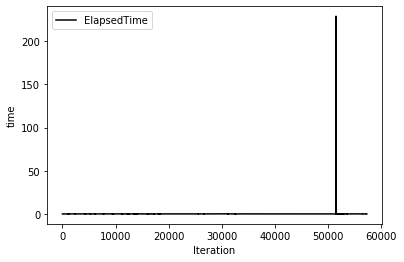

In [4]:
plt.plot(elapTime, color = 'black', label = "ElapsedTime")
plt.xlabel("Iteration")
plt.ylabel("time")
plt.legend()



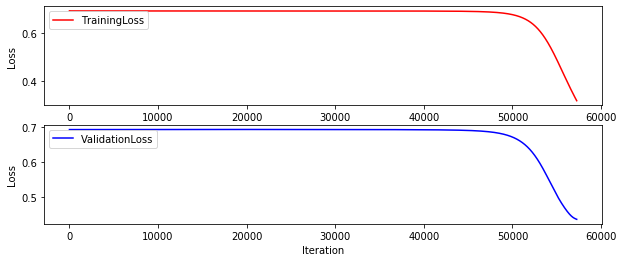

In [5]:
#Plotting Loss

fig, axs = plt.subplots(2,1, figsize = (10,4))


axs[0].plot(lrnLoss, color = 'red', label = "TrainingLoss")


axs[1].plot(valLoss, color = 'blue', label = "ValidationLoss")

axs[0].set(ylabel = 'Loss')
axs[1].set(xlabel = 'Iteration', ylabel = 'Loss')

axs[0].legend()
axs[1].legend()

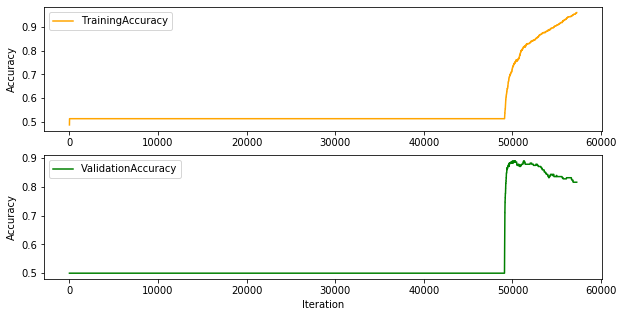

In [6]:
#Plotting Accuracy
fig, axs = plt.subplots(2,1, figsize = (10,5))


axs[0].plot(lrnAcc, color = 'orange', label = "TrainingAccuracy")


axs[1].plot(valAcc, color = 'green', label = "ValidationAccuracy")

axs[0].set(ylabel = 'Accuracy')
axs[1].set(xlabel = 'Iteration', ylabel = 'Accuracy')

axs[0].legend()
axs[1].legend()

/Users/jaewon/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/jaewon/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


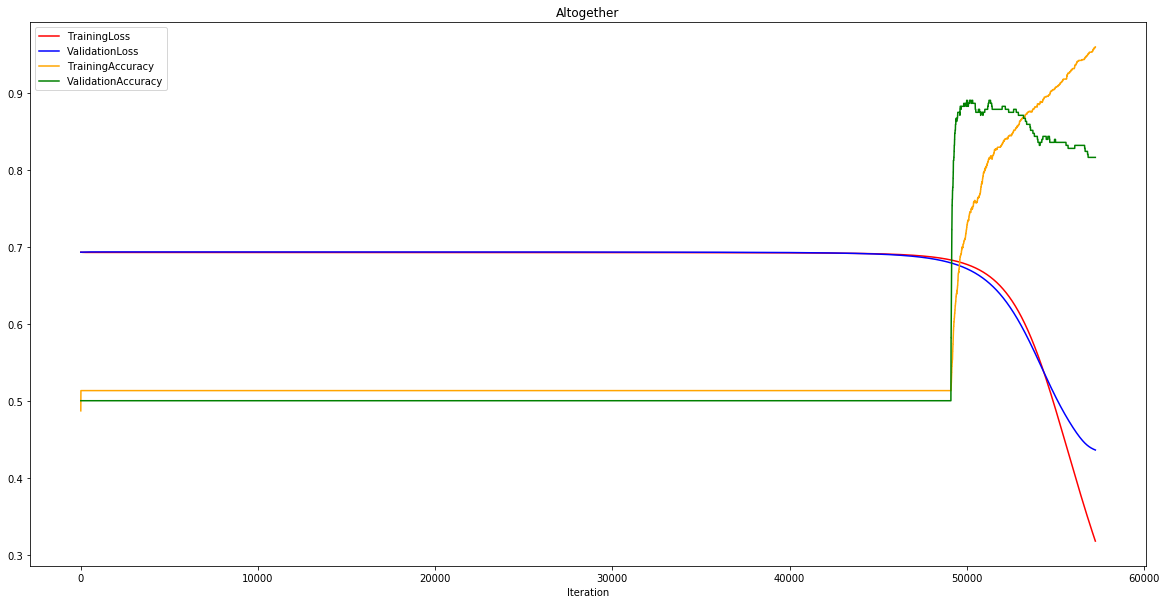

In [7]:
#Plotting Altogether

plt.figure(figsize = (20,10))
plt.title('Altogether')
plt.xlabel('Iteration')

plt.plot(lrnLoss, color = 'red', label = 'TrainingLoss')
plt.plot(valLoss, color = 'blue', label = "ValidationLoss")
plt.plot(lrnAcc, color = 'orange', label = "TrainingAccuracy")
plt.plot(valAcc, color = 'green', label = "ValidationAccuracy")

plt.legend()






In [8]:
print("  Dataset   |   Loss   | Accuracy")

print("  Training  | %.4f | %.4f" % (lrnLoss[-1], lrnAcc[-1]))
print(" Validation| %.4f | %.4f" % (valLoss[-1], valAcc[-1]))

  Dataset   |   Loss   | Accuracy
  Training  | 0.3175 | 0.9601
 Validation| 0.4359 | 0.8164


In [9]:
print(w_0)
print(w_1)
print(w_2)

[[ 0.00792081 -0.00415091 -0.01805248 ... -0.02443024 -0.02433949
  -0.1112842 ]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]
 [ 2.          2.          2.         ...  2.          2.
   2.        ]
 [ 3.          3.          3.         ...  3.          3.
   3.        ]]
[[-3.44873192  0.50785403  0.50785403  0.50785403]
 [ 1.31363538  0.49085917  0.49085917  0.49085917]
 [ 1.99987963  2.00191125  2.00191125  2.00191125]]
[[-3.79193462  1.45996171  0.39172386]]
